# Inorganic Material Generation using Deep Q-Networks
https://github.com/eltonpan/InorganicMaterialRL

Elton Pan

In [1]:
import numpy as np
import pickle
import torch
from torch import nn
import collections
from model import DQN_pytorch, DCN_pytorch
import time
from one_hot import featurize_target, onehot_target, element_set, comp_set, one_hot_to_element, element_to_one_hot, one_hot_to_comp, comp_to_one_hot, step_to_one_hot, one_hot_to_step
import seaborn as sns
import random
import matplotlib.pyplot as plt
import os
from env_constrained import generate_random_act, ConstrainedMaterialEnvironment, extract_data_from_ep
import collections
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm 
from sklearn.manifold import TSNE
from numpy.linalg import svd
import imageio
from pymatgen.core import Composition
from constraints.checkers import check_neutrality, check_neutrality, check_neutrality_multiple, check_electronegativity_multiple, check_both_multiple
from matminer.featurizers.base import MultipleFeaturizer
import matminer.featurizers.composition as cf
from sklearn.ensemble import RandomForestRegressor
import joblib
os.environ["CUDA_VISIBLE_DEVICES"]="1"

/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/mode

# Random policy
In env.py, we have generated some data using a random policy. Here, we visualize the distribution of final rewards, and then trained an agent using purely data generated by the random policy.

In [3]:
# Load Q_data_random
# with open('./data/Q_data_random_RF_constrained.pkl', 'rb') as f:
with open('./data/Q_data_random_RF_constrained.pkl', 'rb') as f:
    Q_c_data_random = pickle.load(f)

print('Number of episodes generated by random policy:',len(Q_c_data_random))

def generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data):
    '''
    Generates inputs and targets for DQN training

    Args:
    Q_data: List of Q_datapoints for training
    
    Returns:
    s_material_inputs: torch.tensor of Size([num of episodes in Q_data, 145])
    s_step_inputs: torch.tensor
    a_elem_inputs: torch.tensor
    a_comp_inputs: torch.tensor
    Q_targets: torch.tensor
    en_targets: torch.tensor

    '''
    s_material_inputs = []
    s_step_inputs     = []
    a_elem_inputs     = []
    a_comp_inputs     = []
    Q_targets         = []
    en_targets         = []

    for episode in Q_c_data:
        for step in episode:
            # state, action, reward = step
            [s_material, s_step], [a_elem, a_comp], Q_target, en_target = step

            s_material = torch.tensor(s_material).float()
            s_step = torch.tensor(s_step)
            a_elem = torch.tensor(a_elem)
            a_comp = torch.tensor(a_comp)
            Q_target = torch.tensor([Q_target])
            en_target = torch.tensor([en_target])

            s_material_inputs.append(s_material)
            s_step_inputs.append(s_step)
            a_elem_inputs.append(a_elem)
            a_comp_inputs.append(a_comp)
            Q_targets.append(Q_target)
            en_targets.append(en_target)

    s_material_inputs = torch.stack(s_material_inputs)
    s_step_inputs = torch.stack(s_step_inputs)
    a_elem_inputs = torch.stack(a_elem_inputs)
    a_comp_inputs = torch.stack(a_comp_inputs)
    Q_targets = torch.stack(Q_targets)
    en_targets = torch.stack(en_targets)

    return s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets

s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data = Q_c_data_random)

print('s_material_inputs:', s_material_inputs.shape)
print('s_step_inputs:', s_step_inputs.shape)
print('a_elem_inputs:', a_elem_inputs.shape)
print('a_comp_inputs:', a_comp_inputs.shape)
print('Q_targets:', Q_targets.shape)
print('en_targets:', en_targets.shape)
print('')

Number of episodes generated by random policy: 10000
s_material_inputs: torch.Size([50000, 145])
s_step_inputs: torch.Size([50000, 5])
a_elem_inputs: torch.Size([50000, 80])
a_comp_inputs: torch.Size([50000, 10])
Q_targets: torch.Size([50000, 1])
en_targets: torch.Size([50000, 1])



/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


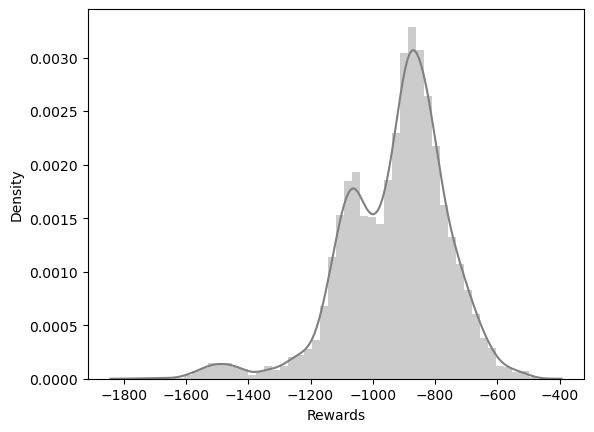

/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


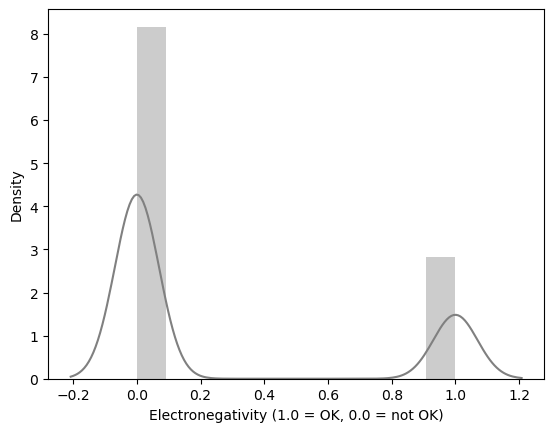

In [5]:
# Plot distribution of final rewards by random policy
plt.figure()
final_rewards_random = Q_targets[0::5].reshape(-1) # find final rewards
sns.distplot(final_rewards_random, color= 'grey')
plt.xlabel('Rewards')
plt.show()

# Plot distribution of en by random policy
plt.figure()
en_random = en_targets[0::5].reshape(-1) # find final rewards
sns.distplot(en_random, color= 'grey')
plt.xlabel('Electronegativity (1.0 = OK, 0.0 = not OK)')
plt.show()

### Fix class imbalance 
No significant improvement hence not used anymore

In [6]:
# good = 0
# bad = 0
# for en in en_targets:
#     if en.item() == 1.:
#         good += 1
#     else: 
#         bad += 1
# print('Before balancing: ',good/(good + bad))

Before balancing:  0.2576


In [7]:
# good_idx = []
# bad_idx = []
# idx = 0
# for en in en_targets:
#     if en.item() == 1.:
#         good_idx.append(idx)
#     else:
#         bad_idx.append(idx)
#     idx += 1

# num_datapoints = 25000
# good_idx = good_idx[: num_datapoints]
# bad_idx  = bad_idx[:num_datapoints] # truncate bad compounds to ensure class imbalance
# balanced_idx = bad_idx + good_idx

# s_material_inputs = s_material_inputs[balanced_idx]
# s_step_inputs = s_step_inputs[balanced_idx]
# a_elem_inputs = a_elem_inputs[balanced_idx]
# a_comp_inputs = a_comp_inputs[balanced_idx]
# Q_targets = Q_targets[balanced_idx]
# en_targets = en_targets[balanced_idx]

# print('s_material_inputs:', s_material_inputs.shape)
# print('s_step_inputs:', s_step_inputs.shape)
# print('a_elem_inputs:', a_elem_inputs.shape)
# print('a_comp_inputs:', a_comp_inputs.shape)
# print('Q_targets:', Q_targets.shape)
# print('en_targets:', en_targets.shape)
# print('')

# good = 0
# bad = 0
# for en in en_targets:
#     if en.item() == 1.:
#         good += 1
#     else: 
#         bad += 1

# print('After balancing: ',good/(good + bad))

In [6]:
# Standardizing s_material data
scaler = StandardScaler() # Fit scaler
print('before scaling:', s_material_inputs)
scaler.fit(s_material_inputs)
s_material_inputs_scaled = torch.tensor(scaler.transform(s_material_inputs)).float()
print('after scaling:', s_material_inputs_scaled)

# # Save standard scaler
# joblib.dump(scaler, 'data/std_scaler.bin', compress=True)

# # Load standard scaler
# scalar = joblib.load('data/std_scaler.bin')

before scaling: tensor([[4.0000e+00, 6.4952e-01, 5.9343e-01,  ..., 0.0000e+00, 3.8309e-01,
         2.4297e-02],
        [3.0000e+00, 7.4231e-01, 7.1808e-01,  ..., 0.0000e+00, 3.8309e-01,
         4.6373e-02],
        [2.0000e+00, 8.4984e-01, 8.3555e-01,  ..., 0.0000e+00, 1.5987e-03,
         2.2204e-04],
        ...,
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])
after scaling: tensor([[ 1.6739,  0.1534,  0.0971,  ..., -0.5587,  1.2861,  0.0383],
        [ 0.9193,  0.4174,  0.4540,  ..., -0.5587,  1.2861,  0.6393],
        [ 0.1647,  0.7233,  0.7904,  ..., -0.5587, -0.6513, -0.6172],
        ...,
        [-0.5899,  1.1504,  1.2613,  ...,  1.7897, -0.6595, -0.6232],
        [-1.3445, -1.6941, -1.6021,  ..., -0.5587, -0.6595, -0.6232],
        [-

In [7]:
# Train-validation split
def train_validation_split(s_material_inputs_scaled, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets, valid_size = 0.2):
    '''
    Args:
    s_material_inputs_scaled
    s_step_inputs
    a_elem_inputs
    a_comp_inputs
    Q_targets
    en_targets
    valid_size: Float (0-1). Size of validation set

    Returns:
    s_material_inputs_train 
    s_step_inputs_train     
    a_elem_inputs_train     
    a_comp_inputs_train     
    Q_targets_train   
    en_targets_train   
    s_material_inputs_valid 
    s_step_inputs_valid 
    a_elem_inputs_valid
    a_comp_inputs_valid 
    Q_targets_valid
    en_targets_valid
  
    '''
    max_idx = s_material_inputs_scaled.shape[0] # Find size of dataset
    idx = [x for x in range(max_idx)] # Generate indices
    random.shuffle(idx) # Shuffle order idx 
    split = int(round(max_idx*(1-valid_size)))
    train_idx, valid_idx = idx[:split], idx[split:] # Split indices

    s_material_inputs_train = s_material_inputs_scaled[train_idx] # Use scaled s_material
    s_step_inputs_train     = s_step_inputs[train_idx]
    a_elem_inputs_train     = a_elem_inputs[train_idx]
    a_comp_inputs_train     = a_comp_inputs[train_idx]
    Q_targets_train         = Q_targets[train_idx]
    en_targets_train         = en_targets[train_idx]

    s_material_inputs_valid = s_material_inputs_scaled[valid_idx] # Use scaled s_material
    s_step_inputs_valid     = s_step_inputs[valid_idx]
    a_elem_inputs_valid     = a_elem_inputs[valid_idx]
    a_comp_inputs_valid     = a_comp_inputs[valid_idx]
    Q_targets_valid         = Q_targets[valid_idx]
    en_targets_valid         = en_targets[valid_idx]

    return s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, en_targets_train,s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid, en_targets_valid

s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, en_targets_train, s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid, en_targets_valid \
= train_validation_split(s_material_inputs_scaled = s_material_inputs_scaled, 
                                    s_step_inputs = s_step_inputs, 
                                    a_elem_inputs = a_elem_inputs,
                                    a_comp_inputs = a_comp_inputs,
                                    Q_targets  = Q_targets,
                                    en_targets = en_targets,
                                    valid_size = 0.2)

print('TRAIN SIZES:')
print('s_material_inputs_train:', s_material_inputs_train.shape)
print('s_step_inputs_train:', s_step_inputs_train.shape)
print('a_elem_inputs_train:', a_elem_inputs_train.shape)
print('a_comp_inputs_train:', a_comp_inputs_train.shape)
print('Q_targets_train:', Q_targets_train.shape)
print('en_targets_train:', en_targets_train.shape)
print('')
print('VALIDATION SIZES:')
print('s_material_inputs_valid:', s_material_inputs_valid.shape)
print('s_step_inputs_valid:', s_step_inputs_valid.shape)
print('a_elem_inputs_valid:', a_elem_inputs_valid.shape)
print('a_comp_inputs_valid:', a_comp_inputs_valid.shape)
print('Q_targets_valid:', Q_targets_valid.shape)
print('en_targets_valid:', en_targets_valid.shape)

TRAIN SIZES:
s_material_inputs_train: torch.Size([40000, 145])
s_step_inputs_train: torch.Size([40000, 5])
a_elem_inputs_train: torch.Size([40000, 80])
a_comp_inputs_train: torch.Size([40000, 10])
Q_targets_train: torch.Size([40000, 1])
en_targets_train: torch.Size([40000, 1])

VALIDATION SIZES:
s_material_inputs_valid: torch.Size([10000, 145])
s_step_inputs_valid: torch.Size([10000, 5])
a_elem_inputs_valid: torch.Size([10000, 80])
a_comp_inputs_valid: torch.Size([10000, 10])
Q_targets_valid: torch.Size([10000, 1])
en_targets_valid: torch.Size([10000, 1])


Here we train DQN using ONLY data generated by random policy.

# DQN

In [8]:
# Initialize Q network
dqn = DQN_pytorch()

def train_DQN(dqn, num_epoch, s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train ,s_material_inputs_valid ,s_step_inputs_valid ,a_elem_inputs_valid ,a_comp_inputs_valid ,Q_targets_valid):
    '''
    Trains DQN and prints: 1. training loss 2. validation loss

    Args:
    dqn: DQN
    num_epoch: Int. Number of training epochs 
    s_material_inputs_train
    s_step_inputs_train
    a_elem_inputs_train
    a_comp_inputs_train
    Q_targets_train
    s_material_inputs_valid
    s_step_inputs_valid
    a_elem_inputs_valid
    a_comp_inputs_valid
    Q_targets_valid

    Returns:
    Updated dqn
    train_loss_list
    valid_loss_list
    '''
    train_loss_list = []
    valid_loss_list = []

    # Train Q network
    optimizer = torch.optim.Adam(dqn.parameters(), lr=1e-2)
    loss_func = torch.nn.SmoothL1Loss().float()

    # start = time.time()

    for epoch in range(num_epoch):
        # Train loss
        prediction_train = dqn(s_material = s_material_inputs_train, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs_train,     # torch.Size([batch_size,5])
                        a_elem      = a_elem_inputs_train,     # torch.Size([batch_size,80])
                        a_comp      = a_comp_inputs_train,  # torch.Size([batch_size,10])
                        )                    # Input x and predict based on x
        train_loss       = loss_func(prediction_train.float(), Q_targets_train.float()).float()   # Must be (1. nn output, 2. target)
        optimizer.zero_grad()   # Clear gradients for next train
        train_loss.backward()         # Backpropagation, compute gradients
        optimizer.step()        # Apply gradients

        # Validation loss
        prediction_valid = dqn(s_material = s_material_inputs_valid, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs_valid,     # torch.Size([batch_size,5])
                        a_elem      = a_elem_inputs_valid,     # torch.Size([batch_size,80])
                        a_comp      = a_comp_inputs_valid,  # torch.Size([batch_size,10]))
                        )
        valid_loss = loss_func(prediction_valid.float(), Q_targets_valid.float()).float()   # Must be (1. nn output, 2. target)
        train_loss_list.append(train_loss.detach().numpy())
        valid_loss_list.append(valid_loss.detach().numpy())

        print('Epoch = ', epoch, 'Train_loss = %.4f' % train_loss.data.numpy(), 'Valid_loss = %.4f' % valid_loss.data.numpy())
    # end = time.time()
    # print('time taken for batch:', end - start)
    
    return dqn, train_loss_list, valid_loss_list
dqn, train_loss_list, valid_loss_list = train_DQN(dqn =  dqn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
 a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train,
 s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
 a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid)

Epoch =  0 Train_loss = 760.0330 Valid_loss = 758.6086
Epoch =  1 Train_loss = 758.8939 Valid_loss = 756.5757
Epoch =  2 Train_loss = 756.8638 Valid_loss = 753.1890
Epoch =  3 Train_loss = 753.4838 Valid_loss = 748.0854
Epoch =  4 Train_loss = 748.3919 Valid_loss = 740.8820
Epoch =  5 Train_loss = 741.2059 Valid_loss = 731.1531
Epoch =  6 Train_loss = 731.5020 Valid_loss = 718.4334
Epoch =  7 Train_loss = 718.8164 Valid_loss = 702.2145
Epoch =  8 Train_loss = 702.6420 Valid_loss = 681.9514
Epoch =  9 Train_loss = 682.4355 Valid_loss = 657.0395
Epoch =  10 Train_loss = 657.5945 Valid_loss = 626.8245
Epoch =  11 Train_loss = 627.4664 Valid_loss = 590.6164
Epoch =  12 Train_loss = 591.3575 Valid_loss = 548.0905
Epoch =  13 Train_loss = 548.9698 Valid_loss = 503.0312
Epoch =  14 Train_loss = 504.1325 Valid_loss = 471.4513
Epoch =  15 Train_loss = 472.8556 Valid_loss = 450.4153
Epoch =  16 Train_loss = 452.1380 Valid_loss = 424.7975
Epoch =  17 Train_loss = 426.8629 Valid_loss = 390.4192
Ep

# DCN

In [9]:
# Initialize constraint network
dcn = DCN_pytorch()

def train_DCN(dcn, num_epoch, s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, en_targets_train, s_material_inputs_valid ,s_step_inputs_valid ,a_elem_inputs_valid ,a_comp_inputs_valid , Q_targets_valid, en_targets_valid):
    '''
    Trains DCN and prints: 1. training loss 2. validation loss

    Args:
    dcn: DCN
    num_epoch: Int. Number of training epochs 
    s_material_inputs_train
    s_step_inputs_train
    a_elem_inputs_train
    a_comp_inputs_train
    Q_targets_train
    en_targets_train
    s_material_inputs_valid
    s_step_inputs_valid
    a_elem_inputs_valid
    a_comp_inputs_valid
    Q_targets_valid
    en_targets_valid

    Returns:
    Updated dcn
    train_loss_list
    valid_loss_list
    '''
    train_loss_list = []
    valid_loss_list = []

    # Train Q network
    optimizer = torch.optim.Adam(dcn.parameters(), lr=1e-2)
    # loss_func = torch.nn.SmoothL1Loss().float()
    loss_func = torch.nn.MSELoss().float() # Works better than L1Loss
    # loss_func = torch.nn.L1Loss().float() # Trained model gives pred close to 0

    # start = time.time()

    for epoch in range(num_epoch):
        # Train loss
        prediction_train = dcn(s_material = s_material_inputs_train, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs_train,     # torch.Size([batch_size,5])
                        a_elem      = a_elem_inputs_train,     # torch.Size([batch_size,80])
                        a_comp      = a_comp_inputs_train,  # torch.Size([batch_size,10])
                        )                    # Input x and predict based on x
        train_loss       = loss_func(prediction_train.float(), en_targets_train.float()).float()   # Must be (1. nn output, 2. target)
        optimizer.zero_grad()   # Clear gradients for next train
        train_loss.backward()         # Backpropagation, compute gradients
        optimizer.step()        # Apply gradients

        # Validation loss
        prediction_valid = dcn(s_material = s_material_inputs_valid, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs_valid,     # torch.Size([batch_size,5])
                        a_elem      = a_elem_inputs_valid,     # torch.Size([batch_size,80])
                        a_comp      = a_comp_inputs_valid,  # torch.Size([batch_size,10]))
                        )
        valid_loss = loss_func(prediction_valid.float(), en_targets_valid.float()).float()   # Must be (1. nn output, 2. target)
        train_loss_list.append(train_loss.detach().numpy())
        valid_loss_list.append(valid_loss.detach().numpy())

        print('Epoch = ', epoch, 'Train_loss = %.4f' % train_loss.data.numpy(), 'Valid_loss = %.4f' % valid_loss.data.numpy())
    # end = time.time()
    # print('time taken for batch:', end - start)
    
    return dcn, train_loss_list, valid_loss_list
dcn, train_loss_list, valid_loss_list = train_DCN(dcn =  dcn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
 a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train, en_targets_train = en_targets_train,
 s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
 a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid, en_targets_valid = en_targets_valid)

Epoch =  0 Train_loss = 0.2508 Valid_loss = 0.1974
Epoch =  1 Train_loss = 0.1951 Valid_loss = 0.2112
Epoch =  2 Train_loss = 0.2071 Valid_loss = 0.2054
Epoch =  3 Train_loss = 0.2013 Valid_loss = 0.1913
Epoch =  4 Train_loss = 0.1879 Valid_loss = 0.1858
Epoch =  5 Train_loss = 0.1831 Valid_loss = 0.1869
Epoch =  6 Train_loss = 0.1845 Valid_loss = 0.1873
Epoch =  7 Train_loss = 0.1847 Valid_loss = 0.1860
Epoch =  8 Train_loss = 0.1829 Valid_loss = 0.1848
Epoch =  9 Train_loss = 0.1812 Valid_loss = 0.1842
Epoch =  10 Train_loss = 0.1805 Valid_loss = 0.1837
Epoch =  11 Train_loss = 0.1801 Valid_loss = 0.1826
Epoch =  12 Train_loss = 0.1792 Valid_loss = 0.1811
Epoch =  13 Train_loss = 0.1777 Valid_loss = 0.1798
Epoch =  14 Train_loss = 0.1763 Valid_loss = 0.1794
Epoch =  15 Train_loss = 0.1758 Valid_loss = 0.1788
Epoch =  16 Train_loss = 0.1752 Valid_loss = 0.1772
Epoch =  17 Train_loss = 0.1736 Valid_loss = 0.1756
Epoch =  18 Train_loss = 0.1720 Valid_loss = 0.1751
Epoch =  19 Train_loss

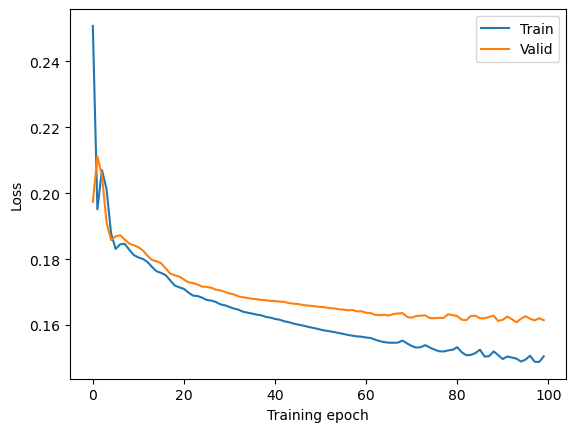

In [10]:
# Plot train and valid losses
plt.figure()
plt.plot(range(0,len(train_loss_list)), train_loss_list, label = 'Train')
plt.plot(range(0,len(valid_loss_list)), valid_loss_list, label = 'Valid')
plt.legend()
# plt.ylim(130,170)
plt.xlabel('Training epoch')
plt.ylabel('Loss')
# plt.savefig('plots/train_valid_loss.png', dpi = 300)
plt.show()

In [11]:
def ranked_max_actions(state, dqn, n_actions = len(element_set)*len(comp_set)):
    """
    Returns a list of ranked actions based on Q-network prodictions

    Args:
    state: List [s_material, s_step] where s_material is the string representation of material and s_step is the integer step number
    dqn: Q-network for Q-value prediction

    Returns:
    ranked_max_actions: List [[s_material, s_step, Q-value]
                              ...
                              [s_material, s_step, Q-value]
                              ]
    where s_material is the one-hot torch.tensor.float() of material and
    s_step is the  one-hot torch.tensor.float()
    0th index corresponds to highest Q-value
    """

    s_material, s_step = state
    # s_material = torch.tensor(onehot_target(s_material)).float() # Get one-hot rep of s_material
    s_material = torch.tensor(featurize_target(s_material)).reshape(1, -1) # Get one-hot rep of s_material
    s_material = torch.tensor(scaler.transform(s_material)).reshape(-1).float()  # Standardize s_material
    s_step = torch.tensor(step_to_one_hot([s_step])[0]).float() # Get one-hot rep of s_step

    s_material_input = torch.stack([s_material]*n_actions)
    s_step_input = torch.stack([s_step]*n_actions)

    a_elem_input = []
    a_comp_input = []
    for elem in element_set:
        a_elem = torch.tensor(element_to_one_hot([elem])[0]).float()
        for comp in comp_set:
            a_comp = torch.tensor(comp_to_one_hot([comp])[0]).float()

            a_elem_input.append(a_elem)
            a_comp_input.append(a_comp)
    
    a_elem_input = torch.stack(a_elem_input).float()
    a_comp_input = torch.stack(a_comp_input).float()
    
    Q_pred = dqn(s_material = s_material_input, # torch.Size([batch_size, 40, 115]) and must be .float() !!!
                    s_step      = s_step_input,     # torch.Size([batch_size,5])
                    a_elem      = a_elem_input,     # torch.Size([batch_size,80])
                    a_comp      = a_comp_input,  # torch.Size([batch_size,10])

                )   
    # Rank according to Q-values
    Q_pred = Q_pred.detach().numpy()
    Q_pred = Q_pred.reshape(len(element_set)*len(comp_set))
    order = Q_pred.argsort()
    ranks = order.argsort() # ranks of Q-values, 0th index = lowest Q, last index = highest Q
    
    
    a_elem_input_ranked = torch.zeros([len(element_set)*len(comp_set), len(element_set)])
    a_comp_input_ranked = torch.zeros([len(element_set)*len(comp_set), len(comp_set)])
    Q_pred_ranked = np.zeros(len(element_set)*len(comp_set))

    for rank in reversed(range(len(element_set)*len(comp_set))): # Start with most valuable
        rank_idx = ranks[rank] # rank_idx = final position
        rank_idx = (len(element_set)*len(comp_set) - 1) - rank_idx # Reverse rank_idx i.e. Want 0th index to correspond to max Q

        # Sort Q-values
        Q = Q_pred[rank]
        Q_pred_ranked[rank_idx] = Q

        # Sort a_elem according to Q-values
        a_elem = a_elem_input[rank]
        a_elem_input_ranked[rank_idx] = a_elem

        # Sort a_comp according to Q-values
        a_comp = a_comp_input[rank]
        a_comp_input_ranked[rank_idx] = a_comp

    # print('Max Q: ', max(Q_pred_ranked))
    # print('Min Q: ', min(Q_pred_ranked))

    return a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked

mat_1 = 'BaTiO3'
mat_2 = 'SrTiO3'

print('Material: {}'.format(mat_1))
a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked = ranked_max_actions([mat_1, 1], dqn = dqn)
print('Q value of max action: ', Q_pred_ranked[0])
# print('max_a_elem: ', tuple(a_elem_input_ranked[0].tolist()))
# print('max_a_comp: ', tuple(a_comp_input_ranked[0].tolist()))
# print('')
print('')

print('Material: {}'.format(mat_2))
a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked = ranked_max_actions([mat_2, 1], dqn = dqn)
print('Q value of max action: ', Q_pred_ranked[0])
# print('max_a_elem: ', tuple(a_elem_input_ranked[0].tolist()))
# print('max_a_comp: ', tuple(a_comp_input_ranked[0].tolist()))

Material: BaTiO3
Q value of max action:  -680.3466186523438

Material: SrTiO3
Q value of max action:  -649.539306640625


In [12]:
# Investigate weights of dqn
# dqn.fc1.weight.mean(), dqn.fc2.weight.mean(), dqn.fc3.weight.mean(), dqn.fc4.weight.mean(),
dcn.fc1.weight.mean(), dcn.fc2.weight.mean(), dcn.fc3.weight.mean(), dcn.fc4.weight.mean(),

(tensor(-0.0105, grad_fn=<MeanBackward0>),
 tensor(-0.0350, grad_fn=<MeanBackward0>),
 tensor(-0.0010, grad_fn=<MeanBackward0>),
 tensor(-0.0353, grad_fn=<MeanBackward0>))

In [13]:
# For testing the DCN function
# s_material = torch.tensor(onehot_target('BaTiO3'))
s_material = torch.tensor(scaler.transform(torch.tensor(featurize_target('BaTiO3')).reshape(1,-1))).float()
# s_material = s_material.reshape(1, s_material.shape[0])
# print(s_material.shape)

s_step = torch.zeros(5)
s_step[3] = 1.
s_step = s_step.reshape(1, s_step.shape[0])
# print(s_step.shape)

a_elem = torch.zeros(80)
a_elem[2] = 1.
a_elem = a_elem.reshape(1, a_elem.shape[0])
# print(a_elem.shape)

a_comp = torch.zeros(10)
a_comp[1] = 1.
a_comp = a_comp.reshape(1, a_comp.shape[0])
# print(a_comp.shape)

output = dcn(s_material, s_step, a_elem, a_comp)

print(output)
# print(output.shape)

tensor([[0.9211]], grad_fn=<SigmoidBackward>)


In [14]:
env = ConstrainedMaterialEnvironment(element_set = element_set,
                          comp_set =  comp_set,)

def generate_max_act(state, dqn, stochastic_top_frac = 0):
    '''
    Generates max action.
    Args:
    state: state
    dqn: Q-network
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns: max_a_elem, max_a_comp
    '''
    a_elem_input_ranked, a_comp_input_ranked, _ = ranked_max_actions(state = state, dqn = dqn, n_actions = len(element_set)*len(comp_set))
    
    tot_num_actions = len(a_elem_input_ranked)
    if stochastic_top_frac != 0: # if stochastic
        act_idx = stochastic_top_frac*tot_num_actions # cut-off index
        rank = np.random.randint(0,round(act_idx)) # take top stochastic_top_frac fraction of ranked actions
    else: # deterministic
        rank = 0 # take top action (index 0)
    max_a_elem = a_elem_input_ranked[rank] # 0th index corresponds to max
    max_a_comp = a_comp_input_ranked[rank] # 0th index corresponds to max
    max_a_elem = tuple(max_a_elem.tolist())
    max_a_comp = tuple(max_a_comp.tolist())
    action = [max_a_elem, max_a_comp]

    return action

def generate_constrained_max_act(state, dqn, dcn, en_threshold, stochastic_top_frac = 0):
    '''
    Generates max action.
    Args:
    state: state
    dqn: Q-network
    en_threshold: Float (0.0 - 1.0). Determines how tight the constraint is. 1.0 being the tightest. 
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns: max_a_elem, max_a_comp
    '''
    a_elem_input_ranked, a_comp_input_ranked, _ = ranked_max_actions(state = state, dqn = dqn, n_actions = len(element_set)*len(comp_set))
    
    tot_num_actions = len(a_elem_input_ranked)
    en = 0

    count = 0
    while en <= en_threshold: # Keep iterating until predicted en goes above 0.5
        if stochastic_top_frac != 0: # if stochastic
            act_idx = stochastic_top_frac*tot_num_actions # cut-off index
            rank = np.random.randint(0,round(act_idx)) # take top stochastic_top_frac fraction of ranked actions
        else: # deterministic
            rank = 0 # take top action (index 0)
        max_a_elem = a_elem_input_ranked[rank] # 0th index corresponds to max
        max_a_comp = a_comp_input_ranked[rank] # 0th index corresponds to max

        # print('state:', state)
        s_material, s_step = state # need to featurize/encode s_material and s_step
        # s_material = torch.tensor(onehot_target(s_material)).float() # Get one-hot rep of s_material
        s_material = torch.tensor(featurize_target(s_material)).reshape(1, -1) # Get one-hot rep of s_material
        s_material_inputs = torch.tensor(scaler.transform(s_material)).float()  # Standardize s_material
        s_step_inputs = torch.tensor(step_to_one_hot([s_step])[0]).reshape(1, -1).float() # Get one-hot rep of s_step
        max_a_elem = max_a_elem.reshape(1, -1)
        max_a_comp = max_a_comp.reshape(1, -1)
        # print('state:', state)
        # print('s_material_inputs:', s_material_inputs)
        # print('s_step_inputs:', s_step_inputs)
        # print('max_a_elem:', max_a_elem)
        # print('max_a_comp:', max_a_comp)
        en = dcn(s_material = s_material_inputs, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs,     # torch.Size([batch_size,5])
                        a_elem      = max_a_elem,     # torch.Size([batch_size,80])
                        a_comp      = max_a_comp,  # torch.Size([batch_size,10])
                        )  # Update en with prediction using DCN
        # print('en pred:', en[0])
        count += 1
        if count >= 100: # Tried more than 100 times
            print('Could not satisfy en constraint after %.0f actions' % count)
            break
    max_a_elem = max_a_elem[0]
    max_a_comp = max_a_comp[0]
    max_a_elem = tuple(max_a_elem.tolist())
    max_a_comp = tuple(max_a_comp.tolist())
    action = [max_a_elem, max_a_comp]

    return action

def generate_ep_with_dqn_dcn(dqn, dcn, en_threshold, max_steps = 5, epsilon = 0, stochastic_top_frac = 0):
    '''
    Generates an episode with trained DQN
    
    Args:
    dqn: Q-network for Q-value prediction
    dcn: Constraint-network for constraint value prediction
    en_threshold: Float (0.0 - 1.0). Determines how tight the constraint is. 1.0 being the tightest.
    max_steps: Int
    epsilon: Float. Probability of taking random action 
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns: 
    env.path (an episode): List of SAR data in the form of [[material, step], [element, composition], reward]
    final_compound: Str.
    
    '''
    env.initialize()

    for i in range(max_steps):
        # if i == 0: # if start of episode, choose random first element #########################
        #     action = generate_random_act()

        # else: # elif not start of episode, take greedy action
        #     # Max action
        #     action = generate_max_act(state = [env.state, env.counter+1], dqn = dqn)
        if np.random.uniform(0,1) > epsilon:
            # action = generate_max_act(state = [env.state, env.counter+1], dqn = dqn, stochastic_top_frac = stochastic_top_frac)
            action = generate_constrained_max_act(state = [env.state, env.counter+1], dqn = dqn, dcn = dcn, en_threshold = en_threshold, stochastic_top_frac = stochastic_top_frac)
        else:
            action = generate_random_act()
        # Take step with action
        env.step(action)
        final_compound = env.state
        # print('step:', env.counter)
        # print('state:',final_compound)
        # print('reward:',env.reward())
        # print(env.num_steps_taken)
        # print('')
    return env.path, final_compound
# ep, final_compound = generate_ep_with_dqn_dcn(dqn = dqn, dcn = dcn, stochastic_top_frac = 0.2)

# compounds = []
# for i in range(100):
#     _, final_compound = generate_ep_with_dqn_dcn(dqn = dqn, dcn = dcn, en_threshold = 0.4, stochastic_top_frac = 0.20)
#     if check_electronegativity(final_compound):
#         compounds.append(final_compound)

# # print(final_compound)
# # print(check_electronegativity(final_compound))
# len(compounds)

In [22]:
# ========= FOR TRAINED POLICY ===========
def generate_Q_c_datapoints_and_evaluate_policy(dqn, dcn, num_eps, epsilon, en_threshold = 0.4, stochastic_top_frac = 0.20):
    '''
    Generates 1) Q datapoints for training 2) List of final rewards using a DQN.

    Args:
    dqn: Q-netowrk
    num_eps: Int. Number of episodes to run.
    epsilon: Float. Probability of taking a random action
    en_threshold: Float (0.0 - 1.0). Determines how tight the constraint is. 1.0 being the tightest. Default 0.4
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns:
    Q_c_data_trained: List of Q datapoints for training
    en_targets_trained: List of en datapoints for training
    final_rewards_trained: List of corresponding final rewards
    final_compounds: List (of Str) of final compounds
    '''
    # start = time.time()

    # Generate episodes with DQN
    episodes = []
    final_compounds = []
    for j in range(num_eps):
        episode, final_compound = generate_ep_with_dqn_dcn(dqn = dqn, dcn = dcn, epsilon = epsilon, en_threshold = en_threshold, stochastic_top_frac = stochastic_top_frac)
        episodes.append(episode)
        final_compounds.append(final_compound)

    Q_c_data_trained = []
    # Extract Q_data from episodes
    for episode in episodes:
        Q_c_data = extract_data_from_ep(episode)
        Q_c_data_trained.append(Q_c_data)

    # end = time.time()
    # print('time taken:', end - start)

    # Save Q_data
    # with open('./data/Q_data_trained_RF.pkl', 'wb') as f:
    #     pickle.dump(Q_data_trained, f, pickle.HIGHEST_PROTOCOL)

    # # Load Q_data_random
    # with open('./data/Q_data_trained_RF.pkl', 'rb') as f:
    #     Q_data_trained = pickle.load(f)

    # print('Number of episodes generated by agent trained on random policy data:', len(Q_data_trained))

    # Extract final rewards from episode data
    Q_targets_trained         = []
    en_targets_trained         = []

    for episode in Q_c_data_trained:
        for step in episode:
            # state, action, reward = step
            _, _, Q_target, en_target = step
            Q_target = torch.tensor([Q_target])
            Q_targets_trained.append(Q_target)
            en_target = torch.tensor([en_target])
            en_targets_trained.append(en_target)

    Q_targets_trained = torch.stack(Q_targets_trained)
    en_targets_trained = torch.stack(en_targets_trained)
    # print('Q_targets:', Q_targets_trained.shape)
    final_rewards_trained = Q_targets_trained[0::5].reshape(-1) # Find final rewards, index of 5 since length of each episode is 5
    final_en_trained = en_targets_trained[0::5].reshape(-1)

    return Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds

Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds = \
generate_Q_c_datapoints_and_evaluate_policy(dqn = dqn, dcn = dcn, num_eps = 100, epsilon = 0, en_threshold = 0.4, stochastic_top_frac = 0.20)
print(len(Q_c_data_trained))
print(len(en_targets_trained))
print(len(final_rewards_trained))
print(final_compounds)

Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
100
500
100
['Ge7Tl3Zn8Bi5', 'Ge1Cd3Ge6Ge9', 'Ge6Ag4I2Ge4Zn9', 'Ge6Zn3I2Ge7S9', 'Ge6Ag1Bi4Ge9I5', 'Ge6I1Ge7Ge2Ge4', 'Ge8Pb9Au9Pb9Ge7', 'Ge7Ag9Ge6I7Hg7', 'Ge4In7Ge1Bi8Te5', 'Ge8Te1Bi9I5Ge2', 'Ge7Ge2Ag1Ge1Cd8', 'P9Pb2Te6In5', 'Ge9Ag8Au1Hg3In1', 'Ge7Cd2Au7Ge8Ge7', 'Ge1Te6Pb4Tl5Ge7', 'P9Sn6Cd5Sn1Sb8', 'Ge8I7Sn3Ge6Ge1', 'Ge2Zn2Te7Ge9Ge7', 'Ge9I6Se4In1Bi

In [25]:
count = 0
for target in en_targets_trained[::5]:
    if target[0] == 1.:
        count += 1
print(count)

34


As shown in the plot below, an agent trained based on just data generated by a random policy can improve the distribution of rewards.

/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


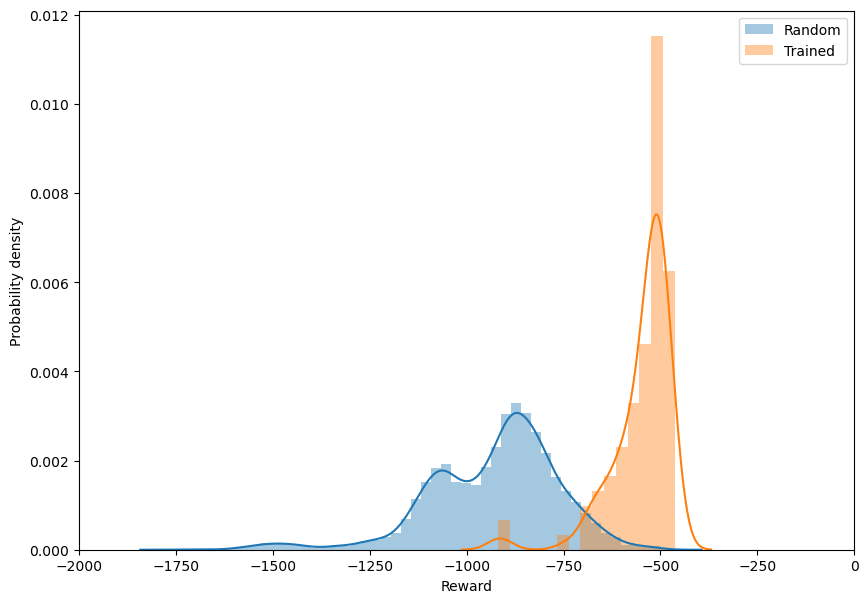

In [26]:
# Plot distribution of final rewards by random vs trained policy
plt.figure(figsize=(10,7))
sns.distplot(final_rewards_random, hist = True, norm_hist = True, label = 'Random')
sns.distplot(final_rewards_trained, hist = True, norm_hist = True, label = 'Trained')
plt.ylabel('Probability density')
plt.xlabel('Reward')
# plt.ylim(0,0.0025)
plt.xlim(-2000,0)
plt.legend()
# plt.savefig(fname = 'plots/reward_dist.png', dpi = 300)
plt.show()

/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


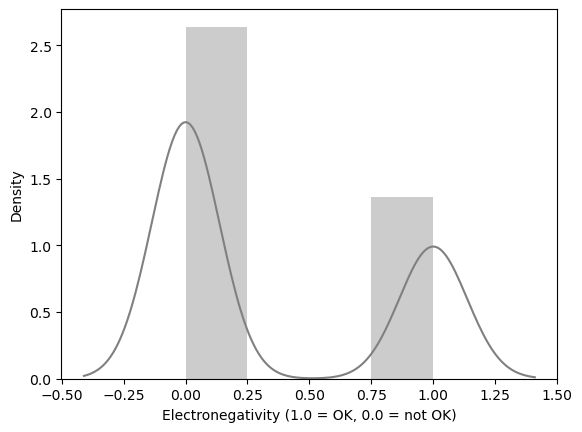

In [27]:
# Plot distribution of en by random policy
sns.distplot(en_targets_trained, color= 'grey')
plt.xlabel('Electronegativity (1.0 = OK, 0.0 = not OK)')
plt.show()

# Deep Reinforcement Learning
We now close the RL loop by training the agent on data generated by increasingly greedy policies. 

In [28]:
# replay_buffer = collections.deque(maxlen = 50000)
# Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds = generate_Q_c_datapoints_and_evaluate_policy(dqn = dqn, 
#                                                                                                                            dcn = dcn,
#                                                                                                     num_eps = 100, 
#                                                                                                     epsilon = 0, 
#                                                                                                     en_threshold = 0.4,
#                                                                                                     stochastic_top_frac = 0.2)
# s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data = Q_c_data_trained)

def update_replay_buffer(replay_buffer, s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets):
    '''
    Adds inputs into replay buffer
    Args:
    replay_buffer: collections.deque
    
    Returns: 
    updated replay buffer
    
    '''
    for s_material, s_step, a_elem, a_comp, Q_target, en_target in zip(s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets):
        Q_c_datapoint = [s_material, s_step, a_elem, a_comp, Q_target, en_target]
        replay_buffer.extend([Q_c_datapoint])
    
    return replay_buffer

# replay_buffer = update_replay_buffer(replay_buffer = replay_buffer, s_material_inputs = s_material_inputs, 
#                                                             s_step_inputs = s_step_inputs, 
#                                                             a_elem_inputs = a_elem_inputs, 
#                                                             a_comp_inputs = a_comp_inputs, 
#                                                                 Q_targets = Q_targets,
#                                                                 en_targets = en_targets)
# print('Number of Q datapoints in replay buffer (5 per episode):', len(replay_buffer))

In [29]:
def sample_replay_buffer(replay_buffer, n = 100):
    '''
    Samples datapoints from replay buffer for DQN training

    Args:
    replay_buffer: collections.deque
    n: Int. Number of datapoints to sample

    Returns:
    s_material_inputs: torch.tensor of Size([num of episodes in Q_data, 145])
    s_step_inputs: torch.tensor
    a_elem_inputs: torch.tensor
    a_comp_inputs: torch.tensor
    Q_targets: torch.tensor
    em_targets: torch.tensor

    '''

    s_material_inputs = []
    s_step_inputs     = []
    a_elem_inputs     = []
    a_comp_inputs     = []
    Q_targets         = []
    en_targets         = []

    for Q_c_datapoint in random.sample(replay_buffer, n):
        s_material, s_step, a_elem, a_comp, Q_target, en_target = Q_c_datapoint

        s_material = torch.tensor(s_material).float()
        s_step = torch.tensor(s_step)
        a_elem = torch.tensor(a_elem)
        a_comp = torch.tensor(a_comp)
        Q_target = torch.tensor([Q_target])
        en_target = torch.tensor([en_target])

        s_material_inputs.append(s_material)
        s_step_inputs.append(s_step)
        a_elem_inputs.append(a_elem)
        a_comp_inputs.append(a_comp)
        Q_targets.append(Q_target)
        en_targets.append(en_target)

    s_material_inputs = torch.stack(s_material_inputs)
    s_step_inputs = torch.stack(s_step_inputs)
    a_elem_inputs = torch.stack(a_elem_inputs)
    a_comp_inputs = torch.stack(a_comp_inputs)
    Q_targets = torch.stack(Q_targets)
    en_targets = torch.stack(en_targets)

    return s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets

# s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = sample_replay_buffer(replay_buffer = replay_buffer, n = 100)

# print('s_material_inputs:', s_material_inputs.shape)
# print('s_step_inputs:', s_step_inputs.shape)
# print('a_elem_inputs:', a_elem_inputs.shape)
# print('a_comp_inputs:', a_comp_inputs.shape)
# print('Q_targets:', Q_targets.shape)
# print('en_targets:', en_targets.shape)
    

### Training the DQN

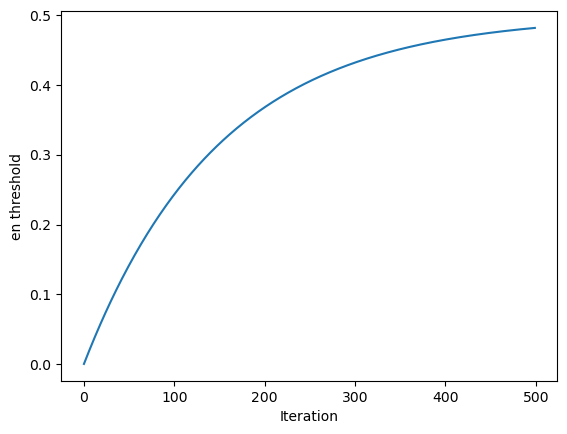

In [23]:
# num_iter = 500
# en_threshold_ub = 0.5 # upper bound for en_threshold
# iteration = np.arange(num_iter)
# en_threshold_vs_iter = -en_threshold_ub*(np.e**(-iteration/(num_iter*0.3))) + en_threshold_ub
# # for iteration in range(num_iter):
# plt.figure()
# plt.plot(iteration, en_threshold_vs_iter)
# plt.xlabel('Iteration')
# plt.ylabel('en threshold')
# plt.show()

In [30]:
num_iter = 500 # No. of training iterations
epsilon  = 0.99   # Initial epsilon

en_threshold =  0 # Because we don't want to train DCN online
# en_threshold_ub = 0.5 # upper bound for en_threshold
# iteration = np.arange(num_iter)
# en_threshold_vs_iter = -en_threshold_ub*(np.e**(-iteration/(num_iter*0.3))) + en_threshold_ub

replay_buffer = collections.deque(maxlen = 50000) # Initialize replay buffer
dqn_save_freq = 10 # Save DQN model every n iterations
dqn = DQN_pytorch() # Initialize DQN
dcn = DCN_pytorch() # Initialize DCN
env = ConstrainedMaterialEnvironment(element_set = element_set, comp_set = comp_set,) # Initialize env

# Meta-data to store
final_rewards_vs_iter   = []
en_vs_iter              = []
compounds_vs_iter       = []
train_loss_list_vs_iter = []
valid_loss_list_vs_iter = []
epsilon_vs_iter         = []

for iteration in tqdm(range(num_iter)):
    print('=========== TRAINING ITERATION %.0f ===========' % iteration)
#     en_threshold = en_threshold_vs_iter[iteration]
    print('Current epsilon = ', epsilon)
    print('Current en threshold = ', en_threshold)
    epsilon_vs_iter.append(epsilon)
    # 1. GENERATE Q DATAPOINTS & ADD TO REPLAY BUFFER
    print('A) GENERATING DATAPOINTS')
    Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds = \
        generate_Q_c_datapoints_and_evaluate_policy(dqn = dqn, dcn = dcn, num_eps = 100, epsilon = epsilon, en_threshold = en_threshold,
                                                                                                    stochastic_top_frac = 0.2) # Generate episodes and score them
    final_rewards_vs_iter.append(final_rewards_trained) # Save list of final reward
    en_vs_iter.append(en_targets_trained)
    compounds_vs_iter.append(final_compounds) # Save list of compounds generated at the end of each episode
    print('Average final reward = ', np.mean(np.array(final_rewards_trained)))
    print('Compounds generated:', final_compounds)
    s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data = Q_c_data_trained) # Processing to give inputs and targets for DQN
    replay_buffer = update_replay_buffer(replay_buffer = replay_buffer, s_material_inputs = s_material_inputs, 
                                                                s_step_inputs = s_step_inputs, 
                                                                a_elem_inputs = a_elem_inputs, 
                                                                a_comp_inputs = a_comp_inputs, 
                                                                    Q_targets = Q_targets,
                                                                   en_targets = en_targets)
    # 2. SAMPLE FROM REPLAY BUFFER, STANDARDIZE, TRAIN-VALIDATION SPLIT, TRAIN Q-NETWORK
    print('B) TRAINING Q-NETWORK and C-NETWORK')
    s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = sample_replay_buffer(replay_buffer = replay_buffer, n = 100)
    s_material_inputs_scaled = torch.tensor(scaler.transform(s_material_inputs)).float() # Standardize s_material_inputs
    s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, en_targets_train, s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid, en_targets_valid \
    = train_validation_split(s_material_inputs_scaled = s_material_inputs_scaled, 
                                        s_step_inputs = s_step_inputs, 
                                        a_elem_inputs = a_elem_inputs,
                                        a_comp_inputs = a_comp_inputs,
                                        Q_targets = Q_targets,
                                        en_targets = en_targets,
                                        valid_size = 0.2) # Train-validation split of datapoints sampled from replay buffer
    dqn, train_loss_list, valid_loss_list = train_DQN(dqn =  dqn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
    a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train,
    s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
    a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid) # Train DQN
    
#     dcn, train_loss_list, valid_loss_list = train_DCN(dcn =  dcn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
#     a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train, en_targets_train = en_targets_train,
#     s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
#     a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid, en_targets_valid = en_targets_valid)
#     train_loss_list_vs_iter.append(train_loss_list) # Save list of training loss vs training epoch for this iter
#     valid_loss_list_vs_iter.append(valid_loss_list) # Save list of validation loss vs training epoch for this iter

    if iteration in range(0, num_iter+1, dqn_save_freq): # Save DQN model every n iterations
        torch.save(dqn, './dqn_models/constrained_DQN/dqn_test_%.0fiter_RF_constrained' % iteration)

#     if iteration in range(0, num_iter+1, dqn_save_freq): # Save DCN model every n iterations
#         torch.save(dcn, './dcn_models/constrained_DQN/dcn_test_%.0fiter_RF_constrained' % iteration)

    epsilon *= 0.99 # Decay epsilon

with open('./training_data/constrained_DQN/final_rewards_vs_iter_RF_constrained.pkl', 'wb') as f:
        pickle.dump(final_rewards_vs_iter, f, pickle.HIGHEST_PROTOCOL)

with open('./training_data/constrained_DQN/en_vs_iter_RF_constrained.pkl', 'wb') as f:
        pickle.dump(en_vs_iter, f, pickle.HIGHEST_PROTOCOL)

with open('./training_data/constrained_DQN/compounds_vs_iter_RF_constrained.pkl', 'wb') as f:
        pickle.dump(compounds_vs_iter, f, pickle.HIGHEST_PROTOCOL)

with open('./training_data/constrained_DQN/train_loss_list_vs_iter_RF_constrained.pkl', 'wb') as f:
        pickle.dump(train_loss_list_vs_iter, f, pickle.HIGHEST_PROTOCOL)

with open('./training_data/constrained_DQN/valid_loss_list_vs_iter_RF_constrained.pkl', 'wb') as f:
        pickle.dump(valid_loss_list_vs_iter, f, pickle.HIGHEST_PROTOCOL)

with open('./training_data/constrained_DQN/epsilon_vs_iter_RF_constrained.pkl', 'wb') as f:
        pickle.dump(epsilon_vs_iter, f, pickle.HIGHEST_PROTOCOL)

  0%|          | 0/500 [00:00<?, ?it/s]

=========== TRAINING ITERATION 0 ===========
Current epsilon =  0.99
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -909.02045
Compounds generated: ['Cu5K2Sm9Sb2P9', 'Pb7As5As9Cl2W3', 'Te9Eu7K8Mo1Yb7', 'Os8Pr5Br9W2', 'V7Th5Mo2Pu2', 'Mn3Rh3Au9Hf5Pt1', 'Ni5I7Cl4B4', 'N4Ge5Rh8Ir6', 'Sm3Si1Ta6K9Pt2', 'Cs8H5Ti4O1Ce6', 'Ru4Zn7Re3', 'As8Se6V3', 'Bi9P4Na8Na7Ta2', 'Tl7Ca3Sb2Ho2', 'Se4Si7Lu2Mg2Be6', 'Ca5Ca7N1Sm7', 'I7Li6Tm3Rb5U4', 'Be8Ba6Am7Lu8', 'Gd6Pd8Ba2Ir1I8', 'Cu1O3Er8Mn5Sb3', 'Y5Ge4Ho7Sc2Mn2', 'Am5Mo6Tb1Pb7Tl3', 'F9O7Eu5Th7Al9', 'Pt1Pr6Sm4Ru3Bi6', 'Li4Bi7Se4H6Zr1', 'Mn9Th9Re4Zn9Rb7', 'As3B2', 'Li8Sc7La8Sm6Be9', 'Co4Dy5Mg7Ba4H8', 'Ca5Ce2Ga5K7Bi6', 'Ni6Y5Mg7Al9F8', 'Ho7Nd5Ta6V4', 'Ge2Co6Sb8Mg9Au9', 'Ag7Li3K9O7Ho8', 'Zr7Mo6Cr8Mg2Ge4', 'Rh5As7Mo7Mn8Cr5', 'Cl3Nb8Er5Pb8', 'S1Gd1Re9Pb4Y9', 'Sc6Mo5Pu8As6Ti8', 'Rb6K3Be1Al9Mn8', 'Se5Ti5Zr1Pb9Sr5', 'Ni1Re9As5Al5', 'Pr8Ge8Pb6Ho1', 'Ca5Na4C9Mg1Ta8', 'Fe4Dy4Nd5Cu6Al4', 'Os6Cs5Os4Mn2Ca8', 'F7La7La7Pr1', 'B7Dy5', 'Al2Si5Nd1Na4C

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  53 Train_loss = 71.7665 Valid_loss = 122.1460
Epoch =  54 Train_loss = 70.3598 Valid_loss = 119.5044
Epoch =  55 Train_loss = 67.7622 Valid_loss = 117.1534
Epoch =  56 Train_loss = 65.1525 Valid_loss = 117.5139
Epoch =  57 Train_loss = 63.4349 Valid_loss = 118.6463
Epoch =  58 Train_loss = 62.5236 Valid_loss = 119.3339
Epoch =  59 Train_loss = 61.4162 Valid_loss = 118.9559
Epoch =  60 Train_loss = 59.7165 Valid_loss = 117.4922
Epoch =  61 Train_loss = 56.1822 Valid_loss = 116.5629
Epoch =  62 Train_loss = 53.7919 Valid_loss = 116.2381
Epoch =  63 Train_loss = 52.8531 Valid_loss = 116.1925
Epoch =  64 Train_loss = 52.2526 Valid_loss = 115.7793
Epoch =  65 Train_loss = 49.9169 Valid_loss = 114.9021
Epoch =  66 Train_loss = 47.5262 Valid_loss = 114.1072
Epoch =  67 Train_loss = 46.9911 Valid_loss = 113.1814
Epoch =  68 Train_loss = 45.5874 Valid_loss = 112.0095
Epoch =  69 Train_loss = 43.1998 Valid_loss = 111.4227
Epoch =  70 Train_loss = 42.4078 Valid_loss = 112.0268
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 29.4681 Valid_loss = 102.5455
Epoch =  74 Train_loss = 24.6978 Valid_loss = 106.4556
Epoch =  75 Train_loss = 27.6814 Valid_loss = 106.0926
Epoch =  76 Train_loss = 25.8653 Valid_loss = 103.0133
Epoch =  77 Train_loss = 26.6935 Valid_loss = 103.0190
Epoch =  78 Train_loss = 24.1785 Valid_loss = 104.0506
Epoch =  79 Train_loss = 24.1488 Valid_loss = 105.2839
Epoch =  80 Train_loss = 24.3694 Valid_loss = 106.9408
Epoch =  81 Train_loss = 23.2271 Valid_loss = 106.2249
Epoch =  82 Train_loss = 22.9751 Valid_loss = 102.8015
Epoch =  83 Train_loss = 24.6750 Valid_loss = 103.0590
Epoch =  84 Train_loss = 23.3627 Valid_loss = 105.3934
Epoch =  85 Train_loss = 22.9112 Valid_loss = 107.2260
Epoch =  86 Train_loss = 23.3264 Valid_loss = 108.2816
Epoch =  87 Train_loss = 22.9705 Valid_loss = 108.3927
Epoch =  88 Train_loss = 23.3879 Valid_loss = 105.1579
Epoch =  89 Train_loss = 21.7422 Valid_loss = 104.6024
Epoch =  90 Train_loss = 23.2709 Valid_loss = 107.7348
Epoch =  9

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  74 Train_loss = 21.9789 Valid_loss = 111.1902
Epoch =  75 Train_loss = 24.1292 Valid_loss = 113.6496
Epoch =  76 Train_loss = 24.3317 Valid_loss = 114.4763
Epoch =  77 Train_loss = 21.9740 Valid_loss = 112.3103
Epoch =  78 Train_loss = 26.7583 Valid_loss = 113.8326
Epoch =  79 Train_loss = 25.3330 Valid_loss = 116.6399
Epoch =  80 Train_loss = 24.5372 Valid_loss = 115.0447
Epoch =  81 Train_loss = 22.4904 Valid_loss = 111.4093
Epoch =  82 Train_loss = 24.6233 Valid_loss = 112.7517
Epoch =  83 Train_loss = 21.9060 Valid_loss = 117.5037
Epoch =  84 Train_loss = 23.7448 Valid_loss = 118.1473
Epoch =  85 Train_loss = 21.7041 Valid_loss = 114.8683
Epoch =  86 Train_loss = 23.5182 Valid_loss = 114.8112
Epoch =  87 Train_loss = 23.7636 Valid_loss = 117.4313
Epoch =  88 Train_loss = 19.1735 Valid_loss = 117.7948
Epoch =  89 Train_loss = 21.5383 Valid_loss = 114.1543
Epoch =  90 Train_loss = 18.6643 Valid_loss = 113.1931
Epoch =  91 Train_loss = 22.0754 Valid_loss = 114.7957
Epoch =  9

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  45 Train_loss = 37.5668 Valid_loss = 95.2778
Epoch =  46 Train_loss = 34.7448 Valid_loss = 96.2896
Epoch =  47 Train_loss = 34.7131 Valid_loss = 91.8906
Epoch =  48 Train_loss = 33.4312 Valid_loss = 90.7827
Epoch =  49 Train_loss = 32.2958 Valid_loss = 94.3765
Epoch =  50 Train_loss = 32.8028 Valid_loss = 97.2362
Epoch =  51 Train_loss = 30.6910 Valid_loss = 96.3318
Epoch =  52 Train_loss = 31.1420 Valid_loss = 95.8157
Epoch =  53 Train_loss = 29.2231 Valid_loss = 95.3930
Epoch =  54 Train_loss = 29.2701 Valid_loss = 97.0794
Epoch =  55 Train_loss = 29.0242 Valid_loss = 101.0538
Epoch =  56 Train_loss = 29.2401 Valid_loss = 99.3869
Epoch =  57 Train_loss = 27.4873 Valid_loss = 96.9357
Epoch =  58 Train_loss = 27.0075 Valid_loss = 98.9794
Epoch =  59 Train_loss = 26.2695 Valid_loss = 102.0648
Epoch =  60 Train_loss = 26.2698 Valid_loss = 100.5090
Epoch =  61 Train_loss = 25.0401 Valid_loss = 100.0325
Epoch =  62 Train_loss = 25.3545 Valid_loss = 104.6292
Epoch =  63 Train_loss 

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  74 Train_loss = 22.9946 Valid_loss = 126.2913
Epoch =  75 Train_loss = 20.2290 Valid_loss = 125.1988
Epoch =  76 Train_loss = 21.0689 Valid_loss = 128.4880
Epoch =  77 Train_loss = 22.0829 Valid_loss = 127.1634
Epoch =  78 Train_loss = 20.1872 Valid_loss = 125.9560
Epoch =  79 Train_loss = 22.2265 Valid_loss = 129.4261
Epoch =  80 Train_loss = 19.4729 Valid_loss = 128.2446
Epoch =  81 Train_loss = 19.1207 Valid_loss = 127.5814
Epoch =  82 Train_loss = 19.2476 Valid_loss = 128.7420
Epoch =  83 Train_loss = 18.5859 Valid_loss = 125.3644
Epoch =  84 Train_loss = 19.7004 Valid_loss = 127.8463
Epoch =  85 Train_loss = 18.5218 Valid_loss = 128.3669
Epoch =  86 Train_loss = 17.4285 Valid_loss = 124.9521
Epoch =  87 Train_loss = 21.7651 Valid_loss = 129.8403
Epoch =  88 Train_loss = 17.9904 Valid_loss = 131.2727
Epoch =  89 Train_loss = 20.1232 Valid_loss = 127.5283
Epoch =  90 Train_loss = 17.6283 Valid_loss = 128.1264
Epoch =  91 Train_loss = 20.3543 Valid_loss = 130.5242
Epoch =  9

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 35.9328 Valid_loss = 128.6742
Epoch =  56 Train_loss = 31.9730 Valid_loss = 129.1676
Epoch =  57 Train_loss = 33.7135 Valid_loss = 129.0434
Epoch =  58 Train_loss = 31.3264 Valid_loss = 129.3821
Epoch =  59 Train_loss = 31.9503 Valid_loss = 130.7331
Epoch =  60 Train_loss = 30.3216 Valid_loss = 130.9552
Epoch =  61 Train_loss = 28.7884 Valid_loss = 130.9847
Epoch =  62 Train_loss = 28.2263 Valid_loss = 131.5799
Epoch =  63 Train_loss = 30.0565 Valid_loss = 131.4862
Epoch =  64 Train_loss = 26.6035 Valid_loss = 131.7666
Epoch =  65 Train_loss = 30.6750 Valid_loss = 132.8432
Epoch =  66 Train_loss = 27.6422 Valid_loss = 133.4158
Epoch =  67 Train_loss = 30.5407 Valid_loss = 132.7328
Epoch =  68 Train_loss = 24.3847 Valid_loss = 132.1546
Epoch =  69 Train_loss = 28.6381 Valid_loss = 132.7194
Epoch =  70 Train_loss = 23.6417 Valid_loss = 133.8391
Epoch =  71 Train_loss = 29.4726 Valid_loss = 133.7122
Epoch =  72 Train_loss = 23.9385 Valid_loss = 132.9535
Epoch =  7

  1%|          | 6/500 [00:22<33:24,  4.06s/it]

Epoch =  82 Train_loss = 20.4729 Valid_loss = 135.7458
Epoch =  83 Train_loss = 19.8904 Valid_loss = 136.7303
Epoch =  84 Train_loss = 18.9472 Valid_loss = 137.0084
Epoch =  85 Train_loss = 19.8568 Valid_loss = 137.4839
Epoch =  86 Train_loss = 17.8798 Valid_loss = 138.6087
Epoch =  87 Train_loss = 20.2297 Valid_loss = 138.7171
Epoch =  88 Train_loss = 16.9380 Valid_loss = 138.3202
Epoch =  89 Train_loss = 20.1467 Valid_loss = 138.9313
Epoch =  90 Train_loss = 17.6304 Valid_loss = 139.4238
Epoch =  91 Train_loss = 20.6930 Valid_loss = 138.8091
Epoch =  92 Train_loss = 16.3230 Valid_loss = 138.3229
Epoch =  93 Train_loss = 20.8607 Valid_loss = 139.2499
Epoch =  94 Train_loss = 17.0546 Valid_loss = 141.6288
Epoch =  95 Train_loss = 20.3739 Valid_loss = 142.2925
Epoch =  96 Train_loss = 19.5496 Valid_loss = 140.8355
Epoch =  97 Train_loss = 16.5724 Valid_loss = 140.3224
Epoch =  98 Train_loss = 19.1779 Valid_loss = 141.0675
Epoch =  99 Train_loss = 16.2867 Valid_loss = 142.1399
==========

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  74 Train_loss = 18.0531 Valid_loss = 105.3170
Epoch =  75 Train_loss = 16.6063 Valid_loss = 108.1775
Epoch =  76 Train_loss = 18.3174 Valid_loss = 107.3772
Epoch =  77 Train_loss = 18.0204 Valid_loss = 104.4882
Epoch =  78 Train_loss = 14.5180 Valid_loss = 104.6967
Epoch =  79 Train_loss = 14.9510 Valid_loss = 108.2251
Epoch =  80 Train_loss = 15.9971 Valid_loss = 109.1264
Epoch =  81 Train_loss = 14.4813 Valid_loss = 106.1386
Epoch =  82 Train_loss = 16.8502 Valid_loss = 105.5107
Epoch =  83 Train_loss = 14.3939 Valid_loss = 108.9693
Epoch =  84 Train_loss = 17.5330 Valid_loss = 110.6993
Epoch =  85 Train_loss = 16.5778 Valid_loss = 108.6406
Epoch =  86 Train_loss = 14.8259 Valid_loss = 108.0765
Epoch =  87 Train_loss = 14.9010 Valid_loss = 109.8388
Epoch =  88 Train_loss = 14.9636 Valid_loss = 110.0514
Epoch =  89 Train_loss = 14.6312 Valid_loss = 107.9662
Epoch =  90 Train_loss = 14.0203 Valid_loss = 109.5908
Epoch =  91 Train_loss = 12.4754 Valid_loss = 112.1358
Epoch =  9

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 30.5353 Valid_loss = 107.2167
Epoch =  57 Train_loss = 31.9199 Valid_loss = 110.3800
Epoch =  58 Train_loss = 30.0691 Valid_loss = 112.0170
Epoch =  59 Train_loss = 30.8961 Valid_loss = 108.1271
Epoch =  60 Train_loss = 30.4510 Valid_loss = 113.5002
Epoch =  61 Train_loss = 28.3904 Valid_loss = 116.3321
Epoch =  62 Train_loss = 27.8629 Valid_loss = 115.3272
Epoch =  63 Train_loss = 28.1100 Valid_loss = 115.1824
Epoch =  64 Train_loss = 26.5079 Valid_loss = 112.7475
Epoch =  65 Train_loss = 26.3066 Valid_loss = 113.2904
Epoch =  66 Train_loss = 25.7030 Valid_loss = 118.6530
Epoch =  67 Train_loss = 25.0079 Valid_loss = 119.0476
Epoch =  68 Train_loss = 26.2500 Valid_loss = 120.4769
Epoch =  69 Train_loss = 24.6645 Valid_loss = 117.4417
Epoch =  70 Train_loss = 22.6490 Valid_loss = 113.6618
Epoch =  71 Train_loss = 24.1386 Valid_loss = 114.7306
Epoch =  72 Train_loss = 23.9485 Valid_loss = 116.0218
Epoch =  73 Train_loss = 25.5930 Valid_loss = 124.8891
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 21.1130 Valid_loss = 90.4207
Epoch =  66 Train_loss = 22.0021 Valid_loss = 89.2769
Epoch =  67 Train_loss = 20.3442 Valid_loss = 90.1848
Epoch =  68 Train_loss = 18.8965 Valid_loss = 91.7514
Epoch =  69 Train_loss = 19.9999 Valid_loss = 90.5532
Epoch =  70 Train_loss = 19.6213 Valid_loss = 89.8429
Epoch =  71 Train_loss = 17.9206 Valid_loss = 90.2051
Epoch =  72 Train_loss = 19.0875 Valid_loss = 89.1545
Epoch =  73 Train_loss = 18.7827 Valid_loss = 90.1425
Epoch =  74 Train_loss = 16.8988 Valid_loss = 90.5348
Epoch =  75 Train_loss = 18.2829 Valid_loss = 88.5769
Epoch =  76 Train_loss = 17.2630 Valid_loss = 88.8625
Epoch =  77 Train_loss = 16.4615 Valid_loss = 90.5251
Epoch =  78 Train_loss = 16.4796 Valid_loss = 90.2285
Epoch =  79 Train_loss = 15.5220 Valid_loss = 90.1907
Epoch =  80 Train_loss = 15.1292 Valid_loss = 89.4690
Epoch =  81 Train_loss = 14.3679 Valid_loss = 90.5232
Epoch =  82 Train_loss = 14.0927 Valid_loss = 88.3395
Epoch =  83 Train_loss = 13.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 14.2029 Valid_loss = 114.8361
Epoch =  61 Train_loss = 16.9817 Valid_loss = 113.9175
Epoch =  62 Train_loss = 14.6260 Valid_loss = 115.4184
Epoch =  63 Train_loss = 13.7486 Valid_loss = 117.0986
Epoch =  64 Train_loss = 13.7238 Valid_loss = 117.1951
Epoch =  65 Train_loss = 15.9153 Valid_loss = 117.5513
Epoch =  66 Train_loss = 13.3757 Valid_loss = 117.7184
Epoch =  67 Train_loss = 13.3982 Valid_loss = 117.1847
Epoch =  68 Train_loss = 15.1099 Valid_loss = 117.2479
Epoch =  69 Train_loss = 14.7090 Valid_loss = 117.1761
Epoch =  70 Train_loss = 12.1633 Valid_loss = 116.8355
Epoch =  71 Train_loss = 12.1473 Valid_loss = 115.5283
Epoch =  72 Train_loss = 12.0771 Valid_loss = 114.4817
Epoch =  73 Train_loss = 11.3998 Valid_loss = 115.7250
Epoch =  74 Train_loss = 13.5145 Valid_loss = 116.3945
Epoch =  75 Train_loss = 14.2787 Valid_loss = 117.5972
Epoch =  76 Train_loss = 12.4380 Valid_loss = 118.2902
Epoch =  77 Train_loss = 14.4470 Valid_loss = 117.5986
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 29.9028 Valid_loss = 76.5430
Epoch =  68 Train_loss = 27.9075 Valid_loss = 76.2197
Epoch =  69 Train_loss = 28.0635 Valid_loss = 74.3710
Epoch =  70 Train_loss = 29.7798 Valid_loss = 75.7592
Epoch =  71 Train_loss = 26.5791 Valid_loss = 77.3581
Epoch =  72 Train_loss = 27.8995 Valid_loss = 75.8809
Epoch =  73 Train_loss = 27.2743 Valid_loss = 76.2858
Epoch =  74 Train_loss = 25.4493 Valid_loss = 76.5711
Epoch =  75 Train_loss = 25.7618 Valid_loss = 75.6192
Epoch =  76 Train_loss = 25.4650 Valid_loss = 78.1540
Epoch =  77 Train_loss = 26.6595 Valid_loss = 77.3036
Epoch =  78 Train_loss = 24.6371 Valid_loss = 75.1477
Epoch =  79 Train_loss = 27.0590 Valid_loss = 76.0625
Epoch =  80 Train_loss = 24.5802 Valid_loss = 76.8827
Epoch =  81 Train_loss = 25.8075 Valid_loss = 75.3130
Epoch =  82 Train_loss = 26.6206 Valid_loss = 77.6408
Epoch =  83 Train_loss = 23.3695 Valid_loss = 79.9410
Epoch =  84 Train_loss = 26.6229 Valid_loss = 78.1698
Epoch =  85 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 20.2461 Valid_loss = 95.5314
Epoch =  70 Train_loss = 16.9848 Valid_loss = 97.2259
Epoch =  71 Train_loss = 16.1896 Valid_loss = 95.0373
Epoch =  72 Train_loss = 19.4367 Valid_loss = 96.8580
Epoch =  73 Train_loss = 17.6613 Valid_loss = 98.6041
Epoch =  74 Train_loss = 16.9183 Valid_loss = 98.4036
Epoch =  75 Train_loss = 20.7279 Valid_loss = 99.4804
Epoch =  76 Train_loss = 17.0674 Valid_loss = 98.0926
Epoch =  77 Train_loss = 18.3129 Valid_loss = 94.4176
Epoch =  78 Train_loss = 17.1073 Valid_loss = 95.3702
Epoch =  79 Train_loss = 15.2773 Valid_loss = 98.5169
Epoch =  80 Train_loss = 19.1435 Valid_loss = 97.9435
Epoch =  81 Train_loss = 16.2701 Valid_loss = 94.9462
Epoch =  82 Train_loss = 19.9832 Valid_loss = 93.5952
Epoch =  83 Train_loss = 16.8480 Valid_loss = 96.1671
Epoch =  84 Train_loss = 20.8697 Valid_loss = 96.8223
Epoch =  85 Train_loss = 14.5993 Valid_loss = 99.2518
Epoch =  86 Train_loss = 15.0784 Valid_loss = 99.3231
Epoch =  87 Train_loss = 15.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 5.2436 Valid_loss = 151.8878
Epoch =  73 Train_loss = 6.4650 Valid_loss = 149.6895
Epoch =  74 Train_loss = 6.7408 Valid_loss = 152.7921
Epoch =  75 Train_loss = 6.9759 Valid_loss = 150.7134
Epoch =  76 Train_loss = 6.0269 Valid_loss = 150.5876
Epoch =  77 Train_loss = 5.1966 Valid_loss = 154.2280
Epoch =  78 Train_loss = 10.5890 Valid_loss = 151.7196
Epoch =  79 Train_loss = 4.8616 Valid_loss = 148.8064
Epoch =  80 Train_loss = 11.3562 Valid_loss = 151.9248
Epoch =  81 Train_loss = 4.3050 Valid_loss = 156.3406
Epoch =  82 Train_loss = 12.9604 Valid_loss = 154.6443
Epoch =  83 Train_loss = 6.3306 Valid_loss = 148.0334
Epoch =  84 Train_loss = 18.0282 Valid_loss = 147.9482
Epoch =  85 Train_loss = 18.9440 Valid_loss = 153.5331
Epoch =  86 Train_loss = 7.3470 Valid_loss = 158.6694
Epoch =  87 Train_loss = 16.5767 Valid_loss = 157.9198
Epoch =  88 Train_loss = 14.2060 Valid_loss = 153.4580
Epoch =  89 Train_loss = 7.3508 Valid_loss = 148.7470
Epoch =  90 Train_los

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 14.3273 Valid_loss = 126.4083
Epoch =  64 Train_loss = 10.3600 Valid_loss = 127.7271
Epoch =  65 Train_loss = 13.0094 Valid_loss = 125.6814
Epoch =  66 Train_loss = 10.7628 Valid_loss = 123.5674
Epoch =  67 Train_loss = 10.6031 Valid_loss = 124.7783
Epoch =  68 Train_loss = 10.5169 Valid_loss = 122.7180
Epoch =  69 Train_loss = 8.8000 Valid_loss = 123.6630
Epoch =  70 Train_loss = 7.8351 Valid_loss = 127.5419
Epoch =  71 Train_loss = 10.2130 Valid_loss = 125.1466
Epoch =  72 Train_loss = 9.4861 Valid_loss = 124.5476
Epoch =  73 Train_loss = 8.7935 Valid_loss = 127.4364
Epoch =  74 Train_loss = 11.2351 Valid_loss = 123.4647
Epoch =  75 Train_loss = 8.0439 Valid_loss = 121.7496
Epoch =  76 Train_loss = 11.4604 Valid_loss = 127.0986
Epoch =  77 Train_loss = 9.2220 Valid_loss = 128.0942
Epoch =  78 Train_loss = 7.7597 Valid_loss = 124.1811
Epoch =  79 Train_loss = 12.5424 Valid_loss = 126.7440
Epoch =  80 Train_loss = 9.4312 Valid_loss = 129.1729
Epoch =  81 Train_

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 10.1945 Valid_loss = 109.6218
Epoch =  74 Train_loss = 8.7692 Valid_loss = 108.7922
Epoch =  75 Train_loss = 8.1294 Valid_loss = 108.9539
Epoch =  76 Train_loss = 8.5855 Valid_loss = 107.8932
Epoch =  77 Train_loss = 10.4621 Valid_loss = 109.1216
Epoch =  78 Train_loss = 9.2644 Valid_loss = 108.9482
Epoch =  79 Train_loss = 7.7092 Valid_loss = 108.6628
Epoch =  80 Train_loss = 6.6176 Valid_loss = 108.3980
Epoch =  81 Train_loss = 8.3562 Valid_loss = 106.1049
Epoch =  82 Train_loss = 12.7766 Valid_loss = 106.8845
Epoch =  83 Train_loss = 8.3871 Valid_loss = 108.8451
Epoch =  84 Train_loss = 10.4654 Valid_loss = 107.9185
Epoch =  85 Train_loss = 9.6121 Valid_loss = 108.5391
Epoch =  86 Train_loss = 6.0947 Valid_loss = 109.2392
Epoch =  87 Train_loss = 8.8697 Valid_loss = 108.7517
Epoch =  88 Train_loss = 8.7543 Valid_loss = 109.9448
Epoch =  89 Train_loss = 8.9968 Valid_loss = 109.2434
Epoch =  90 Train_loss = 8.0311 Valid_loss = 107.9806
Epoch =  91 Train_loss =

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

 Train_loss = 20.5706 Valid_loss = 87.6977
Epoch =  49 Train_loss = 18.0070 Valid_loss = 90.5885
Epoch =  50 Train_loss = 19.8751 Valid_loss = 86.9436
Epoch =  51 Train_loss = 17.3891 Valid_loss = 83.2225
Epoch =  52 Train_loss = 20.7497 Valid_loss = 86.7002
Epoch =  53 Train_loss = 15.1200 Valid_loss = 89.4169
Epoch =  54 Train_loss = 18.4887 Valid_loss = 86.1500
Epoch =  55 Train_loss = 16.5090 Valid_loss = 86.9186
Epoch =  56 Train_loss = 14.5067 Valid_loss = 89.8072
Epoch =  57 Train_loss = 18.6356 Valid_loss = 86.6747
Epoch =  58 Train_loss = 15.0755 Valid_loss = 83.6620
Epoch =  59 Train_loss = 17.3916 Valid_loss = 87.7633
Epoch =  60 Train_loss = 16.2554 Valid_loss = 91.4095
Epoch =  61 Train_loss = 18.5072 Valid_loss = 88.7140
Epoch =  62 Train_loss = 14.0478 Valid_loss = 85.7738
Epoch =  63 Train_loss = 16.0811 Valid_loss = 88.3697
Epoch =  64 Train_loss = 14.7649 Valid_loss = 88.1642
Epoch =  65 Train_loss = 14.0125 Valid_loss = 85.1616
Epoch =  66 Train_loss = 16.9887 Valid_

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 14.8118 Valid_loss = 123.0798
Epoch =  65 Train_loss = 13.4830 Valid_loss = 123.3443
Epoch =  66 Train_loss = 12.9637 Valid_loss = 122.3138
Epoch =  67 Train_loss = 12.4304 Valid_loss = 120.8270
Epoch =  68 Train_loss = 11.7106 Valid_loss = 121.0417
Epoch =  69 Train_loss = 12.5609 Valid_loss = 123.1811
Epoch =  70 Train_loss = 14.8801 Valid_loss = 123.6656
Epoch =  71 Train_loss = 13.1157 Valid_loss = 123.2014
Epoch =  72 Train_loss = 11.8596 Valid_loss = 122.6085
Epoch =  73 Train_loss = 14.8147 Valid_loss = 119.9544
Epoch =  74 Train_loss = 13.6409 Valid_loss = 119.7779
Epoch =  75 Train_loss = 12.7591 Valid_loss = 122.8136
Epoch =  76 Train_loss = 10.8495 Valid_loss = 126.6899
Epoch =  77 Train_loss = 12.3451 Valid_loss = 128.3309
Epoch =  78 Train_loss = 13.9589 Valid_loss = 126.4168
Epoch =  79 Train_loss = 11.6601 Valid_loss = 121.8090
Epoch =  80 Train_loss = 10.5329 Valid_loss = 121.0906
Epoch =  81 Train_loss = 10.6871 Valid_loss = 123.0982
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 8.2600 Valid_loss = 109.9598
Epoch =  68 Train_loss = 9.0892 Valid_loss = 110.0328
Epoch =  69 Train_loss = 8.5153 Valid_loss = 111.3932
Epoch =  70 Train_loss = 7.9939 Valid_loss = 112.4231
Epoch =  71 Train_loss = 8.7053 Valid_loss = 112.2947
Epoch =  72 Train_loss = 6.4585 Valid_loss = 111.3285
Epoch =  73 Train_loss = 8.3416 Valid_loss = 110.8819
Epoch =  74 Train_loss = 8.2945 Valid_loss = 112.5990
Epoch =  75 Train_loss = 9.8816 Valid_loss = 115.0055
Epoch =  76 Train_loss = 10.2918 Valid_loss = 115.7746
Epoch =  77 Train_loss = 8.5100 Valid_loss = 116.0615
Epoch =  78 Train_loss = 12.9756 Valid_loss = 114.0138
Epoch =  79 Train_loss = 11.9301 Valid_loss = 112.9334
Epoch =  80 Train_loss = 8.7058 Valid_loss = 111.6811
Epoch =  81 Train_loss = 8.4250 Valid_loss = 111.9874
Epoch =  82 Train_loss = 10.5183 Valid_loss = 113.6256
Epoch =  83 Train_loss = 6.8759 Valid_loss = 114.8228
Epoch =  84 Train_loss = 12.0075 Valid_loss = 115.0147
Epoch =  85 Train_loss 

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 10.5893 Valid_loss = 164.8410
Epoch =  73 Train_loss = 11.8086 Valid_loss = 164.9881
Epoch =  74 Train_loss = 12.2860 Valid_loss = 165.2200
Epoch =  75 Train_loss = 10.3566 Valid_loss = 164.9861
Epoch =  76 Train_loss = 10.7907 Valid_loss = 164.5565
Epoch =  77 Train_loss = 9.9209 Valid_loss = 163.2861
Epoch =  78 Train_loss = 9.4825 Valid_loss = 162.0389
Epoch =  79 Train_loss = 11.4506 Valid_loss = 161.6837
Epoch =  80 Train_loss = 8.4756 Valid_loss = 162.1178
Epoch =  81 Train_loss = 10.5824 Valid_loss = 162.0895
Epoch =  82 Train_loss = 10.6876 Valid_loss = 163.2233
Epoch =  83 Train_loss = 9.9185 Valid_loss = 163.8921
Epoch =  84 Train_loss = 9.0301 Valid_loss = 164.0606
Epoch =  85 Train_loss = 8.9099 Valid_loss = 163.7578
Epoch =  86 Train_loss = 7.2588 Valid_loss = 163.2454
Epoch =  87 Train_loss = 9.7493 Valid_loss = 163.8294
Epoch =  88 Train_loss = 9.8180 Valid_loss = 163.9660
Epoch =  89 Train_loss = 8.4373 Valid_loss = 163.9671
Epoch =  90 Train_lo

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 15.3766 Valid_loss = 118.2307
Epoch =  72 Train_loss = 17.4141 Valid_loss = 118.7828
Epoch =  73 Train_loss = 12.0896 Valid_loss = 119.0444
Epoch =  74 Train_loss = 13.0114 Valid_loss = 117.3239
Epoch =  75 Train_loss = 14.6396 Valid_loss = 118.0065
Epoch =  76 Train_loss = 11.7946 Valid_loss = 119.8753
Epoch =  77 Train_loss = 15.1550 Valid_loss = 119.5302
Epoch =  78 Train_loss = 11.1623 Valid_loss = 117.8009
Epoch =  79 Train_loss = 16.6143 Valid_loss = 117.5751
Epoch =  80 Train_loss = 13.7831 Valid_loss = 119.2931
Epoch =  81 Train_loss = 15.4233 Valid_loss = 119.5233
Epoch =  82 Train_loss = 15.5522 Valid_loss = 117.2597
Epoch =  83 Train_loss = 11.3544 Valid_loss = 118.6896
Epoch =  84 Train_loss = 12.5384 Valid_loss = 121.2995
Epoch =  85 Train_loss = 12.7313 Valid_loss = 120.7808
Epoch =  86 Train_loss = 13.1123 Valid_loss = 118.4500
Epoch =  87 Train_loss = 10.5426 Valid_loss = 117.4507
Epoch =  88 Train_loss = 10.5742 Valid_loss = 118.1163
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 23.3143 Valid_loss = 83.2961
Epoch =  68 Train_loss = 18.5538 Valid_loss = 84.7943
Epoch =  69 Train_loss = 22.0744 Valid_loss = 83.5873
Epoch =  70 Train_loss = 17.1910 Valid_loss = 84.2570
Epoch =  71 Train_loss = 23.5941 Valid_loss = 84.1831
Epoch =  72 Train_loss = 22.3954 Valid_loss = 83.5195
Epoch =  73 Train_loss = 17.7689 Valid_loss = 84.0078
Epoch =  74 Train_loss = 21.9921 Valid_loss = 82.7557
Epoch =  75 Train_loss = 16.1937 Valid_loss = 83.0750
Epoch =  76 Train_loss = 19.9573 Valid_loss = 83.3391
Epoch =  77 Train_loss = 13.8563 Valid_loss = 83.5339
Epoch =  78 Train_loss = 19.4657 Valid_loss = 83.5223
Epoch =  79 Train_loss = 14.9403 Valid_loss = 83.8358
Epoch =  80 Train_loss = 20.9016 Valid_loss = 83.5960
Epoch =  81 Train_loss = 20.3060 Valid_loss = 84.5557
Epoch =  82 Train_loss = 15.4697 Valid_loss = 85.3593
Epoch =  83 Train_loss = 20.0279 Valid_loss = 84.8879
Epoch =  84 Train_loss = 13.7815 Valid_loss = 85.1799
Epoch =  85 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 14.9069 Valid_loss = 84.5531
Epoch =  66 Train_loss = 20.9140 Valid_loss = 84.5325
Epoch =  67 Train_loss = 17.6877 Valid_loss = 87.5433
Epoch =  68 Train_loss = 16.2036 Valid_loss = 87.8100
Epoch =  69 Train_loss = 15.3431 Valid_loss = 85.0099
Epoch =  70 Train_loss = 17.0443 Valid_loss = 85.1493
Epoch =  71 Train_loss = 15.0329 Valid_loss = 89.9003
Epoch =  72 Train_loss = 17.3986 Valid_loss = 89.8711
Epoch =  73 Train_loss = 15.7900 Valid_loss = 85.7008
Epoch =  74 Train_loss = 16.0837 Valid_loss = 85.6237
Epoch =  75 Train_loss = 16.4502 Valid_loss = 89.8154
Epoch =  76 Train_loss = 13.6666 Valid_loss = 90.2643
Epoch =  77 Train_loss = 14.6531 Valid_loss = 86.6296
Epoch =  78 Train_loss = 13.2338 Valid_loss = 86.1709
Epoch =  79 Train_loss = 13.0103 Valid_loss = 89.7094
Epoch =  80 Train_loss = 14.1924 Valid_loss = 89.2941
Epoch =  81 Train_loss = 12.9757 Valid_loss = 85.9141
Epoch =  82 Train_loss = 12.5913 Valid_loss = 86.2833
Epoch =  83 Train_loss = 11.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 21.7583 Valid_loss = 80.3618
Epoch =  60 Train_loss = 14.2113 Valid_loss = 79.6802
Epoch =  61 Train_loss = 22.9279 Valid_loss = 81.1838
Epoch =  62 Train_loss = 16.9008 Valid_loss = 86.5151
Epoch =  63 Train_loss = 22.7201 Valid_loss = 85.2913
Epoch =  64 Train_loss = 19.9504 Valid_loss = 78.8322
Epoch =  65 Train_loss = 18.8755 Valid_loss = 78.4457
Epoch =  66 Train_loss = 19.7836 Valid_loss = 82.9180
Epoch =  67 Train_loss = 15.0538 Valid_loss = 85.5332
Epoch =  68 Train_loss = 18.1255 Valid_loss = 81.9595
Epoch =  69 Train_loss = 12.5805 Valid_loss = 81.6745
Epoch =  70 Train_loss = 14.1705 Valid_loss = 84.6958
Epoch =  71 Train_loss = 13.6496 Valid_loss = 83.2761
Epoch =  72 Train_loss = 10.9904 Valid_loss = 80.7436
Epoch =  73 Train_loss = 14.6784 Valid_loss = 81.7801
Epoch =  74 Train_loss = 11.4534 Valid_loss = 84.2985
Epoch =  75 Train_loss = 13.7432 Valid_loss = 83.6080
Epoch =  76 Train_loss = 11.5141 Valid_loss = 82.3874
Epoch =  77 Train_loss = 13.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 21.5707 Valid_loss = 103.6061
Epoch =  59 Train_loss = 19.3370 Valid_loss = 105.1962
Epoch =  60 Train_loss = 19.0145 Valid_loss = 103.3484
Epoch =  61 Train_loss = 21.0305 Valid_loss = 105.7117
Epoch =  62 Train_loss = 17.0814 Valid_loss = 106.1969
Epoch =  63 Train_loss = 17.9400 Valid_loss = 103.5668
Epoch =  64 Train_loss = 18.1054 Valid_loss = 105.8692
Epoch =  65 Train_loss = 15.8222 Valid_loss = 105.6283
Epoch =  66 Train_loss = 14.7658 Valid_loss = 104.5221
Epoch =  67 Train_loss = 14.4741 Valid_loss = 107.7022
Epoch =  68 Train_loss = 17.2929 Valid_loss = 105.6205
Epoch =  69 Train_loss = 15.2251 Valid_loss = 107.0475
Epoch =  70 Train_loss = 14.9572 Valid_loss = 109.4424
Epoch =  71 Train_loss = 15.7667 Valid_loss = 106.0218
Epoch =  72 Train_loss = 14.4646 Valid_loss = 106.4534
Epoch =  73 Train_loss = 13.2879 Valid_loss = 110.0700
Epoch =  74 Train_loss = 15.2630 Valid_loss = 107.5259
Epoch =  75 Train_loss = 14.7687 Valid_loss = 106.9527
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 10.3260 Valid_loss = 99.8927
Epoch =  74 Train_loss = 10.8490 Valid_loss = 101.4653
Epoch =  75 Train_loss = 13.6683 Valid_loss = 98.2072
Epoch =  76 Train_loss = 11.3815 Valid_loss = 97.3195
Epoch =  77 Train_loss = 12.5425 Valid_loss = 98.3669
Epoch =  78 Train_loss = 12.0828 Valid_loss = 98.6685
Epoch =  79 Train_loss = 11.8070 Valid_loss = 99.8073
Epoch =  80 Train_loss = 12.4730 Valid_loss = 99.1565
Epoch =  81 Train_loss = 11.7194 Valid_loss = 98.0767
Epoch =  82 Train_loss = 13.9631 Valid_loss = 97.7231
Epoch =  83 Train_loss = 11.4187 Valid_loss = 99.2270
Epoch =  84 Train_loss = 12.2789 Valid_loss = 99.1115
Epoch =  85 Train_loss = 11.4537 Valid_loss = 99.2537
Epoch =  86 Train_loss = 10.7433 Valid_loss = 99.4521
Epoch =  87 Train_loss = 14.5080 Valid_loss = 98.0438
Epoch =  88 Train_loss = 11.6627 Valid_loss = 98.3687
Epoch =  89 Train_loss = 14.1825 Valid_loss = 99.2602
Epoch =  90 Train_loss = 11.0188 Valid_loss = 98.8256
Epoch =  91 Train_loss = 9.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 4.6354 Valid_loss = 110.6784
Epoch =  73 Train_loss = 4.6545 Valid_loss = 110.9940
Epoch =  74 Train_loss = 4.6993 Valid_loss = 110.0349
Epoch =  75 Train_loss = 11.9272 Valid_loss = 110.4619
Epoch =  76 Train_loss = 4.9213 Valid_loss = 111.1009
Epoch =  77 Train_loss = 7.5222 Valid_loss = 109.8662
Epoch =  78 Train_loss = 9.3480 Valid_loss = 110.0481
Epoch =  79 Train_loss = 7.5485 Valid_loss = 109.9596
Epoch =  80 Train_loss = 5.2917 Valid_loss = 111.0119
Epoch =  81 Train_loss = 6.5926 Valid_loss = 111.0125
Epoch =  82 Train_loss = 6.5763 Valid_loss = 109.1347
Epoch =  83 Train_loss = 4.6640 Valid_loss = 109.3119
Epoch =  84 Train_loss = 7.1569 Valid_loss = 109.3047
Epoch =  85 Train_loss = 7.6571 Valid_loss = 109.9370
Epoch =  86 Train_loss = 5.6057 Valid_loss = 110.7142
Epoch =  87 Train_loss = 5.6339 Valid_loss = 110.3683
Epoch =  88 Train_loss = 7.8650 Valid_loss = 108.8125
Epoch =  89 Train_loss = 5.2553 Valid_loss = 111.2283
Epoch =  90 Train_loss = 10

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 10.6462 Valid_loss = 123.6059
Epoch =  70 Train_loss = 9.9177 Valid_loss = 123.9078
Epoch =  71 Train_loss = 9.9499 Valid_loss = 126.5717
Epoch =  72 Train_loss = 9.5607 Valid_loss = 126.5488
Epoch =  73 Train_loss = 7.2963 Valid_loss = 124.9723
Epoch =  74 Train_loss = 12.4790 Valid_loss = 124.7790
Epoch =  75 Train_loss = 10.4641 Valid_loss = 126.7351
Epoch =  76 Train_loss = 10.6905 Valid_loss = 125.5389
Epoch =  77 Train_loss = 9.4696 Valid_loss = 123.5982
Epoch =  78 Train_loss = 10.7470 Valid_loss = 123.3410
Epoch =  79 Train_loss = 9.1335 Valid_loss = 125.1914
Epoch =  80 Train_loss = 11.1311 Valid_loss = 125.7655
Epoch =  81 Train_loss = 11.3938 Valid_loss = 123.7413
Epoch =  82 Train_loss = 7.5039 Valid_loss = 124.0689
Epoch =  83 Train_loss = 9.7710 Valid_loss = 126.6181
Epoch =  84 Train_loss = 8.0005 Valid_loss = 126.7208
Epoch =  85 Train_loss = 8.4613 Valid_loss = 124.7350
Epoch =  86 Train_loss = 9.2264 Valid_loss = 124.4906
Epoch =  87 Train_los

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 20.3430 Valid_loss = 110.8433
Epoch =  59 Train_loss = 18.7886 Valid_loss = 110.7769
Epoch =  60 Train_loss = 17.2835 Valid_loss = 108.4443
Epoch =  61 Train_loss = 19.0519 Valid_loss = 110.1405
Epoch =  62 Train_loss = 17.0541 Valid_loss = 110.2428
Epoch =  63 Train_loss = 17.1621 Valid_loss = 107.4736
Epoch =  64 Train_loss = 18.0093 Valid_loss = 109.6645
Epoch =  65 Train_loss = 16.9593 Valid_loss = 109.6710
Epoch =  66 Train_loss = 15.7997 Valid_loss = 109.6978
Epoch =  67 Train_loss = 16.2132 Valid_loss = 111.9784
Epoch =  68 Train_loss = 17.6479 Valid_loss = 108.4736
Epoch =  69 Train_loss = 17.2972 Valid_loss = 109.1231
Epoch =  70 Train_loss = 16.5370 Valid_loss = 110.1603
Epoch =  71 Train_loss = 15.5915 Valid_loss = 109.1317
Epoch =  72 Train_loss = 17.5664 Valid_loss = 109.7460
Epoch =  73 Train_loss = 16.2471 Valid_loss = 111.1555
Epoch =  74 Train_loss = 17.3936 Valid_loss = 107.6230
Epoch =  75 Train_loss = 17.1665 Valid_loss = 107.6952
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 21.0921 Valid_loss = 89.1105
Epoch =  64 Train_loss = 20.9290 Valid_loss = 83.1914
Epoch =  65 Train_loss = 20.6326 Valid_loss = 82.8751
Epoch =  66 Train_loss = 20.7882 Valid_loss = 88.0768
Epoch =  67 Train_loss = 18.2031 Valid_loss = 88.0816
Epoch =  68 Train_loss = 18.0083 Valid_loss = 82.0436
Epoch =  69 Train_loss = 20.7369 Valid_loss = 83.3937
Epoch =  70 Train_loss = 18.1210 Valid_loss = 90.5006
Epoch =  71 Train_loss = 20.6558 Valid_loss = 89.5656
Epoch =  72 Train_loss = 17.9848 Valid_loss = 83.5796
Epoch =  73 Train_loss = 20.5340 Valid_loss = 84.8866
Epoch =  74 Train_loss = 19.1541 Valid_loss = 91.8372
Epoch =  75 Train_loss = 19.3976 Valid_loss = 92.9027
Epoch =  76 Train_loss = 19.7728 Valid_loss = 88.0243
Epoch =  77 Train_loss = 15.9992 Valid_loss = 85.8709
Epoch =  78 Train_loss = 18.4621 Valid_loss = 89.2389
Epoch =  79 Train_loss = 14.9002 Valid_loss = 92.2831
Epoch =  80 Train_loss = 17.2770 Valid_loss = 88.3833
Epoch =  81 Train_loss = 13.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  50 Train_loss = 20.4850 Valid_loss = 121.3284
Epoch =  51 Train_loss = 20.7001 Valid_loss = 123.0672
Epoch =  52 Train_loss = 23.5399 Valid_loss = 121.2839
Epoch =  53 Train_loss = 21.1955 Valid_loss = 121.0189
Epoch =  54 Train_loss = 22.6467 Valid_loss = 122.7999
Epoch =  55 Train_loss = 18.9797 Valid_loss = 125.9587
Epoch =  56 Train_loss = 21.9772 Valid_loss = 123.2232
Epoch =  57 Train_loss = 20.7858 Valid_loss = 122.5340
Epoch =  58 Train_loss = 20.3167 Valid_loss = 126.2281
Epoch =  59 Train_loss = 22.9457 Valid_loss = 122.9419
Epoch =  60 Train_loss = 19.9498 Valid_loss = 120.2509
Epoch =  61 Train_loss = 25.6490 Valid_loss = 120.6346
Epoch =  62 Train_loss = 23.1255 Valid_loss = 126.2668
Epoch =  63 Train_loss = 22.3155 Valid_loss = 127.6478
Epoch =  64 Train_loss = 22.8140 Valid_loss = 122.8856
Epoch =  65 Train_loss = 20.3998 Valid_loss = 123.5355
Epoch =  66 Train_loss = 20.6322 Valid_loss = 127.9189
Epoch =  67 Train_loss = 20.2086 Valid_loss = 128.2161
Epoch =  6

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 16.3426 Valid_loss = 85.2681
Epoch =  62 Train_loss = 17.7583 Valid_loss = 85.1806
Epoch =  63 Train_loss = 12.7626 Valid_loss = 85.0755
Epoch =  64 Train_loss = 17.2702 Valid_loss = 84.3238
Epoch =  65 Train_loss = 12.4804 Valid_loss = 84.6411
Epoch =  66 Train_loss = 17.1684 Valid_loss = 84.2758
Epoch =  67 Train_loss = 14.6893 Valid_loss = 82.9713
Epoch =  68 Train_loss = 15.4926 Valid_loss = 82.5329
Epoch =  69 Train_loss = 15.3092 Valid_loss = 82.6755
Epoch =  70 Train_loss = 12.5030 Valid_loss = 83.1480
Epoch =  71 Train_loss = 14.2585 Valid_loss = 84.0767
Epoch =  72 Train_loss = 11.6373 Valid_loss = 84.1364
Epoch =  73 Train_loss = 12.4765 Valid_loss = 83.0288
Epoch =  74 Train_loss = 10.2606 Valid_loss = 83.5914
Epoch =  75 Train_loss = 13.5179 Valid_loss = 84.1207
Epoch =  76 Train_loss = 10.5497 Valid_loss = 85.3055
Epoch =  77 Train_loss = 10.1645 Valid_loss = 85.7461
Epoch =  78 Train_loss = 11.0187 Valid_loss = 86.4417
Epoch =  79 Train_loss = 10.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 32.7065 Valid_loss = 84.7127
Epoch =  65 Train_loss = 20.2503 Valid_loss = 98.4291
Epoch =  66 Train_loss = 33.7644 Valid_loss = 100.8276
Epoch =  67 Train_loss = 37.3498 Valid_loss = 91.2105
Epoch =  68 Train_loss = 26.3923 Valid_loss = 81.4053
Epoch =  69 Train_loss = 24.4715 Valid_loss = 80.9173
Epoch =  70 Train_loss = 28.4680 Valid_loss = 86.4615
Epoch =  71 Train_loss = 19.2201 Valid_loss = 97.8817
Epoch =  72 Train_loss = 27.9645 Valid_loss = 98.9409
Epoch =  73 Train_loss = 29.8854 Valid_loss = 90.1002
Epoch =  74 Train_loss = 18.9408 Valid_loss = 82.1727
Epoch =  75 Train_loss = 27.8554 Valid_loss = 82.7268
Epoch =  76 Train_loss = 31.0816 Valid_loss = 86.4216
Epoch =  77 Train_loss = 21.5204 Valid_loss = 97.3523
Epoch =  78 Train_loss = 23.1541 Valid_loss = 98.6554
Epoch =  79 Train_loss = 25.9652 Valid_loss = 90.5816
Epoch =  80 Train_loss = 16.2782 Valid_loss = 85.2091
Epoch =  81 Train_loss = 23.1462 Valid_loss = 85.9324
Epoch =  82 Train_loss = 22

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 14.3229 Valid_loss = 129.7671
Epoch =  74 Train_loss = 13.5481 Valid_loss = 128.2844
Epoch =  75 Train_loss = 10.2668 Valid_loss = 127.3795
Epoch =  76 Train_loss = 14.9765 Valid_loss = 127.5869
Epoch =  77 Train_loss = 11.6531 Valid_loss = 129.6467
Epoch =  78 Train_loss = 14.9552 Valid_loss = 132.3269
Epoch =  79 Train_loss = 13.7254 Valid_loss = 133.2130
Epoch =  80 Train_loss = 13.9006 Valid_loss = 132.9224
Epoch =  81 Train_loss = 14.8152 Valid_loss = 131.4701
Epoch =  82 Train_loss = 8.2231 Valid_loss = 129.7971
Epoch =  83 Train_loss = 12.0796 Valid_loss = 129.0657
Epoch =  84 Train_loss = 8.1323 Valid_loss = 130.3885
Epoch =  85 Train_loss = 8.7686 Valid_loss = 132.0130
Epoch =  86 Train_loss = 10.3774 Valid_loss = 132.0040
Epoch =  87 Train_loss = 7.5387 Valid_loss = 130.7780
Epoch =  88 Train_loss = 8.1212 Valid_loss = 131.3281
Epoch =  89 Train_loss = 9.6247 Valid_loss = 130.7157
Epoch =  90 Train_loss = 7.1020 Valid_loss = 131.6957
Epoch =  91 Train

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 15.4742 Valid_loss = 91.1671
Epoch =  55 Train_loss = 15.6715 Valid_loss = 91.3054
Epoch =  56 Train_loss = 15.1292 Valid_loss = 91.3846
Epoch =  57 Train_loss = 14.5269 Valid_loss = 90.8212
Epoch =  58 Train_loss = 14.7440 Valid_loss = 91.0415
Epoch =  59 Train_loss = 16.7905 Valid_loss = 90.4413
Epoch =  60 Train_loss = 14.3569 Valid_loss = 90.4956
Epoch =  61 Train_loss = 12.7779 Valid_loss = 90.7688
Epoch =  62 Train_loss = 13.5327 Valid_loss = 91.0691
Epoch =  63 Train_loss = 14.8795 Valid_loss = 90.7491
Epoch =  64 Train_loss = 15.7762 Valid_loss = 90.4382
Epoch =  65 Train_loss = 13.4634 Valid_loss = 90.5133
Epoch =  66 Train_loss = 12.6481 Valid_loss = 91.7035
Epoch =  67 Train_loss = 15.5148 Valid_loss = 91.8250
Epoch =  68 Train_loss = 13.1078 Valid_loss = 92.7366
Epoch =  69 Train_loss = 13.0026 Valid_loss = 92.1879
Epoch =  70 Train_loss = 11.7653 Valid_loss = 92.2302
Epoch =  71 Train_loss = 12.3300 Valid_loss = 92.1309
Epoch =  72 Train_loss = 13.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 18.9212 Valid_loss = 100.9699
Epoch =  52 Train_loss = 24.1581 Valid_loss = 99.0244
Epoch =  53 Train_loss = 19.1288 Valid_loss = 94.1228
Epoch =  54 Train_loss = 25.8349 Valid_loss = 95.0634
Epoch =  55 Train_loss = 23.5030 Valid_loss = 100.9102
Epoch =  56 Train_loss = 20.8334 Valid_loss = 102.0641
Epoch =  57 Train_loss = 23.2114 Valid_loss = 97.3397
Epoch =  58 Train_loss = 16.2814 Valid_loss = 93.9142
Epoch =  59 Train_loss = 21.5212 Valid_loss = 96.2833
Epoch =  60 Train_loss = 17.1617 Valid_loss = 100.5794
Epoch =  61 Train_loss = 21.1940 Valid_loss = 98.9710
Epoch =  62 Train_loss = 16.8087 Valid_loss = 94.3596
Epoch =  63 Train_loss = 20.7053 Valid_loss = 95.3860
Epoch =  64 Train_loss = 18.8357 Valid_loss = 99.7696
Epoch =  65 Train_loss = 16.7532 Valid_loss = 99.3820
Epoch =  66 Train_loss = 16.1762 Valid_loss = 94.8578
Epoch =  67 Train_loss = 17.7406 Valid_loss = 94.5809
Epoch =  68 Train_loss = 17.4657 Valid_loss = 98.2949
Epoch =  69 Train_loss =

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  50 Train_loss = 17.3635 Valid_loss = 107.2779
Epoch =  51 Train_loss = 18.1293 Valid_loss = 111.2846
Epoch =  52 Train_loss = 19.9910 Valid_loss = 108.1803
Epoch =  53 Train_loss = 16.9987 Valid_loss = 107.1208
Epoch =  54 Train_loss = 18.7270 Valid_loss = 110.0676
Epoch =  55 Train_loss = 16.8424 Valid_loss = 109.0994
Epoch =  56 Train_loss = 17.7183 Valid_loss = 109.2313
Epoch =  57 Train_loss = 18.1938 Valid_loss = 110.2350
Epoch =  58 Train_loss = 17.2450 Valid_loss = 107.8794
Epoch =  59 Train_loss = 15.2980 Valid_loss = 112.8969
Epoch =  60 Train_loss = 21.3397 Valid_loss = 109.3528
Epoch =  61 Train_loss = 18.6290 Valid_loss = 108.0971
Epoch =  62 Train_loss = 14.9809 Valid_loss = 111.3078
Epoch =  63 Train_loss = 16.9812 Valid_loss = 110.3978
Epoch =  64 Train_loss = 17.1594 Valid_loss = 109.5454
Epoch =  65 Train_loss = 18.6267 Valid_loss = 111.4090
Epoch =  66 Train_loss = 16.9178 Valid_loss = 109.4988
Epoch =  67 Train_loss = 14.0183 Valid_loss = 109.6541
Epoch =  6

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 16.2556 Valid_loss = 101.5703
Epoch =  73 Train_loss = 17.6267 Valid_loss = 100.0037
Epoch =  74 Train_loss = 15.9661 Valid_loss = 99.8307
Epoch =  75 Train_loss = 15.3087 Valid_loss = 100.8024
Epoch =  76 Train_loss = 15.3758 Valid_loss = 98.7524
Epoch =  77 Train_loss = 14.8491 Valid_loss = 98.6071
Epoch =  78 Train_loss = 14.0341 Valid_loss = 100.4165
Epoch =  79 Train_loss = 14.6943 Valid_loss = 97.1078
Epoch =  80 Train_loss = 17.4366 Valid_loss = 99.3238
Epoch =  81 Train_loss = 14.3705 Valid_loss = 101.5303
Epoch =  82 Train_loss = 19.0470 Valid_loss = 97.5571
Epoch =  83 Train_loss = 14.7248 Valid_loss = 95.4466
Epoch =  84 Train_loss = 18.2310 Valid_loss = 98.1698
Epoch =  85 Train_loss = 14.1643 Valid_loss = 100.5744
Epoch =  86 Train_loss = 15.8247 Valid_loss = 97.9117
Epoch =  87 Train_loss = 14.5335 Valid_loss = 98.4694
Epoch =  88 Train_loss = 14.8916 Valid_loss = 101.2383
Epoch =  89 Train_loss = 13.6951 Valid_loss = 99.5048
Epoch =  90 Train_los

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 14.3801 Valid_loss = 116.5876
Epoch =  53 Train_loss = 11.3593 Valid_loss = 116.3201
Epoch =  54 Train_loss = 12.4250 Valid_loss = 117.9616
Epoch =  55 Train_loss = 12.6366 Valid_loss = 118.7297
Epoch =  56 Train_loss = 13.9121 Valid_loss = 116.0901
Epoch =  57 Train_loss = 8.2331 Valid_loss = 114.9622
Epoch =  58 Train_loss = 12.9654 Valid_loss = 115.6163
Epoch =  59 Train_loss = 15.2524 Valid_loss = 116.4542
Epoch =  60 Train_loss = 10.2463 Valid_loss = 119.1009
Epoch =  61 Train_loss = 12.4697 Valid_loss = 121.1709
Epoch =  62 Train_loss = 13.1996 Valid_loss = 121.5481
Epoch =  63 Train_loss = 12.4713 Valid_loss = 118.6385
Epoch =  64 Train_loss = 7.8805 Valid_loss = 116.5611
Epoch =  65 Train_loss = 13.4662 Valid_loss = 116.6087
Epoch =  66 Train_loss = 8.9307 Valid_loss = 118.2716
Epoch =  67 Train_loss = 10.5627 Valid_loss = 118.7554
Epoch =  68 Train_loss = 7.0644 Valid_loss = 117.2718
Epoch =  69 Train_loss = 11.2461 Valid_loss = 117.0727
Epoch =  70 Tr

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 10.9082 Valid_loss = 95.9201
Epoch =  59 Train_loss = 15.0302 Valid_loss = 96.0713
Epoch =  60 Train_loss = 11.9944 Valid_loss = 97.7912
Epoch =  61 Train_loss = 12.1242 Valid_loss = 97.3110
Epoch =  62 Train_loss = 10.2422 Valid_loss = 95.9964
Epoch =  63 Train_loss = 11.6914 Valid_loss = 97.1173
Epoch =  64 Train_loss = 10.0600 Valid_loss = 99.1830
Epoch =  65 Train_loss = 10.4410 Valid_loss = 98.4654
Epoch =  66 Train_loss = 9.0260 Valid_loss = 97.6998
Epoch =  67 Train_loss = 9.3505 Valid_loss = 99.0738
Epoch =  68 Train_loss = 10.6263 Valid_loss = 99.0969
Epoch =  69 Train_loss = 9.4915 Valid_loss = 97.3190
Epoch =  70 Train_loss = 10.4540 Valid_loss = 98.8122
Epoch =  71 Train_loss = 8.2187 Valid_loss = 99.1793
Epoch =  72 Train_loss = 8.3959 Valid_loss = 97.5882
Epoch =  73 Train_loss = 9.3285 Valid_loss = 98.1824
Epoch =  74 Train_loss = 6.8487 Valid_loss = 99.1896
Epoch =  75 Train_loss = 8.5769 Valid_loss = 98.3446
Epoch =  76 Train_loss = 5.9458 Vali

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 11.9609 Valid_loss = 101.7789
Epoch =  69 Train_loss = 13.5266 Valid_loss = 102.3074
Epoch =  70 Train_loss = 12.5629 Valid_loss = 101.9966
Epoch =  71 Train_loss = 13.2179 Valid_loss = 102.3536
Epoch =  72 Train_loss = 10.3589 Valid_loss = 102.0583
Epoch =  73 Train_loss = 11.0710 Valid_loss = 101.0623
Epoch =  74 Train_loss = 13.0853 Valid_loss = 100.7049
Epoch =  75 Train_loss = 11.5521 Valid_loss = 101.6163
Epoch =  76 Train_loss = 12.8493 Valid_loss = 101.3343
Epoch =  77 Train_loss = 10.9834 Valid_loss = 101.3880
Epoch =  78 Train_loss = 12.6586 Valid_loss = 102.0284
Epoch =  79 Train_loss = 12.3155 Valid_loss = 102.5882
Epoch =  80 Train_loss = 11.1086 Valid_loss = 102.1990
Epoch =  81 Train_loss = 10.9893 Valid_loss = 101.9701
Epoch =  82 Train_loss = 10.4234 Valid_loss = 101.9253
Epoch =  83 Train_loss = 11.3814 Valid_loss = 101.9549
Epoch =  84 Train_loss = 9.7509 Valid_loss = 101.8749
Epoch =  85 Train_loss = 10.3694 Valid_loss = 102.2611
Epoch =  86

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 9.9325 Valid_loss = 154.7354
Epoch =  66 Train_loss = 12.2163 Valid_loss = 156.1682
Epoch =  67 Train_loss = 12.6279 Valid_loss = 154.4292
Epoch =  68 Train_loss = 10.2139 Valid_loss = 153.2082
Epoch =  69 Train_loss = 14.1358 Valid_loss = 154.6333
Epoch =  70 Train_loss = 10.8319 Valid_loss = 158.6893
Epoch =  71 Train_loss = 14.0082 Valid_loss = 158.9174
Epoch =  72 Train_loss = 12.1169 Valid_loss = 155.9284
Epoch =  73 Train_loss = 11.0051 Valid_loss = 155.9593
Epoch =  74 Train_loss = 7.1743 Valid_loss = 156.5614
Epoch =  75 Train_loss = 10.7664 Valid_loss = 154.5147
Epoch =  76 Train_loss = 9.8793 Valid_loss = 155.7164
Epoch =  77 Train_loss = 7.8120 Valid_loss = 159.4474
Epoch =  78 Train_loss = 12.0730 Valid_loss = 159.7800
Epoch =  79 Train_loss = 9.4751 Valid_loss = 156.9654
Epoch =  80 Train_loss = 9.6589 Valid_loss = 156.6722
Epoch =  81 Train_loss = 8.8640 Valid_loss = 157.2667
Epoch =  82 Train_loss = 11.2280 Valid_loss = 154.7840
Epoch =  83 Train

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 8.7029 Valid_loss = 96.0021
Epoch =  55 Train_loss = 10.1900 Valid_loss = 100.2700
Epoch =  56 Train_loss = 13.7312 Valid_loss = 97.3807
Epoch =  57 Train_loss = 9.5070 Valid_loss = 95.1866
Epoch =  58 Train_loss = 15.0568 Valid_loss = 98.8371
Epoch =  59 Train_loss = 9.7151 Valid_loss = 101.1551
Epoch =  60 Train_loss = 13.1167 Valid_loss = 97.2690
Epoch =  61 Train_loss = 9.6476 Valid_loss = 97.6933
Epoch =  62 Train_loss = 8.4777 Valid_loss = 100.3255
Epoch =  63 Train_loss = 10.5992 Valid_loss = 99.0942
Epoch =  64 Train_loss = 8.3819 Valid_loss = 98.7975
Epoch =  65 Train_loss = 8.9203 Valid_loss = 101.6668
Epoch =  66 Train_loss = 12.3459 Valid_loss = 98.5358
Epoch =  67 Train_loss = 9.7863 Valid_loss = 95.1666
Epoch =  68 Train_loss = 15.2957 Valid_loss = 97.7020
Epoch =  69 Train_loss = 8.9406 Valid_loss = 104.4043
Epoch =  70 Train_loss = 17.9218 Valid_loss = 103.6995
Epoch =  71 Train_loss = 13.7144 Valid_loss = 97.8982
Epoch =  72 Train_loss = 18.425

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 20.5636 Valid_loss = 178.1599
Epoch =  56 Train_loss = 18.5301 Valid_loss = 183.0675
Epoch =  57 Train_loss = 11.8747 Valid_loss = 184.1782
Epoch =  58 Train_loss = 15.0907 Valid_loss = 179.4106
Epoch =  59 Train_loss = 10.9672 Valid_loss = 179.3480
Epoch =  60 Train_loss = 12.1760 Valid_loss = 183.0727
Epoch =  61 Train_loss = 10.4205 Valid_loss = 182.8318
Epoch =  62 Train_loss = 8.4009 Valid_loss = 180.2432
Epoch =  63 Train_loss = 12.6447 Valid_loss = 182.2493
Epoch =  64 Train_loss = 7.0456 Valid_loss = 186.0646
Epoch =  65 Train_loss = 14.3921 Valid_loss = 184.0204
Epoch =  66 Train_loss = 8.9535 Valid_loss = 180.6405
Epoch =  67 Train_loss = 12.9179 Valid_loss = 181.4672
Epoch =  68 Train_loss = 7.7429 Valid_loss = 185.5920
Epoch =  69 Train_loss = 15.9332 Valid_loss = 183.9193
Epoch =  70 Train_loss = 11.5620 Valid_loss = 179.7454
Epoch =  71 Train_loss = 13.3038 Valid_loss = 180.0666
Epoch =  72 Train_loss = 11.9283 Valid_loss = 183.3273
Epoch =  73 Tr

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 10.2402 Valid_loss = 94.5296
Epoch =  62 Train_loss = 15.2132 Valid_loss = 94.9035
Epoch =  63 Train_loss = 9.2295 Valid_loss = 97.8899
Epoch =  64 Train_loss = 12.8374 Valid_loss = 98.8176
Epoch =  65 Train_loss = 7.4024 Valid_loss = 98.0386
Epoch =  66 Train_loss = 13.2331 Valid_loss = 97.5870
Epoch =  67 Train_loss = 8.0531 Valid_loss = 98.2171
Epoch =  68 Train_loss = 15.0221 Valid_loss = 95.1725
Epoch =  69 Train_loss = 13.8164 Valid_loss = 93.1250
Epoch =  70 Train_loss = 10.2529 Valid_loss = 96.0271
Epoch =  71 Train_loss = 11.2520 Valid_loss = 101.9341
Epoch =  72 Train_loss = 11.1079 Valid_loss = 104.5496
Epoch =  73 Train_loss = 12.0446 Valid_loss = 103.0365
Epoch =  74 Train_loss = 11.4582 Valid_loss = 100.3581
Epoch =  75 Train_loss = 9.0360 Valid_loss = 98.2873
Epoch =  76 Train_loss = 9.6530 Valid_loss = 98.6697
Epoch =  77 Train_loss = 10.0299 Valid_loss = 100.1768
Epoch =  78 Train_loss = 6.4989 Valid_loss = 100.1005
Epoch =  79 Train_loss = 7.7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  48 Train_loss = 15.9897 Valid_loss = 139.3857
Epoch =  49 Train_loss = 16.0067 Valid_loss = 139.7975
Epoch =  50 Train_loss = 15.7884 Valid_loss = 140.4668
Epoch =  51 Train_loss = 16.3777 Valid_loss = 141.5410
Epoch =  52 Train_loss = 15.1172 Valid_loss = 141.1455
Epoch =  53 Train_loss = 13.7910 Valid_loss = 139.6331
Epoch =  54 Train_loss = 17.1306 Valid_loss = 140.6824
Epoch =  55 Train_loss = 16.2888 Valid_loss = 142.5747
Epoch =  56 Train_loss = 15.1324 Valid_loss = 143.3448
Epoch =  57 Train_loss = 18.1453 Valid_loss = 141.8947
Epoch =  58 Train_loss = 14.9274 Valid_loss = 141.2268
Epoch =  59 Train_loss = 19.2001 Valid_loss = 139.9960
Epoch =  60 Train_loss = 18.4780 Valid_loss = 141.1075
Epoch =  61 Train_loss = 14.0517 Valid_loss = 142.5408
Epoch =  62 Train_loss = 13.6922 Valid_loss = 142.9164
Epoch =  63 Train_loss = 15.7256 Valid_loss = 142.9659
Epoch =  64 Train_loss = 12.1427 Valid_loss = 142.0979
Epoch =  65 Train_loss = 17.1525 Valid_loss = 141.3865
Epoch =  6

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 10.5407 Valid_loss = 118.2760
Epoch =  65 Train_loss = 9.4591 Valid_loss = 118.4775
Epoch =  66 Train_loss = 10.0207 Valid_loss = 117.9804
Epoch =  67 Train_loss = 9.1736 Valid_loss = 118.1994
Epoch =  68 Train_loss = 8.3677 Valid_loss = 118.2673
Epoch =  69 Train_loss = 8.4524 Valid_loss = 117.3655
Epoch =  70 Train_loss = 8.1051 Valid_loss = 118.4151
Epoch =  71 Train_loss = 8.8710 Valid_loss = 117.9443
Epoch =  72 Train_loss = 8.2102 Valid_loss = 117.6778
Epoch =  73 Train_loss = 7.4162 Valid_loss = 117.9505
Epoch =  74 Train_loss = 6.4294 Valid_loss = 117.9941
Epoch =  75 Train_loss = 9.3414 Valid_loss = 117.9249
Epoch =  76 Train_loss = 7.4663 Valid_loss = 118.4508
Epoch =  77 Train_loss = 10.3733 Valid_loss = 117.9810
Epoch =  78 Train_loss = 6.3157 Valid_loss = 118.3941
Epoch =  79 Train_loss = 11.3994 Valid_loss = 118.2593
Epoch =  80 Train_loss = 9.2132 Valid_loss = 118.8589
Epoch =  81 Train_loss = 14.3799 Valid_loss = 117.2849
Epoch =  82 Train_loss 

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 7.9177 Valid_loss = 111.3807
Epoch =  67 Train_loss = 6.3683 Valid_loss = 111.3814
Epoch =  68 Train_loss = 10.3867 Valid_loss = 112.7759
Epoch =  69 Train_loss = 10.5372 Valid_loss = 111.1210
Epoch =  70 Train_loss = 7.2430 Valid_loss = 109.7097
Epoch =  71 Train_loss = 14.2661 Valid_loss = 108.9930
Epoch =  72 Train_loss = 8.2517 Valid_loss = 112.1603
Epoch =  73 Train_loss = 14.4386 Valid_loss = 112.3480
Epoch =  74 Train_loss = 10.9229 Valid_loss = 110.0392
Epoch =  75 Train_loss = 13.3818 Valid_loss = 109.4606
Epoch =  76 Train_loss = 8.9420 Valid_loss = 112.1979
Epoch =  77 Train_loss = 17.4632 Valid_loss = 112.0127
Epoch =  78 Train_loss = 16.8589 Valid_loss = 109.4608
Epoch =  79 Train_loss = 9.4762 Valid_loss = 110.7744
Epoch =  80 Train_loss = 14.2903 Valid_loss = 113.1449
Epoch =  81 Train_loss = 9.4909 Valid_loss = 113.8819
Epoch =  82 Train_loss = 10.5181 Valid_loss = 110.6205
Epoch =  83 Train_loss = 5.9425 Valid_loss = 109.3296
Epoch =  84 Train_

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 14.1998 Valid_loss = 87.6488
Epoch =  55 Train_loss = 14.2113 Valid_loss = 88.3413
Epoch =  56 Train_loss = 12.8636 Valid_loss = 87.2887
Epoch =  57 Train_loss = 15.1428 Valid_loss = 89.7723
Epoch =  58 Train_loss = 17.4534 Valid_loss = 88.2660
Epoch =  59 Train_loss = 14.1421 Valid_loss = 87.1804
Epoch =  60 Train_loss = 17.0903 Valid_loss = 87.2818
Epoch =  61 Train_loss = 15.0922 Valid_loss = 89.3444
Epoch =  62 Train_loss = 14.2910 Valid_loss = 88.3594
Epoch =  63 Train_loss = 12.8692 Valid_loss = 88.6412
Epoch =  64 Train_loss = 12.9781 Valid_loss = 89.2518
Epoch =  65 Train_loss = 12.4632 Valid_loss = 88.4686
Epoch =  66 Train_loss = 12.9811 Valid_loss = 89.1948
Epoch =  67 Train_loss = 11.2995 Valid_loss = 89.8147
Epoch =  68 Train_loss = 11.9486 Valid_loss = 89.1339
Epoch =  69 Train_loss = 11.8595 Valid_loss = 90.6439
Epoch =  70 Train_loss = 12.6312 Valid_loss = 88.9173
Epoch =  71 Train_loss = 12.5256 Valid_loss = 89.6069
Epoch =  72 Train_loss = 10.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  53 Train_loss = 9.7410 Valid_loss = 152.2760
Epoch =  54 Train_loss = 11.8551 Valid_loss = 153.7580
Epoch =  55 Train_loss = 11.7237 Valid_loss = 153.5834
Epoch =  56 Train_loss = 9.2497 Valid_loss = 153.0673
Epoch =  57 Train_loss = 11.7564 Valid_loss = 153.0945
Epoch =  58 Train_loss = 9.2977 Valid_loss = 153.9088
Epoch =  59 Train_loss = 10.4648 Valid_loss = 154.0179
Epoch =  60 Train_loss = 11.5751 Valid_loss = 154.3565
Epoch =  61 Train_loss = 9.8634 Valid_loss = 154.4771
Epoch =  62 Train_loss = 11.2570 Valid_loss = 154.0676
Epoch =  63 Train_loss = 7.0907 Valid_loss = 153.9128
Epoch =  64 Train_loss = 11.3825 Valid_loss = 154.5084
Epoch =  65 Train_loss = 9.1982 Valid_loss = 154.8094
Epoch =  66 Train_loss = 7.4393 Valid_loss = 155.2596
Epoch =  67 Train_loss = 8.0897 Valid_loss = 155.4309
Epoch =  68 Train_loss = 9.4005 Valid_loss = 154.1264
Epoch =  69 Train_loss = 6.8870 Valid_loss = 153.5010
Epoch =  70 Train_loss = 7.9278 Valid_loss = 153.0785
Epoch =  71 Train_los

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 14.8887 Valid_loss = 94.4114
Epoch =  58 Train_loss = 14.4420 Valid_loss = 95.6458
Epoch =  59 Train_loss = 14.7069 Valid_loss = 92.7709
Epoch =  60 Train_loss = 15.8390 Valid_loss = 96.8394
Epoch =  61 Train_loss = 15.9004 Valid_loss = 94.5086
Epoch =  62 Train_loss = 13.6731 Valid_loss = 92.8491
Epoch =  63 Train_loss = 14.8054 Valid_loss = 96.7728
Epoch =  64 Train_loss = 16.1518 Valid_loss = 94.2836
Epoch =  65 Train_loss = 12.3443 Valid_loss = 92.8167
Epoch =  66 Train_loss = 14.6415 Valid_loss = 97.2320
Epoch =  67 Train_loss = 15.1664 Valid_loss = 95.8172
Epoch =  68 Train_loss = 12.5981 Valid_loss = 90.3523
Epoch =  69 Train_loss = 19.0624 Valid_loss = 90.5838
Epoch =  70 Train_loss = 17.6054 Valid_loss = 97.2093
Epoch =  71 Train_loss = 14.8317 Valid_loss = 97.3358
Epoch =  72 Train_loss = 14.1640 Valid_loss = 92.1655
Epoch =  73 Train_loss = 15.9488 Valid_loss = 93.4666
Epoch =  74 Train_loss = 13.7860 Valid_loss = 99.9194
Epoch =  75 Train_loss = 16.

 10%|█         | 50/500 [05:09<1:03:42,  8.49s/it]

Epoch =  96 Train_loss = 13.7077 Valid_loss = 99.1162
Epoch =  97 Train_loss = 11.6525 Valid_loss = 93.1551
Epoch =  98 Train_loss = 10.4421 Valid_loss = 92.8485
Epoch =  99 Train_loss = 9.9137 Valid_loss = 97.6155
=========== TRAINING ITERATION 50 ===========
Current epsilon =  0.5989560064661611
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -802.0628
Compounds generated: ['Cr6Dy8Hg3I4Sr5', 'Pu9Si1U7Eu8', 'Tm5Be5Hf8Li6Sr8', 'Li5Ge3U4Ti1Lu2', 'Cu6Hg1Er5H3Zr5', 'Ho3Cu3Bi5Tl2Br8', 'Ge3Te7Rb8Br1', 'Ag3Se8Ta2P7Hg2', 'Cd7Ru1Cs7Bi6', 'Ag9Tb4Cd1Au4I4', 'H9Am2H8Sr5Fe6', 'Sb7Ca3Hf6U7', 'Si2Sb7Te4Cd8Re1', 'Ir5Ir5Au6S1Na3', 'Br1As3Te8Sr2Ge4', 'Ag5Cd6H7Hg9Ho6', 'Th7Rh2Sc7Ir5', 'C7Be7Te1Cd6Er1', 'Ir2Pb8Er4', 'Se4S9I1Cl7Bi1', 'Eu8C5In5', 'Te4Tl5Cd8Ir3Tm9', 'Zr2Y1N2In8Se3', 'As4Er8As6Ag3P2', 'Ce1Sb2Sb3Al1', 'S9Mn3I7', 'Mg9Sr1Be7Ga6Cl3', 'Au3U2H5Cu5', 'Te6Ir9Fe9', 'W8Tm4Ge1Ag3Co6', 'Ba2Gd2Te9Rh3', 'C6Cd6Se8Y6H5', 'Tl1Mn9Ni5Cu5', 'Ag5Pu7Sr1Ag9Se5', 'Sn9Pb8O2Ba6', 'C8Pr2Se4G

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 13.5853 Valid_loss = 97.8606
Epoch =  72 Train_loss = 13.1308 Valid_loss = 96.1578
Epoch =  73 Train_loss = 12.1916 Valid_loss = 95.9480
Epoch =  74 Train_loss = 11.7738 Valid_loss = 96.0185
Epoch =  75 Train_loss = 10.9271 Valid_loss = 96.1862
Epoch =  76 Train_loss = 10.5667 Valid_loss = 96.4096
Epoch =  77 Train_loss = 11.1434 Valid_loss = 95.1224
Epoch =  78 Train_loss = 12.4392 Valid_loss = 95.4365
Epoch =  79 Train_loss = 11.7646 Valid_loss = 94.8641
Epoch =  80 Train_loss = 10.6952 Valid_loss = 95.1256
Epoch =  81 Train_loss = 11.0836 Valid_loss = 97.0744
Epoch =  82 Train_loss = 13.5147 Valid_loss = 96.7749
Epoch =  83 Train_loss = 10.9204 Valid_loss = 96.2550
Epoch =  84 Train_loss = 12.2503 Valid_loss = 96.7919
Epoch =  85 Train_loss = 13.4449 Valid_loss = 94.8851
Epoch =  86 Train_loss = 10.6600 Valid_loss = 93.3671
Epoch =  87 Train_loss = 12.0047 Valid_loss = 94.1649
Epoch =  88 Train_loss = 13.7318 Valid_loss = 93.8138
Epoch =  89 Train_loss = 11.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 21.3391 Valid_loss = 104.7242
Epoch =  72 Train_loss = 20.6928 Valid_loss = 104.3850
Epoch =  73 Train_loss = 21.7468 Valid_loss = 100.6537
Epoch =  74 Train_loss = 16.0979 Valid_loss = 96.1455
Epoch =  75 Train_loss = 22.3644 Valid_loss = 95.1664
Epoch =  76 Train_loss = 23.5144 Valid_loss = 97.9291
Epoch =  77 Train_loss = 17.4623 Valid_loss = 103.6537
Epoch =  78 Train_loss = 18.7130 Valid_loss = 106.8893
Epoch =  79 Train_loss = 19.3065 Valid_loss = 106.0470
Epoch =  80 Train_loss = 18.0113 Valid_loss = 105.0689
Epoch =  81 Train_loss = 19.7126 Valid_loss = 105.6712
Epoch =  82 Train_loss = 15.0923 Valid_loss = 103.9874
Epoch =  83 Train_loss = 14.5035 Valid_loss = 99.1740
Epoch =  84 Train_loss = 14.1194 Valid_loss = 97.9067
Epoch =  85 Train_loss = 15.8382 Valid_loss = 100.5116
Epoch =  86 Train_loss = 13.3617 Valid_loss = 103.2401
Epoch =  87 Train_loss = 11.7698 Valid_loss = 104.6524
Epoch =  88 Train_loss = 12.7554 Valid_loss = 106.5791
Epoch =  89 Tra

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 20.2375 Valid_loss = 94.2087
Epoch =  53 Train_loss = 9.2104 Valid_loss = 93.5484
Epoch =  54 Train_loss = 20.2653 Valid_loss = 93.7763
Epoch =  55 Train_loss = 16.7090 Valid_loss = 94.7646
Epoch =  56 Train_loss = 10.5646 Valid_loss = 94.8803
Epoch =  57 Train_loss = 14.3592 Valid_loss = 94.1710
Epoch =  58 Train_loss = 7.7766 Valid_loss = 93.2380
Epoch =  59 Train_loss = 13.8632 Valid_loss = 93.0628
Epoch =  60 Train_loss = 8.7308 Valid_loss = 93.5411
Epoch =  61 Train_loss = 15.3506 Valid_loss = 93.2331
Epoch =  62 Train_loss = 14.9432 Valid_loss = 92.1663
Epoch =  63 Train_loss = 8.3349 Valid_loss = 91.8552
Epoch =  64 Train_loss = 13.1304 Valid_loss = 92.3867
Epoch =  65 Train_loss = 6.7116 Valid_loss = 92.9279
Epoch =  66 Train_loss = 10.6445 Valid_loss = 92.6964
Epoch =  67 Train_loss = 6.0991 Valid_loss = 92.1788
Epoch =  68 Train_loss = 11.3576 Valid_loss = 92.4841
Epoch =  69 Train_loss = 7.0797 Valid_loss = 93.2802
Epoch =  70 Train_loss = 11.8749 Va

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 19.2538 Valid_loss = 91.0194
Epoch =  73 Train_loss = 20.3874 Valid_loss = 90.6026
Epoch =  74 Train_loss = 19.1339 Valid_loss = 92.7043
Epoch =  75 Train_loss = 19.8613 Valid_loss = 95.3463
Epoch =  76 Train_loss = 22.1479 Valid_loss = 95.9045
Epoch =  77 Train_loss = 18.7499 Valid_loss = 95.4714
Epoch =  78 Train_loss = 21.2108 Valid_loss = 94.7675
Epoch =  79 Train_loss = 17.1504 Valid_loss = 93.7428
Epoch =  80 Train_loss = 22.0649 Valid_loss = 92.3123
Epoch =  81 Train_loss = 18.6291 Valid_loss = 93.3417
Epoch =  82 Train_loss = 20.3759 Valid_loss = 94.8386
Epoch =  83 Train_loss = 17.7853 Valid_loss = 95.8763
Epoch =  84 Train_loss = 20.0356 Valid_loss = 95.2161
Epoch =  85 Train_loss = 15.2203 Valid_loss = 94.8307
Epoch =  86 Train_loss = 21.1184 Valid_loss = 94.7529
Epoch =  87 Train_loss = 16.9637 Valid_loss = 94.9491
Epoch =  88 Train_loss = 18.8426 Valid_loss = 95.5172
Epoch =  89 Train_loss = 14.8011 Valid_loss = 94.9891
Epoch =  90 Train_loss = 16.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 9.5637 Valid_loss = 123.2289
Epoch =  62 Train_loss = 8.6310 Valid_loss = 123.0469
Epoch =  63 Train_loss = 8.2722 Valid_loss = 123.2660
Epoch =  64 Train_loss = 8.5982 Valid_loss = 123.4695
Epoch =  65 Train_loss = 12.6187 Valid_loss = 122.5027
Epoch =  66 Train_loss = 7.9877 Valid_loss = 121.2939
Epoch =  67 Train_loss = 13.1369 Valid_loss = 120.4535
Epoch =  68 Train_loss = 10.0697 Valid_loss = 121.4389
Epoch =  69 Train_loss = 9.6931 Valid_loss = 123.2165
Epoch =  70 Train_loss = 10.6553 Valid_loss = 123.1887
Epoch =  71 Train_loss = 9.8793 Valid_loss = 121.8913
Epoch =  72 Train_loss = 10.9838 Valid_loss = 119.3311
Epoch =  73 Train_loss = 8.4722 Valid_loss = 119.1945
Epoch =  74 Train_loss = 9.2034 Valid_loss = 120.9218
Epoch =  75 Train_loss = 11.0528 Valid_loss = 121.9256
Epoch =  76 Train_loss = 8.6579 Valid_loss = 122.0585
Epoch =  77 Train_loss = 10.8025 Valid_loss = 121.1244
Epoch =  78 Train_loss = 7.7225 Valid_loss = 120.0977
Epoch =  79 Train_los

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 16.0727 Valid_loss = 94.7636
Epoch =  73 Train_loss = 18.2365 Valid_loss = 94.1192
Epoch =  74 Train_loss = 15.1164 Valid_loss = 94.8104
Epoch =  75 Train_loss = 16.9858 Valid_loss = 97.2525
Epoch =  76 Train_loss = 14.6548 Valid_loss = 97.4711
Epoch =  77 Train_loss = 13.1619 Valid_loss = 96.0143
Epoch =  78 Train_loss = 15.9307 Valid_loss = 96.8672
Epoch =  79 Train_loss = 13.8097 Valid_loss = 97.9043
Epoch =  80 Train_loss = 14.9500 Valid_loss = 96.0250
Epoch =  81 Train_loss = 16.9220 Valid_loss = 97.0183
Epoch =  82 Train_loss = 14.7967 Valid_loss = 100.8073
Epoch =  83 Train_loss = 18.5478 Valid_loss = 100.9856
Epoch =  84 Train_loss = 15.6742 Valid_loss = 100.0620
Epoch =  85 Train_loss = 17.0728 Valid_loss = 99.7080
Epoch =  86 Train_loss = 18.4281 Valid_loss = 99.3067
Epoch =  87 Train_loss = 12.0058 Valid_loss = 99.5294
Epoch =  88 Train_loss = 13.8580 Valid_loss = 97.7544
Epoch =  89 Train_loss = 14.3883 Valid_loss = 98.1038
Epoch =  90 Train_loss = 

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 7.4604 Valid_loss = 128.6545
Epoch =  72 Train_loss = 9.3148 Valid_loss = 126.5237
Epoch =  73 Train_loss = 9.4090 Valid_loss = 127.3729
Epoch =  74 Train_loss = 7.4798 Valid_loss = 126.5466
Epoch =  75 Train_loss = 7.1128 Valid_loss = 125.1874
Epoch =  76 Train_loss = 9.4114 Valid_loss = 127.3855
Epoch =  77 Train_loss = 6.6671 Valid_loss = 127.1728
Epoch =  78 Train_loss = 6.8877 Valid_loss = 127.7590
Epoch =  79 Train_loss = 7.2327 Valid_loss = 125.5719
Epoch =  80 Train_loss = 9.1624 Valid_loss = 127.3691
Epoch =  81 Train_loss = 10.4801 Valid_loss = 125.7944
Epoch =  82 Train_loss = 9.2324 Valid_loss = 125.9505
Epoch =  83 Train_loss = 8.3391 Valid_loss = 129.3260
Epoch =  84 Train_loss = 9.7290 Valid_loss = 128.8068
Epoch =  85 Train_loss = 9.0211 Valid_loss = 126.1776
Epoch =  86 Train_loss = 12.3055 Valid_loss = 127.4518
Epoch =  87 Train_loss = 6.3458 Valid_loss = 129.2051
Epoch =  88 Train_loss = 14.6720 Valid_loss = 127.0702
Epoch =  89 Train_loss = 

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 18.8891 Valid_loss = 131.7690
Epoch =  60 Train_loss = 23.5037 Valid_loss = 129.7573
Epoch =  61 Train_loss = 20.2374 Valid_loss = 125.2289
Epoch =  62 Train_loss = 23.7145 Valid_loss = 125.6830
Epoch =  63 Train_loss = 21.5060 Valid_loss = 130.7217
Epoch =  64 Train_loss = 19.9373 Valid_loss = 131.1424
Epoch =  65 Train_loss = 21.0474 Valid_loss = 126.5419
Epoch =  66 Train_loss = 20.6218 Valid_loss = 125.5778
Epoch =  67 Train_loss = 20.4037 Valid_loss = 128.0944
Epoch =  68 Train_loss = 15.0032 Valid_loss = 129.1567
Epoch =  69 Train_loss = 18.4211 Valid_loss = 126.2917
Epoch =  70 Train_loss = 15.7311 Valid_loss = 125.4992
Epoch =  71 Train_loss = 15.3223 Valid_loss = 128.7811
Epoch =  72 Train_loss = 18.0794 Valid_loss = 126.7715
Epoch =  73 Train_loss = 15.2626 Valid_loss = 124.0864
Epoch =  74 Train_loss = 18.8929 Valid_loss = 125.1509
Epoch =  75 Train_loss = 14.9064 Valid_loss = 131.0288
Epoch =  76 Train_loss = 19.9357 Valid_loss = 130.8488
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 22.3993 Valid_loss = 120.6891
Epoch =  66 Train_loss = 18.0009 Valid_loss = 120.5352
Epoch =  67 Train_loss = 18.0928 Valid_loss = 124.2809
Epoch =  68 Train_loss = 21.1461 Valid_loss = 123.3126
Epoch =  69 Train_loss = 17.5954 Valid_loss = 122.6447
Epoch =  70 Train_loss = 19.7899 Valid_loss = 125.9150
Epoch =  71 Train_loss = 17.1182 Valid_loss = 125.8819
Epoch =  72 Train_loss = 16.2938 Valid_loss = 122.5234
Epoch =  73 Train_loss = 18.8294 Valid_loss = 123.6886
Epoch =  74 Train_loss = 16.7019 Valid_loss = 125.1558
Epoch =  75 Train_loss = 18.2565 Valid_loss = 123.4709
Epoch =  76 Train_loss = 15.6652 Valid_loss = 124.6670
Epoch =  77 Train_loss = 14.4805 Valid_loss = 127.0428
Epoch =  78 Train_loss = 16.7803 Valid_loss = 125.2619
Epoch =  79 Train_loss = 15.3848 Valid_loss = 125.2362
Epoch =  80 Train_loss = 15.0107 Valid_loss = 126.7616
Epoch =  81 Train_loss = 15.7363 Valid_loss = 124.5274
Epoch =  82 Train_loss = 13.5490 Valid_loss = 123.8624
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 21.4189 Valid_loss = 82.9488
Epoch =  56 Train_loss = 20.8572 Valid_loss = 85.1333
Epoch =  57 Train_loss = 20.8506 Valid_loss = 81.3128
Epoch =  58 Train_loss = 21.3828 Valid_loss = 82.4889
Epoch =  59 Train_loss = 19.6167 Valid_loss = 84.0891
Epoch =  60 Train_loss = 19.4252 Valid_loss = 80.5291
Epoch =  61 Train_loss = 22.4002 Valid_loss = 83.0824
Epoch =  62 Train_loss = 19.4938 Valid_loss = 85.6112
Epoch =  63 Train_loss = 20.4937 Valid_loss = 83.2973
Epoch =  64 Train_loss = 16.9177 Valid_loss = 81.5126
Epoch =  65 Train_loss = 18.8527 Valid_loss = 85.8137
Epoch =  66 Train_loss = 18.1279 Valid_loss = 84.2181
Epoch =  67 Train_loss = 16.7876 Valid_loss = 82.8867
Epoch =  68 Train_loss = 15.3885 Valid_loss = 84.0662
Epoch =  69 Train_loss = 14.9972 Valid_loss = 83.2962
Epoch =  70 Train_loss = 15.0468 Valid_loss = 83.6965
Epoch =  71 Train_loss = 13.8457 Valid_loss = 86.2411
Epoch =  72 Train_loss = 14.3208 Valid_loss = 83.1682
Epoch =  73 Train_loss = 15.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  46 Train_loss = 31.4295 Valid_loss = 155.5189
Epoch =  47 Train_loss = 31.1908 Valid_loss = 155.5235
Epoch =  48 Train_loss = 23.2716 Valid_loss = 155.3462
Epoch =  49 Train_loss = 27.6899 Valid_loss = 155.5059
Epoch =  50 Train_loss = 21.6519 Valid_loss = 155.1300
Epoch =  51 Train_loss = 26.1376 Valid_loss = 154.4376
Epoch =  52 Train_loss = 21.0095 Valid_loss = 153.8146
Epoch =  53 Train_loss = 23.4313 Valid_loss = 153.6438
Epoch =  54 Train_loss = 20.0426 Valid_loss = 155.6471
Epoch =  55 Train_loss = 24.1351 Valid_loss = 155.8842
Epoch =  56 Train_loss = 20.6275 Valid_loss = 154.6112
Epoch =  57 Train_loss = 22.8591 Valid_loss = 155.2944
Epoch =  58 Train_loss = 20.3549 Valid_loss = 157.4099
Epoch =  59 Train_loss = 21.7768 Valid_loss = 157.6555
Epoch =  60 Train_loss = 20.8116 Valid_loss = 156.1889
Epoch =  61 Train_loss = 18.6969 Valid_loss = 155.9991
Epoch =  62 Train_loss = 17.3076 Valid_loss = 157.0661
Epoch =  63 Train_loss = 19.5958 Valid_loss = 156.2432
Epoch =  6

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  50 Train_loss = 24.6538 Valid_loss = 121.2039
Epoch =  51 Train_loss = 22.8164 Valid_loss = 123.7083
Epoch =  52 Train_loss = 21.0608 Valid_loss = 127.2034
Epoch =  53 Train_loss = 24.0385 Valid_loss = 123.1371
Epoch =  54 Train_loss = 20.2539 Valid_loss = 122.5214
Epoch =  55 Train_loss = 19.4931 Valid_loss = 125.9461
Epoch =  56 Train_loss = 21.8113 Valid_loss = 121.9354
Epoch =  57 Train_loss = 20.4913 Valid_loss = 124.0932
Epoch =  58 Train_loss = 18.3842 Valid_loss = 125.4030
Epoch =  59 Train_loss = 18.2397 Valid_loss = 123.1916
Epoch =  60 Train_loss = 20.8450 Valid_loss = 126.0773
Epoch =  61 Train_loss = 18.5812 Valid_loss = 123.8200
Epoch =  62 Train_loss = 16.7183 Valid_loss = 122.4500
Epoch =  63 Train_loss = 18.2794 Valid_loss = 126.9389
Epoch =  64 Train_loss = 19.3415 Valid_loss = 124.6926
Epoch =  65 Train_loss = 16.2867 Valid_loss = 124.7492
Epoch =  66 Train_loss = 16.9424 Valid_loss = 128.7974
Epoch =  67 Train_loss = 20.2239 Valid_loss = 127.0571
Epoch =  6

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 26.9322 Valid_loss = 108.0125
Epoch =  58 Train_loss = 20.8695 Valid_loss = 105.5090
Epoch =  59 Train_loss = 28.5258 Valid_loss = 107.1918
Epoch =  60 Train_loss = 22.6942 Valid_loss = 112.5639
Epoch =  61 Train_loss = 29.5435 Valid_loss = 112.2741
Epoch =  62 Train_loss = 29.4958 Valid_loss = 106.7657
Epoch =  63 Train_loss = 20.4299 Valid_loss = 104.5439
Epoch =  64 Train_loss = 28.9039 Valid_loss = 106.4102
Epoch =  65 Train_loss = 22.5650 Valid_loss = 112.8160
Epoch =  66 Train_loss = 28.2926 Valid_loss = 114.1611
Epoch =  67 Train_loss = 30.9395 Valid_loss = 109.0335
Epoch =  68 Train_loss = 19.9721 Valid_loss = 104.7456
Epoch =  69 Train_loss = 29.7204 Valid_loss = 104.8556
Epoch =  70 Train_loss = 28.8550 Valid_loss = 108.6355
Epoch =  71 Train_loss = 18.4943 Valid_loss = 112.6307
Epoch =  72 Train_loss = 25.8736 Valid_loss = 110.1952
Epoch =  73 Train_loss = 19.8474 Valid_loss = 105.6950
Epoch =  74 Train_loss = 24.8912 Valid_loss = 105.6136
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 18.8668 Valid_loss = 76.5095
Epoch =  57 Train_loss = 25.6786 Valid_loss = 77.4780
Epoch =  58 Train_loss = 23.9238 Valid_loss = 86.8287
Epoch =  59 Train_loss = 20.5334 Valid_loss = 91.6479
Epoch =  60 Train_loss = 22.1066 Valid_loss = 86.0214
Epoch =  61 Train_loss = 17.8218 Valid_loss = 83.3519
Epoch =  62 Train_loss = 19.2612 Valid_loss = 86.5281
Epoch =  63 Train_loss = 15.7133 Valid_loss = 85.6376
Epoch =  64 Train_loss = 16.8317 Valid_loss = 81.7422
Epoch =  65 Train_loss = 16.2024 Valid_loss = 86.7905
Epoch =  66 Train_loss = 14.4048 Valid_loss = 88.4774
Epoch =  67 Train_loss = 15.0814 Valid_loss = 81.8229
Epoch =  68 Train_loss = 17.2942 Valid_loss = 84.5859
Epoch =  69 Train_loss = 13.0595 Valid_loss = 91.3077
Epoch =  70 Train_loss = 19.6691 Valid_loss = 87.6340
Epoch =  71 Train_loss = 14.4887 Valid_loss = 78.7980
Epoch =  72 Train_loss = 22.6481 Valid_loss = 80.2356
Epoch =  73 Train_loss = 21.4356 Valid_loss = 91.5255
Epoch =  74 Train_loss = 15.

 13%|█▎        | 64/500 [07:10<1:07:38,  9.31s/it]

Epoch =  96 Train_loss = 10.9171 Valid_loss = 85.6186
Epoch =  97 Train_loss = 13.2293 Valid_loss = 92.2626
Epoch =  98 Train_loss = 10.2228 Valid_loss = 96.1513
Epoch =  99 Train_loss = 14.0627 Valid_loss = 89.6614
=========== TRAINING ITERATION 64 ===========
Current epsilon =  0.5203405226503064
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -841.7919
Compounds generated: ['Cd7Re2Ho1Mn2Cd4', 'Fe1Cd7W4Y7Te4', 'Yb1Bi1Pt4Tl5Fe3', 'Pd3Co8Br6Tb1Be9', 'Pt7Yb5Zn1Se3Ag8', 'Tm4Eu2Tm7Cd9', 'Na1Bi8Pd4Nb3Sr3', 'B7Ho3Zn7Sc4Cr6', 'Rb3Cd3As4Cd6', 'Ca3Ga3P9Zn2', 'Sn8Na6Pb5Eu1', 'Ga8Re8Ag5Rb1Ag2', 'Ag6Pd4K2Ir4Yb4', 'Zr8F2Er1Lu7', 'Tb4Ag1C9Ce4I1', 'Na4Br5Se4Zr8Ta3', 'Pd5Mn4Si4Yb2Pd3', 'Ta6In2F7Ir5Cr8', 'Os6I3Bi7', 'Ho8Lu6Bi8Bi8', 'Bi3Ni7Tl8Tb8', 'Zn6In9Ba8Rb3', 'Bi6Br4Dy8Rh4Sn6', 'Se7Ag8Cu2Bi4', 'Li4Ga4Zn4As1Co7', 'Li1Zr6K2Li7Be6', 'Na1Co3Tm8Te8In6', 'Yb2Ni6Bi1', 'Na5Am5B8Te7Sn6', 'Ir8Zr8H3Rh1Re3', 'B7Fe1Zn8Fe4As8', 'Ru1S1Ir6', 'B4Se7Ir4Sm7', 'C9Te6Ag2Br1Sr6', 'Cu8Ge1B7Te5

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 16.4551 Valid_loss = 107.5499
Epoch =  69 Train_loss = 15.8509 Valid_loss = 107.7886
Epoch =  70 Train_loss = 17.1771 Valid_loss = 107.9999
Epoch =  71 Train_loss = 11.6371 Valid_loss = 109.2319
Epoch =  72 Train_loss = 16.3920 Valid_loss = 109.9513
Epoch =  73 Train_loss = 10.0220 Valid_loss = 109.4371
Epoch =  74 Train_loss = 14.8100 Valid_loss = 108.2136
Epoch =  75 Train_loss = 9.3695 Valid_loss = 107.7499
Epoch =  76 Train_loss = 15.8696 Valid_loss = 107.1651
Epoch =  77 Train_loss = 11.4513 Valid_loss = 107.6204
Epoch =  78 Train_loss = 16.4414 Valid_loss = 107.6083
Epoch =  79 Train_loss = 16.0536 Valid_loss = 107.0816
Epoch =  80 Train_loss = 10.2774 Valid_loss = 107.5226
Epoch =  81 Train_loss = 13.2487 Valid_loss = 108.0590
Epoch =  82 Train_loss = 9.2467 Valid_loss = 107.8771
Epoch =  83 Train_loss = 10.2184 Valid_loss = 107.5041
Epoch =  84 Train_loss = 10.7465 Valid_loss = 107.3268
Epoch =  85 Train_loss = 7.8807 Valid_loss = 107.5724
Epoch =  86 T

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  49 Train_loss = 16.9549 Valid_loss = 96.1050
Epoch =  50 Train_loss = 13.9828 Valid_loss = 93.1233
Epoch =  51 Train_loss = 19.0206 Valid_loss = 94.9804
Epoch =  52 Train_loss = 13.9805 Valid_loss = 99.8300
Epoch =  53 Train_loss = 17.7043 Valid_loss = 99.1960
Epoch =  54 Train_loss = 15.6914 Valid_loss = 94.9844
Epoch =  55 Train_loss = 14.0923 Valid_loss = 94.7405
Epoch =  56 Train_loss = 15.2594 Valid_loss = 98.0223
Epoch =  57 Train_loss = 11.9025 Valid_loss = 98.7948
Epoch =  58 Train_loss = 14.0183 Valid_loss = 96.0747
Epoch =  59 Train_loss = 9.2517 Valid_loss = 94.5268
Epoch =  60 Train_loss = 13.2046 Valid_loss = 96.1705
Epoch =  61 Train_loss = 8.8869 Valid_loss = 97.1011
Epoch =  62 Train_loss = 9.8360 Valid_loss = 95.9892
Epoch =  63 Train_loss = 10.4375 Valid_loss = 95.9403
Epoch =  64 Train_loss = 7.8275 Valid_loss = 95.8506
Epoch =  65 Train_loss = 8.4627 Valid_loss = 94.3424
Epoch =  66 Train_loss = 9.4278 Valid_loss = 95.2886
Epoch =  67 Train_loss = 6.9692 Va

 13%|█▎        | 66/500 [07:28<1:06:03,  9.13s/it]

Epoch =  95 Train_loss = 4.8927 Valid_loss = 96.8956
Epoch =  96 Train_loss = 7.2765 Valid_loss = 99.2586
Epoch =  97 Train_loss = 6.5757 Valid_loss = 98.8996
Epoch =  98 Train_loss = 5.6313 Valid_loss = 95.9206
Epoch =  99 Train_loss = 8.4803 Valid_loss = 96.0192
=========== TRAINING ITERATION 66 ===========
Current epsilon =  0.5099857462495653
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -835.514
Compounds generated: ['Nb9W3Er6Am3Ce7', 'Pd6Hg5Cd1Cd4Be9', 'Ba1Pt5C8Ni4Ca4', 'Ti7La6Ho4Bi8Zn8', 'V1S4Pb3H8Te4', 'Cd7Na5Th3Cd9Ir8', 'Zn3Ba1S6Si5Na7', 'I7Ba2Er1Y1Ho1', 'Ga7Mo3Tl1Se8', 'Sn7Rb8Ge9Cu1Pu1', 'Hf4Rb4As8Se4Ru8', 'La4Te4Ce4Cd6I8', 'I1V7Si5Os4H7', 'Ce6Gd2Er7Sn8Cu1', 'Yb7Zn7Cu7Na2Bi7', 'Bi7Te3Br1Te4', 'Tl6Y6Cu7La9S4', 'Te3Ir6Tl5Ho4', 'Ho4Lu5Nd5Tl3', 'Ir6Nd9Co4H3Tl8', 'Co4Tm4I9Eu4Mo8', 'Bi3Cu8Ni2Mo8', 'Rh8Ca4Pt2Fe7Ge9', 'Cd6Rh7Co7Co7In4', 'V2Br8Eu3W1Ho2', 'Mn9F1Y3H1', 'Dy3Br4Zn1S4', 'Hg2Ho8Rb5In5Ir9', 'In3Yb2U4', 'Co4Co3Ge3Ce4Pd7', 'Er2Co7Ir3I8Ag7', 'Hg3Co3

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 12.7710 Valid_loss = 128.4495
Epoch =  57 Train_loss = 12.2223 Valid_loss = 128.0685
Epoch =  58 Train_loss = 9.5531 Valid_loss = 126.9103
Epoch =  59 Train_loss = 11.3549 Valid_loss = 128.1303
Epoch =  60 Train_loss = 13.6013 Valid_loss = 127.0736
Epoch =  61 Train_loss = 10.5861 Valid_loss = 125.9385
Epoch =  62 Train_loss = 13.2027 Valid_loss = 127.1873
Epoch =  63 Train_loss = 9.9351 Valid_loss = 128.3825
Epoch =  64 Train_loss = 13.9202 Valid_loss = 127.3508
Epoch =  65 Train_loss = 10.2344 Valid_loss = 127.2838
Epoch =  66 Train_loss = 10.9597 Valid_loss = 128.9820
Epoch =  67 Train_loss = 12.5387 Valid_loss = 128.8331
Epoch =  68 Train_loss = 10.3291 Valid_loss = 127.3792
Epoch =  69 Train_loss = 13.4955 Valid_loss = 128.0907
Epoch =  70 Train_loss = 10.8749 Valid_loss = 129.8083
Epoch =  71 Train_loss = 15.6033 Valid_loss = 129.3436
Epoch =  72 Train_loss = 13.4460 Valid_loss = 127.2107
Epoch =  73 Train_loss = 11.7373 Valid_loss = 127.1106
Epoch =  74 

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 9.3311 Valid_loss = 96.8303
Epoch =  67 Train_loss = 10.7366 Valid_loss = 94.7456
Epoch =  68 Train_loss = 11.1891 Valid_loss = 96.5474
Epoch =  69 Train_loss = 9.1144 Valid_loss = 96.7523
Epoch =  70 Train_loss = 8.7491 Valid_loss = 94.8277
Epoch =  71 Train_loss = 9.6483 Valid_loss = 97.1582
Epoch =  72 Train_loss = 10.5149 Valid_loss = 95.9890
Epoch =  73 Train_loss = 8.2229 Valid_loss = 95.0949
Epoch =  74 Train_loss = 9.3843 Valid_loss = 97.9855
Epoch =  75 Train_loss = 10.2089 Valid_loss = 97.8820
Epoch =  76 Train_loss = 8.5318 Valid_loss = 96.5565
Epoch =  77 Train_loss = 10.5657 Valid_loss = 98.5288
Epoch =  78 Train_loss = 8.0019 Valid_loss = 98.1377
Epoch =  79 Train_loss = 7.2474 Valid_loss = 95.1909
Epoch =  80 Train_loss = 11.3796 Valid_loss = 96.8871
Epoch =  81 Train_loss = 8.0396 Valid_loss = 98.4019
Epoch =  82 Train_loss = 10.0709 Valid_loss = 96.1569
Epoch =  83 Train_loss = 10.0869 Valid_loss = 95.5950
Epoch =  84 Train_loss = 8.8506 Valid_

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 11.2272 Valid_loss = 80.0204
Epoch =  68 Train_loss = 16.0583 Valid_loss = 83.1722
Epoch =  69 Train_loss = 9.9299 Valid_loss = 85.4597
Epoch =  70 Train_loss = 14.1774 Valid_loss = 84.0848
Epoch =  71 Train_loss = 10.2622 Valid_loss = 79.8979
Epoch =  72 Train_loss = 14.6405 Valid_loss = 79.5910
Epoch =  73 Train_loss = 14.4148 Valid_loss = 83.7065
Epoch =  74 Train_loss = 10.8056 Valid_loss = 86.7499
Epoch =  75 Train_loss = 14.8421 Valid_loss = 84.5693
Epoch =  76 Train_loss = 8.6948 Valid_loss = 80.8870
Epoch =  77 Train_loss = 15.6227 Valid_loss = 81.4543
Epoch =  78 Train_loss = 14.9029 Valid_loss = 84.7966
Epoch =  79 Train_loss = 11.0571 Valid_loss = 87.4048
Epoch =  80 Train_loss = 16.0461 Valid_loss = 84.6636
Epoch =  81 Train_loss = 10.3037 Valid_loss = 78.6372
Epoch =  82 Train_loss = 15.4303 Valid_loss = 77.4482
Epoch =  83 Train_loss = 19.6177 Valid_loss = 79.1170
Epoch =  84 Train_loss = 12.3234 Valid_loss = 83.8216
Epoch =  85 Train_loss = 11.71

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 13.4882 Valid_loss = 119.1387
Epoch =  67 Train_loss = 11.1051 Valid_loss = 118.9979
Epoch =  68 Train_loss = 10.5114 Valid_loss = 118.1830
Epoch =  69 Train_loss = 12.4569 Valid_loss = 119.3077
Epoch =  70 Train_loss = 10.7966 Valid_loss = 119.2803
Epoch =  71 Train_loss = 9.3813 Valid_loss = 119.4513
Epoch =  72 Train_loss = 9.2404 Valid_loss = 121.0040
Epoch =  73 Train_loss = 10.9862 Valid_loss = 119.9160
Epoch =  74 Train_loss = 11.1420 Valid_loss = 120.3471
Epoch =  75 Train_loss = 10.0977 Valid_loss = 121.0632
Epoch =  76 Train_loss = 10.0397 Valid_loss = 120.1406
Epoch =  77 Train_loss = 9.1712 Valid_loss = 120.2383
Epoch =  78 Train_loss = 8.9506 Valid_loss = 121.8463
Epoch =  79 Train_loss = 10.5167 Valid_loss = 121.5698
Epoch =  80 Train_loss = 9.6404 Valid_loss = 121.4711
Epoch =  81 Train_loss = 9.1146 Valid_loss = 120.1358
Epoch =  82 Train_loss = 10.2480 Valid_loss = 119.8175
Epoch =  83 Train_loss = 9.6034 Valid_loss = 121.0179
Epoch =  84 Train

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 12.2183 Valid_loss = 69.1203
Epoch =  57 Train_loss = 11.2880 Valid_loss = 69.9024
Epoch =  58 Train_loss = 10.8750 Valid_loss = 68.7506
Epoch =  59 Train_loss = 10.2689 Valid_loss = 69.0075
Epoch =  60 Train_loss = 12.0664 Valid_loss = 70.1718
Epoch =  61 Train_loss = 10.2721 Valid_loss = 70.1514
Epoch =  62 Train_loss = 10.9519 Valid_loss = 69.8800
Epoch =  63 Train_loss = 11.1728 Valid_loss = 68.7148
Epoch =  64 Train_loss = 9.6489 Valid_loss = 68.3084
Epoch =  65 Train_loss = 10.3430 Valid_loss = 69.6048
Epoch =  66 Train_loss = 7.8806 Valid_loss = 70.9506
Epoch =  67 Train_loss = 7.8158 Valid_loss = 70.7584
Epoch =  68 Train_loss = 8.5362 Valid_loss = 69.9590
Epoch =  69 Train_loss = 9.9872 Valid_loss = 70.5329
Epoch =  70 Train_loss = 8.1535 Valid_loss = 71.3023
Epoch =  71 Train_loss = 8.1729 Valid_loss = 71.0227
Epoch =  72 Train_loss = 10.1609 Valid_loss = 68.1538
Epoch =  73 Train_loss = 7.2709 Valid_loss = 67.7255
Epoch =  74 Train_loss = 7.9383 Vali

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 7.1066 Valid_loss = 145.4476
Epoch =  70 Train_loss = 13.1635 Valid_loss = 144.5742
Epoch =  71 Train_loss = 8.0658 Valid_loss = 144.9767
Epoch =  72 Train_loss = 16.5172 Valid_loss = 144.5839
Epoch =  73 Train_loss = 15.8360 Valid_loss = 144.8189
Epoch =  74 Train_loss = 7.5269 Valid_loss = 146.8399
Epoch =  75 Train_loss = 15.4431 Valid_loss = 147.5059
Epoch =  76 Train_loss = 10.0581 Valid_loss = 146.5293
Epoch =  77 Train_loss = 14.4449 Valid_loss = 145.3695
Epoch =  78 Train_loss = 13.9184 Valid_loss = 144.7466
Epoch =  79 Train_loss = 8.9031 Valid_loss = 145.7073
Epoch =  80 Train_loss = 13.3467 Valid_loss = 144.6949
Epoch =  81 Train_loss = 7.6674 Valid_loss = 146.0160
Epoch =  82 Train_loss = 8.7600 Valid_loss = 148.2879
Epoch =  83 Train_loss = 7.9951 Valid_loss = 147.6868
Epoch =  84 Train_loss = 7.2056 Valid_loss = 144.7490
Epoch =  85 Train_loss = 8.3200 Valid_loss = 144.8764
Epoch =  86 Train_loss = 6.9089 Valid_loss = 146.5346
Epoch =  87 Train_lo

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  48 Train_loss = 25.7418 Valid_loss = 96.7369
Epoch =  49 Train_loss = 25.0365 Valid_loss = 97.7317
Epoch =  50 Train_loss = 24.5668 Valid_loss = 97.2189
Epoch =  51 Train_loss = 24.4869 Valid_loss = 98.7392
Epoch =  52 Train_loss = 25.1465 Valid_loss = 97.3606
Epoch =  53 Train_loss = 23.7817 Valid_loss = 98.6477
Epoch =  54 Train_loss = 22.5170 Valid_loss = 98.7129
Epoch =  55 Train_loss = 22.5802 Valid_loss = 98.1840
Epoch =  56 Train_loss = 21.9474 Valid_loss = 99.2525
Epoch =  57 Train_loss = 22.3988 Valid_loss = 96.7657
Epoch =  58 Train_loss = 26.0724 Valid_loss = 100.1536
Epoch =  59 Train_loss = 23.0898 Valid_loss = 100.6650
Epoch =  60 Train_loss = 23.4209 Valid_loss = 95.9287
Epoch =  61 Train_loss = 25.6197 Valid_loss = 98.3922
Epoch =  62 Train_loss = 20.8636 Valid_loss = 102.9797
Epoch =  63 Train_loss = 27.8985 Valid_loss = 100.2718
Epoch =  64 Train_loss = 20.6627 Valid_loss = 95.5586
Epoch =  65 Train_loss = 28.7163 Valid_loss = 97.9022
Epoch =  66 Train_loss =

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 17.2449 Valid_loss = 134.0916
Epoch =  71 Train_loss = 16.8112 Valid_loss = 132.1631
Epoch =  72 Train_loss = 15.6106 Valid_loss = 132.2639
Epoch =  73 Train_loss = 14.0868 Valid_loss = 137.7195
Epoch =  74 Train_loss = 17.5323 Valid_loss = 133.1459
Epoch =  75 Train_loss = 16.5991 Valid_loss = 131.9407
Epoch =  76 Train_loss = 15.7534 Valid_loss = 138.9927
Epoch =  77 Train_loss = 18.2246 Valid_loss = 135.7986
Epoch =  78 Train_loss = 14.4057 Valid_loss = 131.5436
Epoch =  79 Train_loss = 18.3858 Valid_loss = 136.5540
Epoch =  80 Train_loss = 14.3438 Valid_loss = 140.5288
Epoch =  81 Train_loss = 15.8771 Valid_loss = 136.9494
Epoch =  82 Train_loss = 11.1976 Valid_loss = 132.5803
Epoch =  83 Train_loss = 16.1758 Valid_loss = 138.1409
Epoch =  84 Train_loss = 14.3720 Valid_loss = 139.6915
Epoch =  85 Train_loss = 13.1795 Valid_loss = 133.2664
Epoch =  86 Train_loss = 16.3125 Valid_loss = 135.0999
Epoch =  87 Train_loss = 15.3307 Valid_loss = 141.0170
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  36 Train_loss = 31.8846 Valid_loss = 91.6649
Epoch =  37 Train_loss = 32.6113 Valid_loss = 92.8393
Epoch =  38 Train_loss = 32.0080 Valid_loss = 91.2569
Epoch =  39 Train_loss = 30.5973 Valid_loss = 90.5322
Epoch =  40 Train_loss = 30.7766 Valid_loss = 91.9491
Epoch =  41 Train_loss = 30.0299 Valid_loss = 90.9463
Epoch =  42 Train_loss = 28.5172 Valid_loss = 90.9386
Epoch =  43 Train_loss = 27.8520 Valid_loss = 92.7602
Epoch =  44 Train_loss = 30.1454 Valid_loss = 90.2252
Epoch =  45 Train_loss = 28.9102 Valid_loss = 90.3379
Epoch =  46 Train_loss = 27.2525 Valid_loss = 92.1803
Epoch =  47 Train_loss = 30.7271 Valid_loss = 89.9007
Epoch =  48 Train_loss = 26.1503 Valid_loss = 87.2987
Epoch =  49 Train_loss = 32.8694 Valid_loss = 88.0431
Epoch =  50 Train_loss = 27.2689 Valid_loss = 92.5277
Epoch =  51 Train_loss = 35.0895 Valid_loss = 92.4067
Epoch =  52 Train_loss = 33.7513 Valid_loss = 87.7167
Epoch =  53 Train_loss = 26.7851 Valid_loss = 85.5515
Epoch =  54 Train_loss = 34.

 15%|█▌        | 75/500 [08:55<1:11:24, 10.08s/it]

Epoch =  78 Train_loss = 23.2164 Valid_loss = 90.1303
Epoch =  79 Train_loss = 21.3510 Valid_loss = 85.0955
Epoch =  80 Train_loss = 21.9949 Valid_loss = 85.8685
Epoch =  81 Train_loss = 20.5980 Valid_loss = 91.0325
Epoch =  82 Train_loss = 21.7235 Valid_loss = 91.1028
Epoch =  83 Train_loss = 21.0541 Valid_loss = 86.4303
Epoch =  84 Train_loss = 19.5522 Valid_loss = 86.9286
Epoch =  85 Train_loss = 18.5698 Valid_loss = 91.4894
Epoch =  86 Train_loss = 20.9476 Valid_loss = 90.5879
Epoch =  87 Train_loss = 19.2171 Valid_loss = 86.0051
Epoch =  88 Train_loss = 20.2142 Valid_loss = 86.3716
Epoch =  89 Train_loss = 18.7705 Valid_loss = 91.0058
Epoch =  90 Train_loss = 19.7321 Valid_loss = 90.3991
Epoch =  91 Train_loss = 18.4431 Valid_loss = 86.0484
Epoch =  92 Train_loss = 19.5786 Valid_loss = 86.4608
Epoch =  93 Train_loss = 18.2313 Valid_loss = 91.3569
Epoch =  94 Train_loss = 19.7693 Valid_loss = 91.0357
Epoch =  95 Train_loss = 18.8976 Valid_loss = 86.7845
Epoch =  96 Train_loss = 18.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 23.4328 Valid_loss = 114.2877
Epoch =  67 Train_loss = 22.0320 Valid_loss = 114.9963
Epoch =  68 Train_loss = 23.9089 Valid_loss = 115.3428
Epoch =  69 Train_loss = 22.4730 Valid_loss = 115.4516
Epoch =  70 Train_loss = 22.4937 Valid_loss = 115.3597
Epoch =  71 Train_loss = 21.6352 Valid_loss = 115.2442
Epoch =  72 Train_loss = 22.4553 Valid_loss = 114.7592
Epoch =  73 Train_loss = 22.9232 Valid_loss = 114.5014
Epoch =  74 Train_loss = 19.0416 Valid_loss = 114.2805
Epoch =  75 Train_loss = 20.4193 Valid_loss = 113.5623
Epoch =  76 Train_loss = 20.2340 Valid_loss = 113.8680
Epoch =  77 Train_loss = 19.6384 Valid_loss = 114.8851
Epoch =  78 Train_loss = 19.9448 Valid_loss = 115.4898
Epoch =  79 Train_loss = 18.9761 Valid_loss = 115.6125
Epoch =  80 Train_loss = 19.5303 Valid_loss = 115.9945
Epoch =  81 Train_loss = 17.6138 Valid_loss = 115.3725
Epoch =  82 Train_loss = 18.8485 Valid_loss = 113.8232
Epoch =  83 Train_loss = 16.7508 Valid_loss = 113.0913
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  48 Train_loss = 20.9759 Valid_loss = 81.7985
Epoch =  49 Train_loss = 21.3170 Valid_loss = 81.7243
Epoch =  50 Train_loss = 21.6427 Valid_loss = 81.6483
Epoch =  51 Train_loss = 20.4799 Valid_loss = 82.2074
Epoch =  52 Train_loss = 21.5550 Valid_loss = 81.6874
Epoch =  53 Train_loss = 20.4009 Valid_loss = 81.7184
Epoch =  54 Train_loss = 21.9415 Valid_loss = 81.5836
Epoch =  55 Train_loss = 18.5653 Valid_loss = 83.0773
Epoch =  56 Train_loss = 22.8127 Valid_loss = 81.5591
Epoch =  57 Train_loss = 18.8895 Valid_loss = 82.0874
Epoch =  58 Train_loss = 22.1912 Valid_loss = 80.7186
Epoch =  59 Train_loss = 19.4270 Valid_loss = 81.6102
Epoch =  60 Train_loss = 22.4447 Valid_loss = 81.4726
Epoch =  61 Train_loss = 22.5090 Valid_loss = 78.9149
Epoch =  62 Train_loss = 18.0809 Valid_loss = 80.2176
Epoch =  63 Train_loss = 20.9494 Valid_loss = 79.3127
Epoch =  64 Train_loss = 17.2811 Valid_loss = 81.0315
Epoch =  65 Train_loss = 20.2631 Valid_loss = 79.8277
Epoch =  66 Train_loss = 16.

 15%|█▌        | 77/500 [09:15<1:10:06,  9.94s/it]

Epoch =  99 Train_loss = 13.6667 Valid_loss = 80.6037
=========== TRAINING ITERATION 77 ===========
Current epsilon =  0.45660974774391455
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -827.66125
Compounds generated: ['Cr5Mn9H3Cu9', 'Hg8Cu2In6As9', 'Li1B1Ti8Tl7Sb8', 'Ti1Br2Ce6Re3Br7', 'Ga1Cs4Br4Rb8Hg4', 'Br2Bi2Ta9P6', 'Dy4Re9Bi9Ni9Cs2', 'Rb9Se8La5Se7', 'In3As1Ge4Si3Rh4', 'Cu7Bi5Pu7Rh4Sn8', 'Zr9In2Se1Sm9Te3', 'Te7Se3Ba4Zn7Tl8', 'Te8Pd9O5Te8Cl3', 'Ni1Hg9Sn5Zr3Bi5', 'Mg8P5Os3Rh2I1', 'I4Pr9Ru9I1Tl1', 'Ba2Sn8Fe2As8', 'Br9As1Li9N8', 'Sm2H7Cs4', 'Rb3Rb3Dy4Pu7', 'In2Ag1Tb7Ag2', 'Hg2Tl6Sr8Tm6Sn1', 'Ta1Ga9Ag4Cu9Ag4', 'Ti5Br5Ge6Tm7', 'Pu4Bi2Fe1Se6Tl3', 'Br9Mg8Ba4Fe3In7', 'Te6Pt8Ta4Li8', 'Pt1La6Br4Re7', 'N3Cs1As9Tb5B2', 'Ni4Sn3Se2Sm7Sn7', 'Pu5H8Pu2Ba4Fe8', 'Am2Se1K1Bi3', 'Cd8Se9N4P4Br8', 'Mn7Pr8Ti4Cd6Hg1', 'Cd2Ta1Ta8Sm7', 'Ba8Rh5V5In2Sn7', 'Ge7S4W6Ge4', 'Ni2Rb2Na1Fe2Ni2', 'Zn1Sr8Ge2I2', 'Ba8I8Te2Y5Sn8', 'Sc5Ge8Ag8Cs4', 'In5Lu1Rb9Sb3', 'In1Se6Li4B1I1', 'Cr9Sb9Rh1Ga3', '

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 21.0225 Valid_loss = 138.9045
Epoch =  71 Train_loss = 20.1715 Valid_loss = 131.9741
Epoch =  72 Train_loss = 19.4801 Valid_loss = 129.1781
Epoch =  73 Train_loss = 20.2152 Valid_loss = 132.8443
Epoch =  74 Train_loss = 15.1260 Valid_loss = 135.7368
Epoch =  75 Train_loss = 19.2626 Valid_loss = 133.1006
Epoch =  76 Train_loss = 15.8148 Valid_loss = 127.2405
Epoch =  77 Train_loss = 20.9718 Valid_loss = 128.7660
Epoch =  78 Train_loss = 19.8317 Valid_loss = 134.3768
Epoch =  79 Train_loss = 15.9724 Valid_loss = 136.0509
Epoch =  80 Train_loss = 17.4422 Valid_loss = 130.6451
Epoch =  81 Train_loss = 15.8858 Valid_loss = 131.4421
Epoch =  82 Train_loss = 15.1081 Valid_loss = 136.4517
Epoch =  83 Train_loss = 17.7933 Valid_loss = 135.4705
Epoch =  84 Train_loss = 15.7909 Valid_loss = 129.2437
Epoch =  85 Train_loss = 18.1275 Valid_loss = 129.6431
Epoch =  86 Train_loss = 17.6887 Valid_loss = 134.6744
Epoch =  87 Train_loss = 14.7710 Valid_loss = 135.3548
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 14.3523 Valid_loss = 94.8317
Epoch =  73 Train_loss = 11.3452 Valid_loss = 94.2647
Epoch =  74 Train_loss = 13.0445 Valid_loss = 93.8585
Epoch =  75 Train_loss = 14.2766 Valid_loss = 92.5053
Epoch =  76 Train_loss = 12.1375 Valid_loss = 92.4336
Epoch =  77 Train_loss = 16.0620 Valid_loss = 92.9463
Epoch =  78 Train_loss = 12.5178 Valid_loss = 95.8900
Epoch =  79 Train_loss = 17.5889 Valid_loss = 97.0788
Epoch =  80 Train_loss = 16.8396 Valid_loss = 95.3328
Epoch =  81 Train_loss = 12.9568 Valid_loss = 94.4809
Epoch =  82 Train_loss = 15.1828 Valid_loss = 93.4554
Epoch =  83 Train_loss = 11.5865 Valid_loss = 93.1236
Epoch =  84 Train_loss = 13.1327 Valid_loss = 92.2326
Epoch =  85 Train_loss = 11.7244 Valid_loss = 93.1756
Epoch =  86 Train_loss = 10.3519 Valid_loss = 95.3839
Epoch =  87 Train_loss = 11.0926 Valid_loss = 95.6954
Epoch =  88 Train_loss = 10.4018 Valid_loss = 95.4299
Epoch =  89 Train_loss = 9.6941 Valid_loss = 93.8927
Epoch =  90 Train_loss = 9.19

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 10.4952 Valid_loss = 98.2432
Epoch =  67 Train_loss = 11.6884 Valid_loss = 97.6946
Epoch =  68 Train_loss = 10.3751 Valid_loss = 99.8772
Epoch =  69 Train_loss = 10.9855 Valid_loss = 98.8485
Epoch =  70 Train_loss = 11.3914 Valid_loss = 99.6373
Epoch =  71 Train_loss = 9.5995 Valid_loss = 98.0317
Epoch =  72 Train_loss = 8.5550 Valid_loss = 97.1934
Epoch =  73 Train_loss = 9.7360 Valid_loss = 99.6060
Epoch =  74 Train_loss = 12.6196 Valid_loss = 97.5947
Epoch =  75 Train_loss = 8.9229 Valid_loss = 97.0527
Epoch =  76 Train_loss = 10.2179 Valid_loss = 100.1853
Epoch =  77 Train_loss = 12.1681 Valid_loss = 98.6789
Epoch =  78 Train_loss = 8.2345 Valid_loss = 95.9366
Epoch =  79 Train_loss = 15.5953 Valid_loss = 97.4804
Epoch =  80 Train_loss = 9.6350 Valid_loss = 102.9236
Epoch =  81 Train_loss = 18.4177 Valid_loss = 102.3254
Epoch =  82 Train_loss = 17.3320 Valid_loss = 96.5669
Epoch =  83 Train_loss = 9.6917 Valid_loss = 95.4878
Epoch =  84 Train_loss = 12.9362

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 13.4868 Valid_loss = 88.1391
Epoch =  59 Train_loss = 13.4878 Valid_loss = 87.3383
Epoch =  60 Train_loss = 11.4855 Valid_loss = 86.6340
Epoch =  61 Train_loss = 11.0669 Valid_loss = 86.5047
Epoch =  62 Train_loss = 12.7498 Valid_loss = 87.2118
Epoch =  63 Train_loss = 11.1699 Valid_loss = 88.3606
Epoch =  64 Train_loss = 11.8015 Valid_loss = 88.5884
Epoch =  65 Train_loss = 9.6837 Valid_loss = 88.4851
Epoch =  66 Train_loss = 12.0893 Valid_loss = 88.2699
Epoch =  67 Train_loss = 8.5896 Valid_loss = 88.2630
Epoch =  68 Train_loss = 11.2187 Valid_loss = 87.9611
Epoch =  69 Train_loss = 8.5430 Valid_loss = 88.3708
Epoch =  70 Train_loss = 8.1632 Valid_loss = 88.4155
Epoch =  71 Train_loss = 9.3655 Valid_loss = 88.4280
Epoch =  72 Train_loss = 10.6161 Valid_loss = 88.6228
Epoch =  73 Train_loss = 8.0470 Valid_loss = 88.6571
Epoch =  74 Train_loss = 9.6263 Valid_loss = 88.8800
Epoch =  75 Train_loss = 9.4389 Valid_loss = 88.9219
Epoch =  76 Train_loss = 7.5276 Vali

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 23.7352 Valid_loss = 102.3686
Epoch =  53 Train_loss = 23.7914 Valid_loss = 98.4528
Epoch =  54 Train_loss = 20.0266 Valid_loss = 97.3894
Epoch =  55 Train_loss = 21.5950 Valid_loss = 99.1474
Epoch =  56 Train_loss = 19.7660 Valid_loss = 98.8845
Epoch =  57 Train_loss = 19.8451 Valid_loss = 96.6928
Epoch =  58 Train_loss = 19.3492 Valid_loss = 97.3737
Epoch =  59 Train_loss = 17.2528 Valid_loss = 100.7161
Epoch =  60 Train_loss = 20.1053 Valid_loss = 99.2538
Epoch =  61 Train_loss = 17.4309 Valid_loss = 97.8663
Epoch =  62 Train_loss = 20.4128 Valid_loss = 97.8540
Epoch =  63 Train_loss = 16.6456 Valid_loss = 100.4634
Epoch =  64 Train_loss = 20.6774 Valid_loss = 99.6185
Epoch =  65 Train_loss = 17.9581 Valid_loss = 98.4912
Epoch =  66 Train_loss = 20.4971 Valid_loss = 98.6529
Epoch =  67 Train_loss = 19.3401 Valid_loss = 101.3031
Epoch =  68 Train_loss = 17.9359 Valid_loss = 101.7745
Epoch =  69 Train_loss = 19.1852 Valid_loss = 98.7693
Epoch =  70 Train_loss 

 16%|█▋        | 82/500 [10:05<1:10:50, 10.17s/it]

Epoch =  92 Train_loss = 14.2000 Valid_loss = 101.3612
Epoch =  93 Train_loss = 11.9782 Valid_loss = 101.3861
Epoch =  94 Train_loss = 11.4707 Valid_loss = 101.2862
Epoch =  95 Train_loss = 11.4378 Valid_loss = 102.1729
Epoch =  96 Train_loss = 13.9171 Valid_loss = 101.5378
Epoch =  97 Train_loss = 12.2448 Valid_loss = 102.0481
Epoch =  98 Train_loss = 13.3934 Valid_loss = 102.8466
Epoch =  99 Train_loss = 11.9034 Valid_loss = 103.1261
=========== TRAINING ITERATION 82 ===========
Current epsilon =  0.4342313267918117
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -827.31757
Compounds generated: ['Sb2Ba8Sr9Os2Zn8', 'H8Se9N8B7', 'P1Ga3Ho7Tl7', 'Tl2I5Mg9Ho8Gd9', 'Sc2Cl8Ru5Bi3', 'H2Hg9Cl9Hg8Si9', 'Cu5Sb8S3La2', 'S3Mg9Cl9Sr2', 'Cu7Hg2Bi8Cl3As8', 'Be9Eu4Li3Sb5Br4', 'Pd4Cd5Br8Te6Ni2', 'Al3Al2Sn3Ta3Ir4', 'H2Tm9Hf1Ge2N6', 'Gd2Re4Cl3Pt1Dy8', 'Re3Al3Pt8U3Sn7', 'Sr3Hg2Y8Rh4', 'As8Ga1Ga1Th7Er5', 'Am4Si3Dy9Ce7Pb5', 'Rb9Ta2Cu8Mg1Tl1', 'Bi6Bi8Si3Ir5Tb9', 'Hg4Cd8Be5Te7N9', 

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 21.2834 Valid_loss = 112.5825
Epoch =  65 Train_loss = 17.5817 Valid_loss = 112.9181
Epoch =  66 Train_loss = 17.5795 Valid_loss = 114.4364
Epoch =  67 Train_loss = 18.7819 Valid_loss = 114.4396
Epoch =  68 Train_loss = 16.3917 Valid_loss = 114.5079
Epoch =  69 Train_loss = 17.5229 Valid_loss = 115.7638
Epoch =  70 Train_loss = 19.0952 Valid_loss = 115.1269
Epoch =  71 Train_loss = 16.1532 Valid_loss = 114.2328
Epoch =  72 Train_loss = 19.9602 Valid_loss = 115.1260
Epoch =  73 Train_loss = 15.5820 Valid_loss = 116.4759
Epoch =  74 Train_loss = 20.6385 Valid_loss = 115.3694
Epoch =  75 Train_loss = 16.7998 Valid_loss = 113.8659
Epoch =  76 Train_loss = 20.9682 Valid_loss = 114.0130
Epoch =  77 Train_loss = 18.2330 Valid_loss = 116.3351
Epoch =  78 Train_loss = 19.4880 Valid_loss = 116.3633
Epoch =  79 Train_loss = 18.9542 Valid_loss = 114.3973
Epoch =  80 Train_loss = 17.4933 Valid_loss = 114.2788
Epoch =  81 Train_loss = 18.9735 Valid_loss = 115.9267
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 14.9316 Valid_loss = 92.0883
Epoch =  57 Train_loss = 14.6661 Valid_loss = 92.0536
Epoch =  58 Train_loss = 15.7057 Valid_loss = 93.9984
Epoch =  59 Train_loss = 18.6554 Valid_loss = 93.6823
Epoch =  60 Train_loss = 14.6389 Valid_loss = 91.3059
Epoch =  61 Train_loss = 20.3940 Valid_loss = 91.1419
Epoch =  62 Train_loss = 15.0574 Valid_loss = 93.2793
Epoch =  63 Train_loss = 22.5032 Valid_loss = 92.8405
Epoch =  64 Train_loss = 19.1316 Valid_loss = 91.2603
Epoch =  65 Train_loss = 20.0712 Valid_loss = 91.6457
Epoch =  66 Train_loss = 20.8306 Valid_loss = 93.7056
Epoch =  67 Train_loss = 14.7263 Valid_loss = 93.5623
Epoch =  68 Train_loss = 17.8304 Valid_loss = 91.7201
Epoch =  69 Train_loss = 13.4576 Valid_loss = 91.0875
Epoch =  70 Train_loss = 16.5835 Valid_loss = 92.5365
Epoch =  71 Train_loss = 13.3073 Valid_loss = 93.3324
Epoch =  72 Train_loss = 14.4398 Valid_loss = 92.2942
Epoch =  73 Train_loss = 14.6926 Valid_loss = 92.8296
Epoch =  74 Train_loss = 11.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  45 Train_loss = 27.7185 Valid_loss = 83.3503
Epoch =  46 Train_loss = 28.5001 Valid_loss = 82.0997
Epoch =  47 Train_loss = 29.2882 Valid_loss = 82.4219
Epoch =  48 Train_loss = 26.9968 Valid_loss = 83.7286
Epoch =  49 Train_loss = 28.5503 Valid_loss = 82.8811
Epoch =  50 Train_loss = 27.6936 Valid_loss = 83.7157
Epoch =  51 Train_loss = 26.2018 Valid_loss = 84.2320
Epoch =  52 Train_loss = 26.7262 Valid_loss = 82.6585
Epoch =  53 Train_loss = 26.4399 Valid_loss = 83.1969
Epoch =  54 Train_loss = 25.2014 Valid_loss = 84.8570
Epoch =  55 Train_loss = 26.8721 Valid_loss = 84.4366
Epoch =  56 Train_loss = 25.2883 Valid_loss = 84.1916
Epoch =  57 Train_loss = 27.0403 Valid_loss = 86.2200
Epoch =  58 Train_loss = 26.1692 Valid_loss = 86.2129
Epoch =  59 Train_loss = 24.2080 Valid_loss = 84.6070
Epoch =  60 Train_loss = 28.3560 Valid_loss = 85.1916
Epoch =  61 Train_loss = 26.0338 Valid_loss = 88.2166
Epoch =  62 Train_loss = 27.7058 Valid_loss = 88.3146
Epoch =  63 Train_loss = 27.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 17.5675 Valid_loss = 95.2065
Epoch =  73 Train_loss = 16.8339 Valid_loss = 93.5342
Epoch =  74 Train_loss = 16.4863 Valid_loss = 92.4972
Epoch =  75 Train_loss = 16.1953 Valid_loss = 91.7108
Epoch =  76 Train_loss = 16.2816 Valid_loss = 92.4144
Epoch =  77 Train_loss = 15.8653 Valid_loss = 92.3599
Epoch =  78 Train_loss = 14.7732 Valid_loss = 92.1285
Epoch =  79 Train_loss = 14.8883 Valid_loss = 93.0625
Epoch =  80 Train_loss = 16.1052 Valid_loss = 92.8145
Epoch =  81 Train_loss = 14.3076 Valid_loss = 92.9594
Epoch =  82 Train_loss = 14.0560 Valid_loss = 92.3530
Epoch =  83 Train_loss = 14.3677 Valid_loss = 92.6700
Epoch =  84 Train_loss = 15.8556 Valid_loss = 91.2961
Epoch =  85 Train_loss = 14.2824 Valid_loss = 91.5879
Epoch =  86 Train_loss = 13.5470 Valid_loss = 91.6715
Epoch =  87 Train_loss = 12.8263 Valid_loss = 91.0240
Epoch =  88 Train_loss = 12.9215 Valid_loss = 91.5978
Epoch =  89 Train_loss = 14.5525 Valid_loss = 90.9593
Epoch =  90 Train_loss = 13.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  50 Train_loss = 15.5334 Valid_loss = 71.6179
Epoch =  51 Train_loss = 14.2651 Valid_loss = 73.2061
Epoch =  52 Train_loss = 14.7978 Valid_loss = 71.8941
Epoch =  53 Train_loss = 13.9171 Valid_loss = 72.1883
Epoch =  54 Train_loss = 13.8127 Valid_loss = 71.9376
Epoch =  55 Train_loss = 12.6270 Valid_loss = 72.4252
Epoch =  56 Train_loss = 12.9472 Valid_loss = 72.6731
Epoch =  57 Train_loss = 12.8570 Valid_loss = 70.6169
Epoch =  58 Train_loss = 16.4638 Valid_loss = 71.7094
Epoch =  59 Train_loss = 13.4769 Valid_loss = 72.3810
Epoch =  60 Train_loss = 12.9403 Valid_loss = 70.2896
Epoch =  61 Train_loss = 17.4908 Valid_loss = 71.2200
Epoch =  62 Train_loss = 17.3812 Valid_loss = 72.3341
Epoch =  63 Train_loss = 13.9313 Valid_loss = 70.4719
Epoch =  64 Train_loss = 12.5491 Valid_loss = 69.4457
Epoch =  65 Train_loss = 14.2312 Valid_loss = 70.6477
Epoch =  66 Train_loss = 11.5364 Valid_loss = 72.9933
Epoch =  67 Train_loss = 12.3971 Valid_loss = 71.5405
Epoch =  68 Train_loss = 14.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  0 Train_loss = 109.3143 Valid_loss = 140.4240
Epoch =  1 Train_loss = 103.3478 Valid_loss = 131.1494
Epoch =  2 Train_loss = 94.5886 Valid_loss = 129.3091
Epoch =  3 Train_loss = 88.2827 Valid_loss = 128.2642
Epoch =  4 Train_loss = 84.4325 Valid_loss = 126.5683
Epoch =  5 Train_loss = 79.7278 Valid_loss = 125.1566
Epoch =  6 Train_loss = 75.7670 Valid_loss = 124.1305
Epoch =  7 Train_loss = 71.5833 Valid_loss = 123.7834
Epoch =  8 Train_loss = 68.0997 Valid_loss = 122.1004
Epoch =  9 Train_loss = 63.8172 Valid_loss = 121.1465
Epoch =  10 Train_loss = 60.6832 Valid_loss = 119.9511
Epoch =  11 Train_loss = 58.4083 Valid_loss = 119.0386
Epoch =  12 Train_loss = 57.3422 Valid_loss = 118.4548
Epoch =  13 Train_loss = 55.9434 Valid_loss = 118.5962
Epoch =  14 Train_loss = 54.2136 Valid_loss = 118.1886
Epoch =  15 Train_loss = 52.8505 Valid_loss = 118.3617
Epoch =  16 Train_loss = 50.8201 Valid_loss = 118.7487
Epoch =  17 Train_loss = 48.7990 Valid_loss = 118.7932
Epoch =  18 Train_

 18%|█▊        | 88/500 [11:09<1:13:07, 10.65s/it]

Epoch =  52 Train_loss = 17.6256 Valid_loss = 115.4202
Epoch =  53 Train_loss = 19.1614 Valid_loss = 114.4615
Epoch =  54 Train_loss = 19.7790 Valid_loss = 115.1594
Epoch =  55 Train_loss = 16.9214 Valid_loss = 115.2773
Epoch =  56 Train_loss = 17.0407 Valid_loss = 114.6702
Epoch =  57 Train_loss = 19.7519 Valid_loss = 114.4070
Epoch =  58 Train_loss = 15.4228 Valid_loss = 114.9066
Epoch =  59 Train_loss = 19.6967 Valid_loss = 114.2067
Epoch =  60 Train_loss = 14.7541 Valid_loss = 114.3483
Epoch =  61 Train_loss = 15.3705 Valid_loss = 114.7446
Epoch =  62 Train_loss = 17.3469 Valid_loss = 114.1304
Epoch =  63 Train_loss = 13.4245 Valid_loss = 114.3013
Epoch =  64 Train_loss = 15.6755 Valid_loss = 115.6893
Epoch =  65 Train_loss = 18.1167 Valid_loss = 115.3443
Epoch =  66 Train_loss = 14.0428 Valid_loss = 115.1956
Epoch =  67 Train_loss = 21.0898 Valid_loss = 115.3083
Epoch =  68 Train_loss = 16.2859 Valid_loss = 117.5738
Epoch =  69 Train_loss = 20.2627 Valid_loss = 117.4496
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 25.0313 Valid_loss = 134.8721
Epoch =  63 Train_loss = 21.9437 Valid_loss = 134.4249
Epoch =  64 Train_loss = 24.6223 Valid_loss = 133.8965
Epoch =  65 Train_loss = 21.8014 Valid_loss = 133.4534
Epoch =  66 Train_loss = 24.1448 Valid_loss = 133.0123
Epoch =  67 Train_loss = 22.0147 Valid_loss = 133.1407
Epoch =  68 Train_loss = 21.2466 Valid_loss = 134.0846
Epoch =  69 Train_loss = 21.9168 Valid_loss = 135.1615
Epoch =  70 Train_loss = 17.5109 Valid_loss = 135.6240
Epoch =  71 Train_loss = 19.7248 Valid_loss = 135.9625
Epoch =  72 Train_loss = 15.7186 Valid_loss = 136.4698
Epoch =  73 Train_loss = 17.4556 Valid_loss = 136.6636
Epoch =  74 Train_loss = 13.8347 Valid_loss = 136.6073
Epoch =  75 Train_loss = 17.7913 Valid_loss = 136.3183
Epoch =  76 Train_loss = 13.8758 Valid_loss = 135.7608
Epoch =  77 Train_loss = 18.2626 Valid_loss = 135.8232
Epoch =  78 Train_loss = 17.4233 Valid_loss = 136.4503
Epoch =  79 Train_loss = 13.5350 Valid_loss = 138.1039
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 13.0674 Valid_loss = 136.9655
Epoch =  63 Train_loss = 14.6474 Valid_loss = 133.7098
Epoch =  64 Train_loss = 15.8758 Valid_loss = 135.0943
Epoch =  65 Train_loss = 12.9664 Valid_loss = 135.9744
Epoch =  66 Train_loss = 13.0405 Valid_loss = 134.1501
Epoch =  67 Train_loss = 14.9290 Valid_loss = 134.6491
Epoch =  68 Train_loss = 11.4841 Valid_loss = 135.6054
Epoch =  69 Train_loss = 14.6984 Valid_loss = 132.0657
Epoch =  70 Train_loss = 12.2729 Valid_loss = 132.3347
Epoch =  71 Train_loss = 11.1455 Valid_loss = 134.0493
Epoch =  72 Train_loss = 10.8060 Valid_loss = 133.5043
Epoch =  73 Train_loss = 13.1455 Valid_loss = 134.4884
Epoch =  74 Train_loss = 10.4551 Valid_loss = 134.0868
Epoch =  75 Train_loss = 11.3203 Valid_loss = 132.6923
Epoch =  76 Train_loss = 12.0492 Valid_loss = 133.1871
Epoch =  77 Train_loss = 9.6814 Valid_loss = 134.0054
Epoch =  78 Train_loss = 8.3699 Valid_loss = 134.8625
Epoch =  79 Train_loss = 9.1652 Valid_loss = 133.6244
Epoch =  80 T

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 22.3383 Valid_loss = 70.9640
Epoch =  66 Train_loss = 18.1813 Valid_loss = 71.0697
Epoch =  67 Train_loss = 18.3605 Valid_loss = 73.2991
Epoch =  68 Train_loss = 19.2659 Valid_loss = 71.0724
Epoch =  69 Train_loss = 18.7373 Valid_loss = 72.3217
Epoch =  70 Train_loss = 17.4941 Valid_loss = 72.7749
Epoch =  71 Train_loss = 17.3262 Valid_loss = 71.4781
Epoch =  72 Train_loss = 19.2246 Valid_loss = 73.3952
Epoch =  73 Train_loss = 17.7651 Valid_loss = 72.2227
Epoch =  74 Train_loss = 16.3348 Valid_loss = 71.3891
Epoch =  75 Train_loss = 16.1886 Valid_loss = 72.6653
Epoch =  76 Train_loss = 18.8039 Valid_loss = 70.8962
Epoch =  77 Train_loss = 16.3368 Valid_loss = 71.1332
Epoch =  78 Train_loss = 16.0122 Valid_loss = 72.8084
Epoch =  79 Train_loss = 17.6447 Valid_loss = 72.1341
Epoch =  80 Train_loss = 15.4897 Valid_loss = 72.2239
Epoch =  81 Train_loss = 16.4762 Valid_loss = 74.1646
Epoch =  82 Train_loss = 17.5456 Valid_loss = 73.3772
Epoch =  83 Train_loss = 14.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 27.9056 Valid_loss = 86.3228
Epoch =  69 Train_loss = 27.5468 Valid_loss = 86.6121
Epoch =  70 Train_loss = 26.7091 Valid_loss = 87.9460
Epoch =  71 Train_loss = 27.1375 Valid_loss = 86.5005
Epoch =  72 Train_loss = 25.3709 Valid_loss = 84.4022
Epoch =  73 Train_loss = 27.3911 Valid_loss = 86.3382
Epoch =  74 Train_loss = 23.7742 Valid_loss = 90.0065
Epoch =  75 Train_loss = 26.7618 Valid_loss = 90.0459
Epoch =  76 Train_loss = 23.6192 Valid_loss = 88.4519
Epoch =  77 Train_loss = 25.6327 Valid_loss = 88.6774
Epoch =  78 Train_loss = 22.5165 Valid_loss = 88.4586
Epoch =  79 Train_loss = 23.1551 Valid_loss = 87.7949
Epoch =  80 Train_loss = 23.6292 Valid_loss = 90.9407
Epoch =  81 Train_loss = 22.3372 Valid_loss = 91.3425
Epoch =  82 Train_loss = 21.5409 Valid_loss = 90.0696
Epoch =  83 Train_loss = 20.5718 Valid_loss = 90.6409
Epoch =  84 Train_loss = 23.4221 Valid_loss = 90.2547
Epoch =  85 Train_loss = 22.0747 Valid_loss = 91.1837
Epoch =  86 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 13.6144 Valid_loss = 69.7319
Epoch =  72 Train_loss = 15.6426 Valid_loss = 70.3197
Epoch =  73 Train_loss = 14.3068 Valid_loss = 72.6999
Epoch =  74 Train_loss = 15.1823 Valid_loss = 72.7716
Epoch =  75 Train_loss = 14.6159 Valid_loss = 71.5209
Epoch =  76 Train_loss = 14.8442 Valid_loss = 71.1182
Epoch =  77 Train_loss = 12.3196 Valid_loss = 71.7790
Epoch =  78 Train_loss = 15.9195 Valid_loss = 70.4465
Epoch =  79 Train_loss = 12.8618 Valid_loss = 69.9747
Epoch =  80 Train_loss = 14.2830 Valid_loss = 69.9652
Epoch =  81 Train_loss = 12.2258 Valid_loss = 72.4771
Epoch =  82 Train_loss = 15.8408 Valid_loss = 72.5412
Epoch =  83 Train_loss = 14.8160 Valid_loss = 70.5533
Epoch =  84 Train_loss = 12.6528 Valid_loss = 70.4789
Epoch =  85 Train_loss = 13.2423 Valid_loss = 72.0125
Epoch =  86 Train_loss = 12.7789 Valid_loss = 72.1106
Epoch =  87 Train_loss = 12.0349 Valid_loss = 70.7816
Epoch =  88 Train_loss = 12.9692 Valid_loss = 70.8815
Epoch =  89 Train_loss = 11.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 27.3064 Valid_loss = 105.2151
Epoch =  61 Train_loss = 25.2543 Valid_loss = 105.4242
Epoch =  62 Train_loss = 24.8173 Valid_loss = 107.1880
Epoch =  63 Train_loss = 26.3949 Valid_loss = 105.8105
Epoch =  64 Train_loss = 24.2873 Valid_loss = 105.9562
Epoch =  65 Train_loss = 23.7339 Valid_loss = 106.4265
Epoch =  66 Train_loss = 23.4321 Valid_loss = 105.8834
Epoch =  67 Train_loss = 23.3921 Valid_loss = 107.5791
Epoch =  68 Train_loss = 24.4844 Valid_loss = 106.4725
Epoch =  69 Train_loss = 23.3250 Valid_loss = 106.9767
Epoch =  70 Train_loss = 22.0900 Valid_loss = 108.0869
Epoch =  71 Train_loss = 23.7374 Valid_loss = 107.4052
Epoch =  72 Train_loss = 21.4856 Valid_loss = 107.3992
Epoch =  73 Train_loss = 21.4918 Valid_loss = 108.6692
Epoch =  74 Train_loss = 23.4221 Valid_loss = 107.6797
Epoch =  75 Train_loss = 20.0373 Valid_loss = 106.9676
Epoch =  76 Train_loss = 21.2650 Valid_loss = 108.1962
Epoch =  77 Train_loss = 21.7668 Valid_loss = 107.3798
Epoch =  7

 19%|█▉        | 94/500 [12:10<1:09:42, 10.30s/it]

Epoch =  91 Train_loss = 22.2887 Valid_loss = 109.3526
Epoch =  92 Train_loss = 18.3824 Valid_loss = 107.7263
Epoch =  93 Train_loss = 23.9791 Valid_loss = 107.3527
Epoch =  94 Train_loss = 21.1849 Valid_loss = 109.0232
Epoch =  95 Train_loss = 22.7125 Valid_loss = 109.3672
Epoch =  96 Train_loss = 22.5163 Valid_loss = 108.0367
Epoch =  97 Train_loss = 19.7722 Valid_loss = 108.3809
Epoch =  98 Train_loss = 21.4958 Valid_loss = 109.4361
Epoch =  99 Train_loss = 17.8308 Valid_loss = 109.6650
=========== TRAINING ITERATION 94 ===========
Current epsilon =  0.3848960788934847
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -737.5246
Compounds generated: ['Ge9In8Ge6', 'I6Na3Ir9Cu6F5', 'Rh2C8As4Sb4', 'I9Tm4Os1Sb3', 'Ge8K4Na4Te6Ir3', 'Br4Se1Sb8Te3Gd4', 'Ti7Cs9H7Sn2', 'Tl8I1Ba6Cr9Na5', 'I6Ge6I6Sb2B3', 'Tl2Rb2Cs4', 'Rb2Bi1Pt6V9', 'Bi4Cs1H9', 'Cs5Rb7Ba4Rh4', 'Rh1Bi4In1Ba1Si8', 'Cs6Rh2Tl6K9', 'Rb8As8Se2Na4Co5', 'Pd2Nd2U1Bi2', 'Tm5Rb7Tm6Hg2Te6', 'Tm2Se6Be3Li1', 'Er4I5Sb1

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 16.6008 Valid_loss = 110.2075
Epoch =  66 Train_loss = 18.7949 Valid_loss = 106.0080
Epoch =  67 Train_loss = 17.0255 Valid_loss = 105.6634
Epoch =  68 Train_loss = 16.3693 Valid_loss = 110.6375
Epoch =  69 Train_loss = 18.8869 Valid_loss = 106.5051
Epoch =  70 Train_loss = 15.6136 Valid_loss = 105.8394
Epoch =  71 Train_loss = 16.0414 Valid_loss = 110.9959
Epoch =  72 Train_loss = 17.1641 Valid_loss = 107.7651
Epoch =  73 Train_loss = 14.7837 Valid_loss = 107.7782
Epoch =  74 Train_loss = 14.7449 Valid_loss = 112.3732
Epoch =  75 Train_loss = 17.3846 Valid_loss = 107.9267
Epoch =  76 Train_loss = 13.8916 Valid_loss = 109.7823
Epoch =  77 Train_loss = 13.6247 Valid_loss = 106.1037
Epoch =  78 Train_loss = 15.8676 Valid_loss = 110.8616
Epoch =  79 Train_loss = 14.0346 Valid_loss = 109.2581
Epoch =  80 Train_loss = 12.8897 Valid_loss = 108.3489
Epoch =  81 Train_loss = 13.0260 Valid_loss = 113.9499
Epoch =  82 Train_loss = 17.4946 Valid_loss = 110.4281
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 21.7528 Valid_loss = 108.5055
Epoch =  72 Train_loss = 18.5063 Valid_loss = 112.1728
Epoch =  73 Train_loss = 20.7833 Valid_loss = 113.4334
Epoch =  74 Train_loss = 22.5882 Valid_loss = 111.5332
Epoch =  75 Train_loss = 14.4260 Valid_loss = 108.9402
Epoch =  76 Train_loss = 21.6114 Valid_loss = 108.8351
Epoch =  77 Train_loss = 19.3974 Valid_loss = 111.1445
Epoch =  78 Train_loss = 16.4138 Valid_loss = 110.8621
Epoch =  79 Train_loss = 17.5491 Valid_loss = 108.4867
Epoch =  80 Train_loss = 15.0197 Valid_loss = 108.5259
Epoch =  81 Train_loss = 16.9383 Valid_loss = 109.3538
Epoch =  82 Train_loss = 13.1905 Valid_loss = 110.9646
Epoch =  83 Train_loss = 14.5663 Valid_loss = 110.8641
Epoch =  84 Train_loss = 12.7412 Valid_loss = 110.9908
Epoch =  85 Train_loss = 13.3486 Valid_loss = 111.6597
Epoch =  86 Train_loss = 14.0916 Valid_loss = 110.3634
Epoch =  87 Train_loss = 11.4736 Valid_loss = 109.5647
Epoch =  88 Train_loss = 14.9767 Valid_loss = 110.6094
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  80 Train_loss = 15.2639 Valid_loss = 121.4722
Epoch =  81 Train_loss = 15.7812 Valid_loss = 123.6193
Epoch =  82 Train_loss = 19.7786 Valid_loss = 122.3169
Epoch =  83 Train_loss = 15.3578 Valid_loss = 118.4389
Epoch =  84 Train_loss = 24.4514 Valid_loss = 118.0430
Epoch =  85 Train_loss = 24.2237 Valid_loss = 121.0509
Epoch =  86 Train_loss = 15.1647 Valid_loss = 124.1233
Epoch =  87 Train_loss = 23.3637 Valid_loss = 123.1293
Epoch =  88 Train_loss = 20.4352 Valid_loss = 119.2785
Epoch =  89 Train_loss = 17.6672 Valid_loss = 118.9971
Epoch =  90 Train_loss = 19.4412 Valid_loss = 121.5553
Epoch =  91 Train_loss = 15.4757 Valid_loss = 122.2870
Epoch =  92 Train_loss = 17.0924 Valid_loss = 120.5167
Epoch =  93 Train_loss = 14.0247 Valid_loss = 120.4671
Epoch =  94 Train_loss = 14.0134 Valid_loss = 121.8751
Epoch =  95 Train_loss = 16.3095 Valid_loss = 120.9553
Epoch =  96 Train_loss = 13.5074 Valid_loss = 118.6316
Epoch =  97 Train_loss = 18.7728 Valid_loss = 119.1238
Epoch =  9

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 13.1460 Valid_loss = 106.6803
Epoch =  65 Train_loss = 15.1737 Valid_loss = 107.9718
Epoch =  66 Train_loss = 12.1775 Valid_loss = 108.8650
Epoch =  67 Train_loss = 13.9789 Valid_loss = 107.6115
Epoch =  68 Train_loss = 15.5725 Valid_loss = 108.1332
Epoch =  69 Train_loss = 13.1556 Valid_loss = 109.8011
Epoch =  70 Train_loss = 17.8187 Valid_loss = 109.4068
Epoch =  71 Train_loss = 15.4142 Valid_loss = 107.3765
Epoch =  72 Train_loss = 15.7273 Valid_loss = 107.2427
Epoch =  73 Train_loss = 15.5314 Valid_loss = 108.5059
Epoch =  74 Train_loss = 13.7381 Valid_loss = 109.0901
Epoch =  75 Train_loss = 14.5699 Valid_loss = 108.1801
Epoch =  76 Train_loss = 12.3161 Valid_loss = 108.5206
Epoch =  77 Train_loss = 12.1029 Valid_loss = 110.0509
Epoch =  78 Train_loss = 13.7647 Valid_loss = 109.9366
Epoch =  79 Train_loss = 12.1772 Valid_loss = 108.8975
Epoch =  80 Train_loss = 13.2499 Valid_loss = 108.7813
Epoch =  81 Train_loss = 11.3522 Valid_loss = 109.2168
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 19.6338 Valid_loss = 79.7098
Epoch =  56 Train_loss = 20.6907 Valid_loss = 76.0843
Epoch =  57 Train_loss = 20.5629 Valid_loss = 78.2964
Epoch =  58 Train_loss = 18.2235 Valid_loss = 78.9158
Epoch =  59 Train_loss = 18.2884 Valid_loss = 77.1934
Epoch =  60 Train_loss = 18.9720 Valid_loss = 81.3596
Epoch =  61 Train_loss = 18.5689 Valid_loss = 79.2372
Epoch =  62 Train_loss = 17.6309 Valid_loss = 80.7422
Epoch =  63 Train_loss = 17.0433 Valid_loss = 80.1982
Epoch =  64 Train_loss = 16.6300 Valid_loss = 80.0151
Epoch =  65 Train_loss = 16.0636 Valid_loss = 81.5074
Epoch =  66 Train_loss = 16.2274 Valid_loss = 79.4213
Epoch =  67 Train_loss = 18.3730 Valid_loss = 83.2978
Epoch =  68 Train_loss = 16.5900 Valid_loss = 82.3064
Epoch =  69 Train_loss = 15.6470 Valid_loss = 81.4121
Epoch =  70 Train_loss = 15.7878 Valid_loss = 84.5091
Epoch =  71 Train_loss = 16.5993 Valid_loss = 82.2704
Epoch =  72 Train_loss = 15.6381 Valid_loss = 85.3097
Epoch =  73 Train_loss = 14.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 13.4595 Valid_loss = 120.2521
Epoch =  53 Train_loss = 15.7288 Valid_loss = 120.4420
Epoch =  54 Train_loss = 13.1463 Valid_loss = 120.5074
Epoch =  55 Train_loss = 14.7877 Valid_loss = 120.7506
Epoch =  56 Train_loss = 17.0535 Valid_loss = 120.3616
Epoch =  57 Train_loss = 13.2925 Valid_loss = 120.3261
Epoch =  58 Train_loss = 20.0047 Valid_loss = 120.6610
Epoch =  59 Train_loss = 16.3359 Valid_loss = 121.1914
Epoch =  60 Train_loss = 18.9572 Valid_loss = 121.2909
Epoch =  61 Train_loss = 19.2949 Valid_loss = 121.0480
Epoch =  62 Train_loss = 13.7803 Valid_loss = 120.5564
Epoch =  63 Train_loss = 18.8228 Valid_loss = 120.5942
Epoch =  64 Train_loss = 12.6558 Valid_loss = 121.0060
Epoch =  65 Train_loss = 18.4860 Valid_loss = 120.9138
Epoch =  66 Train_loss = 16.0231 Valid_loss = 120.3470
Epoch =  67 Train_loss = 15.4512 Valid_loss = 119.8273
Epoch =  68 Train_loss = 16.3243 Valid_loss = 119.8227
Epoch =  69 Train_loss = 12.6122 Valid_loss = 119.9853
Epoch =  7

 20%|██        | 100/500 [13:18<1:16:03, 11.41s/it]

Epoch =  85 Train_loss = 13.2091 Valid_loss = 120.3807
Epoch =  86 Train_loss = 10.7961 Valid_loss = 120.1924
Epoch =  87 Train_loss = 14.3534 Valid_loss = 120.3570
Epoch =  88 Train_loss = 12.2128 Valid_loss = 120.6656
Epoch =  89 Train_loss = 14.2540 Valid_loss = 120.7203
Epoch =  90 Train_loss = 14.1290 Valid_loss = 120.5907
Epoch =  91 Train_loss = 11.0646 Valid_loss = 120.1456
Epoch =  92 Train_loss = 12.1508 Valid_loss = 120.1314
Epoch =  93 Train_loss = 11.7906 Valid_loss = 120.0171
Epoch =  94 Train_loss = 11.9399 Valid_loss = 119.8762
Epoch =  95 Train_loss = 11.6053 Valid_loss = 119.9816
Epoch =  96 Train_loss = 9.8642 Valid_loss = 119.8625
Epoch =  97 Train_loss = 13.0974 Valid_loss = 119.3794
Epoch =  98 Train_loss = 10.3732 Valid_loss = 118.9917
Epoch =  99 Train_loss = 14.0592 Valid_loss = 118.9931
=========== TRAINING ITERATION 100 ===========
Current epsilon =  0.36237201786049694
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -791.3512
Compo

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  39 Train_loss = 20.9819 Valid_loss = 111.6340
Epoch =  40 Train_loss = 21.3329 Valid_loss = 112.1230
Epoch =  41 Train_loss = 20.0878 Valid_loss = 113.3093
Epoch =  42 Train_loss = 19.2476 Valid_loss = 114.2982
Epoch =  43 Train_loss = 18.8014 Valid_loss = 113.6360
Epoch =  44 Train_loss = 19.7155 Valid_loss = 114.3177
Epoch =  45 Train_loss = 18.0074 Valid_loss = 114.0421
Epoch =  46 Train_loss = 17.3035 Valid_loss = 114.7080
Epoch =  47 Train_loss = 16.6037 Valid_loss = 117.2707
Epoch =  48 Train_loss = 16.6616 Valid_loss = 117.9657
Epoch =  49 Train_loss = 17.8331 Valid_loss = 118.2975
Epoch =  50 Train_loss = 15.4832 Valid_loss = 117.4088
Epoch =  51 Train_loss = 16.2878 Valid_loss = 116.4914
Epoch =  52 Train_loss = 17.1986 Valid_loss = 116.9869
Epoch =  53 Train_loss = 15.6387 Valid_loss = 117.6106
Epoch =  54 Train_loss = 16.6191 Valid_loss = 117.4828
Epoch =  55 Train_loss = 16.5496 Valid_loss = 118.7056
Epoch =  56 Train_loss = 14.7076 Valid_loss = 119.6457
Epoch =  5

 20%|██        | 101/500 [13:29<1:15:09, 11.30s/it]

Epoch =  92 Train_loss = 11.8746 Valid_loss = 121.2114
Epoch =  93 Train_loss = 11.2901 Valid_loss = 122.2845
Epoch =  94 Train_loss = 10.9670 Valid_loss = 121.8656
Epoch =  95 Train_loss = 10.5567 Valid_loss = 120.5508
Epoch =  96 Train_loss = 10.3532 Valid_loss = 120.3852
Epoch =  97 Train_loss = 10.9630 Valid_loss = 121.0866
Epoch =  98 Train_loss = 12.0467 Valid_loss = 122.7776
Epoch =  99 Train_loss = 10.2684 Valid_loss = 123.0746
=========== TRAINING ITERATION 101 ===========
Current epsilon =  0.358748297681892
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -753.0504
Compounds generated: ['Ag9Fe7Zn2Zn2Si6', 'Rh8Au7Mo7Rb7N1', 'Bi4I8Am7Zr2', 'Pr9Te6In1Tl7', 'Ho1Ru1Tb6Ga9Au2', 'Cs9Na6Ge7Er5I3', 'Tl9Te5Au6Pd2', 'Er2F6Cs4Cs8', 'Au4Pb5H6P1Am1', 'H2Bi4H6Se9Se4', 'Cs1In4Ga6Ga7Pb4', 'Cs8Pb3Ag8Zn5Rb8', 'V1Sb4Na1Cs3I2', 'Te6Zn8Cs3Ga1Ag8', 'Ge1Rb3Ho6N4Te9', 'Sr1Rb3Sn9Te1Cs1', 'Bi6Cs3Er2Am2S5', 'Ba1Zn1Tm4Ho6Sb6', 'I4Br1U1Ag5Sb5', 'Eu8Al1Ge6Rb1Th1', 'Sm5Se6I6Ir5Se8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 21.0215 Valid_loss = 134.6548
Epoch =  74 Train_loss = 22.1734 Valid_loss = 133.1008
Epoch =  75 Train_loss = 23.7602 Valid_loss = 135.1686
Epoch =  76 Train_loss = 21.1751 Valid_loss = 134.9694
Epoch =  77 Train_loss = 20.3481 Valid_loss = 134.7230
Epoch =  78 Train_loss = 20.5695 Valid_loss = 137.2588
Epoch =  79 Train_loss = 23.7404 Valid_loss = 135.3535
Epoch =  80 Train_loss = 20.3475 Valid_loss = 134.3146
Epoch =  81 Train_loss = 23.1473 Valid_loss = 136.8462
Epoch =  82 Train_loss = 20.9664 Valid_loss = 135.7843
Epoch =  83 Train_loss = 19.2098 Valid_loss = 134.3362
Epoch =  84 Train_loss = 21.5261 Valid_loss = 136.2460
Epoch =  85 Train_loss = 20.0767 Valid_loss = 136.4764
Epoch =  86 Train_loss = 18.8171 Valid_loss = 136.3947
Epoch =  87 Train_loss = 19.6833 Valid_loss = 139.3163
Epoch =  88 Train_loss = 21.1515 Valid_loss = 138.1264
Epoch =  89 Train_loss = 19.3240 Valid_loss = 135.9430
Epoch =  90 Train_loss = 19.7732 Valid_loss = 137.4034
Epoch =  9

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 24.7476 Valid_loss = 126.9443
Epoch =  57 Train_loss = 25.7059 Valid_loss = 129.7307
Epoch =  58 Train_loss = 23.8718 Valid_loss = 132.7303
Epoch =  59 Train_loss = 23.2570 Valid_loss = 131.8579
Epoch =  60 Train_loss = 23.6564 Valid_loss = 134.2001
Epoch =  61 Train_loss = 23.5399 Valid_loss = 133.1373
Epoch =  62 Train_loss = 22.4687 Valid_loss = 129.4067
Epoch =  63 Train_loss = 22.2816 Valid_loss = 131.1741
Epoch =  64 Train_loss = 22.9594 Valid_loss = 129.5174
Epoch =  65 Train_loss = 22.1714 Valid_loss = 130.5112
Epoch =  66 Train_loss = 21.0793 Valid_loss = 131.3451
Epoch =  67 Train_loss = 20.8998 Valid_loss = 129.5239
Epoch =  68 Train_loss = 20.7760 Valid_loss = 130.0392
Epoch =  69 Train_loss = 20.0997 Valid_loss = 130.6469
Epoch =  70 Train_loss = 20.0261 Valid_loss = 127.3496
Epoch =  71 Train_loss = 20.6987 Valid_loss = 131.4221
Epoch =  72 Train_loss = 20.6216 Valid_loss = 126.9203
Epoch =  73 Train_loss = 20.6481 Valid_loss = 130.6707
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 21.6851 Valid_loss = 155.1935
Epoch =  70 Train_loss = 20.0044 Valid_loss = 151.6927
Epoch =  71 Train_loss = 20.9464 Valid_loss = 152.6169
Epoch =  72 Train_loss = 19.8229 Valid_loss = 155.6203
Epoch =  73 Train_loss = 20.5978 Valid_loss = 153.8500
Epoch =  74 Train_loss = 18.8119 Valid_loss = 150.9121
Epoch =  75 Train_loss = 20.2271 Valid_loss = 152.8372
Epoch =  76 Train_loss = 17.8725 Valid_loss = 155.5371
Epoch =  77 Train_loss = 19.2277 Valid_loss = 153.1314
Epoch =  78 Train_loss = 17.0866 Valid_loss = 153.6496
Epoch =  79 Train_loss = 16.9189 Valid_loss = 156.3223
Epoch =  80 Train_loss = 18.1733 Valid_loss = 153.9678
Epoch =  81 Train_loss = 16.3221 Valid_loss = 153.9508
Epoch =  82 Train_loss = 15.3711 Valid_loss = 155.8423
Epoch =  83 Train_loss = 17.3805 Valid_loss = 152.3149
Epoch =  84 Train_loss = 17.2463 Valid_loss = 153.7792
Epoch =  85 Train_loss = 15.6935 Valid_loss = 155.8261
Epoch =  86 Train_loss = 16.9538 Valid_loss = 153.4382
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 15.5762 Valid_loss = 131.9631
Epoch =  69 Train_loss = 20.4897 Valid_loss = 132.2610
Epoch =  70 Train_loss = 18.0323 Valid_loss = 133.4606
Epoch =  71 Train_loss = 18.7908 Valid_loss = 133.7775
Epoch =  72 Train_loss = 16.5649 Valid_loss = 133.8441
Epoch =  73 Train_loss = 18.0881 Valid_loss = 134.0685
Epoch =  74 Train_loss = 16.3921 Valid_loss = 134.8061
Epoch =  75 Train_loss = 18.2690 Valid_loss = 133.9997
Epoch =  76 Train_loss = 16.5350 Valid_loss = 132.7140
Epoch =  77 Train_loss = 17.9361 Valid_loss = 132.1687
Epoch =  78 Train_loss = 16.6948 Valid_loss = 132.6075
Epoch =  79 Train_loss = 18.1479 Valid_loss = 132.7533
Epoch =  80 Train_loss = 17.5549 Valid_loss = 132.7597
Epoch =  81 Train_loss = 16.6021 Valid_loss = 133.4184
Epoch =  82 Train_loss = 16.4686 Valid_loss = 134.6147
Epoch =  83 Train_loss = 14.9735 Valid_loss = 135.2177
Epoch =  84 Train_loss = 14.1044 Valid_loss = 135.0265
Epoch =  85 Train_loss = 15.3485 Valid_loss = 135.0199
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 21.4099 Valid_loss = 113.0591
Epoch =  63 Train_loss = 20.8726 Valid_loss = 114.5206
Epoch =  64 Train_loss = 20.9247 Valid_loss = 114.4176
Epoch =  65 Train_loss = 20.1208 Valid_loss = 113.3747
Epoch =  66 Train_loss = 19.7016 Valid_loss = 113.8183
Epoch =  67 Train_loss = 19.3183 Valid_loss = 115.2984
Epoch =  68 Train_loss = 19.3454 Valid_loss = 115.3085
Epoch =  69 Train_loss = 18.4453 Valid_loss = 114.0403
Epoch =  70 Train_loss = 19.7059 Valid_loss = 114.3181
Epoch =  71 Train_loss = 17.9583 Valid_loss = 115.3209
Epoch =  72 Train_loss = 19.4130 Valid_loss = 114.6480
Epoch =  73 Train_loss = 17.0795 Valid_loss = 113.7312
Epoch =  74 Train_loss = 19.5344 Valid_loss = 113.6047
Epoch =  75 Train_loss = 17.1340 Valid_loss = 115.2343
Epoch =  76 Train_loss = 20.8137 Valid_loss = 115.4090
Epoch =  77 Train_loss = 20.7407 Valid_loss = 114.0156
Epoch =  78 Train_loss = 16.0686 Valid_loss = 114.2917
Epoch =  79 Train_loss = 19.2267 Valid_loss = 114.4958
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 31.6151 Valid_loss = 104.4709
Epoch =  55 Train_loss = 32.2336 Valid_loss = 101.9205
Epoch =  56 Train_loss = 33.0717 Valid_loss = 105.4118
Epoch =  57 Train_loss = 31.7341 Valid_loss = 104.7569
Epoch =  58 Train_loss = 30.3202 Valid_loss = 105.7547
Epoch =  59 Train_loss = 29.6851 Valid_loss = 108.7447
Epoch =  60 Train_loss = 30.4565 Valid_loss = 106.6192
Epoch =  61 Train_loss = 30.3350 Valid_loss = 109.8528
Epoch =  62 Train_loss = 30.2329 Valid_loss = 108.4616
Epoch =  63 Train_loss = 28.9065 Valid_loss = 106.9486
Epoch =  64 Train_loss = 29.7912 Valid_loss = 110.7520
Epoch =  65 Train_loss = 30.6037 Valid_loss = 108.6590
Epoch =  66 Train_loss = 28.6182 Valid_loss = 104.8723
Epoch =  67 Train_loss = 32.1137 Valid_loss = 107.5885
Epoch =  68 Train_loss = 28.1026 Valid_loss = 112.1778
Epoch =  69 Train_loss = 31.2720 Valid_loss = 109.9814
Epoch =  70 Train_loss = 27.5927 Valid_loss = 106.1276
Epoch =  71 Train_loss = 31.5474 Valid_loss = 108.8460
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  49 Train_loss = 25.1687 Valid_loss = 116.6439
Epoch =  50 Train_loss = 26.9025 Valid_loss = 114.5255
Epoch =  51 Train_loss = 26.5210 Valid_loss = 114.8797
Epoch =  52 Train_loss = 24.3991 Valid_loss = 115.6762
Epoch =  53 Train_loss = 25.8806 Valid_loss = 113.7307
Epoch =  54 Train_loss = 23.9972 Valid_loss = 113.6420
Epoch =  55 Train_loss = 22.9513 Valid_loss = 113.0906
Epoch =  56 Train_loss = 22.5480 Valid_loss = 113.1143
Epoch =  57 Train_loss = 22.3007 Valid_loss = 111.6396
Epoch =  58 Train_loss = 24.5143 Valid_loss = 112.7028
Epoch =  59 Train_loss = 22.4242 Valid_loss = 111.9292
Epoch =  60 Train_loss = 21.5190 Valid_loss = 110.8449
Epoch =  61 Train_loss = 21.7257 Valid_loss = 111.8179
Epoch =  62 Train_loss = 22.8482 Valid_loss = 110.1791
Epoch =  63 Train_loss = 22.8754 Valid_loss = 110.6856
Epoch =  64 Train_loss = 21.2335 Valid_loss = 111.8649
Epoch =  65 Train_loss = 22.6407 Valid_loss = 110.6247
Epoch =  66 Train_loss = 20.5000 Valid_loss = 110.7185
Epoch =  6

 22%|██▏       | 108/500 [14:47<1:13:26, 11.24s/it]

Epoch =  87 Train_loss = 24.5753 Valid_loss = 109.4938
Epoch =  88 Train_loss = 22.1652 Valid_loss = 107.0432
Epoch =  89 Train_loss = 20.4419 Valid_loss = 107.3576
Epoch =  90 Train_loss = 21.7063 Valid_loss = 107.8914
Epoch =  91 Train_loss = 17.0834 Valid_loss = 108.5892
Epoch =  92 Train_loss = 20.9119 Valid_loss = 107.2889
Epoch =  93 Train_loss = 16.0129 Valid_loss = 107.1989
Epoch =  94 Train_loss = 17.9704 Valid_loss = 107.6935
Epoch =  95 Train_loss = 15.2145 Valid_loss = 107.9296
Epoch =  96 Train_loss = 15.9646 Valid_loss = 107.2288
Epoch =  97 Train_loss = 16.3729 Valid_loss = 107.1808
Epoch =  98 Train_loss = 14.3963 Valid_loss = 106.6884
Epoch =  99 Train_loss = 14.2003 Valid_loss = 106.0260
=========== TRAINING ITERATION 108 ===========
Current epsilon =  0.334376856889913
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -721.5025
Compounds generated: ['In9Sr5Eu7Hg7', 'Se2Tl5', 'Rb3Hg8Br6In5Tl7', 'H8Ru5Rh4', 'B3Ce8Tl8Mg5', 'Ba5Te4Sb9Te4', 'Bi4Te

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  46 Train_loss = 28.7930 Valid_loss = 123.0087
Epoch =  47 Train_loss = 29.1720 Valid_loss = 128.9555
Epoch =  48 Train_loss = 31.0581 Valid_loss = 125.8965
Epoch =  49 Train_loss = 28.3910 Valid_loss = 122.0884
Epoch =  50 Train_loss = 29.4970 Valid_loss = 124.1330
Epoch =  51 Train_loss = 27.1689 Valid_loss = 125.3340
Epoch =  52 Train_loss = 27.8299 Valid_loss = 120.1622
Epoch =  53 Train_loss = 27.8038 Valid_loss = 119.9029
Epoch =  54 Train_loss = 26.9893 Valid_loss = 122.8308
Epoch =  55 Train_loss = 27.3514 Valid_loss = 121.0684
Epoch =  56 Train_loss = 25.3459 Valid_loss = 121.8453
Epoch =  57 Train_loss = 24.9949 Valid_loss = 123.3914
Epoch =  58 Train_loss = 25.9526 Valid_loss = 119.3343
Epoch =  59 Train_loss = 24.8659 Valid_loss = 120.3056
Epoch =  60 Train_loss = 23.9805 Valid_loss = 121.7384
Epoch =  61 Train_loss = 23.4481 Valid_loss = 120.9797
Epoch =  62 Train_loss = 24.0493 Valid_loss = 125.0447
Epoch =  63 Train_loss = 24.4815 Valid_loss = 121.1735
Epoch =  6

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 15.9299 Valid_loss = 151.5967
Epoch =  60 Train_loss = 14.7061 Valid_loss = 147.3159
Epoch =  61 Train_loss = 14.3170 Valid_loss = 147.1449
Epoch =  62 Train_loss = 14.6877 Valid_loss = 150.6412
Epoch =  63 Train_loss = 13.1930 Valid_loss = 151.9032
Epoch =  64 Train_loss = 14.9986 Valid_loss = 148.4273
Epoch =  65 Train_loss = 11.7781 Valid_loss = 147.1810
Epoch =  66 Train_loss = 13.8159 Valid_loss = 149.6772
Epoch =  67 Train_loss = 11.3021 Valid_loss = 149.7518
Epoch =  68 Train_loss = 11.2525 Valid_loss = 147.2066
Epoch =  69 Train_loss = 13.1478 Valid_loss = 148.2180
Epoch =  70 Train_loss = 10.3954 Valid_loss = 152.3159
Epoch =  71 Train_loss = 15.8148 Valid_loss = 151.1763
Epoch =  72 Train_loss = 12.2439 Valid_loss = 147.5764
Epoch =  73 Train_loss = 16.1889 Valid_loss = 147.7108
Epoch =  74 Train_loss = 16.5235 Valid_loss = 151.0138
Epoch =  75 Train_loss = 10.4699 Valid_loss = 152.5756
Epoch =  76 Train_loss = 14.1282 Valid_loss = 150.0092
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 17.3302 Valid_loss = 152.7382
Epoch =  60 Train_loss = 17.7274 Valid_loss = 153.1366
Epoch =  61 Train_loss = 17.4191 Valid_loss = 153.7420
Epoch =  62 Train_loss = 17.0331 Valid_loss = 155.3846
Epoch =  63 Train_loss = 16.0537 Valid_loss = 156.6615
Epoch =  64 Train_loss = 16.1768 Valid_loss = 157.3841
Epoch =  65 Train_loss = 16.0122 Valid_loss = 155.8407
Epoch =  66 Train_loss = 15.2874 Valid_loss = 154.2307
Epoch =  67 Train_loss = 16.1851 Valid_loss = 152.9608
Epoch =  68 Train_loss = 15.2906 Valid_loss = 153.4464
Epoch =  69 Train_loss = 13.9678 Valid_loss = 155.1477
Epoch =  70 Train_loss = 14.2871 Valid_loss = 156.4226
Epoch =  71 Train_loss = 15.8400 Valid_loss = 156.2888
Epoch =  72 Train_loss = 15.6864 Valid_loss = 155.3239
Epoch =  73 Train_loss = 12.8881 Valid_loss = 154.2225
Epoch =  74 Train_loss = 16.3796 Valid_loss = 153.4761
Epoch =  75 Train_loss = 13.6095 Valid_loss = 153.6249
Epoch =  76 Train_loss = 16.2116 Valid_loss = 155.0150
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 14.6251 Valid_loss = 110.7830
Epoch =  71 Train_loss = 13.4923 Valid_loss = 109.8911
Epoch =  72 Train_loss = 12.5338 Valid_loss = 109.4658
Epoch =  73 Train_loss = 12.2115 Valid_loss = 110.5277
Epoch =  74 Train_loss = 13.7801 Valid_loss = 109.1136
Epoch =  75 Train_loss = 12.7011 Valid_loss = 109.5209
Epoch =  76 Train_loss = 11.3362 Valid_loss = 110.3533
Epoch =  77 Train_loss = 11.3508 Valid_loss = 109.3227
Epoch =  78 Train_loss = 12.1129 Valid_loss = 111.5939
Epoch =  79 Train_loss = 13.9793 Valid_loss = 110.4630
Epoch =  80 Train_loss = 12.1135 Valid_loss = 108.5258
Epoch =  81 Train_loss = 13.2875 Valid_loss = 109.8330
Epoch =  82 Train_loss = 10.4786 Valid_loss = 109.3600
Epoch =  83 Train_loss = 10.1978 Valid_loss = 107.7839
Epoch =  84 Train_loss = 12.6347 Valid_loss = 109.3590
Epoch =  85 Train_loss = 10.6134 Valid_loss = 109.2112
Epoch =  86 Train_loss = 9.9105 Valid_loss = 108.3408
Epoch =  87 Train_loss = 10.6671 Valid_loss = 110.5455
Epoch =  88

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 19.8170 Valid_loss = 98.6151
Epoch =  59 Train_loss = 18.6360 Valid_loss = 99.6593
Epoch =  60 Train_loss = 18.5132 Valid_loss = 96.8146
Epoch =  61 Train_loss = 18.2973 Valid_loss = 97.7464
Epoch =  62 Train_loss = 18.3102 Valid_loss = 97.7946
Epoch =  63 Train_loss = 17.3516 Valid_loss = 97.5534
Epoch =  64 Train_loss = 16.2564 Valid_loss = 100.8395
Epoch =  65 Train_loss = 16.0317 Valid_loss = 100.6748
Epoch =  66 Train_loss = 17.0989 Valid_loss = 102.9082
Epoch =  67 Train_loss = 15.4106 Valid_loss = 101.1213
Epoch =  68 Train_loss = 15.0128 Valid_loss = 101.9900
Epoch =  69 Train_loss = 16.4868 Valid_loss = 99.8814
Epoch =  70 Train_loss = 14.7810 Valid_loss = 100.1441
Epoch =  71 Train_loss = 14.2956 Valid_loss = 101.9910
Epoch =  72 Train_loss = 17.2914 Valid_loss = 99.2145
Epoch =  73 Train_loss = 15.4874 Valid_loss = 100.1487
Epoch =  74 Train_loss = 13.7089 Valid_loss = 104.6589
Epoch =  75 Train_loss = 17.6495 Valid_loss = 102.9596
Epoch =  76 Train_

 23%|██▎       | 113/500 [15:43<1:12:05, 11.18s/it]

Epoch =  90 Train_loss = 14.2060 Valid_loss = 109.7503
Epoch =  91 Train_loss = 19.2064 Valid_loss = 106.5172
Epoch =  92 Train_loss = 13.0751 Valid_loss = 101.3772
Epoch =  93 Train_loss = 20.9199 Valid_loss = 101.0375
Epoch =  94 Train_loss = 21.6340 Valid_loss = 103.1025
Epoch =  95 Train_loss = 13.1758 Valid_loss = 108.8063
Epoch =  96 Train_loss = 21.2041 Valid_loss = 106.9549
Epoch =  97 Train_loss = 18.8203 Valid_loss = 99.0321
Epoch =  98 Train_loss = 13.2805 Valid_loss = 97.7460
Epoch =  99 Train_loss = 17.4359 Valid_loss = 101.4449
=========== TRAINING ITERATION 113 ===========
Current epsilon =  0.3179890638191435
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -783.9624
Compounds generated: ['Os8Cl7Te1Sb1', 'P3Ga1Pb5Sr6Zn4', 'Rh3Gd9Pu8Tb1Mn7', 'Rb6H8H5I9As1', 'Tl5Nd2Se1Mn5', 'As3Rb3Tb8Fe4Cl4', 'La4Ge9Rb4Ti5', 'Tm7I4Rb4Tm1Cs4', 'Ba7Br1B3Tb1Ag5', 'Yb2I7Eu9Sb8Na9', 'Ru4Cu5Yb1Ge1In1', 'Tb1As7H5Si8', 'Zn8H3Zn2Br8', 'Zn2Ga4Rb7Ga7', 'Se5W8Fe7Zn2', 'Tb1H1

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  45 Train_loss = 29.7973 Valid_loss = 118.0754
Epoch =  46 Train_loss = 28.8721 Valid_loss = 117.8603
Epoch =  47 Train_loss = 28.0141 Valid_loss = 118.5834
Epoch =  48 Train_loss = 28.1257 Valid_loss = 117.3045
Epoch =  49 Train_loss = 28.9708 Valid_loss = 117.3752
Epoch =  50 Train_loss = 27.8429 Valid_loss = 116.1481
Epoch =  51 Train_loss = 26.7982 Valid_loss = 115.7918
Epoch =  52 Train_loss = 26.4951 Valid_loss = 117.0149
Epoch =  53 Train_loss = 27.6029 Valid_loss = 116.2472
Epoch =  54 Train_loss = 27.3850 Valid_loss = 117.3345
Epoch =  55 Train_loss = 25.8975 Valid_loss = 116.9557
Epoch =  56 Train_loss = 25.2389 Valid_loss = 116.0785
Epoch =  57 Train_loss = 24.7093 Valid_loss = 115.3381
Epoch =  58 Train_loss = 24.0883 Valid_loss = 114.0297
Epoch =  59 Train_loss = 24.2392 Valid_loss = 114.8866
Epoch =  60 Train_loss = 26.2017 Valid_loss = 112.6696
Epoch =  61 Train_loss = 26.0533 Valid_loss = 113.8430
Epoch =  62 Train_loss = 23.7671 Valid_loss = 114.9185
Epoch =  6

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 18.8551 Valid_loss = 93.4697
Epoch =  70 Train_loss = 15.8381 Valid_loss = 93.8846
Epoch =  71 Train_loss = 16.4487 Valid_loss = 95.1847
Epoch =  72 Train_loss = 18.2483 Valid_loss = 94.2622
Epoch =  73 Train_loss = 15.2517 Valid_loss = 94.0307
Epoch =  74 Train_loss = 16.2376 Valid_loss = 95.1199
Epoch =  75 Train_loss = 19.0341 Valid_loss = 94.5605
Epoch =  76 Train_loss = 16.4362 Valid_loss = 94.5580
Epoch =  77 Train_loss = 19.0379 Valid_loss = 95.2068
Epoch =  78 Train_loss = 15.0318 Valid_loss = 96.3255
Epoch =  79 Train_loss = 19.9160 Valid_loss = 96.5731
Epoch =  80 Train_loss = 16.7670 Valid_loss = 96.2301
Epoch =  81 Train_loss = 20.3346 Valid_loss = 96.0545
Epoch =  82 Train_loss = 18.6859 Valid_loss = 96.2556
Epoch =  83 Train_loss = 16.9390 Valid_loss = 95.7954
Epoch =  84 Train_loss = 18.6129 Valid_loss = 94.7308
Epoch =  85 Train_loss = 15.2959 Valid_loss = 94.5981
Epoch =  86 Train_loss = 15.6934 Valid_loss = 95.1968
Epoch =  87 Train_loss = 14.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 12.7897 Valid_loss = 118.9070
Epoch =  55 Train_loss = 12.0455 Valid_loss = 119.0511
Epoch =  56 Train_loss = 11.6139 Valid_loss = 118.2919
Epoch =  57 Train_loss = 11.2733 Valid_loss = 120.6338
Epoch =  58 Train_loss = 10.9590 Valid_loss = 118.4631
Epoch =  59 Train_loss = 11.5016 Valid_loss = 122.5276
Epoch =  60 Train_loss = 11.4906 Valid_loss = 121.0850
Epoch =  61 Train_loss = 10.3671 Valid_loss = 119.4558
Epoch =  62 Train_loss = 10.2774 Valid_loss = 123.3989
Epoch =  63 Train_loss = 11.8463 Valid_loss = 120.5109
Epoch =  64 Train_loss = 9.7866 Valid_loss = 118.9395
Epoch =  65 Train_loss = 11.2918 Valid_loss = 123.6483
Epoch =  66 Train_loss = 10.3250 Valid_loss = 122.3646
Epoch =  67 Train_loss = 8.0700 Valid_loss = 120.5126
Epoch =  68 Train_loss = 10.6479 Valid_loss = 125.3216
Epoch =  69 Train_loss = 9.5532 Valid_loss = 123.6357
Epoch =  70 Train_loss = 8.2575 Valid_loss = 120.4722
Epoch =  71 Train_loss = 9.4554 Valid_loss = 123.8687
Epoch =  72 Tra

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 17.4826 Valid_loss = 104.2534
Epoch =  64 Train_loss = 20.1689 Valid_loss = 103.5556
Epoch =  65 Train_loss = 18.1597 Valid_loss = 106.3114
Epoch =  66 Train_loss = 19.5121 Valid_loss = 106.3696
Epoch =  67 Train_loss = 19.4121 Valid_loss = 103.8930
Epoch =  68 Train_loss = 16.4984 Valid_loss = 103.6053
Epoch =  69 Train_loss = 18.9490 Valid_loss = 106.0445
Epoch =  70 Train_loss = 14.7216 Valid_loss = 107.7342
Epoch =  71 Train_loss = 17.6762 Valid_loss = 105.9339
Epoch =  72 Train_loss = 13.6418 Valid_loss = 103.4663
Epoch =  73 Train_loss = 17.4908 Valid_loss = 104.4448
Epoch =  74 Train_loss = 14.0747 Valid_loss = 107.3305
Epoch =  75 Train_loss = 17.0585 Valid_loss = 107.7876
Epoch =  76 Train_loss = 15.2007 Valid_loss = 105.5777
Epoch =  77 Train_loss = 15.4183 Valid_loss = 106.9739
Epoch =  78 Train_loss = 15.5832 Valid_loss = 108.7568
Epoch =  79 Train_loss = 13.3795 Valid_loss = 107.7885
Epoch =  80 Train_loss = 15.9396 Valid_loss = 104.7990
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 15.3563 Valid_loss = 140.0897
Epoch =  52 Train_loss = 18.0571 Valid_loss = 139.1886
Epoch =  53 Train_loss = 15.5551 Valid_loss = 140.1446
Epoch =  54 Train_loss = 14.1322 Valid_loss = 141.7984
Epoch =  55 Train_loss = 15.5555 Valid_loss = 139.5912
Epoch =  56 Train_loss = 14.9017 Valid_loss = 140.6587
Epoch =  57 Train_loss = 12.9527 Valid_loss = 140.8014
Epoch =  58 Train_loss = 13.2642 Valid_loss = 138.6396
Epoch =  59 Train_loss = 14.0492 Valid_loss = 140.0135
Epoch =  60 Train_loss = 12.9902 Valid_loss = 138.6600
Epoch =  61 Train_loss = 11.7485 Valid_loss = 138.7789
Epoch =  62 Train_loss = 11.0382 Valid_loss = 140.9789
Epoch =  63 Train_loss = 12.9634 Valid_loss = 140.4153
Epoch =  64 Train_loss = 12.2530 Valid_loss = 141.3602
Epoch =  65 Train_loss = 9.9000 Valid_loss = 141.5633
Epoch =  66 Train_loss = 9.3041 Valid_loss = 140.3930
Epoch =  67 Train_loss = 12.3618 Valid_loss = 141.7989
Epoch =  68 Train_loss = 13.0713 Valid_loss = 141.5913
Epoch =  69 

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 15.9768 Valid_loss = 123.7431
Epoch =  71 Train_loss = 15.6106 Valid_loss = 122.2382
Epoch =  72 Train_loss = 16.4524 Valid_loss = 124.7743
Epoch =  73 Train_loss = 16.5752 Valid_loss = 123.7791
Epoch =  74 Train_loss = 15.2774 Valid_loss = 121.2589
Epoch =  75 Train_loss = 17.1438 Valid_loss = 124.7700
Epoch =  76 Train_loss = 16.3366 Valid_loss = 124.6588
Epoch =  77 Train_loss = 15.6056 Valid_loss = 123.2533
Epoch =  78 Train_loss = 16.6484 Valid_loss = 126.0911
Epoch =  79 Train_loss = 15.6234 Valid_loss = 126.4851
Epoch =  80 Train_loss = 15.1575 Valid_loss = 124.0873
Epoch =  81 Train_loss = 15.1069 Valid_loss = 125.1181
Epoch =  82 Train_loss = 15.3515 Valid_loss = 124.9186
Epoch =  83 Train_loss = 15.1988 Valid_loss = 125.5293
Epoch =  84 Train_loss = 14.5345 Valid_loss = 126.7171
Epoch =  85 Train_loss = 13.4749 Valid_loss = 126.9652
Epoch =  86 Train_loss = 13.5467 Valid_loss = 127.0979
Epoch =  87 Train_loss = 13.9783 Valid_loss = 124.4892
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 13.3743 Valid_loss = 96.4019
Epoch =  66 Train_loss = 9.9166 Valid_loss = 95.9975
Epoch =  67 Train_loss = 10.3288 Valid_loss = 97.0466
Epoch =  68 Train_loss = 12.9785 Valid_loss = 95.6904
Epoch =  69 Train_loss = 9.3586 Valid_loss = 94.7133
Epoch =  70 Train_loss = 11.6838 Valid_loss = 96.1238
Epoch =  71 Train_loss = 10.1336 Valid_loss = 95.0549
Epoch =  72 Train_loss = 8.2536 Valid_loss = 95.4660
Epoch =  73 Train_loss = 7.6073 Valid_loss = 96.2189
Epoch =  74 Train_loss = 7.8532 Valid_loss = 95.3344
Epoch =  75 Train_loss = 10.1906 Valid_loss = 96.4429
Epoch =  76 Train_loss = 9.1184 Valid_loss = 95.5214
Epoch =  77 Train_loss = 8.0699 Valid_loss = 94.7341
Epoch =  78 Train_loss = 7.2625 Valid_loss = 95.0396
Epoch =  79 Train_loss = 9.2127 Valid_loss = 93.9925
Epoch =  80 Train_loss = 9.4498 Valid_loss = 94.9788
Epoch =  81 Train_loss = 8.5947 Valid_loss = 95.2687
Epoch =  82 Train_loss = 7.6211 Valid_loss = 94.8250
Epoch =  83 Train_loss = 8.4466 Valid_lo

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 13.0333 Valid_loss = 123.9337
Epoch =  69 Train_loss = 10.3909 Valid_loss = 122.4882
Epoch =  70 Train_loss = 12.6458 Valid_loss = 123.3577
Epoch =  71 Train_loss = 9.3067 Valid_loss = 123.3903
Epoch =  72 Train_loss = 11.2958 Valid_loss = 121.8002
Epoch =  73 Train_loss = 11.0139 Valid_loss = 123.7668
Epoch =  74 Train_loss = 8.6340 Valid_loss = 124.7509
Epoch =  75 Train_loss = 9.6527 Valid_loss = 122.7186
Epoch =  76 Train_loss = 12.2251 Valid_loss = 124.0578
Epoch =  77 Train_loss = 8.6705 Valid_loss = 126.1177
Epoch =  78 Train_loss = 14.6061 Valid_loss = 124.4996
Epoch =  79 Train_loss = 10.7342 Valid_loss = 123.2052
Epoch =  80 Train_loss = 14.7759 Valid_loss = 125.0953
Epoch =  81 Train_loss = 13.6535 Valid_loss = 129.6545
Epoch =  82 Train_loss = 11.8000 Valid_loss = 130.8404
Epoch =  83 Train_loss = 13.6642 Valid_loss = 128.4256
Epoch =  84 Train_loss = 9.6580 Valid_loss = 125.4251
Epoch =  85 Train_loss = 10.3233 Valid_loss = 124.8387
Epoch =  86 Tra

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 21.3492 Valid_loss = 120.5605
Epoch =  69 Train_loss = 16.3144 Valid_loss = 116.6558
Epoch =  70 Train_loss = 19.3184 Valid_loss = 122.0222
Epoch =  71 Train_loss = 15.3425 Valid_loss = 123.0593
Epoch =  72 Train_loss = 15.2278 Valid_loss = 119.0265
Epoch =  73 Train_loss = 18.2852 Valid_loss = 121.4495
Epoch =  74 Train_loss = 14.5860 Valid_loss = 126.9386
Epoch =  75 Train_loss = 20.3516 Valid_loss = 121.5047
Epoch =  76 Train_loss = 15.6951 Valid_loss = 115.9161
Epoch =  77 Train_loss = 22.8835 Valid_loss = 120.0677
Epoch =  78 Train_loss = 16.3637 Valid_loss = 131.6346
Epoch =  79 Train_loss = 24.2142 Valid_loss = 132.1655
Epoch =  80 Train_loss = 23.9926 Valid_loss = 122.8297
Epoch =  81 Train_loss = 14.7641 Valid_loss = 118.0190
Epoch =  82 Train_loss = 21.4545 Valid_loss = 122.0945
Epoch =  83 Train_loss = 14.1487 Valid_loss = 133.0398
Epoch =  84 Train_loss = 22.8130 Valid_loss = 132.9613
Epoch =  85 Train_loss = 22.1083 Valid_loss = 123.8399
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 11.2577 Valid_loss = 130.4481
Epoch =  70 Train_loss = 11.7121 Valid_loss = 130.3381
Epoch =  71 Train_loss = 12.8254 Valid_loss = 130.8875
Epoch =  72 Train_loss = 12.0685 Valid_loss = 131.2360
Epoch =  73 Train_loss = 10.7271 Valid_loss = 131.5175
Epoch =  74 Train_loss = 9.7309 Valid_loss = 132.1882
Epoch =  75 Train_loss = 13.8820 Valid_loss = 131.8329
Epoch =  76 Train_loss = 10.9476 Valid_loss = 131.8374
Epoch =  77 Train_loss = 11.8323 Valid_loss = 132.5028
Epoch =  78 Train_loss = 12.6227 Valid_loss = 132.3227
Epoch =  79 Train_loss = 8.9527 Valid_loss = 131.8612
Epoch =  80 Train_loss = 10.7699 Valid_loss = 131.9299
Epoch =  81 Train_loss = 12.0494 Valid_loss = 131.3224
Epoch =  82 Train_loss = 10.3054 Valid_loss = 130.4183
Epoch =  83 Train_loss = 10.7475 Valid_loss = 130.1351
Epoch =  84 Train_loss = 8.9611 Valid_loss = 130.4939
Epoch =  85 Train_loss = 9.8073 Valid_loss = 130.3346
Epoch =  86 Train_loss = 11.0641 Valid_loss = 131.0869
Epoch =  87 Tr

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 26.0905 Valid_loss = 114.9680
Epoch =  60 Train_loss = 21.4094 Valid_loss = 115.6163
Epoch =  61 Train_loss = 25.9333 Valid_loss = 115.5353
Epoch =  62 Train_loss = 19.6233 Valid_loss = 116.5165
Epoch =  63 Train_loss = 25.8494 Valid_loss = 115.9443
Epoch =  64 Train_loss = 23.7039 Valid_loss = 115.2744
Epoch =  65 Train_loss = 22.4422 Valid_loss = 115.7647
Epoch =  66 Train_loss = 24.4363 Valid_loss = 113.1396
Epoch =  67 Train_loss = 19.7528 Valid_loss = 113.8761
Epoch =  68 Train_loss = 22.8197 Valid_loss = 113.2769
Epoch =  69 Train_loss = 19.4086 Valid_loss = 115.1983
Epoch =  70 Train_loss = 23.9189 Valid_loss = 116.2808
Epoch =  71 Train_loss = 22.0253 Valid_loss = 116.6091
Epoch =  72 Train_loss = 20.7838 Valid_loss = 115.5886
Epoch =  73 Train_loss = 23.9281 Valid_loss = 114.8488
Epoch =  74 Train_loss = 18.5320 Valid_loss = 114.5701
Epoch =  75 Train_loss = 22.3918 Valid_loss = 113.8770
Epoch =  76 Train_loss = 21.7635 Valid_loss = 112.3666
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 25.3009 Valid_loss = 144.9195
Epoch =  67 Train_loss = 22.4731 Valid_loss = 145.2357
Epoch =  68 Train_loss = 23.0085 Valid_loss = 142.8386
Epoch =  69 Train_loss = 22.0118 Valid_loss = 141.9108
Epoch =  70 Train_loss = 21.7967 Valid_loss = 143.1851
Epoch =  71 Train_loss = 19.6748 Valid_loss = 143.4150
Epoch =  72 Train_loss = 20.4315 Valid_loss = 141.9245
Epoch =  73 Train_loss = 20.3029 Valid_loss = 141.8820
Epoch =  74 Train_loss = 19.1971 Valid_loss = 143.5778
Epoch =  75 Train_loss = 20.4045 Valid_loss = 142.9456
Epoch =  76 Train_loss = 18.8095 Valid_loss = 141.9293
Epoch =  77 Train_loss = 20.2942 Valid_loss = 143.1365
Epoch =  78 Train_loss = 18.7229 Valid_loss = 145.0919
Epoch =  79 Train_loss = 19.7885 Valid_loss = 143.8394
Epoch =  80 Train_loss = 17.0477 Valid_loss = 142.0652
Epoch =  81 Train_loss = 18.8254 Valid_loss = 143.7380
Epoch =  82 Train_loss = 18.7769 Valid_loss = 145.6308
Epoch =  83 Train_loss = 18.2142 Valid_loss = 145.2422
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 15.4597 Valid_loss = 94.9032
Epoch =  67 Train_loss = 13.4335 Valid_loss = 95.9825
Epoch =  68 Train_loss = 15.0843 Valid_loss = 94.2361
Epoch =  69 Train_loss = 14.1201 Valid_loss = 94.1999
Epoch =  70 Train_loss = 13.0635 Valid_loss = 93.4533
Epoch =  71 Train_loss = 12.7648 Valid_loss = 91.2578
Epoch =  72 Train_loss = 15.4941 Valid_loss = 92.4340
Epoch =  73 Train_loss = 12.9258 Valid_loss = 92.8403
Epoch =  74 Train_loss = 12.9920 Valid_loss = 91.1140
Epoch =  75 Train_loss = 15.5272 Valid_loss = 92.0854
Epoch =  76 Train_loss = 12.7594 Valid_loss = 94.6607
Epoch =  77 Train_loss = 17.7150 Valid_loss = 93.9433
Epoch =  78 Train_loss = 14.5882 Valid_loss = 89.9817
Epoch =  79 Train_loss = 17.7287 Valid_loss = 90.1363
Epoch =  80 Train_loss = 15.7991 Valid_loss = 93.9717
Epoch =  81 Train_loss = 15.4837 Valid_loss = 95.0287
Epoch =  82 Train_loss = 15.7910 Valid_loss = 92.4214
Epoch =  83 Train_loss = 14.4262 Valid_loss = 92.8890
Epoch =  84 Train_loss = 13.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  47 Train_loss = 27.8691 Valid_loss = 122.7118
Epoch =  48 Train_loss = 27.6614 Valid_loss = 122.1030
Epoch =  49 Train_loss = 26.3814 Valid_loss = 121.4422
Epoch =  50 Train_loss = 26.6249 Valid_loss = 122.4838
Epoch =  51 Train_loss = 25.8933 Valid_loss = 120.9655
Epoch =  52 Train_loss = 25.9045 Valid_loss = 122.1133
Epoch =  53 Train_loss = 25.2843 Valid_loss = 121.5428
Epoch =  54 Train_loss = 24.7402 Valid_loss = 122.3776
Epoch =  55 Train_loss = 24.1083 Valid_loss = 122.6770
Epoch =  56 Train_loss = 23.5907 Valid_loss = 122.0575
Epoch =  57 Train_loss = 24.0406 Valid_loss = 124.2337
Epoch =  58 Train_loss = 26.1002 Valid_loss = 122.6210
Epoch =  59 Train_loss = 23.3146 Valid_loss = 122.4075
Epoch =  60 Train_loss = 24.0337 Valid_loss = 124.9293
Epoch =  61 Train_loss = 24.8700 Valid_loss = 123.5581
Epoch =  62 Train_loss = 22.0969 Valid_loss = 122.3593
Epoch =  63 Train_loss = 22.2989 Valid_loss = 124.4022
Epoch =  64 Train_loss = 26.6306 Valid_loss = 122.6360
Epoch =  6

 25%|██▌       | 127/500 [18:26<1:11:30, 11.50s/it]

Epoch =  81 Train_loss = 17.7923 Valid_loss = 122.1909
Epoch =  82 Train_loss = 19.4007 Valid_loss = 123.6719
Epoch =  83 Train_loss = 17.6607 Valid_loss = 123.0146
Epoch =  84 Train_loss = 16.8861 Valid_loss = 122.8006
Epoch =  85 Train_loss = 16.7471 Valid_loss = 124.0990
Epoch =  86 Train_loss = 17.3097 Valid_loss = 121.9409
Epoch =  87 Train_loss = 19.0201 Valid_loss = 123.3481
Epoch =  88 Train_loss = 16.3863 Valid_loss = 125.2158
Epoch =  89 Train_loss = 18.9545 Valid_loss = 122.6662
Epoch =  90 Train_loss = 16.9565 Valid_loss = 124.0151
Epoch =  91 Train_loss = 15.8529 Valid_loss = 124.4447
Epoch =  92 Train_loss = 15.7907 Valid_loss = 122.3042
Epoch =  93 Train_loss = 18.2805 Valid_loss = 124.2157
Epoch =  94 Train_loss = 16.0987 Valid_loss = 123.9549
Epoch =  95 Train_loss = 16.1852 Valid_loss = 121.2368
Epoch =  96 Train_loss = 18.3346 Valid_loss = 122.7175
Epoch =  97 Train_loss = 15.0189 Valid_loss = 124.8470
Epoch =  98 Train_loss = 17.2179 Valid_loss = 122.5086
Epoch =  9

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 11.5114 Valid_loss = 94.1793
Epoch =  67 Train_loss = 16.0815 Valid_loss = 94.5897
Epoch =  68 Train_loss = 14.6831 Valid_loss = 95.1400
Epoch =  69 Train_loss = 12.3291 Valid_loss = 94.6314
Epoch =  70 Train_loss = 13.8471 Valid_loss = 92.7411
Epoch =  71 Train_loss = 10.8533 Valid_loss = 92.5163
Epoch =  72 Train_loss = 12.6836 Valid_loss = 92.9146
Epoch =  73 Train_loss = 10.0864 Valid_loss = 93.4814
Epoch =  74 Train_loss = 10.7002 Valid_loss = 94.2350
Epoch =  75 Train_loss = 10.6131 Valid_loss = 94.8630
Epoch =  76 Train_loss = 9.6498 Valid_loss = 94.9732
Epoch =  77 Train_loss = 11.2172 Valid_loss = 94.4768
Epoch =  78 Train_loss = 8.4209 Valid_loss = 93.5154
Epoch =  79 Train_loss = 10.1751 Valid_loss = 93.1001
Epoch =  80 Train_loss = 8.2623 Valid_loss = 93.4582
Epoch =  81 Train_loss = 9.3888 Valid_loss = 94.6038
Epoch =  82 Train_loss = 11.1412 Valid_loss = 95.4164
Epoch =  83 Train_loss = 9.4206 Valid_loss = 95.8889
Epoch =  84 Train_loss = 12.4132 

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 16.6636 Valid_loss = 97.6455
Epoch =  65 Train_loss = 17.7840 Valid_loss = 97.5893
Epoch =  66 Train_loss = 15.9444 Valid_loss = 96.5130
Epoch =  67 Train_loss = 16.8106 Valid_loss = 96.7334
Epoch =  68 Train_loss = 14.6283 Valid_loss = 97.4669
Epoch =  69 Train_loss = 16.2632 Valid_loss = 96.7231
Epoch =  70 Train_loss = 13.6444 Valid_loss = 97.1229
Epoch =  71 Train_loss = 13.0176 Valid_loss = 98.3398
Epoch =  72 Train_loss = 15.4301 Valid_loss = 97.9506
Epoch =  73 Train_loss = 13.0095 Valid_loss = 97.7793
Epoch =  74 Train_loss = 12.1338 Valid_loss = 97.0379
Epoch =  75 Train_loss = 11.5962 Valid_loss = 96.4596
Epoch =  76 Train_loss = 12.3546 Valid_loss = 97.1634
Epoch =  77 Train_loss = 14.6777 Valid_loss = 96.4712
Epoch =  78 Train_loss = 12.4948 Valid_loss = 96.7684
Epoch =  79 Train_loss = 11.6258 Valid_loss = 97.1666
Epoch =  80 Train_loss = 12.5988 Valid_loss = 96.6548
Epoch =  81 Train_loss = 14.1564 Valid_loss = 97.7215
Epoch =  82 Train_loss = 12.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  48 Train_loss = 19.1877 Valid_loss = 154.5728
Epoch =  49 Train_loss = 21.5603 Valid_loss = 153.4450
Epoch =  50 Train_loss = 16.9203 Valid_loss = 153.2333
Epoch =  51 Train_loss = 19.3033 Valid_loss = 155.2571
Epoch =  52 Train_loss = 18.2813 Valid_loss = 155.1406
Epoch =  53 Train_loss = 16.8621 Valid_loss = 155.0228
Epoch =  54 Train_loss = 18.9540 Valid_loss = 154.8990
Epoch =  55 Train_loss = 15.3003 Valid_loss = 156.1794
Epoch =  56 Train_loss = 20.0305 Valid_loss = 155.2148
Epoch =  57 Train_loss = 14.4708 Valid_loss = 154.6862
Epoch =  58 Train_loss = 18.4277 Valid_loss = 153.8349
Epoch =  59 Train_loss = 13.3628 Valid_loss = 154.5991
Epoch =  60 Train_loss = 16.3289 Valid_loss = 153.4164
Epoch =  61 Train_loss = 13.4105 Valid_loss = 153.8503
Epoch =  62 Train_loss = 15.4010 Valid_loss = 155.0679
Epoch =  63 Train_loss = 12.1997 Valid_loss = 156.0937
Epoch =  64 Train_loss = 14.8646 Valid_loss = 156.4242
Epoch =  65 Train_loss = 12.2931 Valid_loss = 156.0923
Epoch =  6

 26%|██▌       | 130/500 [19:01<1:12:29, 11.76s/it]

Epoch =  94 Train_loss = 7.9624 Valid_loss = 158.4214
Epoch =  95 Train_loss = 7.6893 Valid_loss = 158.4748
Epoch =  96 Train_loss = 7.3538 Valid_loss = 157.2946
Epoch =  97 Train_loss = 6.9307 Valid_loss = 155.9923
Epoch =  98 Train_loss = 6.7247 Valid_loss = 153.9033
Epoch =  99 Train_loss = 7.9206 Valid_loss = 154.6557
=========== TRAINING ITERATION 130 ===========
Current epsilon =  0.26804671691687404
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -831.9517
Compounds generated: ['Tl8Ga5Pr2', 'Os2Pu2Ag8Au5K3', 'Na5Rh5U4Ag5B5', 'Nb4Th8Co8Tb1', 'Sr2As8Eu1P2', 'Na2Hf4Na5Pb6O7', 'Ga2C2K3Hg5', 'Tm8C7Cu5', 'Cs2Cs2Pr8Cs5', 'Ga7Dy2F2Tm5', 'Er9Pd5Te4Pb6', 'Sm8Te8Sb5Se6Ag9', 'Er3Se3H5Ca5', 'Os5Cs5Ta8Si5Os2', 'Ga9Dy2Zr2Cr8', 'B9Ge8Cs3Pb8Os5', 'Na5Ge8Tl5Ho6Mn2', 'As9Sb8Re2', 'C5Sm3Fe6Ga5', 'Ir7Tb6Ge9Co2', 'S5Pu2Co8Pt8', 'Se2Sn8H5Be9', 'U2Cs7Yb7Al8Hg5', 'Sc5Mn8Ga9Cs8', 'Pt8C7Er8Dy2I2', 'Pr9F5Pd2Pd8Ga5', 'Cu2I8Br5Hf6', 'Tl2S5Ca5Dy2', 'Cu6Pb2Ir3Na5', 'Cs3Ge4Cd4Au9', 'C

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 10.9741 Valid_loss = 142.6982
Epoch =  64 Train_loss = 10.1200 Valid_loss = 143.4759
Epoch =  65 Train_loss = 9.2620 Valid_loss = 145.3895
Epoch =  66 Train_loss = 10.8602 Valid_loss = 145.8245
Epoch =  67 Train_loss = 11.1100 Valid_loss = 145.4213
Epoch =  68 Train_loss = 9.2188 Valid_loss = 144.0083
Epoch =  69 Train_loss = 10.0102 Valid_loss = 141.9585
Epoch =  70 Train_loss = 10.9593 Valid_loss = 142.1879
Epoch =  71 Train_loss = 10.0477 Valid_loss = 144.0890
Epoch =  72 Train_loss = 9.2264 Valid_loss = 145.3554
Epoch =  73 Train_loss = 9.0238 Valid_loss = 145.6157
Epoch =  74 Train_loss = 8.9972 Valid_loss = 145.4933
Epoch =  75 Train_loss = 9.1054 Valid_loss = 144.1391
Epoch =  76 Train_loss = 7.7399 Valid_loss = 143.9017
Epoch =  77 Train_loss = 8.2849 Valid_loss = 144.7714
Epoch =  78 Train_loss = 8.0915 Valid_loss = 145.3538
Epoch =  79 Train_loss = 7.6557 Valid_loss = 146.3103
Epoch =  80 Train_loss = 7.6707 Valid_loss = 145.2122
Epoch =  81 Train_los

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 27.3720 Valid_loss = 86.6256
Epoch =  60 Train_loss = 26.4558 Valid_loss = 88.3147
Epoch =  61 Train_loss = 27.5424 Valid_loss = 82.8345
Epoch =  62 Train_loss = 23.0456 Valid_loss = 81.2169
Epoch =  63 Train_loss = 26.3993 Valid_loss = 85.4440
Epoch =  64 Train_loss = 22.1964 Valid_loss = 90.2981
Epoch =  65 Train_loss = 25.3943 Valid_loss = 87.2785
Epoch =  66 Train_loss = 21.3313 Valid_loss = 82.5596
Epoch =  67 Train_loss = 25.3308 Valid_loss = 84.8860
Epoch =  68 Train_loss = 21.7627 Valid_loss = 93.2411
Epoch =  69 Train_loss = 26.7948 Valid_loss = 92.6981
Epoch =  70 Train_loss = 25.6492 Valid_loss = 85.2234
Epoch =  71 Train_loss = 22.2720 Valid_loss = 84.5485
Epoch =  72 Train_loss = 23.2460 Valid_loss = 90.6382
Epoch =  73 Train_loss = 22.0703 Valid_loss = 91.4386
Epoch =  74 Train_loss = 22.2997 Valid_loss = 86.6517
Epoch =  75 Train_loss = 21.2286 Valid_loss = 86.5415
Epoch =  76 Train_loss = 21.0250 Valid_loss = 91.2113
Epoch =  77 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 23.9147 Valid_loss = 83.3110
Epoch =  60 Train_loss = 24.2783 Valid_loss = 82.9977
Epoch =  61 Train_loss = 25.9765 Valid_loss = 83.0895
Epoch =  62 Train_loss = 21.7688 Valid_loss = 83.1287
Epoch =  63 Train_loss = 24.8810 Valid_loss = 82.5390
Epoch =  64 Train_loss = 21.6044 Valid_loss = 81.6071
Epoch =  65 Train_loss = 23.4711 Valid_loss = 81.3066
Epoch =  66 Train_loss = 24.1542 Valid_loss = 81.5959
Epoch =  67 Train_loss = 21.6928 Valid_loss = 82.1859
Epoch =  68 Train_loss = 23.0541 Valid_loss = 82.2949
Epoch =  69 Train_loss = 20.5161 Valid_loss = 82.1032
Epoch =  70 Train_loss = 21.5295 Valid_loss = 82.3662
Epoch =  71 Train_loss = 20.2047 Valid_loss = 82.8455
Epoch =  72 Train_loss = 21.8930 Valid_loss = 82.7145
Epoch =  73 Train_loss = 20.7563 Valid_loss = 82.0466
Epoch =  74 Train_loss = 19.2057 Valid_loss = 81.7784
Epoch =  75 Train_loss = 18.8919 Valid_loss = 82.0623
Epoch =  76 Train_loss = 20.1157 Valid_loss = 81.8449
Epoch =  77 Train_loss = 18.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  42 Train_loss = 32.8962 Valid_loss = 112.8062
Epoch =  43 Train_loss = 32.8118 Valid_loss = 113.4158
Epoch =  44 Train_loss = 31.3732 Valid_loss = 114.0511
Epoch =  45 Train_loss = 31.0931 Valid_loss = 114.5141
Epoch =  46 Train_loss = 30.2026 Valid_loss = 115.5018
Epoch =  47 Train_loss = 28.5241 Valid_loss = 116.1785
Epoch =  48 Train_loss = 27.6261 Valid_loss = 116.6234
Epoch =  49 Train_loss = 28.6513 Valid_loss = 117.7095
Epoch =  50 Train_loss = 26.6786 Valid_loss = 118.4094
Epoch =  51 Train_loss = 25.0313 Valid_loss = 119.3932
Epoch =  52 Train_loss = 25.2332 Valid_loss = 121.0074
Epoch =  53 Train_loss = 25.9185 Valid_loss = 121.9857
Epoch =  54 Train_loss = 23.8342 Valid_loss = 122.6401
Epoch =  55 Train_loss = 23.6530 Valid_loss = 122.9186
Epoch =  56 Train_loss = 24.1844 Valid_loss = 122.7244
Epoch =  57 Train_loss = 21.9225 Valid_loss = 122.6155
Epoch =  58 Train_loss = 22.0323 Valid_loss = 123.0039
Epoch =  59 Train_loss = 22.1196 Valid_loss = 123.1124
Epoch =  6

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 13.9012 Valid_loss = 91.9609
Epoch =  61 Train_loss = 16.0927 Valid_loss = 93.5344
Epoch =  62 Train_loss = 14.3311 Valid_loss = 92.9717
Epoch =  63 Train_loss = 13.9608 Valid_loss = 90.3025
Epoch =  64 Train_loss = 16.2678 Valid_loss = 91.6591
Epoch =  65 Train_loss = 13.5117 Valid_loss = 93.0403
Epoch =  66 Train_loss = 14.2816 Valid_loss = 92.0590
Epoch =  67 Train_loss = 14.0069 Valid_loss = 92.7233
Epoch =  68 Train_loss = 12.6834 Valid_loss = 94.8945
Epoch =  69 Train_loss = 16.0469 Valid_loss = 93.0737
Epoch =  70 Train_loss = 12.7991 Valid_loss = 91.5125
Epoch =  71 Train_loss = 16.7183 Valid_loss = 93.0033
Epoch =  72 Train_loss = 11.5415 Valid_loss = 96.1132
Epoch =  73 Train_loss = 18.4570 Valid_loss = 94.9782
Epoch =  74 Train_loss = 14.3619 Valid_loss = 92.2605
Epoch =  75 Train_loss = 18.1733 Valid_loss = 92.3675
Epoch =  76 Train_loss = 17.5633 Valid_loss = 94.7118
Epoch =  77 Train_loss = 13.2084 Valid_loss = 94.8501
Epoch =  78 Train_loss = 14.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 20.1725 Valid_loss = 96.4590
Epoch =  55 Train_loss = 19.2056 Valid_loss = 96.4626
Epoch =  56 Train_loss = 18.4262 Valid_loss = 96.1862
Epoch =  57 Train_loss = 18.0261 Valid_loss = 96.4083
Epoch =  58 Train_loss = 18.8530 Valid_loss = 95.4926
Epoch =  59 Train_loss = 20.0311 Valid_loss = 95.7962
Epoch =  60 Train_loss = 17.3457 Valid_loss = 96.2091
Epoch =  61 Train_loss = 18.3262 Valid_loss = 96.1020
Epoch =  62 Train_loss = 21.3877 Valid_loss = 95.9862
Epoch =  63 Train_loss = 17.4944 Valid_loss = 97.6704
Epoch =  64 Train_loss = 23.0466 Valid_loss = 97.6070
Epoch =  65 Train_loss = 20.2742 Valid_loss = 96.8519
Epoch =  66 Train_loss = 20.1234 Valid_loss = 97.0371
Epoch =  67 Train_loss = 19.7358 Valid_loss = 98.7222
Epoch =  68 Train_loss = 18.4515 Valid_loss = 99.4098
Epoch =  69 Train_loss = 20.0470 Valid_loss = 97.9061
Epoch =  70 Train_loss = 16.0374 Valid_loss = 97.3706
Epoch =  71 Train_loss = 17.8114 Valid_loss = 97.5730
Epoch =  72 Train_loss = 14.

 27%|██▋       | 136/500 [20:22<1:22:21, 13.58s/it]

Train_loss = 11.6987 Valid_loss = 102.7324
Epoch =  98 Train_loss = 10.7004 Valid_loss = 102.0089
Epoch =  99 Train_loss = 9.3557 Valid_loss = 100.9614
=========== TRAINING ITERATION 136 ===========
Current epsilon =  0.2523606630893461
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -793.27875
Compounds generated: ['Ag8I9Ba6Br2', 'In9Na4As9Cd6Zn7', 'Ta3Os9Th5Zr4', 'Cl2Ho7F2Ge2Bi2', 'Cu2Br8I1Na6Br5', 'Cu2Ag7Cu3Hf1U3', 'In5Rh2Eu6Zn4', 'Na9Cs1Dy4Gd2', 'Bi3Lu8Pb5Sb8', 'Bi5Sb2Sm4Se5Au6', 'In9Se7Sn6Te5', 'Yb6Mo4', 'Sb4Br8', 'Pb9I6Co7Sm1', 'Sn6Au1Ir6Te8Th2', 'In8Ag1I3Os2Au9', 'Zr4Al7Na6In1Se7', 'Te1Cd6Sb3Sm1', 'In5Hg4B5Ce1', 'Nb9Br7Pb3Gd2Sn5', 'I7Ba6Pb9Ag6', 'Ba5Gd2C2Bi6', 'Hg4I5Yb8Te9La2', 'Mg2In4Ta8S6', 'Cl9Na9Al6Rb2Pb2', 'Au5Zn5C5Hf7W4', 'Se3Er2Sn1N1Hf7', 'Au5Ge8Au6Os1Cu4', 'Os1Cr8Dy4Os9', 'I7Pb6Cd5Gd4N6', 'B7Se4Se2Bi4Te1', 'Sb5Cs8Ge3S4Cd2', 'Pb7Am5Sb7Os9', 'Bi8Ba5Yb2Dy2V2', 'Ce7Bi7Cr4', 'Pt4Au4Bi2Cr4', 'Na1Pb4Br1Ba6', 'Ni7Br9Tl9', 'Al7Sb5O4Rb5', 'Br2Hg7Pd5', 'C

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

47 Train_loss = 21.8777 Valid_loss = 111.3399
Epoch =  48 Train_loss = 20.6978 Valid_loss = 111.1229
Epoch =  49 Train_loss = 21.1502 Valid_loss = 111.2942
Epoch =  50 Train_loss = 20.1072 Valid_loss = 111.8345
Epoch =  51 Train_loss = 21.3597 Valid_loss = 111.8718
Epoch =  52 Train_loss = 23.3768 Valid_loss = 111.8929
Epoch =  53 Train_loss = 20.3956 Valid_loss = 112.5422
Epoch =  54 Train_loss = 23.6063 Valid_loss = 110.3532
Epoch =  55 Train_loss = 20.4828 Valid_loss = 110.9021
Epoch =  56 Train_loss = 25.0752 Valid_loss = 110.2272
Epoch =  57 Train_loss = 18.7591 Valid_loss = 112.6513
Epoch =  58 Train_loss = 23.9589 Valid_loss = 111.1381
Epoch =  59 Train_loss = 18.8596 Valid_loss = 110.1427
Epoch =  60 Train_loss = 21.8368 Valid_loss = 109.9445
Epoch =  61 Train_loss = 17.8406 Valid_loss = 111.7676
Epoch =  62 Train_loss = 22.2801 Valid_loss = 111.6155
Epoch =  63 Train_loss = 21.3577 Valid_loss = 110.3171
Epoch =  64 Train_loss = 18.0338 Valid_loss = 110.7635
Epoch =  65 Train_l

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  50 Train_loss = 26.7799 Valid_loss = 111.1628
Epoch =  51 Train_loss = 24.9904 Valid_loss = 112.2736
Epoch =  52 Train_loss = 26.3631 Valid_loss = 112.6500
Epoch =  53 Train_loss = 25.1181 Valid_loss = 112.3600
Epoch =  54 Train_loss = 23.9584 Valid_loss = 111.7832
Epoch =  55 Train_loss = 24.3981 Valid_loss = 110.6120
Epoch =  56 Train_loss = 24.6230 Valid_loss = 110.3734
Epoch =  57 Train_loss = 23.4684 Valid_loss = 111.0085
Epoch =  58 Train_loss = 23.1022 Valid_loss = 111.6467
Epoch =  59 Train_loss = 23.3622 Valid_loss = 112.9709
Epoch =  60 Train_loss = 23.1535 Valid_loss = 113.3364
Epoch =  61 Train_loss = 22.0242 Valid_loss = 113.6255
Epoch =  62 Train_loss = 21.5948 Valid_loss = 113.6264
Epoch =  63 Train_loss = 21.0535 Valid_loss = 113.6310
Epoch =  64 Train_loss = 21.3238 Valid_loss = 113.5304
Epoch =  65 Train_loss = 21.4539 Valid_loss = 113.1897
Epoch =  66 Train_loss = 20.6007 Valid_loss = 113.4958
Epoch =  67 Train_loss = 20.5213 Valid_loss = 114.4340
Epoch =  6

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 18.6334 Valid_loss = 88.1436
Epoch =  58 Train_loss = 19.1414 Valid_loss = 87.0694
Epoch =  59 Train_loss = 18.5208 Valid_loss = 87.5724
Epoch =  60 Train_loss = 17.9144 Valid_loss = 86.4015
Epoch =  61 Train_loss = 18.2665 Valid_loss = 87.0184
Epoch =  62 Train_loss = 17.7357 Valid_loss = 86.5148
Epoch =  63 Train_loss = 17.3283 Valid_loss = 87.7489
Epoch =  64 Train_loss = 17.6121 Valid_loss = 87.1510
Epoch =  65 Train_loss = 17.5805 Valid_loss = 88.2832
Epoch =  66 Train_loss = 16.9429 Valid_loss = 87.0317
Epoch =  67 Train_loss = 16.1352 Valid_loss = 87.3559
Epoch =  68 Train_loss = 17.9026 Valid_loss = 85.7038
Epoch =  69 Train_loss = 17.3756 Valid_loss = 86.7662
Epoch =  70 Train_loss = 15.3827 Valid_loss = 88.5080
Epoch =  71 Train_loss = 16.6755 Valid_loss = 87.4559
Epoch =  72 Train_loss = 18.4075 Valid_loss = 89.0666
Epoch =  73 Train_loss = 16.3598 Valid_loss = 89.0181
Epoch =  74 Train_loss = 16.0475 Valid_loss = 86.9322
Epoch =  75 Train_loss = 17.

 28%|██▊       | 139/500 [21:03<1:21:57, 13.62s/it]

Epoch =  95 Train_loss = 12.1470 Valid_loss = 86.4751
Epoch =  96 Train_loss = 12.7501 Valid_loss = 87.3286
Epoch =  97 Train_loss = 12.5666 Valid_loss = 87.0541
Epoch =  98 Train_loss = 13.1020 Valid_loss = 89.1276
Epoch =  99 Train_loss = 12.8797 Valid_loss = 88.5833
=========== TRAINING ITERATION 139 ===========
Current epsilon =  0.24486529903492946
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -771.59204
Compounds generated: ['As2Bi3Ir1', 'Er2C3S9Cd1', 'Cl9Br1Au4N2', 'Dy2Rb9Os9Os6', 'P6Ag7Au3As4', 'Os9Na9Dy3', 'Tm3P4Se8Bi4Li1', 'Bi7Au2Tl7N4Nd3', 'Ca9Ag4Zn5Sn8Te3', 'Dy6Al3I6Au3As2', 'Sn3S3As3In1V9', 'S5Re3Sn2Pb1N1', 'Cd9Au6Ca4Ta7Lu8', 'P2Fe3Tl2Ir1', 'Tm3Cl4B2Se3', 'Ag7N4Pb2In7', 'In9Cd1Sb2Au9', 'U3S4Mg9Cu2', 'Ag3Sb5La8Se2Tl3', 'Sb3Yb9Dy6Te5', 'Sc8Ir2Bi5B6Al9', 'Cr7Al7Cd2Se6', 'Ag6Pu4Br1Sb6Se1', 'Na9Ca9Gd8Na7Pd1', 'In9Os7Zn6Se2Ag7', 'Sb1As6Rh5Se2Au1', 'C9Hg7Ta3Bi2Se3', 'Cl2Te5S3Te9Br9', 'N9Ag2Ag3P9', 'Sn8Zn4H3', 'Rb3Sm8Sn9Rb6Ag3', 'As8Se3Mg7Ca7Sr2', 'Cl8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 12.9624 Valid_loss = 107.9856
Epoch =  65 Train_loss = 11.6963 Valid_loss = 106.1152
Epoch =  66 Train_loss = 12.8516 Valid_loss = 107.1960
Epoch =  67 Train_loss = 10.2156 Valid_loss = 108.7224
Epoch =  68 Train_loss = 12.2135 Valid_loss = 108.0821
Epoch =  69 Train_loss = 9.3325 Valid_loss = 107.2971
Epoch =  70 Train_loss = 11.1099 Valid_loss = 108.7634
Epoch =  71 Train_loss = 9.3540 Valid_loss = 108.0180
Epoch =  72 Train_loss = 8.0497 Valid_loss = 107.0913
Epoch =  73 Train_loss = 8.3539 Valid_loss = 108.3422
Epoch =  74 Train_loss = 10.8013 Valid_loss = 107.3688
Epoch =  75 Train_loss = 7.6262 Valid_loss = 108.0519
Epoch =  76 Train_loss = 7.0372 Valid_loss = 109.6013
Epoch =  77 Train_loss = 9.8917 Valid_loss = 108.3236
Epoch =  78 Train_loss = 8.9643 Valid_loss = 108.1107
Epoch =  79 Train_loss = 7.2403 Valid_loss = 109.0751
Epoch =  80 Train_loss = 10.4755 Valid_loss = 108.8805
Epoch =  81 Train_loss = 6.8515 Valid_loss = 108.9024
Epoch =  82 Train_lo

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 18.5821 Valid_loss = 85.2712
Epoch =  62 Train_loss = 20.6284 Valid_loss = 87.4409
Epoch =  63 Train_loss = 17.9610 Valid_loss = 90.2317
Epoch =  64 Train_loss = 20.7662 Valid_loss = 87.2490
Epoch =  65 Train_loss = 18.6446 Valid_loss = 84.7639
Epoch =  66 Train_loss = 23.6193 Valid_loss = 86.8649
Epoch =  67 Train_loss = 18.2494 Valid_loss = 92.7002
Epoch =  68 Train_loss = 22.7357 Valid_loss = 91.9587
Epoch =  69 Train_loss = 20.3761 Valid_loss = 86.9613
Epoch =  70 Train_loss = 20.7499 Valid_loss = 87.2436
Epoch =  71 Train_loss = 20.9058 Valid_loss = 91.2334
Epoch =  72 Train_loss = 17.9498 Valid_loss = 92.7114
Epoch =  73 Train_loss = 19.8686 Valid_loss = 88.4227
Epoch =  74 Train_loss = 16.1496 Valid_loss = 86.9438
Epoch =  75 Train_loss = 18.2528 Valid_loss = 87.9675
Epoch =  76 Train_loss = 15.5464 Valid_loss = 91.3891
Epoch =  77 Train_loss = 19.1335 Valid_loss = 89.4338
Epoch =  78 Train_loss = 15.1281 Valid_loss = 88.0511
Epoch =  79 Train_loss = 19.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 16.4862 Valid_loss = 91.4770
Epoch =  66 Train_loss = 12.9784 Valid_loss = 92.1662
Epoch =  67 Train_loss = 15.3867 Valid_loss = 90.1074
Epoch =  68 Train_loss = 14.8114 Valid_loss = 91.0097
Epoch =  69 Train_loss = 12.7603 Valid_loss = 93.2511
Epoch =  70 Train_loss = 15.9499 Valid_loss = 92.5010
Epoch =  71 Train_loss = 12.5707 Valid_loss = 91.7961
Epoch =  72 Train_loss = 15.2711 Valid_loss = 93.4685
Epoch =  73 Train_loss = 13.2438 Valid_loss = 92.7045
Epoch =  74 Train_loss = 12.0725 Valid_loss = 92.3574
Epoch =  75 Train_loss = 11.8996 Valid_loss = 93.8325
Epoch =  76 Train_loss = 13.7932 Valid_loss = 92.9571
Epoch =  77 Train_loss = 11.9966 Valid_loss = 91.4402
Epoch =  78 Train_loss = 14.0913 Valid_loss = 92.9089
Epoch =  79 Train_loss = 12.9672 Valid_loss = 92.3154
Epoch =  80 Train_loss = 12.0414 Valid_loss = 91.9364
Epoch =  81 Train_loss = 11.3506 Valid_loss = 94.0355
Epoch =  82 Train_loss = 13.6458 Valid_loss = 93.9083
Epoch =  83 Train_loss = 13.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 15.1645 Valid_loss = 127.2351
Epoch =  68 Train_loss = 15.0032 Valid_loss = 129.3969
Epoch =  69 Train_loss = 13.6191 Valid_loss = 131.8683
Epoch =  70 Train_loss = 16.8787 Valid_loss = 132.3035
Epoch =  71 Train_loss = 16.7069 Valid_loss = 130.4261
Epoch =  72 Train_loss = 12.0331 Valid_loss = 128.1237
Epoch =  73 Train_loss = 14.0215 Valid_loss = 127.8030
Epoch =  74 Train_loss = 12.7355 Valid_loss = 127.9715
Epoch =  75 Train_loss = 13.2941 Valid_loss = 127.3619
Epoch =  76 Train_loss = 14.0451 Valid_loss = 130.1632
Epoch =  77 Train_loss = 12.3173 Valid_loss = 133.5268
Epoch =  78 Train_loss = 15.0464 Valid_loss = 133.7056
Epoch =  79 Train_loss = 15.3435 Valid_loss = 131.1454
Epoch =  80 Train_loss = 10.6875 Valid_loss = 128.4141
Epoch =  81 Train_loss = 12.7982 Valid_loss = 128.4756
Epoch =  82 Train_loss = 11.2954 Valid_loss = 130.7402
Epoch =  83 Train_loss = 13.7544 Valid_loss = 131.6593
Epoch =  84 Train_loss = 9.1745 Valid_loss = 131.7349
Epoch =  85

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

52 Train_loss = 29.1601 Valid_loss = 85.2625
Epoch =  53 Train_loss = 27.2157 Valid_loss = 86.1470
Epoch =  54 Train_loss = 27.3814 Valid_loss = 84.8446
Epoch =  55 Train_loss = 28.2699 Valid_loss = 85.3871
Epoch =  56 Train_loss = 26.4131 Valid_loss = 86.4966
Epoch =  57 Train_loss = 25.5594 Valid_loss = 85.9751
Epoch =  58 Train_loss = 23.1703 Valid_loss = 84.9217
Epoch =  59 Train_loss = 24.2493 Valid_loss = 85.7337
Epoch =  60 Train_loss = 23.2045 Valid_loss = 85.7152
Epoch =  61 Train_loss = 22.0937 Valid_loss = 84.4977
Epoch =  62 Train_loss = 25.4329 Valid_loss = 85.7099
Epoch =  63 Train_loss = 23.5075 Valid_loss = 87.0736
Epoch =  64 Train_loss = 24.1761 Valid_loss = 86.3013
Epoch =  65 Train_loss = 20.9556 Valid_loss = 85.4825
Epoch =  66 Train_loss = 23.4106 Valid_loss = 86.8463
Epoch =  67 Train_loss = 22.4536 Valid_loss = 87.6709
Epoch =  68 Train_loss = 22.7179 Valid_loss = 86.8354
Epoch =  69 Train_loss = 19.2579 Valid_loss = 86.0802
Epoch =  70 Train_loss = 19.5903 Vali

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 12.3359 Valid_loss = 99.3376
Epoch =  64 Train_loss = 17.7497 Valid_loss = 99.0742
Epoch =  65 Train_loss = 15.2837 Valid_loss = 99.2033
Epoch =  66 Train_loss = 16.1227 Valid_loss = 99.1131
Epoch =  67 Train_loss = 18.4675 Valid_loss = 97.9190
Epoch =  68 Train_loss = 11.2879 Valid_loss = 98.4557
Epoch =  69 Train_loss = 18.9688 Valid_loss = 98.7362
Epoch =  70 Train_loss = 18.0145 Valid_loss = 99.5637
Epoch =  71 Train_loss = 11.0588 Valid_loss = 101.0020
Epoch =  72 Train_loss = 16.5162 Valid_loss = 100.2595
Epoch =  73 Train_loss = 10.3941 Valid_loss = 100.3948
Epoch =  74 Train_loss = 17.2786 Valid_loss = 100.3177
Epoch =  75 Train_loss = 16.0529 Valid_loss = 100.6490
Epoch =  76 Train_loss = 10.6454 Valid_loss = 101.1680
Epoch =  77 Train_loss = 12.1113 Valid_loss = 99.7722
Epoch =  78 Train_loss = 11.4349 Valid_loss = 99.8424
Epoch =  79 Train_loss = 11.2932 Valid_loss = 101.1803
Epoch =  80 Train_loss = 11.3816 Valid_loss = 100.7324
Epoch =  81 Train_lo

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 25.2989 Valid_loss = 135.4666
Epoch =  52 Train_loss = 23.9427 Valid_loss = 135.4684
Epoch =  53 Train_loss = 25.2591 Valid_loss = 135.3819
Epoch =  54 Train_loss = 23.9146 Valid_loss = 135.3559
Epoch =  55 Train_loss = 23.3074 Valid_loss = 135.6615
Epoch =  56 Train_loss = 22.9102 Valid_loss = 136.1665
Epoch =  57 Train_loss = 21.8127 Valid_loss = 136.4420
Epoch =  58 Train_loss = 22.1035 Valid_loss = 136.5827
Epoch =  59 Train_loss = 22.3959 Valid_loss = 136.5003
Epoch =  60 Train_loss = 22.3316 Valid_loss = 136.6323
Epoch =  61 Train_loss = 20.9260 Valid_loss = 136.6284
Epoch =  62 Train_loss = 20.4847 Valid_loss = 136.7136
Epoch =  63 Train_loss = 20.5234 Valid_loss = 136.8122
Epoch =  64 Train_loss = 21.2962 Valid_loss = 136.9059
Epoch =  65 Train_loss = 21.3645 Valid_loss = 137.0276
Epoch =  66 Train_loss = 19.9534 Valid_loss = 137.0609
Epoch =  67 Train_loss = 19.6751 Valid_loss = 137.1363
Epoch =  68 Train_loss = 19.4120 Valid_loss = 137.3415
Epoch =  6

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 22.0971 Valid_loss = 99.1643
Epoch =  64 Train_loss = 20.1499 Valid_loss = 101.4398
Epoch =  65 Train_loss = 19.6618 Valid_loss = 101.2075
Epoch =  66 Train_loss = 18.4005 Valid_loss = 99.1063
Epoch =  67 Train_loss = 18.9522 Valid_loss = 99.1411
Epoch =  68 Train_loss = 18.6152 Valid_loss = 101.1640
Epoch =  69 Train_loss = 16.4828 Valid_loss = 101.7284
Epoch =  70 Train_loss = 16.9881 Valid_loss = 100.6605
Epoch =  71 Train_loss = 15.9810 Valid_loss = 101.4746
Epoch =  72 Train_loss = 15.6832 Valid_loss = 103.7521
Epoch =  73 Train_loss = 15.9817 Valid_loss = 103.7919
Epoch =  74 Train_loss = 14.4420 Valid_loss = 102.7302
Epoch =  75 Train_loss = 16.4290 Valid_loss = 102.8018
Epoch =  76 Train_loss = 13.7423 Valid_loss = 103.5889
Epoch =  77 Train_loss = 17.5039 Valid_loss = 102.1499
Epoch =  78 Train_loss = 14.8851 Valid_loss = 100.7876
Epoch =  79 Train_loss = 18.1649 Valid_loss = 101.8486
Epoch =  80 Train_loss = 15.6317 Valid_loss = 103.9850
Epoch =  81 T

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 25.5669 Valid_loss = 80.0041
Epoch =  57 Train_loss = 26.5263 Valid_loss = 78.7980
Epoch =  58 Train_loss = 25.8994 Valid_loss = 78.3381
Epoch =  59 Train_loss = 24.3900 Valid_loss = 77.7859
Epoch =  60 Train_loss = 24.5113 Valid_loss = 77.0754
Epoch =  61 Train_loss = 25.0103 Valid_loss = 76.9285
Epoch =  62 Train_loss = 22.8491 Valid_loss = 77.0802
Epoch =  63 Train_loss = 22.4379 Valid_loss = 77.0973
Epoch =  64 Train_loss = 23.7058 Valid_loss = 77.8424
Epoch =  65 Train_loss = 21.8260 Valid_loss = 77.9706
Epoch =  66 Train_loss = 21.4085 Valid_loss = 78.3224
Epoch =  67 Train_loss = 20.1876 Valid_loss = 78.1632
Epoch =  68 Train_loss = 20.1827 Valid_loss = 77.6395
Epoch =  69 Train_loss = 19.7777 Valid_loss = 76.7622
Epoch =  70 Train_loss = 20.7430 Valid_loss = 78.6736
Epoch =  71 Train_loss = 23.2159 Valid_loss = 77.5075
Epoch =  72 Train_loss = 19.8276 Valid_loss = 76.3235
Epoch =  73 Train_loss = 25.7831 Valid_loss = 77.1723
Epoch =  74 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 11.8228 Valid_loss = 74.4892
Epoch =  53 Train_loss = 12.4263 Valid_loss = 75.8299
Epoch =  54 Train_loss = 12.3936 Valid_loss = 72.3354
Epoch =  55 Train_loss = 11.9583 Valid_loss = 74.1419
Epoch =  56 Train_loss = 11.6045 Valid_loss = 73.3180
Epoch =  57 Train_loss = 10.1433 Valid_loss = 74.4299
Epoch =  58 Train_loss = 10.1542 Valid_loss = 74.7559
Epoch =  59 Train_loss = 9.9045 Valid_loss = 70.8135
Epoch =  60 Train_loss = 13.6778 Valid_loss = 73.5972
Epoch =  61 Train_loss = 11.3263 Valid_loss = 73.8069
Epoch =  62 Train_loss = 9.5543 Valid_loss = 73.5273
Epoch =  63 Train_loss = 12.3474 Valid_loss = 77.8142
Epoch =  64 Train_loss = 13.9387 Valid_loss = 75.5640
Epoch =  65 Train_loss = 9.8108 Valid_loss = 70.5734
Epoch =  66 Train_loss = 15.3524 Valid_loss = 71.2248
Epoch =  67 Train_loss = 13.3114 Valid_loss = 77.3749
Epoch =  68 Train_loss = 17.5804 Valid_loss = 77.2031
Epoch =  69 Train_loss = 12.0750 Valid_loss = 71.9336
Epoch =  70 Train_loss = 17.589

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  46 Train_loss = 22.8363 Valid_loss = 77.3308
Epoch =  47 Train_loss = 22.5211 Valid_loss = 77.6647
Epoch =  48 Train_loss = 20.1539 Valid_loss = 77.7750
Epoch =  49 Train_loss = 21.5379 Valid_loss = 77.5486
Epoch =  50 Train_loss = 21.5196 Valid_loss = 77.4313
Epoch =  51 Train_loss = 19.7157 Valid_loss = 77.3382
Epoch =  52 Train_loss = 22.0671 Valid_loss = 77.0567
Epoch =  53 Train_loss = 19.6952 Valid_loss = 76.8844
Epoch =  54 Train_loss = 18.8735 Valid_loss = 77.0007
Epoch =  55 Train_loss = 21.2078 Valid_loss = 76.7238
Epoch =  56 Train_loss = 18.7858 Valid_loss = 76.5781
Epoch =  57 Train_loss = 17.8261 Valid_loss = 76.8650
Epoch =  58 Train_loss = 18.7958 Valid_loss = 76.9586
Epoch =  59 Train_loss = 19.6268 Valid_loss = 77.1620
Epoch =  60 Train_loss = 17.3500 Valid_loss = 77.2571
Epoch =  61 Train_loss = 17.8520 Valid_loss = 77.0412
Epoch =  62 Train_loss = 20.6464 Valid_loss = 77.0916
Epoch =  63 Train_loss = 17.3108 Valid_loss = 77.1116
Epoch =  64 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  43 Train_loss = 27.6609 Valid_loss = 102.8574
Epoch =  44 Train_loss = 30.5861 Valid_loss = 101.3263
Epoch =  45 Train_loss = 27.2060 Valid_loss = 98.5959
Epoch =  46 Train_loss = 30.4327 Valid_loss = 99.8078
Epoch =  47 Train_loss = 28.2586 Valid_loss = 104.2461
Epoch =  48 Train_loss = 28.4770 Valid_loss = 105.0792
Epoch =  49 Train_loss = 29.0636 Valid_loss = 102.6943
Epoch =  50 Train_loss = 25.5705 Valid_loss = 101.2548
Epoch =  51 Train_loss = 28.5371 Valid_loss = 102.3990
Epoch =  52 Train_loss = 25.1086 Valid_loss = 104.8355
Epoch =  53 Train_loss = 27.0207 Valid_loss = 104.3053
Epoch =  54 Train_loss = 25.6602 Valid_loss = 101.3514
Epoch =  55 Train_loss = 25.2198 Valid_loss = 101.7643
Epoch =  56 Train_loss = 24.9861 Valid_loss = 104.4137
Epoch =  57 Train_loss = 23.5709 Valid_loss = 104.8738
Epoch =  58 Train_loss = 24.1574 Valid_loss = 102.6919
Epoch =  59 Train_loss = 22.8542 Valid_loss = 102.4654
Epoch =  60 Train_loss = 22.6236 Valid_loss = 105.0239
Epoch =  61 

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 19.4358 Valid_loss = 121.3311
Epoch =  52 Train_loss = 17.9466 Valid_loss = 121.5937
Epoch =  53 Train_loss = 17.5574 Valid_loss = 119.2145
Epoch =  54 Train_loss = 17.3976 Valid_loss = 120.7170
Epoch =  55 Train_loss = 16.6168 Valid_loss = 120.0715
Epoch =  56 Train_loss = 15.5017 Valid_loss = 120.5364
Epoch =  57 Train_loss = 15.1268 Valid_loss = 121.9403
Epoch =  58 Train_loss = 15.2296 Valid_loss = 119.5893
Epoch =  59 Train_loss = 16.8524 Valid_loss = 122.6294
Epoch =  60 Train_loss = 15.3772 Valid_loss = 122.2949
Epoch =  61 Train_loss = 14.1623 Valid_loss = 120.9431
Epoch =  62 Train_loss = 14.9580 Valid_loss = 122.9885
Epoch =  63 Train_loss = 14.1742 Valid_loss = 121.1940
Epoch =  64 Train_loss = 13.4154 Valid_loss = 122.0232
Epoch =  65 Train_loss = 12.6477 Valid_loss = 121.7171
Epoch =  66 Train_loss = 11.5659 Valid_loss = 120.5073
Epoch =  67 Train_loss = 12.3222 Valid_loss = 123.0729
Epoch =  68 Train_loss = 13.8142 Valid_loss = 120.4230
Epoch =  6

 30%|███       | 152/500 [24:02<1:22:53, 14.29s/it]

Epoch =  91 Train_loss = 8.5234 Valid_loss = 124.6336
Epoch =  92 Train_loss = 11.4546 Valid_loss = 123.0043
Epoch =  93 Train_loss = 7.6088 Valid_loss = 119.1520
Epoch =  94 Train_loss = 14.4779 Valid_loss = 120.5319
Epoch =  95 Train_loss = 10.5730 Valid_loss = 125.1189
Epoch =  96 Train_loss = 12.4938 Valid_loss = 124.9673
Epoch =  97 Train_loss = 12.0652 Valid_loss = 120.9503
Epoch =  98 Train_loss = 9.1835 Valid_loss = 120.8117
Epoch =  99 Train_loss = 9.8575 Valid_loss = 124.7754
=========== TRAINING ITERATION 152 ===========
Current epsilon =  0.21487444770607952
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -745.55804
Compounds generated: ['Ge5Pb6K2Hg1Bi9', 'Yb6Rh9In5Li2V1', 'Zn1Te7Lu4Ru5', 'K1Bi7Hg2', 'Pb7Te6Sn8', 'Na4Ge7Pb8', 'U5Cs8I7Hg1', 'Bi9Pd8', 'Eu1Eu6', 'Ge2Bi4Cr2Ir9', 'S5Sb3Th3Te5', 'Pt1Al9Au3Ge8', 'Yb1Th6Te1Au1', 'Sb9Cr5Cs5Hf6Ta9', 'Ag1In3Bi8', 'Cd7P6Cr6Cd9Li5', 'Eu2Sn5Sb1Zn8As5', 'Yb9Yb6Fe7Hg3Cu6', 'Eu7Cd5U4Hg6', 'Sb4H4H1Bi7', 'Sn2Bi7Eu5B

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 28.5401 Valid_loss = 92.1169
Epoch =  56 Train_loss = 34.4379 Valid_loss = 92.4403
Epoch =  57 Train_loss = 32.4899 Valid_loss = 96.6155
Epoch =  58 Train_loss = 29.0054 Valid_loss = 97.1333
Epoch =  59 Train_loss = 29.5572 Valid_loss = 94.2411
Epoch =  60 Train_loss = 27.2099 Valid_loss = 94.3739
Epoch =  61 Train_loss = 27.5062 Valid_loss = 97.1221
Epoch =  62 Train_loss = 26.3080 Valid_loss = 97.3688
Epoch =  63 Train_loss = 26.0480 Valid_loss = 95.2581
Epoch =  64 Train_loss = 26.2426 Valid_loss = 95.7627
Epoch =  65 Train_loss = 24.2979 Valid_loss = 98.2566
Epoch =  66 Train_loss = 26.8308 Valid_loss = 96.9752
Epoch =  67 Train_loss = 23.7716 Valid_loss = 94.8531
Epoch =  68 Train_loss = 26.9714 Valid_loss = 95.2995
Epoch =  69 Train_loss = 24.2276 Valid_loss = 100.1109
Epoch =  70 Train_loss = 27.7650 Valid_loss = 100.3642
Epoch =  71 Train_loss = 27.0887 Valid_loss = 97.1590
Epoch =  72 Train_loss = 23.8458 Valid_loss = 97.3277
Epoch =  73 Train_loss = 2

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  43 Train_loss = 20.4012 Valid_loss = 103.5133
Epoch =  44 Train_loss = 21.6064 Valid_loss = 102.0140
Epoch =  45 Train_loss = 18.9876 Valid_loss = 100.4855
Epoch =  46 Train_loss = 20.7262 Valid_loss = 102.2905
Epoch =  47 Train_loss = 18.8000 Valid_loss = 104.2054
Epoch =  48 Train_loss = 20.8607 Valid_loss = 100.5415
Epoch =  49 Train_loss = 20.1297 Valid_loss = 101.4073
Epoch =  50 Train_loss = 18.6701 Valid_loss = 105.8614
Epoch =  51 Train_loss = 21.6884 Valid_loss = 104.4122
Epoch =  52 Train_loss = 18.3537 Valid_loss = 100.9921
Epoch =  53 Train_loss = 22.6197 Valid_loss = 101.2752
Epoch =  54 Train_loss = 19.4085 Valid_loss = 105.1005
Epoch =  55 Train_loss = 21.7153 Valid_loss = 104.1162
Epoch =  56 Train_loss = 20.9557 Valid_loss = 99.2437
Epoch =  57 Train_loss = 19.0948 Valid_loss = 98.4633
Epoch =  58 Train_loss = 20.6041 Valid_loss = 100.5415
Epoch =  59 Train_loss = 16.0162 Valid_loss = 103.7666
Epoch =  60 Train_loss = 19.5561 Valid_loss = 102.5364
Epoch =  61 

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 26.5779 Valid_loss = 104.6834
Epoch =  66 Train_loss = 24.5191 Valid_loss = 109.2704
Epoch =  67 Train_loss = 19.4048 Valid_loss = 110.0055
Epoch =  68 Train_loss = 21.2161 Valid_loss = 106.8485
Epoch =  69 Train_loss = 18.8707 Valid_loss = 106.2743
Epoch =  70 Train_loss = 20.2789 Valid_loss = 109.0334
Epoch =  71 Train_loss = 17.9548 Valid_loss = 109.9075
Epoch =  72 Train_loss = 20.3565 Valid_loss = 107.1896
Epoch =  73 Train_loss = 16.2044 Valid_loss = 105.7418
Epoch =  74 Train_loss = 18.8934 Valid_loss = 107.9326
Epoch =  75 Train_loss = 17.4093 Valid_loss = 107.8461
Epoch =  76 Train_loss = 16.6136 Valid_loss = 105.5586
Epoch =  77 Train_loss = 18.6952 Valid_loss = 106.6308
Epoch =  78 Train_loss = 15.9000 Valid_loss = 108.9984
Epoch =  79 Train_loss = 19.8379 Valid_loss = 107.8056
Epoch =  80 Train_loss = 16.6554 Valid_loss = 105.0807
Epoch =  81 Train_loss = 20.3488 Valid_loss = 105.5356
Epoch =  82 Train_loss = 19.2417 Valid_loss = 108.6807
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  41 Train_loss = 36.7957 Valid_loss = 91.3640
Epoch =  42 Train_loss = 36.0953 Valid_loss = 91.6044
Epoch =  43 Train_loss = 35.3482 Valid_loss = 91.7758
Epoch =  44 Train_loss = 34.8192 Valid_loss = 91.5858
Epoch =  45 Train_loss = 33.9466 Valid_loss = 91.2883
Epoch =  46 Train_loss = 33.7457 Valid_loss = 91.4171
Epoch =  47 Train_loss = 33.9974 Valid_loss = 90.8577
Epoch =  48 Train_loss = 32.3310 Valid_loss = 90.4861
Epoch =  49 Train_loss = 31.2609 Valid_loss = 89.2703
Epoch =  50 Train_loss = 30.6101 Valid_loss = 89.5769
Epoch =  51 Train_loss = 32.3504 Valid_loss = 87.8590
Epoch =  52 Train_loss = 29.7632 Valid_loss = 88.2044
Epoch =  53 Train_loss = 29.1325 Valid_loss = 88.4875
Epoch =  54 Train_loss = 28.2211 Valid_loss = 89.8970
Epoch =  55 Train_loss = 27.9381 Valid_loss = 90.0939
Epoch =  56 Train_loss = 28.8289 Valid_loss = 91.9595
Epoch =  57 Train_loss = 27.5143 Valid_loss = 92.0865
Epoch =  58 Train_loss = 26.0900 Valid_loss = 92.0979
Epoch =  59 Train_loss = 25.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  46 Train_loss = 20.8138 Valid_loss = 101.7449
Epoch =  47 Train_loss = 21.9550 Valid_loss = 101.0368
Epoch =  48 Train_loss = 19.5426 Valid_loss = 99.0114
Epoch =  49 Train_loss = 21.8794 Valid_loss = 101.3460
Epoch =  50 Train_loss = 17.9603 Valid_loss = 103.9881
Epoch =  51 Train_loss = 20.9476 Valid_loss = 100.7159
Epoch =  52 Train_loss = 17.3944 Valid_loss = 100.3876
Epoch =  53 Train_loss = 18.0167 Valid_loss = 103.7927
Epoch =  54 Train_loss = 17.0428 Valid_loss = 102.9186
Epoch =  55 Train_loss = 15.6173 Valid_loss = 102.1218
Epoch =  56 Train_loss = 15.3625 Valid_loss = 104.3212
Epoch =  57 Train_loss = 17.0002 Valid_loss = 101.6503
Epoch =  58 Train_loss = 14.3764 Valid_loss = 103.0297
Epoch =  59 Train_loss = 13.3084 Valid_loss = 103.3988
Epoch =  60 Train_loss = 13.0105 Valid_loss = 102.2474
Epoch =  61 Train_loss = 13.0787 Valid_loss = 104.7002
Epoch =  62 Train_loss = 16.4235 Valid_loss = 102.7806
Epoch =  63 Train_loss = 12.9951 Valid_loss = 103.2782
Epoch =  64

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 12.1406 Valid_loss = 122.2125
Epoch =  57 Train_loss = 12.4284 Valid_loss = 120.6346
Epoch =  58 Train_loss = 16.0418 Valid_loss = 120.8103
Epoch =  59 Train_loss = 11.8807 Valid_loss = 121.3928
Epoch =  60 Train_loss = 12.8786 Valid_loss = 120.5863
Epoch =  61 Train_loss = 14.0627 Valid_loss = 122.3673
Epoch =  62 Train_loss = 11.6605 Valid_loss = 123.8473
Epoch =  63 Train_loss = 13.5907 Valid_loss = 122.6070
Epoch =  64 Train_loss = 13.4099 Valid_loss = 122.9989
Epoch =  65 Train_loss = 11.1650 Valid_loss = 124.1646
Epoch =  66 Train_loss = 14.1237 Valid_loss = 121.6969
Epoch =  67 Train_loss = 10.4165 Valid_loss = 120.7929
Epoch =  68 Train_loss = 13.3402 Valid_loss = 122.6694
Epoch =  69 Train_loss = 11.7740 Valid_loss = 122.2526
Epoch =  70 Train_loss = 10.4428 Valid_loss = 120.7014
Epoch =  71 Train_loss = 13.4532 Valid_loss = 121.5027
Epoch =  72 Train_loss = 10.0868 Valid_loss = 122.9456
Epoch =  73 Train_loss = 13.1031 Valid_loss = 121.7952
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 22.9189 Valid_loss = 74.1842
Epoch =  56 Train_loss = 24.1500 Valid_loss = 75.0518
Epoch =  57 Train_loss = 23.1174 Valid_loss = 75.0757
Epoch =  58 Train_loss = 22.5702 Valid_loss = 74.1627
Epoch =  59 Train_loss = 23.1216 Valid_loss = 73.6596
Epoch =  60 Train_loss = 21.3379 Valid_loss = 73.7724
Epoch =  61 Train_loss = 21.9628 Valid_loss = 74.0425
Epoch =  62 Train_loss = 22.7302 Valid_loss = 75.4723
Epoch =  63 Train_loss = 21.3464 Valid_loss = 75.9182
Epoch =  64 Train_loss = 21.8163 Valid_loss = 75.5172
Epoch =  65 Train_loss = 22.0323 Valid_loss = 75.8299
Epoch =  66 Train_loss = 19.9512 Valid_loss = 75.4965
Epoch =  67 Train_loss = 20.7734 Valid_loss = 75.2721
Epoch =  68 Train_loss = 21.9026 Valid_loss = 75.3585
Epoch =  69 Train_loss = 19.4745 Valid_loss = 75.5992
Epoch =  70 Train_loss = 19.7595 Valid_loss = 76.2677
Epoch =  71 Train_loss = 22.2124 Valid_loss = 76.8433
Epoch =  72 Train_loss = 18.5591 Valid_loss = 77.9465
Epoch =  73 Train_loss = 22.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  50 Train_loss = 25.0965 Valid_loss = 92.1380
Epoch =  51 Train_loss = 23.9921 Valid_loss = 92.2243
Epoch =  52 Train_loss = 23.5056 Valid_loss = 90.4579
Epoch =  53 Train_loss = 23.6230 Valid_loss = 90.7778
Epoch =  54 Train_loss = 23.0345 Valid_loss = 90.1572
Epoch =  55 Train_loss = 22.2500 Valid_loss = 90.0550
Epoch =  56 Train_loss = 22.0483 Valid_loss = 92.6408
Epoch =  57 Train_loss = 23.7704 Valid_loss = 90.6826
Epoch =  58 Train_loss = 21.8902 Valid_loss = 89.2526
Epoch =  59 Train_loss = 21.8597 Valid_loss = 90.9234
Epoch =  60 Train_loss = 23.2726 Valid_loss = 89.3413
Epoch =  61 Train_loss = 21.2560 Valid_loss = 88.6360
Epoch =  62 Train_loss = 24.4688 Valid_loss = 90.9798
Epoch =  63 Train_loss = 20.9694 Valid_loss = 94.2368
Epoch =  64 Train_loss = 25.5004 Valid_loss = 93.7716
Epoch =  65 Train_loss = 22.5925 Valid_loss = 91.0640
Epoch =  66 Train_loss = 24.5670 Valid_loss = 91.1947
Epoch =  67 Train_loss = 23.2127 Valid_loss = 93.9819
Epoch =  68 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 19.2876 Valid_loss = 110.3182
Epoch =  57 Train_loss = 18.7434 Valid_loss = 108.2883
Epoch =  58 Train_loss = 20.1977 Valid_loss = 110.3241
Epoch =  59 Train_loss = 19.4609 Valid_loss = 109.7723
Epoch =  60 Train_loss = 18.1818 Valid_loss = 108.9165
Epoch =  61 Train_loss = 19.1445 Valid_loss = 110.1543
Epoch =  62 Train_loss = 18.3143 Valid_loss = 109.0055
Epoch =  63 Train_loss = 16.9757 Valid_loss = 108.6682
Epoch =  64 Train_loss = 17.4326 Valid_loss = 109.9755
Epoch =  65 Train_loss = 18.8871 Valid_loss = 109.1976
Epoch =  66 Train_loss = 17.0028 Valid_loss = 109.8052
Epoch =  67 Train_loss = 16.6064 Valid_loss = 111.3380
Epoch =  68 Train_loss = 18.3464 Valid_loss = 108.6935
Epoch =  69 Train_loss = 18.2864 Valid_loss = 109.1326
Epoch =  70 Train_loss = 15.8584 Valid_loss = 110.9426
Epoch =  71 Train_loss = 20.4747 Valid_loss = 109.0942
Epoch =  72 Train_loss = 17.0699 Valid_loss = 107.1255
Epoch =  73 Train_loss = 21.1529 Valid_loss = 108.3865
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 27.7454 Valid_loss = 104.4907
Epoch =  62 Train_loss = 30.6832 Valid_loss = 103.7494
Epoch =  63 Train_loss = 29.6232 Valid_loss = 101.9474
Epoch =  64 Train_loss = 27.5980 Valid_loss = 102.0209
Epoch =  65 Train_loss = 29.5890 Valid_loss = 103.6718
Epoch =  66 Train_loss = 25.7518 Valid_loss = 105.2765
Epoch =  67 Train_loss = 27.9928 Valid_loss = 105.5543
Epoch =  68 Train_loss = 25.6114 Valid_loss = 104.8363
Epoch =  69 Train_loss = 27.9149 Valid_loss = 105.1856
Epoch =  70 Train_loss = 26.4272 Valid_loss = 106.3271
Epoch =  71 Train_loss = 26.2218 Valid_loss = 105.9552
Epoch =  72 Train_loss = 25.5707 Valid_loss = 104.2674
Epoch =  73 Train_loss = 26.1108 Valid_loss = 104.0100
Epoch =  74 Train_loss = 25.9029 Valid_loss = 105.0252
Epoch =  75 Train_loss = 24.3669 Valid_loss = 105.4272
Epoch =  76 Train_loss = 24.2594 Valid_loss = 104.5098
Epoch =  77 Train_loss = 23.7826 Valid_loss = 104.4525
Epoch =  78 Train_loss = 23.2706 Valid_loss = 105.0864
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 14.9628 Valid_loss = 94.2784
Epoch =  58 Train_loss = 16.2365 Valid_loss = 94.4667
Epoch =  59 Train_loss = 14.2147 Valid_loss = 95.2067
Epoch =  60 Train_loss = 15.6556 Valid_loss = 94.7558
Epoch =  61 Train_loss = 12.9078 Valid_loss = 93.8706
Epoch =  62 Train_loss = 16.2622 Valid_loss = 94.2648
Epoch =  63 Train_loss = 15.3257 Valid_loss = 95.3272
Epoch =  64 Train_loss = 15.2838 Valid_loss = 94.8377
Epoch =  65 Train_loss = 12.1777 Valid_loss = 94.2285
Epoch =  66 Train_loss = 14.3230 Valid_loss = 94.9892
Epoch =  67 Train_loss = 13.7054 Valid_loss = 95.3650
Epoch =  68 Train_loss = 14.1769 Valid_loss = 94.5600
Epoch =  69 Train_loss = 10.9134 Valid_loss = 94.1204
Epoch =  70 Train_loss = 11.5803 Valid_loss = 94.1139
Epoch =  71 Train_loss = 11.6970 Valid_loss = 93.9204
Epoch =  72 Train_loss = 10.4673 Valid_loss = 94.1190
Epoch =  73 Train_loss = 11.0815 Valid_loss = 94.3261
Epoch =  74 Train_loss = 11.2260 Valid_loss = 94.4003
Epoch =  75 Train_loss = 9.9

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  42 Train_loss = 26.6501 Valid_loss = 98.4648
Epoch =  43 Train_loss = 27.8508 Valid_loss = 96.9642
Epoch =  44 Train_loss = 27.2492 Valid_loss = 96.9893
Epoch =  45 Train_loss = 26.0103 Valid_loss = 96.7750
Epoch =  46 Train_loss = 25.4178 Valid_loss = 96.7608
Epoch =  47 Train_loss = 24.8655 Valid_loss = 97.1586
Epoch =  48 Train_loss = 24.6252 Valid_loss = 97.1592
Epoch =  49 Train_loss = 26.1771 Valid_loss = 98.9356
Epoch =  50 Train_loss = 26.6323 Valid_loss = 98.5776
Epoch =  51 Train_loss = 24.0760 Valid_loss = 98.4605
Epoch =  52 Train_loss = 23.7028 Valid_loss = 98.9559
Epoch =  53 Train_loss = 24.9400 Valid_loss = 98.0291
Epoch =  54 Train_loss = 23.6991 Valid_loss = 98.0575
Epoch =  55 Train_loss = 22.8911 Valid_loss = 98.1118
Epoch =  56 Train_loss = 23.0786 Valid_loss = 97.9011
Epoch =  57 Train_loss = 24.7554 Valid_loss = 98.4940
Epoch =  58 Train_loss = 23.9378 Valid_loss = 98.4918
Epoch =  59 Train_loss = 22.9739 Valid_loss = 98.7000
Epoch =  60 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  49 Train_loss = 31.7597 Valid_loss = 80.1174
Epoch =  50 Train_loss = 33.6825 Valid_loss = 82.3192
Epoch =  51 Train_loss = 31.5132 Valid_loss = 82.5460
Epoch =  52 Train_loss = 31.3398 Valid_loss = 80.5869
Epoch =  53 Train_loss = 31.6023 Valid_loss = 82.1462
Epoch =  54 Train_loss = 29.6795 Valid_loss = 83.1115
Epoch =  55 Train_loss = 29.6574 Valid_loss = 82.3626
Epoch =  56 Train_loss = 29.3362 Valid_loss = 84.1435
Epoch =  57 Train_loss = 29.5226 Valid_loss = 81.1351
Epoch =  58 Train_loss = 31.8026 Valid_loss = 83.0378
Epoch =  59 Train_loss = 29.0684 Valid_loss = 87.3553
Epoch =  60 Train_loss = 33.4892 Valid_loss = 85.7525
Epoch =  61 Train_loss = 29.8060 Valid_loss = 81.3134
Epoch =  62 Train_loss = 34.1049 Valid_loss = 82.5018
Epoch =  63 Train_loss = 31.7760 Valid_loss = 89.4467
Epoch =  64 Train_loss = 32.0110 Valid_loss = 90.9399
Epoch =  65 Train_loss = 33.9307 Valid_loss = 86.1711
Epoch =  66 Train_loss = 28.0606 Valid_loss = 82.3009
Epoch =  67 Train_loss = 33.

 33%|███▎      | 165/500 [27:02<1:14:18, 13.31s/it]

Epoch =  88 Train_loss = 25.5501 Valid_loss = 88.5087
Epoch =  89 Train_loss = 24.9544 Valid_loss = 89.8686
Epoch =  90 Train_loss = 25.2532 Valid_loss = 88.0222
Epoch =  91 Train_loss = 24.6881 Valid_loss = 88.9715
Epoch =  92 Train_loss = 23.1972 Valid_loss = 90.0994
Epoch =  93 Train_loss = 24.1790 Valid_loss = 87.3937
Epoch =  94 Train_loss = 24.3619 Valid_loss = 88.0183
Epoch =  95 Train_loss = 23.9698 Valid_loss = 89.5025
Epoch =  96 Train_loss = 23.7273 Valid_loss = 88.1388
Epoch =  97 Train_loss = 23.8692 Valid_loss = 91.0363
Epoch =  98 Train_loss = 24.2239 Valid_loss = 90.0961
Epoch =  99 Train_loss = 23.5968 Valid_loss = 87.8968
=========== TRAINING ITERATION 165 ===========
Current epsilon =  0.18855684516737714
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -741.3173
Compounds generated: ['Dy8Zn8Pb7Pb2In4', 'Sc2Cu4Am2', 'Zn2Sb7Te4Na8', 'Zn7Bi2Se7Sb8Se7', 'Se3Tm4Sn1Co4', 'Os2Ge8', 'Sr6Hg1Au8', 'Ti7Er1Eu2Ge2', 'Ir6Re2Mg5Hg7', 'Am8Tl8In4Co2', 'Hg7Y

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  41 Train_loss = 24.6897 Valid_loss = 91.0698
Epoch =  42 Train_loss = 24.7994 Valid_loss = 92.9322
Epoch =  43 Train_loss = 23.5558 Valid_loss = 96.6128
Epoch =  44 Train_loss = 24.8917 Valid_loss = 91.7335
Epoch =  45 Train_loss = 23.2087 Valid_loss = 93.2178
Epoch =  46 Train_loss = 22.1614 Valid_loss = 95.2648
Epoch =  47 Train_loss = 22.6997 Valid_loss = 91.0903
Epoch =  48 Train_loss = 22.4670 Valid_loss = 94.8345
Epoch =  49 Train_loss = 21.4466 Valid_loss = 92.4223
Epoch =  50 Train_loss = 20.9001 Valid_loss = 92.5708
Epoch =  51 Train_loss = 20.3549 Valid_loss = 94.2663
Epoch =  52 Train_loss = 20.3891 Valid_loss = 90.4447
Epoch =  53 Train_loss = 21.7802 Valid_loss = 94.5437
Epoch =  54 Train_loss = 20.1497 Valid_loss = 94.3086
Epoch =  55 Train_loss = 19.6190 Valid_loss = 92.4095
Epoch =  56 Train_loss = 19.9238 Valid_loss = 94.3711
Epoch =  57 Train_loss = 18.9283 Valid_loss = 93.1675
Epoch =  58 Train_loss = 18.5435 Valid_loss = 94.0870
Epoch =  59 Train_loss = 18.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 33.5540 Valid_loss = 91.5311
Epoch =  52 Train_loss = 31.8640 Valid_loss = 96.2164
Epoch =  53 Train_loss = 33.8718 Valid_loss = 93.3376
Epoch =  54 Train_loss = 30.8566 Valid_loss = 90.4484
Epoch =  55 Train_loss = 32.2229 Valid_loss = 93.6697
Epoch =  56 Train_loss = 30.3846 Valid_loss = 93.8017
Epoch =  57 Train_loss = 30.3967 Valid_loss = 89.4735
Epoch =  58 Train_loss = 31.2432 Valid_loss = 91.0788
Epoch =  59 Train_loss = 29.7406 Valid_loss = 95.8470
Epoch =  60 Train_loss = 30.9785 Valid_loss = 94.3166
Epoch =  61 Train_loss = 29.4544 Valid_loss = 90.4506
Epoch =  62 Train_loss = 30.4061 Valid_loss = 93.0263
Epoch =  63 Train_loss = 27.7765 Valid_loss = 94.5280
Epoch =  64 Train_loss = 28.3215 Valid_loss = 91.6840
Epoch =  65 Train_loss = 27.8458 Valid_loss = 94.2359
Epoch =  66 Train_loss = 26.3011 Valid_loss = 96.8957
Epoch =  67 Train_loss = 27.2668 Valid_loss = 94.7503
Epoch =  68 Train_loss = 26.7414 Valid_loss = 96.3710
Epoch =  69 Train_loss = 25.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  44 Train_loss = 32.1131 Valid_loss = 109.0687
Epoch =  45 Train_loss = 32.8465 Valid_loss = 108.6427
Epoch =  46 Train_loss = 31.0676 Valid_loss = 108.2917
Epoch =  47 Train_loss = 32.4141 Valid_loss = 109.0122
Epoch =  48 Train_loss = 30.0715 Valid_loss = 109.7294
Epoch =  49 Train_loss = 30.7089 Valid_loss = 108.1460
Epoch =  50 Train_loss = 30.9595 Valid_loss = 108.1275
Epoch =  51 Train_loss = 29.0707 Valid_loss = 111.8084
Epoch =  52 Train_loss = 30.7033 Valid_loss = 111.0859
Epoch =  53 Train_loss = 28.6590 Valid_loss = 109.3193
Epoch =  54 Train_loss = 29.9237 Valid_loss = 109.3901
Epoch =  55 Train_loss = 27.3437 Valid_loss = 112.8514
Epoch =  56 Train_loss = 29.0505 Valid_loss = 112.0574
Epoch =  57 Train_loss = 28.0198 Valid_loss = 108.7830
Epoch =  58 Train_loss = 27.6403 Valid_loss = 108.9335
Epoch =  59 Train_loss = 27.2045 Valid_loss = 112.2915
Epoch =  60 Train_loss = 25.9406 Valid_loss = 112.8146
Epoch =  61 Train_loss = 25.3760 Valid_loss = 110.3788
Epoch =  6

 34%|███▎      | 168/500 [27:41<1:12:20, 13.08s/it]

Epoch =  67 Train_loss = 21.8475 Valid_loss = 114.9074
Epoch =  68 Train_loss = 23.6644 Valid_loss = 112.9440
Epoch =  69 Train_loss = 21.2854 Valid_loss = 112.2246
Epoch =  70 Train_loss = 22.4237 Valid_loss = 114.1757
Epoch =  71 Train_loss = 21.3641 Valid_loss = 113.7839
Epoch =  72 Train_loss = 20.6808 Valid_loss = 112.4459
Epoch =  73 Train_loss = 20.9779 Valid_loss = 113.9832
Epoch =  74 Train_loss = 21.0201 Valid_loss = 112.5775
Epoch =  75 Train_loss = 20.0951 Valid_loss = 112.6556
Epoch =  76 Train_loss = 20.0396 Valid_loss = 115.6362
Epoch =  77 Train_loss = 20.7512 Valid_loss = 115.1418
Epoch =  78 Train_loss = 19.1554 Valid_loss = 114.7256
Epoch =  79 Train_loss = 19.8082 Valid_loss = 116.9436
Epoch =  80 Train_loss = 19.9889 Valid_loss = 115.4616
Epoch =  81 Train_loss = 18.3885 Valid_loss = 113.7391
Epoch =  82 Train_loss = 19.2929 Valid_loss = 115.6880
Epoch =  83 Train_loss = 19.4650 Valid_loss = 113.8703
Epoch =  84 Train_loss = 18.2003 Valid_loss = 114.6986
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 23.7255 Valid_loss = 127.6324
Epoch =  60 Train_loss = 22.6573 Valid_loss = 128.7652
Epoch =  61 Train_loss = 21.2728 Valid_loss = 130.0401
Epoch =  62 Train_loss = 22.4595 Valid_loss = 128.9526
Epoch =  63 Train_loss = 22.0572 Valid_loss = 129.9840
Epoch =  64 Train_loss = 20.8770 Valid_loss = 129.5250
Epoch =  65 Train_loss = 20.3676 Valid_loss = 128.0947
Epoch =  66 Train_loss = 20.9930 Valid_loss = 128.6728
Epoch =  67 Train_loss = 19.7932 Valid_loss = 129.9825
Epoch =  68 Train_loss = 21.2589 Valid_loss = 129.2245
Epoch =  69 Train_loss = 20.7957 Valid_loss = 130.1750
Epoch =  70 Train_loss = 19.7933 Valid_loss = 131.1891
Epoch =  71 Train_loss = 20.7556 Valid_loss = 130.0641
Epoch =  72 Train_loss = 18.3031 Valid_loss = 128.1106
Epoch =  73 Train_loss = 20.2881 Valid_loss = 128.2669
Epoch =  74 Train_loss = 18.3412 Valid_loss = 129.4370
Epoch =  75 Train_loss = 20.0431 Valid_loss = 128.8327
Epoch =  76 Train_loss = 17.9098 Valid_loss = 129.4550
Epoch =  7

 34%|███▍      | 169/500 [27:54<1:12:42, 13.18s/it]

Epoch =  98 Train_loss = 14.9016 Valid_loss = 131.9054
Epoch =  99 Train_loss = 12.6217 Valid_loss = 130.4647
=========== TRAINING ITERATION 169 ===========
Current epsilon =  0.18112695312597027
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -764.14526
Compounds generated: ['Cd3Ru8Pb6As9In4', 'Cd7Co1Pb3Sn2Tl7', 'Co9Sb3Er8Hg6Li8', 'Rb9Mg3Li9Bi2In7', 'C5In6As3Dy8', 'Ba3Sn2Sn2Er4Bi7', 'Cd6Co7Ti9Tl7Co6', 'Al7Cd4Am7Cd8Sb2', 'Dy7Ba7Pb3I8Ca2', 'I6Pb2Te5Na4', 'In3Cd7I9Sm2Dy6', 'Se9Sb3Ga9Ba2Hg9', 'Al7Cl7Dy2Ir5', 'Dy1Cd5Sn8S4Sb2', 'Ag6Pb3Pb2Bi7', 'Gd8Zn1Tl7Tl3', 'Co7I7Br8Ag5Li1', 'Ag2Co3Bi8Br6', 'Pb2Nb2Sm1Sn4N3', 'In6Er3In5I2Zn4', 'Se4In1Bi2I8As5', 'Bi9Mg6Co6Pb1', 'I2Br7Zn1Pb8Bi2', 'Mg8C4Cd6Er9', 'Ba9U5Al8I1Te6', 'Br4In9N8As5Si7', 'Pb7Te7Se9Be5', 'V9Cu9Am9Sr8Y9', 'Dy6H8Am9Se1Tl2', 'I1Co4Al7As2Ce7', 'Co7B7Sm1Ba8Cu6', 'Se7Co3In2In8Li3', 'Dy1Ge3Cd6I2', 'Zn1Se4Sb8Br6K7', 'Sb3Co7Dy6Hg4', 'Bi3I5Gd2Se3', 'I2Sn8Bi2Na9Gd6', 'Dy6Ba7Pb8Sn4', 'Y6Cr4Se7I7Bi2', 'I6As1Te4', 'Mn6Ge8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 26.1603 Valid_loss = 82.4114
Epoch =  52 Train_loss = 25.5639 Valid_loss = 82.9148
Epoch =  53 Train_loss = 25.2488 Valid_loss = 82.7324
Epoch =  54 Train_loss = 25.8213 Valid_loss = 82.0561
Epoch =  55 Train_loss = 25.3386 Valid_loss = 81.4613
Epoch =  56 Train_loss = 24.6109 Valid_loss = 81.7737
Epoch =  57 Train_loss = 23.4998 Valid_loss = 82.0567
Epoch =  58 Train_loss = 23.6995 Valid_loss = 83.2287
Epoch =  59 Train_loss = 24.9053 Valid_loss = 81.9840
Epoch =  60 Train_loss = 22.9882 Valid_loss = 81.4823
Epoch =  61 Train_loss = 23.4277 Valid_loss = 81.8224
Epoch =  62 Train_loss = 24.7576 Valid_loss = 80.8030
Epoch =  63 Train_loss = 22.2466 Valid_loss = 80.3800
Epoch =  64 Train_loss = 25.1905 Valid_loss = 80.0519
Epoch =  65 Train_loss = 21.5715 Valid_loss = 80.7100
Epoch =  66 Train_loss = 23.8405 Valid_loss = 80.0751
Epoch =  67 Train_loss = 21.6256 Valid_loss = 80.4920
Epoch =  68 Train_loss = 22.4411 Valid_loss = 81.4484
Epoch =  69 Train_loss = 21.

 34%|███▍      | 170/500 [28:12<1:19:54, 14.53s/it]

Epoch =  93 Train_loss = 19.0567 Valid_loss = 79.1094
Epoch =  94 Train_loss = 17.6473 Valid_loss = 79.7615
Epoch =  95 Train_loss = 18.4155 Valid_loss = 78.1463
Epoch =  96 Train_loss = 15.7697 Valid_loss = 76.6724
Epoch =  97 Train_loss = 17.5849 Valid_loss = 76.8143
Epoch =  98 Train_loss = 15.8782 Valid_loss = 78.3988
Epoch =  99 Train_loss = 16.6444 Valid_loss = 79.7923
=========== TRAINING ITERATION 170 ===========
Current epsilon =  0.17931568359471056
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -726.73315
Compounds generated: ['Cs3Hg1Bi7Tm2', 'Se8Se5Li3S9In3', 'Co3Hf9Sb5Sb2Sc7', 'Tl6In3Ir2Cd1', 'In3Na5Sc2As8Ti8', 'Tl8V2Ir2Ni2', 'Cu3Ga1Ba1As9Si7', 'Zn9Co7Li1Tl8I3', 'Au8Tm9Ba9Co2As6', 'Br5Dy4Er6Er2Hg3', 'Ag9Se3Ag9Er2Ga5', 'V1Er8Y6Ce5Zn6', 'Tl4Co3Te6', 'I9Li4Tl1Tl2Tl4', 'Pb4Bi3Si2Tl1', 'Na1Br5Ge8Sn2', 'Tl2Si2Te4', 'Cd2Bi6Si5Sn6', 'Ag9Se1As3Cd2', 'Yb2Sb9Tl2Hg5', 'Ba1Co8Sn8Bi7Ag2', 'Sm1Am9Zn9', 'Pb5Ca2Se3Br3', 'As6N4Cs2Hg5Hg5', 'V8As2Er4Pb8Br4', 'Li7Pu

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 14.8551 Valid_loss = 67.3629
Epoch =  60 Train_loss = 14.6554 Valid_loss = 67.7105
Epoch =  61 Train_loss = 13.8333 Valid_loss = 68.0655
Epoch =  62 Train_loss = 13.3372 Valid_loss = 67.9460
Epoch =  63 Train_loss = 12.9977 Valid_loss = 68.0155
Epoch =  64 Train_loss = 12.8896 Valid_loss = 68.7272
Epoch =  65 Train_loss = 13.2383 Valid_loss = 69.6210
Epoch =  66 Train_loss = 14.2285 Valid_loss = 70.6717
Epoch =  67 Train_loss = 12.8042 Valid_loss = 71.1585
Epoch =  68 Train_loss = 12.0623 Valid_loss = 71.0902
Epoch =  69 Train_loss = 12.7153 Valid_loss = 70.9757
Epoch =  70 Train_loss = 12.8452 Valid_loss = 71.0300
Epoch =  71 Train_loss = 11.8712 Valid_loss = 71.6333
Epoch =  72 Train_loss = 11.1818 Valid_loss = 72.2178
Epoch =  73 Train_loss = 11.7938 Valid_loss = 72.4715
Epoch =  74 Train_loss = 11.4827 Valid_loss = 72.1473
Epoch =  75 Train_loss = 10.5653 Valid_loss = 71.4517
Epoch =  76 Train_loss = 10.0418 Valid_loss = 71.3735
Epoch =  77 Train_loss = 10.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 34.6179 Valid_loss = 104.3025
Epoch =  60 Train_loss = 31.7673 Valid_loss = 103.8920
Epoch =  61 Train_loss = 33.9316 Valid_loss = 103.1056
Epoch =  62 Train_loss = 31.5855 Valid_loss = 103.2930
Epoch =  63 Train_loss = 32.6227 Valid_loss = 104.8872
Epoch =  64 Train_loss = 30.8365 Valid_loss = 105.7652
Epoch =  65 Train_loss = 30.4348 Valid_loss = 105.2410
Epoch =  66 Train_loss = 31.1228 Valid_loss = 104.7841
Epoch =  67 Train_loss = 31.1574 Valid_loss = 103.4850
Epoch =  68 Train_loss = 29.5821 Valid_loss = 103.0804
Epoch =  69 Train_loss = 30.4852 Valid_loss = 104.3267
Epoch =  70 Train_loss = 30.0897 Valid_loss = 104.4794
Epoch =  71 Train_loss = 29.0071 Valid_loss = 105.1003
Epoch =  72 Train_loss = 28.6876 Valid_loss = 105.2910
Epoch =  73 Train_loss = 28.3456 Valid_loss = 104.7270
Epoch =  74 Train_loss = 28.2728 Valid_loss = 104.6671
Epoch =  75 Train_loss = 29.8780 Valid_loss = 103.9910
Epoch =  76 Train_loss = 28.2475 Valid_loss = 103.8298
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  42 Train_loss = 26.4816 Valid_loss = 105.4928
Epoch =  43 Train_loss = 26.5525 Valid_loss = 106.1872
Epoch =  44 Train_loss = 27.4159 Valid_loss = 104.8808
Epoch =  45 Train_loss = 25.0931 Valid_loss = 104.3759
Epoch =  46 Train_loss = 25.6886 Valid_loss = 105.3562
Epoch =  47 Train_loss = 26.5548 Valid_loss = 104.5484
Epoch =  48 Train_loss = 24.2999 Valid_loss = 104.1736
Epoch =  49 Train_loss = 27.1707 Valid_loss = 104.0984
Epoch =  50 Train_loss = 23.7915 Valid_loss = 104.9913
Epoch =  51 Train_loss = 27.4585 Valid_loss = 103.6655
Epoch =  52 Train_loss = 23.5426 Valid_loss = 103.7094
Epoch =  53 Train_loss = 25.6849 Valid_loss = 102.8825
Epoch =  54 Train_loss = 23.2454 Valid_loss = 103.1228
Epoch =  55 Train_loss = 25.7583 Valid_loss = 102.6720
Epoch =  56 Train_loss = 24.4089 Valid_loss = 102.4854
Epoch =  57 Train_loss = 23.1768 Valid_loss = 102.6918
Epoch =  58 Train_loss = 22.7578 Valid_loss = 102.1572
Epoch =  59 Train_loss = 22.1633 Valid_loss = 102.2278
Epoch =  6

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 28.1950 Valid_loss = 99.1271
Epoch =  59 Train_loss = 25.9319 Valid_loss = 98.1541
Epoch =  60 Train_loss = 26.7673 Valid_loss = 100.2811
Epoch =  61 Train_loss = 26.1448 Valid_loss = 99.2010
Epoch =  62 Train_loss = 24.5912 Valid_loss = 98.0521
Epoch =  63 Train_loss = 25.6641 Valid_loss = 100.9267
Epoch =  64 Train_loss = 27.7945 Valid_loss = 99.8650
Epoch =  65 Train_loss = 25.6162 Valid_loss = 96.7117
Epoch =  66 Train_loss = 28.7247 Valid_loss = 98.0683
Epoch =  67 Train_loss = 26.0265 Valid_loss = 102.1236
Epoch =  68 Train_loss = 27.4694 Valid_loss = 102.3141
Epoch =  69 Train_loss = 27.2601 Valid_loss = 99.2839
Epoch =  70 Train_loss = 24.4590 Valid_loss = 97.2934
Epoch =  71 Train_loss = 27.1742 Valid_loss = 99.3277
Epoch =  72 Train_loss = 22.9852 Valid_loss = 100.5371
Epoch =  73 Train_loss = 24.6900 Valid_loss = 98.4548
Epoch =  74 Train_loss = 23.7902 Valid_loss = 99.3977
Epoch =  75 Train_loss = 22.3847 Valid_loss = 101.2528
Epoch =  76 Train_loss

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 29.7381 Valid_loss = 79.3792
Epoch =  58 Train_loss = 30.9610 Valid_loss = 81.2232
Epoch =  59 Train_loss = 28.4291 Valid_loss = 81.5730
Epoch =  60 Train_loss = 29.7853 Valid_loss = 79.6008
Epoch =  61 Train_loss = 27.9924 Valid_loss = 79.7433
Epoch =  62 Train_loss = 27.9357 Valid_loss = 81.8943
Epoch =  63 Train_loss = 27.5273 Valid_loss = 82.0279
Epoch =  64 Train_loss = 26.1488 Valid_loss = 80.9025
Epoch =  65 Train_loss = 28.1041 Valid_loss = 81.8131
Epoch =  66 Train_loss = 25.3094 Valid_loss = 82.2313
Epoch =  67 Train_loss = 28.8697 Valid_loss = 80.4881
Epoch =  68 Train_loss = 26.0534 Valid_loss = 79.5890
Epoch =  69 Train_loss = 29.1036 Valid_loss = 81.3972
Epoch =  70 Train_loss = 25.0059 Valid_loss = 84.1978
Epoch =  71 Train_loss = 30.2566 Valid_loss = 84.0165
Epoch =  72 Train_loss = 27.2533 Valid_loss = 81.2737
Epoch =  73 Train_loss = 30.0307 Valid_loss = 81.0372
Epoch =  74 Train_loss = 31.7066 Valid_loss = 83.0938
Epoch =  75 Train_loss = 24.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 27.4449 Valid_loss = 89.8925
Epoch =  60 Train_loss = 27.1923 Valid_loss = 89.3867
Epoch =  61 Train_loss = 28.9243 Valid_loss = 89.1341
Epoch =  62 Train_loss = 26.6530 Valid_loss = 89.6433
Epoch =  63 Train_loss = 27.7307 Valid_loss = 89.5417
Epoch =  64 Train_loss = 25.5969 Valid_loss = 89.8972
Epoch =  65 Train_loss = 25.5174 Valid_loss = 89.9840
Epoch =  66 Train_loss = 25.9031 Valid_loss = 90.0955
Epoch =  67 Train_loss = 25.7591 Valid_loss = 90.1360
Epoch =  68 Train_loss = 25.1398 Valid_loss = 89.8921
Epoch =  69 Train_loss = 24.6478 Valid_loss = 89.9184
Epoch =  70 Train_loss = 24.7311 Valid_loss = 90.5849
Epoch =  71 Train_loss = 25.3945 Valid_loss = 89.8838
Epoch =  72 Train_loss = 24.4138 Valid_loss = 89.7029
Epoch =  73 Train_loss = 24.4612 Valid_loss = 90.1237
Epoch =  74 Train_loss = 24.5229 Valid_loss = 89.7885
Epoch =  75 Train_loss = 23.1423 Valid_loss = 89.7516
Epoch =  76 Train_loss = 24.8562 Valid_loss = 90.0710
Epoch =  77 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  40 Train_loss = 35.7670 Valid_loss = 73.5025
Epoch =  41 Train_loss = 34.3099 Valid_loss = 73.4227
Epoch =  42 Train_loss = 33.5810 Valid_loss = 71.1396
Epoch =  43 Train_loss = 34.5020 Valid_loss = 75.0246
Epoch =  44 Train_loss = 34.7914 Valid_loss = 72.2243
Epoch =  45 Train_loss = 32.7876 Valid_loss = 73.7384
Epoch =  46 Train_loss = 31.7805 Valid_loss = 74.3025
Epoch =  47 Train_loss = 30.9310 Valid_loss = 73.5063
Epoch =  48 Train_loss = 31.3902 Valid_loss = 77.7694
Epoch =  49 Train_loss = 32.8078 Valid_loss = 75.4927
Epoch =  50 Train_loss = 30.7274 Valid_loss = 73.5841
Epoch =  51 Train_loss = 31.9026 Valid_loss = 77.3248
Epoch =  52 Train_loss = 31.8367 Valid_loss = 75.8151
Epoch =  53 Train_loss = 30.0667 Valid_loss = 72.8731
Epoch =  54 Train_loss = 32.4586 Valid_loss = 76.0276
Epoch =  55 Train_loss = 29.2067 Valid_loss = 77.6654
Epoch =  56 Train_loss = 30.8842 Valid_loss = 73.5836
Epoch =  57 Train_loss = 30.1326 Valid_loss = 74.4214
Epoch =  58 Train_loss = 28.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  46 Train_loss = 18.1417 Valid_loss = 110.9221
Epoch =  47 Train_loss = 19.2088 Valid_loss = 112.3351
Epoch =  48 Train_loss = 17.2340 Valid_loss = 113.2271
Epoch =  49 Train_loss = 17.8296 Valid_loss = 111.9584
Epoch =  50 Train_loss = 18.1137 Valid_loss = 112.5092
Epoch =  51 Train_loss = 16.0284 Valid_loss = 114.2478
Epoch =  52 Train_loss = 19.1434 Valid_loss = 112.5993
Epoch =  53 Train_loss = 15.9035 Valid_loss = 111.7165
Epoch =  54 Train_loss = 19.5758 Valid_loss = 112.4503
Epoch =  55 Train_loss = 14.8643 Valid_loss = 113.6946
Epoch =  56 Train_loss = 18.5716 Valid_loss = 112.2526
Epoch =  57 Train_loss = 14.4889 Valid_loss = 112.1860
Epoch =  58 Train_loss = 15.2276 Valid_loss = 113.8411
Epoch =  59 Train_loss = 16.7667 Valid_loss = 113.1896
Epoch =  60 Train_loss = 13.5267 Valid_loss = 112.7111
Epoch =  61 Train_loss = 15.3342 Valid_loss = 113.9786
Epoch =  62 Train_loss = 14.9683 Valid_loss = 113.4207
Epoch =  63 Train_loss = 13.4618 Valid_loss = 112.8706
Epoch =  6

 36%|███▌      | 178/500 [30:10<1:20:38, 15.03s/it]

Epoch =  90 Train_loss = 9.4333 Valid_loss = 113.5800
Epoch =  91 Train_loss = 9.7741 Valid_loss = 114.4322
Epoch =  92 Train_loss = 11.0799 Valid_loss = 113.1861
Epoch =  93 Train_loss = 10.9592 Valid_loss = 113.9257
Epoch =  94 Train_loss = 9.2478 Valid_loss = 114.1263
Epoch =  95 Train_loss = 9.4334 Valid_loss = 113.1547
Epoch =  96 Train_loss = 11.4166 Valid_loss = 114.6015
Epoch =  97 Train_loss = 10.0816 Valid_loss = 114.9547
Epoch =  98 Train_loss = 9.2349 Valid_loss = 113.4548
Epoch =  99 Train_loss = 12.8181 Valid_loss = 114.6188
=========== TRAINING ITERATION 178 ===========
Current epsilon =  0.16546259566473479
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -741.18964
Compounds generated: ['Th8Hg9Fe6Am6Br6', 'In5Li4Te3In2', 'P1Sn2Sb6Dy7Cd2', 'Li2Li1Br1Ti2In2', 'Li1Li3Ir3Tl8', 'Ba6Se1Te6Pb4', 'Fe9Am8As1Ca8Li3', 'Br3Br3Bi4Bi5Ta2', 'Se6Yb5Sc8Se6Te3', 'Nd4Te3In2Te1', 'Fe9Cd5Br9Ag7Tl8', 'I2Sm2Tl9Te4', 'Bi5O2Pb5Zn7Fe1', 'Pt3Ta3Bi2Zn7Te9', 'V6Mn2Au3In2N

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 22.0916 Valid_loss = 77.2183
Epoch =  65 Train_loss = 19.9763 Valid_loss = 76.7313
Epoch =  66 Train_loss = 20.6563 Valid_loss = 76.4285
Epoch =  67 Train_loss = 20.4418 Valid_loss = 75.8627
Epoch =  68 Train_loss = 19.5951 Valid_loss = 75.8412
Epoch =  69 Train_loss = 21.0669 Valid_loss = 76.8418
Epoch =  70 Train_loss = 18.9853 Valid_loss = 77.8221
Epoch =  71 Train_loss = 21.2170 Valid_loss = 77.7943
Epoch =  72 Train_loss = 19.3624 Valid_loss = 77.5328
Epoch =  73 Train_loss = 18.8113 Valid_loss = 77.3133
Epoch =  74 Train_loss = 19.9492 Valid_loss = 76.6828
Epoch =  75 Train_loss = 19.3790 Valid_loss = 76.9078
Epoch =  76 Train_loss = 18.5964 Valid_loss = 77.5801
Epoch =  77 Train_loss = 18.5646 Valid_loss = 77.6021
Epoch =  78 Train_loss = 19.6803 Valid_loss = 77.7637
Epoch =  79 Train_loss = 18.5840 Valid_loss = 77.1836
Epoch =  80 Train_loss = 18.2098 Valid_loss = 76.4308
Epoch =  81 Train_loss = 20.3151 Valid_loss = 76.5047
Epoch =  82 Train_loss = 18.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 27.8305 Valid_loss = 79.5085
Epoch =  55 Train_loss = 27.3977 Valid_loss = 80.0591
Epoch =  56 Train_loss = 26.7053 Valid_loss = 80.2696
Epoch =  57 Train_loss = 27.6719 Valid_loss = 80.1313
Epoch =  58 Train_loss = 25.8475 Valid_loss = 80.2028
Epoch =  59 Train_loss = 25.4478 Valid_loss = 80.5041
Epoch =  60 Train_loss = 24.5418 Valid_loss = 80.4430
Epoch =  61 Train_loss = 23.3715 Valid_loss = 80.1610
Epoch =  62 Train_loss = 24.0477 Valid_loss = 80.3165
Epoch =  63 Train_loss = 22.4855 Valid_loss = 81.3431
Epoch =  64 Train_loss = 23.4819 Valid_loss = 81.1284
Epoch =  65 Train_loss = 21.0264 Valid_loss = 80.8543
Epoch =  66 Train_loss = 23.9062 Valid_loss = 81.3474
Epoch =  67 Train_loss = 20.7522 Valid_loss = 82.2352
Epoch =  68 Train_loss = 24.2661 Valid_loss = 81.9219
Epoch =  69 Train_loss = 20.2333 Valid_loss = 81.9150
Epoch =  70 Train_loss = 24.5150 Valid_loss = 82.3298
Epoch =  71 Train_loss = 22.3158 Valid_loss = 83.2262
Epoch =  72 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 13.4033 Valid_loss = 107.9165
Epoch =  64 Train_loss = 12.9966 Valid_loss = 107.7401
Epoch =  65 Train_loss = 11.9123 Valid_loss = 107.9043
Epoch =  66 Train_loss = 11.8668 Valid_loss = 107.7404
Epoch =  67 Train_loss = 13.5276 Valid_loss = 108.0442
Epoch =  68 Train_loss = 11.0396 Valid_loss = 108.2555
Epoch =  69 Train_loss = 12.4800 Valid_loss = 107.7363
Epoch =  70 Train_loss = 13.5968 Valid_loss = 107.7831
Epoch =  71 Train_loss = 11.1967 Valid_loss = 108.9368
Epoch =  72 Train_loss = 14.6669 Valid_loss = 108.3675
Epoch =  73 Train_loss = 11.1552 Valid_loss = 107.9214
Epoch =  74 Train_loss = 15.0321 Valid_loss = 107.8779
Epoch =  75 Train_loss = 11.2380 Valid_loss = 109.0048
Epoch =  76 Train_loss = 16.1145 Valid_loss = 108.5835
Epoch =  77 Train_loss = 14.4866 Valid_loss = 107.4502
Epoch =  78 Train_loss = 12.9886 Valid_loss = 107.1714
Epoch =  79 Train_loss = 15.4584 Valid_loss = 107.2892
Epoch =  80 Train_loss = 9.2844 Valid_loss = 108.0198
Epoch =  81

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  53 Train_loss = 17.7112 Valid_loss = 86.3115
Epoch =  54 Train_loss = 16.9733 Valid_loss = 87.2321
Epoch =  55 Train_loss = 16.3552 Valid_loss = 86.9284
Epoch =  56 Train_loss = 16.5668 Valid_loss = 88.2625
Epoch =  57 Train_loss = 15.4937 Valid_loss = 87.8487
Epoch =  58 Train_loss = 14.8781 Valid_loss = 86.4952
Epoch =  59 Train_loss = 15.0932 Valid_loss = 86.7777
Epoch =  60 Train_loss = 15.1339 Valid_loss = 85.5557
Epoch =  61 Train_loss = 14.5744 Valid_loss = 86.1839
Epoch =  62 Train_loss = 13.7349 Valid_loss = 86.9108
Epoch =  63 Train_loss = 13.4388 Valid_loss = 87.1587
Epoch =  64 Train_loss = 13.5147 Valid_loss = 88.2231
Epoch =  65 Train_loss = 13.4529 Valid_loss = 87.0576
Epoch =  66 Train_loss = 13.4667 Valid_loss = 88.7482
Epoch =  67 Train_loss = 13.6885 Valid_loss = 87.3452
Epoch =  68 Train_loss = 13.7855 Valid_loss = 88.2640
Epoch =  69 Train_loss = 12.4419 Valid_loss = 88.2620
Epoch =  70 Train_loss = 12.0066 Valid_loss = 87.7915
Epoch =  71 Train_loss = 12.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 14.1257 Valid_loss = 129.3560
Epoch =  67 Train_loss = 14.7563 Valid_loss = 130.0517
Epoch =  68 Train_loss = 13.6422 Valid_loss = 129.7342
Epoch =  69 Train_loss = 12.8411 Valid_loss = 129.9785
Epoch =  70 Train_loss = 12.5124 Valid_loss = 131.1690
Epoch =  71 Train_loss = 12.6002 Valid_loss = 130.4265
Epoch =  72 Train_loss = 13.2555 Valid_loss = 132.0356
Epoch =  73 Train_loss = 12.5618 Valid_loss = 130.7569
Epoch =  74 Train_loss = 12.1028 Valid_loss = 130.6018
Epoch =  75 Train_loss = 11.3001 Valid_loss = 130.8614
Epoch =  76 Train_loss = 11.1779 Valid_loss = 130.4647
Epoch =  77 Train_loss = 12.0528 Valid_loss = 132.4590
Epoch =  78 Train_loss = 11.9030 Valid_loss = 131.8762
Epoch =  79 Train_loss = 10.6362 Valid_loss = 132.5235
Epoch =  80 Train_loss = 9.9235 Valid_loss = 133.5032
Epoch =  81 Train_loss = 10.9715 Valid_loss = 131.6223
Epoch =  82 Train_loss = 12.6715 Valid_loss = 132.7652
Epoch =  83 Train_loss = 10.4488 Valid_loss = 133.4452
Epoch =  84

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 21.4352 Valid_loss = 104.6163
Epoch =  58 Train_loss = 17.3114 Valid_loss = 106.7897
Epoch =  59 Train_loss = 21.1524 Valid_loss = 105.7016
Epoch =  60 Train_loss = 17.5489 Valid_loss = 103.1530
Epoch =  61 Train_loss = 21.3930 Valid_loss = 103.7486
Epoch =  62 Train_loss = 19.0352 Valid_loss = 106.3574
Epoch =  63 Train_loss = 19.3375 Valid_loss = 106.3340
Epoch =  64 Train_loss = 19.1276 Valid_loss = 104.0522
Epoch =  65 Train_loss = 17.6281 Valid_loss = 103.4581
Epoch =  66 Train_loss = 18.6547 Valid_loss = 104.9842
Epoch =  67 Train_loss = 16.1733 Valid_loss = 105.6037
Epoch =  68 Train_loss = 16.4175 Valid_loss = 104.5291
Epoch =  69 Train_loss = 15.9023 Valid_loss = 104.8629
Epoch =  70 Train_loss = 15.9189 Valid_loss = 105.8106
Epoch =  71 Train_loss = 15.8999 Valid_loss = 105.4756
Epoch =  72 Train_loss = 14.5090 Valid_loss = 104.3575
Epoch =  73 Train_loss = 15.6582 Valid_loss = 105.0603
Epoch =  74 Train_loss = 14.9522 Valid_loss = 106.1864
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 14.3166 Valid_loss = 92.3754
Epoch =  62 Train_loss = 12.9581 Valid_loss = 92.6604
Epoch =  63 Train_loss = 12.0857 Valid_loss = 91.7734
Epoch =  64 Train_loss = 12.6887 Valid_loss = 92.7762
Epoch =  65 Train_loss = 11.2481 Valid_loss = 92.1716
Epoch =  66 Train_loss = 11.4163 Valid_loss = 92.0935
Epoch =  67 Train_loss = 11.3061 Valid_loss = 93.9384
Epoch =  68 Train_loss = 13.8685 Valid_loss = 92.9401
Epoch =  69 Train_loss = 11.0802 Valid_loss = 90.9603
Epoch =  70 Train_loss = 13.0024 Valid_loss = 90.9871
Epoch =  71 Train_loss = 10.9139 Valid_loss = 91.2472
Epoch =  72 Train_loss = 10.7271 Valid_loss = 91.1305
Epoch =  73 Train_loss = 12.2135 Valid_loss = 93.0455
Epoch =  74 Train_loss = 10.4395 Valid_loss = 92.8121
Epoch =  75 Train_loss = 9.5843 Valid_loss = 91.0183
Epoch =  76 Train_loss = 11.5523 Valid_loss = 91.3333
Epoch =  77 Train_loss = 10.9698 Valid_loss = 92.5797
Epoch =  78 Train_loss = 10.1514 Valid_loss = 93.3534
Epoch =  79 Train_loss = 11.3

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 13.9885 Valid_loss = 95.9086
Epoch =  66 Train_loss = 15.0950 Valid_loss = 96.5807
Epoch =  67 Train_loss = 13.1450 Valid_loss = 97.3027
Epoch =  68 Train_loss = 14.9784 Valid_loss = 96.6019
Epoch =  69 Train_loss = 12.2990 Valid_loss = 96.1554
Epoch =  70 Train_loss = 13.8989 Valid_loss = 97.1364
Epoch =  71 Train_loss = 12.2756 Valid_loss = 98.3693
Epoch =  72 Train_loss = 13.0293 Valid_loss = 98.5460
Epoch =  73 Train_loss = 11.2885 Valid_loss = 98.5148
Epoch =  74 Train_loss = 12.2637 Valid_loss = 99.0327
Epoch =  75 Train_loss = 11.0337 Valid_loss = 98.5580
Epoch =  76 Train_loss = 10.7588 Valid_loss = 97.9469
Epoch =  77 Train_loss = 11.6521 Valid_loss = 98.7774
Epoch =  78 Train_loss = 10.9547 Valid_loss = 100.2304
Epoch =  79 Train_loss = 11.1715 Valid_loss = 100.7057
Epoch =  80 Train_loss = 9.7542 Valid_loss = 100.1337
Epoch =  81 Train_loss = 10.9912 Valid_loss = 100.8348
Epoch =  82 Train_loss = 11.9629 Valid_loss = 100.3998
Epoch =  83 Train_loss =

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  41 Train_loss = 29.4186 Valid_loss = 84.1059
Epoch =  42 Train_loss = 29.3943 Valid_loss = 86.5498
Epoch =  43 Train_loss = 27.7763 Valid_loss = 85.9159
Epoch =  44 Train_loss = 27.2820 Valid_loss = 85.9759
Epoch =  45 Train_loss = 26.9970 Valid_loss = 86.9230
Epoch =  46 Train_loss = 26.9335 Valid_loss = 84.3660
Epoch =  47 Train_loss = 26.2659 Valid_loss = 85.8159
Epoch =  48 Train_loss = 25.9915 Valid_loss = 84.6413
Epoch =  49 Train_loss = 25.2508 Valid_loss = 84.2568
Epoch =  50 Train_loss = 24.7408 Valid_loss = 86.2533
Epoch =  51 Train_loss = 24.8280 Valid_loss = 84.5317
Epoch =  52 Train_loss = 24.7463 Valid_loss = 85.4654
Epoch =  53 Train_loss = 23.8689 Valid_loss = 83.4200
Epoch =  54 Train_loss = 23.2564 Valid_loss = 85.0286
Epoch =  55 Train_loss = 22.9144 Valid_loss = 83.6291
Epoch =  56 Train_loss = 22.7616 Valid_loss = 85.0120
Epoch =  57 Train_loss = 22.2351 Valid_loss = 83.9894
Epoch =  58 Train_loss = 21.8375 Valid_loss = 84.5981
Epoch =  59 Train_loss = 21.

 37%|███▋      | 187/500 [32:13<1:10:21, 13.49s/it]

Epoch =  93 Train_loss = 16.2312 Valid_loss = 83.6358
Epoch =  94 Train_loss = 14.8470 Valid_loss = 83.6633
Epoch =  95 Train_loss = 15.0423 Valid_loss = 84.0738
Epoch =  96 Train_loss = 15.0265 Valid_loss = 83.5630
Epoch =  97 Train_loss = 15.5926 Valid_loss = 83.9313
Epoch =  98 Train_loss = 14.7776 Valid_loss = 84.0165
Epoch =  99 Train_loss = 14.7463 Valid_loss = 82.6425
=========== TRAINING ITERATION 187 ===========
Current epsilon =  0.15115293495314713
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -718.76117
Compounds generated: ['Hg8Pb7Sb3Ge9', 'Cd9Ge4Cd9Li6', 'Sb5Cd3Te4Cd3Bi3', 'Sn3Cd9Zn2Y2', 'Mg4Sn5Zn6In9Sb3', 'Hg9S7Tl7Ga3As8', 'Tb2Tm9', 'Cl4Tl5Cd6Bi7', 'Rb5Cr2Yb2', 'B6I6Bi6Hg8Li9', 'Er3Si8Cd1As3', 'Au3Li9', 'F1Nb1Cd3Ti4Zr2', 'Li8Sm2P1Ce9Hg8', 'Tb3Zn8Sb3', 'B9In4Pu4S5', 'Pb1Ag8Y3', 'Ga9Cd8Li8Mg3Tl3', 'Rb2Mg4Te2Fe1Au8', 'B3Au5Co5As8Se9', 'Mg3Fe9Au9Ga2', 'V6Co5Fe9Zn4Dy6', 'Tb3Cd9In8Nd9', 'S3Hg3Bi6Cd8', 'Ga9S7Li4Sn6Ce2', 'B3Sb4Mg4Ge7', 'Pr2Cs5Sb2Ge8P

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  49 Train_loss = 22.4685 Valid_loss = 82.3327
Epoch =  50 Train_loss = 20.1203 Valid_loss = 82.5354
Epoch =  51 Train_loss = 21.9166 Valid_loss = 82.9842
Epoch =  52 Train_loss = 19.5740 Valid_loss = 82.9606
Epoch =  53 Train_loss = 21.1836 Valid_loss = 82.7444
Epoch =  54 Train_loss = 18.5952 Valid_loss = 82.4306
Epoch =  55 Train_loss = 19.7006 Valid_loss = 82.2843
Epoch =  56 Train_loss = 19.6126 Valid_loss = 82.5288
Epoch =  57 Train_loss = 18.2750 Valid_loss = 83.0786
Epoch =  58 Train_loss = 20.0321 Valid_loss = 83.3397
Epoch =  59 Train_loss = 17.6400 Valid_loss = 82.8117
Epoch =  60 Train_loss = 19.4867 Valid_loss = 82.0758
Epoch =  61 Train_loss = 16.8145 Valid_loss = 81.7309
Epoch =  62 Train_loss = 19.6909 Valid_loss = 80.9877
Epoch =  63 Train_loss = 17.3377 Valid_loss = 81.0259
Epoch =  64 Train_loss = 19.4361 Valid_loss = 81.3973
Epoch =  65 Train_loss = 18.6921 Valid_loss = 82.0543
Epoch =  66 Train_loss = 16.3368 Valid_loss = 82.8522
Epoch =  67 Train_loss = 16.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 22.6122 Valid_loss = 92.6594
Epoch =  52 Train_loss = 21.8174 Valid_loss = 93.6076
Epoch =  53 Train_loss = 21.4543 Valid_loss = 93.1812
Epoch =  54 Train_loss = 20.6008 Valid_loss = 93.3383
Epoch =  55 Train_loss = 20.7000 Valid_loss = 95.4886
Epoch =  56 Train_loss = 22.1683 Valid_loss = 95.2094
Epoch =  57 Train_loss = 20.1519 Valid_loss = 95.3717
Epoch =  58 Train_loss = 19.3838 Valid_loss = 95.3991
Epoch =  59 Train_loss = 20.0506 Valid_loss = 93.0473
Epoch =  60 Train_loss = 21.7848 Valid_loss = 93.5118
Epoch =  61 Train_loss = 19.2136 Valid_loss = 96.6098
Epoch =  62 Train_loss = 22.3017 Valid_loss = 97.1264
Epoch =  63 Train_loss = 19.6155 Valid_loss = 95.4774
Epoch =  64 Train_loss = 22.6015 Valid_loss = 95.7059
Epoch =  65 Train_loss = 18.7683 Valid_loss = 96.8645
Epoch =  66 Train_loss = 22.2831 Valid_loss = 95.2280
Epoch =  67 Train_loss = 20.5420 Valid_loss = 92.9046
Epoch =  68 Train_loss = 20.6269 Valid_loss = 93.3289
Epoch =  69 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  48 Train_loss = 25.3634 Valid_loss = 89.3676
Epoch =  49 Train_loss = 24.3789 Valid_loss = 90.3508
Epoch =  50 Train_loss = 23.6362 Valid_loss = 89.8982
Epoch =  51 Train_loss = 22.8152 Valid_loss = 90.1534
Epoch =  52 Train_loss = 22.1927 Valid_loss = 89.9011
Epoch =  53 Train_loss = 21.7830 Valid_loss = 90.7723
Epoch =  54 Train_loss = 22.4554 Valid_loss = 90.3086
Epoch =  55 Train_loss = 21.3935 Valid_loss = 91.0802
Epoch =  56 Train_loss = 20.5415 Valid_loss = 90.7850
Epoch =  57 Train_loss = 19.9361 Valid_loss = 90.4655
Epoch =  58 Train_loss = 19.5244 Valid_loss = 89.7589
Epoch =  59 Train_loss = 19.0366 Valid_loss = 90.4626
Epoch =  60 Train_loss = 20.2602 Valid_loss = 89.1429
Epoch =  61 Train_loss = 19.9323 Valid_loss = 89.3896
Epoch =  62 Train_loss = 18.3364 Valid_loss = 89.8436
Epoch =  63 Train_loss = 18.6325 Valid_loss = 89.2568
Epoch =  64 Train_loss = 18.8983 Valid_loss = 89.7129
Epoch =  65 Train_loss = 17.9574 Valid_loss = 89.7056
Epoch =  66 Train_loss = 17.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 22.8723 Valid_loss = 91.6599
Epoch =  59 Train_loss = 22.4503 Valid_loss = 91.9663
Epoch =  60 Train_loss = 21.9674 Valid_loss = 95.5634
Epoch =  61 Train_loss = 22.6325 Valid_loss = 95.7087
Epoch =  62 Train_loss = 22.2782 Valid_loss = 92.9569
Epoch =  63 Train_loss = 21.3241 Valid_loss = 92.8180
Epoch =  64 Train_loss = 21.5663 Valid_loss = 95.7216
Epoch =  65 Train_loss = 20.7864 Valid_loss = 95.4072
Epoch =  66 Train_loss = 20.0831 Valid_loss = 93.2765
Epoch =  67 Train_loss = 21.2860 Valid_loss = 94.5155
Epoch =  68 Train_loss = 19.5932 Valid_loss = 96.8275
Epoch =  69 Train_loss = 20.8595 Valid_loss = 95.4427
Epoch =  70 Train_loss = 19.0764 Valid_loss = 93.3862
Epoch =  71 Train_loss = 21.3001 Valid_loss = 95.1456
Epoch =  72 Train_loss = 18.7313 Valid_loss = 97.8902
Epoch =  73 Train_loss = 21.6306 Valid_loss = 96.1838
Epoch =  74 Train_loss = 18.5787 Valid_loss = 93.2369
Epoch =  75 Train_loss = 22.1467 Valid_loss = 93.9877
Epoch =  76 Train_loss = 20.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  36 Train_loss = 34.7031 Valid_loss = 113.9194
Epoch =  37 Train_loss = 33.7414 Valid_loss = 113.2502
Epoch =  38 Train_loss = 33.8196 Valid_loss = 114.9966
Epoch =  39 Train_loss = 33.3667 Valid_loss = 114.5548
Epoch =  40 Train_loss = 32.2237 Valid_loss = 114.0196
Epoch =  41 Train_loss = 31.7429 Valid_loss = 114.5895
Epoch =  42 Train_loss = 31.8155 Valid_loss = 113.0984
Epoch =  43 Train_loss = 30.6214 Valid_loss = 113.1543
Epoch =  44 Train_loss = 30.0730 Valid_loss = 114.2881
Epoch =  45 Train_loss = 30.4654 Valid_loss = 113.0633
Epoch =  46 Train_loss = 29.4930 Valid_loss = 113.7028
Epoch =  47 Train_loss = 28.2799 Valid_loss = 113.7269
Epoch =  48 Train_loss = 27.8754 Valid_loss = 112.4963
Epoch =  49 Train_loss = 29.0385 Valid_loss = 113.6949
Epoch =  50 Train_loss = 27.4748 Valid_loss = 113.1687
Epoch =  51 Train_loss = 26.7742 Valid_loss = 112.9814
Epoch =  52 Train_loss = 26.3692 Valid_loss = 111.5530
Epoch =  53 Train_loss = 26.7891 Valid_loss = 112.4336
Epoch =  5

 38%|███▊      | 192/500 [33:28<1:17:53, 15.18s/it]

Epoch =  86 Train_loss = 15.3419 Valid_loss = 106.7455
Epoch =  87 Train_loss = 14.8683 Valid_loss = 107.8570
Epoch =  88 Train_loss = 16.4095 Valid_loss = 106.5262
Epoch =  89 Train_loss = 15.4789 Valid_loss = 107.7535
Epoch =  90 Train_loss = 14.3600 Valid_loss = 107.5271
Epoch =  91 Train_loss = 14.0581 Valid_loss = 108.4480
Epoch =  92 Train_loss = 15.1175 Valid_loss = 106.8255
Epoch =  93 Train_loss = 15.8206 Valid_loss = 107.2042
Epoch =  94 Train_loss = 13.8704 Valid_loss = 108.0672
Epoch =  95 Train_loss = 16.3487 Valid_loss = 106.1614
Epoch =  96 Train_loss = 13.5796 Valid_loss = 104.3472
Epoch =  97 Train_loss = 15.6853 Valid_loss = 105.2882
Epoch =  98 Train_loss = 14.6240 Valid_loss = 104.3172
Epoch =  99 Train_loss = 13.9586 Valid_loss = 103.9257
=========== TRAINING ITERATION 192 ===========
Current epsilon =  0.14374493715362485
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -712.414
Compounds generated: ['Sr8Au2Hg6Fe2Tl7', 'I3Br2Fe4', 'Sn6Fe2

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  53 Train_loss = 15.4079 Valid_loss = 78.3554
Epoch =  54 Train_loss = 16.9969 Valid_loss = 78.0467
Epoch =  55 Train_loss = 14.4903 Valid_loss = 78.1257
Epoch =  56 Train_loss = 16.0244 Valid_loss = 79.2360
Epoch =  57 Train_loss = 15.6102 Valid_loss = 78.9160
Epoch =  58 Train_loss = 13.8258 Valid_loss = 77.9649
Epoch =  59 Train_loss = 14.9810 Valid_loss = 78.0456
Epoch =  60 Train_loss = 14.0350 Valid_loss = 77.9170
Epoch =  61 Train_loss = 12.9164 Valid_loss = 78.0484
Epoch =  62 Train_loss = 13.0430 Valid_loss = 78.8298
Epoch =  63 Train_loss = 15.1518 Valid_loss = 78.4217
Epoch =  64 Train_loss = 12.4720 Valid_loss = 78.4340
Epoch =  65 Train_loss = 13.3116 Valid_loss = 79.1292
Epoch =  66 Train_loss = 13.1974 Valid_loss = 78.7927
Epoch =  67 Train_loss = 11.5641 Valid_loss = 78.6335
Epoch =  68 Train_loss = 11.4713 Valid_loss = 78.8481
Epoch =  69 Train_loss = 12.5696 Valid_loss = 78.0768
Epoch =  70 Train_loss = 12.0421 Valid_loss = 78.1865
Epoch =  71 Train_loss = 10.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 26.2155 Valid_loss = 143.7872
Epoch =  57 Train_loss = 26.1996 Valid_loss = 143.4155
Epoch =  58 Train_loss = 25.7421 Valid_loss = 142.9760
Epoch =  59 Train_loss = 25.3872 Valid_loss = 142.8706
Epoch =  60 Train_loss = 25.6511 Valid_loss = 143.2787
Epoch =  61 Train_loss = 26.9054 Valid_loss = 143.4289
Epoch =  62 Train_loss = 26.0213 Valid_loss = 144.0815
Epoch =  63 Train_loss = 24.9224 Valid_loss = 144.6801
Epoch =  64 Train_loss = 26.3552 Valid_loss = 144.4305
Epoch =  65 Train_loss = 25.2487 Valid_loss = 144.4614
Epoch =  66 Train_loss = 23.9600 Valid_loss = 144.0308
Epoch =  67 Train_loss = 24.5626 Valid_loss = 143.2279
Epoch =  68 Train_loss = 26.5426 Valid_loss = 143.0735
Epoch =  69 Train_loss = 24.1746 Valid_loss = 143.3929
Epoch =  70 Train_loss = 25.7516 Valid_loss = 143.3746
Epoch =  71 Train_loss = 23.3141 Valid_loss = 143.7520
Epoch =  72 Train_loss = 23.2838 Valid_loss = 144.2570
Epoch =  73 Train_loss = 25.4800 Valid_loss = 144.5239
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  41 Train_loss = 28.6851 Valid_loss = 110.7714
Epoch =  42 Train_loss = 27.9369 Valid_loss = 111.4326
Epoch =  43 Train_loss = 27.3152 Valid_loss = 111.4702
Epoch =  44 Train_loss = 26.8148 Valid_loss = 112.3789
Epoch =  45 Train_loss = 27.3129 Valid_loss = 111.4425
Epoch =  46 Train_loss = 26.2980 Valid_loss = 112.1610
Epoch =  47 Train_loss = 25.3840 Valid_loss = 112.7434
Epoch =  48 Train_loss = 24.8763 Valid_loss = 113.0592
Epoch =  49 Train_loss = 24.8125 Valid_loss = 114.6599
Epoch =  50 Train_loss = 26.2004 Valid_loss = 113.9387
Epoch =  51 Train_loss = 24.1715 Valid_loss = 113.6784
Epoch =  52 Train_loss = 23.7444 Valid_loss = 113.9293
Epoch =  53 Train_loss = 24.1891 Valid_loss = 112.7977
Epoch =  54 Train_loss = 23.4906 Valid_loss = 113.4692
Epoch =  55 Train_loss = 22.9893 Valid_loss = 113.8973
Epoch =  56 Train_loss = 22.3025 Valid_loss = 114.0659
Epoch =  57 Train_loss = 21.9259 Valid_loss = 114.9650
Epoch =  58 Train_loss = 22.3934 Valid_loss = 114.1843
Epoch =  5

 39%|███▉      | 195/500 [34:15<1:21:11, 15.97s/it]

Epoch =  78 Train_loss = 17.8795 Valid_loss = 115.5326
Epoch =  79 Train_loss = 16.9743 Valid_loss = 116.4331
Epoch =  80 Train_loss = 16.5259 Valid_loss = 117.7716
Epoch =  81 Train_loss = 17.2295 Valid_loss = 116.4119
Epoch =  82 Train_loss = 19.3256 Valid_loss = 117.4099
Epoch =  83 Train_loss = 16.7437 Valid_loss = 117.0932
Epoch =  84 Train_loss = 18.2756 Valid_loss = 114.8102
Epoch =  85 Train_loss = 16.9192 Valid_loss = 114.5914
Epoch =  86 Train_loss = 16.8572 Valid_loss = 116.2840
Epoch =  87 Train_loss = 17.2372 Valid_loss = 116.8372
Epoch =  88 Train_loss = 15.8471 Valid_loss = 116.7010
Epoch =  89 Train_loss = 16.2596 Valid_loss = 117.2268
Epoch =  90 Train_loss = 16.3241 Valid_loss = 115.7059
Epoch =  91 Train_loss = 15.3425 Valid_loss = 114.7616
Epoch =  92 Train_loss = 15.3541 Valid_loss = 115.3655
Epoch =  93 Train_loss = 15.8035 Valid_loss = 114.9729
Epoch =  94 Train_loss = 15.4069 Valid_loss = 116.0809
Epoch =  95 Train_loss = 14.9690 Valid_loss = 116.3138
Epoch =  9

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 21.7706 Valid_loss = 75.2452
Epoch =  64 Train_loss = 19.6287 Valid_loss = 74.1457
Epoch =  65 Train_loss = 21.8254 Valid_loss = 74.2422
Epoch =  66 Train_loss = 20.2876 Valid_loss = 75.2603
Epoch =  67 Train_loss = 21.6676 Valid_loss = 74.9448
Epoch =  68 Train_loss = 20.2649 Valid_loss = 74.1079
Epoch =  69 Train_loss = 21.1987 Valid_loss = 74.1967
Epoch =  70 Train_loss = 20.8378 Valid_loss = 75.5843
Epoch =  71 Train_loss = 19.7707 Valid_loss = 75.8633
Epoch =  72 Train_loss = 19.6760 Valid_loss = 75.2051
Epoch =  73 Train_loss = 20.1767 Valid_loss = 75.5979
Epoch =  74 Train_loss = 19.5571 Valid_loss = 76.6431
Epoch =  75 Train_loss = 19.9413 Valid_loss = 76.6977
Epoch =  76 Train_loss = 19.5147 Valid_loss = 75.8037
Epoch =  77 Train_loss = 18.9969 Valid_loss = 75.7770
Epoch =  78 Train_loss = 18.7689 Valid_loss = 76.4458
Epoch =  79 Train_loss = 18.5179 Valid_loss = 76.2038
Epoch =  80 Train_loss = 17.3096 Valid_loss = 75.4344
Epoch =  81 Train_loss = 19.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 20.7375 Valid_loss = 96.1634
Epoch =  64 Train_loss = 18.7671 Valid_loss = 95.9654
Epoch =  65 Train_loss = 18.1991 Valid_loss = 96.2282
Epoch =  66 Train_loss = 18.2704 Valid_loss = 95.3951
Epoch =  67 Train_loss = 20.5625 Valid_loss = 96.4290
Epoch =  68 Train_loss = 17.7767 Valid_loss = 97.1687
Epoch =  69 Train_loss = 19.0845 Valid_loss = 96.0092
Epoch =  70 Train_loss = 19.9165 Valid_loss = 96.7350
Epoch =  71 Train_loss = 17.6310 Valid_loss = 97.5465
Epoch =  72 Train_loss = 20.6395 Valid_loss = 96.4482
Epoch =  73 Train_loss = 17.1537 Valid_loss = 95.2365
Epoch =  74 Train_loss = 20.5254 Valid_loss = 95.4086
Epoch =  75 Train_loss = 16.8047 Valid_loss = 97.1663
Epoch =  76 Train_loss = 22.8591 Valid_loss = 96.9471
Epoch =  77 Train_loss = 21.9517 Valid_loss = 94.9437
Epoch =  78 Train_loss = 17.1114 Valid_loss = 94.3583
Epoch =  79 Train_loss = 19.9514 Valid_loss = 94.1200
Epoch =  80 Train_loss = 16.0756 Valid_loss = 94.4359
Epoch =  81 Train_loss = 19.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 20.8690 Valid_loss = 110.0686
Epoch =  64 Train_loss = 21.0864 Valid_loss = 109.9578
Epoch =  65 Train_loss = 20.0177 Valid_loss = 107.5518
Epoch =  66 Train_loss = 21.1703 Valid_loss = 108.1116
Epoch =  67 Train_loss = 20.2380 Valid_loss = 111.0422
Epoch =  68 Train_loss = 20.1470 Valid_loss = 110.4899
Epoch =  69 Train_loss = 19.1563 Valid_loss = 107.1996
Epoch =  70 Train_loss = 20.4262 Valid_loss = 107.9493
Epoch =  71 Train_loss = 18.7233 Valid_loss = 111.5421
Epoch =  72 Train_loss = 20.0258 Valid_loss = 111.2274
Epoch =  73 Train_loss = 18.9537 Valid_loss = 108.3442
Epoch =  74 Train_loss = 19.6010 Valid_loss = 107.2825
Epoch =  75 Train_loss = 19.4485 Valid_loss = 109.1047
Epoch =  76 Train_loss = 17.6856 Valid_loss = 109.9554
Epoch =  77 Train_loss = 18.6880 Valid_loss = 108.2035
Epoch =  78 Train_loss = 16.4096 Valid_loss = 107.8479
Epoch =  79 Train_loss = 17.6931 Valid_loss = 109.4387
Epoch =  80 Train_loss = 16.2740 Valid_loss = 109.8376
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

 53 Train_loss = 12.7385 Valid_loss = 67.5963
Epoch =  54 Train_loss = 13.1784 Valid_loss = 66.6489
Epoch =  55 Train_loss = 12.2099 Valid_loss = 65.9844
Epoch =  56 Train_loss = 11.7535 Valid_loss = 67.2063
Epoch =  57 Train_loss = 12.7516 Valid_loss = 66.5094
Epoch =  58 Train_loss = 11.8703 Valid_loss = 67.1237
Epoch =  59 Train_loss = 10.8126 Valid_loss = 67.1724
Epoch =  60 Train_loss = 11.5370 Valid_loss = 66.2228
Epoch =  61 Train_loss = 12.3112 Valid_loss = 65.4226
Epoch =  62 Train_loss = 10.8055 Valid_loss = 65.1607
Epoch =  63 Train_loss = 10.0073 Valid_loss = 65.5508
Epoch =  64 Train_loss = 10.4322 Valid_loss = 66.4795
Epoch =  65 Train_loss = 11.2904 Valid_loss = 66.5509
Epoch =  66 Train_loss = 11.0328 Valid_loss = 66.4256
Epoch =  67 Train_loss = 9.6911 Valid_loss = 66.2124
Epoch =  68 Train_loss = 9.5549 Valid_loss = 65.6917
Epoch =  69 Train_loss = 10.9260 Valid_loss = 66.3643
Epoch =  70 Train_loss = 10.5198 Valid_loss = 66.6021
Epoch =  71 Train_loss = 9.3730 Valid_

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  50 Train_loss = 22.3216 Valid_loss = 76.9348
Epoch =  51 Train_loss = 21.8102 Valid_loss = 77.2221
Epoch =  52 Train_loss = 21.5323 Valid_loss = 76.5526
Epoch =  53 Train_loss = 22.0127 Valid_loss = 77.9926
Epoch =  54 Train_loss = 22.9336 Valid_loss = 76.8510
Epoch =  55 Train_loss = 20.9251 Valid_loss = 76.6933
Epoch =  56 Train_loss = 21.1210 Valid_loss = 77.9175
Epoch =  57 Train_loss = 21.7795 Valid_loss = 76.7733
Epoch =  58 Train_loss = 19.8779 Valid_loss = 76.9834
Epoch =  59 Train_loss = 19.5603 Valid_loss = 78.8390
Epoch =  60 Train_loss = 21.6080 Valid_loss = 77.4798
Epoch =  61 Train_loss = 19.1538 Valid_loss = 77.5978
Epoch =  62 Train_loss = 18.7989 Valid_loss = 78.7343
Epoch =  63 Train_loss = 20.0419 Valid_loss = 77.3197
Epoch =  64 Train_loss = 18.2015 Valid_loss = 76.5403
Epoch =  65 Train_loss = 17.6587 Valid_loss = 76.9062
Epoch =  66 Train_loss = 18.8497 Valid_loss = 75.4161
Epoch =  67 Train_loss = 18.6002 Valid_loss = 75.1239
Epoch =  68 Train_loss = 17.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 25.8532 Valid_loss = 167.2399
Epoch =  52 Train_loss = 25.9669 Valid_loss = 164.2729
Epoch =  53 Train_loss = 26.1661 Valid_loss = 166.7995
Epoch =  54 Train_loss = 24.0498 Valid_loss = 167.8821
Epoch =  55 Train_loss = 23.8303 Valid_loss = 164.3997
Epoch =  56 Train_loss = 24.4849 Valid_loss = 166.3690
Epoch =  57 Train_loss = 22.7873 Valid_loss = 167.8664
Epoch =  58 Train_loss = 22.6645 Valid_loss = 165.7937
Epoch =  59 Train_loss = 22.9167 Valid_loss = 168.5122
Epoch =  60 Train_loss = 21.5909 Valid_loss = 168.6743
Epoch =  61 Train_loss = 20.8849 Valid_loss = 165.5597
Epoch =  62 Train_loss = 21.6162 Valid_loss = 167.9089
Epoch =  63 Train_loss = 21.3720 Valid_loss = 166.6517
Epoch =  64 Train_loss = 19.7370 Valid_loss = 164.4755
Epoch =  65 Train_loss = 20.6107 Valid_loss = 168.4058
Epoch =  66 Train_loss = 20.0782 Valid_loss = 169.4980
Epoch =  67 Train_loss = 19.7743 Valid_loss = 164.7972
Epoch =  68 Train_loss = 19.9554 Valid_loss = 165.8091
Epoch =  6

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Valid_loss = 87.9767
Epoch =  53 Train_loss = 19.3961 Valid_loss = 88.9884
Epoch =  54 Train_loss = 18.4375 Valid_loss = 86.6300
Epoch =  55 Train_loss = 18.2635 Valid_loss = 86.8292
Epoch =  56 Train_loss = 17.5929 Valid_loss = 88.6468
Epoch =  57 Train_loss = 17.2458 Valid_loss = 87.5504
Epoch =  58 Train_loss = 16.5546 Valid_loss = 90.0868
Epoch =  59 Train_loss = 15.7270 Valid_loss = 89.9414
Epoch =  60 Train_loss = 15.2061 Valid_loss = 87.8366
Epoch =  61 Train_loss = 16.5588 Valid_loss = 89.6121
Epoch =  62 Train_loss = 15.9589 Valid_loss = 88.5162
Epoch =  63 Train_loss = 14.2303 Valid_loss = 85.4894
Epoch =  64 Train_loss = 16.2959 Valid_loss = 87.0469
Epoch =  65 Train_loss = 14.9812 Valid_loss = 89.4785
Epoch =  66 Train_loss = 15.1846 Valid_loss = 88.5742
Epoch =  67 Train_loss = 13.9504 Valid_loss = 88.2464
Epoch =  68 Train_loss = 13.3476 Valid_loss = 89.3196
Epoch =  69 Train_loss = 13.0408 Valid_loss = 88.1326
Epoch =  70 Train_loss = 11.8564 Valid_loss = 87.7824
Epoch =

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 14.1074 Valid_loss = 83.6396
Epoch =  60 Train_loss = 14.2225 Valid_loss = 84.3344
Epoch =  61 Train_loss = 13.7589 Valid_loss = 85.7804
Epoch =  62 Train_loss = 12.6771 Valid_loss = 86.6392
Epoch =  63 Train_loss = 12.2577 Valid_loss = 85.7340
Epoch =  64 Train_loss = 11.6268 Valid_loss = 85.1924
Epoch =  65 Train_loss = 11.8909 Valid_loss = 85.9534
Epoch =  66 Train_loss = 11.7634 Valid_loss = 87.9160
Epoch =  67 Train_loss = 12.0971 Valid_loss = 87.4273
Epoch =  68 Train_loss = 10.3876 Valid_loss = 86.3113
Epoch =  69 Train_loss = 11.2938 Valid_loss = 86.7188
Epoch =  70 Train_loss = 12.5802 Valid_loss = 87.5095
Epoch =  71 Train_loss = 10.7510 Valid_loss = 87.9281
Epoch =  72 Train_loss = 12.4192 Valid_loss = 88.8203
Epoch =  73 Train_loss = 10.1413 Valid_loss = 88.5739
Epoch =  74 Train_loss = 13.1817 Valid_loss = 88.0392
Epoch =  75 Train_loss = 11.1630 Valid_loss = 87.9104
Epoch =  76 Train_loss = 12.1032 Valid_loss = 89.0500
Epoch =  77 Train_loss = 10.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 17.2883 Valid_loss = 109.9401
Epoch =  58 Train_loss = 17.9678 Valid_loss = 110.1864
Epoch =  59 Train_loss = 16.9567 Valid_loss = 113.2024
Epoch =  60 Train_loss = 17.9094 Valid_loss = 111.5570
Epoch =  61 Train_loss = 16.3212 Valid_loss = 110.9284
Epoch =  62 Train_loss = 17.1497 Valid_loss = 114.1478
Epoch =  63 Train_loss = 17.1059 Valid_loss = 113.8240
Epoch =  64 Train_loss = 16.1107 Valid_loss = 110.6722
Epoch =  65 Train_loss = 16.7624 Valid_loss = 111.5658
Epoch =  66 Train_loss = 16.6845 Valid_loss = 112.5326
Epoch =  67 Train_loss = 16.1621 Valid_loss = 112.0619
Epoch =  68 Train_loss = 15.2148 Valid_loss = 114.4913
Epoch =  69 Train_loss = 15.6882 Valid_loss = 116.6461
Epoch =  70 Train_loss = 16.2551 Valid_loss = 113.9106
Epoch =  71 Train_loss = 15.1028 Valid_loss = 111.7894
Epoch =  72 Train_loss = 15.2267 Valid_loss = 112.3132
Epoch =  73 Train_loss = 15.3144 Valid_loss = 113.1014
Epoch =  74 Train_loss = 14.1990 Valid_loss = 112.4593
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  50 Train_loss = 17.2226 Valid_loss = 74.3368
Epoch =  51 Train_loss = 16.6228 Valid_loss = 74.6205
Epoch =  52 Train_loss = 16.1633 Valid_loss = 74.9745
Epoch =  53 Train_loss = 15.8589 Valid_loss = 75.7160
Epoch =  54 Train_loss = 16.1984 Valid_loss = 75.6992
Epoch =  55 Train_loss = 16.8107 Valid_loss = 76.0696
Epoch =  56 Train_loss = 16.0032 Valid_loss = 76.0993
Epoch =  57 Train_loss = 15.4154 Valid_loss = 75.9850
Epoch =  58 Train_loss = 16.1127 Valid_loss = 76.4116
Epoch =  59 Train_loss = 15.6459 Valid_loss = 76.4992
Epoch =  60 Train_loss = 14.9282 Valid_loss = 76.4013
Epoch =  61 Train_loss = 15.2213 Valid_loss = 76.6537
Epoch =  62 Train_loss = 15.7060 Valid_loss = 76.4860
Epoch =  63 Train_loss = 13.9738 Valid_loss = 76.5931
Epoch =  64 Train_loss = 13.4498 Valid_loss = 77.0306
Epoch =  65 Train_loss = 13.3613 Valid_loss = 77.3301
Epoch =  66 Train_loss = 13.8594 Valid_loss = 77.9565
Epoch =  67 Train_loss = 14.6599 Valid_loss = 77.7270
Epoch =  68 Train_loss = 12.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

 Valid_loss = 80.7701
Epoch =  53 Train_loss = 30.9584 Valid_loss = 78.3275
Epoch =  54 Train_loss = 29.0707 Valid_loss = 78.3768
Epoch =  55 Train_loss = 28.0835 Valid_loss = 80.2623
Epoch =  56 Train_loss = 28.8160 Valid_loss = 77.8959
Epoch =  57 Train_loss = 27.5103 Valid_loss = 78.0119
Epoch =  58 Train_loss = 26.0575 Valid_loss = 78.4225
Epoch =  59 Train_loss = 25.9233 Valid_loss = 75.9915
Epoch =  60 Train_loss = 25.5048 Valid_loss = 77.5862
Epoch =  61 Train_loss = 25.3178 Valid_loss = 74.9631
Epoch =  62 Train_loss = 24.1159 Valid_loss = 75.3811
Epoch =  63 Train_loss = 23.1956 Valid_loss = 75.1621
Epoch =  64 Train_loss = 22.3813 Valid_loss = 74.4568
Epoch =  65 Train_loss = 22.4704 Valid_loss = 76.3349
Epoch =  66 Train_loss = 23.6459 Valid_loss = 73.5390
Epoch =  67 Train_loss = 22.9436 Valid_loss = 74.9636
Epoch =  68 Train_loss = 21.8928 Valid_loss = 74.5050
Epoch =  69 Train_loss = 21.2998 Valid_loss = 73.1284
Epoch =  70 Train_loss = 21.6929 Valid_loss = 75.4791
Epoch 

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  47 Train_loss = 34.5662 Valid_loss = 93.8811
Epoch =  48 Train_loss = 34.5606 Valid_loss = 91.9196
Epoch =  49 Train_loss = 33.7224 Valid_loss = 92.0289
Epoch =  50 Train_loss = 33.4103 Valid_loss = 92.1016
Epoch =  51 Train_loss = 33.1593 Valid_loss = 91.1606
Epoch =  52 Train_loss = 32.5083 Valid_loss = 92.6844
Epoch =  53 Train_loss = 32.1519 Valid_loss = 91.6986
Epoch =  54 Train_loss = 32.0242 Valid_loss = 92.1729
Epoch =  55 Train_loss = 31.5715 Valid_loss = 90.9214
Epoch =  56 Train_loss = 31.1672 Valid_loss = 91.1855
Epoch =  57 Train_loss = 30.8808 Valid_loss = 89.9329
Epoch =  58 Train_loss = 30.4573 Valid_loss = 90.7096
Epoch =  59 Train_loss = 29.9260 Valid_loss = 91.0613
Epoch =  60 Train_loss = 29.5861 Valid_loss = 91.0634
Epoch =  61 Train_loss = 29.4101 Valid_loss = 88.0603
Epoch =  62 Train_loss = 30.1893 Valid_loss = 89.5726
Epoch =  63 Train_loss = 28.9735 Valid_loss = 87.9957
Epoch =  64 Train_loss = 28.6585 Valid_loss = 89.2062
Epoch =  65 Train_loss = 28.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 22.7490 Valid_loss = 85.3419
Epoch =  62 Train_loss = 22.2891 Valid_loss = 85.4814
Epoch =  63 Train_loss = 22.3107 Valid_loss = 86.0603
Epoch =  64 Train_loss = 21.6988 Valid_loss = 85.0328
Epoch =  65 Train_loss = 21.8622 Valid_loss = 86.2854
Epoch =  66 Train_loss = 22.0362 Valid_loss = 85.7202
Epoch =  67 Train_loss = 21.4117 Valid_loss = 86.2376
Epoch =  68 Train_loss = 20.9044 Valid_loss = 87.9127
Epoch =  69 Train_loss = 21.7721 Valid_loss = 86.4506
Epoch =  70 Train_loss = 21.7243 Valid_loss = 87.2000
Epoch =  71 Train_loss = 20.3555 Valid_loss = 88.8078
Epoch =  72 Train_loss = 21.7539 Valid_loss = 87.0217
Epoch =  73 Train_loss = 20.6310 Valid_loss = 87.5496
Epoch =  74 Train_loss = 19.9563 Valid_loss = 88.5289
Epoch =  75 Train_loss = 19.8571 Valid_loss = 87.1486
Epoch =  76 Train_loss = 20.5410 Valid_loss = 88.5075
Epoch =  77 Train_loss = 20.1421 Valid_loss = 88.0063
Epoch =  78 Train_loss = 19.4886 Valid_loss = 86.5567
Epoch =  79 Train_loss = 20.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  44 Train_loss = 23.4927 Valid_loss = 92.3025
Epoch =  45 Train_loss = 24.0474 Valid_loss = 88.6089
Epoch =  46 Train_loss = 24.1310 Valid_loss = 89.9266
Epoch =  47 Train_loss = 22.9183 Valid_loss = 91.7251
Epoch =  48 Train_loss = 23.4943 Valid_loss = 88.5832
Epoch =  49 Train_loss = 22.1338 Valid_loss = 88.2471
Epoch =  50 Train_loss = 21.8743 Valid_loss = 91.6021
Epoch =  51 Train_loss = 22.9677 Valid_loss = 90.3463
Epoch =  52 Train_loss = 21.4279 Valid_loss = 88.6988
Epoch =  53 Train_loss = 22.1795 Valid_loss = 90.8116
Epoch =  54 Train_loss = 20.3473 Valid_loss = 90.6815
Epoch =  55 Train_loss = 20.0925 Valid_loss = 88.2719
Epoch =  56 Train_loss = 21.3757 Valid_loss = 90.7641
Epoch =  57 Train_loss = 19.9362 Valid_loss = 91.1088
Epoch =  58 Train_loss = 19.3972 Valid_loss = 89.4775
Epoch =  59 Train_loss = 20.1822 Valid_loss = 92.8393
Epoch =  60 Train_loss = 19.4023 Valid_loss = 91.7824
Epoch =  61 Train_loss = 18.5265 Valid_loss = 89.4714
Epoch =  62 Train_loss = 19.

 42%|████▏     | 209/500 [37:41<1:14:15, 15.31s/it]

Epoch =  87 Train_loss = 13.5482 Valid_loss = 95.1753
Epoch =  88 Train_loss = 14.6885 Valid_loss = 93.4474
Epoch =  89 Train_loss = 13.3418 Valid_loss = 93.3335
Epoch =  90 Train_loss = 13.0365 Valid_loss = 94.9003
Epoch =  91 Train_loss = 14.7641 Valid_loss = 91.3504
Epoch =  92 Train_loss = 13.5200 Valid_loss = 92.0851
Epoch =  93 Train_loss = 12.8329 Valid_loss = 93.0014
Epoch =  94 Train_loss = 13.1787 Valid_loss = 90.8739
Epoch =  95 Train_loss = 14.3412 Valid_loss = 93.5571
Epoch =  96 Train_loss = 12.4535 Valid_loss = 94.3061
Epoch =  97 Train_loss = 12.7064 Valid_loss = 91.5060
Epoch =  98 Train_loss = 14.0559 Valid_loss = 93.3846
Epoch =  99 Train_loss = 12.1875 Valid_loss = 94.7738
=========== TRAINING ITERATION 209 ===========
Current epsilon =  0.1211688163570484
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -677.8918
Compounds generated: ['Ag1Zn5Pb5Sb9N1', 'Se3Nd1Pd1Br5Zn9', 'Pb7Pd5Sn3', 'Hg5Se5Rb1Ba5', 'Pb6Pb1In6', 'S3Cd1Gd7As4', 'Br7Li2Pd3',

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Valid_loss = 114.1908
Epoch =  48 Train_loss = 24.3471 Valid_loss = 113.7029
Epoch =  49 Train_loss = 23.4065 Valid_loss = 113.4291
Epoch =  50 Train_loss = 22.9645 Valid_loss = 114.9546
Epoch =  51 Train_loss = 24.4068 Valid_loss = 112.6946
Epoch =  52 Train_loss = 23.5943 Valid_loss = 112.7982
Epoch =  53 Train_loss = 22.4675 Valid_loss = 113.8172
Epoch =  54 Train_loss = 23.6284 Valid_loss = 111.8207
Epoch =  55 Train_loss = 21.7837 Valid_loss = 111.7123
Epoch =  56 Train_loss = 21.7917 Valid_loss = 113.8847
Epoch =  57 Train_loss = 22.7093 Valid_loss = 113.2285
Epoch =  58 Train_loss = 20.8253 Valid_loss = 111.8819
Epoch =  59 Train_loss = 22.1589 Valid_loss = 113.4670
Epoch =  60 Train_loss = 20.1807 Valid_loss = 113.4192
Epoch =  61 Train_loss = 20.2512 Valid_loss = 111.0592
Epoch =  62 Train_loss = 21.9261 Valid_loss = 112.2057
Epoch =  63 Train_loss = 19.5370 Valid_loss = 113.8952
Epoch =  64 Train_loss = 22.3542 Valid_loss = 111.9686
Epoch =  65 Train_loss = 19.0136 Valid_loss

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 12.3298 Valid_loss = 90.3438
Epoch =  62 Train_loss = 13.5454 Valid_loss = 90.4309
Epoch =  63 Train_loss = 13.4938 Valid_loss = 90.7252
Epoch =  64 Train_loss = 12.4861 Valid_loss = 91.0343
Epoch =  65 Train_loss = 13.9076 Valid_loss = 91.9890
Epoch =  66 Train_loss = 13.1031 Valid_loss = 92.0379
Epoch =  67 Train_loss = 13.6281 Valid_loss = 91.1465
Epoch =  68 Train_loss = 13.1926 Valid_loss = 90.3373
Epoch =  69 Train_loss = 12.5234 Valid_loss = 90.4520
Epoch =  70 Train_loss = 14.9178 Valid_loss = 90.2060
Epoch =  71 Train_loss = 13.8169 Valid_loss = 90.2178
Epoch =  72 Train_loss = 14.3080 Valid_loss = 91.0690
Epoch =  73 Train_loss = 13.2199 Valid_loss = 92.6764
Epoch =  74 Train_loss = 14.9959 Valid_loss = 93.2144
Epoch =  75 Train_loss = 13.7505 Valid_loss = 92.8311
Epoch =  76 Train_loss = 14.5607 Valid_loss = 92.8363
Epoch =  77 Train_loss = 14.5488 Valid_loss = 93.1212
Epoch =  78 Train_loss = 12.2217 Valid_loss = 92.7716
Epoch =  79 Train_loss = 12.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 17.8310 Valid_loss = 111.0621
Epoch =  65 Train_loss = 18.1399 Valid_loss = 111.1993
Epoch =  66 Train_loss = 18.0494 Valid_loss = 111.4545
Epoch =  67 Train_loss = 17.1983 Valid_loss = 111.0852
Epoch =  68 Train_loss = 16.7125 Valid_loss = 111.4128
Epoch =  69 Train_loss = 16.6181 Valid_loss = 111.7880
Epoch =  70 Train_loss = 16.7019 Valid_loss = 113.6405
Epoch =  71 Train_loss = 17.9480 Valid_loss = 112.8149
Epoch =  72 Train_loss = 16.1206 Valid_loss = 112.1936
Epoch =  73 Train_loss = 16.0798 Valid_loss = 112.3067
Epoch =  74 Train_loss = 17.0003 Valid_loss = 111.8336
Epoch =  75 Train_loss = 15.0470 Valid_loss = 111.6277
Epoch =  76 Train_loss = 15.1718 Valid_loss = 112.6220
Epoch =  77 Train_loss = 17.6671 Valid_loss = 112.0468
Epoch =  78 Train_loss = 15.0333 Valid_loss = 112.3326
Epoch =  79 Train_loss = 17.0050 Valid_loss = 113.4709
Epoch =  80 Train_loss = 15.0206 Valid_loss = 114.7000
Epoch =  81 Train_loss = 16.7097 Valid_loss = 113.1882
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 14.8639 Valid_loss = 110.0209
Epoch =  74 Train_loss = 14.5095 Valid_loss = 109.6930
Epoch =  75 Train_loss = 14.0781 Valid_loss = 108.9314
Epoch =  76 Train_loss = 15.1959 Valid_loss = 110.2166
Epoch =  77 Train_loss = 14.2084 Valid_loss = 110.2616
Epoch =  78 Train_loss = 13.9028 Valid_loss = 109.4756
Epoch =  79 Train_loss = 13.8262 Valid_loss = 109.9503
Epoch =  80 Train_loss = 13.8048 Valid_loss = 109.4032
Epoch =  81 Train_loss = 13.5294 Valid_loss = 109.5325
Epoch =  82 Train_loss = 12.5945 Valid_loss = 110.9630
Epoch =  83 Train_loss = 15.1793 Valid_loss = 110.3826
Epoch =  84 Train_loss = 14.1951 Valid_loss = 109.2276
Epoch =  85 Train_loss = 15.1181 Valid_loss = 109.9115
Epoch =  86 Train_loss = 12.4139 Valid_loss = 109.3626
Epoch =  87 Train_loss = 13.3291 Valid_loss = 108.1590
Epoch =  88 Train_loss = 13.7875 Valid_loss = 108.6514
Epoch =  89 Train_loss = 12.4697 Valid_loss = 110.0659
Epoch =  90 Train_loss = 12.8357 Valid_loss = 109.6196
Epoch =  9

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

 Train_loss = 25.8602 Valid_loss = 83.9796
Epoch =  66 Train_loss = 29.0648 Valid_loss = 83.4533
Epoch =  67 Train_loss = 27.9422 Valid_loss = 78.2290
Epoch =  68 Train_loss = 25.7316 Valid_loss = 76.6068
Epoch =  69 Train_loss = 27.9040 Valid_loss = 79.3391
Epoch =  70 Train_loss = 24.1449 Valid_loss = 82.3690
Epoch =  71 Train_loss = 25.9950 Valid_loss = 80.6559
Epoch =  72 Train_loss = 23.5963 Valid_loss = 76.6658
Epoch =  73 Train_loss = 26.3826 Valid_loss = 77.9813
Epoch =  74 Train_loss = 24.4956 Valid_loss = 83.9518
Epoch =  75 Train_loss = 25.2115 Valid_loss = 84.5207
Epoch =  76 Train_loss = 25.2938 Valid_loss = 79.9296
Epoch =  77 Train_loss = 22.7391 Valid_loss = 77.6529
Epoch =  78 Train_loss = 24.5370 Valid_loss = 79.8509
Epoch =  79 Train_loss = 21.6870 Valid_loss = 81.8333
Epoch =  80 Train_loss = 22.7066 Valid_loss = 80.6312
Epoch =  81 Train_loss = 20.8690 Valid_loss = 79.3126
Epoch =  82 Train_loss = 21.6755 Valid_loss = 82.3634
Epoch =  83 Train_loss = 20.5018 Valid_

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 17.1202 Valid_loss = 96.1573
Epoch =  65 Train_loss = 14.5412 Valid_loss = 96.2735
Epoch =  66 Train_loss = 16.9713 Valid_loss = 96.2422
Epoch =  67 Train_loss = 15.1467 Valid_loss = 96.9601
Epoch =  68 Train_loss = 16.2755 Valid_loss = 96.5979
Epoch =  69 Train_loss = 14.4230 Valid_loss = 95.6087
Epoch =  70 Train_loss = 16.4220 Valid_loss = 95.7027
Epoch =  71 Train_loss = 15.2727 Valid_loss = 97.2385
Epoch =  72 Train_loss = 15.2552 Valid_loss = 97.1619
Epoch =  73 Train_loss = 14.6217 Valid_loss = 95.9098
Epoch =  74 Train_loss = 14.8861 Valid_loss = 96.1463
Epoch =  75 Train_loss = 13.7664 Valid_loss = 97.4947
Epoch =  76 Train_loss = 14.8018 Valid_loss = 97.1499
Epoch =  77 Train_loss = 13.1326 Valid_loss = 96.1843
Epoch =  78 Train_loss = 15.0156 Valid_loss = 96.3632
Epoch =  79 Train_loss = 13.1232 Valid_loss = 98.0870
Epoch =  80 Train_loss = 15.1844 Valid_loss = 97.6745
Epoch =  81 Train_loss = 13.2201 Valid_loss = 96.2874
Epoch =  82 Train_loss = 15.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 25.0082 Valid_loss = 111.6356
Epoch =  52 Train_loss = 25.6443 Valid_loss = 113.1761
Epoch =  53 Train_loss = 24.3609 Valid_loss = 112.5759
Epoch =  54 Train_loss = 23.1855 Valid_loss = 112.9303
Epoch =  55 Train_loss = 22.6203 Valid_loss = 113.9467
Epoch =  56 Train_loss = 23.5031 Valid_loss = 111.6000
Epoch =  57 Train_loss = 24.3521 Valid_loss = 112.8006
Epoch =  58 Train_loss = 22.7308 Valid_loss = 111.2722
Epoch =  59 Train_loss = 21.3984 Valid_loss = 110.5958
Epoch =  60 Train_loss = 21.1081 Valid_loss = 111.9148
Epoch =  61 Train_loss = 21.8939 Valid_loss = 110.2245
Epoch =  62 Train_loss = 21.3044 Valid_loss = 112.0842
Epoch =  63 Train_loss = 20.5561 Valid_loss = 110.9535
Epoch =  64 Train_loss = 20.2814 Valid_loss = 113.9535
Epoch =  65 Train_loss = 22.6536 Valid_loss = 111.9457
Epoch =  66 Train_loss = 20.0814 Valid_loss = 110.8498
Epoch =  67 Train_loss = 20.7916 Valid_loss = 113.1560
Epoch =  68 Train_loss = 21.4707 Valid_loss = 111.2923
Epoch =  6

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  33 Train_loss = 30.9147 Valid_loss = 100.1935
Epoch =  34 Train_loss = 30.3632 Valid_loss = 98.5992
Epoch =  35 Train_loss = 30.7903 Valid_loss = 99.6621
Epoch =  36 Train_loss = 29.1601 Valid_loss = 100.6123
Epoch =  37 Train_loss = 28.9606 Valid_loss = 100.0828
Epoch =  38 Train_loss = 28.6888 Valid_loss = 100.8047
Epoch =  39 Train_loss = 28.4898 Valid_loss = 102.3544
Epoch =  40 Train_loss = 27.8672 Valid_loss = 102.3827
Epoch =  41 Train_loss = 27.0257 Valid_loss = 101.3828
Epoch =  42 Train_loss = 26.6141 Valid_loss = 101.4798
Epoch =  43 Train_loss = 25.9154 Valid_loss = 100.4136
Epoch =  44 Train_loss = 25.2079 Valid_loss = 99.4047
Epoch =  45 Train_loss = 25.2513 Valid_loss = 100.1608
Epoch =  46 Train_loss = 24.5087 Valid_loss = 100.2511
Epoch =  47 Train_loss = 23.4249 Valid_loss = 100.4049
Epoch =  48 Train_loss = 23.2867 Valid_loss = 101.4465
Epoch =  49 Train_loss = 23.4266 Valid_loss = 100.2149
Epoch =  50 Train_loss = 24.1582 Valid_loss = 101.1544
Epoch =  51 T

 43%|████▎     | 217/500 [39:35<1:10:02, 14.85s/it]

Epoch =  78 Train_loss = 17.0899 Valid_loss = 95.8391
Epoch =  79 Train_loss = 15.0279 Valid_loss = 95.9740
Epoch =  80 Train_loss = 14.3568 Valid_loss = 96.2117
Epoch =  81 Train_loss = 14.5469 Valid_loss = 94.9138
Epoch =  82 Train_loss = 16.2780 Valid_loss = 96.0171
Epoch =  83 Train_loss = 14.1834 Valid_loss = 96.2776
Epoch =  84 Train_loss = 14.5340 Valid_loss = 94.5984
Epoch =  85 Train_loss = 16.6742 Valid_loss = 95.4083
Epoch =  86 Train_loss = 13.8522 Valid_loss = 97.1633
Epoch =  87 Train_loss = 18.2698 Valid_loss = 96.4407
Epoch =  88 Train_loss = 15.0384 Valid_loss = 93.6122
Epoch =  89 Train_loss = 20.0932 Valid_loss = 93.4177
Epoch =  90 Train_loss = 20.1882 Valid_loss = 95.4846
Epoch =  91 Train_loss = 13.8262 Valid_loss = 97.2466
Epoch =  92 Train_loss = 18.9012 Valid_loss = 96.7478
Epoch =  93 Train_loss = 16.2521 Valid_loss = 94.4128
Epoch =  94 Train_loss = 16.7654 Valid_loss = 94.3348
Epoch =  95 Train_loss = 17.5475 Valid_loss = 96.3829
Epoch =  96 Train_loss = 14.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 21.3485 Valid_loss = 130.4254
Epoch =  60 Train_loss = 22.0212 Valid_loss = 126.6068
Epoch =  61 Train_loss = 23.3278 Valid_loss = 128.2072
Epoch =  62 Train_loss = 21.0280 Valid_loss = 132.3268
Epoch =  63 Train_loss = 24.6339 Valid_loss = 130.7445
Epoch =  64 Train_loss = 21.3516 Valid_loss = 125.7838
Epoch =  65 Train_loss = 24.7029 Valid_loss = 126.2660
Epoch =  66 Train_loss = 23.7868 Valid_loss = 131.2936
Epoch =  67 Train_loss = 20.6435 Valid_loss = 131.8410
Epoch =  68 Train_loss = 21.4612 Valid_loss = 127.1849
Epoch =  69 Train_loss = 21.4421 Valid_loss = 126.3989
Epoch =  70 Train_loss = 22.2143 Valid_loss = 129.5473
Epoch =  71 Train_loss = 19.0853 Valid_loss = 131.5126
Epoch =  72 Train_loss = 20.9652 Valid_loss = 128.6693
Epoch =  73 Train_loss = 18.0010 Valid_loss = 128.0141
Epoch =  74 Train_loss = 18.5026 Valid_loss = 130.7578
Epoch =  75 Train_loss = 18.9468 Valid_loss = 129.3948
Epoch =  76 Train_loss = 17.4782 Valid_loss = 127.2645
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 26.1368 Valid_loss = 97.8583
Epoch =  52 Train_loss = 25.5762 Valid_loss = 98.7747
Epoch =  53 Train_loss = 25.5394 Valid_loss = 98.1736
Epoch =  54 Train_loss = 26.2882 Valid_loss = 99.4601
Epoch =  55 Train_loss = 24.6891 Valid_loss = 100.2945
Epoch =  56 Train_loss = 25.1367 Valid_loss = 98.5504
Epoch =  57 Train_loss = 26.7001 Valid_loss = 99.3612
Epoch =  58 Train_loss = 24.4535 Valid_loss = 102.2583
Epoch =  59 Train_loss = 27.7728 Valid_loss = 101.7701
Epoch =  60 Train_loss = 25.6677 Valid_loss = 99.6712
Epoch =  61 Train_loss = 26.7965 Valid_loss = 100.1399
Epoch =  62 Train_loss = 25.8134 Valid_loss = 102.9027
Epoch =  63 Train_loss = 25.2145 Valid_loss = 103.7822
Epoch =  64 Train_loss = 25.7750 Valid_loss = 101.9851
Epoch =  65 Train_loss = 23.2857 Valid_loss = 101.5613
Epoch =  66 Train_loss = 24.3847 Valid_loss = 103.7771
Epoch =  67 Train_loss = 22.8691 Valid_loss = 104.0526
Epoch =  68 Train_loss = 22.7259 Valid_loss = 102.0507
Epoch =  69 Train

 44%|████▍     | 219/500 [40:03<1:07:19, 14.38s/it]

Epoch =  93 Train_loss = 21.8779 Valid_loss = 109.2482
Epoch =  94 Train_loss = 20.2763 Valid_loss = 106.3445
Epoch =  95 Train_loss = 20.4487 Valid_loss = 106.5226
Epoch =  96 Train_loss = 20.4840 Valid_loss = 109.3691
Epoch =  97 Train_loss = 18.9997 Valid_loss = 110.5196
Epoch =  98 Train_loss = 20.9993 Valid_loss = 108.5942
Epoch =  99 Train_loss = 17.3826 Valid_loss = 106.5406
=========== TRAINING ITERATION 219 ===========
Current epsilon =  0.10958290556334822
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -673.03955
Compounds generated: ['Tl5Mg4Ga3Bi9Au5', 'Sb7Sb9Hg2', 'Sb3Sb2Te1Ge5', 'Pb9In9Ni4', 'Te1Cs4Hg4W5', 'Pt8Bi8Ga9Sr5Fe5', 'I1Na8Th4Ag2', 'Bi2I4Bi9S8Se3', 'In8I8Zn2Te1', 'Sb9Pd7Sb1Te4', 'Ga7Hg8', 'Sb2Sb5Te2Te5H8', 'I1Se9In6I1Sb1', 'Au6Se1Ag4Bi5', 'P3Pb8Ga9P6', 'Cd1Se8', 'Ga3Bi7Tb5Sb8Re6', 'Cd8Ag8Hg3Pb8Cs3', 'Tl8Ge8Sb9Mg8', 'Br6Te2Pb6Si8', 'Ga5As4Tl8P2Ge7', 'Bi1I3I3Se4', 'Se6Au2Pb9P8', 'I1Pd2S5Pd9Ga8', 'As6Bi2I8Se9Hg8', 'Pb8Ni8Cd4Nd8', 'Tl8Hg8Pb1

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  74 Train_loss = 19.3365 Valid_loss = 85.8821
Epoch =  75 Train_loss = 18.2949 Valid_loss = 86.0432
Epoch =  76 Train_loss = 17.9904 Valid_loss = 86.4429
Epoch =  77 Train_loss = 17.5947 Valid_loss = 86.1075
Epoch =  78 Train_loss = 18.7093 Valid_loss = 86.8524
Epoch =  79 Train_loss = 17.4301 Valid_loss = 86.6414
Epoch =  80 Train_loss = 17.0401 Valid_loss = 85.4725
Epoch =  81 Train_loss = 19.2252 Valid_loss = 86.1673
Epoch =  82 Train_loss = 17.0822 Valid_loss = 86.7433
Epoch =  83 Train_loss = 17.5436 Valid_loss = 85.9866
Epoch =  84 Train_loss = 18.8250 Valid_loss = 86.8025
Epoch =  85 Train_loss = 17.2142 Valid_loss = 87.4898
Epoch =  86 Train_loss = 20.5553 Valid_loss = 86.3066
Epoch =  87 Train_loss = 17.5446 Valid_loss = 84.2473
Epoch =  88 Train_loss = 21.0299 Valid_loss = 84.1660
Epoch =  89 Train_loss = 20.0432 Valid_loss = 85.9316
Epoch =  90 Train_loss = 18.3703 Valid_loss = 86.9114
Epoch =  91 Train_loss = 19.9514 Valid_loss = 85.7390
Epoch =  92 Train_loss = 16.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 24.1079 Valid_loss = 78.4435
Epoch =  59 Train_loss = 23.0427 Valid_loss = 76.7856
Epoch =  60 Train_loss = 23.6649 Valid_loss = 78.8456
Epoch =  61 Train_loss = 23.2224 Valid_loss = 78.6138
Epoch =  62 Train_loss = 22.4160 Valid_loss = 77.2597
Epoch =  63 Train_loss = 22.9151 Valid_loss = 79.8602
Epoch =  64 Train_loss = 22.8759 Valid_loss = 78.1976
Epoch =  65 Train_loss = 21.8697 Valid_loss = 77.8131
Epoch =  66 Train_loss = 21.6535 Valid_loss = 79.6738
Epoch =  67 Train_loss = 21.6920 Valid_loss = 77.7058
Epoch =  68 Train_loss = 21.6486 Valid_loss = 78.4514
Epoch =  69 Train_loss = 20.9539 Valid_loss = 80.0670
Epoch =  70 Train_loss = 21.5323 Valid_loss = 77.0275
Epoch =  71 Train_loss = 20.8369 Valid_loss = 78.2800
Epoch =  72 Train_loss = 19.9358 Valid_loss = 79.1765
Epoch =  73 Train_loss = 20.1869 Valid_loss = 76.6896
Epoch =  74 Train_loss = 21.3320 Valid_loss = 78.3441
Epoch =  75 Train_loss = 20.1841 Valid_loss = 80.8675
Epoch =  76 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 22.6495 Valid_loss = 114.7567
Epoch =  71 Train_loss = 19.6475 Valid_loss = 113.6638
Epoch =  72 Train_loss = 21.9645 Valid_loss = 114.6257
Epoch =  73 Train_loss = 19.6316 Valid_loss = 115.9445
Epoch =  74 Train_loss = 21.9921 Valid_loss = 114.9208
Epoch =  75 Train_loss = 19.3843 Valid_loss = 112.8033
Epoch =  76 Train_loss = 22.3727 Valid_loss = 113.0517
Epoch =  77 Train_loss = 21.1340 Valid_loss = 115.5237
Epoch =  78 Train_loss = 21.2694 Valid_loss = 116.0562
Epoch =  79 Train_loss = 21.4680 Valid_loss = 114.6739
Epoch =  80 Train_loss = 19.4769 Valid_loss = 115.3415
Epoch =  81 Train_loss = 20.0508 Valid_loss = 117.7652
Epoch =  82 Train_loss = 19.1600 Valid_loss = 117.9054
Epoch =  83 Train_loss = 18.9142 Valid_loss = 115.9549
Epoch =  84 Train_loss = 19.1950 Valid_loss = 115.7789
Epoch =  85 Train_loss = 18.0283 Valid_loss = 116.8051
Epoch =  86 Train_loss = 18.9212 Valid_loss = 116.0807
Epoch =  87 Train_loss = 17.7891 Valid_loss = 114.4217
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 28.7939 Valid_loss = 97.7862
Epoch =  64 Train_loss = 31.2754 Valid_loss = 98.1334
Epoch =  65 Train_loss = 30.4933 Valid_loss = 102.0892
Epoch =  66 Train_loss = 28.3950 Valid_loss = 102.2979
Epoch =  67 Train_loss = 28.5106 Valid_loss = 99.2538
Epoch =  68 Train_loss = 28.6448 Valid_loss = 99.3962
Epoch =  69 Train_loss = 28.0244 Valid_loss = 102.2442
Epoch =  70 Train_loss = 27.7883 Valid_loss = 101.4438
Epoch =  71 Train_loss = 26.3270 Valid_loss = 98.4989
Epoch =  72 Train_loss = 28.2974 Valid_loss = 98.9251
Epoch =  73 Train_loss = 26.8997 Valid_loss = 101.8453
Epoch =  74 Train_loss = 28.2925 Valid_loss = 101.2904
Epoch =  75 Train_loss = 27.3719 Valid_loss = 98.1047
Epoch =  76 Train_loss = 27.2332 Valid_loss = 98.0195
Epoch =  77 Train_loss = 27.3319 Valid_loss = 100.7798
Epoch =  78 Train_loss = 25.2297 Valid_loss = 101.7222
Epoch =  79 Train_loss = 26.2393 Valid_loss = 99.3620
Epoch =  80 Train_loss = 25.4904 Valid_loss = 99.1598
Epoch =  81 Train_lo

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 19.8111 Valid_loss = 82.7742
Epoch =  62 Train_loss = 20.7101 Valid_loss = 84.2067
Epoch =  63 Train_loss = 20.9047 Valid_loss = 84.1051
Epoch =  64 Train_loss = 19.2398 Valid_loss = 83.3699
Epoch =  65 Train_loss = 22.1078 Valid_loss = 84.6762
Epoch =  66 Train_loss = 18.5124 Valid_loss = 85.5717
Epoch =  67 Train_loss = 20.7986 Valid_loss = 84.6602
Epoch =  68 Train_loss = 18.2352 Valid_loss = 84.4905
Epoch =  69 Train_loss = 18.7043 Valid_loss = 85.7304
Epoch =  70 Train_loss = 19.3291 Valid_loss = 85.5535
Epoch =  71 Train_loss = 17.9675 Valid_loss = 85.1517
Epoch =  72 Train_loss = 19.9921 Valid_loss = 86.1510
Epoch =  73 Train_loss = 17.2644 Valid_loss = 87.0409
Epoch =  74 Train_loss = 19.1848 Valid_loss = 85.8626
Epoch =  75 Train_loss = 17.3911 Valid_loss = 85.2563
Epoch =  76 Train_loss = 17.0225 Valid_loss = 85.8538
Epoch =  77 Train_loss = 18.6896 Valid_loss = 84.6875
Epoch =  78 Train_loss = 17.3533 Valid_loss = 84.4713
Epoch =  79 Train_loss = 18.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 17.4149 Valid_loss = 74.8276
Epoch =  71 Train_loss = 18.3293 Valid_loss = 75.3536
Epoch =  72 Train_loss = 16.9230 Valid_loss = 75.0021
Epoch =  73 Train_loss = 15.9193 Valid_loss = 74.7757
Epoch =  74 Train_loss = 17.1101 Valid_loss = 75.3691
Epoch =  75 Train_loss = 16.8899 Valid_loss = 75.1854
Epoch =  76 Train_loss = 15.5884 Valid_loss = 75.2060
Epoch =  77 Train_loss = 15.8838 Valid_loss = 75.9518
Epoch =  78 Train_loss = 15.9762 Valid_loss = 75.5459
Epoch =  79 Train_loss = 15.1914 Valid_loss = 75.3004
Epoch =  80 Train_loss = 15.2441 Valid_loss = 76.3385
Epoch =  81 Train_loss = 16.6601 Valid_loss = 75.5706
Epoch =  82 Train_loss = 14.6866 Valid_loss = 75.2636
Epoch =  83 Train_loss = 16.1596 Valid_loss = 75.9864
Epoch =  84 Train_loss = 13.8970 Valid_loss = 75.9486
Epoch =  85 Train_loss = 13.8484 Valid_loss = 74.7708
Epoch =  86 Train_loss = 14.8887 Valid_loss = 75.5017
Epoch =  87 Train_loss = 14.5175 Valid_loss = 74.8066
Epoch =  88 Train_loss = 13.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 19.0421 Valid_loss = 103.9081
Epoch =  68 Train_loss = 20.3823 Valid_loss = 105.2263
Epoch =  69 Train_loss = 18.5893 Valid_loss = 107.1593
Epoch =  70 Train_loss = 19.7939 Valid_loss = 106.7568
Epoch =  71 Train_loss = 18.1029 Valid_loss = 107.2862
Epoch =  72 Train_loss = 18.1035 Valid_loss = 109.1787
Epoch =  73 Train_loss = 19.1308 Valid_loss = 105.8623
Epoch =  74 Train_loss = 18.0811 Valid_loss = 104.9949
Epoch =  75 Train_loss = 17.9314 Valid_loss = 105.5099
Epoch =  76 Train_loss = 18.7428 Valid_loss = 104.1523
Epoch =  77 Train_loss = 17.6205 Valid_loss = 105.1069
Epoch =  78 Train_loss = 17.2399 Valid_loss = 106.2366
Epoch =  79 Train_loss = 17.7791 Valid_loss = 105.5261
Epoch =  80 Train_loss = 16.7037 Valid_loss = 104.8858
Epoch =  81 Train_loss = 16.4788 Valid_loss = 106.1865
Epoch =  82 Train_loss = 18.6571 Valid_loss = 104.6021
Epoch =  83 Train_loss = 17.0756 Valid_loss = 105.0894
Epoch =  84 Train_loss = 16.8031 Valid_loss = 107.6767
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 22.3759 Valid_loss = 102.4935
Epoch =  72 Train_loss = 22.8885 Valid_loss = 102.2581
Epoch =  73 Train_loss = 21.4567 Valid_loss = 102.5248
Epoch =  74 Train_loss = 21.3933 Valid_loss = 103.3178
Epoch =  75 Train_loss = 22.0219 Valid_loss = 103.1511
Epoch =  76 Train_loss = 21.3540 Valid_loss = 102.7103
Epoch =  77 Train_loss = 22.1755 Valid_loss = 102.5025
Epoch =  78 Train_loss = 20.7671 Valid_loss = 102.2952
Epoch =  79 Train_loss = 20.1839 Valid_loss = 102.3390
Epoch =  80 Train_loss = 21.6264 Valid_loss = 102.6151
Epoch =  81 Train_loss = 19.7418 Valid_loss = 103.4755
Epoch =  82 Train_loss = 20.7211 Valid_loss = 103.1688
Epoch =  83 Train_loss = 21.0560 Valid_loss = 103.0080
Epoch =  84 Train_loss = 20.4872 Valid_loss = 102.5791
Epoch =  85 Train_loss = 20.5212 Valid_loss = 101.8406
Epoch =  86 Train_loss = 18.7877 Valid_loss = 101.8125
Epoch =  87 Train_loss = 19.8767 Valid_loss = 101.9750
Epoch =  88 Train_loss = 19.7447 Valid_loss = 102.3525
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Valid_loss = 81.6325
Epoch =  66 Train_loss = 23.9637 Valid_loss = 82.8473
Epoch =  67 Train_loss = 25.5390 Valid_loss = 83.0141
Epoch =  68 Train_loss = 23.3835 Valid_loss = 83.0523
Epoch =  69 Train_loss = 25.0153 Valid_loss = 83.7611
Epoch =  70 Train_loss = 23.2234 Valid_loss = 84.0185
Epoch =  71 Train_loss = 23.3996 Valid_loss = 83.9983
Epoch =  72 Train_loss = 23.4270 Valid_loss = 84.4911
Epoch =  73 Train_loss = 22.7157 Valid_loss = 83.8692
Epoch =  74 Train_loss = 22.2560 Valid_loss = 82.6524
Epoch =  75 Train_loss = 22.0554 Valid_loss = 82.2009
Epoch =  76 Train_loss = 22.1262 Valid_loss = 82.2230
Epoch =  77 Train_loss = 22.3882 Valid_loss = 83.7796
Epoch =  78 Train_loss = 24.9369 Valid_loss = 83.7737
Epoch =  79 Train_loss = 23.0603 Valid_loss = 82.7269
Epoch =  80 Train_loss = 24.9016 Valid_loss = 81.9739
Epoch =  81 Train_loss = 23.1055 Valid_loss = 82.1885
Epoch =  82 Train_loss = 25.6581 Valid_loss = 81.5600
Epoch =  83 Train_loss = 24.9691 Valid_loss = 80.6213
Epoch =

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  44 Train_loss = 31.5088 Valid_loss = 60.6774
Epoch =  45 Train_loss = 31.2321 Valid_loss = 60.5495
Epoch =  46 Train_loss = 31.9528 Valid_loss = 60.6355
Epoch =  47 Train_loss = 30.1464 Valid_loss = 60.3894
Epoch =  48 Train_loss = 29.4840 Valid_loss = 59.9939
Epoch =  49 Train_loss = 29.9517 Valid_loss = 60.0070
Epoch =  50 Train_loss = 30.7898 Valid_loss = 59.7652
Epoch =  51 Train_loss = 28.8691 Valid_loss = 60.0441
Epoch =  52 Train_loss = 29.8567 Valid_loss = 60.6474
Epoch =  53 Train_loss = 28.8919 Valid_loss = 61.0572
Epoch =  54 Train_loss = 27.8740 Valid_loss = 60.8374
Epoch =  55 Train_loss = 28.2896 Valid_loss = 61.1345
Epoch =  56 Train_loss = 27.0309 Valid_loss = 60.5214
Epoch =  57 Train_loss = 26.4728 Valid_loss = 59.5393
Epoch =  58 Train_loss = 27.5483 Valid_loss = 59.1609
Epoch =  59 Train_loss = 26.5433 Valid_loss = 58.9511
Epoch =  60 Train_loss = 25.9395 Valid_loss = 59.2064
Epoch =  61 Train_loss = 25.8241 Valid_loss = 59.7980
Epoch =  62 Train_loss = 25.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 24.8197 Valid_loss = 95.7392
Epoch =  59 Train_loss = 24.6073 Valid_loss = 96.0593
Epoch =  60 Train_loss = 23.5681 Valid_loss = 100.5592
Epoch =  61 Train_loss = 24.5529 Valid_loss = 98.8585
Epoch =  62 Train_loss = 21.8906 Valid_loss = 95.7222
Epoch =  63 Train_loss = 24.2856 Valid_loss = 97.4336
Epoch =  64 Train_loss = 21.9218 Valid_loss = 100.7416
Epoch =  65 Train_loss = 23.5637 Valid_loss = 97.6891
Epoch =  66 Train_loss = 21.0061 Valid_loss = 94.8525
Epoch =  67 Train_loss = 23.4695 Valid_loss = 97.8526
Epoch =  68 Train_loss = 21.6982 Valid_loss = 102.4250
Epoch =  69 Train_loss = 21.7755 Valid_loss = 101.7182
Epoch =  70 Train_loss = 21.2094 Valid_loss = 95.4344
Epoch =  71 Train_loss = 21.3633 Valid_loss = 95.3826
Epoch =  72 Train_loss = 20.9322 Valid_loss = 100.7206
Epoch =  73 Train_loss = 20.1572 Valid_loss = 102.7916
Epoch =  74 Train_loss = 20.6290 Valid_loss = 99.4211
Epoch =  75 Train_loss = 19.1095 Valid_loss = 97.9947
Epoch =  76 Train_loss

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 12.9528 Valid_loss = 95.0032
Epoch =  71 Train_loss = 12.7073 Valid_loss = 95.0752
Epoch =  72 Train_loss = 12.4527 Valid_loss = 96.2776
Epoch =  73 Train_loss = 12.4006 Valid_loss = 96.1600
Epoch =  74 Train_loss = 12.0157 Valid_loss = 95.7954
Epoch =  75 Train_loss = 11.2460 Valid_loss = 94.5733
Epoch =  76 Train_loss = 12.1907 Valid_loss = 95.3492
Epoch =  77 Train_loss = 12.7908 Valid_loss = 94.9667
Epoch =  78 Train_loss = 11.3359 Valid_loss = 94.5452
Epoch =  79 Train_loss = 12.8437 Valid_loss = 96.0501
Epoch =  80 Train_loss = 12.4174 Valid_loss = 96.5027
Epoch =  81 Train_loss = 12.6696 Valid_loss = 95.0108
Epoch =  82 Train_loss = 11.6046 Valid_loss = 94.5332
Epoch =  83 Train_loss = 11.2118 Valid_loss = 95.7211
Epoch =  84 Train_loss = 12.8442 Valid_loss = 95.2465
Epoch =  85 Train_loss = 11.8447 Valid_loss = 94.2986
Epoch =  86 Train_loss = 12.2078 Valid_loss = 95.1489
Epoch =  87 Train_loss = 10.4407 Valid_loss = 96.3097
Epoch =  88 Train_loss = 11.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 16.8769 Valid_loss = 104.4227
Epoch =  67 Train_loss = 16.8869 Valid_loss = 107.9194
Epoch =  68 Train_loss = 18.6415 Valid_loss = 105.9915
Epoch =  69 Train_loss = 16.5950 Valid_loss = 104.9874
Epoch =  70 Train_loss = 17.5788 Valid_loss = 107.9293
Epoch =  71 Train_loss = 16.0375 Valid_loss = 107.7478
Epoch =  72 Train_loss = 15.4288 Valid_loss = 106.1649
Epoch =  73 Train_loss = 16.3019 Valid_loss = 108.9128
Epoch =  74 Train_loss = 14.9401 Valid_loss = 107.8874
Epoch =  75 Train_loss = 14.5164 Valid_loss = 109.2520
Epoch =  76 Train_loss = 13.9512 Valid_loss = 108.1128
Epoch =  77 Train_loss = 14.5504 Valid_loss = 110.7497
Epoch =  78 Train_loss = 14.6315 Valid_loss = 109.0145
Epoch =  79 Train_loss = 13.6490 Valid_loss = 110.0886
Epoch =  80 Train_loss = 12.7563 Valid_loss = 109.8693
Epoch =  81 Train_loss = 12.4767 Valid_loss = 110.9720
Epoch =  82 Train_loss = 12.7585 Valid_loss = 108.4848
Epoch =  83 Train_loss = 14.3062 Valid_loss = 111.0635
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  53 Train_loss = 28.1461 Valid_loss = 66.2569
Epoch =  54 Train_loss = 28.1334 Valid_loss = 66.3261
Epoch =  55 Train_loss = 27.0728 Valid_loss = 66.3042
Epoch =  56 Train_loss = 27.6251 Valid_loss = 66.9437
Epoch =  57 Train_loss = 27.8414 Valid_loss = 66.5744
Epoch =  58 Train_loss = 26.7020 Valid_loss = 65.9883
Epoch =  59 Train_loss = 27.5594 Valid_loss = 66.2530
Epoch =  60 Train_loss = 26.9940 Valid_loss = 66.1979
Epoch =  61 Train_loss = 26.5448 Valid_loss = 65.6582
Epoch =  62 Train_loss = 27.4291 Valid_loss = 66.7140
Epoch =  63 Train_loss = 26.3766 Valid_loss = 66.2815
Epoch =  64 Train_loss = 25.5520 Valid_loss = 65.2766
Epoch =  65 Train_loss = 27.1418 Valid_loss = 66.2196
Epoch =  66 Train_loss = 26.1088 Valid_loss = 65.8237
Epoch =  67 Train_loss = 25.3862 Valid_loss = 65.7159
Epoch =  68 Train_loss = 25.6514 Valid_loss = 67.1540
Epoch =  69 Train_loss = 25.6387 Valid_loss = 66.5204
Epoch =  70 Train_loss = 25.1297 Valid_loss = 66.3255
Epoch =  71 Train_loss = 25.

 47%|████▋     | 233/500 [43:24<1:08:16, 15.34s/it]

Epoch =  95 Train_loss = 23.4986 Valid_loss = 67.8649
Epoch =  96 Train_loss = 22.3651 Valid_loss = 67.9368
Epoch =  97 Train_loss = 22.2962 Valid_loss = 66.6124
Epoch =  98 Train_loss = 23.1508 Valid_loss = 67.8556
Epoch =  99 Train_loss = 22.1205 Valid_loss = 67.8261
=========== TRAINING ITERATION 233 ===========
Current epsilon =  0.09519969035921715
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -691.5778
Compounds generated: ['H9B7Al7Pt6Au9', 'Sb1As1Sb7S7Bi2', 'Ge6In7Ga1Te7Se3', 'Tl6S1I7Cd7', 'K8Lu7Tl9Zn1Sn2', 'Pt9P8Bi7In9Sb8', 'Se1Mg3Sn4Ge6', 'Se8In2Hf7Pu5Li5', 'Yb1Dy3B7Pd3Bi5', 'Re3Lu6Li8Se7', 'Se5Tl9S2Ga2Sb7', 'Cd8Sm1Rb9In3Se4', 'Ag1Ca7Re1P3', 'Sb8Sb8Li1Ca4Sn5', 'Pd1Be3Pb9', 'Cd5Ni1Dy2K9Hg9', 'K6Tl8Rb4', 'P9Al2Tl7Yb1', 'Rb1Ni3Ni6Re9Cl9', 'Cr3Ag1Pd4Ta4Rb8', 'Ag1Cd7Dy3Re4', 'Se4Tl6Ge7Te8Th6', 'Ge9Pb7Gd3In9', 'Se9Ca2Te8Bi4', 'Cd8Ga7Er1Ag4', 'Rb7Se7Sn3Zn3', 'Se6Os6I9H9Cd7', 'Tl8Sn3Ag2Ag8', 'Rb9Tl7Bi4Pu7H9', 'Re8Bi8Se8B4Se2', 'Bi9Zn2Al4Am9', 'Sn9Pd2Ca3Rb2

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  49 Train_loss = 25.0575 Valid_loss = 78.2208
Epoch =  50 Train_loss = 24.6802 Valid_loss = 78.8038
Epoch =  51 Train_loss = 23.9156 Valid_loss = 81.7396
Epoch =  52 Train_loss = 24.2822 Valid_loss = 81.6571
Epoch =  53 Train_loss = 24.4780 Valid_loss = 79.0975
Epoch =  54 Train_loss = 22.8100 Valid_loss = 76.6487
Epoch =  55 Train_loss = 24.2795 Valid_loss = 76.9094
Epoch =  56 Train_loss = 21.5683 Valid_loss = 77.4911
Epoch =  57 Train_loss = 23.0081 Valid_loss = 76.7697
Epoch =  58 Train_loss = 21.9559 Valid_loss = 75.2955
Epoch =  59 Train_loss = 21.7416 Valid_loss = 76.5044
Epoch =  60 Train_loss = 20.2177 Valid_loss = 79.3072
Epoch =  61 Train_loss = 22.8436 Valid_loss = 79.2313
Epoch =  62 Train_loss = 22.1096 Valid_loss = 76.8793
Epoch =  63 Train_loss = 20.2926 Valid_loss = 75.1268
Epoch =  64 Train_loss = 21.1830 Valid_loss = 76.2347
Epoch =  65 Train_loss = 19.8266 Valid_loss = 76.0913
Epoch =  66 Train_loss = 20.2623 Valid_loss = 74.5109
Epoch =  67 Train_loss = 19.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 29.9600 Valid_loss = 92.8746
Epoch =  60 Train_loss = 30.3421 Valid_loss = 93.7063
Epoch =  61 Train_loss = 29.8239 Valid_loss = 93.5180
Epoch =  62 Train_loss = 28.6560 Valid_loss = 92.9299
Epoch =  63 Train_loss = 29.6707 Valid_loss = 94.2688
Epoch =  64 Train_loss = 27.8116 Valid_loss = 94.7104
Epoch =  65 Train_loss = 27.2430 Valid_loss = 93.9232
Epoch =  66 Train_loss = 28.0555 Valid_loss = 95.4481
Epoch =  67 Train_loss = 26.2603 Valid_loss = 95.1066
Epoch =  68 Train_loss = 25.5538 Valid_loss = 94.3659
Epoch =  69 Train_loss = 25.3378 Valid_loss = 95.0466
Epoch =  70 Train_loss = 26.1371 Valid_loss = 93.4206
Epoch =  71 Train_loss = 25.1940 Valid_loss = 93.5452
Epoch =  72 Train_loss = 24.5637 Valid_loss = 95.0927
Epoch =  73 Train_loss = 25.8042 Valid_loss = 93.9861
Epoch =  74 Train_loss = 24.8228 Valid_loss = 94.5573
Epoch =  75 Train_loss = 23.7240 Valid_loss = 94.6758
Epoch =  76 Train_loss = 24.4824 Valid_loss = 92.7925
Epoch =  77 Train_loss = 24.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 24.8966 Valid_loss = 110.3537
Epoch =  57 Train_loss = 21.7899 Valid_loss = 109.5163
Epoch =  58 Train_loss = 22.1870 Valid_loss = 108.2453
Epoch =  59 Train_loss = 23.1578 Valid_loss = 107.9825
Epoch =  60 Train_loss = 21.4013 Valid_loss = 108.8535
Epoch =  61 Train_loss = 24.4865 Valid_loss = 108.8229
Epoch =  62 Train_loss = 21.6433 Valid_loss = 108.3661
Epoch =  63 Train_loss = 25.5669 Valid_loss = 108.3839
Epoch =  64 Train_loss = 23.5799 Valid_loss = 109.1501
Epoch =  65 Train_loss = 23.4015 Valid_loss = 109.3271
Epoch =  66 Train_loss = 23.3583 Valid_loss = 108.9984
Epoch =  67 Train_loss = 21.3977 Valid_loss = 108.6548
Epoch =  68 Train_loss = 22.1151 Valid_loss = 108.1534
Epoch =  69 Train_loss = 21.0062 Valid_loss = 107.7316
Epoch =  70 Train_loss = 20.4303 Valid_loss = 107.5693
Epoch =  71 Train_loss = 21.3559 Valid_loss = 108.4807
Epoch =  72 Train_loss = 19.9951 Valid_loss = 109.9485
Epoch =  73 Train_loss = 21.6854 Valid_loss = 110.5267
Epoch =  7

 47%|████▋     | 236/500 [44:15<1:11:40, 16.29s/it]

Epoch =  98 Train_loss = 18.5001 Valid_loss = 106.2915
Epoch =  99 Train_loss = 18.2654 Valid_loss = 106.7329
=========== TRAINING ITERATION 236 ===========
Current epsilon =  0.09237216435585804
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -744.73
Compounds generated: ['Au3Sm1F1B8Tl2', 'Ni7Ag3Hg8Br3Cd4', 'Pt9Gd1H8C9Ce9', 'Ge7H8Pb3Au5', 'Bi9Sm1Cr1Se3Te8', 'Au3Ta9Am3U1Dy4', 'Os8Ta9Mo6K6Sn6', 'K6Hg5In8Cd5Ge8', 'S8Sn8Cu1Sb1', 'Sn7Th1Bi1Al1Cu3', 'Sm5Ag1Cs6Mn5Dy9', 'Pt7K1Sb9Ni6Bi1', 'Te7Si2Cd4Ge4U2', 'Cd7O2Ge7Tl5', 'Br1Dy8Br7Te2Se2', 'B6Tl9Yb9In7', 'P7Se5Al8Tl2', 'Cd9Th1Bi5Ge1Tl2', 'Tl1Th6Sb7Te4Se6', 'Ni7Bi3Cu3Dy9Rb1', 'Sn1Pr9In9Se7Sn5', 'Br4Dy8Gd2Mn9Yb9', 'I1Be1P8Tl4Sb7', 'Sb6Eu1S3Ho3Pb1', 'Er6Na1Tm5Pd9Sn6', 'Ni8Bi1Al1Bi3U4', 'S4Am6Zr5I9', 'Pu1Pb7Ag1I4Se9', 'Pu9Pb9Ni5Co5Cs2', 'Pu8Mn4B1Tb9Cs9', 'Pd9Pb9Ag4In1Be5', 'Dy6Th1Cu8V9Sn7', 'Sc2Te7Cu8Sc5In1', 'Tl1Th8Se3Na9Au9', 'In8Ba3I8Ho1Br7', 'Hg1Cl1Mn8Be8Ni7', 'Br8S2Sb3Hg2', 'Au1Ca8Tl8Pd5K8', 'K4Ge9Cd1Te1', 'Pd7Tb1Sb

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 24.9652 Valid_loss = 102.8775
Epoch =  73 Train_loss = 23.0637 Valid_loss = 105.1726
Epoch =  74 Train_loss = 23.6014 Valid_loss = 104.9953
Epoch =  75 Train_loss = 22.3844 Valid_loss = 103.6146
Epoch =  76 Train_loss = 22.3159 Valid_loss = 103.6814
Epoch =  77 Train_loss = 22.1732 Valid_loss = 104.4443
Epoch =  78 Train_loss = 20.9993 Valid_loss = 104.8487
Epoch =  79 Train_loss = 20.8139 Valid_loss = 105.1510
Epoch =  80 Train_loss = 20.0114 Valid_loss = 105.8835
Epoch =  81 Train_loss = 19.2645 Valid_loss = 106.6165
Epoch =  82 Train_loss = 20.6690 Valid_loss = 106.9993
Epoch =  83 Train_loss = 19.4147 Valid_loss = 107.0610
Epoch =  84 Train_loss = 20.4406 Valid_loss = 107.3832
Epoch =  85 Train_loss = 18.9188 Valid_loss = 107.7422
Epoch =  86 Train_loss = 20.0482 Valid_loss = 108.0234
Epoch =  87 Train_loss = 19.9355 Valid_loss = 108.2252
Epoch =  88 Train_loss = 17.6224 Valid_loss = 108.3085
Epoch =  89 Train_loss = 18.6487 Valid_loss = 108.6642
Epoch =  9

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 21.0859 Valid_loss = 94.1796
Epoch =  61 Train_loss = 22.8442 Valid_loss = 93.5369
Epoch =  62 Train_loss = 20.9213 Valid_loss = 92.7607
Epoch =  63 Train_loss = 22.9457 Valid_loss = 93.8229
Epoch =  64 Train_loss = 20.4211 Valid_loss = 94.4099
Epoch =  65 Train_loss = 22.0568 Valid_loss = 92.9531
Epoch =  66 Train_loss = 19.8620 Valid_loss = 92.3169
Epoch =  67 Train_loss = 20.6556 Valid_loss = 93.7045
Epoch =  68 Train_loss = 21.0947 Valid_loss = 93.6606
Epoch =  69 Train_loss = 19.5821 Valid_loss = 92.7053
Epoch =  70 Train_loss = 20.6254 Valid_loss = 93.7057
Epoch =  71 Train_loss = 19.2368 Valid_loss = 95.0130
Epoch =  72 Train_loss = 20.6554 Valid_loss = 94.3438
Epoch =  73 Train_loss = 18.7245 Valid_loss = 92.7538
Epoch =  74 Train_loss = 20.2096 Valid_loss = 92.7188
Epoch =  75 Train_loss = 18.6811 Valid_loss = 94.1855
Epoch =  76 Train_loss = 21.2164 Valid_loss = 93.7255
Epoch =  77 Train_loss = 20.0637 Valid_loss = 91.8428
Epoch =  78 Train_loss = 19.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 25.5604 Valid_loss = 140.7492
Epoch =  58 Train_loss = 24.8406 Valid_loss = 140.3876
Epoch =  59 Train_loss = 24.6469 Valid_loss = 141.8227
Epoch =  60 Train_loss = 25.0412 Valid_loss = 140.5354
Epoch =  61 Train_loss = 23.9757 Valid_loss = 140.6704
Epoch =  62 Train_loss = 23.5476 Valid_loss = 141.6409
Epoch =  63 Train_loss = 23.8967 Valid_loss = 141.0775
Epoch =  64 Train_loss = 23.3185 Valid_loss = 141.1598
Epoch =  65 Train_loss = 22.8507 Valid_loss = 141.4768
Epoch =  66 Train_loss = 22.5236 Valid_loss = 140.9015
Epoch =  67 Train_loss = 22.4011 Valid_loss = 141.6728
Epoch =  68 Train_loss = 22.0056 Valid_loss = 141.3343
Epoch =  69 Train_loss = 21.7706 Valid_loss = 142.5185
Epoch =  70 Train_loss = 22.1421 Valid_loss = 141.8760
Epoch =  71 Train_loss = 21.4974 Valid_loss = 142.0360
Epoch =  72 Train_loss = 20.9895 Valid_loss = 141.7184
Epoch =  73 Train_loss = 20.9249 Valid_loss = 140.6471
Epoch =  74 Train_loss = 21.4400 Valid_loss = 141.9801
Epoch =  7

 48%|████▊     | 239/500 [45:06<1:09:43, 16.03s/it]

Epoch =  93 Train_loss = 17.6390 Valid_loss = 141.9841
Epoch =  94 Train_loss = 17.8491 Valid_loss = 142.6289
Epoch =  95 Train_loss = 16.8927 Valid_loss = 142.4212
Epoch =  96 Train_loss = 16.2997 Valid_loss = 142.6765
Epoch =  97 Train_loss = 16.2492 Valid_loss = 141.8066
Epoch =  98 Train_loss = 16.9125 Valid_loss = 142.8563
Epoch =  99 Train_loss = 16.5497 Valid_loss = 142.0974
=========== TRAINING ITERATION 239 ===========
Current epsilon =  0.08962861870232469
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -670.598
Compounds generated: ['Pb3Be1Sn3', 'Al8I6Au5Ge2Li5', 'Pb2Am7I2Sb8As8', 'Pb7Si9Hg2Pb6Au2', 'Sb3Mo1N2Yb6Ga9', 'Pb8Sn2Sn1Bi5', 'Sb9Rh2Te3', 'Tl8Rh8Te1', 'In7Bi7Th1Bi4Ru1', 'Cs2Sn7Si1Sb6', 'Sb6Te6Te3', 'Bi2Br2Bi1Tl1Th1', 'Pd9Se1Ce1Br8Se8', 'Hg6I2Al8Br9Ca1', 'Ta4Se8Cl8', 'Tl6Am1Cl2Bi7Hg1', 'Br7Ir1Pb4Al5', 'Te4Pr3Ge5Au8', 'Cs6Os4Pu7Pd2Se2', 'Sb2Fe7Au9Sb4Pd1', 'Pu2Ni2Bi9Al1Tl1', 'B2Br1Sb3I9S8', 'B7Ho7Ni6Hg6Se9', 'Sb2Sc2Sr6Zn9', 'Pu1Dy1O9Sn5Au2', 'A

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 21.6673 Valid_loss = 72.0141
Epoch =  58 Train_loss = 22.5378 Valid_loss = 71.4944
Epoch =  59 Train_loss = 22.1355 Valid_loss = 71.6141
Epoch =  60 Train_loss = 20.6988 Valid_loss = 72.1207
Epoch =  61 Train_loss = 23.0510 Valid_loss = 72.1364
Epoch =  62 Train_loss = 20.5047 Valid_loss = 72.1469
Epoch =  63 Train_loss = 21.8920 Valid_loss = 72.2705
Epoch =  64 Train_loss = 20.6589 Valid_loss = 72.0788
Epoch =  65 Train_loss = 19.9269 Valid_loss = 71.6830
Epoch =  66 Train_loss = 19.7010 Valid_loss = 71.2506
Epoch =  67 Train_loss = 20.7461 Valid_loss = 70.9869
Epoch =  68 Train_loss = 20.1490 Valid_loss = 71.3824
Epoch =  69 Train_loss = 19.5410 Valid_loss = 72.2682
Epoch =  70 Train_loss = 19.5156 Valid_loss = 73.4197
Epoch =  71 Train_loss = 19.7285 Valid_loss = 73.8118
Epoch =  72 Train_loss = 19.6516 Valid_loss = 73.6957
Epoch =  73 Train_loss = 19.3885 Valid_loss = 72.9832
Epoch =  74 Train_loss = 18.8278 Valid_loss = 71.5965
Epoch =  75 Train_loss = 18.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 22.8377 Valid_loss = 122.9364
Epoch =  59 Train_loss = 22.6603 Valid_loss = 121.9774
Epoch =  60 Train_loss = 22.3491 Valid_loss = 123.2913
Epoch =  61 Train_loss = 21.9618 Valid_loss = 122.1636
Epoch =  62 Train_loss = 21.9627 Valid_loss = 123.5056
Epoch =  63 Train_loss = 21.2623 Valid_loss = 123.2838
Epoch =  64 Train_loss = 20.7014 Valid_loss = 122.8694
Epoch =  65 Train_loss = 21.1395 Valid_loss = 125.2474
Epoch =  66 Train_loss = 21.7209 Valid_loss = 124.0956
Epoch =  67 Train_loss = 20.0328 Valid_loss = 124.5588
Epoch =  68 Train_loss = 19.6700 Valid_loss = 124.8862
Epoch =  69 Train_loss = 19.6548 Valid_loss = 123.5137
Epoch =  70 Train_loss = 20.1182 Valid_loss = 125.3560
Epoch =  71 Train_loss = 20.5192 Valid_loss = 124.3391
Epoch =  72 Train_loss = 19.0159 Valid_loss = 123.7485
Epoch =  73 Train_loss = 20.0707 Valid_loss = 126.3662
Epoch =  74 Train_loss = 20.3476 Valid_loss = 125.8199
Epoch =  75 Train_loss = 18.9933 Valid_loss = 124.1324
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 29.0789 Valid_loss = 104.7485
Epoch =  59 Train_loss = 27.5079 Valid_loss = 109.0741
Epoch =  60 Train_loss = 29.0633 Valid_loss = 105.7252
Epoch =  61 Train_loss = 27.0183 Valid_loss = 102.9115
Epoch =  62 Train_loss = 28.4558 Valid_loss = 107.0677
Epoch =  63 Train_loss = 26.8169 Valid_loss = 108.9967
Epoch =  64 Train_loss = 27.4024 Valid_loss = 104.4062
Epoch =  65 Train_loss = 27.0215 Valid_loss = 104.4264
Epoch =  66 Train_loss = 26.4588 Valid_loss = 108.5059
Epoch =  67 Train_loss = 27.2396 Valid_loss = 105.9285
Epoch =  68 Train_loss = 25.8608 Valid_loss = 102.2961
Epoch =  69 Train_loss = 26.7582 Valid_loss = 105.2855
Epoch =  70 Train_loss = 25.3159 Valid_loss = 106.8854
Epoch =  71 Train_loss = 25.7811 Valid_loss = 103.0462
Epoch =  72 Train_loss = 26.0696 Valid_loss = 104.9327
Epoch =  73 Train_loss = 24.7874 Valid_loss = 108.4913
Epoch =  74 Train_loss = 26.0826 Valid_loss = 105.3361
Epoch =  75 Train_loss = 24.5807 Valid_loss = 103.3003
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 29.3119 Valid_loss = 79.8393
Epoch =  58 Train_loss = 27.1322 Valid_loss = 80.3463
Epoch =  59 Train_loss = 27.9325 Valid_loss = 80.3861
Epoch =  60 Train_loss = 26.1549 Valid_loss = 80.3766
Epoch =  61 Train_loss = 25.6924 Valid_loss = 80.5603
Epoch =  62 Train_loss = 26.4610 Valid_loss = 80.4819
Epoch =  63 Train_loss = 25.1426 Valid_loss = 80.2497
Epoch =  64 Train_loss = 25.8536 Valid_loss = 80.4675
Epoch =  65 Train_loss = 25.1410 Valid_loss = 80.9291
Epoch =  66 Train_loss = 24.3734 Valid_loss = 81.1775
Epoch =  67 Train_loss = 24.8565 Valid_loss = 81.7720
Epoch =  68 Train_loss = 23.5918 Valid_loss = 81.9727
Epoch =  69 Train_loss = 23.6979 Valid_loss = 81.7141
Epoch =  70 Train_loss = 22.9711 Valid_loss = 81.8530
Epoch =  71 Train_loss = 22.7160 Valid_loss = 82.2678
Epoch =  72 Train_loss = 22.6689 Valid_loss = 82.1560
Epoch =  73 Train_loss = 22.2364 Valid_loss = 81.6464
Epoch =  74 Train_loss = 22.3804 Valid_loss = 81.4945
Epoch =  75 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 21.1279 Valid_loss = 81.0828
Epoch =  56 Train_loss = 20.7198 Valid_loss = 79.5462
Epoch =  57 Train_loss = 20.6742 Valid_loss = 78.5347
Epoch =  58 Train_loss = 20.3435 Valid_loss = 80.2722
Epoch =  59 Train_loss = 19.4421 Valid_loss = 81.6139
Epoch =  60 Train_loss = 20.2815 Valid_loss = 80.6567
Epoch =  61 Train_loss = 18.7192 Valid_loss = 78.8964
Epoch =  62 Train_loss = 18.5907 Valid_loss = 79.1681
Epoch =  63 Train_loss = 18.2109 Valid_loss = 80.3685
Epoch =  64 Train_loss = 17.7934 Valid_loss = 80.4549
Epoch =  65 Train_loss = 17.2296 Valid_loss = 78.7054
Epoch =  66 Train_loss = 16.9804 Valid_loss = 78.9465
Epoch =  67 Train_loss = 17.8380 Valid_loss = 79.0833
Epoch =  68 Train_loss = 16.5147 Valid_loss = 79.7475
Epoch =  69 Train_loss = 15.9504 Valid_loss = 79.3657
Epoch =  70 Train_loss = 16.6201 Valid_loss = 78.5355
Epoch =  71 Train_loss = 16.2808 Valid_loss = 80.4748
Epoch =  72 Train_loss = 16.1626 Valid_loss = 79.9239
Epoch =  73 Train_loss = 15.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 27.0508 Valid_loss = 71.3950
Epoch =  55 Train_loss = 25.6708 Valid_loss = 72.4107
Epoch =  56 Train_loss = 25.8093 Valid_loss = 73.1477
Epoch =  57 Train_loss = 25.6240 Valid_loss = 73.4241
Epoch =  58 Train_loss = 24.2406 Valid_loss = 72.4006
Epoch =  59 Train_loss = 23.9441 Valid_loss = 72.4367
Epoch =  60 Train_loss = 23.5642 Valid_loss = 74.0680
Epoch =  61 Train_loss = 23.3812 Valid_loss = 74.2437
Epoch =  62 Train_loss = 22.5039 Valid_loss = 74.0032
Epoch =  63 Train_loss = 22.4408 Valid_loss = 74.0093
Epoch =  64 Train_loss = 20.9208 Valid_loss = 74.2550
Epoch =  65 Train_loss = 21.4542 Valid_loss = 74.5021
Epoch =  66 Train_loss = 20.2096 Valid_loss = 76.1756
Epoch =  67 Train_loss = 19.8212 Valid_loss = 76.3867
Epoch =  68 Train_loss = 19.3093 Valid_loss = 75.1858
Epoch =  69 Train_loss = 19.0279 Valid_loss = 75.7822
Epoch =  70 Train_loss = 19.6552 Valid_loss = 75.6903
Epoch =  71 Train_loss = 17.8042 Valid_loss = 76.1928
Epoch =  72 Train_loss = 18.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  36 Train_loss = 30.5415 Valid_loss = 97.8540
Epoch =  37 Train_loss = 29.2885 Valid_loss = 98.0258
Epoch =  38 Train_loss = 28.9157 Valid_loss = 97.3874
Epoch =  39 Train_loss = 27.7191 Valid_loss = 96.7431
Epoch =  40 Train_loss = 27.6246 Valid_loss = 97.0509
Epoch =  41 Train_loss = 26.3407 Valid_loss = 96.8015
Epoch =  42 Train_loss = 25.7754 Valid_loss = 96.1452
Epoch =  43 Train_loss = 25.2928 Valid_loss = 96.3930
Epoch =  44 Train_loss = 24.4444 Valid_loss = 96.9966
Epoch =  45 Train_loss = 23.8873 Valid_loss = 96.5753
Epoch =  46 Train_loss = 23.7400 Valid_loss = 97.2765
Epoch =  47 Train_loss = 23.2318 Valid_loss = 97.1432
Epoch =  48 Train_loss = 22.8825 Valid_loss = 97.4342
Epoch =  49 Train_loss = 22.0842 Valid_loss = 97.4332
Epoch =  50 Train_loss = 21.5492 Valid_loss = 97.2670
Epoch =  51 Train_loss = 20.9903 Valid_loss = 97.1721
Epoch =  52 Train_loss = 20.6791 Valid_loss = 97.4582
Epoch =  53 Train_loss = 20.5999 Valid_loss = 98.0699
Epoch =  54 Train_loss = 20.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 22.1555 Valid_loss = 80.7064
Epoch =  74 Train_loss = 22.8098 Valid_loss = 80.1676
Epoch =  75 Train_loss = 21.7069 Valid_loss = 80.5467
Epoch =  76 Train_loss = 23.0712 Valid_loss = 82.0446
Epoch =  77 Train_loss = 21.3612 Valid_loss = 82.3147
Epoch =  78 Train_loss = 22.4934 Valid_loss = 80.9232
Epoch =  79 Train_loss = 20.2923 Valid_loss = 79.9129
Epoch =  80 Train_loss = 21.8642 Valid_loss = 79.8696
Epoch =  81 Train_loss = 19.8165 Valid_loss = 81.7223
Epoch =  82 Train_loss = 21.3780 Valid_loss = 81.8331
Epoch =  83 Train_loss = 19.0922 Valid_loss = 80.3799
Epoch =  84 Train_loss = 20.8242 Valid_loss = 80.6213
Epoch =  85 Train_loss = 18.5520 Valid_loss = 81.8019
Epoch =  86 Train_loss = 21.3430 Valid_loss = 80.9598
Epoch =  87 Train_loss = 18.5276 Valid_loss = 80.2145
Epoch =  88 Train_loss = 22.1729 Valid_loss = 81.5917
Epoch =  89 Train_loss = 20.9283 Valid_loss = 83.7548
Epoch =  90 Train_loss = 19.1018 Valid_loss = 83.7382
Epoch =  91 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  50 Train_loss = 31.3354 Valid_loss = 70.5410
Epoch =  51 Train_loss = 30.6878 Valid_loss = 70.4069
Epoch =  52 Train_loss = 30.9203 Valid_loss = 70.4225
Epoch =  53 Train_loss = 30.7282 Valid_loss = 70.5162
Epoch =  54 Train_loss = 29.6714 Valid_loss = 70.4643
Epoch =  55 Train_loss = 29.2937 Valid_loss = 70.1446
Epoch =  56 Train_loss = 29.9586 Valid_loss = 69.5952
Epoch =  57 Train_loss = 29.2595 Valid_loss = 69.6198
Epoch =  58 Train_loss = 28.3062 Valid_loss = 69.8490
Epoch =  59 Train_loss = 28.6175 Valid_loss = 69.7527
Epoch =  60 Train_loss = 27.9423 Valid_loss = 69.7013
Epoch =  61 Train_loss = 27.1017 Valid_loss = 70.0132
Epoch =  62 Train_loss = 27.1327 Valid_loss = 70.2049
Epoch =  63 Train_loss = 26.9945 Valid_loss = 70.5235
Epoch =  64 Train_loss = 26.4815 Valid_loss = 70.2763
Epoch =  65 Train_loss = 25.8496 Valid_loss = 70.2599
Epoch =  66 Train_loss = 25.7358 Valid_loss = 69.9958
Epoch =  67 Train_loss = 26.2997 Valid_loss = 70.0779
Epoch =  68 Train_loss = 24.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 21.7431 Valid_loss = 95.3352
Epoch =  52 Train_loss = 20.7946 Valid_loss = 95.2733
Epoch =  53 Train_loss = 20.3035 Valid_loss = 95.6234
Epoch =  54 Train_loss = 20.0727 Valid_loss = 95.5629
Epoch =  55 Train_loss = 19.8237 Valid_loss = 96.7211
Epoch =  56 Train_loss = 19.9268 Valid_loss = 95.8709
Epoch =  57 Train_loss = 19.5339 Valid_loss = 96.5053
Epoch =  58 Train_loss = 18.8485 Valid_loss = 96.6288
Epoch =  59 Train_loss = 18.6067 Valid_loss = 95.2725
Epoch =  60 Train_loss = 19.3654 Valid_loss = 97.2073
Epoch =  61 Train_loss = 18.6450 Valid_loss = 96.5905
Epoch =  62 Train_loss = 17.9563 Valid_loss = 95.6841
Epoch =  63 Train_loss = 18.1403 Valid_loss = 97.0251
Epoch =  64 Train_loss = 17.7929 Valid_loss = 96.0546
Epoch =  65 Train_loss = 17.2864 Valid_loss = 96.9750
Epoch =  66 Train_loss = 16.6651 Valid_loss = 96.3075
Epoch =  67 Train_loss = 16.2456 Valid_loss = 97.1463
Epoch =  68 Train_loss = 16.5328 Valid_loss = 95.1278
Epoch =  69 Train_loss = 17.

 50%|████▉     | 249/500 [47:37<1:02:02, 14.83s/it]

Epoch =  92 Train_loss = 10.9655 Valid_loss = 94.7332
Epoch =  93 Train_loss = 11.7668 Valid_loss = 96.7235
Epoch =  94 Train_loss = 11.0823 Valid_loss = 96.9488
Epoch =  95 Train_loss = 10.8559 Valid_loss = 95.1468
Epoch =  96 Train_loss = 11.1902 Valid_loss = 95.5661
Epoch =  97 Train_loss = 9.9788 Valid_loss = 96.1975
Epoch =  98 Train_loss = 10.2248 Valid_loss = 93.9521
Epoch =  99 Train_loss = 11.3771 Valid_loss = 95.0365
=========== TRAINING ITERATION 249 ===========
Current epsilon =  0.08105851616218133
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -691.89276
Compounds generated: ['Ge6N7Pd9Pb5Pb1', 'Tl6Te6Cs6', 'As5Tl1S7Ba5Ag1', 'Er4N9Cs5Ag5', 'Hg4Ge2P3Ge5Ba9', 'Hg7Hg8Sn5Se5Sn7', 'N7Tl1N2', 'Sn6I3N9Se6', 'Sb6Se6Ba7Te3Te5', 'Fe9Sb6Tl3', 'Tl4I5Sb1Cd3I7', 'Cs9Se2Sb5', 'Cs9Ag8I1Bi2Tl5', 'Sn9Dy9Br4Pb6Ho9', 'O4Ho6Re5Ce5Si5', 'Te5Cu3Ba5', 'Br9Hg6In9Sn2', 'Tl1Se7Ru9Li5Sn5', 'Sb5Br8Zn9Cd2', 'Ag4Te8N5N6', 'Ag3Pb6Te8Br8', 'Te5Ru9N5Br8', 'Bi2Pd5Ag2Mn5Er5', 'Pu5

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 17.4031 Valid_loss = 113.0931
Epoch =  64 Train_loss = 16.1091 Valid_loss = 114.9864
Epoch =  65 Train_loss = 17.1704 Valid_loss = 112.2062
Epoch =  66 Train_loss = 15.6660 Valid_loss = 110.1972
Epoch =  67 Train_loss = 15.9228 Valid_loss = 112.4353
Epoch =  68 Train_loss = 16.6352 Valid_loss = 110.8697
Epoch =  69 Train_loss = 15.0562 Valid_loss = 111.7449
Epoch =  70 Train_loss = 15.6099 Valid_loss = 115.1730
Epoch =  71 Train_loss = 16.8570 Valid_loss = 113.3926
Epoch =  72 Train_loss = 15.2460 Valid_loss = 108.8595
Epoch =  73 Train_loss = 17.2376 Valid_loss = 109.1581
Epoch =  74 Train_loss = 15.9224 Valid_loss = 113.4808
Epoch =  75 Train_loss = 16.7806 Valid_loss = 114.0129
Epoch =  76 Train_loss = 15.7223 Valid_loss = 111.6894
Epoch =  77 Train_loss = 16.1969 Valid_loss = 112.3711
Epoch =  78 Train_loss = 15.0912 Valid_loss = 115.1331
Epoch =  79 Train_loss = 16.4706 Valid_loss = 114.0142
Epoch =  80 Train_loss = 15.8420 Valid_loss = 109.9712
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 24.8396 Valid_loss = 98.1493
Epoch =  56 Train_loss = 24.7919 Valid_loss = 98.4104
Epoch =  57 Train_loss = 24.2705 Valid_loss = 98.6633
Epoch =  58 Train_loss = 23.7100 Valid_loss = 97.4847
Epoch =  59 Train_loss = 24.5240 Valid_loss = 98.1077
Epoch =  60 Train_loss = 23.6461 Valid_loss = 99.8353
Epoch =  61 Train_loss = 24.4512 Valid_loss = 97.9543
Epoch =  62 Train_loss = 23.8724 Valid_loss = 97.8188
Epoch =  63 Train_loss = 23.1888 Valid_loss = 100.4453
Epoch =  64 Train_loss = 23.8104 Valid_loss = 99.9415
Epoch =  65 Train_loss = 23.4956 Valid_loss = 98.9110
Epoch =  66 Train_loss = 23.4987 Valid_loss = 99.0331
Epoch =  67 Train_loss = 21.6122 Valid_loss = 97.7707
Epoch =  68 Train_loss = 23.3132 Valid_loss = 97.8053
Epoch =  69 Train_loss = 22.8499 Valid_loss = 99.9331
Epoch =  70 Train_loss = 21.4935 Valid_loss = 99.3643
Epoch =  71 Train_loss = 22.3421 Valid_loss = 99.8573
Epoch =  72 Train_loss = 21.5104 Valid_loss = 100.4080
Epoch =  73 Train_loss = 2

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 33.1787 Valid_loss = 70.8661
Epoch =  53 Train_loss = 32.2728 Valid_loss = 71.1276
Epoch =  54 Train_loss = 32.2082 Valid_loss = 71.0723
Epoch =  55 Train_loss = 31.9183 Valid_loss = 69.6690
Epoch =  56 Train_loss = 31.5207 Valid_loss = 69.8400
Epoch =  57 Train_loss = 30.6400 Valid_loss = 70.8898
Epoch =  58 Train_loss = 29.9182 Valid_loss = 71.4682
Epoch =  59 Train_loss = 30.0539 Valid_loss = 72.1118
Epoch =  60 Train_loss = 29.5021 Valid_loss = 70.8425
Epoch =  61 Train_loss = 28.7452 Valid_loss = 70.5672
Epoch =  62 Train_loss = 28.0056 Valid_loss = 70.8515
Epoch =  63 Train_loss = 27.1941 Valid_loss = 71.6707
Epoch =  64 Train_loss = 26.5798 Valid_loss = 72.9478
Epoch =  65 Train_loss = 27.0992 Valid_loss = 71.8844
Epoch =  66 Train_loss = 26.9814 Valid_loss = 72.0970
Epoch =  67 Train_loss = 25.1092 Valid_loss = 72.1703
Epoch =  68 Train_loss = 26.0628 Valid_loss = 72.0592
Epoch =  69 Train_loss = 24.4840 Valid_loss = 72.7190
Epoch =  70 Train_loss = 24.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  53 Train_loss = 19.4592 Valid_loss = 75.7086
Epoch =  54 Train_loss = 19.0485 Valid_loss = 74.9284
Epoch =  55 Train_loss = 19.2634 Valid_loss = 75.7257
Epoch =  56 Train_loss = 19.4552 Valid_loss = 74.7263
Epoch =  57 Train_loss = 18.2407 Valid_loss = 74.7515
Epoch =  58 Train_loss = 17.8955 Valid_loss = 75.6229
Epoch =  59 Train_loss = 18.8322 Valid_loss = 74.7126
Epoch =  60 Train_loss = 18.0862 Valid_loss = 75.2048
Epoch =  61 Train_loss = 17.3059 Valid_loss = 75.5297
Epoch =  62 Train_loss = 17.2357 Valid_loss = 74.9454
Epoch =  63 Train_loss = 18.2858 Valid_loss = 75.7625
Epoch =  64 Train_loss = 17.4318 Valid_loss = 75.3145
Epoch =  65 Train_loss = 16.5422 Valid_loss = 75.0503
Epoch =  66 Train_loss = 16.6954 Valid_loss = 76.2950
Epoch =  67 Train_loss = 18.1360 Valid_loss = 75.2608
Epoch =  68 Train_loss = 16.2236 Valid_loss = 74.3915
Epoch =  69 Train_loss = 17.0238 Valid_loss = 74.5813
Epoch =  70 Train_loss = 16.5277 Valid_loss = 75.2360
Epoch =  71 Train_loss = 17.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 27.2220 Valid_loss = 89.3701
Epoch =  60 Train_loss = 26.2718 Valid_loss = 89.2307
Epoch =  61 Train_loss = 26.0741 Valid_loss = 89.2375
Epoch =  62 Train_loss = 26.1847 Valid_loss = 88.9344
Epoch =  63 Train_loss = 25.9157 Valid_loss = 89.1265
Epoch =  64 Train_loss = 25.1591 Valid_loss = 89.0484
Epoch =  65 Train_loss = 24.6906 Valid_loss = 88.9109
Epoch =  66 Train_loss = 25.0270 Valid_loss = 89.4626
Epoch =  67 Train_loss = 24.5367 Valid_loss = 89.4477
Epoch =  68 Train_loss = 23.8525 Valid_loss = 89.6398
Epoch =  69 Train_loss = 23.2744 Valid_loss = 89.3720
Epoch =  70 Train_loss = 22.9828 Valid_loss = 89.6028
Epoch =  71 Train_loss = 23.2136 Valid_loss = 89.1734
Epoch =  72 Train_loss = 24.0709 Valid_loss = 89.9185
Epoch =  73 Train_loss = 22.8207 Valid_loss = 89.5760
Epoch =  74 Train_loss = 22.1457 Valid_loss = 89.5028
Epoch =  75 Train_loss = 21.7922 Valid_loss = 89.8363
Epoch =  76 Train_loss = 21.4849 Valid_loss = 89.9160
Epoch =  77 Train_loss = 22.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 29.3832 Valid_loss = 81.2071
Epoch =  63 Train_loss = 27.1020 Valid_loss = 81.0144
Epoch =  64 Train_loss = 28.6822 Valid_loss = 80.8327
Epoch =  65 Train_loss = 26.4779 Valid_loss = 81.3176
Epoch =  66 Train_loss = 28.4342 Valid_loss = 81.7228
Epoch =  67 Train_loss = 26.0565 Valid_loss = 82.2006
Epoch =  68 Train_loss = 28.4414 Valid_loss = 82.6684
Epoch =  69 Train_loss = 26.7729 Valid_loss = 83.0479
Epoch =  70 Train_loss = 27.3031 Valid_loss = 82.8626
Epoch =  71 Train_loss = 27.9923 Valid_loss = 82.6291
Epoch =  72 Train_loss = 24.4446 Valid_loss = 82.9233
Epoch =  73 Train_loss = 26.8131 Valid_loss = 82.7968
Epoch =  74 Train_loss = 24.7693 Valid_loss = 83.2413
Epoch =  75 Train_loss = 25.5750 Valid_loss = 84.0180
Epoch =  76 Train_loss = 24.6795 Valid_loss = 85.2093
Epoch =  77 Train_loss = 25.1906 Valid_loss = 85.7021
Epoch =  78 Train_loss = 25.8016 Valid_loss = 85.1694
Epoch =  79 Train_loss = 23.1835 Valid_loss = 84.3487
Epoch =  80 Train_loss = 24.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 32.3265 Valid_loss = 64.9117
Epoch =  64 Train_loss = 32.2489 Valid_loss = 64.8589
Epoch =  65 Train_loss = 31.5906 Valid_loss = 64.7029
Epoch =  66 Train_loss = 31.2974 Valid_loss = 64.3614
Epoch =  67 Train_loss = 30.6578 Valid_loss = 64.5042
Epoch =  68 Train_loss = 30.5497 Valid_loss = 64.5786
Epoch =  69 Train_loss = 30.6643 Valid_loss = 64.7330
Epoch =  70 Train_loss = 30.3935 Valid_loss = 64.9022
Epoch =  71 Train_loss = 29.9009 Valid_loss = 65.3352
Epoch =  72 Train_loss = 29.1026 Valid_loss = 65.8033
Epoch =  73 Train_loss = 29.2821 Valid_loss = 66.4677
Epoch =  74 Train_loss = 29.2954 Valid_loss = 66.4672
Epoch =  75 Train_loss = 29.3759 Valid_loss = 67.0936
Epoch =  76 Train_loss = 29.6717 Valid_loss = 66.7644
Epoch =  77 Train_loss = 28.5590 Valid_loss = 66.6473
Epoch =  78 Train_loss = 28.3010 Valid_loss = 66.7226
Epoch =  79 Train_loss = 28.4418 Valid_loss = 66.2868
Epoch =  80 Train_loss = 28.4748 Valid_loss = 66.6100
Epoch =  81 Train_loss = 27.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 37.1867 Valid_loss = 99.1613
Epoch =  59 Train_loss = 35.9004 Valid_loss = 99.4984
Epoch =  60 Train_loss = 34.9839 Valid_loss = 99.3743
Epoch =  61 Train_loss = 34.3684 Valid_loss = 98.9851
Epoch =  62 Train_loss = 34.3062 Valid_loss = 99.8441
Epoch =  63 Train_loss = 34.6806 Valid_loss = 100.3141
Epoch =  64 Train_loss = 33.8016 Valid_loss = 100.3358
Epoch =  65 Train_loss = 33.0189 Valid_loss = 99.8491
Epoch =  66 Train_loss = 33.3752 Valid_loss = 100.0411
Epoch =  67 Train_loss = 34.8055 Valid_loss = 100.0426
Epoch =  68 Train_loss = 32.6753 Valid_loss = 100.9118
Epoch =  69 Train_loss = 36.1225 Valid_loss = 101.7413
Epoch =  70 Train_loss = 32.9060 Valid_loss = 101.8861
Epoch =  71 Train_loss = 35.8154 Valid_loss = 101.2326
Epoch =  72 Train_loss = 34.8764 Valid_loss = 99.7813
Epoch =  73 Train_loss = 32.3572 Valid_loss = 99.7311
Epoch =  74 Train_loss = 34.4310 Valid_loss = 99.8456
Epoch =  75 Train_loss = 30.9554 Valid_loss = 101.4595
Epoch =  76 Train_l

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 30.0435 Valid_loss = 75.8459
Epoch =  73 Train_loss = 30.0729 Valid_loss = 76.2795
Epoch =  74 Train_loss = 28.7340 Valid_loss = 76.4691
Epoch =  75 Train_loss = 29.2733 Valid_loss = 76.1347
Epoch =  76 Train_loss = 28.4632 Valid_loss = 75.9449
Epoch =  77 Train_loss = 28.6523 Valid_loss = 75.6610
Epoch =  78 Train_loss = 27.8868 Valid_loss = 75.7948
Epoch =  79 Train_loss = 28.7202 Valid_loss = 75.8104
Epoch =  80 Train_loss = 28.3829 Valid_loss = 75.6662
Epoch =  81 Train_loss = 27.0685 Valid_loss = 75.8231
Epoch =  82 Train_loss = 27.3666 Valid_loss = 75.9085
Epoch =  83 Train_loss = 26.5107 Valid_loss = 75.6549
Epoch =  84 Train_loss = 25.9010 Valid_loss = 75.3678
Epoch =  85 Train_loss = 26.8526 Valid_loss = 75.5633
Epoch =  86 Train_loss = 25.5804 Valid_loss = 75.9163
Epoch =  87 Train_loss = 25.7165 Valid_loss = 75.8671
Epoch =  88 Train_loss = 25.2980 Valid_loss = 75.7781
Epoch =  89 Train_loss = 24.4227 Valid_loss = 75.7157
Epoch =  90 Train_loss = 25.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 22.4227 Valid_loss = 91.7966
Epoch =  69 Train_loss = 21.2441 Valid_loss = 92.1909
Epoch =  70 Train_loss = 21.9152 Valid_loss = 92.0278
Epoch =  71 Train_loss = 21.4269 Valid_loss = 92.3954
Epoch =  72 Train_loss = 20.3132 Valid_loss = 92.3913
Epoch =  73 Train_loss = 20.7381 Valid_loss = 91.7942
Epoch =  74 Train_loss = 21.6226 Valid_loss = 91.9090
Epoch =  75 Train_loss = 20.0683 Valid_loss = 92.1533
Epoch =  76 Train_loss = 20.8805 Valid_loss = 91.8424
Epoch =  77 Train_loss = 20.5394 Valid_loss = 92.2731
Epoch =  78 Train_loss = 19.3688 Valid_loss = 92.5659
Epoch =  79 Train_loss = 18.9680 Valid_loss = 92.6009
Epoch =  80 Train_loss = 19.9531 Valid_loss = 93.1784
Epoch =  81 Train_loss = 19.9119 Valid_loss = 93.0409
Epoch =  82 Train_loss = 18.9959 Valid_loss = 92.8385
Epoch =  83 Train_loss = 19.2166 Valid_loss = 93.0276
Epoch =  84 Train_loss = 19.9321 Valid_loss = 92.6686
Epoch =  85 Train_loss = 18.3202 Valid_loss = 92.7768
Epoch =  86 Train_loss = 18.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  49 Train_loss = 21.9040 Valid_loss = 99.6880
Epoch =  50 Train_loss = 21.4446 Valid_loss = 99.0453
Epoch =  51 Train_loss = 20.9171 Valid_loss = 98.9075
Epoch =  52 Train_loss = 20.5718 Valid_loss = 97.8478
Epoch =  53 Train_loss = 21.3991 Valid_loss = 101.3717
Epoch =  54 Train_loss = 21.2532 Valid_loss = 98.8112
Epoch =  55 Train_loss = 20.1527 Valid_loss = 99.5643
Epoch =  56 Train_loss = 19.0465 Valid_loss = 100.6573
Epoch =  57 Train_loss = 19.4088 Valid_loss = 98.0880
Epoch =  58 Train_loss = 19.8458 Valid_loss = 99.7902
Epoch =  59 Train_loss = 18.2458 Valid_loss = 102.0204
Epoch =  60 Train_loss = 19.1312 Valid_loss = 99.7400
Epoch =  61 Train_loss = 17.4144 Valid_loss = 99.2418
Epoch =  62 Train_loss = 17.4544 Valid_loss = 102.3169
Epoch =  63 Train_loss = 18.1499 Valid_loss = 100.9372
Epoch =  64 Train_loss = 16.6487 Valid_loss = 99.7678
Epoch =  65 Train_loss = 17.3873 Valid_loss = 102.4562
Epoch =  66 Train_loss = 16.5893 Valid_loss = 101.8338
Epoch =  67 Train_los

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 32.3813 Valid_loss = 105.4981
Epoch =  59 Train_loss = 32.6722 Valid_loss = 104.1927
Epoch =  60 Train_loss = 31.5299 Valid_loss = 103.6210
Epoch =  61 Train_loss = 31.5105 Valid_loss = 104.4322
Epoch =  62 Train_loss = 31.3887 Valid_loss = 103.9530
Epoch =  63 Train_loss = 30.5867 Valid_loss = 103.5748
Epoch =  64 Train_loss = 30.8279 Valid_loss = 104.4628
Epoch =  65 Train_loss = 30.0253 Valid_loss = 104.5059
Epoch =  66 Train_loss = 29.4402 Valid_loss = 103.9951
Epoch =  67 Train_loss = 29.6803 Valid_loss = 105.0511
Epoch =  68 Train_loss = 29.5413 Valid_loss = 104.5831
Epoch =  69 Train_loss = 28.8208 Valid_loss = 104.7092
Epoch =  70 Train_loss = 28.3165 Valid_loss = 105.2579
Epoch =  71 Train_loss = 28.4630 Valid_loss = 104.0091
Epoch =  72 Train_loss = 28.2486 Valid_loss = 104.0136
Epoch =  73 Train_loss = 27.6081 Valid_loss = 104.9382
Epoch =  74 Train_loss = 28.3688 Valid_loss = 103.8810
Epoch =  75 Train_loss = 27.2351 Valid_loss = 103.4867
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 32.6483 Valid_loss = 60.6712
Epoch =  64 Train_loss = 31.9976 Valid_loss = 61.4127
Epoch =  65 Train_loss = 31.8049 Valid_loss = 60.6496
Epoch =  66 Train_loss = 31.4353 Valid_loss = 60.9071
Epoch =  67 Train_loss = 30.4630 Valid_loss = 61.0886
Epoch =  68 Train_loss = 30.9158 Valid_loss = 60.5887
Epoch =  69 Train_loss = 29.5849 Valid_loss = 60.4634
Epoch =  70 Train_loss = 28.8577 Valid_loss = 60.8066
Epoch =  71 Train_loss = 28.8441 Valid_loss = 60.2652
Epoch =  72 Train_loss = 27.6830 Valid_loss = 59.9156
Epoch =  73 Train_loss = 27.1276 Valid_loss = 60.0644
Epoch =  74 Train_loss = 27.5635 Valid_loss = 59.2177
Epoch =  75 Train_loss = 27.3553 Valid_loss = 58.9050
Epoch =  76 Train_loss = 25.5885 Valid_loss = 59.0931
Epoch =  77 Train_loss = 26.7955 Valid_loss = 58.0846
Epoch =  78 Train_loss = 25.4942 Valid_loss = 58.5672
Epoch =  79 Train_loss = 24.8832 Valid_loss = 58.9236
Epoch =  80 Train_loss = 25.4475 Valid_loss = 58.6633
Epoch =  81 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 22.5774 Valid_loss = 103.1101
Epoch =  72 Train_loss = 22.5414 Valid_loss = 103.1851
Epoch =  73 Train_loss = 22.9231 Valid_loss = 102.3599
Epoch =  74 Train_loss = 22.0441 Valid_loss = 102.1981
Epoch =  75 Train_loss = 21.6842 Valid_loss = 102.5662
Epoch =  76 Train_loss = 21.9118 Valid_loss = 102.0798
Epoch =  77 Train_loss = 22.0725 Valid_loss = 102.4403
Epoch =  78 Train_loss = 20.9772 Valid_loss = 102.4938
Epoch =  79 Train_loss = 21.2697 Valid_loss = 101.7026
Epoch =  80 Train_loss = 21.7883 Valid_loss = 101.8268
Epoch =  81 Train_loss = 20.5034 Valid_loss = 102.6432
Epoch =  82 Train_loss = 22.0818 Valid_loss = 102.3396
Epoch =  83 Train_loss = 20.7282 Valid_loss = 101.5252
Epoch =  84 Train_loss = 21.9957 Valid_loss = 101.5716
Epoch =  85 Train_loss = 20.3956 Valid_loss = 102.9672
Epoch =  86 Train_loss = 21.9782 Valid_loss = 102.9480
Epoch =  87 Train_loss = 21.4414 Valid_loss = 101.4554
Epoch =  88 Train_loss = 20.1581 Valid_loss = 101.4999
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 24.5966 Valid_loss = 92.2782
Epoch =  69 Train_loss = 25.1460 Valid_loss = 93.1152
Epoch =  70 Train_loss = 24.1934 Valid_loss = 92.9303
Epoch =  71 Train_loss = 23.5591 Valid_loss = 92.8047
Epoch =  72 Train_loss = 23.5359 Valid_loss = 93.6497
Epoch =  73 Train_loss = 23.6986 Valid_loss = 93.2931
Epoch =  74 Train_loss = 23.8546 Valid_loss = 93.9441
Epoch =  75 Train_loss = 23.4773 Valid_loss = 93.4148
Epoch =  76 Train_loss = 23.1983 Valid_loss = 93.8101
Epoch =  77 Train_loss = 23.1537 Valid_loss = 93.8830
Epoch =  78 Train_loss = 22.6236 Valid_loss = 94.4439
Epoch =  79 Train_loss = 22.5883 Valid_loss = 93.8466
Epoch =  80 Train_loss = 22.9140 Valid_loss = 94.2843
Epoch =  81 Train_loss = 22.7558 Valid_loss = 93.7476
Epoch =  82 Train_loss = 22.2874 Valid_loss = 94.1411
Epoch =  83 Train_loss = 22.0215 Valid_loss = 94.1244
Epoch =  84 Train_loss = 21.8028 Valid_loss = 94.1071
Epoch =  85 Train_loss = 21.5954 Valid_loss = 94.6291
Epoch =  86 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 23.5526 Valid_loss = 72.7118
Epoch =  52 Train_loss = 22.6135 Valid_loss = 73.3334
Epoch =  53 Train_loss = 21.9073 Valid_loss = 74.0728
Epoch =  54 Train_loss = 21.6140 Valid_loss = 73.5631
Epoch =  55 Train_loss = 21.9381 Valid_loss = 75.0998
Epoch =  56 Train_loss = 22.4224 Valid_loss = 73.8638
Epoch =  57 Train_loss = 21.2638 Valid_loss = 72.0067
Epoch =  58 Train_loss = 22.6105 Valid_loss = 73.5598
Epoch =  59 Train_loss = 20.5875 Valid_loss = 75.9718
Epoch =  60 Train_loss = 22.4592 Valid_loss = 74.7943
Epoch =  61 Train_loss = 20.1533 Valid_loss = 72.2042
Epoch =  62 Train_loss = 22.2640 Valid_loss = 72.5903
Epoch =  63 Train_loss = 19.8693 Valid_loss = 76.5340
Epoch =  64 Train_loss = 23.2148 Valid_loss = 77.8496
Epoch =  65 Train_loss = 22.4855 Valid_loss = 75.9395
Epoch =  66 Train_loss = 19.7710 Valid_loss = 74.0772
Epoch =  67 Train_loss = 21.9581 Valid_loss = 75.0016
Epoch =  68 Train_loss = 18.5975 Valid_loss = 76.0327
Epoch =  69 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  48 Train_loss = 26.1844 Valid_loss = 78.2952
Epoch =  49 Train_loss = 25.0943 Valid_loss = 78.5446
Epoch =  50 Train_loss = 24.6341 Valid_loss = 79.2987
Epoch =  51 Train_loss = 24.4300 Valid_loss = 77.9792
Epoch =  52 Train_loss = 23.3339 Valid_loss = 78.0769
Epoch =  53 Train_loss = 22.7178 Valid_loss = 79.0037
Epoch =  54 Train_loss = 22.4379 Valid_loss = 78.7715
Epoch =  55 Train_loss = 21.6014 Valid_loss = 78.8320
Epoch =  56 Train_loss = 21.1156 Valid_loss = 79.8649
Epoch =  57 Train_loss = 20.8392 Valid_loss = 79.5944
Epoch =  58 Train_loss = 20.3434 Valid_loss = 80.5163
Epoch =  59 Train_loss = 19.6339 Valid_loss = 80.5547
Epoch =  60 Train_loss = 19.0737 Valid_loss = 80.5891
Epoch =  61 Train_loss = 18.5332 Valid_loss = 79.2767
Epoch =  62 Train_loss = 18.0713 Valid_loss = 80.7517
Epoch =  63 Train_loss = 17.6753 Valid_loss = 80.1299
Epoch =  64 Train_loss = 16.8601 Valid_loss = 79.9196
Epoch =  65 Train_loss = 16.2590 Valid_loss = 81.6886
Epoch =  66 Train_loss = 16.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  42 Train_loss = 33.9386 Valid_loss = 89.8498
Epoch =  43 Train_loss = 33.0871 Valid_loss = 90.1216
Epoch =  44 Train_loss = 32.5492 Valid_loss = 90.4558
Epoch =  45 Train_loss = 32.4079 Valid_loss = 90.4115
Epoch =  46 Train_loss = 31.1718 Valid_loss = 90.4653
Epoch =  47 Train_loss = 30.8058 Valid_loss = 90.5690
Epoch =  48 Train_loss = 30.4583 Valid_loss = 90.5600
Epoch =  49 Train_loss = 31.1202 Valid_loss = 90.8017
Epoch =  50 Train_loss = 29.2706 Valid_loss = 90.8083
Epoch =  51 Train_loss = 29.2132 Valid_loss = 90.6355
Epoch =  52 Train_loss = 29.4688 Valid_loss = 90.6510
Epoch =  53 Train_loss = 28.0656 Valid_loss = 90.4634
Epoch =  54 Train_loss = 27.6687 Valid_loss = 90.0921
Epoch =  55 Train_loss = 27.4134 Valid_loss = 90.0085
Epoch =  56 Train_loss = 27.0027 Valid_loss = 89.7103
Epoch =  57 Train_loss = 26.2781 Valid_loss = 89.3752
Epoch =  58 Train_loss = 25.9440 Valid_loss = 89.4601
Epoch =  59 Train_loss = 25.9506 Valid_loss = 89.1729
Epoch =  60 Train_loss = 24.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 26.7332 Valid_loss = 64.0835
Epoch =  53 Train_loss = 27.2886 Valid_loss = 65.1497
Epoch =  54 Train_loss = 26.2780 Valid_loss = 66.0970
Epoch =  55 Train_loss = 26.2636 Valid_loss = 65.4642
Epoch =  56 Train_loss = 25.2889 Valid_loss = 65.8017
Epoch =  57 Train_loss = 24.9714 Valid_loss = 67.7952
Epoch =  58 Train_loss = 23.9565 Valid_loss = 68.8234
Epoch =  59 Train_loss = 23.8173 Valid_loss = 67.6147
Epoch =  60 Train_loss = 23.1687 Valid_loss = 65.9598
Epoch =  61 Train_loss = 22.5966 Valid_loss = 65.5509
Epoch =  62 Train_loss = 22.4972 Valid_loss = 65.8685
Epoch =  63 Train_loss = 21.4896 Valid_loss = 67.9228
Epoch =  64 Train_loss = 21.2793 Valid_loss = 69.3258
Epoch =  65 Train_loss = 21.3307 Valid_loss = 68.4387
Epoch =  66 Train_loss = 20.7856 Valid_loss = 67.0218
Epoch =  67 Train_loss = 20.3534 Valid_loss = 66.8194
Epoch =  68 Train_loss = 19.7948 Valid_loss = 68.4784
Epoch =  69 Train_loss = 19.3693 Valid_loss = 70.0965
Epoch =  70 Train_loss = 19.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  41 Train_loss = 29.4326 Valid_loss = 76.9883
Epoch =  42 Train_loss = 29.2499 Valid_loss = 75.9480
Epoch =  43 Train_loss = 28.3227 Valid_loss = 75.8659
Epoch =  44 Train_loss = 27.6881 Valid_loss = 75.9358
Epoch =  45 Train_loss = 27.1964 Valid_loss = 76.0263
Epoch =  46 Train_loss = 26.5698 Valid_loss = 76.0755
Epoch =  47 Train_loss = 25.8744 Valid_loss = 76.5924
Epoch =  48 Train_loss = 25.5134 Valid_loss = 76.2763
Epoch =  49 Train_loss = 25.0073 Valid_loss = 77.3678
Epoch =  50 Train_loss = 24.9694 Valid_loss = 76.1473
Epoch =  51 Train_loss = 24.3292 Valid_loss = 77.0234
Epoch =  52 Train_loss = 23.5564 Valid_loss = 77.4584
Epoch =  53 Train_loss = 23.6940 Valid_loss = 75.1063
Epoch =  54 Train_loss = 26.0887 Valid_loss = 75.7643
Epoch =  55 Train_loss = 23.1490 Valid_loss = 79.3130
Epoch =  56 Train_loss = 26.5696 Valid_loss = 78.1124
Epoch =  57 Train_loss = 23.9295 Valid_loss = 73.9445
Epoch =  58 Train_loss = 25.7682 Valid_loss = 73.8358
Epoch =  59 Train_loss = 25.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 22.1770 Valid_loss = 93.8270
Epoch =  55 Train_loss = 22.2185 Valid_loss = 93.5098
Epoch =  56 Train_loss = 21.2672 Valid_loss = 93.2299
Epoch =  57 Train_loss = 21.5816 Valid_loss = 92.6486
Epoch =  58 Train_loss = 20.8631 Valid_loss = 93.0546
Epoch =  59 Train_loss = 20.8109 Valid_loss = 92.9691
Epoch =  60 Train_loss = 19.9354 Valid_loss = 92.8372
Epoch =  61 Train_loss = 20.3313 Valid_loss = 93.0180
Epoch =  62 Train_loss = 19.3193 Valid_loss = 93.5534
Epoch =  63 Train_loss = 19.7918 Valid_loss = 93.3965
Epoch =  64 Train_loss = 18.8237 Valid_loss = 93.6755
Epoch =  65 Train_loss = 19.7251 Valid_loss = 93.0078
Epoch =  66 Train_loss = 19.9001 Valid_loss = 94.5547
Epoch =  67 Train_loss = 19.5209 Valid_loss = 93.0919
Epoch =  68 Train_loss = 18.0478 Valid_loss = 92.9269
Epoch =  69 Train_loss = 18.4170 Valid_loss = 92.5293
Epoch =  70 Train_loss = 18.2163 Valid_loss = 92.9319
Epoch =  71 Train_loss = 17.4227 Valid_loss = 93.5160
Epoch =  72 Train_loss = 17.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Valid_loss = 101.5447
Epoch =  53 Train_loss = 26.9647 Valid_loss = 100.9932
Epoch =  54 Train_loss = 26.0482 Valid_loss = 100.8165
Epoch =  55 Train_loss = 25.9393 Valid_loss = 102.6686
Epoch =  56 Train_loss = 25.7119 Valid_loss = 103.0536
Epoch =  57 Train_loss = 25.3473 Valid_loss = 102.5355
Epoch =  58 Train_loss = 24.7046 Valid_loss = 102.9478
Epoch =  59 Train_loss = 24.3570 Valid_loss = 103.4587
Epoch =  60 Train_loss = 24.4557 Valid_loss = 102.0026
Epoch =  61 Train_loss = 24.5262 Valid_loss = 102.6559
Epoch =  62 Train_loss = 24.0191 Valid_loss = 103.6732
Epoch =  63 Train_loss = 22.7882 Valid_loss = 101.8655
Epoch =  64 Train_loss = 22.9927 Valid_loss = 101.8787
Epoch =  65 Train_loss = 22.5398 Valid_loss = 102.7339
Epoch =  66 Train_loss = 22.0778 Valid_loss = 102.3837
Epoch =  67 Train_loss = 22.2466 Valid_loss = 101.8042
Epoch =  68 Train_loss = 21.8565 Valid_loss = 102.4481
Epoch =  69 Train_loss = 21.5205 Valid_loss = 103.2950
Epoch =  70 Train_loss = 21.1668 Valid_loss

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 30.5568 Valid_loss = 100.2166
Epoch =  52 Train_loss = 29.4497 Valid_loss = 101.0755
Epoch =  53 Train_loss = 29.5351 Valid_loss = 100.1842
Epoch =  54 Train_loss = 29.4801 Valid_loss = 98.2593
Epoch =  55 Train_loss = 29.3046 Valid_loss = 97.6301
Epoch =  56 Train_loss = 28.4748 Valid_loss = 98.1623
Epoch =  57 Train_loss = 28.9934 Valid_loss = 100.1852
Epoch =  58 Train_loss = 27.6442 Valid_loss = 101.0571
Epoch =  59 Train_loss = 27.6519 Valid_loss = 99.0724
Epoch =  60 Train_loss = 27.7630 Valid_loss = 97.3548
Epoch =  61 Train_loss = 27.0139 Valid_loss = 97.3368
Epoch =  62 Train_loss = 27.2300 Valid_loss = 98.1315
Epoch =  63 Train_loss = 26.5605 Valid_loss = 100.0443
Epoch =  64 Train_loss = 26.2662 Valid_loss = 99.3630
Epoch =  65 Train_loss = 25.7489 Valid_loss = 97.5182
Epoch =  66 Train_loss = 25.4359 Valid_loss = 97.4884
Epoch =  67 Train_loss = 24.9545 Valid_loss = 98.9661
Epoch =  68 Train_loss = 24.4563 Valid_loss = 99.9416
Epoch =  69 Train_loss

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 16.5186 Valid_loss = 105.1326
Epoch =  72 Train_loss = 15.6200 Valid_loss = 105.7270
Epoch =  73 Train_loss = 14.9852 Valid_loss = 105.1834
Epoch =  74 Train_loss = 14.6544 Valid_loss = 105.6774
Epoch =  75 Train_loss = 14.0909 Valid_loss = 105.2187
Epoch =  76 Train_loss = 13.6426 Valid_loss = 105.6788
Epoch =  77 Train_loss = 13.6713 Valid_loss = 103.2275
Epoch =  78 Train_loss = 13.4450 Valid_loss = 105.0439
Epoch =  79 Train_loss = 13.3085 Valid_loss = 103.4800
Epoch =  80 Train_loss = 12.5784 Valid_loss = 104.8499
Epoch =  81 Train_loss = 12.0503 Valid_loss = 104.4519
Epoch =  82 Train_loss = 11.8050 Valid_loss = 104.0775
Epoch =  83 Train_loss = 11.2092 Valid_loss = 104.5379
Epoch =  84 Train_loss = 11.1970 Valid_loss = 102.3950
Epoch =  85 Train_loss = 12.4732 Valid_loss = 105.0555
Epoch =  86 Train_loss = 11.2668 Valid_loss = 104.6717
Epoch =  87 Train_loss = 10.5608 Valid_loss = 103.6719
Epoch =  88 Train_loss = 10.6926 Valid_loss = 105.8085
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 23.0967 Valid_loss = 79.8580
Epoch =  73 Train_loss = 22.5903 Valid_loss = 81.7070
Epoch =  74 Train_loss = 22.7838 Valid_loss = 78.2535
Epoch =  75 Train_loss = 21.7755 Valid_loss = 78.7860
Epoch =  76 Train_loss = 21.6201 Valid_loss = 81.7564
Epoch =  77 Train_loss = 21.0074 Valid_loss = 82.0145
Epoch =  78 Train_loss = 21.1501 Valid_loss = 79.5905
Epoch =  79 Train_loss = 20.3093 Valid_loss = 79.6591
Epoch =  80 Train_loss = 20.2235 Valid_loss = 79.6501
Epoch =  81 Train_loss = 20.1796 Valid_loss = 78.3234
Epoch =  82 Train_loss = 19.6743 Valid_loss = 79.0233
Epoch =  83 Train_loss = 19.5581 Valid_loss = 81.0855
Epoch =  84 Train_loss = 19.6303 Valid_loss = 79.2347
Epoch =  85 Train_loss = 19.1832 Valid_loss = 79.9516
Epoch =  86 Train_loss = 18.5394 Valid_loss = 81.0323
Epoch =  87 Train_loss = 18.3772 Valid_loss = 79.2148
Epoch =  88 Train_loss = 19.2386 Valid_loss = 78.7576
Epoch =  89 Train_loss = 18.3531 Valid_loss = 81.4018
Epoch =  90 Train_loss = 19.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 18.9839 Valid_loss = 78.9262
Epoch =  57 Train_loss = 17.8804 Valid_loss = 78.5339
Epoch =  58 Train_loss = 18.0014 Valid_loss = 78.1778
Epoch =  59 Train_loss = 17.4091 Valid_loss = 78.5532
Epoch =  60 Train_loss = 16.8145 Valid_loss = 78.7845
Epoch =  61 Train_loss = 16.5503 Valid_loss = 78.9056
Epoch =  62 Train_loss = 15.8146 Valid_loss = 78.6148
Epoch =  63 Train_loss = 16.1252 Valid_loss = 78.4354
Epoch =  64 Train_loss = 14.9165 Valid_loss = 78.3363
Epoch =  65 Train_loss = 15.0590 Valid_loss = 78.0724
Epoch =  66 Train_loss = 14.8253 Valid_loss = 77.8157
Epoch =  67 Train_loss = 15.0253 Valid_loss = 77.6509
Epoch =  68 Train_loss = 14.4785 Valid_loss = 77.9092
Epoch =  69 Train_loss = 14.1785 Valid_loss = 77.7820
Epoch =  70 Train_loss = 14.0889 Valid_loss = 77.7564
Epoch =  71 Train_loss = 13.1539 Valid_loss = 78.2266
Epoch =  72 Train_loss = 13.3339 Valid_loss = 78.6142
Epoch =  73 Train_loss = 13.5830 Valid_loss = 78.7320
Epoch =  74 Train_loss = 12.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 26.6990 Valid_loss = 97.8108
Epoch =  57 Train_loss = 26.1882 Valid_loss = 98.2538
Epoch =  58 Train_loss = 25.9942 Valid_loss = 97.4771
Epoch =  59 Train_loss = 25.2786 Valid_loss = 96.7063
Epoch =  60 Train_loss = 25.2092 Valid_loss = 97.9009
Epoch =  61 Train_loss = 24.6737 Valid_loss = 98.3777
Epoch =  62 Train_loss = 24.9836 Valid_loss = 97.6579
Epoch =  63 Train_loss = 24.1662 Valid_loss = 96.3470
Epoch =  64 Train_loss = 24.5587 Valid_loss = 96.5333
Epoch =  65 Train_loss = 24.2264 Valid_loss = 98.3287
Epoch =  66 Train_loss = 23.8848 Valid_loss = 99.2749
Epoch =  67 Train_loss = 24.8199 Valid_loss = 98.9268
Epoch =  68 Train_loss = 24.2029 Valid_loss = 97.5326
Epoch =  69 Train_loss = 23.5767 Valid_loss = 96.9143
Epoch =  70 Train_loss = 23.7161 Valid_loss = 97.3109
Epoch =  71 Train_loss = 22.6827 Valid_loss = 97.5036
Epoch =  72 Train_loss = 23.1571 Valid_loss = 97.7074
Epoch =  73 Train_loss = 22.2179 Valid_loss = 97.2407
Epoch =  74 Train_loss = 22.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  53 Train_loss = 27.6114 Valid_loss = 85.8799
Epoch =  54 Train_loss = 28.3924 Valid_loss = 85.4726
Epoch =  55 Train_loss = 26.6803 Valid_loss = 86.5210
Epoch =  56 Train_loss = 27.8749 Valid_loss = 85.7897
Epoch =  57 Train_loss = 27.0756 Valid_loss = 86.4984
Epoch =  58 Train_loss = 26.3794 Valid_loss = 88.1992
Epoch =  59 Train_loss = 26.6044 Valid_loss = 88.1806
Epoch =  60 Train_loss = 25.3084 Valid_loss = 86.8847
Epoch =  61 Train_loss = 25.2755 Valid_loss = 87.2650
Epoch =  62 Train_loss = 24.7565 Valid_loss = 88.8369
Epoch =  63 Train_loss = 24.5219 Valid_loss = 88.9363
Epoch =  64 Train_loss = 23.9972 Valid_loss = 87.4605
Epoch =  65 Train_loss = 24.2332 Valid_loss = 87.7172
Epoch =  66 Train_loss = 23.6401 Valid_loss = 89.0455
Epoch =  67 Train_loss = 23.7797 Valid_loss = 88.1860
Epoch =  68 Train_loss = 22.7255 Valid_loss = 87.7607
Epoch =  69 Train_loss = 22.5631 Valid_loss = 88.7637
Epoch =  70 Train_loss = 22.4291 Valid_loss = 88.8066
Epoch =  71 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 29.9861 Valid_loss = 71.8809
Epoch =  52 Train_loss = 29.2234 Valid_loss = 71.8902
Epoch =  53 Train_loss = 29.5563 Valid_loss = 74.1732
Epoch =  54 Train_loss = 29.1371 Valid_loss = 73.8312
Epoch =  55 Train_loss = 28.6603 Valid_loss = 71.8540
Epoch =  56 Train_loss = 28.4971 Valid_loss = 71.5662
Epoch =  57 Train_loss = 27.8686 Valid_loss = 72.0451
Epoch =  58 Train_loss = 27.7879 Valid_loss = 71.8433
Epoch =  59 Train_loss = 27.7026 Valid_loss = 73.2030
Epoch =  60 Train_loss = 27.2060 Valid_loss = 72.2144
Epoch =  61 Train_loss = 26.7222 Valid_loss = 70.4120
Epoch =  62 Train_loss = 26.9628 Valid_loss = 71.5141
Epoch =  63 Train_loss = 26.2801 Valid_loss = 71.8485
Epoch =  64 Train_loss = 25.8046 Valid_loss = 70.8573
Epoch =  65 Train_loss = 25.9167 Valid_loss = 71.8455
Epoch =  66 Train_loss = 25.9982 Valid_loss = 71.0633
Epoch =  67 Train_loss = 25.4697 Valid_loss = 72.7511
Epoch =  68 Train_loss = 24.9638 Valid_loss = 73.1351
Epoch =  69 Train_loss = 24.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 25.1165 Valid_loss = 53.8405
Epoch =  57 Train_loss = 24.8695 Valid_loss = 53.8957
Epoch =  58 Train_loss = 24.5467 Valid_loss = 53.7755
Epoch =  59 Train_loss = 23.9418 Valid_loss = 53.5631
Epoch =  60 Train_loss = 23.8978 Valid_loss = 53.5683
Epoch =  61 Train_loss = 24.0164 Valid_loss = 53.2822
Epoch =  62 Train_loss = 23.6750 Valid_loss = 53.1630
Epoch =  63 Train_loss = 23.2062 Valid_loss = 53.1368
Epoch =  64 Train_loss = 23.2843 Valid_loss = 53.0976
Epoch =  65 Train_loss = 22.8154 Valid_loss = 53.2293
Epoch =  66 Train_loss = 22.5045 Valid_loss = 53.2241
Epoch =  67 Train_loss = 22.3168 Valid_loss = 52.9853
Epoch =  68 Train_loss = 22.2566 Valid_loss = 52.9344
Epoch =  69 Train_loss = 22.2880 Valid_loss = 52.6770
Epoch =  70 Train_loss = 21.9382 Valid_loss = 52.7373
Epoch =  71 Train_loss = 21.4559 Valid_loss = 52.9282
Epoch =  72 Train_loss = 21.2664 Valid_loss = 53.0436
Epoch =  73 Train_loss = 21.4147 Valid_loss = 53.3327
Epoch =  74 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  43 Train_loss = 28.0066 Valid_loss = 90.7529
Epoch =  44 Train_loss = 27.5030 Valid_loss = 90.4545
Epoch =  45 Train_loss = 27.1654 Valid_loss = 90.1315
Epoch =  46 Train_loss = 26.7831 Valid_loss = 89.8224
Epoch =  47 Train_loss = 26.4992 Valid_loss = 89.6538
Epoch =  48 Train_loss = 26.1451 Valid_loss = 89.6974
Epoch =  49 Train_loss = 25.9461 Valid_loss = 89.3033
Epoch =  50 Train_loss = 25.6734 Valid_loss = 88.9390
Epoch =  51 Train_loss = 25.3368 Valid_loss = 88.7008
Epoch =  52 Train_loss = 24.9313 Valid_loss = 88.0439
Epoch =  53 Train_loss = 24.7870 Valid_loss = 87.7723
Epoch =  54 Train_loss = 24.5514 Valid_loss = 87.0088
Epoch =  55 Train_loss = 24.0349 Valid_loss = 86.5259
Epoch =  56 Train_loss = 23.6995 Valid_loss = 85.9732
Epoch =  57 Train_loss = 23.3704 Valid_loss = 85.5755
Epoch =  58 Train_loss = 23.0100 Valid_loss = 85.0768
Epoch =  59 Train_loss = 22.8168 Valid_loss = 85.2778
Epoch =  60 Train_loss = 23.0406 Valid_loss = 84.4781
Epoch =  61 Train_loss = 22.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 40.9419 Valid_loss = 103.5054
Epoch =  56 Train_loss = 40.6065 Valid_loss = 103.6178
Epoch =  57 Train_loss = 40.1175 Valid_loss = 103.6850
Epoch =  58 Train_loss = 39.6896 Valid_loss = 103.6253
Epoch =  59 Train_loss = 39.5655 Valid_loss = 103.6740
Epoch =  60 Train_loss = 39.1721 Valid_loss = 103.7646
Epoch =  61 Train_loss = 38.6039 Valid_loss = 103.8173
Epoch =  62 Train_loss = 38.5550 Valid_loss = 103.8959
Epoch =  63 Train_loss = 37.9427 Valid_loss = 104.0778
Epoch =  64 Train_loss = 37.4927 Valid_loss = 104.0301
Epoch =  65 Train_loss = 37.3288 Valid_loss = 104.5468
Epoch =  66 Train_loss = 37.0631 Valid_loss = 105.4429
Epoch =  67 Train_loss = 36.2074 Valid_loss = 106.4742
Epoch =  68 Train_loss = 36.2386 Valid_loss = 107.0546
Epoch =  69 Train_loss = 36.3903 Valid_loss = 106.3685
Epoch =  70 Train_loss = 35.4649 Valid_loss = 106.3158
Epoch =  71 Train_loss = 36.0911 Valid_loss = 105.2756
Epoch =  72 Train_loss = 34.9195 Valid_loss = 104.6233
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  47 Train_loss = 38.9940 Valid_loss = 52.9782
Epoch =  48 Train_loss = 38.6435 Valid_loss = 53.3386
Epoch =  49 Train_loss = 37.8588 Valid_loss = 54.0458
Epoch =  50 Train_loss = 37.5440 Valid_loss = 54.4784
Epoch =  51 Train_loss = 37.3015 Valid_loss = 54.6319
Epoch =  52 Train_loss = 36.6266 Valid_loss = 54.5365
Epoch =  53 Train_loss = 35.7462 Valid_loss = 54.5818
Epoch =  54 Train_loss = 35.3210 Valid_loss = 55.1476
Epoch =  55 Train_loss = 35.2461 Valid_loss = 55.0727
Epoch =  56 Train_loss = 34.8749 Valid_loss = 56.0194
Epoch =  57 Train_loss = 33.9740 Valid_loss = 56.4479
Epoch =  58 Train_loss = 33.8944 Valid_loss = 55.8344
Epoch =  59 Train_loss = 33.4543 Valid_loss = 55.7536
Epoch =  60 Train_loss = 32.7557 Valid_loss = 56.7224
Epoch =  61 Train_loss = 33.4875 Valid_loss = 56.0733
Epoch =  62 Train_loss = 32.4346 Valid_loss = 55.7622
Epoch =  63 Train_loss = 32.8907 Valid_loss = 56.3669
Epoch =  64 Train_loss = 32.0351 Valid_loss = 56.3196
Epoch =  65 Train_loss = 31.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 29.8177 Valid_loss = 119.9986
Epoch =  74 Train_loss = 29.7769 Valid_loss = 120.5251
Epoch =  75 Train_loss = 28.4391 Valid_loss = 120.6092
Epoch =  76 Train_loss = 29.2361 Valid_loss = 120.2511
Epoch =  77 Train_loss = 27.6139 Valid_loss = 119.9116
Epoch =  78 Train_loss = 28.3073 Valid_loss = 120.0737
Epoch =  79 Train_loss = 27.6003 Valid_loss = 120.2067
Epoch =  80 Train_loss = 27.8332 Valid_loss = 120.0615
Epoch =  81 Train_loss = 27.9098 Valid_loss = 120.3956
Epoch =  82 Train_loss = 27.4125 Valid_loss = 120.9221
Epoch =  83 Train_loss = 27.2646 Valid_loss = 121.0083
Epoch =  84 Train_loss = 26.7623 Valid_loss = 120.8483
Epoch =  85 Train_loss = 26.9617 Valid_loss = 120.9609
Epoch =  86 Train_loss = 26.5543 Valid_loss = 121.0279
Epoch =  87 Train_loss = 26.4267 Valid_loss = 121.1225
Epoch =  88 Train_loss = 26.7162 Valid_loss = 121.4893
Epoch =  89 Train_loss = 26.1348 Valid_loss = 121.5674
Epoch =  90 Train_loss = 26.0797 Valid_loss = 121.4163
Epoch =  9

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 28.4998 Valid_loss = 80.2790
Epoch =  73 Train_loss = 29.0191 Valid_loss = 78.3565
Epoch =  74 Train_loss = 29.3953 Valid_loss = 79.0426
Epoch =  75 Train_loss = 28.5813 Valid_loss = 80.0944
Epoch =  76 Train_loss = 29.0069 Valid_loss = 78.9824
Epoch =  77 Train_loss = 27.9149 Valid_loss = 78.6634
Epoch =  78 Train_loss = 27.9870 Valid_loss = 80.8212
Epoch =  79 Train_loss = 27.9984 Valid_loss = 79.5346
Epoch =  80 Train_loss = 27.6019 Valid_loss = 80.2933
Epoch =  81 Train_loss = 27.1256 Valid_loss = 80.6726
Epoch =  82 Train_loss = 26.8987 Valid_loss = 79.1167
Epoch =  83 Train_loss = 27.1578 Valid_loss = 80.8410
Epoch =  84 Train_loss = 26.9651 Valid_loss = 80.9166
Epoch =  85 Train_loss = 26.5442 Valid_loss = 79.9523
Epoch =  86 Train_loss = 27.2507 Valid_loss = 81.7357
Epoch =  87 Train_loss = 26.2684 Valid_loss = 82.6082
Epoch =  88 Train_loss = 26.8557 Valid_loss = 80.1945
Epoch =  89 Train_loss = 26.4809 Valid_loss = 80.1364
Epoch =  90 Train_loss = 26.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 28.4754 Valid_loss = 77.0282
Epoch =  53 Train_loss = 28.1710 Valid_loss = 76.3442
Epoch =  54 Train_loss = 27.9169 Valid_loss = 76.7471
Epoch =  55 Train_loss = 27.9068 Valid_loss = 75.9637
Epoch =  56 Train_loss = 27.7302 Valid_loss = 76.5207
Epoch =  57 Train_loss = 27.1428 Valid_loss = 77.0682
Epoch =  58 Train_loss = 26.9816 Valid_loss = 76.6730
Epoch =  59 Train_loss = 26.8344 Valid_loss = 76.7875
Epoch =  60 Train_loss = 26.4591 Valid_loss = 76.7473
Epoch =  61 Train_loss = 26.4296 Valid_loss = 75.9147
Epoch =  62 Train_loss = 26.5764 Valid_loss = 76.6423
Epoch =  63 Train_loss = 25.7809 Valid_loss = 77.2722
Epoch =  64 Train_loss = 26.0151 Valid_loss = 76.1922
Epoch =  65 Train_loss = 26.1374 Valid_loss = 76.6189
Epoch =  66 Train_loss = 25.4429 Valid_loss = 77.0468
Epoch =  67 Train_loss = 25.7170 Valid_loss = 75.9671
Epoch =  68 Train_loss = 25.3521 Valid_loss = 76.5147
Epoch =  69 Train_loss = 24.7370 Valid_loss = 76.7075
Epoch =  70 Train_loss = 24.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 31.7854 Valid_loss = 97.9501
Epoch =  53 Train_loss = 31.4898 Valid_loss = 98.3217
Epoch =  54 Train_loss = 31.5377 Valid_loss = 98.1464
Epoch =  55 Train_loss = 30.5820 Valid_loss = 97.9872
Epoch =  56 Train_loss = 30.5295 Valid_loss = 98.2156
Epoch =  57 Train_loss = 29.9492 Valid_loss = 98.0829
Epoch =  58 Train_loss = 29.1760 Valid_loss = 97.8114
Epoch =  59 Train_loss = 29.6642 Valid_loss = 98.1301
Epoch =  60 Train_loss = 28.6827 Valid_loss = 98.4315
Epoch =  61 Train_loss = 28.6103 Valid_loss = 98.3227
Epoch =  62 Train_loss = 28.2371 Valid_loss = 98.6543
Epoch =  63 Train_loss = 27.5952 Valid_loss = 98.8537
Epoch =  64 Train_loss = 27.3656 Valid_loss = 98.6377
Epoch =  65 Train_loss = 27.2205 Valid_loss = 98.9337
Epoch =  66 Train_loss = 26.9042 Valid_loss = 98.8501
Epoch =  67 Train_loss = 26.4671 Valid_loss = 98.6152
Epoch =  68 Train_loss = 26.6957 Valid_loss = 98.9336
Epoch =  69 Train_loss = 25.6996 Valid_loss = 99.4185
Epoch =  70 Train_loss = 26.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 32.5770 Valid_loss = 61.4324
Epoch =  55 Train_loss = 32.3683 Valid_loss = 61.2080
Epoch =  56 Train_loss = 32.0369 Valid_loss = 60.9805
Epoch =  57 Train_loss = 31.7220 Valid_loss = 60.6462
Epoch =  58 Train_loss = 31.5861 Valid_loss = 60.8102
Epoch =  59 Train_loss = 31.5585 Valid_loss = 60.4400
Epoch =  60 Train_loss = 30.8367 Valid_loss = 60.4628
Epoch =  61 Train_loss = 30.6742 Valid_loss = 60.6791
Epoch =  62 Train_loss = 30.8875 Valid_loss = 60.7028
Epoch =  63 Train_loss = 30.2760 Valid_loss = 60.6854
Epoch =  64 Train_loss = 30.0308 Valid_loss = 60.5516
Epoch =  65 Train_loss = 30.0574 Valid_loss = 60.4190
Epoch =  66 Train_loss = 29.6711 Valid_loss = 60.2183
Epoch =  67 Train_loss = 29.3555 Valid_loss = 60.0377
Epoch =  68 Train_loss = 29.3052 Valid_loss = 59.9798
Epoch =  69 Train_loss = 29.0722 Valid_loss = 59.9808
Epoch =  70 Train_loss = 28.8776 Valid_loss = 59.9956
Epoch =  71 Train_loss = 28.9912 Valid_loss = 59.9355
Epoch =  72 Train_loss = 28.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 32.5994 Valid_loss = 117.3697
Epoch =  66 Train_loss = 32.8438 Valid_loss = 116.9397
Epoch =  67 Train_loss = 32.2380 Valid_loss = 116.9715
Epoch =  68 Train_loss = 31.8470 Valid_loss = 117.1767
Epoch =  69 Train_loss = 31.7695 Valid_loss = 116.9896
Epoch =  70 Train_loss = 31.7904 Valid_loss = 117.5921
Epoch =  71 Train_loss = 31.3646 Valid_loss = 117.5527
Epoch =  72 Train_loss = 31.0234 Valid_loss = 117.3372
Epoch =  73 Train_loss = 30.7852 Valid_loss = 117.4570
Epoch =  74 Train_loss = 30.8777 Valid_loss = 116.9697
Epoch =  75 Train_loss = 30.6852 Valid_loss = 117.4641
Epoch =  76 Train_loss = 30.1335 Valid_loss = 117.6043
Epoch =  77 Train_loss = 29.8624 Valid_loss = 117.4831
Epoch =  78 Train_loss = 29.9054 Valid_loss = 117.9678
Epoch =  79 Train_loss = 30.0075 Valid_loss = 117.5101
Epoch =  80 Train_loss = 29.1919 Valid_loss = 117.1391
Epoch =  81 Train_loss = 29.8287 Valid_loss = 117.8708
Epoch =  82 Train_loss = 28.7104 Valid_loss = 118.3887
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 34.6719 Valid_loss = 50.6854
Epoch =  59 Train_loss = 34.2583 Valid_loss = 51.6653
Epoch =  60 Train_loss = 34.0856 Valid_loss = 50.8324
Epoch =  61 Train_loss = 33.4870 Valid_loss = 51.7781
Epoch =  62 Train_loss = 32.9054 Valid_loss = 52.6177
Epoch =  63 Train_loss = 32.8882 Valid_loss = 50.8607
Epoch =  64 Train_loss = 32.7285 Valid_loss = 51.4207
Epoch =  65 Train_loss = 31.8214 Valid_loss = 52.4371
Epoch =  66 Train_loss = 32.2105 Valid_loss = 50.7165
Epoch =  67 Train_loss = 31.2147 Valid_loss = 50.3357
Epoch =  68 Train_loss = 31.3191 Valid_loss = 52.3571
Epoch =  69 Train_loss = 31.0637 Valid_loss = 51.9412
Epoch =  70 Train_loss = 30.3251 Valid_loss = 51.2938
Epoch =  71 Train_loss = 30.4983 Valid_loss = 52.4760
Epoch =  72 Train_loss = 29.7808 Valid_loss = 52.1365
Epoch =  73 Train_loss = 29.5275 Valid_loss = 50.5247
Epoch =  74 Train_loss = 29.5527 Valid_loss = 50.6987
Epoch =  75 Train_loss = 28.8533 Valid_loss = 51.6152
Epoch =  76 Train_loss = 29.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 35.4204 Valid_loss = 87.0225
Epoch =  66 Train_loss = 35.2558 Valid_loss = 87.4084
Epoch =  67 Train_loss = 34.6279 Valid_loss = 87.6161
Epoch =  68 Train_loss = 34.4653 Valid_loss = 88.6016
Epoch =  69 Train_loss = 33.4357 Valid_loss = 89.2433
Epoch =  70 Train_loss = 33.6131 Valid_loss = 89.1941
Epoch =  71 Train_loss = 33.2758 Valid_loss = 89.7142
Epoch =  72 Train_loss = 32.4356 Valid_loss = 90.6513
Epoch =  73 Train_loss = 32.6616 Valid_loss = 91.0538
Epoch =  74 Train_loss = 31.5549 Valid_loss = 90.9627
Epoch =  75 Train_loss = 32.4882 Valid_loss = 91.6826
Epoch =  76 Train_loss = 30.8646 Valid_loss = 92.1647
Epoch =  77 Train_loss = 31.8033 Valid_loss = 91.8503
Epoch =  78 Train_loss = 30.2819 Valid_loss = 91.7165
Epoch =  79 Train_loss = 31.2621 Valid_loss = 92.6475
Epoch =  80 Train_loss = 29.4492 Valid_loss = 94.0847
Epoch =  81 Train_loss = 31.2823 Valid_loss = 94.5167
Epoch =  82 Train_loss = 30.6919 Valid_loss = 93.9266
Epoch =  83 Train_loss = 29.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 30.5905 Valid_loss = 89.4340
Epoch =  56 Train_loss = 30.2571 Valid_loss = 89.0196
Epoch =  57 Train_loss = 30.1774 Valid_loss = 89.4775
Epoch =  58 Train_loss = 29.4054 Valid_loss = 89.8132
Epoch =  59 Train_loss = 29.4235 Valid_loss = 89.2184
Epoch =  60 Train_loss = 29.0599 Valid_loss = 89.1553
Epoch =  61 Train_loss = 28.0660 Valid_loss = 89.5881
Epoch =  62 Train_loss = 28.3329 Valid_loss = 88.8667
Epoch =  63 Train_loss = 27.3797 Valid_loss = 88.2578
Epoch =  64 Train_loss = 27.3002 Valid_loss = 88.4838
Epoch =  65 Train_loss = 26.5158 Valid_loss = 88.4192
Epoch =  66 Train_loss = 26.3812 Valid_loss = 87.9621
Epoch =  67 Train_loss = 25.7945 Valid_loss = 87.9205
Epoch =  68 Train_loss = 24.8905 Valid_loss = 88.0186
Epoch =  69 Train_loss = 24.6719 Valid_loss = 87.8335
Epoch =  70 Train_loss = 24.9996 Valid_loss = 88.2464
Epoch =  71 Train_loss = 24.6066 Valid_loss = 88.4448
Epoch =  72 Train_loss = 24.6953 Valid_loss = 87.8260
Epoch =  73 Train_loss = 24.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 29.3429 Valid_loss = 86.9227
Epoch =  59 Train_loss = 29.4765 Valid_loss = 87.6954
Epoch =  60 Train_loss = 29.0923 Valid_loss = 87.4538
Epoch =  61 Train_loss = 28.3080 Valid_loss = 87.4265
Epoch =  62 Train_loss = 28.5613 Valid_loss = 88.5097
Epoch =  63 Train_loss = 28.8928 Valid_loss = 88.1594
Epoch =  64 Train_loss = 27.5201 Valid_loss = 87.3647
Epoch =  65 Train_loss = 28.6034 Valid_loss = 87.7020
Epoch =  66 Train_loss = 27.8620 Valid_loss = 88.1333
Epoch =  67 Train_loss = 27.0889 Valid_loss = 88.5243
Epoch =  68 Train_loss = 27.5617 Valid_loss = 88.5564
Epoch =  69 Train_loss = 27.6438 Valid_loss = 88.2614
Epoch =  70 Train_loss = 26.3092 Valid_loss = 87.3598
Epoch =  71 Train_loss = 26.8580 Valid_loss = 87.1947
Epoch =  72 Train_loss = 26.8253 Valid_loss = 87.8376
Epoch =  73 Train_loss = 25.8519 Valid_loss = 88.8522
Epoch =  74 Train_loss = 25.6686 Valid_loss = 88.8640
Epoch =  75 Train_loss = 25.6700 Valid_loss = 88.2578
Epoch =  76 Train_loss = 24.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 27.5096 Valid_loss = 106.4784
Epoch =  52 Train_loss = 27.7293 Valid_loss = 107.1728
Epoch =  53 Train_loss = 26.8708 Valid_loss = 107.4611
Epoch =  54 Train_loss = 26.8079 Valid_loss = 107.2713
Epoch =  55 Train_loss = 26.3532 Valid_loss = 107.2282
Epoch =  56 Train_loss = 26.0346 Valid_loss = 107.4298
Epoch =  57 Train_loss = 26.1930 Valid_loss = 107.1771
Epoch =  58 Train_loss = 25.3037 Valid_loss = 107.2633
Epoch =  59 Train_loss = 24.7335 Valid_loss = 107.6391
Epoch =  60 Train_loss = 24.7313 Valid_loss = 107.6875
Epoch =  61 Train_loss = 24.0993 Valid_loss = 107.6746
Epoch =  62 Train_loss = 23.9257 Valid_loss = 107.6204
Epoch =  63 Train_loss = 23.6656 Valid_loss = 108.1120
Epoch =  64 Train_loss = 23.4116 Valid_loss = 108.2401
Epoch =  65 Train_loss = 23.0638 Valid_loss = 108.3960
Epoch =  66 Train_loss = 22.6368 Valid_loss = 108.6497
Epoch =  67 Train_loss = 22.6291 Valid_loss = 108.3692
Epoch =  68 Train_loss = 22.5393 Valid_loss = 108.4294
Epoch =  6

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 27.9458 Valid_loss = 63.3073
Epoch =  52 Train_loss = 27.2674 Valid_loss = 63.7486
Epoch =  53 Train_loss = 26.9354 Valid_loss = 63.3199
Epoch =  54 Train_loss = 26.3819 Valid_loss = 63.1383
Epoch =  55 Train_loss = 25.9312 Valid_loss = 63.5175
Epoch =  56 Train_loss = 26.4186 Valid_loss = 62.8328
Epoch =  57 Train_loss = 25.4067 Valid_loss = 62.7973
Epoch =  58 Train_loss = 24.7754 Valid_loss = 62.8059
Epoch =  59 Train_loss = 25.3332 Valid_loss = 61.9377
Epoch =  60 Train_loss = 25.0581 Valid_loss = 62.0507
Epoch =  61 Train_loss = 24.3389 Valid_loss = 62.6741
Epoch =  62 Train_loss = 24.7959 Valid_loss = 62.5793
Epoch =  63 Train_loss = 23.7563 Valid_loss = 62.8244
Epoch =  64 Train_loss = 23.6122 Valid_loss = 63.2289
Epoch =  65 Train_loss = 24.2790 Valid_loss = 62.6702
Epoch =  66 Train_loss = 23.5691 Valid_loss = 61.5881
Epoch =  67 Train_loss = 23.5495 Valid_loss = 61.2040
Epoch =  68 Train_loss = 22.7012 Valid_loss = 61.4152
Epoch =  69 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  46 Train_loss = 29.1155 Valid_loss = 80.9181
Epoch =  47 Train_loss = 28.3671 Valid_loss = 80.6325
Epoch =  48 Train_loss = 27.9067 Valid_loss = 80.7599
Epoch =  49 Train_loss = 27.1394 Valid_loss = 80.0324
Epoch =  50 Train_loss = 26.7000 Valid_loss = 79.7879
Epoch =  51 Train_loss = 26.2304 Valid_loss = 81.1254
Epoch =  52 Train_loss = 26.1806 Valid_loss = 80.6416
Epoch =  53 Train_loss = 26.1540 Valid_loss = 81.7275
Epoch =  54 Train_loss = 25.2778 Valid_loss = 82.2116
Epoch =  55 Train_loss = 25.0096 Valid_loss = 80.5972
Epoch =  56 Train_loss = 24.8555 Valid_loss = 80.6511
Epoch =  57 Train_loss = 23.8688 Valid_loss = 81.7066
Epoch =  58 Train_loss = 24.3473 Valid_loss = 80.7390
Epoch =  59 Train_loss = 23.4157 Valid_loss = 79.8324
Epoch =  60 Train_loss = 23.6329 Valid_loss = 79.9520
Epoch =  61 Train_loss = 22.6172 Valid_loss = 79.3774
Epoch =  62 Train_loss = 22.1606 Valid_loss = 79.4160
Epoch =  63 Train_loss = 22.3352 Valid_loss = 81.1166
Epoch =  64 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 21.0233 Valid_loss = 84.1778
Epoch =  57 Train_loss = 19.7239 Valid_loss = 83.7646
Epoch =  58 Train_loss = 19.9015 Valid_loss = 85.1702
Epoch =  59 Train_loss = 19.3277 Valid_loss = 85.0939
Epoch =  60 Train_loss = 18.9642 Valid_loss = 84.4159
Epoch =  61 Train_loss = 18.9831 Valid_loss = 84.5578
Epoch =  62 Train_loss = 18.3854 Valid_loss = 84.5516
Epoch =  63 Train_loss = 18.5732 Valid_loss = 83.8321
Epoch =  64 Train_loss = 18.3394 Valid_loss = 83.9410
Epoch =  65 Train_loss = 17.5741 Valid_loss = 84.3502
Epoch =  66 Train_loss = 17.4908 Valid_loss = 84.4309
Epoch =  67 Train_loss = 17.2676 Valid_loss = 85.0816
Epoch =  68 Train_loss = 16.7221 Valid_loss = 86.0476
Epoch =  69 Train_loss = 16.3238 Valid_loss = 85.5547
Epoch =  70 Train_loss = 15.8583 Valid_loss = 85.2373
Epoch =  71 Train_loss = 15.8371 Valid_loss = 84.7049
Epoch =  72 Train_loss = 15.9259 Valid_loss = 85.1317
Epoch =  73 Train_loss = 15.5137 Valid_loss = 84.8053
Epoch =  74 Train_loss = 15.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  48 Train_loss = 25.4358 Valid_loss = 77.1020
Epoch =  49 Train_loss = 25.4224 Valid_loss = 77.2383
Epoch =  50 Train_loss = 24.7674 Valid_loss = 76.4916
Epoch =  51 Train_loss = 24.8567 Valid_loss = 76.5091
Epoch =  52 Train_loss = 24.4451 Valid_loss = 76.2498
Epoch =  53 Train_loss = 24.3547 Valid_loss = 76.2974
Epoch =  54 Train_loss = 23.7310 Valid_loss = 76.3674
Epoch =  55 Train_loss = 23.6285 Valid_loss = 76.6599
Epoch =  56 Train_loss = 23.7025 Valid_loss = 76.8660
Epoch =  57 Train_loss = 23.2679 Valid_loss = 76.6896
Epoch =  58 Train_loss = 23.2273 Valid_loss = 76.3332
Epoch =  59 Train_loss = 22.8612 Valid_loss = 75.8132
Epoch =  60 Train_loss = 22.5550 Valid_loss = 75.4487
Epoch =  61 Train_loss = 22.3653 Valid_loss = 75.7578
Epoch =  62 Train_loss = 22.0100 Valid_loss = 76.6466
Epoch =  63 Train_loss = 21.8314 Valid_loss = 76.5865
Epoch =  64 Train_loss = 22.1505 Valid_loss = 76.8769
Epoch =  65 Train_loss = 21.8729 Valid_loss = 77.1129
Epoch =  66 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 23.0695 Valid_loss = 103.4972
Epoch =  59 Train_loss = 21.9187 Valid_loss = 102.8864
Epoch =  60 Train_loss = 22.8217 Valid_loss = 103.4481
Epoch =  61 Train_loss = 22.3863 Valid_loss = 104.6302
Epoch =  62 Train_loss = 22.2669 Valid_loss = 105.1564
Epoch =  63 Train_loss = 21.1573 Valid_loss = 106.3423
Epoch =  64 Train_loss = 20.7391 Valid_loss = 106.9771
Epoch =  65 Train_loss = 20.3875 Valid_loss = 106.2055
Epoch =  66 Train_loss = 19.8331 Valid_loss = 105.7266
Epoch =  67 Train_loss = 20.0983 Valid_loss = 105.8548
Epoch =  68 Train_loss = 19.0523 Valid_loss = 106.2411
Epoch =  69 Train_loss = 18.8496 Valid_loss = 106.4834
Epoch =  70 Train_loss = 18.6528 Valid_loss = 107.1614
Epoch =  71 Train_loss = 18.4284 Valid_loss = 107.8348
Epoch =  72 Train_loss = 18.4795 Valid_loss = 106.9522
Epoch =  73 Train_loss = 17.8655 Valid_loss = 107.3359
Epoch =  74 Train_loss = 17.1352 Valid_loss = 108.0794
Epoch =  75 Train_loss = 17.3435 Valid_loss = 108.5212
Epoch =  7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  53 Train_loss = 34.3410 Valid_loss = 89.0469
Epoch =  54 Train_loss = 33.7627 Valid_loss = 89.1150
Epoch =  55 Train_loss = 33.2471 Valid_loss = 89.2773
Epoch =  56 Train_loss = 33.0483 Valid_loss = 89.3192
Epoch =  57 Train_loss = 32.8014 Valid_loss = 89.1936
Epoch =  58 Train_loss = 32.3324 Valid_loss = 89.2433
Epoch =  59 Train_loss = 31.9525 Valid_loss = 89.3839
Epoch =  60 Train_loss = 31.5145 Valid_loss = 89.5975
Epoch =  61 Train_loss = 31.3154 Valid_loss = 89.7634
Epoch =  62 Train_loss = 31.2773 Valid_loss = 90.2358
Epoch =  63 Train_loss = 30.6308 Valid_loss = 90.1585
Epoch =  64 Train_loss = 30.1606 Valid_loss = 90.0985
Epoch =  65 Train_loss = 29.8159 Valid_loss = 90.2179
Epoch =  66 Train_loss = 29.6298 Valid_loss = 90.3975
Epoch =  67 Train_loss = 29.3302 Valid_loss = 91.3066
Epoch =  68 Train_loss = 29.6978 Valid_loss = 91.5907
Epoch =  69 Train_loss = 29.2686 Valid_loss = 91.6657
Epoch =  70 Train_loss = 28.5106 Valid_loss = 91.1968
Epoch =  71 Train_loss = 28.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 24.3064 Valid_loss = 87.2618
Epoch =  58 Train_loss = 22.0970 Valid_loss = 84.7381
Epoch =  59 Train_loss = 23.4530 Valid_loss = 83.9346
Epoch =  60 Train_loss = 22.8963 Valid_loss = 84.4776
Epoch =  61 Train_loss = 20.1980 Valid_loss = 85.5275
Epoch =  62 Train_loss = 23.0656 Valid_loss = 84.5723
Epoch =  63 Train_loss = 20.5165 Valid_loss = 83.2260
Epoch =  64 Train_loss = 20.5331 Valid_loss = 83.7204
Epoch =  65 Train_loss = 21.0612 Valid_loss = 85.6741
Epoch =  66 Train_loss = 18.5283 Valid_loss = 87.7014
Epoch =  67 Train_loss = 20.0088 Valid_loss = 87.2271
Epoch =  68 Train_loss = 18.6566 Valid_loss = 85.2085
Epoch =  69 Train_loss = 18.0080 Valid_loss = 85.0744
Epoch =  70 Train_loss = 18.6649 Valid_loss = 86.2700
Epoch =  71 Train_loss = 16.4764 Valid_loss = 88.0880
Epoch =  72 Train_loss = 17.4709 Valid_loss = 88.2859
Epoch =  73 Train_loss = 16.8254 Valid_loss = 86.3511
Epoch =  74 Train_loss = 15.5347 Valid_loss = 84.9060
Epoch =  75 Train_loss = 16.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 19.9326 Valid_loss = 82.4888
Epoch =  69 Train_loss = 20.0762 Valid_loss = 82.4211
Epoch =  70 Train_loss = 20.2590 Valid_loss = 80.6851
Epoch =  71 Train_loss = 19.6008 Valid_loss = 82.5920
Epoch =  72 Train_loss = 20.9611 Valid_loss = 82.3330
Epoch =  73 Train_loss = 19.7714 Valid_loss = 83.6135
Epoch =  74 Train_loss = 20.0658 Valid_loss = 82.6974
Epoch =  75 Train_loss = 20.3498 Valid_loss = 82.0096
Epoch =  76 Train_loss = 18.2453 Valid_loss = 83.8642
Epoch =  77 Train_loss = 20.3807 Valid_loss = 82.8800
Epoch =  78 Train_loss = 18.5489 Valid_loss = 81.7089
Epoch =  79 Train_loss = 19.6300 Valid_loss = 83.7203
Epoch =  80 Train_loss = 19.8492 Valid_loss = 83.9778
Epoch =  81 Train_loss = 17.9511 Valid_loss = 82.0494
Epoch =  82 Train_loss = 19.1800 Valid_loss = 80.5131
Epoch =  83 Train_loss = 18.6020 Valid_loss = 81.0933
Epoch =  84 Train_loss = 18.1792 Valid_loss = 84.2162
Epoch =  85 Train_loss = 19.1669 Valid_loss = 85.0213
Epoch =  86 Train_loss = 18.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 26.9069 Valid_loss = 67.9594
Epoch =  68 Train_loss = 26.3003 Valid_loss = 66.9408
Epoch =  69 Train_loss = 25.9359 Valid_loss = 66.4542
Epoch =  70 Train_loss = 25.9642 Valid_loss = 67.1996
Epoch =  71 Train_loss = 24.9305 Valid_loss = 67.6912
Epoch =  72 Train_loss = 24.7022 Valid_loss = 66.7844
Epoch =  73 Train_loss = 25.0159 Valid_loss = 66.5726
Epoch =  74 Train_loss = 24.1268 Valid_loss = 66.9946
Epoch =  75 Train_loss = 24.1615 Valid_loss = 66.7914
Epoch =  76 Train_loss = 23.3621 Valid_loss = 67.4822
Epoch =  77 Train_loss = 23.2449 Valid_loss = 68.2917
Epoch =  78 Train_loss = 23.4590 Valid_loss = 67.4200
Epoch =  79 Train_loss = 22.8622 Valid_loss = 66.6527
Epoch =  80 Train_loss = 23.1130 Valid_loss = 67.7479
Epoch =  81 Train_loss = 22.3326 Valid_loss = 68.3976
Epoch =  82 Train_loss = 22.2002 Valid_loss = 67.8630
Epoch =  83 Train_loss = 22.2598 Valid_loss = 67.9071
Epoch =  84 Train_loss = 21.8859 Valid_loss = 67.7252
Epoch =  85 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 21.0483 Valid_loss = 91.6989
Epoch =  58 Train_loss = 20.6560 Valid_loss = 91.3991
Epoch =  59 Train_loss = 20.5407 Valid_loss = 91.5515
Epoch =  60 Train_loss = 20.3323 Valid_loss = 91.5537
Epoch =  61 Train_loss = 20.0088 Valid_loss = 88.9263
Epoch =  62 Train_loss = 20.4989 Valid_loss = 89.5565
Epoch =  63 Train_loss = 19.7578 Valid_loss = 92.0595
Epoch =  64 Train_loss = 20.1286 Valid_loss = 91.0275
Epoch =  65 Train_loss = 19.8961 Valid_loss = 91.4803
Epoch =  66 Train_loss = 18.7667 Valid_loss = 92.3416
Epoch =  67 Train_loss = 19.8058 Valid_loss = 90.6759
Epoch =  68 Train_loss = 19.5485 Valid_loss = 91.3232
Epoch =  69 Train_loss = 18.4381 Valid_loss = 93.4175
Epoch =  70 Train_loss = 18.7170 Valid_loss = 92.3791
Epoch =  71 Train_loss = 18.7705 Valid_loss = 92.1739
Epoch =  72 Train_loss = 17.9564 Valid_loss = 93.4816
Epoch =  73 Train_loss = 18.1789 Valid_loss = 91.0253
Epoch =  74 Train_loss = 18.0149 Valid_loss = 91.6220
Epoch =  75 Train_loss = 17.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  79 Train_loss = 24.9542 Valid_loss = 74.0792
Epoch =  80 Train_loss = 24.6837 Valid_loss = 74.4518
Epoch =  81 Train_loss = 24.4763 Valid_loss = 74.3589
Epoch =  82 Train_loss = 24.2822 Valid_loss = 74.6727
Epoch =  83 Train_loss = 24.0319 Valid_loss = 74.5033
Epoch =  84 Train_loss = 23.6740 Valid_loss = 74.6151
Epoch =  85 Train_loss = 23.3003 Valid_loss = 74.7531
Epoch =  86 Train_loss = 22.9112 Valid_loss = 75.0247
Epoch =  87 Train_loss = 22.4981 Valid_loss = 75.4732
Epoch =  88 Train_loss = 22.7401 Valid_loss = 75.6099
Epoch =  89 Train_loss = 22.5700 Valid_loss = 75.8053
Epoch =  90 Train_loss = 22.1440 Valid_loss = 75.7643
Epoch =  91 Train_loss = 21.8003 Valid_loss = 76.1177
Epoch =  92 Train_loss = 21.9321 Valid_loss = 76.1339
Epoch =  93 Train_loss = 21.7935 Valid_loss = 76.2435
Epoch =  94 Train_loss = 21.3000 Valid_loss = 76.3689
Epoch =  95 Train_loss = 21.1242 Valid_loss = 76.6379
Epoch =  96 Train_loss = 21.0417 Valid_loss = 76.9379
Epoch =  97 Train_loss = 20.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 17.9549 Valid_loss = 71.1571
Epoch =  57 Train_loss = 17.4372 Valid_loss = 70.9840
Epoch =  58 Train_loss = 17.4474 Valid_loss = 70.7936
Epoch =  59 Train_loss = 17.7816 Valid_loss = 70.6675
Epoch =  60 Train_loss = 17.1757 Valid_loss = 70.6326
Epoch =  61 Train_loss = 17.4850 Valid_loss = 70.5609
Epoch =  62 Train_loss = 16.5629 Valid_loss = 70.3902
Epoch =  63 Train_loss = 16.9515 Valid_loss = 70.2731
Epoch =  64 Train_loss = 16.4587 Valid_loss = 70.1058
Epoch =  65 Train_loss = 16.2233 Valid_loss = 69.9548
Epoch =  66 Train_loss = 16.1444 Valid_loss = 70.0267
Epoch =  67 Train_loss = 15.8170 Valid_loss = 70.3121
Epoch =  68 Train_loss = 15.7582 Valid_loss = 70.4999
Epoch =  69 Train_loss = 15.8190 Valid_loss = 70.6680
Epoch =  70 Train_loss = 15.8910 Valid_loss = 70.2600
Epoch =  71 Train_loss = 15.2794 Valid_loss = 69.5260
Epoch =  72 Train_loss = 15.2734 Valid_loss = 69.1313
Epoch =  73 Train_loss = 15.4488 Valid_loss = 68.7504
Epoch =  74 Train_loss = 15.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 28.4931 Valid_loss = 98.6469
Epoch =  65 Train_loss = 28.5625 Valid_loss = 98.8300
Epoch =  66 Train_loss = 28.1753 Valid_loss = 98.8157
Epoch =  67 Train_loss = 27.7008 Valid_loss = 99.0149
Epoch =  68 Train_loss = 27.4178 Valid_loss = 99.1880
Epoch =  69 Train_loss = 27.3856 Valid_loss = 99.3509
Epoch =  70 Train_loss = 27.0889 Valid_loss = 99.4071
Epoch =  71 Train_loss = 26.7797 Valid_loss = 99.4422
Epoch =  72 Train_loss = 26.3401 Valid_loss = 99.4659
Epoch =  73 Train_loss = 26.1163 Valid_loss = 99.5572
Epoch =  74 Train_loss = 26.0707 Valid_loss = 99.7461
Epoch =  75 Train_loss = 26.0238 Valid_loss = 99.8552
Epoch =  76 Train_loss = 25.3861 Valid_loss = 99.9913
Epoch =  77 Train_loss = 25.1417 Valid_loss = 100.1360
Epoch =  78 Train_loss = 25.2263 Valid_loss = 100.1924
Epoch =  79 Train_loss = 24.9232 Valid_loss = 100.3216
Epoch =  80 Train_loss = 24.4926 Valid_loss = 100.4108
Epoch =  81 Train_loss = 24.2560 Valid_loss = 100.4592
Epoch =  82 Train_loss 

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 32.5289 Valid_loss = 81.6972
Epoch =  68 Train_loss = 32.7426 Valid_loss = 81.5020
Epoch =  69 Train_loss = 32.3743 Valid_loss = 81.6524
Epoch =  70 Train_loss = 31.9697 Valid_loss = 81.7152
Epoch =  71 Train_loss = 32.1090 Valid_loss = 81.4322
Epoch =  72 Train_loss = 31.9260 Valid_loss = 81.4554
Epoch =  73 Train_loss = 31.5292 Valid_loss = 81.4635
Epoch =  74 Train_loss = 31.4289 Valid_loss = 81.4261
Epoch =  75 Train_loss = 31.3358 Valid_loss = 81.5203
Epoch =  76 Train_loss = 31.1654 Valid_loss = 81.4430
Epoch =  77 Train_loss = 31.1926 Valid_loss = 81.7302
Epoch =  78 Train_loss = 31.1470 Valid_loss = 81.6958
Epoch =  79 Train_loss = 30.8003 Valid_loss = 81.5560
Epoch =  80 Train_loss = 30.6280 Valid_loss = 81.5706
Epoch =  81 Train_loss = 30.8940 Valid_loss = 81.3194
Epoch =  82 Train_loss = 30.8571 Valid_loss = 81.5807
Epoch =  83 Train_loss = 30.3586 Valid_loss = 81.9831
Epoch =  84 Train_loss = 30.6573 Valid_loss = 82.0315
Epoch =  85 Train_loss = 30.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 27.6720 Valid_loss = 86.6245
Epoch =  69 Train_loss = 27.2121 Valid_loss = 86.6841
Epoch =  70 Train_loss = 26.7449 Valid_loss = 85.3112
Epoch =  71 Train_loss = 27.6054 Valid_loss = 85.8649
Epoch =  72 Train_loss = 26.5642 Valid_loss = 87.7126
Epoch =  73 Train_loss = 27.5637 Valid_loss = 86.6392
Epoch =  74 Train_loss = 26.3343 Valid_loss = 85.5316
Epoch =  75 Train_loss = 26.7266 Valid_loss = 85.8748
Epoch =  76 Train_loss = 26.3931 Valid_loss = 87.4014
Epoch =  77 Train_loss = 25.8463 Valid_loss = 87.0243
Epoch =  78 Train_loss = 25.4629 Valid_loss = 84.7626
Epoch =  79 Train_loss = 25.7164 Valid_loss = 84.1151
Epoch =  80 Train_loss = 25.4552 Valid_loss = 85.3133
Epoch =  81 Train_loss = 25.6764 Valid_loss = 86.2989
Epoch =  82 Train_loss = 24.7631 Valid_loss = 86.5285
Epoch =  83 Train_loss = 24.6865 Valid_loss = 86.2252
Epoch =  84 Train_loss = 24.9315 Valid_loss = 85.4184
Epoch =  85 Train_loss = 23.6152 Valid_loss = 85.0029
Epoch =  86 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 35.3271 Valid_loss = 91.0856
Epoch =  65 Train_loss = 34.9911 Valid_loss = 91.5011
Epoch =  66 Train_loss = 35.3106 Valid_loss = 91.0699
Epoch =  67 Train_loss = 35.3249 Valid_loss = 91.4686
Epoch =  68 Train_loss = 35.6303 Valid_loss = 90.5485
Epoch =  69 Train_loss = 35.4965 Valid_loss = 90.8603
Epoch =  70 Train_loss = 34.9312 Valid_loss = 90.9196
Epoch =  71 Train_loss = 34.6120 Valid_loss = 90.4572
Epoch =  72 Train_loss = 34.9140 Valid_loss = 91.4151
Epoch =  73 Train_loss = 34.7361 Valid_loss = 91.0240
Epoch =  74 Train_loss = 34.0343 Valid_loss = 90.9786
Epoch =  75 Train_loss = 33.7694 Valid_loss = 91.1478
Epoch =  76 Train_loss = 33.6852 Valid_loss = 90.5265
Epoch =  77 Train_loss = 33.3919 Valid_loss = 90.6112
Epoch =  78 Train_loss = 33.3154 Valid_loss = 89.9435
Epoch =  79 Train_loss = 33.4334 Valid_loss = 90.6053
Epoch =  80 Train_loss = 33.2903 Valid_loss = 89.9944
Epoch =  81 Train_loss = 33.1203 Valid_loss = 90.1577
Epoch =  82 Train_loss = 32.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  49 Train_loss = 31.0473 Valid_loss = 78.5158
Epoch =  50 Train_loss = 30.4713 Valid_loss = 78.3531
Epoch =  51 Train_loss = 30.0647 Valid_loss = 78.2403
Epoch =  52 Train_loss = 29.9265 Valid_loss = 79.1433
Epoch =  53 Train_loss = 30.1202 Valid_loss = 78.5916
Epoch =  54 Train_loss = 29.6401 Valid_loss = 78.7130
Epoch =  55 Train_loss = 29.3431 Valid_loss = 79.5696
Epoch =  56 Train_loss = 29.7117 Valid_loss = 78.9223
Epoch =  57 Train_loss = 29.1205 Valid_loss = 79.1470
Epoch =  58 Train_loss = 28.8102 Valid_loss = 80.0071
Epoch =  59 Train_loss = 28.5917 Valid_loss = 80.1292
Epoch =  60 Train_loss = 28.2344 Valid_loss = 80.1320
Epoch =  61 Train_loss = 28.2237 Valid_loss = 80.9072
Epoch =  62 Train_loss = 28.2492 Valid_loss = 80.4123
Epoch =  63 Train_loss = 27.5978 Valid_loss = 80.1578
Epoch =  64 Train_loss = 27.5706 Valid_loss = 80.7138
Epoch =  65 Train_loss = 27.5450 Valid_loss = 80.5147
Epoch =  66 Train_loss = 27.0032 Valid_loss = 80.3760
Epoch =  67 Train_loss = 26.

 62%|██████▏   | 310/500 [1:03:00<47:48, 15.10s/it]

Epoch =  90 Train_loss = 21.7939 Valid_loss = 87.0200
Epoch =  91 Train_loss = 21.6619 Valid_loss = 87.4342
Epoch =  92 Train_loss = 21.4817 Valid_loss = 87.3908
Epoch =  93 Train_loss = 21.3708 Valid_loss = 87.8140
Epoch =  94 Train_loss = 21.3457 Valid_loss = 87.7269
Epoch =  95 Train_loss = 20.9803 Valid_loss = 88.1264
Epoch =  96 Train_loss = 20.5309 Valid_loss = 88.5430
Epoch =  97 Train_loss = 20.5895 Valid_loss = 88.4117
Epoch =  98 Train_loss = 20.8368 Valid_loss = 88.9307
Epoch =  99 Train_loss = 20.1233 Valid_loss = 89.1488
=========== TRAINING ITERATION 310 ===========
Current epsilon =  0.043908188485071616
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -642.4207
Compounds generated: ['Re3Pd4P1Te2Sn8', 'Sb6Se1Bi7Sb4P4', 'Os2Au2Sn1', 'Sn4Cd1Ge3P8P2', 'In4Ga4Mo4Ge9Te7', 'Pd2Ge6I6', 'Bi2Sb4Sb7Sn6P7', 'Sb6Er2Sn2Sb1', 'Ho4Te9Cd1Hg2', 'Na9Rh7Sn4Pd3Ga9', 'P7Sb3Ge2Ba3I5', 'Bi2Sb3S2Sb1', 'Cd1Bi8Se6P9', 'P3Bi3Er2As2Cl4', 'Pb7Tl2Hg9P3', 'Mn2As9Pb3', 'Ga7Au7

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  42 Train_loss = 51.1699 Valid_loss = 60.2124
Epoch =  43 Train_loss = 50.7842 Valid_loss = 60.0349
Epoch =  44 Train_loss = 50.5699 Valid_loss = 60.0006
Epoch =  45 Train_loss = 50.2593 Valid_loss = 59.9758
Epoch =  46 Train_loss = 49.8038 Valid_loss = 59.8883
Epoch =  47 Train_loss = 49.6230 Valid_loss = 59.8296
Epoch =  48 Train_loss = 49.2045 Valid_loss = 59.6979
Epoch =  49 Train_loss = 48.8600 Valid_loss = 59.6182
Epoch =  50 Train_loss = 48.6688 Valid_loss = 59.6512
Epoch =  51 Train_loss = 48.2761 Valid_loss = 59.6121
Epoch =  52 Train_loss = 47.6645 Valid_loss = 59.5706
Epoch =  53 Train_loss = 46.9074 Valid_loss = 59.5280
Epoch =  54 Train_loss = 47.1031 Valid_loss = 59.4113
Epoch =  55 Train_loss = 46.8755 Valid_loss = 59.2905
Epoch =  56 Train_loss = 46.5605 Valid_loss = 59.1458
Epoch =  57 Train_loss = 46.1623 Valid_loss = 59.0071
Epoch =  58 Train_loss = 45.7816 Valid_loss = 58.8965
Epoch =  59 Train_loss = 45.5418 Valid_loss = 58.6456
Epoch =  60 Train_loss = 45.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 34.8099 Valid_loss = 58.9349
Epoch =  59 Train_loss = 34.8753 Valid_loss = 60.4771
Epoch =  60 Train_loss = 34.1092 Valid_loss = 60.4371
Epoch =  61 Train_loss = 33.7678 Valid_loss = 59.0068
Epoch =  62 Train_loss = 33.9616 Valid_loss = 60.3803
Epoch =  63 Train_loss = 33.0939 Valid_loss = 60.0930
Epoch =  64 Train_loss = 32.5831 Valid_loss = 60.3020
Epoch =  65 Train_loss = 32.2532 Valid_loss = 60.6724
Epoch =  66 Train_loss = 31.9423 Valid_loss = 60.3401
Epoch =  67 Train_loss = 32.0155 Valid_loss = 62.1367
Epoch =  68 Train_loss = 32.4193 Valid_loss = 60.9430
Epoch =  69 Train_loss = 31.3348 Valid_loss = 61.1884
Epoch =  70 Train_loss = 31.0437 Valid_loss = 62.4504
Epoch =  71 Train_loss = 31.3642 Valid_loss = 61.0966
Epoch =  72 Train_loss = 30.9729 Valid_loss = 62.1787
Epoch =  73 Train_loss = 30.4052 Valid_loss = 62.8401
Epoch =  74 Train_loss = 30.2544 Valid_loss = 61.7096
Epoch =  75 Train_loss = 30.1849 Valid_loss = 62.6768
Epoch =  76 Train_loss = 29.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 31.0364 Valid_loss = 64.5207
Epoch =  60 Train_loss = 30.7627 Valid_loss = 64.2901
Epoch =  61 Train_loss = 30.1054 Valid_loss = 63.4925
Epoch =  62 Train_loss = 29.8645 Valid_loss = 63.7321
Epoch =  63 Train_loss = 30.0220 Valid_loss = 63.5145
Epoch =  64 Train_loss = 29.1475 Valid_loss = 63.8368
Epoch =  65 Train_loss = 29.1763 Valid_loss = 64.5894
Epoch =  66 Train_loss = 29.1883 Valid_loss = 64.0525
Epoch =  67 Train_loss = 28.3833 Valid_loss = 62.5295
Epoch =  68 Train_loss = 29.2505 Valid_loss = 62.4761
Epoch =  69 Train_loss = 28.3246 Valid_loss = 63.1125
Epoch =  70 Train_loss = 28.2804 Valid_loss = 62.7873
Epoch =  71 Train_loss = 27.8551 Valid_loss = 62.0476
Epoch =  72 Train_loss = 28.1800 Valid_loss = 62.3158
Epoch =  73 Train_loss = 26.9913 Valid_loss = 63.0847
Epoch =  74 Train_loss = 27.9724 Valid_loss = 62.8660
Epoch =  75 Train_loss = 27.4501 Valid_loss = 61.7369
Epoch =  76 Train_loss = 26.2353 Valid_loss = 61.4015
Epoch =  77 Train_loss = 26.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 38.3936 Valid_loss = 89.9145
Epoch =  71 Train_loss = 38.6534 Valid_loss = 90.6084
Epoch =  72 Train_loss = 38.1077 Valid_loss = 92.6422
Epoch =  73 Train_loss = 38.4338 Valid_loss = 92.1674
Epoch =  74 Train_loss = 37.6124 Valid_loss = 90.8535
Epoch =  75 Train_loss = 38.0568 Valid_loss = 91.7798
Epoch =  76 Train_loss = 37.1998 Valid_loss = 92.3295
Epoch =  77 Train_loss = 37.3871 Valid_loss = 91.3801
Epoch =  78 Train_loss = 36.9653 Valid_loss = 91.5307
Epoch =  79 Train_loss = 37.0404 Valid_loss = 92.9333
Epoch =  80 Train_loss = 36.6344 Valid_loss = 93.4661
Epoch =  81 Train_loss = 36.4621 Valid_loss = 93.0308
Epoch =  82 Train_loss = 36.5068 Valid_loss = 93.3573
Epoch =  83 Train_loss = 36.4179 Valid_loss = 92.1056
Epoch =  84 Train_loss = 36.0264 Valid_loss = 91.5240
Epoch =  85 Train_loss = 36.3500 Valid_loss = 92.4846
Epoch =  86 Train_loss = 36.3262 Valid_loss = 92.3860
Epoch =  87 Train_loss = 35.7313 Valid_loss = 93.3735
Epoch =  88 Train_loss = 35.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 22.8364 Valid_loss = 91.5042
Epoch =  68 Train_loss = 22.6436 Valid_loss = 91.4651
Epoch =  69 Train_loss = 22.4027 Valid_loss = 90.6470
Epoch =  70 Train_loss = 22.3779 Valid_loss = 91.0917
Epoch =  71 Train_loss = 22.1871 Valid_loss = 91.1405
Epoch =  72 Train_loss = 21.7484 Valid_loss = 91.2424
Epoch =  73 Train_loss = 21.4774 Valid_loss = 91.2861
Epoch =  74 Train_loss = 21.2916 Valid_loss = 90.6901
Epoch =  75 Train_loss = 21.2130 Valid_loss = 90.8260
Epoch =  76 Train_loss = 20.8572 Valid_loss = 89.9945
Epoch =  77 Train_loss = 20.5362 Valid_loss = 89.7358
Epoch =  78 Train_loss = 20.3523 Valid_loss = 90.4963
Epoch =  79 Train_loss = 20.2314 Valid_loss = 90.1527
Epoch =  80 Train_loss = 19.8368 Valid_loss = 89.8161
Epoch =  81 Train_loss = 19.4482 Valid_loss = 90.2555
Epoch =  82 Train_loss = 19.5012 Valid_loss = 89.8564
Epoch =  83 Train_loss = 19.4104 Valid_loss = 90.1152
Epoch =  84 Train_loss = 19.0857 Valid_loss = 89.5510
Epoch =  85 Train_loss = 18.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 32.4991 Valid_loss = 67.7143
Epoch =  58 Train_loss = 31.9087 Valid_loss = 68.6371
Epoch =  59 Train_loss = 31.3756 Valid_loss = 68.5418
Epoch =  60 Train_loss = 31.0473 Valid_loss = 68.2734
Epoch =  61 Train_loss = 30.8579 Valid_loss = 69.8918
Epoch =  62 Train_loss = 31.0107 Valid_loss = 68.8345
Epoch =  63 Train_loss = 30.4291 Valid_loss = 68.8487
Epoch =  64 Train_loss = 30.1460 Valid_loss = 70.6551
Epoch =  65 Train_loss = 30.2880 Valid_loss = 69.8624
Epoch =  66 Train_loss = 29.4217 Valid_loss = 67.9469
Epoch =  67 Train_loss = 30.3378 Valid_loss = 69.4092
Epoch =  68 Train_loss = 28.9545 Valid_loss = 71.4848
Epoch =  69 Train_loss = 29.9656 Valid_loss = 70.1219
Epoch =  70 Train_loss = 28.4966 Valid_loss = 67.7912
Epoch =  71 Train_loss = 29.5144 Valid_loss = 68.6003
Epoch =  72 Train_loss = 28.3178 Valid_loss = 71.0247
Epoch =  73 Train_loss = 28.6394 Valid_loss = 70.7878
Epoch =  74 Train_loss = 28.0395 Valid_loss = 68.6455
Epoch =  75 Train_loss = 27.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  46 Train_loss = 30.9439 Valid_loss = 74.8503
Epoch =  47 Train_loss = 30.7246 Valid_loss = 75.5724
Epoch =  48 Train_loss = 30.6543 Valid_loss = 75.0477
Epoch =  49 Train_loss = 30.8457 Valid_loss = 76.7690
Epoch =  50 Train_loss = 30.4296 Valid_loss = 76.1151
Epoch =  51 Train_loss = 29.5043 Valid_loss = 75.0266
Epoch =  52 Train_loss = 29.6708 Valid_loss = 76.0748
Epoch =  53 Train_loss = 29.2022 Valid_loss = 75.5549
Epoch =  54 Train_loss = 28.5631 Valid_loss = 74.8576
Epoch =  55 Train_loss = 28.9153 Valid_loss = 75.5190
Epoch =  56 Train_loss = 28.2783 Valid_loss = 74.9385
Epoch =  57 Train_loss = 27.7820 Valid_loss = 75.4642
Epoch =  58 Train_loss = 27.5089 Valid_loss = 76.3983
Epoch =  59 Train_loss = 27.7828 Valid_loss = 75.2907
Epoch =  60 Train_loss = 27.2675 Valid_loss = 75.6120
Epoch =  61 Train_loss = 26.7347 Valid_loss = 75.6408
Epoch =  62 Train_loss = 26.6750 Valid_loss = 75.3157
Epoch =  63 Train_loss = 26.7149 Valid_loss = 74.9567
Epoch =  64 Train_loss = 26.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 35.3598 Valid_loss = 84.9977
Epoch =  67 Train_loss = 34.2691 Valid_loss = 83.5613
Epoch =  68 Train_loss = 34.9671 Valid_loss = 84.8564
Epoch =  69 Train_loss = 33.8099 Valid_loss = 85.7483
Epoch =  70 Train_loss = 34.1699 Valid_loss = 84.4158
Epoch =  71 Train_loss = 33.6403 Valid_loss = 85.3686
Epoch =  72 Train_loss = 32.8561 Valid_loss = 86.7073
Epoch =  73 Train_loss = 33.1798 Valid_loss = 86.1276
Epoch =  74 Train_loss = 32.1364 Valid_loss = 84.6500
Epoch =  75 Train_loss = 33.0086 Valid_loss = 85.7683
Epoch =  76 Train_loss = 31.6422 Valid_loss = 88.0553
Epoch =  77 Train_loss = 32.5523 Valid_loss = 88.1049
Epoch =  78 Train_loss = 32.1375 Valid_loss = 85.9272
Epoch =  79 Train_loss = 30.8559 Valid_loss = 85.3827
Epoch =  80 Train_loss = 31.3131 Valid_loss = 86.2222
Epoch =  81 Train_loss = 30.1732 Valid_loss = 86.7198
Epoch =  82 Train_loss = 30.3947 Valid_loss = 86.1427
Epoch =  83 Train_loss = 29.8384 Valid_loss = 86.6353
Epoch =  84 Train_loss = 29.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 36.1732 Valid_loss = 91.0130
Epoch =  56 Train_loss = 35.8532 Valid_loss = 91.0524
Epoch =  57 Train_loss = 35.3854 Valid_loss = 91.2432
Epoch =  58 Train_loss = 35.4391 Valid_loss = 91.3562
Epoch =  59 Train_loss = 35.0419 Valid_loss = 91.5318
Epoch =  60 Train_loss = 34.6244 Valid_loss = 91.6305
Epoch =  61 Train_loss = 34.6672 Valid_loss = 91.5176
Epoch =  62 Train_loss = 34.7099 Valid_loss = 91.5523
Epoch =  63 Train_loss = 33.9867 Valid_loss = 91.6943
Epoch =  64 Train_loss = 34.3465 Valid_loss = 91.5755
Epoch =  65 Train_loss = 33.6315 Valid_loss = 91.6104
Epoch =  66 Train_loss = 33.8485 Valid_loss = 91.9233
Epoch =  67 Train_loss = 33.8836 Valid_loss = 91.9468
Epoch =  68 Train_loss = 33.0678 Valid_loss = 91.6678
Epoch =  69 Train_loss = 33.9408 Valid_loss = 91.5200
Epoch =  70 Train_loss = 33.1760 Valid_loss = 91.5979
Epoch =  71 Train_loss = 33.5021 Valid_loss = 91.5069
Epoch =  72 Train_loss = 33.1528 Valid_loss = 91.2606
Epoch =  73 Train_loss = 32.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 21.3003 Valid_loss = 61.3031
Epoch =  68 Train_loss = 21.1192 Valid_loss = 60.9899
Epoch =  69 Train_loss = 21.2684 Valid_loss = 61.6536
Epoch =  70 Train_loss = 21.1124 Valid_loss = 61.0453
Epoch =  71 Train_loss = 20.7864 Valid_loss = 61.2099
Epoch =  72 Train_loss = 20.3821 Valid_loss = 61.2684
Epoch =  73 Train_loss = 20.1999 Valid_loss = 60.9359
Epoch =  74 Train_loss = 20.4031 Valid_loss = 61.7497
Epoch =  75 Train_loss = 20.5483 Valid_loss = 61.0239
Epoch =  76 Train_loss = 20.0294 Valid_loss = 60.9352
Epoch =  77 Train_loss = 19.5179 Valid_loss = 61.1326
Epoch =  78 Train_loss = 20.0374 Valid_loss = 59.9646
Epoch =  79 Train_loss = 19.4938 Valid_loss = 60.1762
Epoch =  80 Train_loss = 19.1568 Valid_loss = 60.4127
Epoch =  81 Train_loss = 18.9216 Valid_loss = 60.3652
Epoch =  82 Train_loss = 18.9090 Valid_loss = 60.8246
Epoch =  83 Train_loss = 18.8399 Valid_loss = 60.0572
Epoch =  84 Train_loss = 18.5145 Valid_loss = 60.2460
Epoch =  85 Train_loss = 18.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 42.3720 Valid_loss = 88.8531
Epoch =  68 Train_loss = 41.6760 Valid_loss = 89.0359
Epoch =  69 Train_loss = 41.5373 Valid_loss = 89.9355
Epoch =  70 Train_loss = 41.7501 Valid_loss = 90.1223
Epoch =  71 Train_loss = 41.2281 Valid_loss = 90.5712
Epoch =  72 Train_loss = 40.9749 Valid_loss = 91.0831
Epoch =  73 Train_loss = 41.2482 Valid_loss = 90.7103
Epoch =  74 Train_loss = 40.9581 Valid_loss = 90.9981
Epoch =  75 Train_loss = 40.3774 Valid_loss = 91.4386
Epoch =  76 Train_loss = 40.8349 Valid_loss = 90.9674
Epoch =  77 Train_loss = 40.3999 Valid_loss = 91.3021
Epoch =  78 Train_loss = 40.2385 Valid_loss = 91.8970
Epoch =  79 Train_loss = 40.3524 Valid_loss = 91.8288
Epoch =  80 Train_loss = 39.7010 Valid_loss = 91.0280
Epoch =  81 Train_loss = 40.1707 Valid_loss = 91.2134
Epoch =  82 Train_loss = 39.3360 Valid_loss = 91.2258
Epoch =  83 Train_loss = 39.5206 Valid_loss = 90.7328
Epoch =  84 Train_loss = 39.1321 Valid_loss = 91.0662
Epoch =  85 Train_loss = 38.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 45.9167 Valid_loss = 56.0528
Epoch =  62 Train_loss = 45.6028 Valid_loss = 56.1449
Epoch =  63 Train_loss = 45.1928 Valid_loss = 56.2646
Epoch =  64 Train_loss = 45.0007 Valid_loss = 56.4320
Epoch =  65 Train_loss = 44.8344 Valid_loss = 56.4926
Epoch =  66 Train_loss = 44.6486 Valid_loss = 56.7929
Epoch =  67 Train_loss = 44.3728 Valid_loss = 56.9404
Epoch =  68 Train_loss = 44.0909 Valid_loss = 57.2402
Epoch =  69 Train_loss = 43.6437 Valid_loss = 57.5055
Epoch =  70 Train_loss = 43.4679 Valid_loss = 57.8339
Epoch =  71 Train_loss = 43.7260 Valid_loss = 57.7669
Epoch =  72 Train_loss = 43.2933 Valid_loss = 58.0490
Epoch =  73 Train_loss = 42.8630 Valid_loss = 58.3138
Epoch =  74 Train_loss = 42.4587 Valid_loss = 58.5631
Epoch =  75 Train_loss = 42.5439 Valid_loss = 59.1415
Epoch =  76 Train_loss = 42.4472 Valid_loss = 59.1120
Epoch =  77 Train_loss = 41.9298 Valid_loss = 58.9747
Epoch =  78 Train_loss = 41.7134 Valid_loss = 59.1608
Epoch =  79 Train_loss = 41.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 28.5327 Valid_loss = 77.6548
Epoch =  63 Train_loss = 28.2936 Valid_loss = 75.9722
Epoch =  64 Train_loss = 29.3105 Valid_loss = 77.0329
Epoch =  65 Train_loss = 27.9498 Valid_loss = 78.3358
Epoch =  66 Train_loss = 28.9193 Valid_loss = 76.3747
Epoch =  67 Train_loss = 27.7920 Valid_loss = 76.2137
Epoch =  68 Train_loss = 27.5917 Valid_loss = 77.5462
Epoch =  69 Train_loss = 28.0148 Valid_loss = 75.5275
Epoch =  70 Train_loss = 27.4037 Valid_loss = 75.6373
Epoch =  71 Train_loss = 27.1627 Valid_loss = 77.9453
Epoch =  72 Train_loss = 27.8179 Valid_loss = 76.6718
Epoch =  73 Train_loss = 26.5569 Valid_loss = 75.0608
Epoch =  74 Train_loss = 27.4799 Valid_loss = 76.4411
Epoch =  75 Train_loss = 26.3054 Valid_loss = 77.9592
Epoch =  76 Train_loss = 27.3012 Valid_loss = 75.9221
Epoch =  77 Train_loss = 26.1896 Valid_loss = 76.3129
Epoch =  78 Train_loss = 25.7322 Valid_loss = 77.6393
Epoch =  79 Train_loss = 26.2122 Valid_loss = 76.1127
Epoch =  80 Train_loss = 25.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 26.4707 Valid_loss = 64.5578
Epoch =  55 Train_loss = 26.2671 Valid_loss = 64.5193
Epoch =  56 Train_loss = 25.9777 Valid_loss = 64.9107
Epoch =  57 Train_loss = 25.6413 Valid_loss = 64.3424
Epoch =  58 Train_loss = 25.9195 Valid_loss = 64.6157
Epoch =  59 Train_loss = 25.2391 Valid_loss = 64.7276
Epoch =  60 Train_loss = 25.1110 Valid_loss = 64.1316
Epoch =  61 Train_loss = 24.9888 Valid_loss = 64.5761
Epoch =  62 Train_loss = 24.4849 Valid_loss = 64.5527
Epoch =  63 Train_loss = 24.1659 Valid_loss = 64.3032
Epoch =  64 Train_loss = 24.0658 Valid_loss = 64.6791
Epoch =  65 Train_loss = 23.8242 Valid_loss = 64.1643
Epoch =  66 Train_loss = 23.7565 Valid_loss = 64.8304
Epoch =  67 Train_loss = 24.0823 Valid_loss = 64.1865
Epoch =  68 Train_loss = 23.6339 Valid_loss = 64.3722
Epoch =  69 Train_loss = 22.8106 Valid_loss = 64.8517
Epoch =  70 Train_loss = 23.5651 Valid_loss = 64.2239
Epoch =  71 Train_loss = 23.2464 Valid_loss = 64.3961
Epoch =  72 Train_loss = 22.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 22.9358 Valid_loss = 73.8809
Epoch =  65 Train_loss = 23.1729 Valid_loss = 73.5564
Epoch =  66 Train_loss = 23.1275 Valid_loss = 74.0558
Epoch =  67 Train_loss = 22.6551 Valid_loss = 74.2583
Epoch =  68 Train_loss = 22.6666 Valid_loss = 73.8872
Epoch =  69 Train_loss = 22.6827 Valid_loss = 73.9518
Epoch =  70 Train_loss = 22.0518 Valid_loss = 73.8573
Epoch =  71 Train_loss = 22.1176 Valid_loss = 73.4840
Epoch =  72 Train_loss = 22.5090 Valid_loss = 73.8720
Epoch =  73 Train_loss = 21.7853 Valid_loss = 74.1314
Epoch =  74 Train_loss = 21.9007 Valid_loss = 73.7798
Epoch =  75 Train_loss = 22.5312 Valid_loss = 74.1133
Epoch =  76 Train_loss = 21.5795 Valid_loss = 74.8039
Epoch =  77 Train_loss = 23.5179 Valid_loss = 74.5545
Epoch =  78 Train_loss = 22.0696 Valid_loss = 73.7272
Epoch =  79 Train_loss = 23.2555 Valid_loss = 73.7428
Epoch =  80 Train_loss = 23.4306 Valid_loss = 74.2390
Epoch =  81 Train_loss = 21.0357 Valid_loss = 74.7117
Epoch =  82 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 28.6948 Valid_loss = 99.7952
Epoch =  60 Train_loss = 28.9300 Valid_loss = 100.4416
Epoch =  61 Train_loss = 28.0270 Valid_loss = 101.3438
Epoch =  62 Train_loss = 27.9934 Valid_loss = 101.9979
Epoch =  63 Train_loss = 28.0447 Valid_loss = 102.5205
Epoch =  64 Train_loss = 27.4461 Valid_loss = 102.5480
Epoch =  65 Train_loss = 27.5067 Valid_loss = 101.2739
Epoch =  66 Train_loss = 26.7707 Valid_loss = 100.3391
Epoch =  67 Train_loss = 26.9950 Valid_loss = 100.8619
Epoch =  68 Train_loss = 26.3610 Valid_loss = 101.5664
Epoch =  69 Train_loss = 26.0142 Valid_loss = 101.1711
Epoch =  70 Train_loss = 26.2952 Valid_loss = 101.0054
Epoch =  71 Train_loss = 25.9529 Valid_loss = 100.9462
Epoch =  72 Train_loss = 25.6424 Valid_loss = 101.0498
Epoch =  73 Train_loss = 25.8103 Valid_loss = 101.1917
Epoch =  74 Train_loss = 25.1369 Valid_loss = 100.9349
Epoch =  75 Train_loss = 25.2331 Valid_loss = 99.4085
Epoch =  76 Train_loss = 25.0653 Valid_loss = 99.3185
Epoch =  77 T

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 21.3388 Valid_loss = 82.8395
Epoch =  59 Train_loss = 20.8225 Valid_loss = 82.5155
Epoch =  60 Train_loss = 20.7251 Valid_loss = 83.0890
Epoch =  61 Train_loss = 20.5431 Valid_loss = 83.3826
Epoch =  62 Train_loss = 20.1704 Valid_loss = 84.5421
Epoch =  63 Train_loss = 19.9644 Valid_loss = 84.4514
Epoch =  64 Train_loss = 19.5735 Valid_loss = 84.7251
Epoch =  65 Train_loss = 19.2836 Valid_loss = 84.4922
Epoch =  66 Train_loss = 19.1272 Valid_loss = 84.7134
Epoch =  67 Train_loss = 18.8114 Valid_loss = 84.8942
Epoch =  68 Train_loss = 18.4935 Valid_loss = 84.9839
Epoch =  69 Train_loss = 18.1454 Valid_loss = 85.1752
Epoch =  70 Train_loss = 17.9632 Valid_loss = 84.6658
Epoch =  71 Train_loss = 18.2250 Valid_loss = 85.8001
Epoch =  72 Train_loss = 19.0036 Valid_loss = 85.1315
Epoch =  73 Train_loss = 17.5924 Valid_loss = 85.2855
Epoch =  74 Train_loss = 17.5222 Valid_loss = 86.5116
Epoch =  75 Train_loss = 18.4618 Valid_loss = 85.8077
Epoch =  76 Train_loss = 16.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  53 Train_loss = 33.8347 Valid_loss = 62.3123
Epoch =  54 Train_loss = 33.3670 Valid_loss = 62.3284
Epoch =  55 Train_loss = 33.0267 Valid_loss = 62.4260
Epoch =  56 Train_loss = 32.7610 Valid_loss = 62.5708
Epoch =  57 Train_loss = 32.4682 Valid_loss = 62.8238
Epoch =  58 Train_loss = 32.3090 Valid_loss = 62.6130
Epoch =  59 Train_loss = 32.0424 Valid_loss = 62.5889
Epoch =  60 Train_loss = 31.6455 Valid_loss = 62.1420
Epoch =  61 Train_loss = 31.6362 Valid_loss = 62.7073
Epoch =  62 Train_loss = 32.0066 Valid_loss = 62.1133
Epoch =  63 Train_loss = 31.0526 Valid_loss = 61.9271
Epoch =  64 Train_loss = 31.0964 Valid_loss = 62.6164
Epoch =  65 Train_loss = 31.0202 Valid_loss = 62.2088
Epoch =  66 Train_loss = 30.3901 Valid_loss = 61.8133
Epoch =  67 Train_loss = 30.2819 Valid_loss = 62.2500
Epoch =  68 Train_loss = 30.6151 Valid_loss = 61.6263
Epoch =  69 Train_loss = 29.8908 Valid_loss = 61.2971
Epoch =  70 Train_loss = 30.1025 Valid_loss = 62.0326
Epoch =  71 Train_loss = 29.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  47 Train_loss = 31.6272 Valid_loss = 47.5631
Epoch =  48 Train_loss = 31.9127 Valid_loss = 46.9815
Epoch =  49 Train_loss = 31.1583 Valid_loss = 46.3552
Epoch =  50 Train_loss = 31.4305 Valid_loss = 46.9606
Epoch =  51 Train_loss = 30.8283 Valid_loss = 46.9618
Epoch =  52 Train_loss = 30.6702 Valid_loss = 46.1858
Epoch =  53 Train_loss = 30.4229 Valid_loss = 46.2927
Epoch =  54 Train_loss = 29.9074 Valid_loss = 46.6812
Epoch =  55 Train_loss = 29.9364 Valid_loss = 46.0456
Epoch =  56 Train_loss = 29.3576 Valid_loss = 45.8131
Epoch =  57 Train_loss = 29.1751 Valid_loss = 46.2661
Epoch =  58 Train_loss = 29.2945 Valid_loss = 45.7360
Epoch =  59 Train_loss = 28.7488 Valid_loss = 45.1482
Epoch =  60 Train_loss = 29.1981 Valid_loss = 45.3978
Epoch =  61 Train_loss = 28.3521 Valid_loss = 45.6313
Epoch =  62 Train_loss = 28.4335 Valid_loss = 44.9701
Epoch =  63 Train_loss = 28.2661 Valid_loss = 45.0055
Epoch =  64 Train_loss = 27.7334 Valid_loss = 45.6613
Epoch =  65 Train_loss = 28.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 44.8805 Valid_loss = 66.0169
Epoch =  58 Train_loss = 44.5553 Valid_loss = 66.4480
Epoch =  59 Train_loss = 44.3787 Valid_loss = 66.5671
Epoch =  60 Train_loss = 43.9084 Valid_loss = 66.8726
Epoch =  61 Train_loss = 43.5569 Valid_loss = 67.2872
Epoch =  62 Train_loss = 43.2553 Valid_loss = 67.8593
Epoch =  63 Train_loss = 42.8470 Valid_loss = 68.2962
Epoch =  64 Train_loss = 42.5666 Valid_loss = 68.4042
Epoch =  65 Train_loss = 42.1906 Valid_loss = 68.8845
Epoch =  66 Train_loss = 42.4237 Valid_loss = 69.0872
Epoch =  67 Train_loss = 41.9470 Valid_loss = 69.8010
Epoch =  68 Train_loss = 41.3520 Valid_loss = 70.5270
Epoch =  69 Train_loss = 41.2269 Valid_loss = 70.8551
Epoch =  70 Train_loss = 40.8541 Valid_loss = 71.3424
Epoch =  71 Train_loss = 40.5245 Valid_loss = 71.4381
Epoch =  72 Train_loss = 40.1333 Valid_loss = 71.8368
Epoch =  73 Train_loss = 40.0356 Valid_loss = 72.1149
Epoch =  74 Train_loss = 40.0915 Valid_loss = 72.8142
Epoch =  75 Train_loss = 39.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 36.9289 Valid_loss = 116.9811
Epoch =  66 Train_loss = 36.4385 Valid_loss = 117.2336
Epoch =  67 Train_loss = 36.2590 Valid_loss = 117.9132
Epoch =  68 Train_loss = 35.9722 Valid_loss = 118.0808
Epoch =  69 Train_loss = 35.5739 Valid_loss = 117.4989
Epoch =  70 Train_loss = 35.5972 Valid_loss = 117.4307
Epoch =  71 Train_loss = 35.1250 Valid_loss = 117.6938
Epoch =  72 Train_loss = 34.6148 Valid_loss = 117.5965
Epoch =  73 Train_loss = 34.4648 Valid_loss = 117.3513
Epoch =  74 Train_loss = 33.9420 Valid_loss = 117.2413
Epoch =  75 Train_loss = 33.8218 Valid_loss = 117.2607
Epoch =  76 Train_loss = 33.9413 Valid_loss = 117.6119
Epoch =  77 Train_loss = 33.1315 Valid_loss = 117.5704
Epoch =  78 Train_loss = 33.2225 Valid_loss = 116.9292
Epoch =  79 Train_loss = 33.1201 Valid_loss = 116.9192
Epoch =  80 Train_loss = 32.3426 Valid_loss = 117.4626
Epoch =  81 Train_loss = 33.2019 Valid_loss = 117.5512
Epoch =  82 Train_loss = 31.9213 Valid_loss = 117.3986
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  44 Train_loss = 37.6217 Valid_loss = 66.1252
Epoch =  45 Train_loss = 37.2528 Valid_loss = 66.1472
Epoch =  46 Train_loss = 36.8250 Valid_loss = 66.2652
Epoch =  47 Train_loss = 36.4346 Valid_loss = 66.2557
Epoch =  48 Train_loss = 36.1032 Valid_loss = 66.5652
Epoch =  49 Train_loss = 35.7659 Valid_loss = 66.4712
Epoch =  50 Train_loss = 35.4339 Valid_loss = 66.7389
Epoch =  51 Train_loss = 35.0634 Valid_loss = 66.9609
Epoch =  52 Train_loss = 34.6327 Valid_loss = 67.2049
Epoch =  53 Train_loss = 34.3182 Valid_loss = 67.3011
Epoch =  54 Train_loss = 33.9662 Valid_loss = 67.4071
Epoch =  55 Train_loss = 33.6794 Valid_loss = 67.4503
Epoch =  56 Train_loss = 33.3351 Valid_loss = 67.6601
Epoch =  57 Train_loss = 32.9970 Valid_loss = 67.5611
Epoch =  58 Train_loss = 32.7982 Valid_loss = 67.6913
Epoch =  59 Train_loss = 32.2344 Valid_loss = 67.8348
Epoch =  60 Train_loss = 31.9234 Valid_loss = 67.9348
Epoch =  61 Train_loss = 31.8568 Valid_loss = 68.1725
Epoch =  62 Train_loss = 31.

 66%|██████▋   | 332/500 [1:08:28<39:06, 13.97s/it]

Epoch =  84 Train_loss = 26.1570 Valid_loss = 66.0639
Epoch =  85 Train_loss = 26.2480 Valid_loss = 66.4204
Epoch =  86 Train_loss = 25.5460 Valid_loss = 66.9775
Epoch =  87 Train_loss = 25.8074 Valid_loss = 66.8689
Epoch =  88 Train_loss = 25.1845 Valid_loss = 66.4977
Epoch =  89 Train_loss = 25.3943 Valid_loss = 66.6781
Epoch =  90 Train_loss = 24.5997 Valid_loss = 66.6771
Epoch =  91 Train_loss = 24.5417 Valid_loss = 66.3673
Epoch =  92 Train_loss = 24.3950 Valid_loss = 66.6773
Epoch =  93 Train_loss = 24.0385 Valid_loss = 67.0853
Epoch =  94 Train_loss = 23.8010 Valid_loss = 67.3801
Epoch =  95 Train_loss = 23.8345 Valid_loss = 67.9837
Epoch =  96 Train_loss = 23.6720 Valid_loss = 67.9478
Epoch =  97 Train_loss = 23.4235 Valid_loss = 67.9852
Epoch =  98 Train_loss = 23.2121 Valid_loss = 67.8002
Epoch =  99 Train_loss = 23.1401 Valid_loss = 68.1036
=========== TRAINING ITERATION 332 ===========
Current epsilon =  0.03519814702087948
Current en threshold =  0
A) GENERATING DATAPOINTS

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 33.4553 Valid_loss = 71.9993
Epoch =  57 Train_loss = 32.9912 Valid_loss = 72.0930
Epoch =  58 Train_loss = 32.7443 Valid_loss = 72.2175
Epoch =  59 Train_loss = 32.4553 Valid_loss = 72.3917
Epoch =  60 Train_loss = 32.3489 Valid_loss = 72.5811
Epoch =  61 Train_loss = 31.4692 Valid_loss = 72.6713
Epoch =  62 Train_loss = 31.5526 Valid_loss = 72.6876
Epoch =  63 Train_loss = 30.9351 Valid_loss = 72.7402
Epoch =  64 Train_loss = 30.7580 Valid_loss = 72.8252
Epoch =  65 Train_loss = 30.3397 Valid_loss = 72.8564
Epoch =  66 Train_loss = 30.1315 Valid_loss = 72.8469
Epoch =  67 Train_loss = 30.0109 Valid_loss = 72.9068
Epoch =  68 Train_loss = 29.4880 Valid_loss = 72.9855
Epoch =  69 Train_loss = 29.7647 Valid_loss = 73.0905
Epoch =  70 Train_loss = 29.0008 Valid_loss = 73.0080
Epoch =  71 Train_loss = 29.2181 Valid_loss = 72.9666
Epoch =  72 Train_loss = 28.7995 Valid_loss = 73.0705
Epoch =  73 Train_loss = 28.3624 Valid_loss = 73.2926
Epoch =  74 Train_loss = 28.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 27.5866 Valid_loss = 90.0686
Epoch =  59 Train_loss = 27.4080 Valid_loss = 90.8160
Epoch =  60 Train_loss = 27.1849 Valid_loss = 90.5288
Epoch =  61 Train_loss = 26.6504 Valid_loss = 90.4204
Epoch =  62 Train_loss = 26.5864 Valid_loss = 91.1461
Epoch =  63 Train_loss = 26.4345 Valid_loss = 90.9950
Epoch =  64 Train_loss = 25.8853 Valid_loss = 90.7281
Epoch =  65 Train_loss = 25.9972 Valid_loss = 91.5210
Epoch =  66 Train_loss = 25.7186 Valid_loss = 91.2884
Epoch =  67 Train_loss = 25.2553 Valid_loss = 91.0205
Epoch =  68 Train_loss = 25.1247 Valid_loss = 91.4989
Epoch =  69 Train_loss = 24.9183 Valid_loss = 91.3848
Epoch =  70 Train_loss = 24.6953 Valid_loss = 91.2879
Epoch =  71 Train_loss = 24.5034 Valid_loss = 91.7236
Epoch =  72 Train_loss = 24.3355 Valid_loss = 91.4392
Epoch =  73 Train_loss = 24.1390 Valid_loss = 92.0588
Epoch =  74 Train_loss = 24.0562 Valid_loss = 91.6897
Epoch =  75 Train_loss = 23.7073 Valid_loss = 91.9868
Epoch =  76 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 32.9250 Valid_loss = 79.9108
Epoch =  55 Train_loss = 33.0704 Valid_loss = 79.9717
Epoch =  56 Train_loss = 32.8138 Valid_loss = 79.6118
Epoch =  57 Train_loss = 32.4749 Valid_loss = 78.8978
Epoch =  58 Train_loss = 32.4410 Valid_loss = 78.9296
Epoch =  59 Train_loss = 32.2432 Valid_loss = 78.5310
Epoch =  60 Train_loss = 32.0541 Valid_loss = 78.2563
Epoch =  61 Train_loss = 32.2178 Valid_loss = 78.6230
Epoch =  62 Train_loss = 31.8232 Valid_loss = 78.5112
Epoch =  63 Train_loss = 31.3512 Valid_loss = 78.0684
Epoch =  64 Train_loss = 31.8826 Valid_loss = 78.1853
Epoch =  65 Train_loss = 31.1830 Valid_loss = 77.9497
Epoch =  66 Train_loss = 31.0319 Valid_loss = 77.4862
Epoch =  67 Train_loss = 31.3910 Valid_loss = 77.7508
Epoch =  68 Train_loss = 30.8328 Valid_loss = 77.6106
Epoch =  69 Train_loss = 30.4152 Valid_loss = 77.3945
Epoch =  70 Train_loss = 30.7127 Valid_loss = 77.5673
Epoch =  71 Train_loss = 30.5573 Valid_loss = 77.2509
Epoch =  72 Train_loss = 30.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 29.7088 Valid_loss = 77.5104
Epoch =  65 Train_loss = 29.6870 Valid_loss = 77.5022
Epoch =  66 Train_loss = 29.6114 Valid_loss = 77.6881
Epoch =  67 Train_loss = 29.5569 Valid_loss = 77.4573
Epoch =  68 Train_loss = 29.5252 Valid_loss = 77.4332
Epoch =  69 Train_loss = 29.0254 Valid_loss = 77.3863
Epoch =  70 Train_loss = 29.2096 Valid_loss = 77.0732
Epoch =  71 Train_loss = 28.8290 Valid_loss = 77.0611
Epoch =  72 Train_loss = 28.3226 Valid_loss = 77.0951
Epoch =  73 Train_loss = 28.1088 Valid_loss = 77.0327
Epoch =  74 Train_loss = 28.0880 Valid_loss = 76.9578
Epoch =  75 Train_loss = 27.9835 Valid_loss = 76.6789
Epoch =  76 Train_loss = 27.7595 Valid_loss = 76.6988
Epoch =  77 Train_loss = 27.6974 Valid_loss = 76.4855
Epoch =  78 Train_loss = 27.5345 Valid_loss = 76.5287
Epoch =  79 Train_loss = 27.1265 Valid_loss = 76.5164
Epoch =  80 Train_loss = 26.8987 Valid_loss = 76.4257
Epoch =  81 Train_loss = 26.8470 Valid_loss = 76.4240
Epoch =  82 Train_loss = 26.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  49 Train_loss = 30.9537 Valid_loss = 85.9619
Epoch =  50 Train_loss = 31.0374 Valid_loss = 86.5526
Epoch =  51 Train_loss = 31.1410 Valid_loss = 86.1441
Epoch =  52 Train_loss = 30.4529 Valid_loss = 85.8183
Epoch =  53 Train_loss = 30.7319 Valid_loss = 86.2534
Epoch =  54 Train_loss = 30.3793 Valid_loss = 86.2132
Epoch =  55 Train_loss = 30.0987 Valid_loss = 85.9337
Epoch =  56 Train_loss = 30.2758 Valid_loss = 86.4151
Epoch =  57 Train_loss = 29.6078 Valid_loss = 86.4403
Epoch =  58 Train_loss = 29.5308 Valid_loss = 85.8164
Epoch =  59 Train_loss = 29.7375 Valid_loss = 86.0741
Epoch =  60 Train_loss = 29.2336 Valid_loss = 86.0177
Epoch =  61 Train_loss = 29.0418 Valid_loss = 85.6810
Epoch =  62 Train_loss = 29.1829 Valid_loss = 86.1782
Epoch =  63 Train_loss = 28.8769 Valid_loss = 86.3670
Epoch =  64 Train_loss = 28.5733 Valid_loss = 86.2777
Epoch =  65 Train_loss = 28.7040 Valid_loss = 86.5976
Epoch =  66 Train_loss = 28.4076 Valid_loss = 86.4874
Epoch =  67 Train_loss = 28.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 39.1861 Valid_loss = 49.0145
Epoch =  56 Train_loss = 38.7951 Valid_loss = 48.1188
Epoch =  57 Train_loss = 38.7849 Valid_loss = 49.3562
Epoch =  58 Train_loss = 38.6938 Valid_loss = 48.6572
Epoch =  59 Train_loss = 38.3757 Valid_loss = 49.1084
Epoch =  60 Train_loss = 38.2488 Valid_loss = 50.1490
Epoch =  61 Train_loss = 37.9835 Valid_loss = 49.4832
Epoch =  62 Train_loss = 37.9028 Valid_loss = 50.6700
Epoch =  63 Train_loss = 37.7307 Valid_loss = 50.8462
Epoch =  64 Train_loss = 37.4814 Valid_loss = 49.8966
Epoch =  65 Train_loss = 37.5301 Valid_loss = 52.2773
Epoch =  66 Train_loss = 37.4186 Valid_loss = 51.4761
Epoch =  67 Train_loss = 36.9937 Valid_loss = 50.4418
Epoch =  68 Train_loss = 37.0171 Valid_loss = 52.1243
Epoch =  69 Train_loss = 36.6052 Valid_loss = 52.0333
Epoch =  70 Train_loss = 36.3037 Valid_loss = 51.1516
Epoch =  71 Train_loss = 36.5912 Valid_loss = 54.2551
Epoch =  72 Train_loss = 36.7134 Valid_loss = 53.5144
Epoch =  73 Train_loss = 36.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  47 Train_loss = 33.2865 Valid_loss = 74.2410
Epoch =  48 Train_loss = 33.0015 Valid_loss = 74.0862
Epoch =  49 Train_loss = 33.0054 Valid_loss = 74.3923
Epoch =  50 Train_loss = 32.9268 Valid_loss = 74.2576
Epoch =  51 Train_loss = 32.2740 Valid_loss = 74.3265
Epoch =  52 Train_loss = 31.8771 Valid_loss = 74.2224
Epoch =  53 Train_loss = 31.6799 Valid_loss = 73.8769
Epoch =  54 Train_loss = 31.7615 Valid_loss = 73.9810
Epoch =  55 Train_loss = 31.2201 Valid_loss = 74.0642
Epoch =  56 Train_loss = 31.0397 Valid_loss = 73.9063
Epoch =  57 Train_loss = 31.0575 Valid_loss = 74.0977
Epoch =  58 Train_loss = 30.4825 Valid_loss = 74.0473
Epoch =  59 Train_loss = 30.3191 Valid_loss = 73.6894
Epoch =  60 Train_loss = 30.3093 Valid_loss = 73.6817
Epoch =  61 Train_loss = 29.7962 Valid_loss = 73.6043
Epoch =  62 Train_loss = 29.5555 Valid_loss = 73.3328
Epoch =  63 Train_loss = 29.5873 Valid_loss = 73.4215
Epoch =  64 Train_loss = 29.1205 Valid_loss = 73.4556
Epoch =  65 Train_loss = 28.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  46 Train_loss = 43.6989 Valid_loss = 68.2966
Epoch =  47 Train_loss = 43.2804 Valid_loss = 68.7793
Epoch =  48 Train_loss = 42.8787 Valid_loss = 68.3483
Epoch =  49 Train_loss = 42.4413 Valid_loss = 68.8362
Epoch =  50 Train_loss = 41.9471 Valid_loss = 69.6303
Epoch =  51 Train_loss = 41.4391 Valid_loss = 69.1799
Epoch =  52 Train_loss = 41.0131 Valid_loss = 70.6589
Epoch =  53 Train_loss = 40.9777 Valid_loss = 69.3528
Epoch =  54 Train_loss = 40.0276 Valid_loss = 69.5488
Epoch =  55 Train_loss = 39.6173 Valid_loss = 70.7359
Epoch =  56 Train_loss = 39.3528 Valid_loss = 69.6378
Epoch =  57 Train_loss = 38.9128 Valid_loss = 70.6482
Epoch =  58 Train_loss = 38.4239 Valid_loss = 71.3478
Epoch =  59 Train_loss = 38.1697 Valid_loss = 70.4760
Epoch =  60 Train_loss = 38.0069 Valid_loss = 70.9550
Epoch =  61 Train_loss = 37.3656 Valid_loss = 71.6068
Epoch =  62 Train_loss = 37.4392 Valid_loss = 69.9352
Epoch =  63 Train_loss = 37.4013 Valid_loss = 70.9437
Epoch =  64 Train_loss = 36.

 68%|██████▊   | 340/500 [1:10:21<37:26, 14.04s/it]

Epoch =  99 Train_loss = 28.7201 Valid_loss = 72.4659
=========== TRAINING ITERATION 340 ===========
Current epsilon =  0.032478903417210436
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -604.0452
Compounds generated: ['I8Cs9Te9Am1', 'S2Se1Mg6I6Ag8', 'Sn9Bi3Sr6I7', 'Hg9Sb5Se5Ag1Ag2', 'Sn8Pb3Er4Cd3Br1', 'Se7Au6Pb5', 'I6S7Mg5Br5', 'I1Tl3Br4Cu1Hg2', 'Bi4Rh2I1Sb9', 'Cu4I5K8Se4Cd5', 'In1Br5S6In3In3', 'As6Mg4Hg3Bi8', 'Pb3Sb2S6Se5Pb8', 'In6Sn1K1Sb1Ag8', 'Bi4K3Sn9In9', 'Te6Co2Br1Br3', 'Mg2Se2Te6K6Cu4', 'Br8Tl2Ag2Bi1Ga3', 'Br2Te6Cs1Hg8Pd1', 'Pb4I4Hg9In4Se6', 'Cu6Ag6I9Te4As4', 'Sn5K2K6Te3Sb1', 'Br8Ho2Bi4Se4Se7', 'Te1Sn6Bi1Sn4Sn3', 'K6Sn6I7Sb1Mg2', 'In9As9Se8I5Cd4', 'K6Mg3Bi1Cu3Se1', 'Ga9Te1Sn2I7Se2', 'Bi4S6I3Pb5Te2', 'As5In4Te2Ag1K2', 'Te7P6In3Bi3Br9', 'Te2S3Cs1Mg8I9', 'U6Te4Mg8', 'Tl2In1S6Cu6Mg2', 'Cu2Cu4Hg2As3Ag9', 'As3Cs6I3Bi3Bi2', 'Se4Pb2Hg7Bi8Cu7', 'Br4Ba6Hg9Cd7Tl1', 'Cd3Cd2Cu8Mg6', 'Pb6Cd5Sb5Mg5Br5', 'Pb1In6S1S4Pb2', 'S2Er2Cd2Te8S2', 'Pb1S4K3Te6Mg4', 'Ag6I1Cu2'

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  53 Train_loss = 40.2195 Valid_loss = 65.3039
Epoch =  54 Train_loss = 39.7438 Valid_loss = 64.2095
Epoch =  55 Train_loss = 39.3780 Valid_loss = 65.5905
Epoch =  56 Train_loss = 39.3731 Valid_loss = 62.7311
Epoch =  57 Train_loss = 39.1996 Valid_loss = 63.7251
Epoch =  58 Train_loss = 38.6911 Valid_loss = 65.0234
Epoch =  59 Train_loss = 38.4167 Valid_loss = 63.9643
Epoch =  60 Train_loss = 37.8176 Valid_loss = 63.7663
Epoch =  61 Train_loss = 37.7132 Valid_loss = 65.3195
Epoch =  62 Train_loss = 37.4836 Valid_loss = 64.3858
Epoch =  63 Train_loss = 37.1420 Valid_loss = 63.9404
Epoch =  64 Train_loss = 36.7351 Valid_loss = 64.2078
Epoch =  65 Train_loss = 36.5226 Valid_loss = 62.7823
Epoch =  66 Train_loss = 36.3316 Valid_loss = 63.4778
Epoch =  67 Train_loss = 36.0411 Valid_loss = 63.1704
Epoch =  68 Train_loss = 35.6980 Valid_loss = 63.5258
Epoch =  69 Train_loss = 35.4887 Valid_loss = 64.4423
Epoch =  70 Train_loss = 35.2758 Valid_loss = 63.3332
Epoch =  71 Train_loss = 35.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  44 Train_loss = 25.7441 Valid_loss = 68.7164
Epoch =  45 Train_loss = 25.4169 Valid_loss = 68.8989
Epoch =  46 Train_loss = 25.2567 Valid_loss = 69.0692
Epoch =  47 Train_loss = 24.9700 Valid_loss = 69.2540
Epoch =  48 Train_loss = 24.6967 Valid_loss = 69.5437
Epoch =  49 Train_loss = 24.4320 Valid_loss = 69.5294
Epoch =  50 Train_loss = 24.1590 Valid_loss = 69.2744
Epoch =  51 Train_loss = 23.9930 Valid_loss = 69.1710
Epoch =  52 Train_loss = 23.6775 Valid_loss = 68.9671
Epoch =  53 Train_loss = 23.4605 Valid_loss = 68.8886
Epoch =  54 Train_loss = 23.2051 Valid_loss = 68.9586
Epoch =  55 Train_loss = 22.9380 Valid_loss = 69.2604
Epoch =  56 Train_loss = 22.7627 Valid_loss = 69.3561
Epoch =  57 Train_loss = 22.5689 Valid_loss = 69.3251
Epoch =  58 Train_loss = 22.6573 Valid_loss = 69.1260
Epoch =  59 Train_loss = 22.3838 Valid_loss = 68.9214
Epoch =  60 Train_loss = 21.9225 Valid_loss = 68.8573
Epoch =  61 Train_loss = 21.7673 Valid_loss = 69.3990
Epoch =  62 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 38.7434 Valid_loss = 70.8364
Epoch =  61 Train_loss = 38.9690 Valid_loss = 71.6700
Epoch =  62 Train_loss = 38.1990 Valid_loss = 72.2834
Epoch =  63 Train_loss = 38.4919 Valid_loss = 71.1049
Epoch =  64 Train_loss = 38.1897 Valid_loss = 71.3579
Epoch =  65 Train_loss = 37.7378 Valid_loss = 72.5791
Epoch =  66 Train_loss = 38.3401 Valid_loss = 71.8784
Epoch =  67 Train_loss = 37.3573 Valid_loss = 70.5765
Epoch =  68 Train_loss = 37.8738 Valid_loss = 70.7849
Epoch =  69 Train_loss = 37.3514 Valid_loss = 72.1553
Epoch =  70 Train_loss = 37.1214 Valid_loss = 72.0188
Epoch =  71 Train_loss = 36.7921 Valid_loss = 70.8463
Epoch =  72 Train_loss = 36.7101 Valid_loss = 70.9674
Epoch =  73 Train_loss = 36.5153 Valid_loss = 72.2425
Epoch =  74 Train_loss = 36.4065 Valid_loss = 72.1944
Epoch =  75 Train_loss = 35.9630 Valid_loss = 71.3138
Epoch =  76 Train_loss = 35.8126 Valid_loss = 71.2884
Epoch =  77 Train_loss = 35.7097 Valid_loss = 72.1927
Epoch =  78 Train_loss = 35.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 23.6895 Valid_loss = 71.7598
Epoch =  60 Train_loss = 24.1401 Valid_loss = 70.9666
Epoch =  61 Train_loss = 23.6783 Valid_loss = 70.9862
Epoch =  62 Train_loss = 23.3248 Valid_loss = 70.9086
Epoch =  63 Train_loss = 23.3670 Valid_loss = 70.2559
Epoch =  64 Train_loss = 23.6209 Valid_loss = 70.8876
Epoch =  65 Train_loss = 23.0040 Valid_loss = 71.0487
Epoch =  66 Train_loss = 22.8034 Valid_loss = 70.7257
Epoch =  67 Train_loss = 23.1998 Valid_loss = 71.3984
Epoch =  68 Train_loss = 22.5738 Valid_loss = 71.1393
Epoch =  69 Train_loss = 22.4174 Valid_loss = 71.0481
Epoch =  70 Train_loss = 22.2596 Valid_loss = 71.0902
Epoch =  71 Train_loss = 22.2084 Valid_loss = 70.9267
Epoch =  72 Train_loss = 22.1325 Valid_loss = 71.5999
Epoch =  73 Train_loss = 22.4498 Valid_loss = 71.1241
Epoch =  74 Train_loss = 22.3232 Valid_loss = 71.2878
Epoch =  75 Train_loss = 21.9566 Valid_loss = 71.9738
Epoch =  76 Train_loss = 22.8158 Valid_loss = 71.3060
Epoch =  77 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 21.1355 Valid_loss = 73.1521
Epoch =  68 Train_loss = 20.7843 Valid_loss = 72.4397
Epoch =  69 Train_loss = 20.5302 Valid_loss = 72.7704
Epoch =  70 Train_loss = 20.1736 Valid_loss = 73.6489
Epoch =  71 Train_loss = 19.9802 Valid_loss = 72.7672
Epoch =  72 Train_loss = 20.2064 Valid_loss = 74.7104
Epoch =  73 Train_loss = 20.1901 Valid_loss = 74.0557
Epoch =  74 Train_loss = 19.4120 Valid_loss = 73.6053
Epoch =  75 Train_loss = 19.6008 Valid_loss = 75.7413
Epoch =  76 Train_loss = 19.5955 Valid_loss = 74.8280
Epoch =  77 Train_loss = 18.9211 Valid_loss = 74.5309
Epoch =  78 Train_loss = 18.9694 Valid_loss = 76.3880
Epoch =  79 Train_loss = 18.8105 Valid_loss = 76.1764
Epoch =  80 Train_loss = 18.3943 Valid_loss = 75.3407
Epoch =  81 Train_loss = 18.3364 Valid_loss = 77.0083
Epoch =  82 Train_loss = 18.2102 Valid_loss = 76.3673
Epoch =  83 Train_loss = 17.8762 Valid_loss = 76.8318
Epoch =  84 Train_loss = 17.5777 Valid_loss = 77.0943
Epoch =  85 Train_loss = 17.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  33 Train_loss = 50.9895 Valid_loss = 98.2539
Epoch =  34 Train_loss = 50.3797 Valid_loss = 98.4269
Epoch =  35 Train_loss = 49.7791 Valid_loss = 98.3864
Epoch =  36 Train_loss = 49.0483 Valid_loss = 98.5433
Epoch =  37 Train_loss = 48.2843 Valid_loss = 98.4856
Epoch =  38 Train_loss = 47.7561 Valid_loss = 97.6923
Epoch =  39 Train_loss = 47.4542 Valid_loss = 98.3215
Epoch =  40 Train_loss = 46.7544 Valid_loss = 99.5934
Epoch =  41 Train_loss = 46.4431 Valid_loss = 99.1720
Epoch =  42 Train_loss = 45.8806 Valid_loss = 99.2688
Epoch =  43 Train_loss = 45.6294 Valid_loss = 100.4467
Epoch =  44 Train_loss = 44.9284 Valid_loss = 100.9435
Epoch =  45 Train_loss = 44.3862 Valid_loss = 99.9338
Epoch =  46 Train_loss = 44.0585 Valid_loss = 100.4334
Epoch =  47 Train_loss = 43.5027 Valid_loss = 102.2508
Epoch =  48 Train_loss = 43.7901 Valid_loss = 100.7557
Epoch =  49 Train_loss = 42.8296 Valid_loss = 100.0146
Epoch =  50 Train_loss = 43.0227 Valid_loss = 100.6588
Epoch =  51 Train_los

 69%|██████▉   | 346/500 [1:11:52<37:41, 14.68s/it]

Epoch =  94 Train_loss = 29.2194 Valid_loss = 109.0078
Epoch =  95 Train_loss = 29.1161 Valid_loss = 109.0891
Epoch =  96 Train_loss = 28.7116 Valid_loss = 109.5897
Epoch =  97 Train_loss = 28.5705 Valid_loss = 109.3927
Epoch =  98 Train_loss = 28.9856 Valid_loss = 109.9591
Epoch =  99 Train_loss = 28.1413 Valid_loss = 110.3173
=========== TRAINING ITERATION 346 ===========
Current epsilon =  0.03057824284161593
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -669.657
Compounds generated: ['Bi5I1Er5Dy5Ni5', 'Te5Te9Pb5Bi4Se9', 'Se8As1Na4Sb7', 'Te7Cd1Yb2As9Cs5', 'Bi1Al5Sb2', 'Se3As4Sc5', 'Na7Am4Bi5Co5Tl5', 'Ga1Au5I8In7Au2', 'Te1As1Ge5Cd5', 'Bi6Ag8Hg7As7Cs5', 'I3Te7Ni5Ga6Sn6', 'Sb1Cu1In6Pb8Sc1', 'Pb5Se9In1In4', 'Pu5Cu7Ge5Yb2I4', 'Ge1Sn5Te6Br5Cu4', 'K5Be4As6Fe5', 'Cd5P6Yb5', 'Hg2Hg8Sb1I7P6', 'Bi8Te6Am5Pb3Bi9', 'Yb1I7Pb1I4Cd5', 'Sb6Pb7Hg7P7Pb1', 'Hg7S8S2', 'K1Tb4Cd5P2', 'Sb3Ce3Ru5La5Bi9', 'K5Rb6Ga9', 'Hg5Pb6P5Cu5Ga6', 'Cd1Hg4Hg4Bi2I1', 'Se6Sb3Dy5Tl2', 'Na2In5N5', 

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 39.1182 Valid_loss = 58.8570
Epoch =  59 Train_loss = 38.8010 Valid_loss = 58.8604
Epoch =  60 Train_loss = 38.5763 Valid_loss = 58.5827
Epoch =  61 Train_loss = 38.4498 Valid_loss = 58.4881
Epoch =  62 Train_loss = 38.2590 Valid_loss = 59.3767
Epoch =  63 Train_loss = 38.2237 Valid_loss = 58.6563
Epoch =  64 Train_loss = 37.9261 Valid_loss = 58.6493
Epoch =  65 Train_loss = 37.7487 Valid_loss = 58.0720
Epoch =  66 Train_loss = 37.7164 Valid_loss = 58.6254
Epoch =  67 Train_loss = 37.6449 Valid_loss = 58.6092
Epoch =  68 Train_loss = 37.2746 Valid_loss = 58.4284
Epoch =  69 Train_loss = 37.3376 Valid_loss = 58.7568
Epoch =  70 Train_loss = 37.1943 Valid_loss = 58.6681
Epoch =  71 Train_loss = 36.8621 Valid_loss = 58.6799
Epoch =  72 Train_loss = 36.7648 Valid_loss = 59.2040
Epoch =  73 Train_loss = 36.5096 Valid_loss = 58.8537
Epoch =  74 Train_loss = 36.3724 Valid_loss = 58.4448
Epoch =  75 Train_loss = 36.3687 Valid_loss = 59.0942
Epoch =  76 Train_loss = 36.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 35.7175 Valid_loss = 74.0317
Epoch =  60 Train_loss = 35.3322 Valid_loss = 73.7479
Epoch =  61 Train_loss = 35.3715 Valid_loss = 74.2039
Epoch =  62 Train_loss = 34.9548 Valid_loss = 74.5989
Epoch =  63 Train_loss = 35.0121 Valid_loss = 74.2112
Epoch =  64 Train_loss = 34.6249 Valid_loss = 74.4568
Epoch =  65 Train_loss = 34.2879 Valid_loss = 74.7717
Epoch =  66 Train_loss = 34.3363 Valid_loss = 74.3849
Epoch =  67 Train_loss = 34.3092 Valid_loss = 74.7298
Epoch =  68 Train_loss = 33.7854 Valid_loss = 75.1597
Epoch =  69 Train_loss = 33.7755 Valid_loss = 74.7616
Epoch =  70 Train_loss = 33.4819 Valid_loss = 75.1693
Epoch =  71 Train_loss = 33.2096 Valid_loss = 75.3615
Epoch =  72 Train_loss = 32.9822 Valid_loss = 75.2367
Epoch =  73 Train_loss = 32.7529 Valid_loss = 75.8050
Epoch =  74 Train_loss = 32.8423 Valid_loss = 75.3854
Epoch =  75 Train_loss = 32.7390 Valid_loss = 75.7541
Epoch =  76 Train_loss = 32.2593 Valid_loss = 75.8912
Epoch =  77 Train_loss = 32.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  50 Train_loss = 25.3535 Valid_loss = 72.3512
Epoch =  51 Train_loss = 25.2271 Valid_loss = 72.6321
Epoch =  52 Train_loss = 24.5867 Valid_loss = 73.3632
Epoch =  53 Train_loss = 24.9995 Valid_loss = 72.7016
Epoch =  54 Train_loss = 24.1152 Valid_loss = 72.5228
Epoch =  55 Train_loss = 24.1789 Valid_loss = 73.5145
Epoch =  56 Train_loss = 24.3780 Valid_loss = 73.2457
Epoch =  57 Train_loss = 23.6464 Valid_loss = 72.5443
Epoch =  58 Train_loss = 24.1493 Valid_loss = 73.2017
Epoch =  59 Train_loss = 23.2920 Valid_loss = 73.7128
Epoch =  60 Train_loss = 23.6223 Valid_loss = 73.0058
Epoch =  61 Train_loss = 22.9211 Valid_loss = 72.5545
Epoch =  62 Train_loss = 23.0025 Valid_loss = 73.0649
Epoch =  63 Train_loss = 22.8406 Valid_loss = 72.7360
Epoch =  64 Train_loss = 22.4800 Valid_loss = 71.9525
Epoch =  65 Train_loss = 22.7732 Valid_loss = 72.4707
Epoch =  66 Train_loss = 22.0757 Valid_loss = 72.8230
Epoch =  67 Train_loss = 22.3692 Valid_loss = 72.1626
Epoch =  68 Train_loss = 22.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 28.1598 Valid_loss = 72.1239
Epoch =  55 Train_loss = 27.6828 Valid_loss = 72.3769
Epoch =  56 Train_loss = 27.3527 Valid_loss = 72.3590
Epoch =  57 Train_loss = 27.4076 Valid_loss = 73.1362
Epoch =  58 Train_loss = 27.3015 Valid_loss = 73.0531
Epoch =  59 Train_loss = 26.8703 Valid_loss = 73.1887
Epoch =  60 Train_loss = 26.6834 Valid_loss = 73.2651
Epoch =  61 Train_loss = 26.4566 Valid_loss = 73.2254
Epoch =  62 Train_loss = 26.0545 Valid_loss = 73.3267
Epoch =  63 Train_loss = 25.9886 Valid_loss = 73.1167
Epoch =  64 Train_loss = 25.8866 Valid_loss = 73.2356
Epoch =  65 Train_loss = 25.7090 Valid_loss = 72.9952
Epoch =  66 Train_loss = 25.7417 Valid_loss = 73.2528
Epoch =  67 Train_loss = 25.1492 Valid_loss = 73.4733
Epoch =  68 Train_loss = 25.0537 Valid_loss = 73.5314
Epoch =  69 Train_loss = 25.2425 Valid_loss = 73.9990
Epoch =  70 Train_loss = 24.9432 Valid_loss = 73.7602
Epoch =  71 Train_loss = 24.6050 Valid_loss = 73.7130
Epoch =  72 Train_loss = 24.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

 32 Train_loss = 44.0372 Valid_loss = 49.5272
Epoch =  33 Train_loss = 43.5694 Valid_loss = 49.6614
Epoch =  34 Train_loss = 42.9961 Valid_loss = 49.7708
Epoch =  35 Train_loss = 42.3584 Valid_loss = 49.9186
Epoch =  36 Train_loss = 41.9478 Valid_loss = 49.8810
Epoch =  37 Train_loss = 41.6854 Valid_loss = 49.6839
Epoch =  38 Train_loss = 41.2000 Valid_loss = 49.3262
Epoch =  39 Train_loss = 40.7272 Valid_loss = 48.9452
Epoch =  40 Train_loss = 40.2974 Valid_loss = 48.4618
Epoch =  41 Train_loss = 39.8152 Valid_loss = 48.1103
Epoch =  42 Train_loss = 39.3901 Valid_loss = 48.2625
Epoch =  43 Train_loss = 38.8924 Valid_loss = 48.5118
Epoch =  44 Train_loss = 38.4904 Valid_loss = 48.2466
Epoch =  45 Train_loss = 38.0373 Valid_loss = 47.9616
Epoch =  46 Train_loss = 37.5664 Valid_loss = 47.8239
Epoch =  47 Train_loss = 37.0625 Valid_loss = 47.6274
Epoch =  48 Train_loss = 36.6323 Valid_loss = 47.1754
Epoch =  49 Train_loss = 36.2381 Valid_loss = 47.2437
Epoch =  50 Train_loss = 35.7378 Val

 70%|███████   | 351/500 [1:13:15<41:59, 16.91s/it]

Epoch =  89 Train_loss = 24.9515 Valid_loss = 55.0119
Epoch =  90 Train_loss = 23.7403 Valid_loss = 55.2361
Epoch =  91 Train_loss = 23.9560 Valid_loss = 55.9822
Epoch =  92 Train_loss = 23.0783 Valid_loss = 56.6983
Epoch =  93 Train_loss = 23.3501 Valid_loss = 56.5445
Epoch =  94 Train_loss = 22.6915 Valid_loss = 55.9887
Epoch =  95 Train_loss = 22.3996 Valid_loss = 55.5172
Epoch =  96 Train_loss = 22.4356 Valid_loss = 55.2005
Epoch =  97 Train_loss = 21.7988 Valid_loss = 55.4810
Epoch =  98 Train_loss = 22.0621 Valid_loss = 55.9887
Epoch =  99 Train_loss = 21.1851 Valid_loss = 56.4658
=========== TRAINING ITERATION 351 ===========
Current epsilon =  0.02907960468580265
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -609.3483
Compounds generated: ['Sn5Cu3Cd3Al1', 'S1Cd5Cu1Pb5', 'Sb8Ga3Cl1', 'Al2Cd1Cd6Ge2', 'I4Sn5Au5Yb7Ge5', 'Cu6Cu1', 'Sn8Pb9Yb3Te4Te8', 'Sn9Sn1Sb5Pb9Se8', 'As6As6Bi5Ga9', 'Cu8P2As1', 'Tl1Hg5Cl2Se7Se2', 'Au1Cu5I1', 'Hg6Au5P2Dy2', 'Te2Te2As3As1

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 35.1766 Valid_loss = 57.9577
Epoch =  70 Train_loss = 34.5814 Valid_loss = 57.5161
Epoch =  71 Train_loss = 34.2529 Valid_loss = 57.4567
Epoch =  72 Train_loss = 33.8992 Valid_loss = 57.9370
Epoch =  73 Train_loss = 34.1614 Valid_loss = 56.9431
Epoch =  74 Train_loss = 34.5320 Valid_loss = 57.5781
Epoch =  75 Train_loss = 33.2352 Valid_loss = 58.2251
Epoch =  76 Train_loss = 33.7649 Valid_loss = 57.1525
Epoch =  77 Train_loss = 33.3265 Valid_loss = 57.6090
Epoch =  78 Train_loss = 32.7859 Valid_loss = 58.7357
Epoch =  79 Train_loss = 33.1952 Valid_loss = 57.9582
Epoch =  80 Train_loss = 32.4845 Valid_loss = 58.1877
Epoch =  81 Train_loss = 32.0905 Valid_loss = 59.2452
Epoch =  82 Train_loss = 32.6128 Valid_loss = 58.6714
Epoch =  83 Train_loss = 31.8409 Valid_loss = 58.7747
Epoch =  84 Train_loss = 31.8595 Valid_loss = 60.2996
Epoch =  85 Train_loss = 32.3089 Valid_loss = 60.0801
Epoch =  86 Train_loss = 31.6246 Valid_loss = 59.0453
Epoch =  87 Train_loss = 32.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 34.0958 Valid_loss = 79.5260
Epoch =  53 Train_loss = 33.9655 Valid_loss = 79.4430
Epoch =  54 Train_loss = 33.4610 Valid_loss = 78.2097
Epoch =  55 Train_loss = 33.0404 Valid_loss = 78.1820
Epoch =  56 Train_loss = 32.4791 Valid_loss = 78.6394
Epoch =  57 Train_loss = 32.4645 Valid_loss = 78.4623
Epoch =  58 Train_loss = 31.7572 Valid_loss = 78.9361
Epoch =  59 Train_loss = 31.4316 Valid_loss = 80.2750
Epoch =  60 Train_loss = 31.1605 Valid_loss = 80.0737
Epoch =  61 Train_loss = 30.7493 Valid_loss = 80.0432
Epoch =  62 Train_loss = 30.3641 Valid_loss = 80.7463
Epoch =  63 Train_loss = 30.1104 Valid_loss = 79.7577
Epoch =  64 Train_loss = 29.6286 Valid_loss = 79.9702
Epoch =  65 Train_loss = 29.1382 Valid_loss = 80.5063
Epoch =  66 Train_loss = 28.8421 Valid_loss = 80.0812
Epoch =  67 Train_loss = 28.5717 Valid_loss = 81.3478
Epoch =  68 Train_loss = 28.6892 Valid_loss = 80.3215
Epoch =  69 Train_loss = 27.9470 Valid_loss = 79.8769
Epoch =  70 Train_loss = 27.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 26.4523 Valid_loss = 80.1012
Epoch =  70 Train_loss = 26.6926 Valid_loss = 78.5933
Epoch =  71 Train_loss = 26.2103 Valid_loss = 78.5780
Epoch =  72 Train_loss = 26.0559 Valid_loss = 79.4908
Epoch =  73 Train_loss = 26.0568 Valid_loss = 78.3140
Epoch =  74 Train_loss = 25.5018 Valid_loss = 78.6282
Epoch =  75 Train_loss = 25.1048 Valid_loss = 78.2558
Epoch =  76 Train_loss = 24.9907 Valid_loss = 78.6027
Epoch =  77 Train_loss = 25.0748 Valid_loss = 76.8187
Epoch =  78 Train_loss = 25.5521 Valid_loss = 78.4674
Epoch =  79 Train_loss = 25.1606 Valid_loss = 77.7149
Epoch =  80 Train_loss = 24.7141 Valid_loss = 77.3778
Epoch =  81 Train_loss = 24.3792 Valid_loss = 78.1307
Epoch =  82 Train_loss = 24.4949 Valid_loss = 76.6837
Epoch =  83 Train_loss = 24.5136 Valid_loss = 77.6688
Epoch =  84 Train_loss = 24.5450 Valid_loss = 76.3865
Epoch =  85 Train_loss = 23.9422 Valid_loss = 76.4831
Epoch =  86 Train_loss = 23.8777 Valid_loss = 77.6169
Epoch =  87 Train_loss = 24.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  49 Train_loss = 34.0141 Valid_loss = 70.8253
Epoch =  50 Train_loss = 33.7431 Valid_loss = 70.9635
Epoch =  51 Train_loss = 33.5010 Valid_loss = 71.1669
Epoch =  52 Train_loss = 33.1984 Valid_loss = 71.5421
Epoch =  53 Train_loss = 32.7837 Valid_loss = 72.0501
Epoch =  54 Train_loss = 32.5351 Valid_loss = 72.5320
Epoch =  55 Train_loss = 32.3344 Valid_loss = 71.8288
Epoch =  56 Train_loss = 31.9628 Valid_loss = 72.1515
Epoch =  57 Train_loss = 31.5491 Valid_loss = 71.9852
Epoch =  58 Train_loss = 31.2343 Valid_loss = 71.9921
Epoch =  59 Train_loss = 31.0232 Valid_loss = 71.7767
Epoch =  60 Train_loss = 30.7007 Valid_loss = 71.7699
Epoch =  61 Train_loss = 30.3580 Valid_loss = 71.6544
Epoch =  62 Train_loss = 30.0628 Valid_loss = 71.6803
Epoch =  63 Train_loss = 29.8271 Valid_loss = 71.3506
Epoch =  64 Train_loss = 29.5200 Valid_loss = 71.4860
Epoch =  65 Train_loss = 29.3514 Valid_loss = 70.8383
Epoch =  66 Train_loss = 29.3551 Valid_loss = 72.7517
Epoch =  67 Train_loss = 30.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 27.7441 Valid_loss = 66.7537
Epoch =  63 Train_loss = 27.2286 Valid_loss = 66.7538
Epoch =  64 Train_loss = 26.7197 Valid_loss = 66.6886
Epoch =  65 Train_loss = 26.5297 Valid_loss = 65.9941
Epoch =  66 Train_loss = 26.4140 Valid_loss = 66.2139
Epoch =  67 Train_loss = 25.8818 Valid_loss = 66.3996
Epoch =  68 Train_loss = 25.6939 Valid_loss = 65.9593
Epoch =  69 Train_loss = 25.5338 Valid_loss = 66.2890
Epoch =  70 Train_loss = 25.0636 Valid_loss = 66.8311
Epoch =  71 Train_loss = 25.3973 Valid_loss = 66.3225
Epoch =  72 Train_loss = 24.7845 Valid_loss = 66.3247
Epoch =  73 Train_loss = 24.6422 Valid_loss = 67.1027
Epoch =  74 Train_loss = 24.6324 Valid_loss = 66.8533
Epoch =  75 Train_loss = 23.9316 Valid_loss = 66.5007
Epoch =  76 Train_loss = 24.0555 Valid_loss = 66.7846
Epoch =  77 Train_loss = 23.5426 Valid_loss = 66.7833
Epoch =  78 Train_loss = 23.3654 Valid_loss = 66.2391
Epoch =  79 Train_loss = 23.2889 Valid_loss = 66.5569
Epoch =  80 Train_loss = 22.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 28.6365 Valid_loss = 64.1206
Epoch =  55 Train_loss = 28.4529 Valid_loss = 64.3226
Epoch =  56 Train_loss = 28.1435 Valid_loss = 64.1578
Epoch =  57 Train_loss = 27.6861 Valid_loss = 64.3561
Epoch =  58 Train_loss = 27.8224 Valid_loss = 64.2302
Epoch =  59 Train_loss = 27.7194 Valid_loss = 64.6894
Epoch =  60 Train_loss = 27.5759 Valid_loss = 64.5671
Epoch =  61 Train_loss = 27.3202 Valid_loss = 64.7846
Epoch =  62 Train_loss = 26.8492 Valid_loss = 64.5705
Epoch =  63 Train_loss = 26.8281 Valid_loss = 64.7937
Epoch =  64 Train_loss = 26.6950 Valid_loss = 65.0577
Epoch =  65 Train_loss = 26.4513 Valid_loss = 65.0698
Epoch =  66 Train_loss = 26.3977 Valid_loss = 65.3562
Epoch =  67 Train_loss = 26.4466 Valid_loss = 64.9889
Epoch =  68 Train_loss = 25.9614 Valid_loss = 65.2041
Epoch =  69 Train_loss = 25.7766 Valid_loss = 65.1955
Epoch =  70 Train_loss = 25.6519 Valid_loss = 65.5812
Epoch =  71 Train_loss = 25.6217 Valid_loss = 65.4099
Epoch =  72 Train_loss = 25.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  45 Train_loss = 24.9858 Valid_loss = 67.6143
Epoch =  46 Train_loss = 24.5333 Valid_loss = 67.3962
Epoch =  47 Train_loss = 24.2253 Valid_loss = 67.2542
Epoch =  48 Train_loss = 24.2236 Valid_loss = 67.1968
Epoch =  49 Train_loss = 23.8197 Valid_loss = 67.2225
Epoch =  50 Train_loss = 23.2958 Valid_loss = 67.2348
Epoch =  51 Train_loss = 23.0694 Valid_loss = 67.1060
Epoch =  52 Train_loss = 23.2627 Valid_loss = 67.0151
Epoch =  53 Train_loss = 22.6579 Valid_loss = 66.8601
Epoch =  54 Train_loss = 22.5560 Valid_loss = 66.6666
Epoch =  55 Train_loss = 22.8518 Valid_loss = 66.6102
Epoch =  56 Train_loss = 21.8598 Valid_loss = 66.7924
Epoch =  57 Train_loss = 22.2678 Valid_loss = 66.9410
Epoch =  58 Train_loss = 21.4710 Valid_loss = 67.0306
Epoch =  59 Train_loss = 21.4321 Valid_loss = 67.0735
Epoch =  60 Train_loss = 21.5520 Valid_loss = 67.0170
Epoch =  61 Train_loss = 20.8128 Valid_loss = 67.0634
Epoch =  62 Train_loss = 21.3536 Valid_loss = 66.8384
Epoch =  63 Train_loss = 20.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  48 Train_loss = 28.9765 Valid_loss = 67.9016
Epoch =  49 Train_loss = 28.5645 Valid_loss = 67.5156
Epoch =  50 Train_loss = 28.2089 Valid_loss = 67.3642
Epoch =  51 Train_loss = 27.9020 Valid_loss = 67.4517
Epoch =  52 Train_loss = 27.5611 Valid_loss = 67.4825
Epoch =  53 Train_loss = 27.1654 Valid_loss = 67.4233
Epoch =  54 Train_loss = 27.0969 Valid_loss = 67.4925
Epoch =  55 Train_loss = 26.5271 Valid_loss = 67.3603
Epoch =  56 Train_loss = 26.2513 Valid_loss = 66.9922
Epoch =  57 Train_loss = 25.8183 Valid_loss = 66.7282
Epoch =  58 Train_loss = 25.3038 Valid_loss = 66.5376
Epoch =  59 Train_loss = 25.0216 Valid_loss = 66.3445
Epoch =  60 Train_loss = 25.0359 Valid_loss = 66.5146
Epoch =  61 Train_loss = 24.3538 Valid_loss = 66.5454
Epoch =  62 Train_loss = 23.8782 Valid_loss = 66.8773
Epoch =  63 Train_loss = 23.7075 Valid_loss = 66.8651
Epoch =  64 Train_loss = 23.2575 Valid_loss = 66.8068
Epoch =  65 Train_loss = 23.2439 Valid_loss = 67.0442
Epoch =  66 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 20.1066 Valid_loss = 60.4527
Epoch =  67 Train_loss = 20.2259 Valid_loss = 61.3830
Epoch =  68 Train_loss = 20.6139 Valid_loss = 61.0314
Epoch =  69 Train_loss = 19.8885 Valid_loss = 60.9276
Epoch =  70 Train_loss = 19.7923 Valid_loss = 61.3851
Epoch =  71 Train_loss = 19.5413 Valid_loss = 61.0353
Epoch =  72 Train_loss = 19.1024 Valid_loss = 60.8215
Epoch =  73 Train_loss = 18.7053 Valid_loss = 61.0298
Epoch =  74 Train_loss = 18.6446 Valid_loss = 60.5183
Epoch =  75 Train_loss = 18.6845 Valid_loss = 60.8870
Epoch =  76 Train_loss = 18.5372 Valid_loss = 60.8328
Epoch =  77 Train_loss = 18.4157 Valid_loss = 60.3701
Epoch =  78 Train_loss = 18.2929 Valid_loss = 60.9763
Epoch =  79 Train_loss = 17.8727 Valid_loss = 61.1519
Epoch =  80 Train_loss = 17.6529 Valid_loss = 60.8036
Epoch =  81 Train_loss = 17.6486 Valid_loss = 61.4437
Epoch =  82 Train_loss = 17.5736 Valid_loss = 60.7157
Epoch =  83 Train_loss = 17.3839 Valid_loss = 61.0555
Epoch =  84 Train_loss = 17.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  46 Train_loss = 33.7765 Valid_loss = 62.9921
Epoch =  47 Train_loss = 33.2030 Valid_loss = 62.5363
Epoch =  48 Train_loss = 33.1602 Valid_loss = 61.7863
Epoch =  49 Train_loss = 33.5114 Valid_loss = 62.3159
Epoch =  50 Train_loss = 32.7503 Valid_loss = 62.8003
Epoch =  51 Train_loss = 32.4783 Valid_loss = 62.7697
Epoch =  52 Train_loss = 32.5786 Valid_loss = 63.5865
Epoch =  53 Train_loss = 32.0119 Valid_loss = 63.7017
Epoch =  54 Train_loss = 31.8034 Valid_loss = 63.4719
Epoch =  55 Train_loss = 31.9499 Valid_loss = 63.7992
Epoch =  56 Train_loss = 31.5861 Valid_loss = 63.7948
Epoch =  57 Train_loss = 31.2815 Valid_loss = 63.4918
Epoch =  58 Train_loss = 31.3438 Valid_loss = 63.9452
Epoch =  59 Train_loss = 30.8785 Valid_loss = 63.9196
Epoch =  60 Train_loss = 30.5512 Valid_loss = 64.3068
Epoch =  61 Train_loss = 30.3238 Valid_loss = 64.5859
Epoch =  62 Train_loss = 30.0709 Valid_loss = 64.4034
Epoch =  63 Train_loss = 29.9681 Valid_loss = 64.5603
Epoch =  64 Train_loss = 30.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 21.1897 Valid_loss = 72.6428
Epoch =  55 Train_loss = 20.9550 Valid_loss = 72.4153
Epoch =  56 Train_loss = 20.7677 Valid_loss = 72.5597
Epoch =  57 Train_loss = 20.4123 Valid_loss = 72.7638
Epoch =  58 Train_loss = 19.8794 Valid_loss = 73.2675
Epoch =  59 Train_loss = 19.7728 Valid_loss = 73.4955
Epoch =  60 Train_loss = 19.8174 Valid_loss = 73.5580
Epoch =  61 Train_loss = 19.6827 Valid_loss = 73.4718
Epoch =  62 Train_loss = 19.5430 Valid_loss = 73.3860
Epoch =  63 Train_loss = 19.4490 Valid_loss = 73.3226
Epoch =  64 Train_loss = 19.2344 Valid_loss = 73.6544
Epoch =  65 Train_loss = 19.0957 Valid_loss = 73.6085
Epoch =  66 Train_loss = 19.3217 Valid_loss = 73.6984
Epoch =  67 Train_loss = 18.6989 Valid_loss = 73.8924
Epoch =  68 Train_loss = 18.6676 Valid_loss = 74.0173
Epoch =  69 Train_loss = 18.6916 Valid_loss = 74.2271
Epoch =  70 Train_loss = 18.4333 Valid_loss = 74.3863
Epoch =  71 Train_loss = 18.1950 Valid_loss = 74.1229
Epoch =  72 Train_loss = 17.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 25.7837 Valid_loss = 62.0061
Epoch =  69 Train_loss = 24.8704 Valid_loss = 59.3563
Epoch =  70 Train_loss = 25.1231 Valid_loss = 59.9781
Epoch =  71 Train_loss = 24.4915 Valid_loss = 63.0746
Epoch =  72 Train_loss = 24.1717 Valid_loss = 62.2885
Epoch =  73 Train_loss = 23.3495 Valid_loss = 59.4971
Epoch =  74 Train_loss = 24.0725 Valid_loss = 60.8588
Epoch =  75 Train_loss = 22.8643 Valid_loss = 63.9940
Epoch =  76 Train_loss = 23.8719 Valid_loss = 62.9490
Epoch =  77 Train_loss = 22.7774 Valid_loss = 59.7741
Epoch =  78 Train_loss = 23.4602 Valid_loss = 60.5043
Epoch =  79 Train_loss = 22.6768 Valid_loss = 63.8714
Epoch =  80 Train_loss = 22.7717 Valid_loss = 63.6460
Epoch =  81 Train_loss = 22.2759 Valid_loss = 60.4226
Epoch =  82 Train_loss = 22.2387 Valid_loss = 60.2018
Epoch =  83 Train_loss = 22.4898 Valid_loss = 62.1748
Epoch =  84 Train_loss = 21.3595 Valid_loss = 63.6486
Epoch =  85 Train_loss = 21.5893 Valid_loss = 61.8903
Epoch =  86 Train_loss = 20.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 27.1474 Valid_loss = 51.2484
Epoch =  62 Train_loss = 26.9299 Valid_loss = 50.9623
Epoch =  63 Train_loss = 26.6456 Valid_loss = 51.4160
Epoch =  64 Train_loss = 26.2199 Valid_loss = 52.0543
Epoch =  65 Train_loss = 26.3170 Valid_loss = 52.0416
Epoch =  66 Train_loss = 25.7585 Valid_loss = 52.1006
Epoch =  67 Train_loss = 25.7251 Valid_loss = 52.6043
Epoch =  68 Train_loss = 25.4644 Valid_loss = 52.4381
Epoch =  69 Train_loss = 25.0741 Valid_loss = 51.9766
Epoch =  70 Train_loss = 25.2075 Valid_loss = 52.2244
Epoch =  71 Train_loss = 24.5562 Valid_loss = 52.6575
Epoch =  72 Train_loss = 24.7963 Valid_loss = 52.2006
Epoch =  73 Train_loss = 24.5143 Valid_loss = 52.5310
Epoch =  74 Train_loss = 24.0665 Valid_loss = 53.2226
Epoch =  75 Train_loss = 24.3663 Valid_loss = 53.1758
Epoch =  76 Train_loss = 23.6806 Valid_loss = 52.8627
Epoch =  77 Train_loss = 24.2585 Valid_loss = 53.1944
Epoch =  78 Train_loss = 23.4369 Valid_loss = 53.4921
Epoch =  79 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  45 Train_loss = 32.5753 Valid_loss = 82.7612
Epoch =  46 Train_loss = 32.2197 Valid_loss = 82.8204
Epoch =  47 Train_loss = 32.0324 Valid_loss = 83.1836
Epoch =  48 Train_loss = 31.9992 Valid_loss = 82.6735
Epoch =  49 Train_loss = 31.5132 Valid_loss = 82.3390
Epoch =  50 Train_loss = 31.2058 Valid_loss = 82.5568
Epoch =  51 Train_loss = 30.7846 Valid_loss = 82.0567
Epoch =  52 Train_loss = 30.3604 Valid_loss = 81.4650
Epoch =  53 Train_loss = 30.4221 Valid_loss = 81.4156
Epoch =  54 Train_loss = 30.1732 Valid_loss = 81.3926
Epoch =  55 Train_loss = 29.7378 Valid_loss = 81.4564
Epoch =  56 Train_loss = 29.6321 Valid_loss = 81.7556
Epoch =  57 Train_loss = 29.1520 Valid_loss = 81.7643
Epoch =  58 Train_loss = 28.9448 Valid_loss = 81.5989
Epoch =  59 Train_loss = 29.0732 Valid_loss = 81.5157
Epoch =  60 Train_loss = 28.3033 Valid_loss = 81.2621
Epoch =  61 Train_loss = 27.9602 Valid_loss = 80.8900
Epoch =  62 Train_loss = 27.8267 Valid_loss = 81.0819
Epoch =  63 Train_loss = 27.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 26.9729 Valid_loss = 65.6825
Epoch =  67 Train_loss = 26.4198 Valid_loss = 65.9122
Epoch =  68 Train_loss = 26.0752 Valid_loss = 66.2545
Epoch =  69 Train_loss = 26.0708 Valid_loss = 66.0667
Epoch =  70 Train_loss = 25.8539 Valid_loss = 66.4606
Epoch =  71 Train_loss = 25.2889 Valid_loss = 66.5624
Epoch =  72 Train_loss = 25.1218 Valid_loss = 66.1797
Epoch =  73 Train_loss = 24.9804 Valid_loss = 66.1343
Epoch =  74 Train_loss = 24.9697 Valid_loss = 65.3920
Epoch =  75 Train_loss = 25.1459 Valid_loss = 65.9935
Epoch =  76 Train_loss = 24.8128 Valid_loss = 65.7720
Epoch =  77 Train_loss = 24.2395 Valid_loss = 65.4886
Epoch =  78 Train_loss = 24.3727 Valid_loss = 66.0067
Epoch =  79 Train_loss = 24.1837 Valid_loss = 65.6646
Epoch =  80 Train_loss = 23.8146 Valid_loss = 65.4434
Epoch =  81 Train_loss = 23.6333 Valid_loss = 66.2274
Epoch =  82 Train_loss = 23.9965 Valid_loss = 65.7923
Epoch =  83 Train_loss = 23.3068 Valid_loss = 65.5984
Epoch =  84 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 22.7353 Valid_loss = 56.4712
Epoch =  53 Train_loss = 22.6155 Valid_loss = 56.4437
Epoch =  54 Train_loss = 22.3424 Valid_loss = 56.5291
Epoch =  55 Train_loss = 21.9602 Valid_loss = 56.6775
Epoch =  56 Train_loss = 21.5075 Valid_loss = 56.7704
Epoch =  57 Train_loss = 21.2138 Valid_loss = 57.1638
Epoch =  58 Train_loss = 21.7679 Valid_loss = 56.9605
Epoch =  59 Train_loss = 21.1001 Valid_loss = 57.0040
Epoch =  60 Train_loss = 20.6399 Valid_loss = 57.3288
Epoch =  61 Train_loss = 20.7006 Valid_loss = 57.0635
Epoch =  62 Train_loss = 20.1647 Valid_loss = 57.0383
Epoch =  63 Train_loss = 19.8052 Valid_loss = 57.1879
Epoch =  64 Train_loss = 20.3099 Valid_loss = 57.1057
Epoch =  65 Train_loss = 19.9007 Valid_loss = 57.0865
Epoch =  66 Train_loss = 19.6603 Valid_loss = 57.1244
Epoch =  67 Train_loss = 19.7762 Valid_loss = 57.1022
Epoch =  68 Train_loss = 19.3074 Valid_loss = 57.1442
Epoch =  69 Train_loss = 19.5028 Valid_loss = 57.0604
Epoch =  70 Train_loss = 18.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  49 Train_loss = 27.2696 Valid_loss = 56.6868
Epoch =  50 Train_loss = 26.9996 Valid_loss = 56.9280
Epoch =  51 Train_loss = 26.8262 Valid_loss = 56.7894
Epoch =  52 Train_loss = 26.6109 Valid_loss = 57.4634
Epoch =  53 Train_loss = 26.1236 Valid_loss = 58.1256
Epoch =  54 Train_loss = 25.9928 Valid_loss = 58.1457
Epoch =  55 Train_loss = 26.0845 Valid_loss = 58.4721
Epoch =  56 Train_loss = 25.7222 Valid_loss = 58.7085
Epoch =  57 Train_loss = 25.7701 Valid_loss = 57.9776
Epoch =  58 Train_loss = 25.0704 Valid_loss = 57.4426
Epoch =  59 Train_loss = 25.0316 Valid_loss = 57.4196
Epoch =  60 Train_loss = 24.8070 Valid_loss = 57.2686
Epoch =  61 Train_loss = 24.5402 Valid_loss = 57.2364
Epoch =  62 Train_loss = 24.3518 Valid_loss = 57.5094
Epoch =  63 Train_loss = 24.0918 Valid_loss = 57.4030
Epoch =  64 Train_loss = 23.9006 Valid_loss = 57.1506
Epoch =  65 Train_loss = 24.0449 Valid_loss = 57.7707
Epoch =  66 Train_loss = 23.7256 Valid_loss = 57.7111
Epoch =  67 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 35.9620 Valid_loss = 83.2741
Epoch =  69 Train_loss = 35.4058 Valid_loss = 82.8543
Epoch =  70 Train_loss = 35.3159 Valid_loss = 83.2197
Epoch =  71 Train_loss = 34.8340 Valid_loss = 84.1532
Epoch =  72 Train_loss = 34.8594 Valid_loss = 84.3841
Epoch =  73 Train_loss = 34.7736 Valid_loss = 83.9637
Epoch =  74 Train_loss = 34.3359 Valid_loss = 83.7062
Epoch =  75 Train_loss = 34.6434 Valid_loss = 84.1615
Epoch =  76 Train_loss = 33.9832 Valid_loss = 84.8214
Epoch =  77 Train_loss = 34.1646 Valid_loss = 84.8231
Epoch =  78 Train_loss = 33.9226 Valid_loss = 84.6117
Epoch =  79 Train_loss = 33.8444 Valid_loss = 84.9626
Epoch =  80 Train_loss = 33.5123 Valid_loss = 85.6986
Epoch =  81 Train_loss = 33.4443 Valid_loss = 85.7400
Epoch =  82 Train_loss = 33.1327 Valid_loss = 85.4745
Epoch =  83 Train_loss = 33.3503 Valid_loss = 85.8508
Epoch =  84 Train_loss = 32.6836 Valid_loss = 86.2786
Epoch =  85 Train_loss = 32.8365 Valid_loss = 85.8158
Epoch =  86 Train_loss = 32.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 38.3255 Valid_loss = 51.2051
Epoch =  53 Train_loss = 38.0002 Valid_loss = 51.5908
Epoch =  54 Train_loss = 37.7877 Valid_loss = 51.7316
Epoch =  55 Train_loss = 37.3952 Valid_loss = 51.7667
Epoch =  56 Train_loss = 36.8447 Valid_loss = 51.5436
Epoch =  57 Train_loss = 36.6941 Valid_loss = 52.1977
Epoch =  58 Train_loss = 36.6201 Valid_loss = 52.3418
Epoch =  59 Train_loss = 35.7477 Valid_loss = 52.5616
Epoch =  60 Train_loss = 35.9582 Valid_loss = 52.8829
Epoch =  61 Train_loss = 34.8475 Valid_loss = 53.4428
Epoch =  62 Train_loss = 35.3407 Valid_loss = 53.0803
Epoch =  63 Train_loss = 34.5451 Valid_loss = 53.0943
Epoch =  64 Train_loss = 35.2398 Valid_loss = 53.4996
Epoch =  65 Train_loss = 34.3899 Valid_loss = 54.0876
Epoch =  66 Train_loss = 34.1172 Valid_loss = 54.4713
Epoch =  67 Train_loss = 33.6425 Valid_loss = 54.5315
Epoch =  68 Train_loss = 33.3450 Valid_loss = 54.5698
Epoch =  69 Train_loss = 33.5341 Valid_loss = 54.7964
Epoch =  70 Train_loss = 32.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 34.0799 Valid_loss = 76.3476
Epoch =  56 Train_loss = 33.6767 Valid_loss = 76.2385
Epoch =  57 Train_loss = 33.4716 Valid_loss = 77.4995
Epoch =  58 Train_loss = 33.5484 Valid_loss = 77.3571
Epoch =  59 Train_loss = 33.3103 Valid_loss = 78.0375
Epoch =  60 Train_loss = 32.5889 Valid_loss = 78.0517
Epoch =  61 Train_loss = 32.4688 Valid_loss = 77.0600
Epoch =  62 Train_loss = 32.6246 Valid_loss = 77.6368
Epoch =  63 Train_loss = 31.8993 Valid_loss = 78.7449
Epoch =  64 Train_loss = 32.0533 Valid_loss = 78.6045
Epoch =  65 Train_loss = 31.4066 Valid_loss = 77.8710
Epoch =  66 Train_loss = 31.4678 Valid_loss = 77.9407
Epoch =  67 Train_loss = 31.0914 Valid_loss = 78.2724
Epoch =  68 Train_loss = 31.2603 Valid_loss = 78.1481
Epoch =  69 Train_loss = 30.5010 Valid_loss = 78.6385
Epoch =  70 Train_loss = 30.3384 Valid_loss = 79.4805
Epoch =  71 Train_loss = 30.1591 Valid_loss = 79.0661
Epoch =  72 Train_loss = 29.7809 Valid_loss = 78.4126
Epoch =  73 Train_loss = 29.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 28.2447 Valid_loss = 53.1869
Epoch =  65 Train_loss = 27.8860 Valid_loss = 53.7748
Epoch =  66 Train_loss = 27.8347 Valid_loss = 52.6064
Epoch =  67 Train_loss = 27.7609 Valid_loss = 53.5735
Epoch =  68 Train_loss = 27.3317 Valid_loss = 53.5981
Epoch =  69 Train_loss = 26.9670 Valid_loss = 53.0116
Epoch =  70 Train_loss = 26.9874 Valid_loss = 54.2884
Epoch =  71 Train_loss = 26.9845 Valid_loss = 53.3596
Epoch =  72 Train_loss = 26.6044 Valid_loss = 53.2516
Epoch =  73 Train_loss = 26.4365 Valid_loss = 54.1703
Epoch =  74 Train_loss = 26.3386 Valid_loss = 53.1261
Epoch =  75 Train_loss = 26.2631 Valid_loss = 53.8500
Epoch =  76 Train_loss = 25.8605 Valid_loss = 53.8605
Epoch =  77 Train_loss = 25.5814 Valid_loss = 53.2609
Epoch =  78 Train_loss = 25.4951 Valid_loss = 54.1124
Epoch =  79 Train_loss = 25.5036 Valid_loss = 53.2564
Epoch =  80 Train_loss = 25.2750 Valid_loss = 53.3304
Epoch =  81 Train_loss = 24.9348 Valid_loss = 53.7089
Epoch =  82 Train_loss = 24.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

 59 Train_loss = 27.2740 Valid_loss = 55.7666
Epoch =  60 Train_loss = 26.8463 Valid_loss = 56.0437
Epoch =  61 Train_loss = 26.7800 Valid_loss = 56.1582
Epoch =  62 Train_loss = 26.8009 Valid_loss = 56.1145
Epoch =  63 Train_loss = 26.0115 Valid_loss = 56.2507
Epoch =  64 Train_loss = 26.3279 Valid_loss = 56.6936
Epoch =  65 Train_loss = 25.7822 Valid_loss = 56.8745
Epoch =  66 Train_loss = 26.1632 Valid_loss = 56.6620
Epoch =  67 Train_loss = 25.5257 Valid_loss = 56.4652
Epoch =  68 Train_loss = 25.6521 Valid_loss = 56.5035
Epoch =  69 Train_loss = 25.1684 Valid_loss = 56.5272
Epoch =  70 Train_loss = 25.1198 Valid_loss = 56.3809
Epoch =  71 Train_loss = 24.8334 Valid_loss = 56.4302
Epoch =  72 Train_loss = 24.7026 Valid_loss = 56.5595
Epoch =  73 Train_loss = 24.7756 Valid_loss = 56.3367
Epoch =  74 Train_loss = 24.5806 Valid_loss = 56.1459
Epoch =  75 Train_loss = 24.4756 Valid_loss = 56.0751
Epoch =  76 Train_loss = 24.3313 Valid_loss = 55.7736
Epoch =  77 Train_loss = 24.1519 Val

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 27.4399 Valid_loss = 79.6652
Epoch =  65 Train_loss = 27.1335 Valid_loss = 79.3610
Epoch =  66 Train_loss = 27.0040 Valid_loss = 79.2740
Epoch =  67 Train_loss = 26.4498 Valid_loss = 79.1346
Epoch =  68 Train_loss = 26.2082 Valid_loss = 79.2401
Epoch =  69 Train_loss = 26.0009 Valid_loss = 79.6912
Epoch =  70 Train_loss = 26.4670 Valid_loss = 79.5489
Epoch =  71 Train_loss = 26.1558 Valid_loss = 79.2863
Epoch =  72 Train_loss = 25.8321 Valid_loss = 79.1001
Epoch =  73 Train_loss = 25.7776 Valid_loss = 79.1202
Epoch =  74 Train_loss = 25.5140 Valid_loss = 79.4002
Epoch =  75 Train_loss = 25.3324 Valid_loss = 79.7485
Epoch =  76 Train_loss = 25.0616 Valid_loss = 79.7959
Epoch =  77 Train_loss = 24.8824 Valid_loss = 79.5368
Epoch =  78 Train_loss = 24.9785 Valid_loss = 79.7873
Epoch =  79 Train_loss = 24.7466 Valid_loss = 79.7409
Epoch =  80 Train_loss = 24.3407 Valid_loss = 79.7854
Epoch =  81 Train_loss = 24.1470 Valid_loss = 79.8525
Epoch =  82 Train_loss = 24.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  50 Train_loss = 41.8700 Valid_loss = 46.5367
Epoch =  51 Train_loss = 41.4356 Valid_loss = 46.2706
Epoch =  52 Train_loss = 41.1120 Valid_loss = 45.8834
Epoch =  53 Train_loss = 40.9303 Valid_loss = 46.0466
Epoch =  54 Train_loss = 40.4896 Valid_loss = 45.8137
Epoch =  55 Train_loss = 40.1284 Valid_loss = 45.8785
Epoch =  56 Train_loss = 39.7986 Valid_loss = 45.9355
Epoch =  57 Train_loss = 39.3307 Valid_loss = 46.0186
Epoch =  58 Train_loss = 39.1784 Valid_loss = 46.1630
Epoch =  59 Train_loss = 38.8828 Valid_loss = 45.8662
Epoch =  60 Train_loss = 38.5753 Valid_loss = 46.1708
Epoch =  61 Train_loss = 38.6859 Valid_loss = 45.5140
Epoch =  62 Train_loss = 38.2099 Valid_loss = 45.6111
Epoch =  63 Train_loss = 37.7174 Valid_loss = 45.8799
Epoch =  64 Train_loss = 37.5788 Valid_loss = 45.3601
Epoch =  65 Train_loss = 37.6385 Valid_loss = 45.6386
Epoch =  66 Train_loss = 37.1144 Valid_loss = 45.3823
Epoch =  67 Train_loss = 36.6719 Valid_loss = 45.0414
Epoch =  68 Train_loss = 36.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 30.0516 Valid_loss = 61.1733
Epoch =  61 Train_loss = 29.2264 Valid_loss = 61.4350
Epoch =  62 Train_loss = 29.1208 Valid_loss = 61.9815
Epoch =  63 Train_loss = 30.0386 Valid_loss = 61.8593
Epoch =  64 Train_loss = 28.8171 Valid_loss = 61.8358
Epoch =  65 Train_loss = 30.0882 Valid_loss = 61.5837
Epoch =  66 Train_loss = 29.1892 Valid_loss = 61.5559
Epoch =  67 Train_loss = 29.2011 Valid_loss = 61.6309
Epoch =  68 Train_loss = 29.3913 Valid_loss = 61.1568
Epoch =  69 Train_loss = 28.1294 Valid_loss = 61.6469
Epoch =  70 Train_loss = 28.7603 Valid_loss = 62.3214
Epoch =  71 Train_loss = 27.6488 Valid_loss = 63.0583
Epoch =  72 Train_loss = 27.7347 Valid_loss = 63.2124
Epoch =  73 Train_loss = 27.2686 Valid_loss = 62.9242
Epoch =  74 Train_loss = 26.9534 Valid_loss = 62.9960
Epoch =  75 Train_loss = 26.6509 Valid_loss = 63.4195
Epoch =  76 Train_loss = 26.4298 Valid_loss = 63.8585
Epoch =  77 Train_loss = 26.3904 Valid_loss = 63.7815
Epoch =  78 Train_loss = 26.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 29.9768 Valid_loss = 49.0429
Epoch =  64 Train_loss = 29.6838 Valid_loss = 48.5599
Epoch =  65 Train_loss = 29.7307 Valid_loss = 48.8947
Epoch =  66 Train_loss = 29.4364 Valid_loss = 48.8066
Epoch =  67 Train_loss = 29.2411 Valid_loss = 49.1574
Epoch =  68 Train_loss = 29.2320 Valid_loss = 48.6667
Epoch =  69 Train_loss = 29.1640 Valid_loss = 48.9245
Epoch =  70 Train_loss = 28.8952 Valid_loss = 49.7946
Epoch =  71 Train_loss = 29.0540 Valid_loss = 49.3256
Epoch =  72 Train_loss = 28.8634 Valid_loss = 49.1875
Epoch =  73 Train_loss = 28.5070 Valid_loss = 49.2640
Epoch =  74 Train_loss = 28.5186 Valid_loss = 48.8947
Epoch =  75 Train_loss = 28.6433 Valid_loss = 49.2451
Epoch =  76 Train_loss = 28.3842 Valid_loss = 48.7224
Epoch =  77 Train_loss = 28.0421 Valid_loss = 48.5663
Epoch =  78 Train_loss = 28.3807 Valid_loss = 49.3389
Epoch =  79 Train_loss = 28.5879 Valid_loss = 49.1793
Epoch =  80 Train_loss = 27.9458 Valid_loss = 48.2215
Epoch =  81 Train_loss = 28.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  50 Train_loss = 33.5618 Valid_loss = 96.5409
Epoch =  51 Train_loss = 33.0577 Valid_loss = 97.9539
Epoch =  52 Train_loss = 33.5726 Valid_loss = 96.3460
Epoch =  53 Train_loss = 32.6278 Valid_loss = 95.6879
Epoch =  54 Train_loss = 32.8091 Valid_loss = 97.3959
Epoch =  55 Train_loss = 32.6933 Valid_loss = 96.4591
Epoch =  56 Train_loss = 32.1643 Valid_loss = 96.1784
Epoch =  57 Train_loss = 32.1206 Valid_loss = 97.2135
Epoch =  58 Train_loss = 32.2258 Valid_loss = 96.2772
Epoch =  59 Train_loss = 31.8463 Valid_loss = 95.8839
Epoch =  60 Train_loss = 31.7201 Valid_loss = 96.6817
Epoch =  61 Train_loss = 31.6778 Valid_loss = 95.8428
Epoch =  62 Train_loss = 31.3490 Valid_loss = 95.4171
Epoch =  63 Train_loss = 31.3196 Valid_loss = 96.5940
Epoch =  64 Train_loss = 31.3260 Valid_loss = 95.8550
Epoch =  65 Train_loss = 30.7533 Valid_loss = 94.9077
Epoch =  66 Train_loss = 31.0445 Valid_loss = 96.3506
Epoch =  67 Train_loss = 30.6475 Valid_loss = 96.1566
Epoch =  68 Train_loss = 30.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 31.9682 Valid_loss = 53.9223
Epoch =  56 Train_loss = 31.8416 Valid_loss = 53.8770
Epoch =  57 Train_loss = 31.7720 Valid_loss = 54.0533
Epoch =  58 Train_loss = 31.3196 Valid_loss = 54.3243
Epoch =  59 Train_loss = 30.8614 Valid_loss = 54.2458
Epoch =  60 Train_loss = 30.7152 Valid_loss = 54.4593
Epoch =  61 Train_loss = 30.6271 Valid_loss = 54.3236
Epoch =  62 Train_loss = 30.0638 Valid_loss = 54.4098
Epoch =  63 Train_loss = 29.9192 Valid_loss = 55.0682
Epoch =  64 Train_loss = 30.0646 Valid_loss = 55.2480
Epoch =  65 Train_loss = 29.8159 Valid_loss = 55.7199
Epoch =  66 Train_loss = 29.2518 Valid_loss = 55.5728
Epoch =  67 Train_loss = 29.1288 Valid_loss = 55.1882
Epoch =  68 Train_loss = 28.8668 Valid_loss = 54.7044
Epoch =  69 Train_loss = 28.4844 Valid_loss = 54.7408
Epoch =  70 Train_loss = 28.0998 Valid_loss = 55.2886
Epoch =  71 Train_loss = 28.1187 Valid_loss = 55.6501
Epoch =  72 Train_loss = 28.0647 Valid_loss = 56.1681
Epoch =  73 Train_loss = 28.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 16.8633 Valid_loss = 65.3570
Epoch =  68 Train_loss = 16.2337 Valid_loss = 65.8237
Epoch =  69 Train_loss = 15.8980 Valid_loss = 65.7222
Epoch =  70 Train_loss = 15.6482 Valid_loss = 65.2047
Epoch =  71 Train_loss = 15.7582 Valid_loss = 64.8717
Epoch =  72 Train_loss = 15.8858 Valid_loss = 64.9070
Epoch =  73 Train_loss = 15.1422 Valid_loss = 64.9638
Epoch =  74 Train_loss = 15.2829 Valid_loss = 65.0112
Epoch =  75 Train_loss = 14.7097 Valid_loss = 65.3908
Epoch =  76 Train_loss = 14.4740 Valid_loss = 65.8354
Epoch =  77 Train_loss = 14.8906 Valid_loss = 65.9819
Epoch =  78 Train_loss = 14.2926 Valid_loss = 65.7911
Epoch =  79 Train_loss = 14.6576 Valid_loss = 65.5512
Epoch =  80 Train_loss = 13.9612 Valid_loss = 65.5867
Epoch =  81 Train_loss = 14.1563 Valid_loss = 65.7510
Epoch =  82 Train_loss = 13.8326 Valid_loss = 66.1376
Epoch =  83 Train_loss = 13.7513 Valid_loss = 66.4224
Epoch =  84 Train_loss = 13.6808 Valid_loss = 66.5190
Epoch =  85 Train_loss = 13.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 30.4200 Valid_loss = 86.9647
Epoch =  61 Train_loss = 29.9021 Valid_loss = 87.0434
Epoch =  62 Train_loss = 29.7353 Valid_loss = 87.4357
Epoch =  63 Train_loss = 29.3276 Valid_loss = 88.0827
Epoch =  64 Train_loss = 29.0387 Valid_loss = 88.8416
Epoch =  65 Train_loss = 28.9045 Valid_loss = 89.5452
Epoch =  66 Train_loss = 28.6745 Valid_loss = 89.9408
Epoch =  67 Train_loss = 28.4190 Valid_loss = 89.7427
Epoch =  68 Train_loss = 28.0947 Valid_loss = 89.3281
Epoch =  69 Train_loss = 27.5890 Valid_loss = 88.6843
Epoch =  70 Train_loss = 27.2669 Valid_loss = 88.4725
Epoch =  71 Train_loss = 27.0643 Valid_loss = 88.6558
Epoch =  72 Train_loss = 26.8037 Valid_loss = 88.6965
Epoch =  73 Train_loss = 26.3652 Valid_loss = 89.2339
Epoch =  74 Train_loss = 26.6267 Valid_loss = 89.8699
Epoch =  75 Train_loss = 26.1003 Valid_loss = 90.6140
Epoch =  76 Train_loss = 25.3773 Valid_loss = 90.8309
Epoch =  77 Train_loss = 24.8822 Valid_loss = 90.6390
Epoch =  78 Train_loss = 24.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  50 Train_loss = 22.9919 Valid_loss = 80.0589
Epoch =  51 Train_loss = 22.5839 Valid_loss = 80.3338
Epoch =  52 Train_loss = 22.6111 Valid_loss = 79.9043
Epoch =  53 Train_loss = 22.2182 Valid_loss = 79.9540
Epoch =  54 Train_loss = 21.9294 Valid_loss = 80.1801
Epoch =  55 Train_loss = 21.5002 Valid_loss = 80.0316
Epoch =  56 Train_loss = 20.9739 Valid_loss = 80.0368
Epoch =  57 Train_loss = 21.0501 Valid_loss = 80.1389
Epoch =  58 Train_loss = 20.6773 Valid_loss = 79.9361
Epoch =  59 Train_loss = 20.1979 Valid_loss = 79.9593
Epoch =  60 Train_loss = 20.0230 Valid_loss = 80.2391
Epoch =  61 Train_loss = 20.4374 Valid_loss = 80.1630
Epoch =  62 Train_loss = 19.4937 Valid_loss = 80.7852
Epoch =  63 Train_loss = 19.4918 Valid_loss = 80.6833
Epoch =  64 Train_loss = 19.5037 Valid_loss = 80.0395
Epoch =  65 Train_loss = 18.9000 Valid_loss = 80.4254
Epoch =  66 Train_loss = 18.7452 Valid_loss = 81.8141
Epoch =  67 Train_loss = 18.5796 Valid_loss = 82.6214
Epoch =  68 Train_loss = 18.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 23.6026 Valid_loss = 57.7855
Epoch =  69 Train_loss = 23.3360 Valid_loss = 57.7540
Epoch =  70 Train_loss = 23.5391 Valid_loss = 57.9331
Epoch =  71 Train_loss = 22.7708 Valid_loss = 58.1066
Epoch =  72 Train_loss = 23.0003 Valid_loss = 57.9512
Epoch =  73 Train_loss = 22.5053 Valid_loss = 57.8082
Epoch =  74 Train_loss = 22.4477 Valid_loss = 58.1217
Epoch =  75 Train_loss = 22.0371 Valid_loss = 57.9248
Epoch =  76 Train_loss = 21.5202 Valid_loss = 57.8566
Epoch =  77 Train_loss = 21.4978 Valid_loss = 58.1333
Epoch =  78 Train_loss = 21.6097 Valid_loss = 57.8929
Epoch =  79 Train_loss = 20.9383 Valid_loss = 57.9073
Epoch =  80 Train_loss = 21.2884 Valid_loss = 57.9326
Epoch =  81 Train_loss = 20.5923 Valid_loss = 58.2151
Epoch =  82 Train_loss = 21.2113 Valid_loss = 58.2703
Epoch =  83 Train_loss = 20.5078 Valid_loss = 58.5413
Epoch =  84 Train_loss = 21.0144 Valid_loss = 58.7310
Epoch =  85 Train_loss = 19.4421 Valid_loss = 58.8992
Epoch =  86 Train_loss = 20.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 23.4691 Valid_loss = 50.7077
Epoch =  58 Train_loss = 23.3767 Valid_loss = 50.8982
Epoch =  59 Train_loss = 23.0513 Valid_loss = 50.5321
Epoch =  60 Train_loss = 22.7435 Valid_loss = 50.3470
Epoch =  61 Train_loss = 22.6438 Valid_loss = 50.0651
Epoch =  62 Train_loss = 22.5036 Valid_loss = 49.9603
Epoch =  63 Train_loss = 21.9592 Valid_loss = 50.1872
Epoch =  64 Train_loss = 21.7395 Valid_loss = 50.2141
Epoch =  65 Train_loss = 21.7693 Valid_loss = 50.2222
Epoch =  66 Train_loss = 21.4089 Valid_loss = 50.1178
Epoch =  67 Train_loss = 21.1894 Valid_loss = 49.9460
Epoch =  68 Train_loss = 21.6113 Valid_loss = 50.2568
Epoch =  69 Train_loss = 20.7111 Valid_loss = 50.6014
Epoch =  70 Train_loss = 20.8719 Valid_loss = 50.5764
Epoch =  71 Train_loss = 21.0242 Valid_loss = 50.7023
Epoch =  72 Train_loss = 20.6516 Valid_loss = 50.5615
Epoch =  73 Train_loss = 20.3766 Valid_loss = 50.1901
Epoch =  74 Train_loss = 19.8980 Valid_loss = 50.1755
Epoch =  75 Train_loss = 20.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 28.8845 Valid_loss = 63.5683
Epoch =  52 Train_loss = 28.5779 Valid_loss = 63.6231
Epoch =  53 Train_loss = 28.4349 Valid_loss = 62.7571
Epoch =  54 Train_loss = 28.4821 Valid_loss = 63.6044
Epoch =  55 Train_loss = 28.3421 Valid_loss = 63.1497
Epoch =  56 Train_loss = 27.9408 Valid_loss = 62.7008
Epoch =  57 Train_loss = 28.2479 Valid_loss = 63.4119
Epoch =  58 Train_loss = 27.6194 Valid_loss = 63.2981
Epoch =  59 Train_loss = 27.2148 Valid_loss = 62.9591
Epoch =  60 Train_loss = 27.5746 Valid_loss = 63.6005
Epoch =  61 Train_loss = 27.4424 Valid_loss = 63.3071
Epoch =  62 Train_loss = 26.9285 Valid_loss = 63.4385
Epoch =  63 Train_loss = 26.6085 Valid_loss = 63.6251
Epoch =  64 Train_loss = 26.6575 Valid_loss = 63.0446
Epoch =  65 Train_loss = 26.9061 Valid_loss = 63.5195
Epoch =  66 Train_loss = 26.2182 Valid_loss = 63.8599
Epoch =  67 Train_loss = 26.3473 Valid_loss = 63.2714
Epoch =  68 Train_loss = 26.8428 Valid_loss = 63.8158
Epoch =  69 Train_loss = 25.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 19.6703 Valid_loss = 49.6255
Epoch =  70 Train_loss = 18.3167 Valid_loss = 48.9597
Epoch =  71 Train_loss = 18.9049 Valid_loss = 49.5691
Epoch =  72 Train_loss = 18.0901 Valid_loss = 49.4768
Epoch =  73 Train_loss = 17.8527 Valid_loss = 48.8293
Epoch =  74 Train_loss = 18.0818 Valid_loss = 49.2063
Epoch =  75 Train_loss = 17.9523 Valid_loss = 48.2600
Epoch =  76 Train_loss = 17.4641 Valid_loss = 48.6588
Epoch =  77 Train_loss = 16.7847 Valid_loss = 49.4396
Epoch =  78 Train_loss = 17.0949 Valid_loss = 48.9401
Epoch =  79 Train_loss = 17.3646 Valid_loss = 49.0436
Epoch =  80 Train_loss = 16.4834 Valid_loss = 49.3323
Epoch =  81 Train_loss = 17.0534 Valid_loss = 48.1663
Epoch =  82 Train_loss = 16.9032 Valid_loss = 48.0915
Epoch =  83 Train_loss = 16.5380 Valid_loss = 49.3941
Epoch =  84 Train_loss = 16.7388 Valid_loss = 49.4924
Epoch =  85 Train_loss = 16.4302 Valid_loss = 48.5067
Epoch =  86 Train_loss = 16.3212 Valid_loss = 48.7194
Epoch =  87 Train_loss = 16.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  47 Train_loss = 21.0291 Valid_loss = 66.5525
Epoch =  48 Train_loss = 20.6298 Valid_loss = 66.3487
Epoch =  49 Train_loss = 20.3392 Valid_loss = 67.2832
Epoch =  50 Train_loss = 20.5248 Valid_loss = 66.8139
Epoch =  51 Train_loss = 20.3819 Valid_loss = 67.5918
Epoch =  52 Train_loss = 19.9148 Valid_loss = 68.0639
Epoch =  53 Train_loss = 20.0415 Valid_loss = 67.2632
Epoch =  54 Train_loss = 20.0863 Valid_loss = 68.0670
Epoch =  55 Train_loss = 19.3108 Valid_loss = 68.4024
Epoch =  56 Train_loss = 19.1302 Valid_loss = 67.8699
Epoch =  57 Train_loss = 18.8842 Valid_loss = 67.9315
Epoch =  58 Train_loss = 18.5035 Valid_loss = 67.6345
Epoch =  59 Train_loss = 18.2175 Valid_loss = 67.4254
Epoch =  60 Train_loss = 18.0980 Valid_loss = 67.9770
Epoch =  61 Train_loss = 17.9241 Valid_loss = 67.8829
Epoch =  62 Train_loss = 17.8728 Valid_loss = 68.5509
Epoch =  63 Train_loss = 17.6917 Valid_loss = 68.1828
Epoch =  64 Train_loss = 17.3222 Valid_loss = 67.7926
Epoch =  65 Train_loss = 17.

 77%|███████▋  | 387/500 [1:22:45<28:16, 15.01s/it]

Epoch =  94 Train_loss = 11.6555 Valid_loss = 69.5246
Epoch =  95 Train_loss = 11.9971 Valid_loss = 69.9351
Epoch =  96 Train_loss = 11.4128 Valid_loss = 70.3222
Epoch =  97 Train_loss = 11.6934 Valid_loss = 70.0576
Epoch =  98 Train_loss = 11.2141 Valid_loss = 69.4889
Epoch =  99 Train_loss = 11.4279 Valid_loss = 69.3661
=========== TRAINING ITERATION 387 ===========
Current epsilon =  0.02025142107884928
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -650.56824
Compounds generated: ['Ge6Hg5Cu9Cu9', 'Pb5Pb7Ca1Bi6In8', 'I7Te2Tl2', 'Mg9S2I2Se9', 'Al9Ge8Ba9Ge1', 'Er6I3Ba1Se7Sb8', 'Li5Pb2Cd1Ge6Sn5', 'Pd2Th3Sb1Ge7As5', 'Ga3I8Pb9Eu5Te4', 'Al9Ge9Pb8Pb4Hg4', 'Sr7Pb2In3Ga5S7', 'Ga8Cu2Ca8Hg7Sn9', 'Sb9Ag3Se1Pb9', 'C7Ru5As3S5Dy6', 'S6Pt2Ge8Pb6', 'Ge6Pd3Ag5Sb5I2', 'In3Pb7Te8Se5', 'Rh2Te7Pb1As3', 'Tl5N5Ag1', 'F9Cd3Cu9Pb9P1', 'Pd6Co3Er2As1Ge5', 'Bi7S2Ge2Pb9', 'In7Al3Te5', 'In1Ga2Ga1Mg1', 'Er6Er6Co3Mg2', 'Pu6Bi3P6Sr3Mg9', 'In7Ge2Bi6In1', 'Pb2In2In2Te9S5', 'Li8Ge9Te2Te7Br5'

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 24.5221 Valid_loss = 70.0857
Epoch =  64 Train_loss = 23.7411 Valid_loss = 70.0829
Epoch =  65 Train_loss = 23.8348 Valid_loss = 69.5890
Epoch =  66 Train_loss = 23.3478 Valid_loss = 69.2605
Epoch =  67 Train_loss = 23.4176 Valid_loss = 69.6288
Epoch =  68 Train_loss = 23.4374 Valid_loss = 69.5570
Epoch =  69 Train_loss = 22.9141 Valid_loss = 69.5401
Epoch =  70 Train_loss = 23.0176 Valid_loss = 69.9584
Epoch =  71 Train_loss = 22.7407 Valid_loss = 70.0221
Epoch =  72 Train_loss = 22.3358 Valid_loss = 69.9864
Epoch =  73 Train_loss = 22.4510 Valid_loss = 70.2116
Epoch =  74 Train_loss = 22.7623 Valid_loss = 70.0060
Epoch =  75 Train_loss = 22.0149 Valid_loss = 69.9734
Epoch =  76 Train_loss = 22.6635 Valid_loss = 70.4540
Epoch =  77 Train_loss = 22.1217 Valid_loss = 70.6181
Epoch =  78 Train_loss = 21.8168 Valid_loss = 70.6083
Epoch =  79 Train_loss = 22.0906 Valid_loss = 70.9120
Epoch =  80 Train_loss = 21.6133 Valid_loss = 71.1642
Epoch =  81 Train_loss = 22.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  39 Train_loss = 30.0518 Valid_loss = 76.1103
Epoch =  40 Train_loss = 30.0101 Valid_loss = 76.0055
Epoch =  41 Train_loss = 29.9491 Valid_loss = 76.6878
Epoch =  42 Train_loss = 29.5069 Valid_loss = 76.6544
Epoch =  43 Train_loss = 29.1838 Valid_loss = 76.0026
Epoch =  44 Train_loss = 29.2472 Valid_loss = 75.9642
Epoch =  45 Train_loss = 29.1030 Valid_loss = 76.1913
Epoch =  46 Train_loss = 28.6177 Valid_loss = 76.5069
Epoch =  47 Train_loss = 28.6893 Valid_loss = 76.4960
Epoch =  48 Train_loss = 28.3933 Valid_loss = 75.9609
Epoch =  49 Train_loss = 28.1544 Valid_loss = 76.0487
Epoch =  50 Train_loss = 28.1083 Valid_loss = 76.1250
Epoch =  51 Train_loss = 27.7696 Valid_loss = 76.4666
Epoch =  52 Train_loss = 27.6366 Valid_loss = 76.6386
Epoch =  53 Train_loss = 27.5174 Valid_loss = 76.1175
Epoch =  54 Train_loss = 27.4436 Valid_loss = 76.2864
Epoch =  55 Train_loss = 27.3715 Valid_loss = 76.2980
Epoch =  56 Train_loss = 26.7146 Valid_loss = 76.4100
Epoch =  57 Train_loss = 26.

 78%|███████▊  | 389/500 [1:23:19<30:07, 16.29s/it]

Epoch =  95 Train_loss = 20.5677 Valid_loss = 74.9476
Epoch =  96 Train_loss = 21.4333 Valid_loss = 74.6304
Epoch =  97 Train_loss = 20.9141 Valid_loss = 75.8074
Epoch =  98 Train_loss = 21.5449 Valid_loss = 75.1183
Epoch =  99 Train_loss = 21.0330 Valid_loss = 74.4549
=========== TRAINING ITERATION 389 ===========
Current epsilon =  0.01984841779938018
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -650.43677
Compounds generated: ['Tl7Ge9Sb7I9', 'Au7Ge7Ge6Cr7', 'Sr6Bi8Dy4K8Nd7', 'Pb1Er2Cd6Sn5', 'Ge1Cd8Sn8I7Zn7', 'Ga1Ga4Si2Cu9', 'Mg9Te9Ge1Sb4', 'C1Cu1Ga9Pb3', 'Te5Si2In6Cu5', 'K6Cu9Ni2Pb1Zn3', 'Mg2Cd3In4Pb8', 'Yb6Te6Sb8Cu6Hg1', 'I1Cu7Pr5Se8Cu8', 'Sb1Er3Tl6In3', 'C1Sb2Cu2Sn5I1', 'Rh7Ag8P1In3', 'Te9In8Se1Pb1I3', 'Te1Se9Pb6Bi6Ag3', 'Si2Ag2Se7Cu6S8', 'C6Er2Pb5Ag5', 'Ge7Ga6Te5Sn2S7', 'C6Mg8S3Nd7I7', 'I9I6Mg6Er3', 'Te9As2S3I5', 'Cr6In1Bi5Zn1Zn2', 'Si7Cu5Cd8Cd9Cu4', 'Pb6I5Pb8Ag2Ge7', 'Mg3Bi4Sn4I6Ba2', 'I6As1Ga1Pu6Nb6', 'Cr6Zn1Tl2S7Ge9', 'Tl3Cu8Se6', 'Rh5In2Ga8', 'Pb

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 33.0055 Valid_loss = 88.1957
Epoch =  56 Train_loss = 32.1405 Valid_loss = 88.1067
Epoch =  57 Train_loss = 31.7162 Valid_loss = 88.3334
Epoch =  58 Train_loss = 31.6303 Valid_loss = 88.3192
Epoch =  59 Train_loss = 31.2520 Valid_loss = 88.7207
Epoch =  60 Train_loss = 30.8868 Valid_loss = 89.3043
Epoch =  61 Train_loss = 31.1041 Valid_loss = 89.2270
Epoch =  62 Train_loss = 30.7918 Valid_loss = 89.0422
Epoch =  63 Train_loss = 30.5372 Valid_loss = 88.6324
Epoch =  64 Train_loss = 30.4743 Valid_loss = 87.8684
Epoch =  65 Train_loss = 30.2644 Valid_loss = 87.4611
Epoch =  66 Train_loss = 30.2441 Valid_loss = 87.0639
Epoch =  67 Train_loss = 29.6881 Valid_loss = 87.3661
Epoch =  68 Train_loss = 29.3854 Valid_loss = 87.4793
Epoch =  69 Train_loss = 30.1710 Valid_loss = 87.3631
Epoch =  70 Train_loss = 29.1417 Valid_loss = 87.2183
Epoch =  71 Train_loss = 29.1557 Valid_loss = 87.3153
Epoch =  72 Train_loss = 29.0011 Valid_loss = 87.1045
Epoch =  73 Train_loss = 28.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 14.7613 Valid_loss = 61.3996
Epoch =  63 Train_loss = 15.1518 Valid_loss = 61.0976
Epoch =  64 Train_loss = 14.6321 Valid_loss = 59.6748
Epoch =  65 Train_loss = 14.2342 Valid_loss = 59.5066
Epoch =  66 Train_loss = 14.4830 Valid_loss = 60.2645
Epoch =  67 Train_loss = 13.7097 Valid_loss = 61.3810
Epoch =  68 Train_loss = 14.1561 Valid_loss = 61.1166
Epoch =  69 Train_loss = 14.1260 Valid_loss = 59.5547
Epoch =  70 Train_loss = 13.5843 Valid_loss = 59.2576
Epoch =  71 Train_loss = 13.4248 Valid_loss = 59.9943
Epoch =  72 Train_loss = 12.9454 Valid_loss = 60.2027
Epoch =  73 Train_loss = 13.0663 Valid_loss = 59.6232
Epoch =  74 Train_loss = 12.7454 Valid_loss = 59.4495
Epoch =  75 Train_loss = 12.4080 Valid_loss = 60.1986
Epoch =  76 Train_loss = 12.3999 Valid_loss = 59.8705
Epoch =  77 Train_loss = 12.1274 Valid_loss = 59.3352
Epoch =  78 Train_loss = 12.7966 Valid_loss = 59.2102
Epoch =  79 Train_loss = 12.5124 Valid_loss = 60.3069
Epoch =  80 Train_loss = 11.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 29.0077 Valid_loss = 60.1650
Epoch =  68 Train_loss = 28.5980 Valid_loss = 60.7041
Epoch =  69 Train_loss = 28.1006 Valid_loss = 62.0381
Epoch =  70 Train_loss = 27.5986 Valid_loss = 63.3285
Epoch =  71 Train_loss = 27.6084 Valid_loss = 63.4878
Epoch =  72 Train_loss = 27.3043 Valid_loss = 63.1685
Epoch =  73 Train_loss = 26.9102 Valid_loss = 62.7630
Epoch =  74 Train_loss = 26.7420 Valid_loss = 62.7132
Epoch =  75 Train_loss = 26.2179 Valid_loss = 62.2743
Epoch =  76 Train_loss = 26.0743 Valid_loss = 62.6417
Epoch =  77 Train_loss = 26.3337 Valid_loss = 62.4577
Epoch =  78 Train_loss = 25.6997 Valid_loss = 62.4776
Epoch =  79 Train_loss = 25.2583 Valid_loss = 63.6087
Epoch =  80 Train_loss = 25.0949 Valid_loss = 64.3728
Epoch =  81 Train_loss = 24.4777 Valid_loss = 64.9975
Epoch =  82 Train_loss = 24.6978 Valid_loss = 65.5049
Epoch =  83 Train_loss = 24.6155 Valid_loss = 64.6210
Epoch =  84 Train_loss = 24.2149 Valid_loss = 63.9850
Epoch =  85 Train_loss = 24.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  46 Train_loss = 36.6822 Valid_loss = 105.5340
Epoch =  47 Train_loss = 36.3110 Valid_loss = 105.9462
Epoch =  48 Train_loss = 35.9284 Valid_loss = 106.2615
Epoch =  49 Train_loss = 35.8518 Valid_loss = 107.6279
Epoch =  50 Train_loss = 35.6705 Valid_loss = 108.0213
Epoch =  51 Train_loss = 35.1704 Valid_loss = 108.3426
Epoch =  52 Train_loss = 34.9637 Valid_loss = 109.2758
Epoch =  53 Train_loss = 35.0004 Valid_loss = 108.5307
Epoch =  54 Train_loss = 34.6122 Valid_loss = 108.6640
Epoch =  55 Train_loss = 34.2813 Valid_loss = 108.9480
Epoch =  56 Train_loss = 34.0140 Valid_loss = 108.5076
Epoch =  57 Train_loss = 34.1847 Valid_loss = 109.5877
Epoch =  58 Train_loss = 33.8559 Valid_loss = 109.6605
Epoch =  59 Train_loss = 33.6716 Valid_loss = 108.6675
Epoch =  60 Train_loss = 33.6203 Valid_loss = 108.5943
Epoch =  61 Train_loss = 33.2202 Valid_loss = 109.0430
Epoch =  62 Train_loss = 33.1068 Valid_loss = 108.5497
Epoch =  63 Train_loss = 32.7100 Valid_loss = 108.2640
Epoch =  6

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 33.0485 Valid_loss = 58.4394
Epoch =  71 Train_loss = 32.9654 Valid_loss = 58.1243
Epoch =  72 Train_loss = 32.5162 Valid_loss = 58.0271
Epoch =  73 Train_loss = 32.7253 Valid_loss = 58.9345
Epoch =  74 Train_loss = 32.7424 Valid_loss = 58.4578
Epoch =  75 Train_loss = 32.1468 Valid_loss = 57.9266
Epoch =  76 Train_loss = 32.7793 Valid_loss = 58.7099
Epoch =  77 Train_loss = 32.4700 Valid_loss = 58.3063
Epoch =  78 Train_loss = 31.8692 Valid_loss = 57.4111
Epoch =  79 Train_loss = 32.8377 Valid_loss = 57.7341
Epoch =  80 Train_loss = 31.6727 Valid_loss = 58.4947
Epoch =  81 Train_loss = 33.3281 Valid_loss = 58.0834
Epoch =  82 Train_loss = 31.7567 Valid_loss = 56.9226
Epoch =  83 Train_loss = 33.6641 Valid_loss = 56.7638
Epoch =  84 Train_loss = 33.5567 Valid_loss = 57.3576
Epoch =  85 Train_loss = 31.3822 Valid_loss = 57.9177
Epoch =  86 Train_loss = 33.1786 Valid_loss = 57.4418
Epoch =  87 Train_loss = 31.7873 Valid_loss = 56.4990
Epoch =  88 Train_loss = 32.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  45 Train_loss = 30.3355 Valid_loss = 71.0559
Epoch =  46 Train_loss = 30.1128 Valid_loss = 70.6706
Epoch =  47 Train_loss = 29.6296 Valid_loss = 70.4200
Epoch =  48 Train_loss = 29.6402 Valid_loss = 70.5580
Epoch =  49 Train_loss = 29.6517 Valid_loss = 70.1190
Epoch =  50 Train_loss = 29.0638 Valid_loss = 69.7196
Epoch =  51 Train_loss = 29.0744 Valid_loss = 69.7526
Epoch =  52 Train_loss = 28.8261 Valid_loss = 69.8304
Epoch =  53 Train_loss = 28.6133 Valid_loss = 69.6899
Epoch =  54 Train_loss = 28.6784 Valid_loss = 70.0216
Epoch =  55 Train_loss = 28.0004 Valid_loss = 70.1469
Epoch =  56 Train_loss = 27.9380 Valid_loss = 69.8525
Epoch =  57 Train_loss = 28.4452 Valid_loss = 70.0465
Epoch =  58 Train_loss = 27.6065 Valid_loss = 70.4352
Epoch =  59 Train_loss = 28.6399 Valid_loss = 70.1447
Epoch =  60 Train_loss = 27.4636 Valid_loss = 69.6472
Epoch =  61 Train_loss = 28.3083 Valid_loss = 69.5706
Epoch =  62 Train_loss = 27.9905 Valid_loss = 69.8338
Epoch =  63 Train_loss = 26.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  44 Train_loss = 34.7807 Valid_loss = 51.3567
Epoch =  45 Train_loss = 34.5513 Valid_loss = 52.1986
Epoch =  46 Train_loss = 34.1516 Valid_loss = 51.9466
Epoch =  47 Train_loss = 33.7806 Valid_loss = 52.3506
Epoch =  48 Train_loss = 33.1729 Valid_loss = 52.4481
Epoch =  49 Train_loss = 32.6536 Valid_loss = 51.9297
Epoch =  50 Train_loss = 32.5614 Valid_loss = 52.6202
Epoch =  51 Train_loss = 31.9204 Valid_loss = 52.5576
Epoch =  52 Train_loss = 31.4377 Valid_loss = 52.7509
Epoch =  53 Train_loss = 31.2779 Valid_loss = 53.4953
Epoch =  54 Train_loss = 30.8592 Valid_loss = 53.4877
Epoch =  55 Train_loss = 30.6284 Valid_loss = 53.7798
Epoch =  56 Train_loss = 30.4629 Valid_loss = 53.9388
Epoch =  57 Train_loss = 30.1445 Valid_loss = 53.6178
Epoch =  58 Train_loss = 29.8766 Valid_loss = 53.9228
Epoch =  59 Train_loss = 29.4247 Valid_loss = 54.0214
Epoch =  60 Train_loss = 28.8378 Valid_loss = 54.0321
Epoch =  61 Train_loss = 28.5130 Valid_loss = 54.7938
Epoch =  62 Train_loss = 28.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 30.0572 Valid_loss = 53.8971
Epoch =  62 Train_loss = 29.7959 Valid_loss = 53.9588
Epoch =  63 Train_loss = 29.7458 Valid_loss = 53.7421
Epoch =  64 Train_loss = 30.2057 Valid_loss = 53.8915
Epoch =  65 Train_loss = 29.5421 Valid_loss = 53.7922
Epoch =  66 Train_loss = 28.9990 Valid_loss = 53.5692
Epoch =  67 Train_loss = 29.2013 Valid_loss = 53.6227
Epoch =  68 Train_loss = 28.9094 Valid_loss = 53.4761
Epoch =  69 Train_loss = 28.5245 Valid_loss = 53.3272
Epoch =  70 Train_loss = 28.4469 Valid_loss = 53.4923
Epoch =  71 Train_loss = 28.1758 Valid_loss = 53.6558
Epoch =  72 Train_loss = 27.9686 Valid_loss = 53.9006
Epoch =  73 Train_loss = 27.7103 Valid_loss = 54.1171
Epoch =  74 Train_loss = 27.4903 Valid_loss = 53.9620
Epoch =  75 Train_loss = 27.8808 Valid_loss = 54.0669
Epoch =  76 Train_loss = 27.4745 Valid_loss = 53.8588
Epoch =  77 Train_loss = 26.9354 Valid_loss = 53.5895
Epoch =  78 Train_loss = 26.7113 Valid_loss = 53.5212
Epoch =  79 Train_loss = 26.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 37.7901 Valid_loss = 52.1882
Epoch =  58 Train_loss = 37.4701 Valid_loss = 51.9473
Epoch =  59 Train_loss = 37.0946 Valid_loss = 52.0821
Epoch =  60 Train_loss = 36.7866 Valid_loss = 52.1007
Epoch =  61 Train_loss = 36.5434 Valid_loss = 52.1035
Epoch =  62 Train_loss = 36.4222 Valid_loss = 51.9941
Epoch =  63 Train_loss = 36.7130 Valid_loss = 51.5604
Epoch =  64 Train_loss = 35.9320 Valid_loss = 51.5527
Epoch =  65 Train_loss = 35.6130 Valid_loss = 51.8318
Epoch =  66 Train_loss = 35.3556 Valid_loss = 52.2792
Epoch =  67 Train_loss = 35.1279 Valid_loss = 52.3847
Epoch =  68 Train_loss = 35.0200 Valid_loss = 52.8189
Epoch =  69 Train_loss = 35.4682 Valid_loss = 52.5970
Epoch =  70 Train_loss = 34.5851 Valid_loss = 52.7232
Epoch =  71 Train_loss = 34.7866 Valid_loss = 53.6926
Epoch =  72 Train_loss = 35.4017 Valid_loss = 53.8745
Epoch =  73 Train_loss = 34.6771 Valid_loss = 53.4479
Epoch =  74 Train_loss = 35.4099 Valid_loss = 53.9622
Epoch =  75 Train_loss = 34.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  36 Train_loss = 40.8816 Valid_loss = 102.2704
Epoch =  37 Train_loss = 40.4583 Valid_loss = 102.3470
Epoch =  38 Train_loss = 40.1022 Valid_loss = 102.3761
Epoch =  39 Train_loss = 39.7666 Valid_loss = 101.8619
Epoch =  40 Train_loss = 39.3844 Valid_loss = 101.5625
Epoch =  41 Train_loss = 38.9813 Valid_loss = 101.3695
Epoch =  42 Train_loss = 38.5485 Valid_loss = 101.0317
Epoch =  43 Train_loss = 38.3723 Valid_loss = 101.8177
Epoch =  44 Train_loss = 38.3476 Valid_loss = 100.7965
Epoch =  45 Train_loss = 37.9887 Valid_loss = 101.2444
Epoch =  46 Train_loss = 37.4920 Valid_loss = 101.5558
Epoch =  47 Train_loss = 37.4511 Valid_loss = 100.7150
Epoch =  48 Train_loss = 37.1582 Valid_loss = 100.7819
Epoch =  49 Train_loss = 36.7571 Valid_loss = 101.0625
Epoch =  50 Train_loss = 36.6234 Valid_loss = 99.8426
Epoch =  51 Train_loss = 36.2786 Valid_loss = 99.4273
Epoch =  52 Train_loss = 35.8387 Valid_loss = 99.5663
Epoch =  53 Train_loss = 35.6623 Valid_loss = 98.5272
Epoch =  54 Tr

 80%|███████▉  | 399/500 [1:25:48<25:05, 14.91s/it]

Epoch =  85 Train_loss = 24.9171 Valid_loss = 98.2179
Epoch =  86 Train_loss = 23.9759 Valid_loss = 99.6773
Epoch =  87 Train_loss = 24.5786 Valid_loss = 99.3683
Epoch =  88 Train_loss = 23.7573 Valid_loss = 98.4956
Epoch =  89 Train_loss = 23.6671 Valid_loss = 99.2323
Epoch =  90 Train_loss = 23.6918 Valid_loss = 98.8827
Epoch =  91 Train_loss = 22.4756 Valid_loss = 98.3630
Epoch =  92 Train_loss = 22.5081 Valid_loss = 99.1581
Epoch =  93 Train_loss = 21.6795 Valid_loss = 99.3492
Epoch =  94 Train_loss = 21.2744 Valid_loss = 98.5972
Epoch =  95 Train_loss = 20.8439 Valid_loss = 98.7231
Epoch =  96 Train_loss = 20.2111 Valid_loss = 99.8343
Epoch =  97 Train_loss = 20.1683 Valid_loss = 99.4029
Epoch =  98 Train_loss = 20.6243 Valid_loss = 99.7332
Epoch =  99 Train_loss = 20.3180 Valid_loss = 100.5198
=========== TRAINING ITERATION 399 ===========
Current epsilon =  0.017950553275045134
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -752.3107
Compounds generat

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 19.0069 Valid_loss = 118.9529
Epoch =  70 Train_loss = 18.7050 Valid_loss = 118.7642
Epoch =  71 Train_loss = 18.4033 Valid_loss = 118.2669
Epoch =  72 Train_loss = 18.4016 Valid_loss = 118.1277
Epoch =  73 Train_loss = 18.1619 Valid_loss = 118.0560
Epoch =  74 Train_loss = 18.0138 Valid_loss = 118.0251
Epoch =  75 Train_loss = 18.0658 Valid_loss = 117.5671
Epoch =  76 Train_loss = 18.5479 Valid_loss = 117.7943
Epoch =  77 Train_loss = 18.0013 Valid_loss = 117.5987
Epoch =  78 Train_loss = 17.7272 Valid_loss = 117.7090
Epoch =  79 Train_loss = 17.3875 Valid_loss = 117.7548
Epoch =  80 Train_loss = 17.2296 Valid_loss = 117.3234
Epoch =  81 Train_loss = 17.5897 Valid_loss = 117.5501
Epoch =  82 Train_loss = 17.8906 Valid_loss = 117.5434
Epoch =  83 Train_loss = 17.1438 Valid_loss = 117.7844
Epoch =  84 Train_loss = 17.1213 Valid_loss = 118.1008
Epoch =  85 Train_loss = 16.7703 Valid_loss = 118.2037
Epoch =  86 Train_loss = 16.6095 Valid_loss = 117.7890
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 24.1448 Valid_loss = 91.1460
Epoch =  58 Train_loss = 23.7519 Valid_loss = 91.3133
Epoch =  59 Train_loss = 23.3480 Valid_loss = 90.5408
Epoch =  60 Train_loss = 23.5692 Valid_loss = 91.3036
Epoch =  61 Train_loss = 22.8660 Valid_loss = 91.8437
Epoch =  62 Train_loss = 23.0527 Valid_loss = 90.3034
Epoch =  63 Train_loss = 22.3569 Valid_loss = 89.6487
Epoch =  64 Train_loss = 22.4876 Valid_loss = 91.4300
Epoch =  65 Train_loss = 22.3932 Valid_loss = 91.2783
Epoch =  66 Train_loss = 21.7025 Valid_loss = 90.2609
Epoch =  67 Train_loss = 21.9714 Valid_loss = 91.6163
Epoch =  68 Train_loss = 20.9686 Valid_loss = 93.7006
Epoch =  69 Train_loss = 21.6938 Valid_loss = 92.5268
Epoch =  70 Train_loss = 20.1915 Valid_loss = 91.0024
Epoch =  71 Train_loss = 20.9244 Valid_loss = 91.5900
Epoch =  72 Train_loss = 19.5271 Valid_loss = 92.8667
Epoch =  73 Train_loss = 20.1772 Valid_loss = 92.1402
Epoch =  74 Train_loss = 19.1892 Valid_loss = 90.7109
Epoch =  75 Train_loss = 19.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 26.3546 Valid_loss = 59.5356
Epoch =  69 Train_loss = 26.3292 Valid_loss = 59.2675
Epoch =  70 Train_loss = 26.1042 Valid_loss = 59.3964
Epoch =  71 Train_loss = 25.9485 Valid_loss = 60.1257
Epoch =  72 Train_loss = 25.9410 Valid_loss = 60.6534
Epoch =  73 Train_loss = 25.9623 Valid_loss = 60.4905
Epoch =  74 Train_loss = 25.7893 Valid_loss = 60.1938
Epoch =  75 Train_loss = 25.3619 Valid_loss = 59.8845
Epoch =  76 Train_loss = 25.2639 Valid_loss = 59.9307
Epoch =  77 Train_loss = 24.8661 Valid_loss = 60.4867
Epoch =  78 Train_loss = 24.9918 Valid_loss = 60.4774
Epoch =  79 Train_loss = 24.9301 Valid_loss = 60.4959
Epoch =  80 Train_loss = 24.6236 Valid_loss = 60.3102
Epoch =  81 Train_loss = 24.4348 Valid_loss = 60.0164
Epoch =  82 Train_loss = 24.4806 Valid_loss = 60.0065
Epoch =  83 Train_loss = 24.4264 Valid_loss = 60.2941
Epoch =  84 Train_loss = 24.3969 Valid_loss = 60.8684
Epoch =  85 Train_loss = 24.4820 Valid_loss = 60.6487
Epoch =  86 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 40.2350 Valid_loss = 86.3133
Epoch =  58 Train_loss = 39.7293 Valid_loss = 86.1768
Epoch =  59 Train_loss = 39.6415 Valid_loss = 86.6559
Epoch =  60 Train_loss = 39.3679 Valid_loss = 86.5293
Epoch =  61 Train_loss = 38.9691 Valid_loss = 86.2287
Epoch =  62 Train_loss = 38.7507 Valid_loss = 86.4368
Epoch =  63 Train_loss = 38.4769 Valid_loss = 86.4752
Epoch =  64 Train_loss = 38.3073 Valid_loss = 86.4909
Epoch =  65 Train_loss = 38.1590 Valid_loss = 87.1436
Epoch =  66 Train_loss = 38.0245 Valid_loss = 87.1995
Epoch =  67 Train_loss = 37.9497 Valid_loss = 86.9715
Epoch =  68 Train_loss = 37.5814 Valid_loss = 86.6299
Epoch =  69 Train_loss = 37.3065 Valid_loss = 86.4091
Epoch =  70 Train_loss = 37.0845 Valid_loss = 86.0096
Epoch =  71 Train_loss = 37.1473 Valid_loss = 86.3962
Epoch =  72 Train_loss = 37.0553 Valid_loss = 86.1365
Epoch =  73 Train_loss = 36.6472 Valid_loss = 86.1295
Epoch =  74 Train_loss = 36.5179 Valid_loss = 86.3452
Epoch =  75 Train_loss = 36.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  48 Train_loss = 26.3945 Valid_loss = 78.4168
Epoch =  49 Train_loss = 26.2283 Valid_loss = 78.5485
Epoch =  50 Train_loss = 25.8933 Valid_loss = 79.3705
Epoch =  51 Train_loss = 25.2290 Valid_loss = 80.1660
Epoch =  52 Train_loss = 25.1404 Valid_loss = 80.0046
Epoch =  53 Train_loss = 24.8910 Valid_loss = 80.4293
Epoch =  54 Train_loss = 24.2516 Valid_loss = 81.0009
Epoch =  55 Train_loss = 24.2430 Valid_loss = 80.7723
Epoch =  56 Train_loss = 23.7339 Valid_loss = 81.4510
Epoch =  57 Train_loss = 23.1459 Valid_loss = 82.4131
Epoch =  58 Train_loss = 23.1769 Valid_loss = 82.6104
Epoch =  59 Train_loss = 22.8716 Valid_loss = 83.5106
Epoch =  60 Train_loss = 22.3207 Valid_loss = 84.5699
Epoch =  61 Train_loss = 22.4272 Valid_loss = 84.7022
Epoch =  62 Train_loss = 21.8709 Valid_loss = 84.4969
Epoch =  63 Train_loss = 21.7603 Valid_loss = 84.9351
Epoch =  64 Train_loss = 21.4099 Valid_loss = 84.6920
Epoch =  65 Train_loss = 21.0039 Valid_loss = 84.4117
Epoch =  66 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 27.0528 Valid_loss = 106.0192
Epoch =  52 Train_loss = 26.7514 Valid_loss = 105.8546
Epoch =  53 Train_loss = 26.3953 Valid_loss = 105.8070
Epoch =  54 Train_loss = 26.3978 Valid_loss = 105.2181
Epoch =  55 Train_loss = 26.3924 Valid_loss = 105.8578
Epoch =  56 Train_loss = 26.0907 Valid_loss = 105.6696
Epoch =  57 Train_loss = 25.7672 Valid_loss = 105.5070
Epoch =  58 Train_loss = 25.5616 Valid_loss = 105.9133
Epoch =  59 Train_loss = 25.8631 Valid_loss = 105.1135
Epoch =  60 Train_loss = 25.4868 Valid_loss = 105.1438
Epoch =  61 Train_loss = 25.2645 Valid_loss = 106.0886
Epoch =  62 Train_loss = 25.4426 Valid_loss = 105.8211
Epoch =  63 Train_loss = 24.9894 Valid_loss = 105.2578
Epoch =  64 Train_loss = 24.9276 Valid_loss = 105.6526
Epoch =  65 Train_loss = 24.6760 Valid_loss = 105.5451
Epoch =  66 Train_loss = 24.4283 Valid_loss = 105.1070
Epoch =  67 Train_loss = 24.3738 Valid_loss = 105.6604
Epoch =  68 Train_loss = 24.1669 Valid_loss = 105.6756
Epoch =  6

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 29.1747 Valid_loss = 47.0913
Epoch =  58 Train_loss = 28.4517 Valid_loss = 47.6049
Epoch =  59 Train_loss = 28.5289 Valid_loss = 46.4254
Epoch =  60 Train_loss = 28.1858 Valid_loss = 46.7693
Epoch =  61 Train_loss = 27.8525 Valid_loss = 47.6815
Epoch =  62 Train_loss = 27.8031 Valid_loss = 47.2342
Epoch =  63 Train_loss = 27.4755 Valid_loss = 46.9587
Epoch =  64 Train_loss = 27.4207 Valid_loss = 47.9052
Epoch =  65 Train_loss = 27.3080 Valid_loss = 47.1558
Epoch =  66 Train_loss = 26.8434 Valid_loss = 46.8357
Epoch =  67 Train_loss = 26.8119 Valid_loss = 48.1073
Epoch =  68 Train_loss = 27.2118 Valid_loss = 47.0987
Epoch =  69 Train_loss = 26.4893 Valid_loss = 47.1311
Epoch =  70 Train_loss = 26.4024 Valid_loss = 48.5206
Epoch =  71 Train_loss = 26.7181 Valid_loss = 47.7236
Epoch =  72 Train_loss = 25.9121 Valid_loss = 47.1137
Epoch =  73 Train_loss = 26.2845 Valid_loss = 48.3243
Epoch =  74 Train_loss = 25.7804 Valid_loss = 48.2406
Epoch =  75 Train_loss = 25.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  50 Train_loss = 22.4908 Valid_loss = 53.0379
Epoch =  51 Train_loss = 21.5762 Valid_loss = 55.0560
Epoch =  52 Train_loss = 21.8325 Valid_loss = 54.9747
Epoch =  53 Train_loss = 21.6194 Valid_loss = 53.3395
Epoch =  54 Train_loss = 21.2886 Valid_loss = 52.9513
Epoch =  55 Train_loss = 21.2308 Valid_loss = 54.1869
Epoch =  56 Train_loss = 20.7863 Valid_loss = 54.7535
Epoch =  57 Train_loss = 20.9518 Valid_loss = 53.1960
Epoch =  58 Train_loss = 20.8434 Valid_loss = 53.2930
Epoch =  59 Train_loss = 20.5653 Valid_loss = 54.3819
Epoch =  60 Train_loss = 20.3961 Valid_loss = 53.4504
Epoch =  61 Train_loss = 20.2353 Valid_loss = 53.9992
Epoch =  62 Train_loss = 20.0589 Valid_loss = 54.4389
Epoch =  63 Train_loss = 19.9659 Valid_loss = 52.8875
Epoch =  64 Train_loss = 19.8337 Valid_loss = 53.9701
Epoch =  65 Train_loss = 19.7747 Valid_loss = 53.4862
Epoch =  66 Train_loss = 19.6247 Valid_loss = 53.6841
Epoch =  67 Train_loss = 19.6126 Valid_loss = 54.1125
Epoch =  68 Train_loss = 19.

 81%|████████▏ | 407/500 [1:27:55<24:29, 15.80s/it]

Epoch =  99 Train_loss = 17.4709 Valid_loss = 54.2464
=========== TRAINING ITERATION 407 ===========
Current epsilon =  0.016563777796593626
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -607.28345
Compounds generated: ['Ho8Bi8Se3Sb3Sn5', 'Rb9Bi2S7Hg6Te7', 'Br7Sr7Ho1Sb6Ag4', 'Bi9Br9Hg4', 'Bi5Ho5Ge4', 'Pb7Hg7Ge8P7Cl9', 'Sn2Te6Pb5Ge9', 'As4P7Ge5In5P6', 'Sn1S2As3Sn8Te9', 'S9Bi1Ag5Ga9', 'Cl5Se7Ho9Br3', 'In8Pd5Cu2Tl5Tm9', 'Na5C9Cs5S4Te6', 'Sb2S2Sn9Sb3Sn5', 'As4Te9Sb7Au2Te5', 'In9P7Te9S2I3', 'In2Ge6Sn9Au7Te2', 'Pb5Ge3K8Se3', 'P2Ge8Ge2Sn8', 'Na8Cs4Sr3Ni2Ga5', 'Ge3Sn8Tl9Au5I8', 'Br7Bi4As3Sr3Sn6', 'Se2Sn8Lu9Au2', 'Ge7Se8Se8Au7Al2', 'P8Sn3Ho3P4Te4', 'Te4Ge1Sn5P3', 'Br7Bi2Sn5Bi9Co9', 'Bi8As2Ba8', 'Ge5Ba5Te6I6', 'Ag9Cs5Ho8Sr2Mg9', 'I5Pb4Pb1S1Pb7', 'Se9P7Br2P2Hg2', 'I7Sb3Pb6', 'Cu4I5Sn8Sb9', 'As6Au7S8Co2Bi2', 'I4I8Te8Sb7', 'Pb1I9Bi8Bi3', 'As3Ge1Pb4Sb7', 'Tl5As8Ge5', 'Bi6Sn6Se5S3', 'Bi3Hg2S7Se4', 'Se2Ge7Bi3Br2Au7', 'Pb8Ge8Au4P4Au2', 'Pb6Ge6Sn8Cu5Sb2', 'Cu9Br9Ge8Au8', 'Sb

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  50 Train_loss = 37.8549 Valid_loss = 77.6469
Epoch =  51 Train_loss = 38.2093 Valid_loss = 76.3917
Epoch =  52 Train_loss = 38.0451 Valid_loss = 77.0760
Epoch =  53 Train_loss = 37.6082 Valid_loss = 77.1729
Epoch =  54 Train_loss = 37.3433 Valid_loss = 76.0208
Epoch =  55 Train_loss = 37.2458 Valid_loss = 76.5086
Epoch =  56 Train_loss = 36.5324 Valid_loss = 76.4578
Epoch =  57 Train_loss = 36.4972 Valid_loss = 75.3024
Epoch =  58 Train_loss = 36.8326 Valid_loss = 75.8694
Epoch =  59 Train_loss = 36.1182 Valid_loss = 77.0652
Epoch =  60 Train_loss = 36.5712 Valid_loss = 76.1726
Epoch =  61 Train_loss = 35.5173 Valid_loss = 75.3077
Epoch =  62 Train_loss = 36.0133 Valid_loss = 76.1190
Epoch =  63 Train_loss = 35.2300 Valid_loss = 76.0812
Epoch =  64 Train_loss = 35.1885 Valid_loss = 74.9625
Epoch =  65 Train_loss = 34.7520 Valid_loss = 74.9930
Epoch =  66 Train_loss = 34.4747 Valid_loss = 76.4295
Epoch =  67 Train_loss = 34.5467 Valid_loss = 76.1027
Epoch =  68 Train_loss = 33.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 17.8484 Valid_loss = 79.6756
Epoch =  61 Train_loss = 17.9015 Valid_loss = 79.6191
Epoch =  62 Train_loss = 17.5665 Valid_loss = 80.2748
Epoch =  63 Train_loss = 17.2732 Valid_loss = 80.5014
Epoch =  64 Train_loss = 17.0200 Valid_loss = 80.7075
Epoch =  65 Train_loss = 16.8883 Valid_loss = 80.5254
Epoch =  66 Train_loss = 16.7967 Valid_loss = 81.1202
Epoch =  67 Train_loss = 16.8471 Valid_loss = 80.6577
Epoch =  68 Train_loss = 16.9521 Valid_loss = 81.1534
Epoch =  69 Train_loss = 16.2385 Valid_loss = 81.4919
Epoch =  70 Train_loss = 16.5415 Valid_loss = 80.9600
Epoch =  71 Train_loss = 16.6574 Valid_loss = 81.0743
Epoch =  72 Train_loss = 15.9236 Valid_loss = 81.3561
Epoch =  73 Train_loss = 16.2238 Valid_loss = 81.0022
Epoch =  74 Train_loss = 16.0219 Valid_loss = 81.5628
Epoch =  75 Train_loss = 15.8500 Valid_loss = 81.9979
Epoch =  76 Train_loss = 15.5735 Valid_loss = 82.0506
Epoch =  77 Train_loss = 15.2212 Valid_loss = 82.4164
Epoch =  78 Train_loss = 15.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 29.7225 Valid_loss = 70.7866
Epoch =  58 Train_loss = 29.5986 Valid_loss = 71.6225
Epoch =  59 Train_loss = 29.1125 Valid_loss = 71.7892
Epoch =  60 Train_loss = 28.9043 Valid_loss = 70.3207
Epoch =  61 Train_loss = 28.5314 Valid_loss = 70.6674
Epoch =  62 Train_loss = 28.1633 Valid_loss = 71.2358
Epoch =  63 Train_loss = 27.9046 Valid_loss = 70.0472
Epoch =  64 Train_loss = 27.9309 Valid_loss = 71.0738
Epoch =  65 Train_loss = 27.3426 Valid_loss = 72.3052
Epoch =  66 Train_loss = 27.0316 Valid_loss = 71.3161
Epoch =  67 Train_loss = 26.9498 Valid_loss = 72.0767
Epoch =  68 Train_loss = 26.7098 Valid_loss = 73.9253
Epoch =  69 Train_loss = 26.6936 Valid_loss = 72.8553
Epoch =  70 Train_loss = 25.8111 Valid_loss = 71.0557
Epoch =  71 Train_loss = 25.9805 Valid_loss = 71.9382
Epoch =  72 Train_loss = 25.3655 Valid_loss = 72.4231
Epoch =  73 Train_loss = 25.2941 Valid_loss = 71.0938
Epoch =  74 Train_loss = 24.8587 Valid_loss = 71.4405
Epoch =  75 Train_loss = 24.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 20.0440 Valid_loss = 69.0211
Epoch =  69 Train_loss = 20.7007 Valid_loss = 69.6597
Epoch =  70 Train_loss = 19.3913 Valid_loss = 69.2342
Epoch =  71 Train_loss = 19.9635 Valid_loss = 67.5634
Epoch =  72 Train_loss = 20.1235 Valid_loss = 68.4342
Epoch =  73 Train_loss = 19.3931 Valid_loss = 69.7983
Epoch =  74 Train_loss = 19.4855 Valid_loss = 69.2568
Epoch =  75 Train_loss = 19.4433 Valid_loss = 69.4261
Epoch =  76 Train_loss = 19.2289 Valid_loss = 69.4966
Epoch =  77 Train_loss = 19.3467 Valid_loss = 68.6406
Epoch =  78 Train_loss = 18.8124 Valid_loss = 67.9502
Epoch =  79 Train_loss = 18.9155 Valid_loss = 68.4280
Epoch =  80 Train_loss = 18.8819 Valid_loss = 68.2974
Epoch =  81 Train_loss = 18.8103 Valid_loss = 68.1471
Epoch =  82 Train_loss = 18.4716 Valid_loss = 69.0053
Epoch =  83 Train_loss = 18.5277 Valid_loss = 68.4982
Epoch =  84 Train_loss = 18.3294 Valid_loss = 68.5763
Epoch =  85 Train_loss = 18.1101 Valid_loss = 68.2624
Epoch =  86 Train_loss = 18.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 29.8623 Valid_loss = 96.8522
Epoch =  60 Train_loss = 30.0986 Valid_loss = 96.4420
Epoch =  61 Train_loss = 29.2334 Valid_loss = 95.8427
Epoch =  62 Train_loss = 29.5899 Valid_loss = 95.9103
Epoch =  63 Train_loss = 29.0711 Valid_loss = 96.5418
Epoch =  64 Train_loss = 29.0102 Valid_loss = 96.2936
Epoch =  65 Train_loss = 28.6945 Valid_loss = 96.4909
Epoch =  66 Train_loss = 28.4619 Valid_loss = 96.5621
Epoch =  67 Train_loss = 28.6338 Valid_loss = 96.2329
Epoch =  68 Train_loss = 28.1700 Valid_loss = 96.7934
Epoch =  69 Train_loss = 27.8496 Valid_loss = 97.1796
Epoch =  70 Train_loss = 27.8130 Valid_loss = 97.3075
Epoch =  71 Train_loss = 27.7769 Valid_loss = 98.0558
Epoch =  72 Train_loss = 27.6983 Valid_loss = 97.9107
Epoch =  73 Train_loss = 27.5460 Valid_loss = 97.5960
Epoch =  74 Train_loss = 27.2338 Valid_loss = 97.1371
Epoch =  75 Train_loss = 27.2696 Valid_loss = 97.1495
Epoch =  76 Train_loss = 27.2694 Valid_loss = 97.6748
Epoch =  77 Train_loss = 27.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 20.0900 Valid_loss = 58.9930
Epoch =  55 Train_loss = 19.8031 Valid_loss = 59.5228
Epoch =  56 Train_loss = 19.1490 Valid_loss = 58.9388
Epoch =  57 Train_loss = 18.6851 Valid_loss = 58.5079
Epoch =  58 Train_loss = 18.4361 Valid_loss = 58.3137
Epoch =  59 Train_loss = 18.0058 Valid_loss = 57.8531
Epoch =  60 Train_loss = 17.7261 Valid_loss = 57.6443
Epoch =  61 Train_loss = 17.6826 Valid_loss = 57.4510
Epoch =  62 Train_loss = 17.6185 Valid_loss = 57.4656
Epoch =  63 Train_loss = 17.5014 Valid_loss = 57.8402
Epoch =  64 Train_loss = 17.2244 Valid_loss = 57.8306
Epoch =  65 Train_loss = 16.9528 Valid_loss = 57.8965
Epoch =  66 Train_loss = 16.8328 Valid_loss = 57.5854
Epoch =  67 Train_loss = 16.6688 Valid_loss = 58.5715
Epoch =  68 Train_loss = 16.8659 Valid_loss = 57.0233
Epoch =  69 Train_loss = 16.8930 Valid_loss = 57.9944
Epoch =  70 Train_loss = 16.1537 Valid_loss = 58.1629
Epoch =  71 Train_loss = 16.0458 Valid_loss = 56.5855
Epoch =  72 Train_loss = 16.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 21.3904 Valid_loss = 82.3972
Epoch =  64 Train_loss = 22.3908 Valid_loss = 81.2590
Epoch =  65 Train_loss = 21.4528 Valid_loss = 79.6856
Epoch =  66 Train_loss = 22.2734 Valid_loss = 80.7460
Epoch =  67 Train_loss = 20.7948 Valid_loss = 82.6275
Epoch =  68 Train_loss = 22.5498 Valid_loss = 82.0539
Epoch =  69 Train_loss = 21.8131 Valid_loss = 79.6771
Epoch =  70 Train_loss = 21.3038 Valid_loss = 79.4684
Epoch =  71 Train_loss = 21.8698 Valid_loss = 81.4111
Epoch =  72 Train_loss = 20.5085 Valid_loss = 82.6693
Epoch =  73 Train_loss = 22.1951 Valid_loss = 81.0098
Epoch =  74 Train_loss = 20.4674 Valid_loss = 77.7599
Epoch =  75 Train_loss = 21.4487 Valid_loss = 77.6354
Epoch =  76 Train_loss = 21.0528 Valid_loss = 79.9456
Epoch =  77 Train_loss = 20.4615 Valid_loss = 80.9588
Epoch =  78 Train_loss = 21.0675 Valid_loss = 79.7467
Epoch =  79 Train_loss = 19.6234 Valid_loss = 78.5108
Epoch =  80 Train_loss = 20.2215 Valid_loss = 79.4750
Epoch =  81 Train_loss = 19.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

53 Train_loss = 27.4285 Valid_loss = 77.5987
Epoch =  54 Train_loss = 27.5891 Valid_loss = 75.6299
Epoch =  55 Train_loss = 27.0448 Valid_loss = 75.0729
Epoch =  56 Train_loss = 26.8313 Valid_loss = 75.9230
Epoch =  57 Train_loss = 26.3187 Valid_loss = 74.9880
Epoch =  58 Train_loss = 25.8002 Valid_loss = 74.0493
Epoch =  59 Train_loss = 25.3739 Valid_loss = 74.9272
Epoch =  60 Train_loss = 25.2363 Valid_loss = 74.5377
Epoch =  61 Train_loss = 25.1604 Valid_loss = 74.2228
Epoch =  62 Train_loss = 25.0992 Valid_loss = 75.7523
Epoch =  63 Train_loss = 24.6793 Valid_loss = 75.1052
Epoch =  64 Train_loss = 24.2793 Valid_loss = 74.7347
Epoch =  65 Train_loss = 24.2362 Valid_loss = 76.1974
Epoch =  66 Train_loss = 23.8536 Valid_loss = 75.3716
Epoch =  67 Train_loss = 23.5924 Valid_loss = 75.5370
Epoch =  68 Train_loss = 23.5803 Valid_loss = 75.3839
Epoch =  69 Train_loss = 23.3611 Valid_loss = 75.5738
Epoch =  70 Train_loss = 22.9170 Valid_loss = 74.5266
Epoch =  71 Train_loss = 22.8081 Vali

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 19.1947 Valid_loss = 52.5777
Epoch =  71 Train_loss = 18.7512 Valid_loss = 52.6615
Epoch =  72 Train_loss = 18.4775 Valid_loss = 51.9369
Epoch =  73 Train_loss = 18.6260 Valid_loss = 52.6735
Epoch =  74 Train_loss = 18.4062 Valid_loss = 52.0345
Epoch =  75 Train_loss = 18.1212 Valid_loss = 52.7241
Epoch =  76 Train_loss = 17.8226 Valid_loss = 52.7295
Epoch =  77 Train_loss = 17.6927 Valid_loss = 53.7549
Epoch =  78 Train_loss = 17.9169 Valid_loss = 52.6892
Epoch =  79 Train_loss = 17.9905 Valid_loss = 53.3107
Epoch =  80 Train_loss = 17.3534 Valid_loss = 53.2214
Epoch =  81 Train_loss = 17.2375 Valid_loss = 52.0635
Epoch =  82 Train_loss = 17.7343 Valid_loss = 53.2167
Epoch =  83 Train_loss = 17.2210 Valid_loss = 53.2316
Epoch =  84 Train_loss = 16.9267 Valid_loss = 52.8000
Epoch =  85 Train_loss = 17.2951 Valid_loss = 53.9231
Epoch =  86 Train_loss = 16.9568 Valid_loss = 53.9036
Epoch =  87 Train_loss = 16.6637 Valid_loss = 53.1033
Epoch =  88 Train_loss = 16.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 26.3060 Valid_loss = 63.7800
Epoch =  59 Train_loss = 26.6381 Valid_loss = 65.4980
Epoch =  60 Train_loss = 26.3249 Valid_loss = 65.3105
Epoch =  61 Train_loss = 26.0872 Valid_loss = 63.5142
Epoch =  62 Train_loss = 26.2948 Valid_loss = 64.0754
Epoch =  63 Train_loss = 25.5331 Valid_loss = 65.4178
Epoch =  64 Train_loss = 26.2505 Valid_loss = 63.7214
Epoch =  65 Train_loss = 25.3498 Valid_loss = 63.0571
Epoch =  66 Train_loss = 25.5637 Valid_loss = 64.3749
Epoch =  67 Train_loss = 25.2985 Valid_loss = 64.2092
Epoch =  68 Train_loss = 25.0031 Valid_loss = 63.3914
Epoch =  69 Train_loss = 24.9587 Valid_loss = 63.8912
Epoch =  70 Train_loss = 24.5526 Valid_loss = 64.3264
Epoch =  71 Train_loss = 24.7202 Valid_loss = 63.1437
Epoch =  72 Train_loss = 24.6715 Valid_loss = 63.8680
Epoch =  73 Train_loss = 24.1965 Valid_loss = 63.7784
Epoch =  74 Train_loss = 24.0439 Valid_loss = 62.9111
Epoch =  75 Train_loss = 24.2668 Valid_loss = 64.0736
Epoch =  76 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  53 Train_loss = 23.0781 Valid_loss = 54.6188
Epoch =  54 Train_loss = 23.0293 Valid_loss = 52.8740
Epoch =  55 Train_loss = 23.0248 Valid_loss = 53.2436
Epoch =  56 Train_loss = 22.5406 Valid_loss = 54.5010
Epoch =  57 Train_loss = 22.8077 Valid_loss = 52.5739
Epoch =  58 Train_loss = 22.4989 Valid_loss = 53.2216
Epoch =  59 Train_loss = 22.0207 Valid_loss = 54.8721
Epoch =  60 Train_loss = 22.0934 Valid_loss = 53.1004
Epoch =  61 Train_loss = 21.9581 Valid_loss = 53.4519
Epoch =  62 Train_loss = 21.6962 Valid_loss = 55.1695
Epoch =  63 Train_loss = 21.8077 Valid_loss = 53.7254
Epoch =  64 Train_loss = 21.2422 Valid_loss = 53.2355
Epoch =  65 Train_loss = 21.1210 Valid_loss = 54.6129
Epoch =  66 Train_loss = 21.1739 Valid_loss = 53.8812
Epoch =  67 Train_loss = 20.7562 Valid_loss = 53.1063
Epoch =  68 Train_loss = 20.8438 Valid_loss = 54.0412
Epoch =  69 Train_loss = 20.2916 Valid_loss = 54.8050
Epoch =  70 Train_loss = 20.3820 Valid_loss = 53.5730
Epoch =  71 Train_loss = 20.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  27 Train_loss = 42.4224 Valid_loss = 103.5023
Epoch =  28 Train_loss = 42.0114 Valid_loss = 103.2896
Epoch =  29 Train_loss = 41.8848 Valid_loss = 104.1611
Epoch =  30 Train_loss = 41.4340 Valid_loss = 105.1027
Epoch =  31 Train_loss = 40.9450 Valid_loss = 106.1354
Epoch =  32 Train_loss = 40.5681 Valid_loss = 106.4486
Epoch =  33 Train_loss = 40.1069 Valid_loss = 105.9495
Epoch =  34 Train_loss = 39.6056 Valid_loss = 105.7927
Epoch =  35 Train_loss = 39.4877 Valid_loss = 106.4326
Epoch =  36 Train_loss = 38.9478 Valid_loss = 107.3895
Epoch =  37 Train_loss = 39.2034 Valid_loss = 107.4858
Epoch =  38 Train_loss = 38.6644 Valid_loss = 107.2298
Epoch =  39 Train_loss = 38.5389 Valid_loss = 107.7745
Epoch =  40 Train_loss = 37.9989 Valid_loss = 108.6936
Epoch =  41 Train_loss = 37.8879 Valid_loss = 109.1485
Epoch =  42 Train_loss = 37.7203 Valid_loss = 108.9748
Epoch =  43 Train_loss = 36.9511 Valid_loss = 108.6704
Epoch =  44 Train_loss = 37.3088 Valid_loss = 109.3645
Epoch =  4

 84%|████████▍ | 419/500 [1:31:09<20:59, 15.55s/it]

Epoch =  67 Train_loss = 31.0183 Valid_loss = 114.9417
Epoch =  68 Train_loss = 30.7415 Valid_loss = 114.6881
Epoch =  69 Train_loss = 30.8301 Valid_loss = 115.9229
Epoch =  70 Train_loss = 31.0803 Valid_loss = 115.1561
Epoch =  71 Train_loss = 30.0428 Valid_loss = 115.6175
Epoch =  72 Train_loss = 29.7495 Valid_loss = 116.6212
Epoch =  73 Train_loss = 30.1133 Valid_loss = 115.7661
Epoch =  74 Train_loss = 29.9108 Valid_loss = 116.8551
Epoch =  75 Train_loss = 29.7130 Valid_loss = 117.0090
Epoch =  76 Train_loss = 29.0626 Valid_loss = 117.1056
Epoch =  77 Train_loss = 29.5542 Valid_loss = 118.5746
Epoch =  78 Train_loss = 29.3867 Valid_loss = 118.1194
Epoch =  79 Train_loss = 28.6888 Valid_loss = 117.0967
Epoch =  80 Train_loss = 29.3966 Valid_loss = 118.0428
Epoch =  81 Train_loss = 28.2802 Valid_loss = 119.8987
Epoch =  82 Train_loss = 29.9727 Valid_loss = 119.5141
Epoch =  83 Train_loss = 28.7447 Valid_loss = 117.8896
Epoch =  84 Train_loss = 29.4245 Valid_loss = 118.1079
Epoch =  8

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  53 Train_loss = 34.4295 Valid_loss = 84.3409
Epoch =  54 Train_loss = 34.2193 Valid_loss = 83.9776
Epoch =  55 Train_loss = 34.0670 Valid_loss = 83.9341
Epoch =  56 Train_loss = 33.5392 Valid_loss = 84.1068
Epoch =  57 Train_loss = 33.3407 Valid_loss = 84.7526
Epoch =  58 Train_loss = 33.1713 Valid_loss = 86.7141
Epoch =  59 Train_loss = 33.3935 Valid_loss = 87.2683
Epoch =  60 Train_loss = 32.7634 Valid_loss = 87.0956
Epoch =  61 Train_loss = 32.4197 Valid_loss = 86.7090
Epoch =  62 Train_loss = 31.9868 Valid_loss = 86.5736
Epoch =  63 Train_loss = 31.9009 Valid_loss = 87.1438
Epoch =  64 Train_loss = 31.5815 Valid_loss = 88.4271
Epoch =  65 Train_loss = 31.0940 Valid_loss = 88.8726
Epoch =  66 Train_loss = 30.9543 Valid_loss = 89.0884
Epoch =  67 Train_loss = 30.6512 Valid_loss = 88.4229
Epoch =  68 Train_loss = 30.5863 Valid_loss = 89.0465
Epoch =  69 Train_loss = 30.4574 Valid_loss = 88.9455
Epoch =  70 Train_loss = 30.0137 Valid_loss = 89.4388
Epoch =  71 Train_loss = 29.

 84%|████████▍ | 420/500 [1:31:23<20:23, 15.29s/it]

Epoch =  98 Train_loss = 25.8167 Valid_loss = 93.5600
Epoch =  99 Train_loss = 27.8103 Valid_loss = 93.9698
=========== TRAINING ITERATION 420 ===========
Current epsilon =  0.01453506323679443
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -598.02026
Compounds generated: ['Se5Se1Se8In1Mg4', 'Se9In1Bi2Cs1Pb2', 'I2P9Sn3Ga9Sb1', 'As7I7Ge3Pb9P4', 'Mg1Br6Bi6Mg3As1', 'Ga2Pb8Ga1Bi4I6', 'Cs1Ga4Se1', 'Cs4Sb1Bi8Sn3Sb4', 'Re5Rb3Hg1S4Te9', 'Pb3Sn4Ge3Cs5Br5', 'As3Cs3Sn9Pb4As1', 'Sb9Te2Bi8Ga8Mg9', 'As6Sn4Br8Se5', 'La8Re6B3Cd2Mg1', 'Sb3In7Pb1In3', 'Cs7Ga5Sb4P5Br2', 'I9Ga6Ge3Sn9', 'Br8P1Cs8Ge3Ge4', 'Na6As5Se1In9', 'Pb7As1Br8Ge8Sb5', 'Bi8Ga9Mg8I8Ga4', 'P4Pb8Sb7', 'Bi8P2Al4Br8Se7', 'Ge7Pb5P6', 'In7I9Pb5S1Se7', 'As6As7Br6Ge4', 'Pb5Sb2Mg4Sn5', 'Sn8I2Bi9Br4Pb6', 'Br9I3Bi6As8As1', 'Sn3P9Ga8Se1Bi3', 'As9Ga5Sb6Se3Se3', 'As9Se1In5Mg8', 'S4In1P2Mg5Sn2', 'Se5Se2Br6Te9Ge1', 'P4P2P2Sb9', 'As2Ga8Bi4', 'P9Cd2Ga8Br1Sn1', 'Mg5Pb4Cs3Hg5', 'Pb5Mg5Ge2Br9P5', 'Mg6Cs2Bi5Mg2', 'Pb6Se2As4Mg9Te3',

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  45 Train_loss = 31.7819 Valid_loss = 53.8718
Epoch =  46 Train_loss = 30.6920 Valid_loss = 53.2130
Epoch =  47 Train_loss = 31.0538 Valid_loss = 53.8110
Epoch =  48 Train_loss = 30.2675 Valid_loss = 54.8628
Epoch =  49 Train_loss = 30.6279 Valid_loss = 54.5392
Epoch =  50 Train_loss = 29.8433 Valid_loss = 53.5269
Epoch =  51 Train_loss = 29.8377 Valid_loss = 53.6345
Epoch =  52 Train_loss = 29.3693 Valid_loss = 54.7009
Epoch =  53 Train_loss = 29.0607 Valid_loss = 54.9787
Epoch =  54 Train_loss = 28.9109 Valid_loss = 54.5052
Epoch =  55 Train_loss = 28.5647 Valid_loss = 54.8204
Epoch =  56 Train_loss = 28.2250 Valid_loss = 55.5686
Epoch =  57 Train_loss = 27.8558 Valid_loss = 55.6023
Epoch =  58 Train_loss = 27.5446 Valid_loss = 54.9187
Epoch =  59 Train_loss = 27.3782 Valid_loss = 54.8413
Epoch =  60 Train_loss = 27.0249 Valid_loss = 54.9858
Epoch =  61 Train_loss = 27.2294 Valid_loss = 54.6539
Epoch =  62 Train_loss = 26.6581 Valid_loss = 54.8904
Epoch =  63 Train_loss = 26.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 29.4638 Valid_loss = 48.6084
Epoch =  53 Train_loss = 29.1302 Valid_loss = 48.7459
Epoch =  54 Train_loss = 28.8738 Valid_loss = 49.1563
Epoch =  55 Train_loss = 28.7421 Valid_loss = 49.1750
Epoch =  56 Train_loss = 28.6503 Valid_loss = 48.9888
Epoch =  57 Train_loss = 28.3809 Valid_loss = 48.6556
Epoch =  58 Train_loss = 28.2485 Valid_loss = 48.6129
Epoch =  59 Train_loss = 28.1601 Valid_loss = 48.8001
Epoch =  60 Train_loss = 27.7624 Valid_loss = 48.9285
Epoch =  61 Train_loss = 27.6390 Valid_loss = 48.7882
Epoch =  62 Train_loss = 27.6089 Valid_loss = 48.4837
Epoch =  63 Train_loss = 27.6712 Valid_loss = 48.4110
Epoch =  64 Train_loss = 27.4944 Valid_loss = 48.4251
Epoch =  65 Train_loss = 27.2331 Valid_loss = 48.7142
Epoch =  66 Train_loss = 27.2383 Valid_loss = 49.0091
Epoch =  67 Train_loss = 27.3090 Valid_loss = 48.8075
Epoch =  68 Train_loss = 26.6810 Valid_loss = 48.6716
Epoch =  69 Train_loss = 26.5932 Valid_loss = 48.7153
Epoch =  70 Train_loss = 26.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 15.2768 Valid_loss = 48.2127
Epoch =  68 Train_loss = 14.8056 Valid_loss = 49.0422
Epoch =  69 Train_loss = 14.9057 Valid_loss = 47.9071
Epoch =  70 Train_loss = 14.6562 Valid_loss = 48.1876
Epoch =  71 Train_loss = 14.2352 Valid_loss = 48.3287
Epoch =  72 Train_loss = 14.2753 Valid_loss = 47.3012
Epoch =  73 Train_loss = 14.2504 Valid_loss = 48.1439
Epoch =  74 Train_loss = 13.9212 Valid_loss = 48.7546
Epoch =  75 Train_loss = 13.8507 Valid_loss = 47.8640
Epoch =  76 Train_loss = 13.8989 Valid_loss = 49.1078
Epoch =  77 Train_loss = 13.7323 Valid_loss = 48.2189
Epoch =  78 Train_loss = 13.4495 Valid_loss = 47.2821
Epoch =  79 Train_loss = 13.4583 Valid_loss = 48.6239
Epoch =  80 Train_loss = 13.4713 Valid_loss = 48.4196
Epoch =  81 Train_loss = 13.0588 Valid_loss = 48.2972
Epoch =  82 Train_loss = 12.9941 Valid_loss = 49.5718
Epoch =  83 Train_loss = 13.1518 Valid_loss = 48.1349
Epoch =  84 Train_loss = 13.0820 Valid_loss = 47.6923
Epoch =  85 Train_loss = 12.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 20.0158 Valid_loss = 71.8791
Epoch =  60 Train_loss = 19.8106 Valid_loss = 71.3864
Epoch =  61 Train_loss = 19.6797 Valid_loss = 71.5379
Epoch =  62 Train_loss = 19.5362 Valid_loss = 72.1448
Epoch =  63 Train_loss = 19.8112 Valid_loss = 71.9278
Epoch =  64 Train_loss = 19.3281 Valid_loss = 72.1663
Epoch =  65 Train_loss = 18.8604 Valid_loss = 72.2010
Epoch =  66 Train_loss = 18.9529 Valid_loss = 71.5106
Epoch =  67 Train_loss = 18.7660 Valid_loss = 71.7057
Epoch =  68 Train_loss = 18.3759 Valid_loss = 72.5088
Epoch =  69 Train_loss = 18.3648 Valid_loss = 72.0575
Epoch =  70 Train_loss = 18.2037 Valid_loss = 72.2265
Epoch =  71 Train_loss = 17.7802 Valid_loss = 72.1011
Epoch =  72 Train_loss = 17.7057 Valid_loss = 71.9516
Epoch =  73 Train_loss = 17.4291 Valid_loss = 72.3544
Epoch =  74 Train_loss = 17.6007 Valid_loss = 71.8974
Epoch =  75 Train_loss = 17.4983 Valid_loss = 72.0700
Epoch =  76 Train_loss = 17.0108 Valid_loss = 73.0495
Epoch =  77 Train_loss = 17.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 27.7884 Valid_loss = 73.0007
Epoch =  62 Train_loss = 27.5030 Valid_loss = 73.5528
Epoch =  63 Train_loss = 27.3405 Valid_loss = 73.4381
Epoch =  64 Train_loss = 27.2134 Valid_loss = 73.9714
Epoch =  65 Train_loss = 26.7014 Valid_loss = 74.5426
Epoch =  66 Train_loss = 26.3406 Valid_loss = 74.3891
Epoch =  67 Train_loss = 25.9889 Valid_loss = 75.5046
Epoch =  68 Train_loss = 25.5365 Valid_loss = 74.3734
Epoch =  69 Train_loss = 24.8858 Valid_loss = 74.9824
Epoch =  70 Train_loss = 23.9965 Valid_loss = 75.0885
Epoch =  71 Train_loss = 23.1536 Valid_loss = 73.7976
Epoch =  72 Train_loss = 22.9411 Valid_loss = 75.0202
Epoch =  73 Train_loss = 21.6856 Valid_loss = 75.2665
Epoch =  74 Train_loss = 22.1790 Valid_loss = 74.5177
Epoch =  75 Train_loss = 22.9684 Valid_loss = 75.2119
Epoch =  76 Train_loss = 22.5968 Valid_loss = 74.3076
Epoch =  77 Train_loss = 22.4765 Valid_loss = 74.6566
Epoch =  78 Train_loss = 22.3606 Valid_loss = 74.8567
Epoch =  79 Train_loss = 22.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 23.3745 Valid_loss = 56.8039
Epoch =  56 Train_loss = 22.9502 Valid_loss = 56.9209
Epoch =  57 Train_loss = 22.7573 Valid_loss = 57.1355
Epoch =  58 Train_loss = 22.6582 Valid_loss = 57.0876
Epoch =  59 Train_loss = 22.0784 Valid_loss = 56.9202
Epoch =  60 Train_loss = 22.0470 Valid_loss = 57.1421
Epoch =  61 Train_loss = 21.8962 Valid_loss = 57.0081
Epoch =  62 Train_loss = 21.5126 Valid_loss = 57.0293
Epoch =  63 Train_loss = 21.3933 Valid_loss = 57.3401
Epoch =  64 Train_loss = 21.1709 Valid_loss = 57.3269
Epoch =  65 Train_loss = 21.0316 Valid_loss = 57.5483
Epoch =  66 Train_loss = 20.7554 Valid_loss = 57.6995
Epoch =  67 Train_loss = 20.7907 Valid_loss = 57.2663
Epoch =  68 Train_loss = 21.4703 Valid_loss = 57.4307
Epoch =  69 Train_loss = 20.2517 Valid_loss = 57.7668
Epoch =  70 Train_loss = 21.5746 Valid_loss = 57.3788
Epoch =  71 Train_loss = 20.2242 Valid_loss = 57.1232
Epoch =  72 Train_loss = 21.3669 Valid_loss = 57.4067
Epoch =  73 Train_loss = 20.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 21.3263 Valid_loss = 76.7362
Epoch =  56 Train_loss = 21.2264 Valid_loss = 76.4285
Epoch =  57 Train_loss = 20.8507 Valid_loss = 76.4497
Epoch =  58 Train_loss = 20.3918 Valid_loss = 76.8318
Epoch =  59 Train_loss = 20.4680 Valid_loss = 77.0458
Epoch =  60 Train_loss = 20.9064 Valid_loss = 76.7776
Epoch =  61 Train_loss = 19.8634 Valid_loss = 76.8325
Epoch =  62 Train_loss = 21.8354 Valid_loss = 75.9212
Epoch =  63 Train_loss = 19.3988 Valid_loss = 75.8418
Epoch =  64 Train_loss = 21.4600 Valid_loss = 76.0077
Epoch =  65 Train_loss = 20.5458 Valid_loss = 76.7047
Epoch =  66 Train_loss = 20.1190 Valid_loss = 76.4995
Epoch =  67 Train_loss = 20.1609 Valid_loss = 75.7538
Epoch =  68 Train_loss = 19.2533 Valid_loss = 75.4633
Epoch =  69 Train_loss = 19.7485 Valid_loss = 75.7142
Epoch =  70 Train_loss = 18.6118 Valid_loss = 76.9574
Epoch =  71 Train_loss = 18.8984 Valid_loss = 77.8319
Epoch =  72 Train_loss = 18.4850 Valid_loss = 77.1987
Epoch =  73 Train_loss = 18.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 20.2369 Valid_loss = 67.2873
Epoch =  67 Train_loss = 19.3555 Valid_loss = 67.6614
Epoch =  68 Train_loss = 19.2661 Valid_loss = 67.5066
Epoch =  69 Train_loss = 19.0252 Valid_loss = 67.9841
Epoch =  70 Train_loss = 18.4670 Valid_loss = 68.3401
Epoch =  71 Train_loss = 18.4353 Valid_loss = 68.0765
Epoch =  72 Train_loss = 18.1598 Valid_loss = 68.1432
Epoch =  73 Train_loss = 17.5639 Valid_loss = 68.6235
Epoch =  74 Train_loss = 17.6836 Valid_loss = 68.6479
Epoch =  75 Train_loss = 17.2812 Valid_loss = 68.8307
Epoch =  76 Train_loss = 16.9251 Valid_loss = 69.2392
Epoch =  77 Train_loss = 17.1375 Valid_loss = 69.1117
Epoch =  78 Train_loss = 17.2059 Valid_loss = 69.1375
Epoch =  79 Train_loss = 16.2364 Valid_loss = 69.0559
Epoch =  80 Train_loss = 16.4576 Valid_loss = 68.9979
Epoch =  81 Train_loss = 16.4494 Valid_loss = 69.0691
Epoch =  82 Train_loss = 16.1098 Valid_loss = 69.4762
Epoch =  83 Train_loss = 16.6191 Valid_loss = 69.1553
Epoch =  84 Train_loss = 15.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 19.7755 Valid_loss = 63.6451
Epoch =  60 Train_loss = 19.5240 Valid_loss = 62.7920
Epoch =  61 Train_loss = 18.8741 Valid_loss = 61.3542
Epoch =  62 Train_loss = 18.8836 Valid_loss = 61.9516
Epoch =  63 Train_loss = 18.0691 Valid_loss = 62.4362
Epoch =  64 Train_loss = 18.3708 Valid_loss = 61.4023
Epoch =  65 Train_loss = 17.9372 Valid_loss = 61.2725
Epoch =  66 Train_loss = 17.5385 Valid_loss = 62.1564
Epoch =  67 Train_loss = 17.6323 Valid_loss = 61.4760
Epoch =  68 Train_loss = 17.2192 Valid_loss = 61.4879
Epoch =  69 Train_loss = 16.9389 Valid_loss = 61.9354
Epoch =  70 Train_loss = 16.6895 Valid_loss = 61.1041
Epoch =  71 Train_loss = 16.6388 Valid_loss = 61.9320
Epoch =  72 Train_loss = 16.5055 Valid_loss = 61.5632
Epoch =  73 Train_loss = 15.9074 Valid_loss = 60.8347
Epoch =  74 Train_loss = 15.8691 Valid_loss = 61.7670
Epoch =  75 Train_loss = 16.3624 Valid_loss = 61.0643
Epoch =  76 Train_loss = 15.4961 Valid_loss = 60.7021
Epoch =  77 Train_loss = 15.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 24.1728 Valid_loss = 90.8775
Epoch =  55 Train_loss = 25.0603 Valid_loss = 91.7759
Epoch =  56 Train_loss = 24.1726 Valid_loss = 91.3798
Epoch =  57 Train_loss = 23.5362 Valid_loss = 91.0440
Epoch =  58 Train_loss = 23.6132 Valid_loss = 91.6041
Epoch =  59 Train_loss = 23.5516 Valid_loss = 90.7169
Epoch =  60 Train_loss = 22.8150 Valid_loss = 90.5439
Epoch =  61 Train_loss = 22.5379 Valid_loss = 90.9025
Epoch =  62 Train_loss = 22.2410 Valid_loss = 91.2234
Epoch =  63 Train_loss = 21.8289 Valid_loss = 92.0434
Epoch =  64 Train_loss = 21.5656 Valid_loss = 91.1766
Epoch =  65 Train_loss = 21.1615 Valid_loss = 90.9340
Epoch =  66 Train_loss = 20.8557 Valid_loss = 91.7235
Epoch =  67 Train_loss = 20.6171 Valid_loss = 91.8420
Epoch =  68 Train_loss = 20.5482 Valid_loss = 91.2452
Epoch =  69 Train_loss = 20.4864 Valid_loss = 92.0149
Epoch =  70 Train_loss = 19.7858 Valid_loss = 92.6239
Epoch =  71 Train_loss = 19.7202 Valid_loss = 92.4083
Epoch =  72 Train_loss = 19.

 86%|████████▌ | 430/500 [1:34:05<18:07, 15.54s/it]

Epoch =  97 Train_loss = 17.2078 Valid_loss = 93.7298
Epoch =  98 Train_loss = 15.8436 Valid_loss = 93.4852
Epoch =  99 Train_loss = 17.1285 Valid_loss = 94.0788
=========== TRAINING ITERATION 430 ===========
Current epsilon =  0.013145250650476335
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -639.43384
Compounds generated: ['Cu4Ba8As5Bi5Mg8', 'P9Au9In5I4', 'Rb2In6Br8Br2Ge2', 'Ge2H2Cd2Rh1', 'As3Mg4Sb1Sb9Br5', 'Ag2Br3Te6Te1Ga1', 'Al8Sb9Ge3Bi5', 'In2Br5Sb1Mg9Sb8', 'As1Te7I2', 'Mg1I5Mg3Ge4Se9', 'Te7Gd2Mg1Ge2Pb1', 'Al2Se3Tl2P6P1', 'Br2H2Mg1Er1', 'P2Cu6', 'Se9Nd1', 'Bi2Ba2S2Te4Ba9', 'Al1Cu3Sn2Br9Pb3', 'Sn4K2Ge6S3', 'Ba2Ag4Pb9Hg7Sb6', 'Te4S6Br9Bi2', 'Au1Ge1In8Ba5', 'Au2Pb8Ge8In3As4', 'Sb3Tl2Se3As1As5', 'Te5S9As2S5', 'Hg9Er1I5Te8Se7', 'Ba6Pb7I1Te6Yb8', 'Ge2Ru2Sn8As7Sb9', 'P3Yb6H2Si3Cr3', 'Ge2Cu9Pb3Pb9', 'Se9Br9Te6Br3', 'P8Ga1Ag2Sn5', 'Ag1Pb4As6S2Hg5', 'Pb9Pb2Ba2Ag1', 'Bi5Au2In4Pb2', 'Se9Li2Bi6', 'As3Br2Br9As1', 'Sr2Yb5I3S3Br7', 'Ba9Sn7Br1P7Bi8', 'Er2Te5Sn5As5Bi8'

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 13.5752 Valid_loss = 78.2124
Epoch =  57 Train_loss = 13.0113 Valid_loss = 78.1730
Epoch =  58 Train_loss = 12.5986 Valid_loss = 78.3085
Epoch =  59 Train_loss = 12.4981 Valid_loss = 78.4828
Epoch =  60 Train_loss = 12.3923 Valid_loss = 78.5535
Epoch =  61 Train_loss = 12.7587 Valid_loss = 78.5189
Epoch =  62 Train_loss = 12.3333 Valid_loss = 78.4252
Epoch =  63 Train_loss = 11.7951 Valid_loss = 78.5525
Epoch =  64 Train_loss = 11.6022 Valid_loss = 78.8873
Epoch =  65 Train_loss = 11.7462 Valid_loss = 78.7461
Epoch =  66 Train_loss = 11.8520 Valid_loss = 78.6926
Epoch =  67 Train_loss = 12.4794 Valid_loss = 78.6826
Epoch =  68 Train_loss = 11.2209 Valid_loss = 78.9063
Epoch =  69 Train_loss = 11.5318 Valid_loss = 79.3016
Epoch =  70 Train_loss = 12.5956 Valid_loss = 79.2272
Epoch =  71 Train_loss = 11.1678 Valid_loss = 78.8594
Epoch =  72 Train_loss = 13.0859 Valid_loss = 78.8916
Epoch =  73 Train_loss = 11.3628 Valid_loss = 79.1567
Epoch =  74 Train_loss = 14.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 27.6028 Valid_loss = 49.7559
Epoch =  66 Train_loss = 26.8984 Valid_loss = 48.7104
Epoch =  67 Train_loss = 27.6544 Valid_loss = 50.1890
Epoch =  68 Train_loss = 26.5600 Valid_loss = 50.5252
Epoch =  69 Train_loss = 26.6345 Valid_loss = 49.7074
Epoch =  70 Train_loss = 26.4217 Valid_loss = 49.7127
Epoch =  71 Train_loss = 25.9841 Valid_loss = 49.7255
Epoch =  72 Train_loss = 25.5406 Valid_loss = 49.9250
Epoch =  73 Train_loss = 25.4521 Valid_loss = 50.8952
Epoch =  74 Train_loss = 25.1827 Valid_loss = 51.0638
Epoch =  75 Train_loss = 25.1348 Valid_loss = 51.6571
Epoch =  76 Train_loss = 25.0932 Valid_loss = 51.6075
Epoch =  77 Train_loss = 24.6051 Valid_loss = 51.5371
Epoch =  78 Train_loss = 24.2136 Valid_loss = 51.6415
Epoch =  79 Train_loss = 24.2409 Valid_loss = 51.3580
Epoch =  80 Train_loss = 24.1553 Valid_loss = 51.6871
Epoch =  81 Train_loss = 23.6286 Valid_loss = 52.4426
Epoch =  82 Train_loss = 24.0298 Valid_loss = 52.4170
Epoch =  83 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

 47 Train_loss = 23.6918 Valid_loss = 63.4336
Epoch =  48 Train_loss = 23.5629 Valid_loss = 63.3111
Epoch =  49 Train_loss = 22.8520 Valid_loss = 63.4020
Epoch =  50 Train_loss = 22.8607 Valid_loss = 63.8175
Epoch =  51 Train_loss = 23.1420 Valid_loss = 63.7676
Epoch =  52 Train_loss = 22.4141 Valid_loss = 63.1793
Epoch =  53 Train_loss = 22.8337 Valid_loss = 62.9321
Epoch =  54 Train_loss = 22.2721 Valid_loss = 62.5852
Epoch =  55 Train_loss = 21.9943 Valid_loss = 62.5813
Epoch =  56 Train_loss = 21.9222 Valid_loss = 63.5184
Epoch =  57 Train_loss = 21.2909 Valid_loss = 64.2912
Epoch =  58 Train_loss = 21.3954 Valid_loss = 64.1190
Epoch =  59 Train_loss = 21.2093 Valid_loss = 63.7253
Epoch =  60 Train_loss = 20.7533 Valid_loss = 63.0752
Epoch =  61 Train_loss = 20.4737 Valid_loss = 62.9468
Epoch =  62 Train_loss = 20.2576 Valid_loss = 63.4707
Epoch =  63 Train_loss = 19.9961 Valid_loss = 64.0806
Epoch =  64 Train_loss = 19.8218 Valid_loss = 64.2856
Epoch =  65 Train_loss = 19.7409 Val

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 27.5725 Valid_loss = 79.2558
Epoch =  62 Train_loss = 26.9868 Valid_loss = 78.9036
Epoch =  63 Train_loss = 26.6494 Valid_loss = 79.2849
Epoch =  64 Train_loss = 26.3668 Valid_loss = 79.1524
Epoch =  65 Train_loss = 26.0418 Valid_loss = 79.7772
Epoch =  66 Train_loss = 26.2629 Valid_loss = 79.2337
Epoch =  67 Train_loss = 26.1718 Valid_loss = 79.7574
Epoch =  68 Train_loss = 24.8918 Valid_loss = 80.3648
Epoch =  69 Train_loss = 26.1855 Valid_loss = 79.7069
Epoch =  70 Train_loss = 25.0400 Valid_loss = 79.9041
Epoch =  71 Train_loss = 24.3304 Valid_loss = 80.3726
Epoch =  72 Train_loss = 24.7845 Valid_loss = 79.8649
Epoch =  73 Train_loss = 24.4339 Valid_loss = 80.1738
Epoch =  74 Train_loss = 23.9319 Valid_loss = 80.2959
Epoch =  75 Train_loss = 23.8932 Valid_loss = 79.8418
Epoch =  76 Train_loss = 24.1588 Valid_loss = 80.4164
Epoch =  77 Train_loss = 23.5908 Valid_loss = 80.5324
Epoch =  78 Train_loss = 23.0347 Valid_loss = 80.6954
Epoch =  79 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

55 Train_loss = 25.4418 Valid_loss = 77.2065
Epoch =  56 Train_loss = 25.7086 Valid_loss = 76.5301
Epoch =  57 Train_loss = 24.3424 Valid_loss = 76.2253
Epoch =  58 Train_loss = 25.0461 Valid_loss = 76.7932
Epoch =  59 Train_loss = 24.6569 Valid_loss = 76.8082
Epoch =  60 Train_loss = 24.0661 Valid_loss = 76.7834
Epoch =  61 Train_loss = 24.6314 Valid_loss = 77.4793
Epoch =  62 Train_loss = 23.9247 Valid_loss = 77.6568
Epoch =  63 Train_loss = 23.8013 Valid_loss = 77.4288
Epoch =  64 Train_loss = 23.8715 Valid_loss = 77.7808
Epoch =  65 Train_loss = 23.4438 Valid_loss = 77.6122
Epoch =  66 Train_loss = 23.1774 Valid_loss = 77.9280
Epoch =  67 Train_loss = 22.9856 Valid_loss = 77.8286
Epoch =  68 Train_loss = 22.9817 Valid_loss = 78.2726
Epoch =  69 Train_loss = 23.0525 Valid_loss = 77.9907
Epoch =  70 Train_loss = 22.6681 Valid_loss = 78.3614
Epoch =  71 Train_loss = 22.5962 Valid_loss = 78.1681
Epoch =  72 Train_loss = 22.3143 Valid_loss = 78.5154
Epoch =  73 Train_loss = 22.3734 Vali

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 26.9560 Valid_loss = 50.7763
Epoch =  55 Train_loss = 26.4990 Valid_loss = 50.7956
Epoch =  56 Train_loss = 26.2018 Valid_loss = 49.3035
Epoch =  57 Train_loss = 26.4108 Valid_loss = 50.4765
Epoch =  58 Train_loss = 25.9506 Valid_loss = 51.6537
Epoch =  59 Train_loss = 26.1576 Valid_loss = 50.0714
Epoch =  60 Train_loss = 25.6616 Valid_loss = 50.9024
Epoch =  61 Train_loss = 25.2603 Valid_loss = 52.3476
Epoch =  62 Train_loss = 25.9269 Valid_loss = 50.4712
Epoch =  63 Train_loss = 25.3127 Valid_loss = 50.8124
Epoch =  64 Train_loss = 24.9103 Valid_loss = 52.3642
Epoch =  65 Train_loss = 25.4302 Valid_loss = 51.0932
Epoch =  66 Train_loss = 24.6267 Valid_loss = 50.2605
Epoch =  67 Train_loss = 24.9437 Valid_loss = 51.6980
Epoch =  68 Train_loss = 24.4662 Valid_loss = 52.4333
Epoch =  69 Train_loss = 24.5466 Valid_loss = 51.2915
Epoch =  70 Train_loss = 24.4063 Valid_loss = 51.8457
Epoch =  71 Train_loss = 23.9089 Valid_loss = 53.2593
Epoch =  72 Train_loss = 24.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 27.7450 Valid_loss = 55.0960
Epoch =  53 Train_loss = 27.5271 Valid_loss = 55.2830
Epoch =  54 Train_loss = 27.1310 Valid_loss = 56.6012
Epoch =  55 Train_loss = 27.2088 Valid_loss = 55.7559
Epoch =  56 Train_loss = 27.0814 Valid_loss = 56.7054
Epoch =  57 Train_loss = 26.5361 Valid_loss = 55.7309
Epoch =  58 Train_loss = 26.0602 Valid_loss = 55.7156
Epoch =  59 Train_loss = 25.7610 Valid_loss = 55.7062
Epoch =  60 Train_loss = 25.4998 Valid_loss = 55.8568
Epoch =  61 Train_loss = 25.2923 Valid_loss = 55.9670
Epoch =  62 Train_loss = 25.0594 Valid_loss = 54.8658
Epoch =  63 Train_loss = 25.5863 Valid_loss = 56.6636
Epoch =  64 Train_loss = 25.4963 Valid_loss = 56.3556
Epoch =  65 Train_loss = 24.7577 Valid_loss = 55.0933
Epoch =  66 Train_loss = 25.3639 Valid_loss = 56.6409
Epoch =  67 Train_loss = 24.0133 Valid_loss = 57.2786
Epoch =  68 Train_loss = 24.3313 Valid_loss = 56.1308
Epoch =  69 Train_loss = 23.6355 Valid_loss = 55.8232
Epoch =  70 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  22 Train_loss = 36.6969 Valid_loss = 69.6641
Epoch =  23 Train_loss = 35.9270 Valid_loss = 70.5221
Epoch =  24 Train_loss = 35.3955 Valid_loss = 70.6200
Epoch =  25 Train_loss = 34.9028 Valid_loss = 70.3100
Epoch =  26 Train_loss = 33.9859 Valid_loss = 70.1568
Epoch =  27 Train_loss = 33.3841 Valid_loss = 70.0929
Epoch =  28 Train_loss = 32.6622 Valid_loss = 70.2607
Epoch =  29 Train_loss = 31.7380 Valid_loss = 70.6904
Epoch =  30 Train_loss = 31.2169 Valid_loss = 71.2329
Epoch =  31 Train_loss = 30.3909 Valid_loss = 71.8218
Epoch =  32 Train_loss = 29.8844 Valid_loss = 71.5676
Epoch =  33 Train_loss = 29.0850 Valid_loss = 71.4925
Epoch =  34 Train_loss = 28.6774 Valid_loss = 71.9965
Epoch =  35 Train_loss = 27.8595 Valid_loss = 72.9448
Epoch =  36 Train_loss = 26.9865 Valid_loss = 73.6981
Epoch =  37 Train_loss = 26.8066 Valid_loss = 73.5832
Epoch =  38 Train_loss = 26.2753 Valid_loss = 72.5024
Epoch =  39 Train_loss = 25.8653 Valid_loss = 71.9730
Epoch =  40 Train_loss = 25.

 88%|████████▊ | 438/500 [1:36:18<17:16, 16.71s/it]

Epoch =  76 Train_loss = 15.0334 Valid_loss = 73.3395
Epoch =  77 Train_loss = 15.7042 Valid_loss = 73.1094
Epoch =  78 Train_loss = 14.6745 Valid_loss = 72.9223
Epoch =  79 Train_loss = 14.6634 Valid_loss = 72.9746
Epoch =  80 Train_loss = 15.1403 Valid_loss = 73.5293
Epoch =  81 Train_loss = 14.5220 Valid_loss = 73.8241
Epoch =  82 Train_loss = 15.5719 Valid_loss = 73.0924
Epoch =  83 Train_loss = 14.1695 Valid_loss = 72.3248
Epoch =  84 Train_loss = 15.1702 Valid_loss = 71.8024
Epoch =  85 Train_loss = 14.4977 Valid_loss = 72.5146
Epoch =  86 Train_loss = 14.9890 Valid_loss = 72.9081
Epoch =  87 Train_loss = 14.1168 Valid_loss = 73.7868
Epoch =  88 Train_loss = 14.3513 Valid_loss = 74.0911
Epoch =  89 Train_loss = 14.2625 Valid_loss = 73.4010
Epoch =  90 Train_loss = 13.6840 Valid_loss = 72.6780
Epoch =  91 Train_loss = 14.4924 Valid_loss = 72.2401
Epoch =  92 Train_loss = 13.8372 Valid_loss = 72.7179
Epoch =  93 Train_loss = 13.8668 Valid_loss = 73.1683
Epoch =  94 Train_loss = 13.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 27.8822 Valid_loss = 79.5043
Epoch =  62 Train_loss = 27.0661 Valid_loss = 80.5791
Epoch =  63 Train_loss = 27.6885 Valid_loss = 79.7139
Epoch =  64 Train_loss = 26.6701 Valid_loss = 78.8615
Epoch =  65 Train_loss = 26.9081 Valid_loss = 79.5306
Epoch =  66 Train_loss = 26.0588 Valid_loss = 80.4918
Epoch =  67 Train_loss = 26.5946 Valid_loss = 79.6544
Epoch =  68 Train_loss = 26.1128 Valid_loss = 79.2731
Epoch =  69 Train_loss = 26.0885 Valid_loss = 79.8736
Epoch =  70 Train_loss = 25.6671 Valid_loss = 79.8111
Epoch =  71 Train_loss = 25.1424 Valid_loss = 79.5947
Epoch =  72 Train_loss = 25.1684 Valid_loss = 80.0567
Epoch =  73 Train_loss = 24.9503 Valid_loss = 80.3117
Epoch =  74 Train_loss = 24.8418 Valid_loss = 80.1321
Epoch =  75 Train_loss = 24.5829 Valid_loss = 80.4280
Epoch =  76 Train_loss = 24.2884 Valid_loss = 80.0133
Epoch =  77 Train_loss = 24.1324 Valid_loss = 79.5594
Epoch =  78 Train_loss = 24.0974 Valid_loss = 79.6919
Epoch =  79 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 26.1026 Valid_loss = 65.1976
Epoch =  56 Train_loss = 25.6782 Valid_loss = 65.8598
Epoch =  57 Train_loss = 25.5153 Valid_loss = 66.2430
Epoch =  58 Train_loss = 25.1521 Valid_loss = 66.5075
Epoch =  59 Train_loss = 24.7173 Valid_loss = 66.7117
Epoch =  60 Train_loss = 24.5495 Valid_loss = 66.8747
Epoch =  61 Train_loss = 24.6732 Valid_loss = 67.3142
Epoch =  62 Train_loss = 24.0622 Valid_loss = 67.9734
Epoch =  63 Train_loss = 23.6425 Valid_loss = 68.5503
Epoch =  64 Train_loss = 23.5452 Valid_loss = 69.0573
Epoch =  65 Train_loss = 23.1522 Valid_loss = 69.2845
Epoch =  66 Train_loss = 22.9813 Valid_loss = 69.3762
Epoch =  67 Train_loss = 22.7547 Valid_loss = 69.5412
Epoch =  68 Train_loss = 22.6782 Valid_loss = 69.9241
Epoch =  69 Train_loss = 22.7995 Valid_loss = 70.4504
Epoch =  70 Train_loss = 22.4734 Valid_loss = 71.0639
Epoch =  71 Train_loss = 21.7783 Valid_loss = 71.4980
Epoch =  72 Train_loss = 21.9553 Valid_loss = 71.7563
Epoch =  73 Train_loss = 22.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  48 Train_loss = 19.7950 Valid_loss = 64.0193
Epoch =  49 Train_loss = 19.2036 Valid_loss = 64.0660
Epoch =  50 Train_loss = 18.9539 Valid_loss = 64.8992
Epoch =  51 Train_loss = 18.8001 Valid_loss = 64.3477
Epoch =  52 Train_loss = 18.3105 Valid_loss = 64.4240
Epoch =  53 Train_loss = 18.1400 Valid_loss = 64.9648
Epoch =  54 Train_loss = 17.9961 Valid_loss = 63.5744
Epoch =  55 Train_loss = 18.3342 Valid_loss = 64.3452
Epoch =  56 Train_loss = 17.2791 Valid_loss = 66.3218
Epoch =  57 Train_loss = 17.9202 Valid_loss = 65.4465
Epoch =  58 Train_loss = 18.4520 Valid_loss = 64.9400
Epoch =  59 Train_loss = 16.9741 Valid_loss = 64.9460
Epoch =  60 Train_loss = 17.4143 Valid_loss = 63.3969
Epoch =  61 Train_loss = 17.3069 Valid_loss = 62.5263
Epoch =  62 Train_loss = 17.4189 Valid_loss = 65.2153
Epoch =  63 Train_loss = 16.1511 Valid_loss = 67.2740
Epoch =  64 Train_loss = 17.0998 Valid_loss = 65.6899
Epoch =  65 Train_loss = 17.2777 Valid_loss = 64.6514
Epoch =  66 Train_loss = 15.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 19.6720 Valid_loss = 58.7513
Epoch =  56 Train_loss = 19.4614 Valid_loss = 58.8631
Epoch =  57 Train_loss = 19.3662 Valid_loss = 58.7964
Epoch =  58 Train_loss = 19.0999 Valid_loss = 58.8067
Epoch =  59 Train_loss = 18.7229 Valid_loss = 58.9355
Epoch =  60 Train_loss = 19.3092 Valid_loss = 58.8103
Epoch =  61 Train_loss = 19.0560 Valid_loss = 58.9507
Epoch =  62 Train_loss = 18.7066 Valid_loss = 59.2088
Epoch =  63 Train_loss = 18.7448 Valid_loss = 59.2130
Epoch =  64 Train_loss = 18.3434 Valid_loss = 59.3096
Epoch =  65 Train_loss = 18.0539 Valid_loss = 59.5060
Epoch =  66 Train_loss = 18.0215 Valid_loss = 59.3217
Epoch =  67 Train_loss = 17.6911 Valid_loss = 59.3647
Epoch =  68 Train_loss = 17.7747 Valid_loss = 59.7220
Epoch =  69 Train_loss = 17.5589 Valid_loss = 59.6624
Epoch =  70 Train_loss = 17.4310 Valid_loss = 59.6953
Epoch =  71 Train_loss = 17.3483 Valid_loss = 60.0065
Epoch =  72 Train_loss = 16.9866 Valid_loss = 59.7786
Epoch =  73 Train_loss = 16.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 22.6372 Valid_loss = 51.2830
Epoch =  60 Train_loss = 21.4047 Valid_loss = 51.3329
Epoch =  61 Train_loss = 21.4954 Valid_loss = 51.0584
Epoch =  62 Train_loss = 21.2831 Valid_loss = 52.1872
Epoch =  63 Train_loss = 20.3791 Valid_loss = 52.9343
Epoch =  64 Train_loss = 20.8643 Valid_loss = 52.6229
Epoch =  65 Train_loss = 19.7771 Valid_loss = 51.4700
Epoch =  66 Train_loss = 20.0597 Valid_loss = 52.3087
Epoch =  67 Train_loss = 18.9792 Valid_loss = 52.9497
Epoch =  68 Train_loss = 18.7443 Valid_loss = 51.7339
Epoch =  69 Train_loss = 18.5080 Valid_loss = 52.4539
Epoch =  70 Train_loss = 17.9596 Valid_loss = 53.4517
Epoch =  71 Train_loss = 19.0264 Valid_loss = 53.0195
Epoch =  72 Train_loss = 17.8351 Valid_loss = 53.6107
Epoch =  73 Train_loss = 19.0870 Valid_loss = 54.3547
Epoch =  74 Train_loss = 18.7032 Valid_loss = 53.2201
Epoch =  75 Train_loss = 17.1451 Valid_loss = 52.9543
Epoch =  76 Train_loss = 18.6518 Valid_loss = 53.3445
Epoch =  77 Train_loss = 18.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 32.2819 Valid_loss = 70.7725
Epoch =  55 Train_loss = 31.7921 Valid_loss = 70.4366
Epoch =  56 Train_loss = 31.5208 Valid_loss = 70.1082
Epoch =  57 Train_loss = 31.4620 Valid_loss = 70.8326
Epoch =  58 Train_loss = 31.1954 Valid_loss = 71.1891
Epoch =  59 Train_loss = 31.0258 Valid_loss = 70.9359
Epoch =  60 Train_loss = 30.9490 Valid_loss = 70.9904
Epoch =  61 Train_loss = 30.6469 Valid_loss = 70.9527
Epoch =  62 Train_loss = 30.4222 Valid_loss = 70.8346
Epoch =  63 Train_loss = 30.1575 Valid_loss = 71.5801
Epoch =  64 Train_loss = 29.9947 Valid_loss = 71.4781
Epoch =  65 Train_loss = 30.0528 Valid_loss = 72.2662
Epoch =  66 Train_loss = 30.0522 Valid_loss = 72.0865
Epoch =  67 Train_loss = 29.6033 Valid_loss = 71.5671
Epoch =  68 Train_loss = 29.3849 Valid_loss = 72.0546
Epoch =  69 Train_loss = 29.3353 Valid_loss = 72.1715
Epoch =  70 Train_loss = 29.5471 Valid_loss = 72.5427
Epoch =  71 Train_loss = 29.1148 Valid_loss = 72.3037
Epoch =  72 Train_loss = 28.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 15.6902 Valid_loss = 45.7995
Epoch =  61 Train_loss = 15.7842 Valid_loss = 46.2881
Epoch =  62 Train_loss = 15.0889 Valid_loss = 46.8803
Epoch =  63 Train_loss = 15.3511 Valid_loss = 46.4952
Epoch =  64 Train_loss = 15.6272 Valid_loss = 46.7486
Epoch =  65 Train_loss = 14.7021 Valid_loss = 46.8245
Epoch =  66 Train_loss = 14.9920 Valid_loss = 46.4509
Epoch =  67 Train_loss = 15.0690 Valid_loss = 46.6275
Epoch =  68 Train_loss = 14.3968 Valid_loss = 46.6307
Epoch =  69 Train_loss = 14.2207 Valid_loss = 46.6545
Epoch =  70 Train_loss = 14.7799 Valid_loss = 46.9649
Epoch =  71 Train_loss = 14.0937 Valid_loss = 46.9994
Epoch =  72 Train_loss = 13.6698 Valid_loss = 47.1828
Epoch =  73 Train_loss = 14.0553 Valid_loss = 47.4857
Epoch =  74 Train_loss = 14.2737 Valid_loss = 47.3123
Epoch =  75 Train_loss = 13.6765 Valid_loss = 47.5165
Epoch =  76 Train_loss = 13.8815 Valid_loss = 48.0354
Epoch =  77 Train_loss = 14.3282 Valid_loss = 48.1075
Epoch =  78 Train_loss = 13.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 20.9692 Valid_loss = 67.3515
Epoch =  61 Train_loss = 20.4605 Valid_loss = 67.2755
Epoch =  62 Train_loss = 20.7880 Valid_loss = 67.9730
Epoch =  63 Train_loss = 20.7237 Valid_loss = 67.9020
Epoch =  64 Train_loss = 20.4153 Valid_loss = 67.8900
Epoch =  65 Train_loss = 20.1823 Valid_loss = 68.3946
Epoch =  66 Train_loss = 20.1866 Valid_loss = 67.9788
Epoch =  67 Train_loss = 20.2687 Valid_loss = 67.8035
Epoch =  68 Train_loss = 19.9770 Valid_loss = 67.8875
Epoch =  69 Train_loss = 20.3193 Valid_loss = 67.2107
Epoch =  70 Train_loss = 20.1153 Valid_loss = 67.3714
Epoch =  71 Train_loss = 19.7123 Valid_loss = 68.1187
Epoch =  72 Train_loss = 20.0440 Valid_loss = 67.8719
Epoch =  73 Train_loss = 19.3394 Valid_loss = 67.6842
Epoch =  74 Train_loss = 19.3931 Valid_loss = 68.1102
Epoch =  75 Train_loss = 19.8855 Valid_loss = 67.7468
Epoch =  76 Train_loss = 19.4836 Valid_loss = 67.0893
Epoch =  77 Train_loss = 19.3836 Valid_loss = 67.2780
Epoch =  78 Train_loss = 19.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 30.4667 Valid_loss = 65.7947
Epoch =  52 Train_loss = 29.9589 Valid_loss = 66.1139
Epoch =  53 Train_loss = 29.7889 Valid_loss = 65.9275
Epoch =  54 Train_loss = 29.2743 Valid_loss = 64.9079
Epoch =  55 Train_loss = 29.6559 Valid_loss = 65.8623
Epoch =  56 Train_loss = 28.9244 Valid_loss = 64.9315
Epoch =  57 Train_loss = 28.9093 Valid_loss = 65.5907
Epoch =  58 Train_loss = 28.5762 Valid_loss = 65.4272
Epoch =  59 Train_loss = 28.0175 Valid_loss = 65.8791
Epoch =  60 Train_loss = 28.1143 Valid_loss = 65.2709
Epoch =  61 Train_loss = 27.7428 Valid_loss = 65.5690
Epoch =  62 Train_loss = 27.3336 Valid_loss = 64.6445
Epoch =  63 Train_loss = 27.5771 Valid_loss = 66.1218
Epoch =  64 Train_loss = 27.3554 Valid_loss = 65.2160
Epoch =  65 Train_loss = 26.8544 Valid_loss = 64.2710
Epoch =  66 Train_loss = 27.2760 Valid_loss = 65.5873
Epoch =  67 Train_loss = 26.5360 Valid_loss = 65.4893
Epoch =  68 Train_loss = 26.2698 Valid_loss = 63.6802
Epoch =  69 Train_loss = 26.

 89%|████████▉ | 447/500 [1:38:44<13:47, 15.61s/it]

Epoch =  90 Train_loss = 22.0615 Valid_loss = 62.5689
Epoch =  91 Train_loss = 22.5785 Valid_loss = 61.8945
Epoch =  92 Train_loss = 22.4641 Valid_loss = 62.2017
Epoch =  93 Train_loss = 21.5772 Valid_loss = 62.4401
Epoch =  94 Train_loss = 22.3743 Valid_loss = 61.7306
Epoch =  95 Train_loss = 22.2978 Valid_loss = 62.0266
Epoch =  96 Train_loss = 21.7701 Valid_loss = 61.9434
Epoch =  97 Train_loss = 20.9931 Valid_loss = 61.9332
Epoch =  98 Train_loss = 21.4665 Valid_loss = 61.4167
Epoch =  99 Train_loss = 21.4979 Valid_loss = 61.8020
=========== TRAINING ITERATION 447 ===========
Current epsilon =  0.011080699561144665
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -612.39465
Compounds generated: ['Rb6In9Hg4', 'Ru8F1Bi1Br3Te9', 'Ag8', 'Bi8Pd2Cu9In9Sb3', 'Pd7Ba3Bi8Sb7Bi3', 'Hg3Ge4Br4Bi9', 'As6Tl9As2Sb5Sn2', 'Sn1Pb7Sb6Se2', 'Sn1Sb2Cu1Br2Hg8', 'Sn3Se3Te6In7Te4', 'Sn1I6As7Bi3', 'Pb9Se3Hg9Se8', 'Se6Te4In5Cu6Bi7', 'Pb3Tl4Ge4Hg3Sb1', 'Se7Sn4I9Au9', 'Au5Os1Cl1', 'Cu

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 29.4736 Valid_loss = 76.9351
Epoch =  58 Train_loss = 30.2113 Valid_loss = 79.3149
Epoch =  59 Train_loss = 29.1760 Valid_loss = 81.0848
Epoch =  60 Train_loss = 29.6496 Valid_loss = 79.6153
Epoch =  61 Train_loss = 28.7322 Valid_loss = 79.8328
Epoch =  62 Train_loss = 28.7460 Valid_loss = 82.1264
Epoch =  63 Train_loss = 28.7439 Valid_loss = 81.4771
Epoch =  64 Train_loss = 28.2774 Valid_loss = 80.1922
Epoch =  65 Train_loss = 28.4204 Valid_loss = 81.7631
Epoch =  66 Train_loss = 28.0857 Valid_loss = 81.7936
Epoch =  67 Train_loss = 27.7680 Valid_loss = 81.7208
Epoch =  68 Train_loss = 27.7412 Valid_loss = 83.4953
Epoch =  69 Train_loss = 27.6651 Valid_loss = 83.1460
Epoch =  70 Train_loss = 27.1265 Valid_loss = 82.5725
Epoch =  71 Train_loss = 27.2034 Valid_loss = 84.5786
Epoch =  72 Train_loss = 27.1539 Valid_loss = 83.6697
Epoch =  73 Train_loss = 26.8442 Valid_loss = 84.6354
Epoch =  74 Train_loss = 26.6496 Valid_loss = 84.9017
Epoch =  75 Train_loss = 26.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 26.1670 Valid_loss = 54.6928
Epoch =  55 Train_loss = 26.0011 Valid_loss = 54.9412
Epoch =  56 Train_loss = 25.7444 Valid_loss = 55.4165
Epoch =  57 Train_loss = 25.5552 Valid_loss = 55.4650
Epoch =  58 Train_loss = 25.3876 Valid_loss = 56.2925
Epoch =  59 Train_loss = 25.4002 Valid_loss = 56.1922
Epoch =  60 Train_loss = 25.1870 Valid_loss = 56.2444
Epoch =  61 Train_loss = 25.3774 Valid_loss = 55.8011
Epoch =  62 Train_loss = 24.9946 Valid_loss = 56.6018
Epoch =  63 Train_loss = 24.5136 Valid_loss = 56.8099
Epoch =  64 Train_loss = 24.2417 Valid_loss = 56.6033
Epoch =  65 Train_loss = 24.6683 Valid_loss = 57.5741
Epoch =  66 Train_loss = 24.5147 Valid_loss = 57.7709
Epoch =  67 Train_loss = 23.9669 Valid_loss = 57.3959
Epoch =  68 Train_loss = 24.3257 Valid_loss = 57.8116
Epoch =  69 Train_loss = 23.7049 Valid_loss = 57.8973
Epoch =  70 Train_loss = 23.4141 Valid_loss = 58.0107
Epoch =  71 Train_loss = 23.6719 Valid_loss = 58.6599
Epoch =  72 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  53 Train_loss = 23.6559 Valid_loss = 97.2298
Epoch =  54 Train_loss = 23.3391 Valid_loss = 97.3019
Epoch =  55 Train_loss = 23.1880 Valid_loss = 96.8419
Epoch =  56 Train_loss = 23.0140 Valid_loss = 96.6679
Epoch =  57 Train_loss = 22.5575 Valid_loss = 96.6120
Epoch =  58 Train_loss = 22.3177 Valid_loss = 96.3718
Epoch =  59 Train_loss = 22.1567 Valid_loss = 96.4893
Epoch =  60 Train_loss = 21.6551 Valid_loss = 96.6191
Epoch =  61 Train_loss = 21.5413 Valid_loss = 96.6796
Epoch =  62 Train_loss = 21.1136 Valid_loss = 96.7815
Epoch =  63 Train_loss = 20.7612 Valid_loss = 96.8284
Epoch =  64 Train_loss = 20.7112 Valid_loss = 96.7987
Epoch =  65 Train_loss = 20.6119 Valid_loss = 97.1965
Epoch =  66 Train_loss = 20.1147 Valid_loss = 97.2006
Epoch =  67 Train_loss = 19.4921 Valid_loss = 97.1820
Epoch =  68 Train_loss = 19.6419 Valid_loss = 96.8750
Epoch =  69 Train_loss = 19.4861 Valid_loss = 97.2002
Epoch =  70 Train_loss = 19.9313 Valid_loss = 96.9112
Epoch =  71 Train_loss = 19.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  53 Train_loss = 29.5016 Valid_loss = 81.2824
Epoch =  54 Train_loss = 29.1940 Valid_loss = 81.2673
Epoch =  55 Train_loss = 28.9270 Valid_loss = 81.2924
Epoch =  56 Train_loss = 28.6109 Valid_loss = 81.6445
Epoch =  57 Train_loss = 28.4994 Valid_loss = 81.8601
Epoch =  58 Train_loss = 28.3162 Valid_loss = 81.9874
Epoch =  59 Train_loss = 28.1085 Valid_loss = 82.1239
Epoch =  60 Train_loss = 27.8259 Valid_loss = 82.2152
Epoch =  61 Train_loss = 27.6037 Valid_loss = 82.2291
Epoch =  62 Train_loss = 27.3204 Valid_loss = 82.5300
Epoch =  63 Train_loss = 27.2044 Valid_loss = 82.6626
Epoch =  64 Train_loss = 26.9795 Valid_loss = 82.5866
Epoch =  65 Train_loss = 26.5126 Valid_loss = 82.4983
Epoch =  66 Train_loss = 26.4085 Valid_loss = 82.7063
Epoch =  67 Train_loss = 26.1535 Valid_loss = 83.0668
Epoch =  68 Train_loss = 25.7511 Valid_loss = 83.3000
Epoch =  69 Train_loss = 25.5659 Valid_loss = 83.3697
Epoch =  70 Train_loss = 25.5395 Valid_loss = 83.5915
Epoch =  71 Train_loss = 25.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 22.1988 Valid_loss = 85.3629
Epoch =  68 Train_loss = 22.0249 Valid_loss = 86.6351
Epoch =  69 Train_loss = 22.1120 Valid_loss = 85.7946
Epoch =  70 Train_loss = 22.4609 Valid_loss = 87.1080
Epoch =  71 Train_loss = 21.6307 Valid_loss = 87.2032
Epoch =  72 Train_loss = 21.5680 Valid_loss = 85.5406
Epoch =  73 Train_loss = 22.0847 Valid_loss = 86.2697
Epoch =  74 Train_loss = 21.2372 Valid_loss = 88.2951
Epoch =  75 Train_loss = 22.4600 Valid_loss = 87.6711
Epoch =  76 Train_loss = 21.2021 Valid_loss = 85.4444
Epoch =  77 Train_loss = 22.4457 Valid_loss = 85.6102
Epoch =  78 Train_loss = 21.8888 Valid_loss = 87.6289
Epoch =  79 Train_loss = 21.2521 Valid_loss = 87.7746
Epoch =  80 Train_loss = 21.5672 Valid_loss = 86.1305
Epoch =  81 Train_loss = 20.7188 Valid_loss = 85.5910
Epoch =  82 Train_loss = 21.2166 Valid_loss = 86.6686
Epoch =  83 Train_loss = 20.2872 Valid_loss = 88.1827
Epoch =  84 Train_loss = 20.6227 Valid_loss = 88.0038
Epoch =  85 Train_loss = 20.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 21.1645 Valid_loss = 64.4163
Epoch =  55 Train_loss = 20.8460 Valid_loss = 65.0747
Epoch =  56 Train_loss = 20.8798 Valid_loss = 63.6415
Epoch =  57 Train_loss = 20.9432 Valid_loss = 64.7921
Epoch =  58 Train_loss = 20.4942 Valid_loss = 64.7458
Epoch =  59 Train_loss = 20.3653 Valid_loss = 64.2475
Epoch =  60 Train_loss = 20.3109 Valid_loss = 65.3264
Epoch =  61 Train_loss = 20.0469 Valid_loss = 64.8000
Epoch =  62 Train_loss = 19.8034 Valid_loss = 65.0024
Epoch =  63 Train_loss = 19.7726 Valid_loss = 64.2493
Epoch =  64 Train_loss = 19.6839 Valid_loss = 65.0785
Epoch =  65 Train_loss = 19.5716 Valid_loss = 64.3957
Epoch =  66 Train_loss = 19.6161 Valid_loss = 65.6871
Epoch =  67 Train_loss = 19.2571 Valid_loss = 65.4885
Epoch =  68 Train_loss = 18.9800 Valid_loss = 65.0725
Epoch =  69 Train_loss = 18.8794 Valid_loss = 65.5191
Epoch =  70 Train_loss = 18.9191 Valid_loss = 64.5289
Epoch =  71 Train_loss = 18.7454 Valid_loss = 64.9607
Epoch =  72 Train_loss = 18.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 31.6746 Valid_loss = 75.9062
Epoch =  52 Train_loss = 31.7787 Valid_loss = 76.7325
Epoch =  53 Train_loss = 31.9924 Valid_loss = 75.9113
Epoch =  54 Train_loss = 31.6317 Valid_loss = 76.6285
Epoch =  55 Train_loss = 30.9771 Valid_loss = 77.8121
Epoch =  56 Train_loss = 31.6313 Valid_loss = 76.9913
Epoch =  57 Train_loss = 31.0524 Valid_loss = 77.0955
Epoch =  58 Train_loss = 30.8005 Valid_loss = 77.6551
Epoch =  59 Train_loss = 31.1289 Valid_loss = 76.7927
Epoch =  60 Train_loss = 30.4714 Valid_loss = 76.0466
Epoch =  61 Train_loss = 30.5600 Valid_loss = 76.4983
Epoch =  62 Train_loss = 29.9302 Valid_loss = 77.2861
Epoch =  63 Train_loss = 29.9597 Valid_loss = 77.5159
Epoch =  64 Train_loss = 29.6822 Valid_loss = 77.4265
Epoch =  65 Train_loss = 29.7174 Valid_loss = 77.9881
Epoch =  66 Train_loss = 29.2785 Valid_loss = 77.7501
Epoch =  67 Train_loss = 29.0864 Valid_loss = 76.9816
Epoch =  68 Train_loss = 29.0338 Valid_loss = 76.9783
Epoch =  69 Train_loss = 28.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 34.5381 Valid_loss = 79.2353
Epoch =  53 Train_loss = 34.3292 Valid_loss = 76.9294
Epoch =  54 Train_loss = 33.9833 Valid_loss = 76.0197
Epoch =  55 Train_loss = 34.2950 Valid_loss = 76.7265
Epoch =  56 Train_loss = 33.4867 Valid_loss = 78.1769
Epoch =  57 Train_loss = 33.6912 Valid_loss = 77.7634
Epoch =  58 Train_loss = 33.3871 Valid_loss = 76.2321
Epoch =  59 Train_loss = 33.2038 Valid_loss = 76.4154
Epoch =  60 Train_loss = 33.0151 Valid_loss = 78.2913
Epoch =  61 Train_loss = 32.9114 Valid_loss = 78.1013
Epoch =  62 Train_loss = 32.6453 Valid_loss = 76.9435
Epoch =  63 Train_loss = 32.5290 Valid_loss = 77.0462
Epoch =  64 Train_loss = 32.0944 Valid_loss = 77.8089
Epoch =  65 Train_loss = 32.3964 Valid_loss = 77.0101
Epoch =  66 Train_loss = 31.8534 Valid_loss = 76.4500
Epoch =  67 Train_loss = 31.7406 Valid_loss = 77.4057
Epoch =  68 Train_loss = 30.9291 Valid_loss = 78.2679
Epoch =  69 Train_loss = 31.1439 Valid_loss = 77.4723
Epoch =  70 Train_loss = 31.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  77 Train_loss = 34.9200 Valid_loss = 70.6595
Epoch =  78 Train_loss = 34.6183 Valid_loss = 70.7363
Epoch =  79 Train_loss = 34.2105 Valid_loss = 70.5740
Epoch =  80 Train_loss = 34.1244 Valid_loss = 71.0065
Epoch =  81 Train_loss = 34.1069 Valid_loss = 70.8322
Epoch =  82 Train_loss = 33.7473 Valid_loss = 70.7300
Epoch =  83 Train_loss = 33.3645 Valid_loss = 70.9076
Epoch =  84 Train_loss = 33.1787 Valid_loss = 70.4416
Epoch =  85 Train_loss = 33.2361 Valid_loss = 70.6591
Epoch =  86 Train_loss = 33.2668 Valid_loss = 70.3604
Epoch =  87 Train_loss = 32.7897 Valid_loss = 70.0605
Epoch =  88 Train_loss = 32.5856 Valid_loss = 70.5687
Epoch =  89 Train_loss = 33.3232 Valid_loss = 70.0496
Epoch =  90 Train_loss = 32.8067 Valid_loss = 70.0336
Epoch =  91 Train_loss = 32.5223 Valid_loss = 70.4805
Epoch =  92 Train_loss = 32.6709 Valid_loss = 69.8827
Epoch =  93 Train_loss = 32.1774 Valid_loss = 70.0998
Epoch =  94 Train_loss = 31.7918 Valid_loss = 70.2732
Epoch =  95 Train_loss = 31.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 29.1288 Valid_loss = 67.0608
Epoch =  57 Train_loss = 29.4159 Valid_loss = 67.8547
Epoch =  58 Train_loss = 28.7677 Valid_loss = 68.7701
Epoch =  59 Train_loss = 29.1243 Valid_loss = 67.9995
Epoch =  60 Train_loss = 28.3085 Valid_loss = 67.7920
Epoch =  61 Train_loss = 28.4549 Valid_loss = 68.8975
Epoch =  62 Train_loss = 28.1678 Valid_loss = 68.5004
Epoch =  63 Train_loss = 27.9870 Valid_loss = 67.9771
Epoch =  64 Train_loss = 28.2786 Valid_loss = 69.0719
Epoch =  65 Train_loss = 28.0089 Valid_loss = 69.0084
Epoch =  66 Train_loss = 27.5315 Valid_loss = 67.2151
Epoch =  67 Train_loss = 28.5127 Valid_loss = 67.6161
Epoch =  68 Train_loss = 27.7271 Valid_loss = 69.5029
Epoch =  69 Train_loss = 28.4570 Valid_loss = 68.9350
Epoch =  70 Train_loss = 27.6102 Valid_loss = 66.8490
Epoch =  71 Train_loss = 28.1226 Valid_loss = 66.8517
Epoch =  72 Train_loss = 27.6941 Valid_loss = 68.4131
Epoch =  73 Train_loss = 27.1643 Valid_loss = 68.3661
Epoch =  74 Train_loss = 27.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  45 Train_loss = 26.5519 Valid_loss = 75.1109
Epoch =  46 Train_loss = 25.9150 Valid_loss = 75.1288
Epoch =  47 Train_loss = 25.7974 Valid_loss = 75.2343
Epoch =  48 Train_loss = 25.4198 Valid_loss = 75.2538
Epoch =  49 Train_loss = 25.0666 Valid_loss = 75.3687
Epoch =  50 Train_loss = 24.8431 Valid_loss = 75.7723
Epoch =  51 Train_loss = 24.4196 Valid_loss = 76.4803
Epoch =  52 Train_loss = 24.2376 Valid_loss = 76.9927
Epoch =  53 Train_loss = 23.9330 Valid_loss = 77.3094
Epoch =  54 Train_loss = 23.7589 Valid_loss = 77.6519
Epoch =  55 Train_loss = 23.5657 Valid_loss = 77.5608
Epoch =  56 Train_loss = 23.2527 Valid_loss = 77.7030
Epoch =  57 Train_loss = 22.8401 Valid_loss = 78.0140
Epoch =  58 Train_loss = 22.6900 Valid_loss = 77.8602
Epoch =  59 Train_loss = 22.4830 Valid_loss = 77.7155
Epoch =  60 Train_loss = 22.0641 Valid_loss = 77.7389
Epoch =  61 Train_loss = 21.7572 Valid_loss = 78.0563
Epoch =  62 Train_loss = 21.7202 Valid_loss = 78.5784
Epoch =  63 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 30.4375 Valid_loss = 62.9621
Epoch =  61 Train_loss = 30.2554 Valid_loss = 62.7431
Epoch =  62 Train_loss = 30.3266 Valid_loss = 63.0561
Epoch =  63 Train_loss = 29.9598 Valid_loss = 63.1365
Epoch =  64 Train_loss = 29.7028 Valid_loss = 63.1438
Epoch =  65 Train_loss = 29.6338 Valid_loss = 63.2443
Epoch =  66 Train_loss = 29.5296 Valid_loss = 62.8790
Epoch =  67 Train_loss = 29.2587 Valid_loss = 62.9172
Epoch =  68 Train_loss = 29.0274 Valid_loss = 62.9054
Epoch =  69 Train_loss = 28.8487 Valid_loss = 63.1250
Epoch =  70 Train_loss = 28.6536 Valid_loss = 63.4460
Epoch =  71 Train_loss = 28.4856 Valid_loss = 63.6457
Epoch =  72 Train_loss = 28.4098 Valid_loss = 64.2759
Epoch =  73 Train_loss = 28.7375 Valid_loss = 64.0801
Epoch =  74 Train_loss = 28.0459 Valid_loss = 64.2756
Epoch =  75 Train_loss = 27.8253 Valid_loss = 64.5701
Epoch =  76 Train_loss = 27.8776 Valid_loss = 64.0633
Epoch =  77 Train_loss = 28.3022 Valid_loss = 64.6899
Epoch =  78 Train_loss = 27.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 32.6054 Valid_loss = 77.8300
Epoch =  60 Train_loss = 32.5260 Valid_loss = 78.0976
Epoch =  61 Train_loss = 32.3374 Valid_loss = 77.9003
Epoch =  62 Train_loss = 31.9980 Valid_loss = 77.6445
Epoch =  63 Train_loss = 31.8071 Valid_loss = 77.8813
Epoch =  64 Train_loss = 31.5591 Valid_loss = 78.2607
Epoch =  65 Train_loss = 31.2030 Valid_loss = 78.6734
Epoch =  66 Train_loss = 31.0337 Valid_loss = 78.6890
Epoch =  67 Train_loss = 30.8296 Valid_loss = 78.6534
Epoch =  68 Train_loss = 30.5393 Valid_loss = 78.7913
Epoch =  69 Train_loss = 30.5027 Valid_loss = 79.0419
Epoch =  70 Train_loss = 30.6789 Valid_loss = 79.6399
Epoch =  71 Train_loss = 30.3385 Valid_loss = 79.8979
Epoch =  72 Train_loss = 29.8456 Valid_loss = 80.2053
Epoch =  73 Train_loss = 29.7050 Valid_loss = 80.4333
Epoch =  74 Train_loss = 29.7465 Valid_loss = 80.6605
Epoch =  75 Train_loss = 29.8292 Valid_loss = 80.7790
Epoch =  76 Train_loss = 29.1539 Valid_loss = 80.9015
Epoch =  77 Train_loss = 29.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 29.2677 Valid_loss = 74.4203
Epoch =  59 Train_loss = 28.7573 Valid_loss = 75.3693
Epoch =  60 Train_loss = 29.1913 Valid_loss = 75.1939
Epoch =  61 Train_loss = 29.1703 Valid_loss = 74.9670
Epoch =  62 Train_loss = 28.5285 Valid_loss = 75.5387
Epoch =  63 Train_loss = 29.2522 Valid_loss = 75.3482
Epoch =  64 Train_loss = 28.2492 Valid_loss = 75.7773
Epoch =  65 Train_loss = 28.7568 Valid_loss = 76.2775
Epoch =  66 Train_loss = 28.7280 Valid_loss = 75.7240
Epoch =  67 Train_loss = 27.9227 Valid_loss = 74.6294
Epoch =  68 Train_loss = 28.6525 Valid_loss = 74.4736
Epoch =  69 Train_loss = 27.9217 Valid_loss = 75.6324
Epoch =  70 Train_loss = 27.8753 Valid_loss = 76.4692
Epoch =  71 Train_loss = 28.3931 Valid_loss = 76.2277
Epoch =  72 Train_loss = 27.8813 Valid_loss = 75.1376
Epoch =  73 Train_loss = 27.8685 Valid_loss = 74.3514
Epoch =  74 Train_loss = 27.4372 Valid_loss = 74.6380
Epoch =  75 Train_loss = 27.7483 Valid_loss = 75.6036
Epoch =  76 Train_loss = 27.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  47 Train_loss = 22.0365 Valid_loss = 66.2989
Epoch =  48 Train_loss = 21.9097 Valid_loss = 66.0582
Epoch =  49 Train_loss = 21.9847 Valid_loss = 66.1758
Epoch =  50 Train_loss = 21.6373 Valid_loss = 66.1074
Epoch =  51 Train_loss = 21.3388 Valid_loss = 66.1571
Epoch =  52 Train_loss = 21.1902 Valid_loss = 66.1726
Epoch =  53 Train_loss = 20.9991 Valid_loss = 66.0782
Epoch =  54 Train_loss = 20.7909 Valid_loss = 66.2303
Epoch =  55 Train_loss = 20.8685 Valid_loss = 65.9899
Epoch =  56 Train_loss = 21.2801 Valid_loss = 66.1678
Epoch =  57 Train_loss = 20.5200 Valid_loss = 66.2617
Epoch =  58 Train_loss = 20.5857 Valid_loss = 65.8900
Epoch =  59 Train_loss = 20.6521 Valid_loss = 65.9491
Epoch =  60 Train_loss = 20.0451 Valid_loss = 66.4658
Epoch =  61 Train_loss = 20.7764 Valid_loss = 66.1293
Epoch =  62 Train_loss = 19.5788 Valid_loss = 65.8847
Epoch =  63 Train_loss = 20.2416 Valid_loss = 66.0190
Epoch =  64 Train_loss = 19.4138 Valid_loss = 66.4057
Epoch =  65 Train_loss = 20.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 32.5983 Valid_loss = 90.2002
Epoch =  60 Train_loss = 32.8326 Valid_loss = 90.5815
Epoch =  61 Train_loss = 32.7111 Valid_loss = 90.5958
Epoch =  62 Train_loss = 32.2431 Valid_loss = 90.3062
Epoch =  63 Train_loss = 32.5864 Valid_loss = 90.3060
Epoch =  64 Train_loss = 31.9996 Valid_loss = 90.4864
Epoch =  65 Train_loss = 31.9449 Valid_loss = 90.7120
Epoch =  66 Train_loss = 32.0656 Valid_loss = 91.0640
Epoch =  67 Train_loss = 31.5147 Valid_loss = 91.1441
Epoch =  68 Train_loss = 31.7311 Valid_loss = 90.7347
Epoch =  69 Train_loss = 30.8883 Valid_loss = 90.2848
Epoch =  70 Train_loss = 31.5693 Valid_loss = 90.4501
Epoch =  71 Train_loss = 31.0619 Valid_loss = 90.5800
Epoch =  72 Train_loss = 30.5847 Valid_loss = 90.8497
Epoch =  73 Train_loss = 30.6023 Valid_loss = 91.2944
Epoch =  74 Train_loss = 30.2810 Valid_loss = 91.4580
Epoch =  75 Train_loss = 30.1196 Valid_loss = 91.4095
Epoch =  76 Train_loss = 30.1789 Valid_loss = 91.3862
Epoch =  77 Train_loss = 30.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 33.9386 Valid_loss = 44.1363
Epoch =  71 Train_loss = 33.8506 Valid_loss = 43.6583
Epoch =  72 Train_loss = 33.8315 Valid_loss = 44.3700
Epoch =  73 Train_loss = 33.5084 Valid_loss = 44.0819
Epoch =  74 Train_loss = 33.1882 Valid_loss = 43.8967
Epoch =  75 Train_loss = 32.9940 Valid_loss = 44.2588
Epoch =  76 Train_loss = 33.0621 Valid_loss = 43.4224
Epoch =  77 Train_loss = 33.0809 Valid_loss = 44.5835
Epoch =  78 Train_loss = 33.0219 Valid_loss = 43.8574
Epoch =  79 Train_loss = 32.3566 Valid_loss = 43.1038
Epoch =  80 Train_loss = 32.8167 Valid_loss = 44.5151
Epoch =  81 Train_loss = 33.1316 Valid_loss = 44.2183
Epoch =  82 Train_loss = 32.5558 Valid_loss = 42.6840
Epoch =  83 Train_loss = 32.8305 Valid_loss = 43.3812
Epoch =  84 Train_loss = 31.8424 Valid_loss = 45.0589
Epoch =  85 Train_loss = 32.6052 Valid_loss = 44.9095
Epoch =  86 Train_loss = 32.1179 Valid_loss = 43.5291
Epoch =  87 Train_loss = 31.7831 Valid_loss = 43.0563
Epoch =  88 Train_loss = 31.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 39.2486 Valid_loss = 62.1225
Epoch =  56 Train_loss = 39.0178 Valid_loss = 62.2838
Epoch =  57 Train_loss = 38.9820 Valid_loss = 62.0819
Epoch =  58 Train_loss = 38.8836 Valid_loss = 62.2563
Epoch =  59 Train_loss = 38.6025 Valid_loss = 62.1200
Epoch =  60 Train_loss = 38.4700 Valid_loss = 62.4390
Epoch =  61 Train_loss = 38.1673 Valid_loss = 62.7816
Epoch =  62 Train_loss = 38.1357 Valid_loss = 62.6181
Epoch =  63 Train_loss = 38.1390 Valid_loss = 62.8342
Epoch =  64 Train_loss = 37.8898 Valid_loss = 62.6728
Epoch =  65 Train_loss = 37.6910 Valid_loss = 62.8560
Epoch =  66 Train_loss = 37.4501 Valid_loss = 62.9149
Epoch =  67 Train_loss = 37.3825 Valid_loss = 63.1302
Epoch =  68 Train_loss = 37.3031 Valid_loss = 62.8668
Epoch =  69 Train_loss = 37.1784 Valid_loss = 62.9950
Epoch =  70 Train_loss = 37.3568 Valid_loss = 62.6777
Epoch =  71 Train_loss = 37.0951 Valid_loss = 62.8046
Epoch =  72 Train_loss = 36.6640 Valid_loss = 63.2563
Epoch =  73 Train_loss = 36.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 29.2842 Valid_loss = 61.6310
Epoch =  52 Train_loss = 29.0957 Valid_loss = 62.5216
Epoch =  53 Train_loss = 29.1943 Valid_loss = 61.5318
Epoch =  54 Train_loss = 28.8745 Valid_loss = 62.2427
Epoch =  55 Train_loss = 28.3972 Valid_loss = 62.1925
Epoch =  56 Train_loss = 28.2411 Valid_loss = 61.5272
Epoch =  57 Train_loss = 28.2922 Valid_loss = 63.3134
Epoch =  58 Train_loss = 28.3512 Valid_loss = 62.2464
Epoch =  59 Train_loss = 27.7694 Valid_loss = 62.1966
Epoch =  60 Train_loss = 27.7329 Valid_loss = 63.2872
Epoch =  61 Train_loss = 27.8025 Valid_loss = 61.8791
Epoch =  62 Train_loss = 27.3553 Valid_loss = 62.1579
Epoch =  63 Train_loss = 27.1185 Valid_loss = 62.9925
Epoch =  64 Train_loss = 27.1809 Valid_loss = 61.9087
Epoch =  65 Train_loss = 27.1076 Valid_loss = 63.3022
Epoch =  66 Train_loss = 26.7617 Valid_loss = 62.9948
Epoch =  67 Train_loss = 26.6376 Valid_loss = 62.6958
Epoch =  68 Train_loss = 26.5025 Valid_loss = 63.7733
Epoch =  69 Train_loss = 26.

 93%|█████████▎| 466/500 [1:43:30<08:27, 14.92s/it]

Epoch =  99 Train_loss = 21.1428 Valid_loss = 66.4212
=========== TRAINING ITERATION 466 ===========
Current epsilon =  0.009154526307566474
Current en threshold =  0
A) GENERATING DATAPOINTS
Average final reward =  -694.99664
Compounds generated: ['Bi9Bi7Ge7Pb6Br2', 'V4Te9Ag9P9I8', 'V5Au4Bi2Er9', 'Y5Er9Te2Cu6Sb9', 'Sr5Na3Ge2Er6', 'Sr9Yb2Na2', 'Be3Pb2Ge5I7Ge7', 'Ce2Be6Br6Bi2', 'In9Si6As5Sb4', 'U5Zr7Se5Ge6Te3', 'Sc5Br2Er6I7', 'I5Co9Ge1Sn5As8', 'Hg3Bi7Te4In7P6', 'Ce3Cs1Cs1I3Hg8', 'Tb3In4As8Ag2In6', 'Sb5Te3As3Te7', 'Ce1Cs3Si7Ag8I8', 'Sc9Bi3Ho2Sn7Sb5', 'Ba5Te5Cd6Hg3', 'I2Hg5Ca5Hg2In5', 'Te6Te7Ag3', 'Gd5Rh4', 'Ca5Si5As5Sn2Br7', 'Tm3Cu4Se9', 'Sc3U6Pb6P8Sn9', 'U3Mn6Br3As4As9', 'Sb4Ag3Bi6Te1Sb5', 'Ca1Bi5Cu9Ge7', 'Sr3In6Te9Pb3Hg6', 'Te5Te3As7Ag5Te8', 'Te4Tl9Sb3Sb5Se4', 'Gd3Ag9As9Bi1As9', 'Y4Cs9Te4Br3', 'U3Tl6Sb2S6Rb9', 'Ca1Na9Sb2', 'Sr9Ag3Bi8I9Ge6', 'Y1Sb3Ge2Pb3Pb5', 'Ca9Hg1Se7Ge9Sn9', 'Sr9Zn6Te7Ge5Hg4', 'Y5Au6Sn7In7Hg2', 'Sr9Sb7Hg1Te9Si6', 'Tm4Hg7Si2Pb8Sn9', 'Te1Ag3Hg3Br8', 'Hg8Sn4As2Sb2Br4', 

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 23.1966 Valid_loss = 78.5094
Epoch =  59 Train_loss = 22.9244 Valid_loss = 77.5838
Epoch =  60 Train_loss = 22.6714 Valid_loss = 77.1421
Epoch =  61 Train_loss = 22.5183 Valid_loss = 76.3473
Epoch =  62 Train_loss = 22.3325 Valid_loss = 75.8039
Epoch =  63 Train_loss = 22.2264 Valid_loss = 77.4054
Epoch =  64 Train_loss = 22.0273 Valid_loss = 76.9743
Epoch =  65 Train_loss = 21.6333 Valid_loss = 76.3356
Epoch =  66 Train_loss = 21.4876 Valid_loss = 77.3073
Epoch =  67 Train_loss = 21.4495 Valid_loss = 76.2004
Epoch =  68 Train_loss = 21.3640 Valid_loss = 77.1924
Epoch =  69 Train_loss = 21.2044 Valid_loss = 76.7022
Epoch =  70 Train_loss = 20.8644 Valid_loss = 75.3021
Epoch =  71 Train_loss = 20.9377 Valid_loss = 76.1035
Epoch =  72 Train_loss = 21.2569 Valid_loss = 75.6893
Epoch =  73 Train_loss = 20.5173 Valid_loss = 76.5696
Epoch =  74 Train_loss = 20.5311 Valid_loss = 77.3468
Epoch =  75 Train_loss = 20.7738 Valid_loss = 75.8606
Epoch =  76 Train_loss = 20.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 30.8463 Valid_loss = 69.3127
Epoch =  72 Train_loss = 30.6014 Valid_loss = 69.3888
Epoch =  73 Train_loss = 30.3538 Valid_loss = 69.4526
Epoch =  74 Train_loss = 30.1152 Valid_loss = 69.5651
Epoch =  75 Train_loss = 29.8474 Valid_loss = 69.6587
Epoch =  76 Train_loss = 29.8513 Valid_loss = 69.7698
Epoch =  77 Train_loss = 29.5713 Valid_loss = 69.8811
Epoch =  78 Train_loss = 29.3198 Valid_loss = 70.1003
Epoch =  79 Train_loss = 29.6665 Valid_loss = 70.0474
Epoch =  80 Train_loss = 29.2204 Valid_loss = 70.1700
Epoch =  81 Train_loss = 29.1212 Valid_loss = 70.0536
Epoch =  82 Train_loss = 28.9723 Valid_loss = 70.1364
Epoch =  83 Train_loss = 28.6866 Valid_loss = 70.1559
Epoch =  84 Train_loss = 28.4095 Valid_loss = 70.2995
Epoch =  85 Train_loss = 28.2978 Valid_loss = 70.4996
Epoch =  86 Train_loss = 28.2361 Valid_loss = 70.6291
Epoch =  87 Train_loss = 28.3309 Valid_loss = 70.9233
Epoch =  88 Train_loss = 28.3998 Valid_loss = 70.6808
Epoch =  89 Train_loss = 28.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 27.9972 Valid_loss = 49.8487
Epoch =  52 Train_loss = 27.8654 Valid_loss = 49.9568
Epoch =  53 Train_loss = 27.5793 Valid_loss = 49.7809
Epoch =  54 Train_loss = 27.2608 Valid_loss = 49.5031
Epoch =  55 Train_loss = 27.0594 Valid_loss = 49.4201
Epoch =  56 Train_loss = 26.8335 Valid_loss = 49.4770
Epoch =  57 Train_loss = 26.6195 Valid_loss = 49.2856
Epoch =  58 Train_loss = 26.3829 Valid_loss = 49.2620
Epoch =  59 Train_loss = 26.1568 Valid_loss = 49.3358
Epoch =  60 Train_loss = 25.7861 Valid_loss = 49.3455
Epoch =  61 Train_loss = 25.5259 Valid_loss = 49.3273
Epoch =  62 Train_loss = 25.3305 Valid_loss = 49.5291
Epoch =  63 Train_loss = 25.1793 Valid_loss = 49.2977
Epoch =  64 Train_loss = 24.9627 Valid_loss = 49.5999
Epoch =  65 Train_loss = 24.8301 Valid_loss = 49.2140
Epoch =  66 Train_loss = 24.6196 Valid_loss = 49.3352
Epoch =  67 Train_loss = 24.1960 Valid_loss = 49.0318
Epoch =  68 Train_loss = 24.0238 Valid_loss = 49.0326
Epoch =  69 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 29.4206 Valid_loss = 45.0809
Epoch =  71 Train_loss = 28.8356 Valid_loss = 45.1356
Epoch =  72 Train_loss = 28.8025 Valid_loss = 45.2547
Epoch =  73 Train_loss = 29.1262 Valid_loss = 45.2613
Epoch =  74 Train_loss = 28.3575 Valid_loss = 45.1731
Epoch =  75 Train_loss = 29.3692 Valid_loss = 45.1519
Epoch =  76 Train_loss = 28.2029 Valid_loss = 45.2251
Epoch =  77 Train_loss = 29.6089 Valid_loss = 45.1966
Epoch =  78 Train_loss = 28.8929 Valid_loss = 45.1285
Epoch =  79 Train_loss = 28.4309 Valid_loss = 45.1451
Epoch =  80 Train_loss = 28.1807 Valid_loss = 45.2276
Epoch =  81 Train_loss = 27.9859 Valid_loss = 45.2864
Epoch =  82 Train_loss = 28.0815 Valid_loss = 45.3317
Epoch =  83 Train_loss = 27.1179 Valid_loss = 45.3720
Epoch =  84 Train_loss = 27.6611 Valid_loss = 45.4898
Epoch =  85 Train_loss = 26.6974 Valid_loss = 45.6493
Epoch =  86 Train_loss = 26.9311 Valid_loss = 45.7676
Epoch =  87 Train_loss = 26.2115 Valid_loss = 45.8814
Epoch =  88 Train_loss = 26.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 26.5173 Valid_loss = 45.9747
Epoch =  68 Train_loss = 25.4327 Valid_loss = 45.2260
Epoch =  69 Train_loss = 26.1397 Valid_loss = 46.6894
Epoch =  70 Train_loss = 25.2025 Valid_loss = 46.6468
Epoch =  71 Train_loss = 24.3333 Valid_loss = 45.5417
Epoch =  72 Train_loss = 24.2811 Valid_loss = 46.5493
Epoch =  73 Train_loss = 23.4363 Valid_loss = 46.6509
Epoch =  74 Train_loss = 22.7350 Valid_loss = 45.7091
Epoch =  75 Train_loss = 22.2796 Valid_loss = 46.4316
Epoch =  76 Train_loss = 20.9022 Valid_loss = 47.3744
Epoch =  77 Train_loss = 20.5500 Valid_loss = 46.6860
Epoch =  78 Train_loss = 19.3494 Valid_loss = 46.2472
Epoch =  79 Train_loss = 19.5979 Valid_loss = 47.9094
Epoch =  80 Train_loss = 20.6840 Valid_loss = 47.5332
Epoch =  81 Train_loss = 20.3560 Valid_loss = 46.5537
Epoch =  82 Train_loss = 21.3459 Valid_loss = 47.7249
Epoch =  83 Train_loss = 20.0341 Valid_loss = 49.2375
Epoch =  84 Train_loss = 20.4364 Valid_loss = 48.5384
Epoch =  85 Train_loss = 19.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 23.7488 Valid_loss = 73.5051
Epoch =  68 Train_loss = 23.9484 Valid_loss = 73.2586
Epoch =  69 Train_loss = 23.1878 Valid_loss = 73.2431
Epoch =  70 Train_loss = 23.0794 Valid_loss = 73.4207
Epoch =  71 Train_loss = 23.2787 Valid_loss = 73.5441
Epoch =  72 Train_loss = 22.5963 Valid_loss = 73.8021
Epoch =  73 Train_loss = 22.5308 Valid_loss = 74.0179
Epoch =  74 Train_loss = 22.5748 Valid_loss = 73.7729
Epoch =  75 Train_loss = 22.2476 Valid_loss = 73.8826
Epoch =  76 Train_loss = 21.9077 Valid_loss = 73.9813
Epoch =  77 Train_loss = 21.7250 Valid_loss = 74.0093
Epoch =  78 Train_loss = 21.9116 Valid_loss = 74.2685
Epoch =  79 Train_loss = 21.7674 Valid_loss = 74.2154
Epoch =  80 Train_loss = 21.4278 Valid_loss = 74.3935
Epoch =  81 Train_loss = 21.3134 Valid_loss = 74.4124
Epoch =  82 Train_loss = 21.3088 Valid_loss = 74.6556
Epoch =  83 Train_loss = 21.2441 Valid_loss = 74.7256
Epoch =  84 Train_loss = 20.9085 Valid_loss = 74.8730
Epoch =  85 Train_loss = 20.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 31.1689 Valid_loss = 48.2809
Epoch =  56 Train_loss = 30.7333 Valid_loss = 47.9420
Epoch =  57 Train_loss = 30.1784 Valid_loss = 47.5527
Epoch =  58 Train_loss = 30.0703 Valid_loss = 48.5385
Epoch =  59 Train_loss = 29.9195 Valid_loss = 47.9355
Epoch =  60 Train_loss = 29.5862 Valid_loss = 48.0812
Epoch =  61 Train_loss = 29.2737 Valid_loss = 49.4020
Epoch =  62 Train_loss = 29.1991 Valid_loss = 48.5577
Epoch =  63 Train_loss = 29.0817 Valid_loss = 49.5094
Epoch =  64 Train_loss = 28.6916 Valid_loss = 49.4098
Epoch =  65 Train_loss = 28.2008 Valid_loss = 49.1059
Epoch =  66 Train_loss = 28.2371 Valid_loss = 50.4058
Epoch =  67 Train_loss = 28.4788 Valid_loss = 49.6100
Epoch =  68 Train_loss = 27.6115 Valid_loss = 49.7137
Epoch =  69 Train_loss = 27.3600 Valid_loss = 51.0706
Epoch =  70 Train_loss = 27.6464 Valid_loss = 50.1001
Epoch =  71 Train_loss = 26.8514 Valid_loss = 50.4509
Epoch =  72 Train_loss = 26.6111 Valid_loss = 51.6191
Epoch =  73 Train_loss = 26.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 38.6070 Valid_loss = 61.4879
Epoch =  61 Train_loss = 38.2082 Valid_loss = 61.7575
Epoch =  62 Train_loss = 38.0618 Valid_loss = 62.0372
Epoch =  63 Train_loss = 37.8583 Valid_loss = 62.4214
Epoch =  64 Train_loss = 37.4918 Valid_loss = 62.7023
Epoch =  65 Train_loss = 37.3922 Valid_loss = 62.9299
Epoch =  66 Train_loss = 37.1203 Valid_loss = 63.1346
Epoch =  67 Train_loss = 36.9236 Valid_loss = 63.1278
Epoch =  68 Train_loss = 37.1465 Valid_loss = 63.2690
Epoch =  69 Train_loss = 36.5033 Valid_loss = 63.4575
Epoch =  70 Train_loss = 36.5648 Valid_loss = 63.4973
Epoch =  71 Train_loss = 36.3875 Valid_loss = 63.6198
Epoch =  72 Train_loss = 36.2115 Valid_loss = 63.6487
Epoch =  73 Train_loss = 35.9829 Valid_loss = 63.5980
Epoch =  74 Train_loss = 35.5367 Valid_loss = 63.6826
Epoch =  75 Train_loss = 35.5258 Valid_loss = 63.8546
Epoch =  76 Train_loss = 35.4021 Valid_loss = 64.1167
Epoch =  77 Train_loss = 35.0551 Valid_loss = 64.3891
Epoch =  78 Train_loss = 35.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 27.1914 Valid_loss = 47.8908
Epoch =  66 Train_loss = 26.4869 Valid_loss = 49.6138
Epoch =  67 Train_loss = 27.0472 Valid_loss = 47.3779
Epoch =  68 Train_loss = 26.0796 Valid_loss = 46.1882
Epoch =  69 Train_loss = 26.2723 Valid_loss = 48.1156
Epoch =  70 Train_loss = 25.7987 Valid_loss = 47.1667
Epoch =  71 Train_loss = 25.5741 Valid_loss = 45.9306
Epoch =  72 Train_loss = 25.6666 Valid_loss = 47.3358
Epoch =  73 Train_loss = 25.4070 Valid_loss = 45.6842
Epoch =  74 Train_loss = 25.0530 Valid_loss = 45.6547
Epoch =  75 Train_loss = 24.8047 Valid_loss = 46.1826
Epoch =  76 Train_loss = 24.7018 Valid_loss = 44.5113
Epoch =  77 Train_loss = 24.5952 Valid_loss = 45.6595
Epoch =  78 Train_loss = 24.3841 Valid_loss = 44.7761
Epoch =  79 Train_loss = 24.1977 Valid_loss = 44.1500
Epoch =  80 Train_loss = 24.0606 Valid_loss = 45.6517
Epoch =  81 Train_loss = 24.2556 Valid_loss = 43.4183
Epoch =  82 Train_loss = 23.7908 Valid_loss = 44.1687
Epoch =  83 Train_loss = 23.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 36.7490 Valid_loss = 40.5313
Epoch =  59 Train_loss = 36.3460 Valid_loss = 40.9265
Epoch =  60 Train_loss = 36.1863 Valid_loss = 41.3638
Epoch =  61 Train_loss = 36.2859 Valid_loss = 41.2239
Epoch =  62 Train_loss = 35.6958 Valid_loss = 41.0895
Epoch =  63 Train_loss = 35.8302 Valid_loss = 40.9535
Epoch =  64 Train_loss = 35.4579 Valid_loss = 40.9303
Epoch =  65 Train_loss = 34.9337 Valid_loss = 41.1346
Epoch =  66 Train_loss = 35.0234 Valid_loss = 41.5117
Epoch =  67 Train_loss = 34.6597 Valid_loss = 41.6632
Epoch =  68 Train_loss = 34.3953 Valid_loss = 41.6724
Epoch =  69 Train_loss = 34.1373 Valid_loss = 41.5888
Epoch =  70 Train_loss = 33.8208 Valid_loss = 41.4490
Epoch =  71 Train_loss = 33.6157 Valid_loss = 41.2529
Epoch =  72 Train_loss = 33.5225 Valid_loss = 41.2730
Epoch =  73 Train_loss = 33.3980 Valid_loss = 41.3304
Epoch =  74 Train_loss = 33.5574 Valid_loss = 41.5433
Epoch =  75 Train_loss = 32.8613 Valid_loss = 41.8290
Epoch =  76 Train_loss = 33.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 34.3999 Valid_loss = 35.1851
Epoch =  52 Train_loss = 34.1375 Valid_loss = 35.3521
Epoch =  53 Train_loss = 33.9188 Valid_loss = 35.3772
Epoch =  54 Train_loss = 33.7389 Valid_loss = 35.6125
Epoch =  55 Train_loss = 33.5020 Valid_loss = 35.2879
Epoch =  56 Train_loss = 34.1478 Valid_loss = 35.8036
Epoch =  57 Train_loss = 33.5378 Valid_loss = 35.6807
Epoch =  58 Train_loss = 32.9792 Valid_loss = 35.4118
Epoch =  59 Train_loss = 32.8188 Valid_loss = 35.6934
Epoch =  60 Train_loss = 32.9017 Valid_loss = 35.4022
Epoch =  61 Train_loss = 32.4905 Valid_loss = 35.5935
Epoch =  62 Train_loss = 32.0545 Valid_loss = 35.5226
Epoch =  63 Train_loss = 31.8776 Valid_loss = 35.7660
Epoch =  64 Train_loss = 31.9131 Valid_loss = 35.4366
Epoch =  65 Train_loss = 32.2409 Valid_loss = 35.7336
Epoch =  66 Train_loss = 31.4766 Valid_loss = 35.7207
Epoch =  67 Train_loss = 31.1062 Valid_loss = 35.4449
Epoch =  68 Train_loss = 31.4033 Valid_loss = 35.8621
Epoch =  69 Train_loss = 31.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 21.9027 Valid_loss = 47.1855
Epoch =  69 Train_loss = 21.9456 Valid_loss = 47.3113
Epoch =  70 Train_loss = 21.6292 Valid_loss = 47.5856
Epoch =  71 Train_loss = 21.7379 Valid_loss = 47.5146
Epoch =  72 Train_loss = 21.4838 Valid_loss = 47.3920
Epoch =  73 Train_loss = 21.0842 Valid_loss = 47.2537
Epoch =  74 Train_loss = 21.3676 Valid_loss = 47.0846
Epoch =  75 Train_loss = 21.0942 Valid_loss = 47.3099
Epoch =  76 Train_loss = 20.8372 Valid_loss = 47.7231
Epoch =  77 Train_loss = 20.9537 Valid_loss = 47.8192
Epoch =  78 Train_loss = 20.6895 Valid_loss = 47.7745
Epoch =  79 Train_loss = 20.2144 Valid_loss = 47.5957
Epoch =  80 Train_loss = 20.5456 Valid_loss = 47.4729
Epoch =  81 Train_loss = 20.1390 Valid_loss = 47.6007
Epoch =  82 Train_loss = 19.8729 Valid_loss = 47.8554
Epoch =  83 Train_loss = 19.9786 Valid_loss = 47.9289
Epoch =  84 Train_loss = 20.3130 Valid_loss = 47.8332
Epoch =  85 Train_loss = 19.5933 Valid_loss = 47.6259
Epoch =  86 Train_loss = 19.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 34.8075 Valid_loss = 82.0513
Epoch =  63 Train_loss = 34.8400 Valid_loss = 81.8040
Epoch =  64 Train_loss = 34.1195 Valid_loss = 80.9819
Epoch =  65 Train_loss = 34.2081 Valid_loss = 79.3178
Epoch =  66 Train_loss = 34.5242 Valid_loss = 80.1982
Epoch =  67 Train_loss = 33.6508 Valid_loss = 81.2130
Epoch =  68 Train_loss = 33.8202 Valid_loss = 80.1748
Epoch =  69 Train_loss = 33.7327 Valid_loss = 80.2777
Epoch =  70 Train_loss = 33.1764 Valid_loss = 80.0554
Epoch =  71 Train_loss = 33.5875 Valid_loss = 78.2654
Epoch =  72 Train_loss = 33.0378 Valid_loss = 77.9785
Epoch =  73 Train_loss = 32.9627 Valid_loss = 79.2167
Epoch =  74 Train_loss = 33.2265 Valid_loss = 78.9531
Epoch =  75 Train_loss = 32.4571 Valid_loss = 78.3677
Epoch =  76 Train_loss = 32.5239 Valid_loss = 78.2989
Epoch =  77 Train_loss = 32.1250 Valid_loss = 78.5219
Epoch =  78 Train_loss = 31.8989 Valid_loss = 78.0618
Epoch =  79 Train_loss = 32.1371 Valid_loss = 78.4105
Epoch =  80 Train_loss = 31.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 20.7679 Valid_loss = 60.7562
Epoch =  56 Train_loss = 20.9731 Valid_loss = 61.9562
Epoch =  57 Train_loss = 20.9011 Valid_loss = 62.4268
Epoch =  58 Train_loss = 20.6971 Valid_loss = 62.9630
Epoch =  59 Train_loss = 20.0877 Valid_loss = 62.0037
Epoch =  60 Train_loss = 19.5811 Valid_loss = 61.8148
Epoch =  61 Train_loss = 19.2097 Valid_loss = 62.7345
Epoch =  62 Train_loss = 19.1266 Valid_loss = 61.9841
Epoch =  63 Train_loss = 19.2964 Valid_loss = 63.1193
Epoch =  64 Train_loss = 18.6507 Valid_loss = 62.8616
Epoch =  65 Train_loss = 18.2550 Valid_loss = 60.8393
Epoch =  66 Train_loss = 18.3741 Valid_loss = 60.9904
Epoch =  67 Train_loss = 17.9701 Valid_loss = 62.0677
Epoch =  68 Train_loss = 18.1031 Valid_loss = 61.7877
Epoch =  69 Train_loss = 18.2349 Valid_loss = 63.1324
Epoch =  70 Train_loss = 17.5991 Valid_loss = 63.5199
Epoch =  71 Train_loss = 17.7349 Valid_loss = 61.2106
Epoch =  72 Train_loss = 17.1657 Valid_loss = 60.5695
Epoch =  73 Train_loss = 17.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 32.2741 Valid_loss = 32.3407
Epoch =  71 Train_loss = 32.2473 Valid_loss = 32.5943
Epoch =  72 Train_loss = 31.9257 Valid_loss = 32.6294
Epoch =  73 Train_loss = 31.8998 Valid_loss = 31.9246
Epoch =  74 Train_loss = 31.8446 Valid_loss = 32.3273
Epoch =  75 Train_loss = 31.4713 Valid_loss = 32.3799
Epoch =  76 Train_loss = 31.4869 Valid_loss = 31.6862
Epoch =  77 Train_loss = 31.3205 Valid_loss = 31.7667
Epoch =  78 Train_loss = 30.8808 Valid_loss = 31.7714
Epoch =  79 Train_loss = 30.8618 Valid_loss = 31.1599
Epoch =  80 Train_loss = 30.8112 Valid_loss = 31.3888
Epoch =  81 Train_loss = 30.3264 Valid_loss = 31.8262
Epoch =  82 Train_loss = 30.5170 Valid_loss = 31.1099
Epoch =  83 Train_loss = 30.0885 Valid_loss = 31.1343
Epoch =  84 Train_loss = 29.9055 Valid_loss = 31.3585
Epoch =  85 Train_loss = 30.0447 Valid_loss = 30.6173
Epoch =  86 Train_loss = 29.7343 Valid_loss = 30.7817
Epoch =  87 Train_loss = 29.4191 Valid_loss = 30.6252
Epoch =  88 Train_loss = 29.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 31.3787 Valid_loss = 80.1417
Epoch =  71 Train_loss = 31.1058 Valid_loss = 80.4453
Epoch =  72 Train_loss = 31.2164 Valid_loss = 80.5983
Epoch =  73 Train_loss = 31.1996 Valid_loss = 81.1983
Epoch =  74 Train_loss = 30.3935 Valid_loss = 81.8325
Epoch =  75 Train_loss = 29.9279 Valid_loss = 82.4639
Epoch =  76 Train_loss = 29.9358 Valid_loss = 83.4032
Epoch =  77 Train_loss = 29.0692 Valid_loss = 84.3130
Epoch =  78 Train_loss = 28.2902 Valid_loss = 85.4202
Epoch =  79 Train_loss = 27.6132 Valid_loss = 86.6981
Epoch =  80 Train_loss = 27.1465 Valid_loss = 87.8098
Epoch =  81 Train_loss = 27.5968 Valid_loss = 88.5871
Epoch =  82 Train_loss = 27.1516 Valid_loss = 89.9046
Epoch =  83 Train_loss = 27.2503 Valid_loss = 90.7571
Epoch =  84 Train_loss = 27.2535 Valid_loss = 91.6883
Epoch =  85 Train_loss = 26.8660 Valid_loss = 91.8383
Epoch =  86 Train_loss = 26.0400 Valid_loss = 91.9848
Epoch =  87 Train_loss = 25.8251 Valid_loss = 92.3586
Epoch =  88 Train_loss = 25.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Train_loss = 21.2957 Valid_loss = 68.3337
Epoch =  61 Train_loss = 20.6071 Valid_loss = 68.4522
Epoch =  62 Train_loss = 20.5628 Valid_loss = 70.3034
Epoch =  63 Train_loss = 20.7599 Valid_loss = 70.0591
Epoch =  64 Train_loss = 19.9436 Valid_loss = 71.1198
Epoch =  65 Train_loss = 19.5072 Valid_loss = 70.9053
Epoch =  66 Train_loss = 19.0597 Valid_loss = 69.8072
Epoch =  67 Train_loss = 18.9172 Valid_loss = 70.4937
Epoch =  68 Train_loss = 19.0129 Valid_loss = 69.7676
Epoch =  69 Train_loss = 19.1643 Valid_loss = 71.2159
Epoch =  70 Train_loss = 18.2699 Valid_loss = 71.9850
Epoch =  71 Train_loss = 17.8535 Valid_loss = 71.7211
Epoch =  72 Train_loss = 18.1409 Valid_loss = 72.9681
Epoch =  73 Train_loss = 17.8002 Valid_loss = 72.5634
Epoch =  74 Train_loss = 17.2594 Valid_loss = 71.9892
Epoch =  75 Train_loss = 16.9861 Valid_loss = 72.5888
Epoch =  76 Train_loss = 17.3047 Valid_loss = 71.8637
Epoch =  77 Train_loss = 17.0463 Valid_loss = 72.7899
Epoch =  78 Train_loss = 16.2136 Valid_l

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  45 Train_loss = 37.6402 Valid_loss = 65.3352
Epoch =  46 Train_loss = 37.3870 Valid_loss = 64.6641
Epoch =  47 Train_loss = 36.9577 Valid_loss = 64.4236
Epoch =  48 Train_loss = 36.7288 Valid_loss = 65.6391
Epoch =  49 Train_loss = 36.4587 Valid_loss = 64.6517
Epoch =  50 Train_loss = 36.0941 Valid_loss = 65.2286
Epoch =  51 Train_loss = 35.6571 Valid_loss = 65.5220
Epoch =  52 Train_loss = 35.3071 Valid_loss = 64.5415
Epoch =  53 Train_loss = 35.3715 Valid_loss = 66.6765
Epoch =  54 Train_loss = 35.3447 Valid_loss = 65.3749
Epoch =  55 Train_loss = 34.5137 Valid_loss = 64.7399
Epoch =  56 Train_loss = 34.5700 Valid_loss = 66.3812
Epoch =  57 Train_loss = 34.5015 Valid_loss = 65.0035
Epoch =  58 Train_loss = 34.0173 Valid_loss = 65.4043
Epoch =  59 Train_loss = 33.6974 Valid_loss = 65.9062
Epoch =  60 Train_loss = 33.5093 Valid_loss = 64.5721
Epoch =  61 Train_loss = 33.5041 Valid_loss = 65.9638
Epoch =  62 Train_loss = 33.3742 Valid_loss = 65.3382
Epoch =  63 Train_loss = 32.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 29.1626 Valid_loss = 52.2156
Epoch =  67 Train_loss = 28.8590 Valid_loss = 52.5024
Epoch =  68 Train_loss = 28.4710 Valid_loss = 52.8946
Epoch =  69 Train_loss = 28.3738 Valid_loss = 52.3228
Epoch =  70 Train_loss = 28.4240 Valid_loss = 52.8997
Epoch =  71 Train_loss = 28.1294 Valid_loss = 52.6362
Epoch =  72 Train_loss = 27.6964 Valid_loss = 52.6057
Epoch =  73 Train_loss = 27.7189 Valid_loss = 53.1457
Epoch =  74 Train_loss = 27.8446 Valid_loss = 52.5542
Epoch =  75 Train_loss = 27.7594 Valid_loss = 53.0030
Epoch =  76 Train_loss = 27.1143 Valid_loss = 53.3404
Epoch =  77 Train_loss = 27.1556 Valid_loss = 52.9861
Epoch =  78 Train_loss = 27.3541 Valid_loss = 53.5307
Epoch =  79 Train_loss = 26.7059 Valid_loss = 54.1833
Epoch =  80 Train_loss = 27.0649 Valid_loss = 53.6948
Epoch =  81 Train_loss = 26.6467 Valid_loss = 53.9668
Epoch =  82 Train_loss = 26.3428 Valid_loss = 54.3338
Epoch =  83 Train_loss = 26.3579 Valid_loss = 54.1263
Epoch =  84 Train_loss = 25.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 28.8815 Valid_loss = 98.3287
Epoch =  59 Train_loss = 28.4853 Valid_loss = 99.4859
Epoch =  60 Train_loss = 28.4095 Valid_loss = 98.7999
Epoch =  61 Train_loss = 27.9985 Valid_loss = 97.9761
Epoch =  62 Train_loss = 27.9395 Valid_loss = 99.1931
Epoch =  63 Train_loss = 27.4559 Valid_loss = 99.4101
Epoch =  64 Train_loss = 27.1159 Valid_loss = 99.0913
Epoch =  65 Train_loss = 26.9256 Valid_loss = 100.4341
Epoch =  66 Train_loss = 26.9066 Valid_loss = 99.4700
Epoch =  67 Train_loss = 26.7020 Valid_loss = 99.9526
Epoch =  68 Train_loss = 26.4121 Valid_loss = 101.1186
Epoch =  69 Train_loss = 26.5900 Valid_loss = 99.8107
Epoch =  70 Train_loss = 26.2409 Valid_loss = 99.7636
Epoch =  71 Train_loss = 26.0598 Valid_loss = 101.0601
Epoch =  72 Train_loss = 26.0308 Valid_loss = 100.2303
Epoch =  73 Train_loss = 25.5586 Valid_loss = 100.4355
Epoch =  74 Train_loss = 25.4901 Valid_loss = 100.9364
Epoch =  75 Train_loss = 25.3909 Valid_loss = 100.0955
Epoch =  76 Train_los

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 34.8742 Valid_loss = 87.7561
Epoch =  53 Train_loss = 34.2865 Valid_loss = 88.9249
Epoch =  54 Train_loss = 33.6824 Valid_loss = 87.1737
Epoch =  55 Train_loss = 34.3612 Valid_loss = 88.3290
Epoch =  56 Train_loss = 34.5018 Valid_loss = 87.9924
Epoch =  57 Train_loss = 34.2696 Valid_loss = 87.9078
Epoch =  58 Train_loss = 33.9107 Valid_loss = 89.7677
Epoch =  59 Train_loss = 33.4295 Valid_loss = 89.0386
Epoch =  60 Train_loss = 32.3109 Valid_loss = 88.8500
Epoch =  61 Train_loss = 32.6977 Valid_loss = 90.3496
Epoch =  62 Train_loss = 32.9373 Valid_loss = 89.0681
Epoch =  63 Train_loss = 31.8081 Valid_loss = 88.1705
Epoch =  64 Train_loss = 32.0204 Valid_loss = 89.7953
Epoch =  65 Train_loss = 32.3420 Valid_loss = 89.1561
Epoch =  66 Train_loss = 31.4953 Valid_loss = 88.1847
Epoch =  67 Train_loss = 31.7182 Valid_loss = 89.6597
Epoch =  68 Train_loss = 30.9242 Valid_loss = 90.6364
Epoch =  69 Train_loss = 31.3582 Valid_loss = 89.1465
Epoch =  70 Train_loss = 30.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 32.5162 Valid_loss = 58.3344
Epoch =  60 Train_loss = 32.6949 Valid_loss = 57.4419
Epoch =  61 Train_loss = 32.1206 Valid_loss = 57.2416
Epoch =  62 Train_loss = 32.0224 Valid_loss = 58.6429
Epoch =  63 Train_loss = 32.1263 Valid_loss = 57.8974
Epoch =  64 Train_loss = 31.4530 Valid_loss = 57.3825
Epoch =  65 Train_loss = 31.6529 Valid_loss = 58.7183
Epoch =  66 Train_loss = 31.3921 Valid_loss = 58.2380
Epoch =  67 Train_loss = 30.9015 Valid_loss = 57.6325
Epoch =  68 Train_loss = 31.0122 Valid_loss = 58.6765
Epoch =  69 Train_loss = 30.8832 Valid_loss = 57.8822
Epoch =  70 Train_loss = 30.4475 Valid_loss = 58.1274
Epoch =  71 Train_loss = 30.1819 Valid_loss = 58.8559
Epoch =  72 Train_loss = 30.3188 Valid_loss = 57.6762
Epoch =  73 Train_loss = 30.4049 Valid_loss = 58.6432
Epoch =  74 Train_loss = 29.8246 Valid_loss = 58.1051
Epoch =  75 Train_loss = 29.5186 Valid_loss = 58.3115
Epoch =  76 Train_loss = 29.3020 Valid_loss = 58.0702
Epoch =  77 Train_loss = 29.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 21.1781 Valid_loss = 44.2005
Epoch =  69 Train_loss = 20.6300 Valid_loss = 44.0746
Epoch =  70 Train_loss = 20.9198 Valid_loss = 44.0047
Epoch =  71 Train_loss = 20.3359 Valid_loss = 43.9878
Epoch =  72 Train_loss = 20.3580 Valid_loss = 44.0412
Epoch =  73 Train_loss = 20.2808 Valid_loss = 43.9134
Epoch =  74 Train_loss = 19.7348 Valid_loss = 43.8294
Epoch =  75 Train_loss = 19.8065 Valid_loss = 43.6700
Epoch =  76 Train_loss = 19.5316 Valid_loss = 43.6018
Epoch =  77 Train_loss = 19.3607 Valid_loss = 43.6412
Epoch =  78 Train_loss = 19.1816 Valid_loss = 43.7076
Epoch =  79 Train_loss = 18.9503 Valid_loss = 43.8878
Epoch =  80 Train_loss = 18.8952 Valid_loss = 43.6899
Epoch =  81 Train_loss = 18.9111 Valid_loss = 43.6892
Epoch =  82 Train_loss = 18.8153 Valid_loss = 43.4955
Epoch =  83 Train_loss = 18.2890 Valid_loss = 43.4146
Epoch =  84 Train_loss = 18.0421 Valid_loss = 43.3563
Epoch =  85 Train_loss = 18.0537 Valid_loss = 43.3362
Epoch =  86 Train_loss = 18.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  53 Train_loss = 24.8862 Valid_loss = 56.1239
Epoch =  54 Train_loss = 24.7512 Valid_loss = 55.8767
Epoch =  55 Train_loss = 24.7796 Valid_loss = 55.9310
Epoch =  56 Train_loss = 24.1473 Valid_loss = 55.8300
Epoch =  57 Train_loss = 24.1290 Valid_loss = 55.4891
Epoch =  58 Train_loss = 24.4086 Valid_loss = 55.5846
Epoch =  59 Train_loss = 23.6204 Valid_loss = 55.5561
Epoch =  60 Train_loss = 23.4723 Valid_loss = 55.3146
Epoch =  61 Train_loss = 23.5865 Valid_loss = 55.3487
Epoch =  62 Train_loss = 23.0583 Valid_loss = 55.4857
Epoch =  63 Train_loss = 23.2450 Valid_loss = 55.2249
Epoch =  64 Train_loss = 22.9748 Valid_loss = 55.1931
Epoch =  65 Train_loss = 22.7703 Valid_loss = 55.2695
Epoch =  66 Train_loss = 22.6962 Valid_loss = 55.0893
Epoch =  67 Train_loss = 22.1889 Valid_loss = 55.0165
Epoch =  68 Train_loss = 21.9923 Valid_loss = 55.1219
Epoch =  69 Train_loss = 22.1070 Valid_loss = 54.8669
Epoch =  70 Train_loss = 21.8765 Valid_loss = 54.8704
Epoch =  71 Train_loss = 21.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  47 Train_loss = 25.8080 Valid_loss = 43.1215
Epoch =  48 Train_loss = 25.5985 Valid_loss = 43.1509
Epoch =  49 Train_loss = 25.3237 Valid_loss = 43.2781
Epoch =  50 Train_loss = 25.0899 Valid_loss = 43.3275
Epoch =  51 Train_loss = 24.7283 Valid_loss = 43.1889
Epoch =  52 Train_loss = 24.3417 Valid_loss = 43.9680
Epoch =  53 Train_loss = 24.5368 Valid_loss = 43.0421
Epoch =  54 Train_loss = 24.5391 Valid_loss = 43.7330
Epoch =  55 Train_loss = 23.7090 Valid_loss = 44.0800
Epoch =  56 Train_loss = 23.3356 Valid_loss = 44.3892
Epoch =  57 Train_loss = 23.3241 Valid_loss = 45.8153
Epoch =  58 Train_loss = 23.4160 Valid_loss = 44.6173
Epoch =  59 Train_loss = 22.9184 Valid_loss = 44.7506
Epoch =  60 Train_loss = 22.5352 Valid_loss = 44.5298
Epoch =  61 Train_loss = 22.2556 Valid_loss = 44.3016
Epoch =  62 Train_loss = 22.4370 Valid_loss = 45.5410
Epoch =  63 Train_loss = 22.6043 Valid_loss = 45.3370
Epoch =  64 Train_loss = 21.9569 Valid_loss = 44.7558
Epoch =  65 Train_loss = 22.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  48 Train_loss = 30.0253 Valid_loss = 54.9562
Epoch =  49 Train_loss = 29.7534 Valid_loss = 54.4081
Epoch =  50 Train_loss = 28.8082 Valid_loss = 54.2642
Epoch =  51 Train_loss = 28.4147 Valid_loss = 54.8010
Epoch =  52 Train_loss = 28.3180 Valid_loss = 54.0500
Epoch =  53 Train_loss = 27.0151 Valid_loss = 53.6080
Epoch =  54 Train_loss = 26.7134 Valid_loss = 53.8171
Epoch =  55 Train_loss = 27.0654 Valid_loss = 53.7691
Epoch =  56 Train_loss = 26.9559 Valid_loss = 53.1843
Epoch =  57 Train_loss = 27.3281 Valid_loss = 53.5464
Epoch =  58 Train_loss = 26.3822 Valid_loss = 53.4172
Epoch =  59 Train_loss = 26.5714 Valid_loss = 52.9704
Epoch =  60 Train_loss = 26.1874 Valid_loss = 52.6193
Epoch =  61 Train_loss = 26.1252 Valid_loss = 53.2884
Epoch =  62 Train_loss = 25.3215 Valid_loss = 52.6856
Epoch =  63 Train_loss = 24.7206 Valid_loss = 52.0490
Epoch =  64 Train_loss = 24.7005 Valid_loss = 52.2976
Epoch =  65 Train_loss = 24.4374 Valid_loss = 52.6577
Epoch =  66 Train_loss = 24.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  40 Train_loss = 31.8786 Valid_loss = 68.7391
Epoch =  41 Train_loss = 31.5877 Valid_loss = 68.6429
Epoch =  42 Train_loss = 31.2299 Valid_loss = 68.6625
Epoch =  43 Train_loss = 30.9597 Valid_loss = 68.5693
Epoch =  44 Train_loss = 30.6629 Valid_loss = 68.5547
Epoch =  45 Train_loss = 30.3620 Valid_loss = 68.8124
Epoch =  46 Train_loss = 29.9954 Valid_loss = 68.9080
Epoch =  47 Train_loss = 29.7326 Valid_loss = 68.8414
Epoch =  48 Train_loss = 29.5572 Valid_loss = 68.9495
Epoch =  49 Train_loss = 29.3162 Valid_loss = 68.6503
Epoch =  50 Train_loss = 29.0202 Valid_loss = 68.5632
Epoch =  51 Train_loss = 28.7669 Valid_loss = 68.5639
Epoch =  52 Train_loss = 28.5689 Valid_loss = 68.4642
Epoch =  53 Train_loss = 28.3793 Valid_loss = 68.5833
Epoch =  54 Train_loss = 28.1449 Valid_loss = 68.4778
Epoch =  55 Train_loss = 27.9131 Valid_loss = 68.5426
Epoch =  56 Train_loss = 27.7370 Valid_loss = 68.2301
Epoch =  57 Train_loss = 27.6236 Valid_loss = 68.5033
Epoch =  58 Train_loss = 27.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 25.2895 Valid_loss = 41.1513
Epoch =  61 Train_loss = 24.8446 Valid_loss = 41.5758
Epoch =  62 Train_loss = 24.5711 Valid_loss = 41.9802
Epoch =  63 Train_loss = 24.2485 Valid_loss = 42.3891
Epoch =  64 Train_loss = 23.9401 Valid_loss = 42.7496
Epoch =  65 Train_loss = 23.7145 Valid_loss = 42.8244
Epoch =  66 Train_loss = 23.2582 Valid_loss = 43.1018
Epoch =  67 Train_loss = 23.0357 Valid_loss = 42.6858
Epoch =  68 Train_loss = 23.0022 Valid_loss = 43.0331
Epoch =  69 Train_loss = 22.7985 Valid_loss = 42.8427
Epoch =  70 Train_loss = 22.2657 Valid_loss = 43.3805
Epoch =  71 Train_loss = 21.9329 Valid_loss = 43.5177
Epoch =  72 Train_loss = 21.9142 Valid_loss = 43.8862
Epoch =  73 Train_loss = 21.8357 Valid_loss = 43.4869
Epoch =  74 Train_loss = 21.5919 Valid_loss = 43.7261
Epoch =  75 Train_loss = 21.3427 Valid_loss = 43.3939
Epoch =  76 Train_loss = 21.1025 Valid_loss = 43.5156
Epoch =  77 Train_loss = 20.8383 Valid_loss = 43.7327
Epoch =  78 Train_loss = 20.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 17.8045 Valid_loss = 81.3307
Epoch =  63 Train_loss = 17.8145 Valid_loss = 82.0695
Epoch =  64 Train_loss = 17.8160 Valid_loss = 81.3763
Epoch =  65 Train_loss = 17.8372 Valid_loss = 82.1363
Epoch =  66 Train_loss = 17.2179 Valid_loss = 84.2681
Epoch =  67 Train_loss = 18.1953 Valid_loss = 83.3507
Epoch =  68 Train_loss = 16.9675 Valid_loss = 81.7959
Epoch =  69 Train_loss = 17.5863 Valid_loss = 81.8014
Epoch =  70 Train_loss = 17.3686 Valid_loss = 83.1056
Epoch =  71 Train_loss = 16.7442 Valid_loss = 84.0062
Epoch =  72 Train_loss = 17.0198 Valid_loss = 83.2642
Epoch =  73 Train_loss = 16.0962 Valid_loss = 83.7295
Epoch =  74 Train_loss = 16.2797 Valid_loss = 84.8372
Epoch =  75 Train_loss = 15.5802 Valid_loss = 85.4080
Epoch =  76 Train_loss = 15.6621 Valid_loss = 85.0751
Epoch =  77 Train_loss = 15.2464 Valid_loss = 85.0727
Epoch =  78 Train_loss = 15.3676 Valid_loss = 85.9346
Epoch =  79 Train_loss = 14.7372 Valid_loss = 86.2462
Epoch =  80 Train_loss = 14.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 31.0363 Valid_loss = 64.3357
Epoch =  67 Train_loss = 31.3902 Valid_loss = 64.3712
Epoch =  68 Train_loss = 31.1753 Valid_loss = 63.3106
Epoch =  69 Train_loss = 30.6834 Valid_loss = 63.1066
Epoch =  70 Train_loss = 30.6492 Valid_loss = 64.1393
Epoch =  71 Train_loss = 30.2066 Valid_loss = 64.4386
Epoch =  72 Train_loss = 30.1823 Valid_loss = 63.6708
Epoch =  73 Train_loss = 29.8925 Valid_loss = 63.8640
Epoch =  74 Train_loss = 29.6760 Valid_loss = 64.9540
Epoch =  75 Train_loss = 29.8379 Valid_loss = 65.0970
Epoch =  76 Train_loss = 29.7807 Valid_loss = 64.4146
Epoch =  77 Train_loss = 29.2069 Valid_loss = 64.2569
Epoch =  78 Train_loss = 29.1807 Valid_loss = 64.9349
Epoch =  79 Train_loss = 28.9987 Valid_loss = 65.1511
Epoch =  80 Train_loss = 28.9664 Valid_loss = 64.3903
Epoch =  81 Train_loss = 28.7466 Valid_loss = 64.6409
Epoch =  82 Train_loss = 28.4738 Valid_loss = 65.7487
Epoch =  83 Train_loss = 28.7675 Valid_loss = 65.7573
Epoch =  84 Train_loss = 28.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 17.8405 Valid_loss = 68.1536
Epoch =  70 Train_loss = 17.7876 Valid_loss = 68.0396
Epoch =  71 Train_loss = 17.5541 Valid_loss = 69.0358
Epoch =  72 Train_loss = 17.5864 Valid_loss = 68.4674
Epoch =  73 Train_loss = 17.5411 Valid_loss = 68.5537
Epoch =  74 Train_loss = 17.2248 Valid_loss = 69.1525
Epoch =  75 Train_loss = 17.1222 Valid_loss = 68.7863
Epoch =  76 Train_loss = 16.8851 Valid_loss = 68.7271
Epoch =  77 Train_loss = 16.7051 Valid_loss = 69.1676
Epoch =  78 Train_loss = 16.5036 Valid_loss = 68.8138
Epoch =  79 Train_loss = 16.5580 Valid_loss = 69.7060
Epoch =  80 Train_loss = 16.2067 Valid_loss = 70.1065
Epoch =  81 Train_loss = 16.2696 Valid_loss = 69.1942
Epoch =  82 Train_loss = 16.5140 Valid_loss = 69.4019
Epoch =  83 Train_loss = 16.0380 Valid_loss = 69.1041
Epoch =  84 Train_loss = 15.6943 Valid_loss = 69.4154
Epoch =  85 Train_loss = 15.5925 Valid_loss = 70.1510
Epoch =  86 Train_loss = 15.7078 Valid_loss = 69.6916
Epoch =  87 Train_loss = 15.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  48 Train_loss = 35.9096 Valid_loss = 58.5910
Epoch =  49 Train_loss = 35.8133 Valid_loss = 58.6207
Epoch =  50 Train_loss = 35.5237 Valid_loss = 58.2674
Epoch =  51 Train_loss = 35.1596 Valid_loss = 58.1307
Epoch =  52 Train_loss = 35.0423 Valid_loss = 57.7058
Epoch =  53 Train_loss = 34.9136 Valid_loss = 57.5718
Epoch =  54 Train_loss = 34.6756 Valid_loss = 57.2904
Epoch =  55 Train_loss = 34.2316 Valid_loss = 57.2764
Epoch =  56 Train_loss = 34.1015 Valid_loss = 57.4417
Epoch =  57 Train_loss = 34.1076 Valid_loss = 57.2995
Epoch =  58 Train_loss = 34.5782 Valid_loss = 57.6055
Epoch =  59 Train_loss = 33.6106 Valid_loss = 57.6761
Epoch =  60 Train_loss = 33.2507 Valid_loss = 57.7508
Epoch =  61 Train_loss = 33.1558 Valid_loss = 57.9401
Epoch =  62 Train_loss = 33.0480 Valid_loss = 57.8029
Epoch =  63 Train_loss = 33.3228 Valid_loss = 57.8844
Epoch =  64 Train_loss = 32.9317 Valid_loss = 57.6967
Epoch =  65 Train_loss = 32.6368 Valid_loss = 57.7794
Epoch =  66 Train_loss = 32.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 20.2139 Valid_loss = 70.0728
Epoch =  61 Train_loss = 20.0964 Valid_loss = 70.3584
Epoch =  62 Train_loss = 19.8150 Valid_loss = 70.1427
Epoch =  63 Train_loss = 19.6727 Valid_loss = 70.3751
Epoch =  64 Train_loss = 19.5180 Valid_loss = 70.6823
Epoch =  65 Train_loss = 19.2223 Valid_loss = 70.8758
Epoch =  66 Train_loss = 18.8472 Valid_loss = 70.9605
Epoch =  67 Train_loss = 18.6234 Valid_loss = 71.2173
Epoch =  68 Train_loss = 18.6027 Valid_loss = 71.1422
Epoch =  69 Train_loss = 18.4441 Valid_loss = 71.8015
Epoch =  70 Train_loss = 18.3084 Valid_loss = 70.9682
Epoch =  71 Train_loss = 19.0556 Valid_loss = 72.1772
Epoch =  72 Train_loss = 18.2951 Valid_loss = 72.3436
Epoch =  73 Train_loss = 18.0461 Valid_loss = 70.9211
Epoch =  74 Train_loss = 18.6370 Valid_loss = 71.3814
Epoch =  75 Train_loss = 18.1831 Valid_loss = 72.9543
Epoch =  76 Train_loss = 18.0548 Valid_loss = 72.5164
Epoch =  77 Train_loss = 17.5736 Valid_loss = 71.7357
Epoch =  78 Train_loss = 17.

<ipython-input-29-6b99ccf525d2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-29-6b99ccf525d2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-29-6b99ccf525d2>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-29-6b99ccf525d2>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

 40 Train_loss = 30.6804 Valid_loss = 55.7881
Epoch =  41 Train_loss = 30.9676 Valid_loss = 57.4790
Epoch =  42 Train_loss = 30.3489 Valid_loss = 59.0286
Epoch =  43 Train_loss = 30.2971 Valid_loss = 58.5839
Epoch =  44 Train_loss = 30.1930 Valid_loss = 57.7383
Epoch =  45 Train_loss = 30.0822 Valid_loss = 57.8198
Epoch =  46 Train_loss = 29.8066 Valid_loss = 59.4403
Epoch =  47 Train_loss = 29.3867 Valid_loss = 59.6775
Epoch =  48 Train_loss = 29.0839 Valid_loss = 58.1557
Epoch =  49 Train_loss = 29.1957 Valid_loss = 59.3255
Epoch =  50 Train_loss = 28.6578 Valid_loss = 61.0401
Epoch =  51 Train_loss = 28.8916 Valid_loss = 60.8765
Epoch =  52 Train_loss = 28.4402 Valid_loss = 59.2191
Epoch =  53 Train_loss = 28.4564 Valid_loss = 60.7537
Epoch =  54 Train_loss = 28.1654 Valid_loss = 62.0803
Epoch =  55 Train_loss = 28.3527 Valid_loss = 61.5615
Epoch =  56 Train_loss = 27.8937 Valid_loss = 59.8092
Epoch =  57 Train_loss = 27.8634 Valid_loss = 60.6846
Epoch =  58 Train_loss = 27.4445 Val

100%|██████████| 500/500 [1:52:38<00:00, 13.52s/it]

Epoch =  98 Train_loss = 20.1286 Valid_loss = 69.7401
Epoch =  99 Train_loss = 20.3629 Valid_loss = 68.9524


In [31]:
# torch.save(dqn, './dqn_models/constrained_DQN/dqn_test_500iter_RF_constrained')

# Applying constraints: Train DCN on random data
After DQN has been trained, we now train a separate neural network (DCN) to serve as a mask on top of DQN actions. This biases the actions toward those that are likely to give valid compounds (eg. correct electronegativity). 

We do this instead of training the DCN within the RL as this method performs better (higher validity) and, more importantly, is much faster (approx. 5x less run time).

Number of episodes generated by random policy: 10000
before scaling: tensor([[4.0000e+00, 6.4952e-01, 5.9343e-01,  ..., 0.0000e+00, 3.8309e-01,
         2.4297e-02],
        [3.0000e+00, 7.4231e-01, 7.1808e-01,  ..., 0.0000e+00, 3.8309e-01,
         4.6373e-02],
        [2.0000e+00, 8.4984e-01, 8.3555e-01,  ..., 0.0000e+00, 1.5987e-03,
         2.2204e-04],
        ...,
        [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])
after scaling: tensor([[ 1.6739,  0.1534,  0.0971,  ..., -0.5587,  1.2861,  0.0383],
        [ 0.9193,  0.4174,  0.4540,  ..., -0.5587,  1.2861,  0.6393],
        [ 0.1647,  0.7233,  0.7904,  ..., -0.5587, -0.6513, -0.6172],
        ...,
        [-0.5899,  1.1504,  1.2613,  ...,  1.7897, -0.6595, -0.6232],
        [-1.3445, -1.6941, 

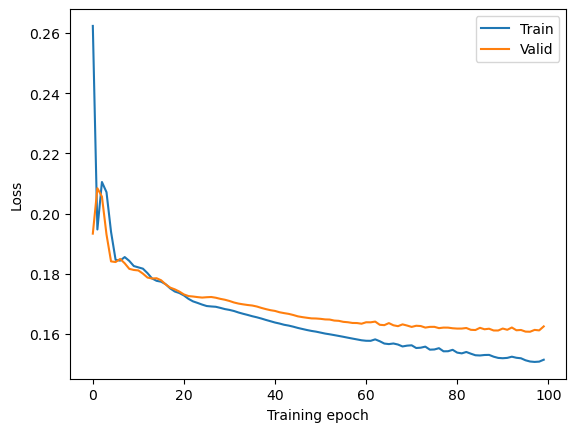

In [32]:
# Load Q_data_random
with open('./data/Q_data_random_RF_constrained.pkl', 'rb') as f:
    Q_c_data_random = pickle.load(f)

print('Number of episodes generated by random policy:',len(Q_c_data_random))

s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data = Q_c_data_random)

# Standardizing s_material data
scaler = StandardScaler() # Fit scaler
print('before scaling:', s_material_inputs)
scaler.fit(s_material_inputs)
s_material_inputs_scaled = torch.tensor(scaler.transform(s_material_inputs)).float()
print('after scaling:', s_material_inputs_scaled)

# Train-validation split
s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, en_targets_train, s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid, en_targets_valid \
= train_validation_split(s_material_inputs_scaled = s_material_inputs_scaled, 
                                    s_step_inputs = s_step_inputs, 
                                    a_elem_inputs = a_elem_inputs,
                                    a_comp_inputs = a_comp_inputs,
                                    Q_targets  = Q_targets,
                                    en_targets = en_targets,
                                    valid_size = 0.2)

print('TRAIN SIZES:')
print('s_material_inputs_train:', s_material_inputs_train.shape)
print('s_step_inputs_train:', s_step_inputs_train.shape)
print('a_elem_inputs_train:', a_elem_inputs_train.shape)
print('a_comp_inputs_train:', a_comp_inputs_train.shape)
print('Q_targets_train:', Q_targets_train.shape)
print('en_targets_train:', en_targets_train.shape)
print('')
print('VALIDATION SIZES:')
print('s_material_inputs_valid:', s_material_inputs_valid.shape)
print('s_step_inputs_valid:', s_step_inputs_valid.shape)
print('a_elem_inputs_valid:', a_elem_inputs_valid.shape)
print('a_comp_inputs_valid:', a_comp_inputs_valid.shape)
print('Q_targets_valid:', Q_targets_valid.shape)
print('en_targets_valid:', en_targets_valid.shape)

# Initialize constraint network
dcn = DCN_pytorch()

# Train DCN on random data
dcn, train_loss_list, valid_loss_list = train_DCN(dcn =  dcn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
 a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train, en_targets_train = en_targets_train,
 s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
 a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid, en_targets_valid = en_targets_valid)

# Plot train and valid losses
plt.figure()
plt.plot(range(0,len(train_loss_list)), train_loss_list, label = 'Train')
plt.plot(range(0,len(valid_loss_list)), valid_loss_list, label = 'Valid')
plt.legend()
# plt.ylim(130,170)
plt.xlabel('Training epoch')
plt.ylabel('Loss')
# plt.savefig('plots/train_valid_loss.png', dpi = 300)
plt.show()

In [33]:
# torch.save(dcn, './dcn_models/constrained_DQN/dcn_test_random_RF_constrained')

# Visualization of results

### Final reward of compounds generated from constrained model (DQN + DCN)

In [35]:
# # Earlier models
# dqn = torch.load('./dqn_models/dqn_test_500iter_RF_constrained') # Trained in constrained RL
# dqn = torch.load('./dqn_models/dqn_test_490iter_RF') # Trained in unconstrained RL
# dcn = torch.load('./dcn_models/dcn_test_random_RF_constrained') # Trained on random data

# Final constrained models
dqn = torch.load('./dqn_models/constrained_DQN/dqn_test_500iter_RF_constrained') # Trained in constrained RL
dcn = torch.load('./dcn_models/constrained_DQN/dcn_test_random_RF_constrained') # Trained on random data

# dqn.fc1.weight.mean(), dqn.fc2.weight.mean(), dqn.fc3.weight.mean(), dqn.fc4.weight.mean(),
dcn.fc1.weight.mean(), dcn.fc2.weight.mean(), dcn.fc3.weight.mean(), dcn.fc4.weight.mean(),

(tensor(-0.0056, grad_fn=<MeanBackward0>),
 tensor(-0.0358, grad_fn=<MeanBackward0>),
 tensor(-0.0002, grad_fn=<MeanBackward0>),
 tensor(-0.0347, grad_fn=<MeanBackward0>))

In [36]:
# 1. Get final rewards from random policy
with open('./data/Q_data_random_RF_constrained.pkl', 'rb') as f:
    Q_data_random = pickle.load(f)
s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, en_targets = generate_dqn_dcn_inputs_and_targets_from_Q_c_data(Q_c_data = Q_data_random)
final_rewards_random = Q_targets[0::5].reshape(-1) # find final rewards
en_random = en_targets[0::5].reshape(-1) # find final en

# 2. Get final rewards from trained policy
Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds = \
generate_Q_c_datapoints_and_evaluate_policy(dqn = dqn, dcn = dcn, num_eps = 1000, epsilon = 0, 
                                            en_threshold = 0.4, stochastic_top_frac = 0.20)

# # Save compounds generated                                            
# with open('./training_data/constrained_DQN/final_compounds_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(final_compounds, f, pickle.HIGHEST_PROTOCOL)

Could not satisfy en constraint after 100 actions


/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


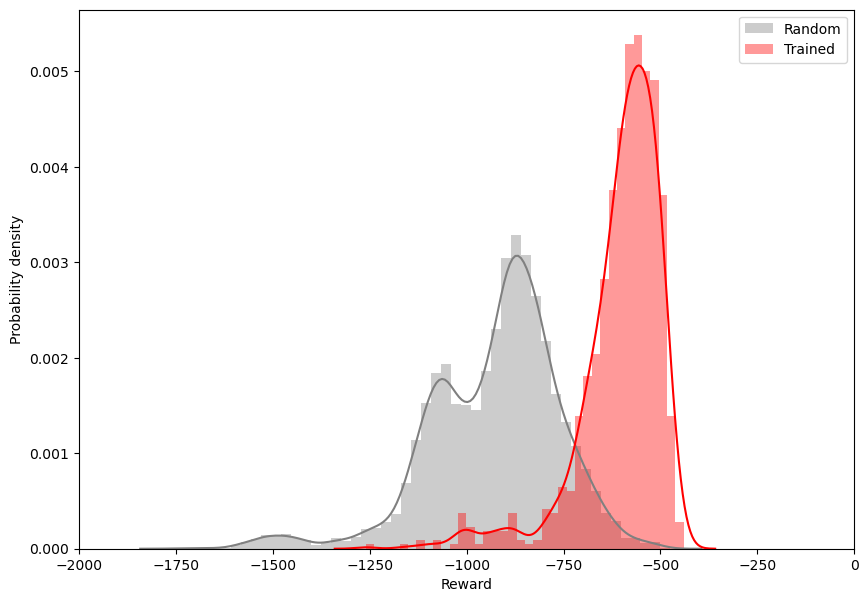

In [43]:
# Plot distribution of final rewards by random vs trained policy
plt.figure(figsize=(10,7))
sns.distplot(final_rewards_random, hist = True, norm_hist = True, label = 'Random', color = 'grey')
sns.distplot(final_rewards_trained, hist = True, norm_hist = True, label = 'Trained', color = 'red')
plt.ylabel('Probability density')
plt.xlabel('Reward')
# plt.ylim(0,0.0025)
plt.xlim(-2000,0)   
plt.legend()
# plt.savefig(fname = 'plots/constrained_DQN/reward_dist_500iter_RF_constrained.png', dpi = 300)
plt.show()

### Validity of compounds generated from constrained model (DQN + DCN)

In [39]:
# Validity of trained
count = 0
for target in en_targets_trained:
    if target.item() == 1.:
        count += 1
print('Trained policy: Fraction of en OK compounds = ' , count/len(en_targets_trained))

Trained policy: Fraction of en OK compounds =  0.51


In [40]:
# Validity of random
count = 0
for target in en_random:
    if target.item() == 1.:
        count += 1
print('Random policy: Fraction of en OK compounds = ' , count/len(en_random))

Random policy: Fraction of en OK compounds =  0.2576


### Experiment: Validity vs en_threshold

In [25]:
en_threshold_list  = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
en_good_ratio_vs_en_threshold = []

def evaluate_en_threshold(en_threshold):
    # 2. Get final rewards from trained policy
    Q_c_data_trained, en_targets_trained, final_rewards_trained, final_compounds = \
    generate_Q_c_datapoints_and_evaluate_policy(dqn = dqn, dcn = dcn, num_eps = 1000, epsilon = 0, 
                                            en_threshold = en_threshold, stochastic_top_frac = 0.20)
    # Validity of trained
    count = 0
    for target in en_targets_trained:
        if target.item() == 1.:
            count += 1
    ratio = count/len(en_targets_trained)
    return ratio

for en_threshold in en_threshold_list:
    en_good_ratio = evaluate_en_threshold(en_threshold = en_threshold)
    en_good_ratio_vs_en_threshold.append(en_good_ratio)

# with open('./training_data/en_threshold_list_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(en_threshold_list, f, pickle.HIGHEST_PROTOCOL)

# with open('./training_data/en_good_ratio_vs_en_threshold_RF_constrained.pkl', 'wb') as f:
#         pickle.dump(en_good_ratio_vs_en_threshold, f, pickle.HIGHEST_PROTOCOL)

Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions
Could not satisfy en constraint after 100 actions


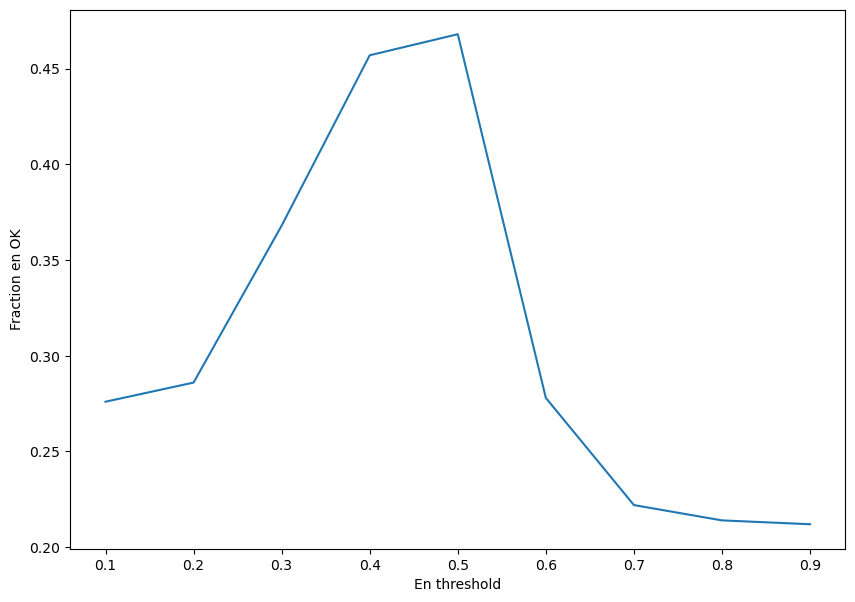

In [26]:
# with open('./training_data/en_threshold_list_RF_constrained.pkl', 'rb') as f:
#     en_threshold_list = pickle.load(f)

# with open('./training_data/en_good_ratio_vs_en_threshold_RF_constrained.pkl', 'rb') as f:
#     en_good_ratio_vs_en_threshold = pickle.load(f)

plt.figure(figsize=(10,7))
plt.plot(en_threshold_list, en_good_ratio_vs_en_threshold)
plt.ylabel('Fraction en OK')
plt.xlabel('En threshold')
# plt.savefig(fname = 'plots/en_good_ratio_vs_en_threshold_500iter_RF_constrained.png', dpi = 300)
plt.show()

### Look at compounds

In [3]:
rf_regr = RandomForestRegressor()
rf_regr = joblib.load("rf_models/rf_sinter_predict_no_imputation_no_precursors.joblib")

# Featurization for RF model
feature_calculators = MultipleFeaturizer([
    cf.element.Stoichiometry(),
    cf.composite.ElementProperty.from_preset("magpie"),
    cf.orbital.ValenceOrbital(props=["avg"]),
    cf.ion.IonProperty(fast=True)
])

In [10]:
# Load compounds generated
with open('./training_data/constrained_DQN/final_compounds_RF_constrained.pkl', 'rb') as f: # For final compounds generated using constrained RL (DQN + DCN)
    final_compounds = pickle.load(f)

# For final compounds generated using constrained RL (DQN + DCN)
good, bad = check_both_multiple(final_compounds)

510

In [22]:
print('Fraction of en OK compounds:', len(good)/(len(good) + len(bad)))

Fraction of en OK compounds: 0.51


Compound: Ag2GeBi7(RhS)5         Sinter T: 694
Compound: Cd7Ge8P13              Sinter T: 668
Compound: Cu7P5H7Pb8Au           Sinter T: 585
Compound: Cd2Ag8Ge9Se5           Sinter T: 518
Compound: ErSi5Ge(Bi3Sb4)2       Sinter T: 524
Compound: In4Ge9Pb8(SeI)6        Sinter T: 495
Compound: Ge3P2(Se3I2)2          Sinter T: 480
Compound: Zn2Ge3S5               Sinter T: 675
Compound: In5Ge6Bi9(Sb2Se)3      Sinter T: 514
Compound: Er5Si2Ge8I             Sinter T: 618
Compound: Zr3Ge3Bi7(IBr)2        Sinter T: 746
Compound: Er2As8P5H3Br2          Sinter T: 715
Compound: Dy5Si4Sb7Br5           Sinter T: 652
Compound: SbAs2P8Au7I8           Sinter T: 552
Compound: Tl8Ge6As9(PI2)3        Sinter T: 510
Compound: Si2Ge6Te2Pb3Au2        Sinter T: 578
Compound: Cu8Si5Ge5S4            Sinter T: 730
Compound: Tl4Cu3(Ge8S)2          Sinter T: 575
Compound: PuSi3P5Au14            Sinter T: 590
Compound: Si3Ge6Bi2As            Sinter T: 513
Compound: Cd5InGe2P3I2           Sinter T: 614
Compound: Ge8

/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


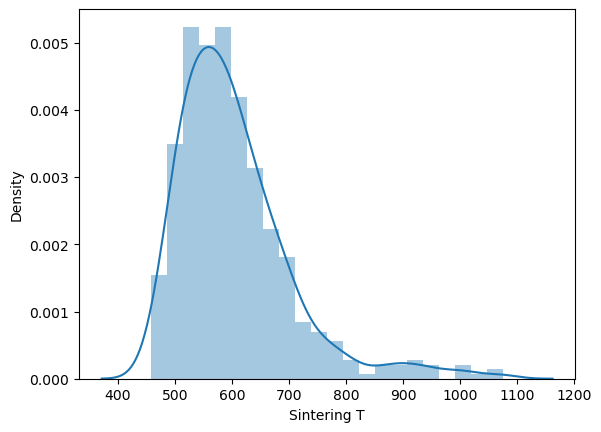

In [13]:
# Convert good ones to reduced formula
for idx in range(len(good)):
    good[idx] = Composition(good[idx]).reduced_formula

# Predict sintering T of valid compounds
max_len = 0
good_sinter_T = []
for compound in good:
    chemical = Composition(compound)
    features = feature_calculators.featurize(chemical) # No need to scale for RF model
    features = np.array(features).reshape(1, -1)
    # print(features)
    sinter_T_pred = rf_regr.predict(features)[0]
    good_sinter_T.append(sinter_T_pred)
    compound = Composition(compound).reduced_formula
    print('Compound:', compound, (18-len(compound)+3)*' ','Sinter T:', round(sinter_T_pred))

plt.figure()
sns.distplot(good_sinter_T)
plt.xlabel('Sintering T')
plt.show()

# Visualizing training data of unconstrained DQN

### Evolution of final rewards with iteration (unconstrained DQN only)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


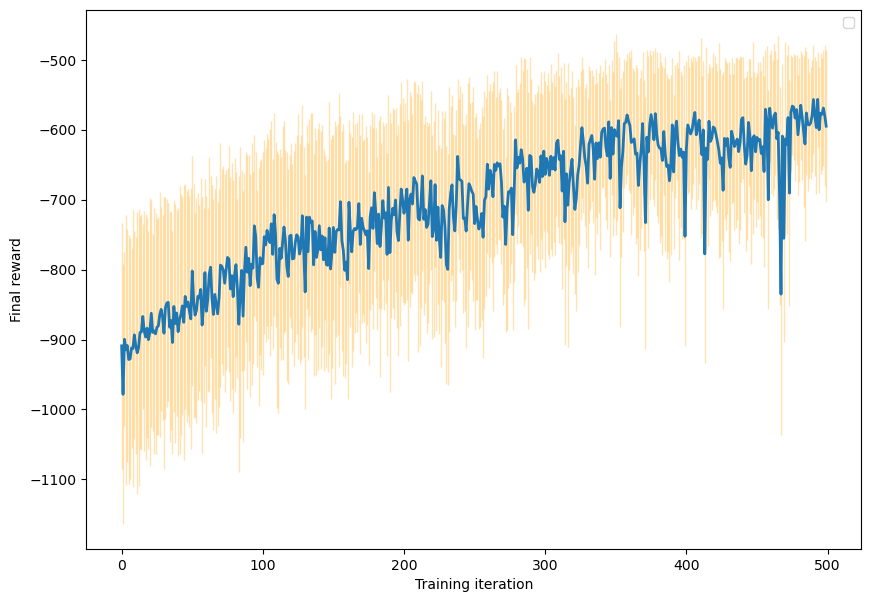

In [21]:
with open('./training_data/final_rewards_vs_iter_RF_constrained.pkl', 'rb') as f:
    final_rewards_vs_iter = pickle.load(f)
num_iter = 500
final_rewards_mean = [x.mean() for x in final_rewards_vs_iter]
final_rewards_std  = [x.std() for x in final_rewards_vs_iter]
plt.figure(figsize=(10,7))
markers, caps, bars = plt.errorbar(range(num_iter), final_rewards_mean, yerr = final_rewards_std, mfc= 'blue', linewidth = 2, elinewidth= 1)
[bar.set_alpha(0.3) for bar in bars]
[bar.set_color('orange') for bar in bars]
plt.ylabel('Final reward')
plt.xlabel('Training iteration')
plt.legend()
# plt.savefig(fname = 'plots/reward_vs_iter_500iter_RF_constrained.png', dpi = 300)
plt.show()

### Evolution of compounds with iteration (unconstrained DQN only)

In [2]:
# with open('./training_data/compounds_vs_iter_RF.pkl', 'rb') as f:
#     compounds_vs_iter = pickle.load(f)

# # FEATURIZE GENERATED COMPOUNDS
# for iteration in tqdm(range(len(compounds_vs_iter))): # For each iteration of compounds
#     for idx in range(len(compounds_vs_iter[iteration])): # For each compound
#         compounds_vs_iter[iteration][idx] = featurize_target(compounds_vs_iter[iteration][idx]) # Featurize using Magpie embeddings

# # Save featurized compounds
# with open('./training_data/compound_features_vs_iter_RF.pkl', 'wb') as f:
#         pickle.dump(compounds_vs_iter, f, pickle.HIGHEST_PROTOCOL)

In [28]:
# Load compound features
with open('./training_data/compound_features_vs_iter_RF.pkl', 'rb') as f:
    compound_features_vs_iter = pickle.load(f)

In [29]:
len(compound_features_vs_iter)

500

Standarizing data before PCA is important.

In [30]:
# Load scalar
scaler = StandardScaler() # Fit scaler
scaler.fit(s_material_inputs)

# Convert each compound features from list to np.array
for iteration in tqdm(range(len(compound_features_vs_iter))): # For each iteration of compounds
    for idx in range(len(compound_features_vs_iter[iteration])): # For each compound
        compound_features_vs_iter[iteration][idx] = scaler.transform(np.array([compound_features_vs_iter[iteration][idx]]))[0] # Featurize using Magpie embeddings

100%|██████████| 500/500 [00:02<00:00, 243.93it/s]


In [32]:
features = [] # 500 x np.array() of shape 100 x 145 (100 is no of compounds per iteration, 145 is the feature size)
for iteration in tqdm(range(len(compound_features_vs_iter))): # For each iteration of compounds
    iteration_stack = []
    for idx in range(len(compound_features_vs_iter[iteration])): # For each compound
        iteration_stack.append(compound_features_vs_iter[iteration][idx])
    iteration_stack = np.stack(iteration_stack)
    features.append(iteration_stack)

100%|██████████| 500/500 [00:00<00:00, 6695.70it/s]


In [33]:
# Stack features into one big matrix
full_stack = [] 
for iteration in features:
    full_stack.append(iteration)
full_stack = np.vstack(full_stack)

### Dimensionality reduction using t-SNE

In [69]:
# Perform t-SNE
tsne_embeddings = TSNE(n_components = 2, 
                       perplexity = 30,
                       learning_rate='auto',
                       init='random' # random/pca initialization
                       ).fit_transform(full_stack)

# with open('training_data/tsne_embeddings_500iter_RF.npy', 'wb') as f:
#     np.save(f, tsne_embeddings)

In [97]:
# Load t-SNE embeddings
with open('training_data/tsne_embeddings_500iter_RF.npy', 'rb') as f:
    tsne_embeddings = np.load(f)

with open('./training_data/final_rewards_vs_iter_RF.pkl', 'rb') as f:
    final_rewards_vs_iter = pickle.load(f)

final_rewards_vs_iter_stacked = torch.stack(final_rewards_vs_iter)
final_rewards = final_rewards_vs_iter_stacked.reshape(-1)
print('tsne_embeddings: ', tsne_embeddings.shape)
print('final_rewards:', final_rewards.shape)

tsne_embeddings:  (50000, 2)
final_rewards: torch.Size([50000])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


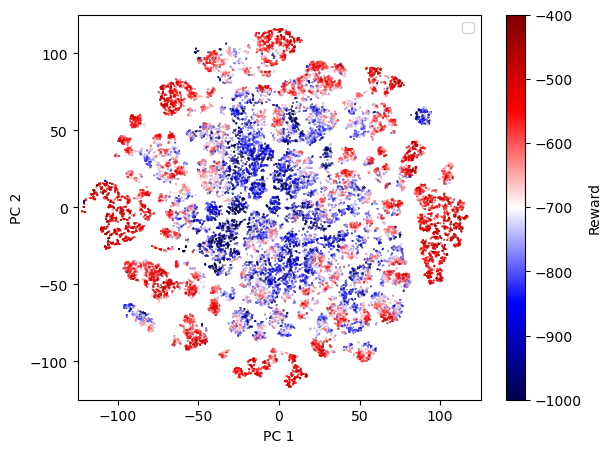

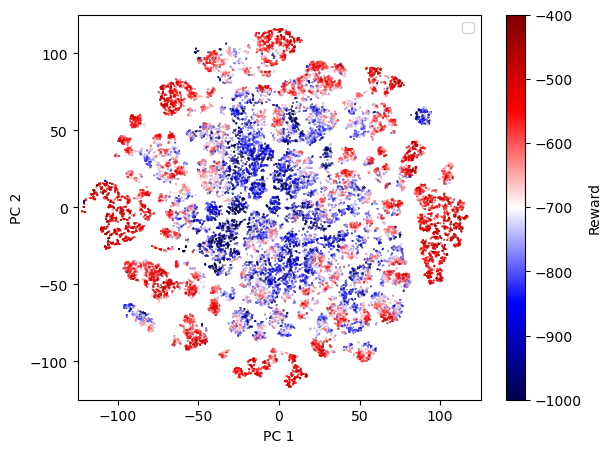

In [98]:
# Generate list of iterations for 50k compounds
iteration = []
for i in range(500):
    for j in range(100):
        iteration.append(i)
# Plot TSNE
def plot_TSNE(train_iter = None):
    fig = plt.figure(figsize=(6.5,5))
    if train_iter == None:
        plt.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], s = 0.05, alpha = 1, c = final_rewards, cmap = 'seismic') # For rewards
        # plt.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], s = 0.05, alpha = 1, c = iteration, cmap = 'seismic') # For iteration
    else:
        row_idx = range(100*train_iter,(100*train_iter)+100)
        rewards = final_rewards_vs_iter[train_iter]
        plt.scatter(tsne_embeddings[row_idx,0], tsne_embeddings[row_idx,1], c = rewards, s = 5, cmap = 'seismic')
    plt.ylabel('PC 2')
    plt.xlabel('PC 1')
    plt.ylim(-125, 125)
    plt.xlim(-125, 125)
    plt.legend()
    # plt.text(20,100,'Iteration %.0f' % train_iter, fontsize = 15)
    cbar = plt.colorbar()
    cbar.set_label('Reward')
    # cbar.set_label('Iteration')
    plt.clim(-1000,-400) 
    # plt.savefig(fname = 'plots/TSNE_vs_iter_500iter_RF.png', dpi = 300) 
    plt.show()
    return fig
plot_TSNE()

In [ ]:
images = []  # For saving into gif

for i in range(0, 600, 1): # For stalling the last frame
    j = i
    if i > 499: # For stalling the last frame
        j = 499
    fig = plot_TSNE(train_iter = j)
    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)
imageio.mimsave('plots/TSNE_reward_vs_iter_500iter_RF.gif', images, fps = 30)

### Dimensionality reduction using singular value decomposition (SVD)

In [66]:
# Perform SVD
u, s, vh = np.linalg.svd(full_stack, full_matrices=True)

# with open('training_data/SVD_embeddings_500iter_RF.npy', 'wb') as f:
#     np.save(f, u)

In [67]:
# Load SVD embeddings
with open('training_data/SVD_embeddings_500iter_RF.npy', 'rb') as f:
    u = np.load(f)

with open('training_data/final_rewards_vs_iter_RF.pkl', 'rb') as f:
    final_rewards_vs_iter = pickle.load(f)

final_rewards_vs_iter_stacked = torch.stack(final_rewards_vs_iter)
final_rewards = final_rewards_vs_iter_stacked.reshape(-1)
print('SVD_embeddings: ', u.shape)
print('final_rewards:', final_rewards.shape)

u_truncated = u[:, :2]
print('SVD_embeddings after truncation:', u_truncated.shape)

SVD_embeddings:  (50000, 50000)
final_rewards: torch.Size([50000])
SVD_embeddings after truncation: (50000, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


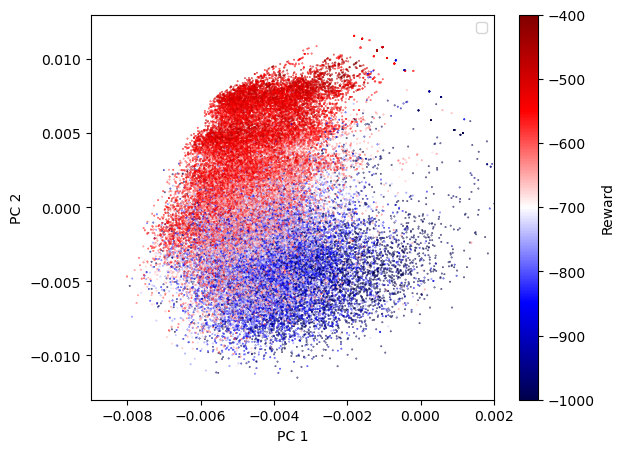

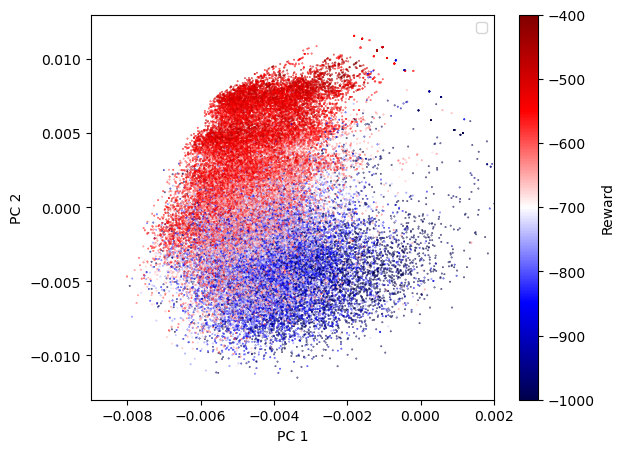

In [99]:
iteration = []
for i in range(500):
    for j in range(100):
        iteration.append(i)

# Plot SVD
def plot_SVD(train_iter = None):
    fig = plt.figure(figsize=(6.5,5))
    if train_iter == None:
        plt.scatter(u_truncated[:,0], u_truncated[:,1], c = final_rewards, s = 0.1, cmap = 'seismic') # For rewards
        # plt.scatter(u_truncated[:,0], u_truncated[:,1], c = iteration, s = 0.1, cmap = 'seismic') # For iterations
    else:
        row_idx = range(100*train_iter,(100*train_iter)+100)
        rewards = final_rewards_vs_iter[train_iter]
        plt.scatter(u_truncated[row_idx,0], u_truncated[row_idx,1], c = rewards, s = 5, cmap = 'seismic')
    plt.ylabel('PC 2')
    plt.xlabel('PC 1')
    plt.ylim(-0.013, 0.013)
    plt.xlim(-0.009, .002)
    plt.legend()
    # plt.text(-0.002,0.010,'Iteration %.0f' % train_iter, fontsize = 15)
    cbar = plt.colorbar()
    plt.clim(-1000,-400)  
    # cbar.set_label('Iteration')
    cbar.set_label('Reward')
    # plt.savefig(fname = 'plots/SVD_reward_vs_iter_500iter_RF.png', dpi = 300)
    plt.show()
    return fig
plot_SVD()

In [ ]:
images = []  # For saving into gif

for i in range(0, 600, 1): # For stalling the last frame
    j = i
    if i > 499: # For stalling the last frame
        j = 499
    fig = plot_SVD(train_iter = j)
    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)
imageio.mimsave('plots/SVD_reward_vs_iter_500iter_RF.gif', images, fps = 30)

### Charge neutrality of generated compounds (unconstrained DQN)
From this point onwards, we start using dqn2 environment

In [36]:
with open('./training_data/compounds_vs_iter_RF.pkl', 'rb') as f:
    compounds_vs_iter = pickle.load(f)
compounds = compounds_vs_iter[0]

good, bad = check_neutrality_multiple(compounds = compounds)
len(good), len(bad)

(45, 55)

In [37]:
# Check charge neutrality
good_vs_iter = []
bad_vs_iter  = []
for compounds in compounds_vs_iter:
    good, bad = check_neutrality_multiple(compounds = compounds)
    good_vs_iter.append(len(good))
    bad_vs_iter.append(len(bad))

cn_good_ratio = np.array(good_vs_iter)/(np.array(good_vs_iter)+np.array(bad_vs_iter))

# with open('training_data/cn_good_ratio_500iter_RF.npy', 'wb') as f:
#     np.save(f, cn_good_ratio)

Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid


In [41]:
# Load charge neutrality
with open('training_data/cn_good_ratio_500iter_RF.npy', 'rb') as f:
    cn_good_ratio = np.load(f)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


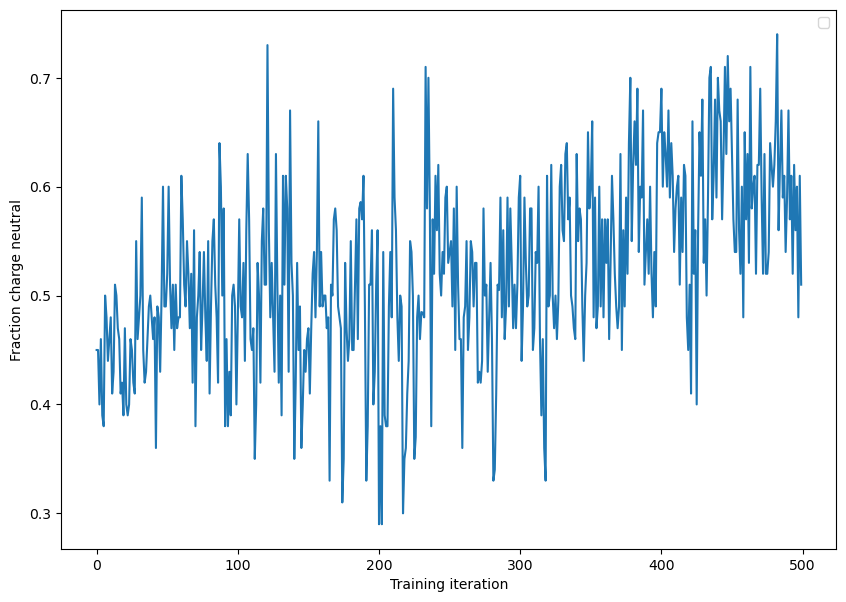

In [42]:
num_iter = len(compounds_vs_iter)
plt.figure(figsize=(10,7))
plt.plot(range(num_iter), cn_good_ratio)
plt.ylabel('Fraction charge neutral')
plt.xlabel('Training iteration')
plt.legend()
# plt.savefig(fname = 'plots/cn_vs_iter_500iter_RF.png', dpi = 300)
plt.show()

### Electronegativity of generated compounds (unconstrained DQN)

In [35]:
with open('./training_data/compounds_vs_iter_RF_constrained.pkl', 'rb') as f:
    compounds_vs_iter = pickle.load(f)
compounds = compounds_vs_iter[0]

good, bad = check_electronegativity_multiple(compounds = compounds)
len(good), len(bad)

(20, 80)

In [39]:
# Check electronegativity
good_vs_iter = []
bad_vs_iter  = []
for compounds in compounds_vs_iter:
    good, bad = check_electronegativity_multiple(compounds = compounds)
    good_vs_iter.append(len(good))
    bad_vs_iter.append(len(bad))

en_good_ratio = np.array(good_vs_iter)/(np.array(good_vs_iter)+np.array(bad_vs_iter))

with open('training_data/en_good_ratio_500iter_RF_constrained.npy', 'wb') as f:
    np.save(f, en_good_ratio)

Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid


In [31]:
# Load electronegativity
with open('training_data/en_good_ratio_500iter_RF_constrained.npy', 'rb') as f:
    en_good_ratio = np.load(f)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


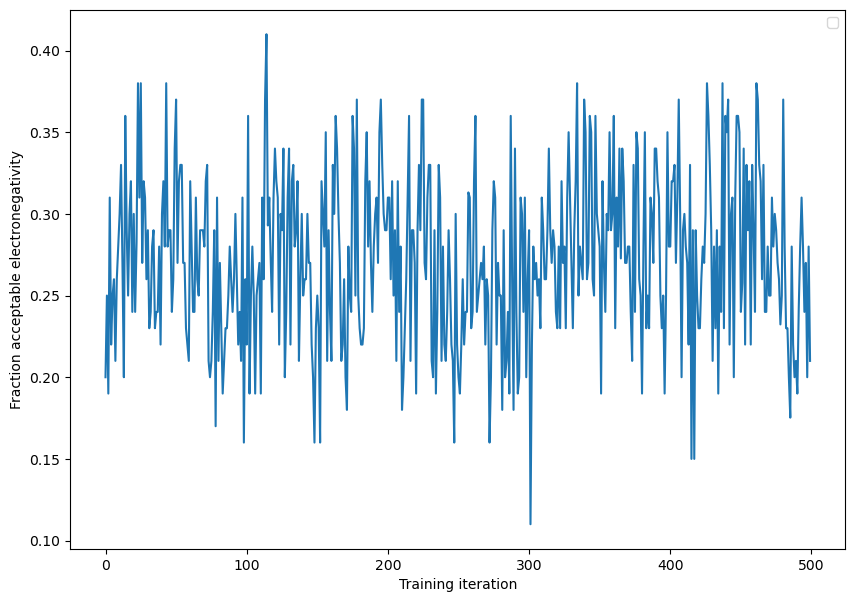

In [40]:
num_iter = len(compounds_vs_iter)
plt.figure(figsize=(10,7))
plt.plot(range(num_iter), en_good_ratio)
plt.ylabel('Fraction acceptable electronegativity')
plt.xlabel('Training iteration')
plt.legend()
# plt.savefig(fname = 'plots/en_vs_iter_500iter_RF.png', dpi = 300)
plt.show()

### Check both charge neutrality and electronegativity (unconstrained DQN)

In [2]:
with open('./training_data/compounds_vs_iter_RF.pkl', 'rb') as f:
    compounds_vs_iter = pickle.load(f)

In [49]:
# Efficient way
good_vs_iter = []
bad_vs_iter  = []
for compounds in compounds_vs_iter:
    cn_good, cn_bad = check_neutrality_multiple(compounds = compounds)
    both_good, bad = check_electronegativity_multiple(compounds = cn_good)

    good_vs_iter.append(len(both_good))
    bad_vs_iter.append(len(cn_bad)+len(bad))

both_good_ratio = np.array(good_vs_iter)/(np.array(good_vs_iter)+np.array(bad_vs_iter))

# with open('training_data/both_good_ratio_500iter_RF.npy', 'wb') as f:
#     np.save(f, both_good_ratio)

Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid


In [38]:
# Inefficient way - To double check

# compounds = compounds_vs_iter[0]
# good, bad = check_both_multiple(compounds = compounds)

# Inefficient way - To double check
# good_vs_iter = []
# bad_vs_iter  = []
# for compounds in compounds_vs_iter:
#     good, bad = check_both_multiple(compounds = compounds)
#     good_vs_iter.append(len(good))
#     bad_vs_iter.append(len(bad))

# both_good_ratio = np.array(good_vs_iter)/(np.array(good_vs_iter)+np.array(bad_vs_iter))

# with open('training_data/both_good_ratio_500iter_RF.npy', 'wb') as f:
#     np.save(f, both_good_ratio)

In [9]:
# Load both
with open('training_data/both_good_ratio_500iter_RF.npy', 'rb') as f:
    both_good_ratio = np.load(f)

# Load electronegativity
with open('training_data/en_good_ratio_500iter_RF.npy', 'rb') as f:
    en_good_ratio = np.load(f)

# Load charge neutrality
with open('training_data/cn_good_ratio_500iter_RF.npy', 'rb') as f:
    cn_good_ratio = np.load(f)

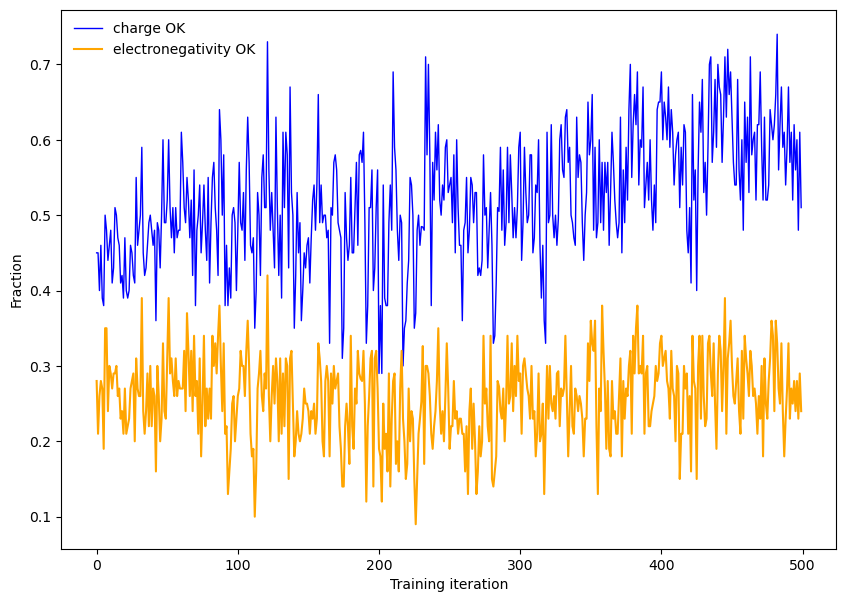

In [20]:
num_iter = len(compounds_vs_iter)
plt.figure(figsize=(10,7))
plt.plot(range(num_iter), cn_good_ratio, label = 'charge OK', color = 'blue', linewidth = 1)
plt.plot(range(num_iter), en_good_ratio, label = 'electronegativity OK', color = 'orange')
# plt.plot(range(num_iter), both_good_ratio, label = 'both OK')
plt.ylabel('Fraction')
plt.xlabel('Training iteration')
plt.legend(frameon= False)
# plt.savefig(fname = 'plots/both_vs_iter_500iter_RF.png', dpi = 300)
plt.show()